## In this notebook I aim to change the noise input of the generator to a low resolution galaxy image instead

By Shooby, started: July 25 <br>
last edited: Aug 26th

In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel


from astropy.convolution import convolve_fft as convolve
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import warnings
warnings.filterwarnings('ignore')

In [2]:
# initializing parameters:

dataroot='gals/'
device = torch.device("cuda:0") # If GPU then use "cuda:0"
ngpu = 3 #number of GPUs to use 
ngf = 64
ndf = 64
workers = 8 #number of data loading workers
batchSize = 64 #input batch size
imageSize = 64 #the height / width of the input image to network

nz = 16 #size of the latent z vector
niter = 500 #number of epochs to train for
lr = 0.001 #learning rate, default=0.0002
beta1 = 0.7 #beta1 for adam. default=0.5
outf='outputs' #folder to output images and model checkpoints
print(nz)

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


16
Random Seed:  3287


In [3]:
dataset = dset.MNIST(root=dataroot, download=True,
                     transform=transforms.Compose([transforms.Resize(imageSize),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
nc=1

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))


Using downloaded and verified file: gals/MNIST/raw/train-images-idx3-ubyte.gz
Extracting gals/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Using downloaded and verified file: gals/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting gals/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 1788600.33it/s]                            
0it [00:00, ?it/s]

Extracting gals/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 47149.65it/s]            


Extracting gals/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


(41, 41)
(41, 41)
(41, 41)


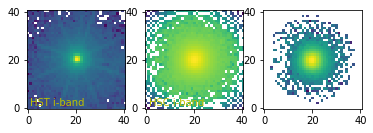

In [4]:
## The pixel scale of the kernel is now downsampled!

from skimage.transform import downscale_local_mean
psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]#[22:-22,22:-22]
print(psf.shape)
plt.subplot(1,3,1)
plt.imshow(np.log(psf),origin='lower')
plt.text(1,1,'HST i-band',color='y')

from scipy.ndimage import zoom
psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
psf_hsc = psf_hsc[0:41,1:42]
#psf_hsc = zoom(psf_hsc, 3, order=1)
print(psf_hsc.shape)
plt.subplot(1,3,2)
plt.imshow(np.log(psf_hsc),origin='lower')
plt.text(1,1,'HSC i-band',color='y')

kern = create_matching_kernel(psf,psf_hsc)
plt.subplot(1,3,3)
print(kern.shape)
#kern = kern[35:-35,35:-35]
plt.imshow(np.log(kern),origin='lower')

psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [6]:
class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( 1, ngf * 8, 4, 1, 2, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 2, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
  
            nn.ConvTranspose2d(ngf*4, nc, 2, 2, 4, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1

netS = Shoobygen(ngpu).to(device)
netS.apply(weights_init)
print(netS)

Shoobygen(
  (main): Sequential(
    (0): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 1, kernel_size=(2, 2), stride=(2, 2), padding=(4, 4), bias=False)
    (7): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [8]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerS = optim.Adam(netS.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with resampled, lower res, noise added images
        kernel = kernel.to(device)
        im = real_cpu+0.25*torch.rand_like(real_cpu)
        downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
        img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img[:,:,:,:]
        #plt.imshow(img[0,0,:,:])
        #print(img.shape)
        fake = netS(img)
        #print(fake.shape)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netS.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerS.step()
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netS(img)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netS.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/500][0/157] Loss_D: 1.2210 Loss_G: 33.7978 D(x): 0.5650 D(G(z)): 0.4124 / 0.0000
[0/500][1/157] Loss_D: 0.8003 Loss_G: 31.2357 D(x): 1.0000 D(G(z)): 0.1415 / 0.0000
[0/500][2/157] Loss_D: 0.0483 Loss_G: 28.8154 D(x): 1.0000 D(G(z)): 0.0150 / 0.0000
[0/500][3/157] Loss_D: 0.0005 Loss_G: 25.8348 D(x): 1.0000 D(G(z)): 0.0005 / 0.0000
[0/500][4/157] Loss_D: 0.0444 Loss_G: 27.0184 D(x): 1.0000 D(G(z)): 0.0307 / 0.0000
[0/500][5/157] Loss_D: 0.0000 Loss_G: 26.5889 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[0/500][6/157] Loss_D: 0.0000 Loss_G: 26.4840 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[0/500][7/157] Loss_D: 0.0000 Loss_G: 25.1462 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[0/500][8/157] Loss_D: 0.0000 Loss_G: 21.9075 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[0/500][9/157] Loss_D: 0.0017 Loss_G: 13.5852 D(x): 0.9985 D(G(z)): 0.0001 / 0.0000
[0/500][10/157] Loss_D: 8.5478 Loss_G: 43.7594 D(x): 1.0000 D(G(z)): 0.8735 / 0.0000
[0/500][11/157] Loss_D: 0.1320 Loss_G: 48.6276 D(x): 0.9512 D(G(z)): 0.0000

[0/500][97/157] Loss_D: 0.3132 Loss_G: 5.4332 D(x): 0.8515 D(G(z)): 0.0135 / 0.0601
[0/500][98/157] Loss_D: 1.2673 Loss_G: 10.0117 D(x): 0.9691 D(G(z)): 0.4909 / 0.0001
[0/500][99/157] Loss_D: 0.5102 Loss_G: 9.7624 D(x): 0.7178 D(G(z)): 0.0018 / 0.0001
[0/500][100/157] Loss_D: 0.4324 Loss_G: 6.7587 D(x): 0.7735 D(G(z)): 0.0018 / 0.0067
[0/500][101/157] Loss_D: 0.5380 Loss_G: 7.5856 D(x): 0.9936 D(G(z)): 0.3263 / 0.0017
[0/500][102/157] Loss_D: 0.1482 Loss_G: 9.6520 D(x): 0.9918 D(G(z)): 0.1095 / 0.0004
[0/500][103/157] Loss_D: 0.1900 Loss_G: 9.5912 D(x): 0.8752 D(G(z)): 0.0077 / 0.0007
[0/500][104/157] Loss_D: 0.1641 Loss_G: 7.9022 D(x): 0.8891 D(G(z)): 0.0056 / 0.0047
[0/500][105/157] Loss_D: 0.0327 Loss_G: 7.4850 D(x): 0.9823 D(G(z)): 0.0131 / 0.0137
[0/500][106/157] Loss_D: 0.1294 Loss_G: 6.6686 D(x): 0.9940 D(G(z)): 0.0934 / 0.0106
[0/500][107/157] Loss_D: 0.1802 Loss_G: 8.2508 D(x): 0.9797 D(G(z)): 0.1170 / 0.0021
[0/500][108/157] Loss_D: 0.1380 Loss_G: 7.2797 D(x): 0.9209 D(G(z))

[1/500][38/157] Loss_D: 2.2550 Loss_G: 10.0266 D(x): 0.9991 D(G(z)): 0.8280 / 0.0003
[1/500][39/157] Loss_D: 0.6771 Loss_G: 10.3266 D(x): 0.6851 D(G(z)): 0.0258 / 0.0007
[1/500][40/157] Loss_D: 1.3407 Loss_G: 6.0027 D(x): 0.4156 D(G(z)): 0.0092 / 0.0320
[1/500][41/157] Loss_D: 0.4078 Loss_G: 3.5066 D(x): 0.9465 D(G(z)): 0.1344 / 0.0929
[1/500][42/157] Loss_D: 1.1035 Loss_G: 8.0889 D(x): 0.9946 D(G(z)): 0.5175 / 0.0009
[1/500][43/157] Loss_D: 0.0401 Loss_G: 9.8876 D(x): 0.9828 D(G(z)): 0.0207 / 0.0002
[1/500][44/157] Loss_D: 0.1445 Loss_G: 8.1926 D(x): 0.9004 D(G(z)): 0.0090 / 0.0008
[1/500][45/157] Loss_D: 0.1885 Loss_G: 5.2533 D(x): 0.8998 D(G(z)): 0.0580 / 0.0142
[1/500][46/157] Loss_D: 0.4210 Loss_G: 6.4128 D(x): 0.9129 D(G(z)): 0.2319 / 0.0034
[1/500][47/157] Loss_D: 0.1508 Loss_G: 7.4653 D(x): 0.9004 D(G(z)): 0.0157 / 0.0011
[1/500][48/157] Loss_D: 0.3647 Loss_G: 6.1958 D(x): 0.8023 D(G(z)): 0.0038 / 0.0045
[1/500][49/157] Loss_D: 0.0428 Loss_G: 4.6943 D(x): 0.9827 D(G(z)): 0.0238

[1/500][138/157] Loss_D: 0.0036 Loss_G: 7.8268 D(x): 0.9994 D(G(z)): 0.0030 / 0.0016
[1/500][139/157] Loss_D: 0.0111 Loss_G: 7.4603 D(x): 0.9975 D(G(z)): 0.0080 / 0.0047
[1/500][140/157] Loss_D: 0.0440 Loss_G: 6.9522 D(x): 0.9990 D(G(z)): 0.0229 / 0.0109
[1/500][141/157] Loss_D: 0.0199 Loss_G: 6.9116 D(x): 0.9891 D(G(z)): 0.0060 / 0.0034
[1/500][142/157] Loss_D: 0.0357 Loss_G: 6.0988 D(x): 0.9960 D(G(z)): 0.0283 / 0.0120
[1/500][143/157] Loss_D: 0.0751 Loss_G: 5.9927 D(x): 0.9857 D(G(z)): 0.0487 / 0.0116
[1/500][144/157] Loss_D: 0.1512 Loss_G: 7.6555 D(x): 0.9938 D(G(z)): 0.1177 / 0.0021
[1/500][145/157] Loss_D: 0.1700 Loss_G: 8.0892 D(x): 0.9646 D(G(z)): 0.0930 / 0.0018
[1/500][146/157] Loss_D: 0.2956 Loss_G: 7.9538 D(x): 0.9016 D(G(z)): 0.1105 / 0.0021
[1/500][147/157] Loss_D: 0.0680 Loss_G: 9.0611 D(x): 0.9749 D(G(z)): 0.0390 / 0.0008
[1/500][148/157] Loss_D: 0.0480 Loss_G: 8.2302 D(x): 0.9734 D(G(z)): 0.0116 / 0.0010
[1/500][149/157] Loss_D: 0.0456 Loss_G: 8.2344 D(x): 0.9891 D(G(z

[2/500][82/157] Loss_D: 0.3539 Loss_G: 10.1447 D(x): 0.9005 D(G(z)): 0.1406 / 0.0002
[2/500][83/157] Loss_D: 0.3127 Loss_G: 8.8642 D(x): 0.8560 D(G(z)): 0.0799 / 0.0014
[2/500][84/157] Loss_D: 0.0821 Loss_G: 9.5507 D(x): 0.9365 D(G(z)): 0.0019 / 0.0016
[2/500][85/157] Loss_D: 0.0860 Loss_G: 7.5103 D(x): 0.9826 D(G(z)): 0.0630 / 0.0019
[2/500][86/157] Loss_D: 0.2008 Loss_G: 15.7598 D(x): 0.9873 D(G(z)): 0.1581 / 0.0000
[2/500][87/157] Loss_D: 0.2557 Loss_G: 14.6782 D(x): 0.9121 D(G(z)): 0.0007 / 0.0000
[2/500][88/157] Loss_D: 0.1208 Loss_G: 12.3378 D(x): 0.9186 D(G(z)): 0.0001 / 0.0000
[2/500][89/157] Loss_D: 0.0134 Loss_G: 9.5855 D(x): 0.9875 D(G(z)): 0.0004 / 0.0001
[2/500][90/157] Loss_D: 0.0068 Loss_G: 7.1831 D(x): 0.9988 D(G(z)): 0.0056 / 0.0015
[2/500][91/157] Loss_D: 0.0321 Loss_G: 7.2716 D(x): 0.9988 D(G(z)): 0.0300 / 0.0013
[2/500][92/157] Loss_D: 0.5647 Loss_G: 24.3146 D(x): 0.9971 D(G(z)): 0.3869 / 0.0000
[2/500][93/157] Loss_D: 0.7608 Loss_G: 24.6631 D(x): 0.5949 D(G(z)): 0.

[3/500][22/157] Loss_D: 0.0040 Loss_G: 7.8024 D(x): 0.9992 D(G(z)): 0.0032 / 0.0017
[3/500][23/157] Loss_D: 0.0065 Loss_G: 9.6428 D(x): 0.9941 D(G(z)): 0.0005 / 0.0004
[3/500][24/157] Loss_D: 0.0073 Loss_G: 7.1672 D(x): 0.9984 D(G(z)): 0.0056 / 0.0030
[3/500][25/157] Loss_D: 0.0353 Loss_G: 7.8775 D(x): 0.9997 D(G(z)): 0.0299 / 0.0010
[3/500][26/157] Loss_D: 0.0006 Loss_G: 11.2059 D(x): 0.9995 D(G(z)): 0.0002 / 0.0000
[3/500][27/157] Loss_D: 0.0030 Loss_G: 8.8074 D(x): 0.9991 D(G(z)): 0.0021 / 0.0005
[3/500][28/157] Loss_D: 0.0071 Loss_G: 9.6173 D(x): 0.9939 D(G(z)): 0.0008 / 0.0003
[3/500][29/157] Loss_D: 0.0054 Loss_G: 9.6553 D(x): 0.9951 D(G(z)): 0.0003 / 0.0002
[3/500][30/157] Loss_D: 0.0077 Loss_G: 7.4435 D(x): 0.9968 D(G(z)): 0.0045 / 0.0022
[3/500][31/157] Loss_D: 0.0192 Loss_G: 7.4494 D(x): 0.9988 D(G(z)): 0.0174 / 0.0020
[3/500][32/157] Loss_D: 0.0147 Loss_G: 8.7901 D(x): 0.9948 D(G(z)): 0.0090 / 0.0013
[3/500][33/157] Loss_D: 0.0125 Loss_G: 9.7307 D(x): 0.9891 D(G(z)): 0.0012 

[3/500][121/157] Loss_D: 0.0250 Loss_G: 8.2251 D(x): 0.9854 D(G(z)): 0.0095 / 0.0014
[3/500][122/157] Loss_D: 0.0196 Loss_G: 7.6897 D(x): 0.9956 D(G(z)): 0.0148 / 0.0014
[3/500][123/157] Loss_D: 0.0280 Loss_G: 8.2496 D(x): 0.9898 D(G(z)): 0.0161 / 0.0015
[3/500][124/157] Loss_D: 0.0167 Loss_G: 8.0049 D(x): 0.9953 D(G(z)): 0.0119 / 0.0011
[3/500][125/157] Loss_D: 0.0308 Loss_G: 7.9143 D(x): 0.9822 D(G(z)): 0.0098 / 0.0014
[3/500][126/157] Loss_D: 0.0133 Loss_G: 7.8143 D(x): 0.9942 D(G(z)): 0.0073 / 0.0015
[3/500][127/157] Loss_D: 0.0194 Loss_G: 7.9387 D(x): 0.9917 D(G(z)): 0.0104 / 0.0016
[3/500][128/157] Loss_D: 0.0271 Loss_G: 8.4102 D(x): 0.9830 D(G(z)): 0.0036 / 0.0015
[3/500][129/157] Loss_D: 0.0335 Loss_G: 7.4474 D(x): 0.9930 D(G(z)): 0.0253 / 0.0021
[3/500][130/157] Loss_D: 0.0174 Loss_G: 8.5669 D(x): 0.9856 D(G(z)): 0.0022 / 0.0005
[3/500][131/157] Loss_D: 0.0237 Loss_G: 7.3495 D(x): 0.9866 D(G(z)): 0.0096 / 0.0026
[3/500][132/157] Loss_D: 0.1178 Loss_G: 12.2868 D(x): 0.9979 D(G(

[4/500][61/157] Loss_D: 0.0861 Loss_G: 10.6975 D(x): 0.9991 D(G(z)): 0.0688 / 0.0001
[4/500][62/157] Loss_D: 0.0019 Loss_G: 11.7084 D(x): 0.9989 D(G(z)): 0.0008 / 0.0001
[4/500][63/157] Loss_D: 0.0046 Loss_G: 11.5337 D(x): 0.9961 D(G(z)): 0.0007 / 0.0002
[4/500][64/157] Loss_D: 0.0201 Loss_G: 9.5408 D(x): 0.9856 D(G(z)): 0.0050 / 0.0020
[4/500][65/157] Loss_D: 0.0394 Loss_G: 8.4123 D(x): 0.9817 D(G(z)): 0.0181 / 0.0019
[4/500][66/157] Loss_D: 0.0196 Loss_G: 7.8578 D(x): 0.9888 D(G(z)): 0.0078 / 0.0011
[4/500][67/157] Loss_D: 0.0240 Loss_G: 7.6582 D(x): 0.9919 D(G(z)): 0.0155 / 0.0010
[4/500][68/157] Loss_D: 0.0285 Loss_G: 7.3873 D(x): 0.9788 D(G(z)): 0.0048 / 0.0017
[4/500][69/157] Loss_D: 0.0204 Loss_G: 7.2556 D(x): 0.9940 D(G(z)): 0.0137 / 0.0019
[4/500][70/157] Loss_D: 0.0165 Loss_G: 7.6492 D(x): 0.9879 D(G(z)): 0.0036 / 0.0014
[4/500][71/157] Loss_D: 0.0120 Loss_G: 7.7830 D(x): 0.9904 D(G(z)): 0.0020 / 0.0013
[4/500][72/157] Loss_D: 0.0110 Loss_G: 7.0142 D(x): 0.9959 D(G(z)): 0.006

[5/500][1/157] Loss_D: 0.0044 Loss_G: 9.4576 D(x): 0.9978 D(G(z)): 0.0022 / 0.0003
[5/500][2/157] Loss_D: 0.0596 Loss_G: 9.2825 D(x): 0.9813 D(G(z)): 0.0009 / 0.0004
[5/500][3/157] Loss_D: 0.0212 Loss_G: 7.0781 D(x): 0.9873 D(G(z)): 0.0075 / 0.0033
[5/500][4/157] Loss_D: 0.0153 Loss_G: 7.0465 D(x): 0.9925 D(G(z)): 0.0075 / 0.0029
[5/500][5/157] Loss_D: 0.0801 Loss_G: 9.3486 D(x): 0.9862 D(G(z)): 0.0523 / 0.0002
[5/500][6/157] Loss_D: 0.1369 Loss_G: 8.7732 D(x): 0.9628 D(G(z)): 0.0350 / 0.0007
[5/500][7/157] Loss_D: 0.0816 Loss_G: 8.1248 D(x): 0.9621 D(G(z)): 0.0104 / 0.0025
[5/500][8/157] Loss_D: 0.1250 Loss_G: 8.9964 D(x): 0.9551 D(G(z)): 0.0507 / 0.0020
[5/500][9/157] Loss_D: 0.1400 Loss_G: 9.0737 D(x): 0.9186 D(G(z)): 0.0004 / 0.0007
[5/500][10/157] Loss_D: 0.0038 Loss_G: 11.4490 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[5/500][11/157] Loss_D: 0.1660 Loss_G: 11.6686 D(x): 0.9994 D(G(z)): 0.1194 / 0.0000
[5/500][12/157] Loss_D: 0.0358 Loss_G: 10.9819 D(x): 0.9696 D(G(z)): 0.0008 / 0.000

[5/500][101/157] Loss_D: 0.0896 Loss_G: 6.3932 D(x): 0.9465 D(G(z)): 0.0083 / 0.0045
[5/500][102/157] Loss_D: 0.1409 Loss_G: 13.5008 D(x): 0.9658 D(G(z)): 0.0640 / 0.0000
[5/500][103/157] Loss_D: 0.0041 Loss_G: 16.0664 D(x): 0.9960 D(G(z)): 0.0000 / 0.0000
[5/500][104/157] Loss_D: 0.0023 Loss_G: 16.0980 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[5/500][105/157] Loss_D: 0.0326 Loss_G: 17.4755 D(x): 0.9817 D(G(z)): 0.0000 / 0.0000
[5/500][106/157] Loss_D: 0.0008 Loss_G: 16.7728 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[5/500][107/157] Loss_D: 0.0010 Loss_G: 14.4886 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[5/500][108/157] Loss_D: 0.0007 Loss_G: 13.6645 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[5/500][109/157] Loss_D: 0.0016 Loss_G: 15.7783 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[5/500][110/157] Loss_D: 0.0010 Loss_G: 13.2777 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[5/500][111/157] Loss_D: 0.0213 Loss_G: 11.8585 D(x): 0.9989 D(G(z)): 0.0187 / 0.0016
[5/500][112/157] Loss_D: 0.0472 Loss_G: 11.6159 D(x): 0

[6/500][42/157] Loss_D: 0.0048 Loss_G: 6.0985 D(x): 0.9983 D(G(z)): 0.0030 / 0.0037
[6/500][43/157] Loss_D: 0.0184 Loss_G: 5.4541 D(x): 0.9954 D(G(z)): 0.0132 / 0.0096
[6/500][44/157] Loss_D: 0.0408 Loss_G: 6.1194 D(x): 0.9999 D(G(z)): 0.0372 / 0.0054
[6/500][45/157] Loss_D: 0.0044 Loss_G: 7.2231 D(x): 0.9997 D(G(z)): 0.0041 / 0.0010
[6/500][46/157] Loss_D: 0.0104 Loss_G: 6.5382 D(x): 0.9983 D(G(z)): 0.0085 / 0.0023
[6/500][47/157] Loss_D: 0.0069 Loss_G: 7.8936 D(x): 0.9984 D(G(z)): 0.0052 / 0.0014
[6/500][48/157] Loss_D: 0.0019 Loss_G: 11.4012 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[6/500][49/157] Loss_D: 0.0035 Loss_G: 10.8234 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[6/500][50/157] Loss_D: 0.0159 Loss_G: 6.6979 D(x): 0.9942 D(G(z)): 0.0093 / 0.0052
[6/500][51/157] Loss_D: 0.2472 Loss_G: 12.9717 D(x): 0.9974 D(G(z)): 0.1766 / 0.0000
[6/500][52/157] Loss_D: 0.2018 Loss_G: 13.2461 D(x): 0.8897 D(G(z)): 0.0005 / 0.0000
[6/500][53/157] Loss_D: 0.1124 Loss_G: 11.2903 D(x): 0.9345 D(G(z)): 0.0

[6/500][142/157] Loss_D: 0.1916 Loss_G: 14.1308 D(x): 0.9999 D(G(z)): 0.1315 / 0.0000
[6/500][143/157] Loss_D: 0.0003 Loss_G: 16.5048 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[6/500][144/157] Loss_D: 0.1731 Loss_G: 15.7152 D(x): 0.9820 D(G(z)): 0.0000 / 0.0000
[6/500][145/157] Loss_D: 0.0019 Loss_G: 15.8062 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[6/500][146/157] Loss_D: 0.0597 Loss_G: 14.6582 D(x): 0.9782 D(G(z)): 0.0000 / 0.0000
[6/500][147/157] Loss_D: 0.0012 Loss_G: 12.9692 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[6/500][148/157] Loss_D: 0.0010 Loss_G: 11.9133 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[6/500][149/157] Loss_D: 0.0171 Loss_G: 10.6270 D(x): 0.9874 D(G(z)): 0.0004 / 0.0004
[6/500][150/157] Loss_D: 0.0019 Loss_G: 8.5532 D(x): 0.9999 D(G(z)): 0.0018 / 0.0015
[6/500][151/157] Loss_D: 0.0368 Loss_G: 8.1090 D(x): 0.9999 D(G(z)): 0.0297 / 0.0026
[6/500][152/157] Loss_D: 0.0200 Loss_G: 8.4441 D(x): 1.0000 D(G(z)): 0.0187 / 0.0008
[6/500][153/157] Loss_D: 0.0035 Loss_G: 9.2102 D(x): 0.99

[7/500][82/157] Loss_D: 0.0125 Loss_G: 13.2886 D(x): 0.9892 D(G(z)): 0.0000 / 0.0000
[7/500][83/157] Loss_D: 0.0213 Loss_G: 8.5067 D(x): 0.9808 D(G(z)): 0.0010 / 0.0012
[7/500][84/157] Loss_D: 0.4281 Loss_G: 29.3011 D(x): 0.9970 D(G(z)): 0.2991 / 0.0000
[7/500][85/157] Loss_D: 2.7043 Loss_G: 23.0158 D(x): 0.2370 D(G(z)): 0.0000 / 0.0000
[7/500][86/157] Loss_D: 0.0006 Loss_G: 9.7859 D(x): 0.9994 D(G(z)): 0.0000 / 0.0274
[7/500][87/157] Loss_D: 0.1626 Loss_G: 9.4494 D(x): 0.9998 D(G(z)): 0.0930 / 0.0014
[7/500][88/157] Loss_D: 0.0029 Loss_G: 10.2101 D(x): 0.9997 D(G(z)): 0.0026 / 0.0009
[7/500][89/157] Loss_D: 0.0012 Loss_G: 10.0086 D(x): 0.9996 D(G(z)): 0.0008 / 0.0002
[7/500][90/157] Loss_D: 0.0121 Loss_G: 8.2167 D(x): 0.9992 D(G(z)): 0.0100 / 0.0050
[7/500][91/157] Loss_D: 0.2365 Loss_G: 9.9663 D(x): 0.9719 D(G(z)): 0.0983 / 0.0004
[7/500][92/157] Loss_D: 0.0482 Loss_G: 11.9657 D(x): 0.9938 D(G(z)): 0.0360 / 0.0002
[7/500][93/157] Loss_D: 0.0440 Loss_G: 12.2724 D(x): 0.9627 D(G(z)): 0

[8/500][22/157] Loss_D: 0.0079 Loss_G: 7.7945 D(x): 0.9980 D(G(z)): 0.0058 / 0.0010
[8/500][23/157] Loss_D: 0.0361 Loss_G: 8.8436 D(x): 0.9969 D(G(z)): 0.0315 / 0.0003
[8/500][24/157] Loss_D: 0.0058 Loss_G: 10.6028 D(x): 0.9964 D(G(z)): 0.0022 / 0.0001
[8/500][25/157] Loss_D: 0.0398 Loss_G: 10.9540 D(x): 0.9665 D(G(z)): 0.0008 / 0.0002
[8/500][26/157] Loss_D: 0.0038 Loss_G: 12.6533 D(x): 0.9964 D(G(z)): 0.0002 / 0.0001
[8/500][27/157] Loss_D: 0.0065 Loss_G: 13.6194 D(x): 0.9940 D(G(z)): 0.0002 / 0.0002
[8/500][28/157] Loss_D: 0.0017 Loss_G: 11.4651 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[8/500][29/157] Loss_D: 0.0018 Loss_G: 10.8114 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[8/500][30/157] Loss_D: 0.0013 Loss_G: 9.4235 D(x): 0.9997 D(G(z)): 0.0010 / 0.0008
[8/500][31/157] Loss_D: 0.0580 Loss_G: 9.8478 D(x): 0.9934 D(G(z)): 0.0451 / 0.0003
[8/500][32/157] Loss_D: 0.0021 Loss_G: 12.6061 D(x): 0.9987 D(G(z)): 0.0008 / 0.0000
[8/500][33/157] Loss_D: 0.0030 Loss_G: 11.0501 D(x): 0.9975 D(G(z)): 

[8/500][122/157] Loss_D: 0.0046 Loss_G: 17.6926 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[8/500][123/157] Loss_D: 0.0003 Loss_G: 9.6792 D(x): 0.9998 D(G(z)): 0.0001 / 0.0005
[8/500][124/157] Loss_D: 0.0005 Loss_G: 9.0791 D(x): 0.9997 D(G(z)): 0.0002 / 0.0011
[8/500][125/157] Loss_D: 1.2533 Loss_G: 18.6143 D(x): 0.9977 D(G(z)): 0.4200 / 0.0000
[8/500][126/157] Loss_D: 0.0769 Loss_G: 20.1649 D(x): 0.9578 D(G(z)): 0.0000 / 0.0000
[8/500][127/157] Loss_D: 0.9895 Loss_G: 17.1803 D(x): 0.5870 D(G(z)): 0.0000 / 0.0000
[8/500][128/157] Loss_D: 0.1065 Loss_G: 13.7689 D(x): 0.9167 D(G(z)): 0.0000 / 0.0000
[8/500][129/157] Loss_D: 0.0121 Loss_G: 12.2971 D(x): 0.9888 D(G(z)): 0.0000 / 0.0000
[8/500][130/157] Loss_D: 0.0058 Loss_G: 7.8859 D(x): 0.9997 D(G(z)): 0.0048 / 0.0091
[8/500][131/157] Loss_D: 0.0110 Loss_G: 5.6341 D(x): 1.0000 D(G(z)): 0.0108 / 0.0105
[8/500][132/157] Loss_D: 0.1824 Loss_G: 11.6946 D(x): 1.0000 D(G(z)): 0.1092 / 0.0000
[8/500][133/157] Loss_D: 0.0027 Loss_G: 11.9224 D(x): 1.00

[9/500][62/157] Loss_D: 0.0021 Loss_G: 9.4452 D(x): 0.9996 D(G(z)): 0.0017 / 0.0009
[9/500][63/157] Loss_D: 0.0010 Loss_G: 9.5267 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[9/500][64/157] Loss_D: 0.0510 Loss_G: 7.5618 D(x): 0.9944 D(G(z)): 0.0392 / 0.0046
[9/500][65/157] Loss_D: 0.0189 Loss_G: 9.1180 D(x): 0.9962 D(G(z)): 0.0144 / 0.0013
[9/500][66/157] Loss_D: 0.0034 Loss_G: 13.1930 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[9/500][67/157] Loss_D: 0.0030 Loss_G: 13.8805 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[9/500][68/157] Loss_D: 0.0093 Loss_G: 9.7675 D(x): 0.9923 D(G(z)): 0.0012 / 0.0007
[9/500][69/157] Loss_D: 0.0027 Loss_G: 14.6033 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[9/500][70/157] Loss_D: 0.0034 Loss_G: 12.6304 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[9/500][71/157] Loss_D: 0.0026 Loss_G: 11.6143 D(x): 0.9975 D(G(z)): 0.0001 / 0.0001
[9/500][72/157] Loss_D: 0.0509 Loss_G: 7.9516 D(x): 0.9910 D(G(z)): 0.0309 / 0.0054
[9/500][73/157] Loss_D: 0.0018 Loss_G: 12.4634 D(x): 0.9984 D(G(z)): 0.

[10/500][2/157] Loss_D: 0.1384 Loss_G: 25.6714 D(x): 0.9098 D(G(z)): 0.0000 / 0.0000
[10/500][3/157] Loss_D: 0.0599 Loss_G: 24.6199 D(x): 0.9711 D(G(z)): 0.0000 / 0.0000
[10/500][4/157] Loss_D: 0.0140 Loss_G: 22.7611 D(x): 0.9876 D(G(z)): 0.0000 / 0.0000
[10/500][5/157] Loss_D: 0.0015 Loss_G: 21.2644 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[10/500][6/157] Loss_D: 0.0027 Loss_G: 20.6378 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[10/500][7/157] Loss_D: 0.0002 Loss_G: 18.9021 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[10/500][8/157] Loss_D: 0.0022 Loss_G: 18.1812 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[10/500][9/157] Loss_D: 0.0010 Loss_G: 16.1490 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[10/500][10/157] Loss_D: 0.0019 Loss_G: 14.4054 D(x): 0.9990 D(G(z)): 0.0009 / 0.0010
[10/500][11/157] Loss_D: 0.0103 Loss_G: 12.0076 D(x): 0.9997 D(G(z)): 0.0088 / 0.0041
[10/500][12/157] Loss_D: 0.0598 Loss_G: 10.6882 D(x): 0.9998 D(G(z)): 0.0279 / 0.0069
[10/500][13/157] Loss_D: 0.0412 Loss_G: 9.1588 D(x): 0.9999 D(

[10/500][98/157] Loss_D: 0.0016 Loss_G: 8.1752 D(x): 1.0000 D(G(z)): 0.0016 / 0.0011
[10/500][99/157] Loss_D: 0.0049 Loss_G: 6.7891 D(x): 1.0000 D(G(z)): 0.0048 / 0.0027
[10/500][100/157] Loss_D: 0.0178 Loss_G: 6.2778 D(x): 0.9999 D(G(z)): 0.0163 / 0.0054
[10/500][101/157] Loss_D: 0.0976 Loss_G: 6.8063 D(x): 0.9991 D(G(z)): 0.0702 / 0.0045
[10/500][102/157] Loss_D: 0.0158 Loss_G: 7.8701 D(x): 1.0000 D(G(z)): 0.0152 / 0.0024
[10/500][103/157] Loss_D: 0.0082 Loss_G: 7.7906 D(x): 1.0000 D(G(z)): 0.0081 / 0.0015
[10/500][104/157] Loss_D: 0.0032 Loss_G: 8.1201 D(x): 1.0000 D(G(z)): 0.0032 / 0.0010
[10/500][105/157] Loss_D: 0.0047 Loss_G: 8.2719 D(x): 0.9974 D(G(z)): 0.0019 / 0.0009
[10/500][106/157] Loss_D: 0.0024 Loss_G: 8.1668 D(x): 1.0000 D(G(z)): 0.0024 / 0.0011
[10/500][107/157] Loss_D: 0.0022 Loss_G: 7.7324 D(x): 1.0000 D(G(z)): 0.0022 / 0.0012
[10/500][108/157] Loss_D: 0.0029 Loss_G: 7.6091 D(x): 0.9994 D(G(z)): 0.0022 / 0.0013
[10/500][109/157] Loss_D: 0.0037 Loss_G: 7.7261 D(x): 0.

[11/500][38/157] Loss_D: 0.0010 Loss_G: 10.5029 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[11/500][39/157] Loss_D: 0.0234 Loss_G: 9.4892 D(x): 0.9864 D(G(z)): 0.0005 / 0.0006
[11/500][40/157] Loss_D: 0.0030 Loss_G: 8.8151 D(x): 0.9977 D(G(z)): 0.0006 / 0.0007
[11/500][41/157] Loss_D: 0.0215 Loss_G: 8.2647 D(x): 0.9895 D(G(z)): 0.0049 / 0.0043
[11/500][42/157] Loss_D: 0.0012 Loss_G: 8.2432 D(x): 0.9997 D(G(z)): 0.0009 / 0.0007
[11/500][43/157] Loss_D: 0.0052 Loss_G: 7.6902 D(x): 0.9993 D(G(z)): 0.0043 / 0.0024
[11/500][44/157] Loss_D: 0.0125 Loss_G: 8.0320 D(x): 0.9998 D(G(z)): 0.0110 / 0.0020
[11/500][45/157] Loss_D: 0.0035 Loss_G: 9.0930 D(x): 0.9996 D(G(z)): 0.0030 / 0.0008
[11/500][46/157] Loss_D: 0.0005 Loss_G: 10.1723 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[11/500][47/157] Loss_D: 0.0007 Loss_G: 10.2596 D(x): 0.9996 D(G(z)): 0.0003 / 0.0002
[11/500][48/157] Loss_D: 0.0021 Loss_G: 10.6746 D(x): 0.9993 D(G(z)): 0.0014 / 0.0008
[11/500][49/157] Loss_D: 0.0007 Loss_G: 10.4042 D(x): 0.9995 

[11/500][137/157] Loss_D: 0.0011 Loss_G: 20.9183 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[11/500][138/157] Loss_D: 0.0008 Loss_G: 19.4148 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[11/500][139/157] Loss_D: 0.0036 Loss_G: 17.2458 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[11/500][140/157] Loss_D: 0.0004 Loss_G: 14.4728 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[11/500][141/157] Loss_D: 0.0001 Loss_G: 12.5857 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[11/500][142/157] Loss_D: 0.0003 Loss_G: 11.2013 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[11/500][143/157] Loss_D: 0.0004 Loss_G: 9.5501 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[11/500][144/157] Loss_D: 0.0070 Loss_G: 7.7303 D(x): 0.9995 D(G(z)): 0.0062 / 0.0024
[11/500][145/157] Loss_D: 0.0104 Loss_G: 9.7773 D(x): 0.9947 D(G(z)): 0.0041 / 0.0015
[11/500][146/157] Loss_D: 0.0024 Loss_G: 12.4966 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[11/500][147/157] Loss_D: 0.0006 Loss_G: 14.1102 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[11/500][148/157] Loss_D: 0.0007 Loss_G: 12.01

[12/500][78/157] Loss_D: 0.0006 Loss_G: 13.5464 D(x): 0.9998 D(G(z)): 0.0004 / 0.0000
[12/500][79/157] Loss_D: 0.0002 Loss_G: 17.9583 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[12/500][80/157] Loss_D: 0.0002 Loss_G: 20.3082 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[12/500][81/157] Loss_D: 0.0023 Loss_G: 14.8714 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[12/500][82/157] Loss_D: 0.0147 Loss_G: 10.7377 D(x): 0.9866 D(G(z)): 0.0001 / 0.0001
[12/500][83/157] Loss_D: 0.0211 Loss_G: 11.3616 D(x): 0.9991 D(G(z)): 0.0122 / 0.0038
[12/500][84/157] Loss_D: 0.0036 Loss_G: 10.8046 D(x): 0.9970 D(G(z)): 0.0005 / 0.0003
[12/500][85/157] Loss_D: 0.0250 Loss_G: 9.3722 D(x): 0.9973 D(G(z)): 0.0124 / 0.0026
[12/500][86/157] Loss_D: 0.0109 Loss_G: 8.6903 D(x): 0.9924 D(G(z)): 0.0022 / 0.0011
[12/500][87/157] Loss_D: 0.0989 Loss_G: 7.6580 D(x): 0.9998 D(G(z)): 0.0320 / 0.0061
[12/500][88/157] Loss_D: 0.0090 Loss_G: 8.2763 D(x): 0.9992 D(G(z)): 0.0080 / 0.0010
[12/500][89/157] Loss_D: 0.0160 Loss_G: 8.2436 D(x): 0.989

[13/500][19/157] Loss_D: 0.0072 Loss_G: 9.6588 D(x): 0.9992 D(G(z)): 0.0062 / 0.0014
[13/500][20/157] Loss_D: 0.0130 Loss_G: 10.0401 D(x): 0.9999 D(G(z)): 0.0110 / 0.0006
[13/500][21/157] Loss_D: 0.0006 Loss_G: 11.3122 D(x): 0.9999 D(G(z)): 0.0005 / 0.0001
[13/500][22/157] Loss_D: 0.0112 Loss_G: 12.5703 D(x): 0.9912 D(G(z)): 0.0000 / 0.0000
[13/500][23/157] Loss_D: 0.0005 Loss_G: 10.7616 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[13/500][24/157] Loss_D: 0.0011 Loss_G: 11.8450 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[13/500][25/157] Loss_D: 0.0003 Loss_G: 13.8590 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[13/500][26/157] Loss_D: 0.0004 Loss_G: 13.0229 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[13/500][27/157] Loss_D: 0.0010 Loss_G: 8.9902 D(x): 0.9999 D(G(z)): 0.0009 / 0.0007
[13/500][28/157] Loss_D: 0.0009 Loss_G: 13.9479 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[13/500][29/157] Loss_D: 0.0003 Loss_G: 11.0912 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[13/500][30/157] Loss_D: 0.0002 Loss_G: 11.1692 D(x): 0.

[13/500][117/157] Loss_D: 0.0101 Loss_G: 7.6745 D(x): 0.9954 D(G(z)): 0.0054 / 0.0018
[13/500][118/157] Loss_D: 0.0140 Loss_G: 8.5934 D(x): 0.9895 D(G(z)): 0.0031 / 0.0017
[13/500][119/157] Loss_D: 0.0265 Loss_G: 6.1663 D(x): 0.9847 D(G(z)): 0.0074 / 0.0090
[13/500][120/157] Loss_D: 0.0340 Loss_G: 5.0044 D(x): 0.9824 D(G(z)): 0.0107 / 0.0282
[13/500][121/157] Loss_D: 0.1435 Loss_G: 11.7483 D(x): 0.9974 D(G(z)): 0.1017 / 0.0000
[13/500][122/157] Loss_D: 0.1299 Loss_G: 10.1255 D(x): 0.9031 D(G(z)): 0.0002 / 0.0003
[13/500][123/157] Loss_D: 0.0156 Loss_G: 8.5067 D(x): 0.9859 D(G(z)): 0.0008 / 0.0026
[13/500][124/157] Loss_D: 0.0113 Loss_G: 6.7864 D(x): 0.9998 D(G(z)): 0.0104 / 0.0112
[13/500][125/157] Loss_D: 0.0310 Loss_G: 7.7769 D(x): 0.9999 D(G(z)): 0.0273 / 0.0037
[13/500][126/157] Loss_D: 0.0092 Loss_G: 8.7516 D(x): 0.9995 D(G(z)): 0.0085 / 0.0012
[13/500][127/157] Loss_D: 0.0136 Loss_G: 9.0957 D(x): 0.9998 D(G(z)): 0.0125 / 0.0013
[13/500][128/157] Loss_D: 0.0041 Loss_G: 9.4118 D(x)

[14/500][58/157] Loss_D: 0.0060 Loss_G: 15.3930 D(x): 1.0000 D(G(z)): 0.0054 / 0.0002
[14/500][59/157] Loss_D: 0.0002 Loss_G: 17.2012 D(x): 1.0000 D(G(z)): 0.0002 / 0.0000
[14/500][60/157] Loss_D: 0.0110 Loss_G: 15.7805 D(x): 0.9931 D(G(z)): 0.0021 / 0.0005
[14/500][61/157] Loss_D: 0.0094 Loss_G: 12.0487 D(x): 1.0000 D(G(z)): 0.0086 / 0.0021
[14/500][62/157] Loss_D: 0.0518 Loss_G: 10.1918 D(x): 0.9980 D(G(z)): 0.0369 / 0.0039
[14/500][63/157] Loss_D: 0.1290 Loss_G: 11.2006 D(x): 0.9831 D(G(z)): 0.0628 / 0.0007
[14/500][64/157] Loss_D: 0.0039 Loss_G: 12.4769 D(x): 0.9983 D(G(z)): 0.0022 / 0.0001
[14/500][65/157] Loss_D: 0.1193 Loss_G: 14.5398 D(x): 0.9735 D(G(z)): 0.0001 / 0.0000
[14/500][66/157] Loss_D: 0.0278 Loss_G: 13.5855 D(x): 0.9761 D(G(z)): 0.0003 / 0.0001
[14/500][67/157] Loss_D: 0.0020 Loss_G: 12.0502 D(x): 0.9984 D(G(z)): 0.0003 / 0.0001
[14/500][68/157] Loss_D: 0.0553 Loss_G: 11.4767 D(x): 0.9700 D(G(z)): 0.0001 / 0.0001
[14/500][69/157] Loss_D: 0.0075 Loss_G: 10.1900 D(x): 

[14/500][154/157] Loss_D: 0.0090 Loss_G: 9.6075 D(x): 0.9928 D(G(z)): 0.0008 / 0.0008
[14/500][155/157] Loss_D: 0.0049 Loss_G: 8.7459 D(x): 0.9985 D(G(z)): 0.0033 / 0.0023
[14/500][156/157] Loss_D: 0.1742 Loss_G: 18.7653 D(x): 0.9954 D(G(z)): 0.1128 / 0.0000
[15/500][0/157] Loss_D: 0.0494 Loss_G: 17.8535 D(x): 0.9559 D(G(z)): 0.0000 / 0.0000
[15/500][1/157] Loss_D: 0.7965 Loss_G: 15.1602 D(x): 0.6368 D(G(z)): 0.0000 / 0.0000
[15/500][2/157] Loss_D: 0.0137 Loss_G: 2.9130 D(x): 1.0000 D(G(z)): 0.0127 / 0.2780
[15/500][3/157] Loss_D: 0.0509 Loss_G: 6.4339 D(x): 1.0000 D(G(z)): 0.0433 / 0.0329
[15/500][4/157] Loss_D: 2.2889 Loss_G: 33.4471 D(x): 1.0000 D(G(z)): 0.6547 / 0.0000
[15/500][5/157] Loss_D: 3.1866 Loss_G: 31.1321 D(x): 0.1283 D(G(z)): 0.0000 / 0.0000
[15/500][6/157] Loss_D: 0.0001 Loss_G: 30.6875 D(x): 0.9999 D(G(z)): 0.0000 / 0.0002
[15/500][7/157] Loss_D: 0.0000 Loss_G: 30.0807 D(x): 1.0000 D(G(z)): 0.0000 / 0.0037
[15/500][8/157] Loss_D: 0.0019 Loss_G: 28.3111 D(x): 1.0000 D(G

[15/500][93/157] Loss_D: 0.0466 Loss_G: 23.1202 D(x): 0.9639 D(G(z)): 0.0000 / 0.0000
[15/500][94/157] Loss_D: 0.0824 Loss_G: 19.5988 D(x): 0.9394 D(G(z)): 0.0000 / 0.0000
[15/500][95/157] Loss_D: 0.1244 Loss_G: 13.9462 D(x): 0.9094 D(G(z)): 0.0000 / 0.0000
[15/500][96/157] Loss_D: 0.0013 Loss_G: 11.6740 D(x): 0.9989 D(G(z)): 0.0001 / 0.0007
[15/500][97/157] Loss_D: 0.0001 Loss_G: 17.2479 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[15/500][98/157] Loss_D: 0.0336 Loss_G: 7.2284 D(x): 1.0000 D(G(z)): 0.0284 / 0.0071
[15/500][99/157] Loss_D: 0.0000 Loss_G: 19.8034 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[15/500][100/157] Loss_D: 0.0003 Loss_G: 14.4164 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[15/500][101/157] Loss_D: 0.0001 Loss_G: 12.7495 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[15/500][102/157] Loss_D: 0.0144 Loss_G: 8.4184 D(x): 1.0000 D(G(z)): 0.0138 / 0.0027
[15/500][103/157] Loss_D: 0.0009 Loss_G: 12.7733 D(x): 1.0000 D(G(z)): 0.0009 / 0.0004
[15/500][104/157] Loss_D: 0.7120 Loss_G: 29.5629 D(x

[16/500][34/157] Loss_D: 0.0376 Loss_G: 8.9827 D(x): 1.0000 D(G(z)): 0.0315 / 0.0079
[16/500][35/157] Loss_D: 0.0006 Loss_G: 9.9600 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[16/500][36/157] Loss_D: 0.0081 Loss_G: 8.3920 D(x): 1.0000 D(G(z)): 0.0079 / 0.0038
[16/500][37/157] Loss_D: 0.0023 Loss_G: 9.1148 D(x): 1.0000 D(G(z)): 0.0022 / 0.0010
[16/500][38/157] Loss_D: 0.0632 Loss_G: 10.7794 D(x): 1.0000 D(G(z)): 0.0326 / 0.0005
[16/500][39/157] Loss_D: 0.0010 Loss_G: 12.9532 D(x): 0.9998 D(G(z)): 0.0008 / 0.0001
[16/500][40/157] Loss_D: 0.0010 Loss_G: 12.2417 D(x): 1.0000 D(G(z)): 0.0009 / 0.0002
[16/500][41/157] Loss_D: 0.0005 Loss_G: 15.7142 D(x): 1.0000 D(G(z)): 0.0005 / 0.0001
[16/500][42/157] Loss_D: 0.0002 Loss_G: 16.4981 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[16/500][43/157] Loss_D: 0.0729 Loss_G: 13.6390 D(x): 1.0000 D(G(z)): 0.0172 / 0.0061
[16/500][44/157] Loss_D: 0.0005 Loss_G: 13.5317 D(x): 0.9999 D(G(z)): 0.0004 / 0.0001
[16/500][45/157] Loss_D: 0.0021 Loss_G: 16.4662 D(x): 0.99

[16/500][133/157] Loss_D: 0.0032 Loss_G: 7.3437 D(x): 1.0000 D(G(z)): 0.0031 / 0.0037
[16/500][134/157] Loss_D: 0.0006 Loss_G: 9.8249 D(x): 1.0000 D(G(z)): 0.0006 / 0.0007
[16/500][135/157] Loss_D: 0.0181 Loss_G: 7.6107 D(x): 1.0000 D(G(z)): 0.0173 / 0.0024
[16/500][136/157] Loss_D: 0.0526 Loss_G: 12.6239 D(x): 1.0000 D(G(z)): 0.0466 / 0.0000
[16/500][137/157] Loss_D: 0.0005 Loss_G: 18.3019 D(x): 0.9998 D(G(z)): 0.0003 / 0.0000
[16/500][138/157] Loss_D: 0.0004 Loss_G: 19.0254 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[16/500][139/157] Loss_D: 0.0091 Loss_G: 19.5440 D(x): 0.9913 D(G(z)): 0.0000 / 0.0000
[16/500][140/157] Loss_D: 0.0078 Loss_G: 19.8996 D(x): 0.9925 D(G(z)): 0.0000 / 0.0000
[16/500][141/157] Loss_D: 0.0107 Loss_G: 19.4288 D(x): 0.9902 D(G(z)): 0.0000 / 0.0000
[16/500][142/157] Loss_D: 0.0104 Loss_G: 20.0760 D(x): 0.9899 D(G(z)): 0.0000 / 0.0000
[16/500][143/157] Loss_D: 0.0028 Loss_G: 18.0042 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[16/500][144/157] Loss_D: 0.0002 Loss_G: 14.43

[17/500][74/157] Loss_D: 0.4079 Loss_G: 12.6173 D(x): 0.8458 D(G(z)): 0.0180 / 0.0018
[17/500][75/157] Loss_D: 0.1594 Loss_G: 10.0356 D(x): 0.9482 D(G(z)): 0.0289 / 0.0016
[17/500][76/157] Loss_D: 0.1538 Loss_G: 9.1404 D(x): 0.9799 D(G(z)): 0.0933 / 0.0002
[17/500][77/157] Loss_D: 0.0387 Loss_G: 9.9482 D(x): 0.9762 D(G(z)): 0.0094 / 0.0001
[17/500][78/157] Loss_D: 0.0147 Loss_G: 10.0810 D(x): 0.9894 D(G(z)): 0.0015 / 0.0001
[17/500][79/157] Loss_D: 0.0676 Loss_G: 9.9454 D(x): 0.9622 D(G(z)): 0.0009 / 0.0002
[17/500][80/157] Loss_D: 0.0041 Loss_G: 8.0783 D(x): 0.9993 D(G(z)): 0.0034 / 0.0011
[17/500][81/157] Loss_D: 0.0289 Loss_G: 7.4404 D(x): 0.9999 D(G(z)): 0.0269 / 0.0023
[17/500][82/157] Loss_D: 0.3080 Loss_G: 15.8513 D(x): 0.9998 D(G(z)): 0.1850 / 0.0000
[17/500][83/157] Loss_D: 0.0048 Loss_G: 19.5965 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[17/500][84/157] Loss_D: 0.0465 Loss_G: 21.0559 D(x): 0.9664 D(G(z)): 0.0000 / 0.0000
[17/500][85/157] Loss_D: 0.1284 Loss_G: 19.8930 D(x): 0.916

[18/500][14/157] Loss_D: 0.0038 Loss_G: 9.7007 D(x): 0.9983 D(G(z)): 0.0020 / 0.0009
[18/500][15/157] Loss_D: 0.0072 Loss_G: 10.5380 D(x): 0.9931 D(G(z)): 0.0002 / 0.0001
[18/500][16/157] Loss_D: 0.0121 Loss_G: 8.2307 D(x): 0.9918 D(G(z)): 0.0024 / 0.0021
[18/500][17/157] Loss_D: 0.0093 Loss_G: 7.6676 D(x): 0.9969 D(G(z)): 0.0061 / 0.0035
[18/500][18/157] Loss_D: 0.0091 Loss_G: 7.7315 D(x): 0.9949 D(G(z)): 0.0037 / 0.0021
[18/500][19/157] Loss_D: 0.0075 Loss_G: 8.3628 D(x): 0.9975 D(G(z)): 0.0048 / 0.0019
[18/500][20/157] Loss_D: 0.0359 Loss_G: 9.2307 D(x): 0.9964 D(G(z)): 0.0249 / 0.0009
[18/500][21/157] Loss_D: 0.0215 Loss_G: 11.2249 D(x): 0.9845 D(G(z)): 0.0046 / 0.0007
[18/500][22/157] Loss_D: 0.0106 Loss_G: 9.3482 D(x): 0.9932 D(G(z)): 0.0037 / 0.0012
[18/500][23/157] Loss_D: 0.0059 Loss_G: 9.7754 D(x): 0.9958 D(G(z)): 0.0017 / 0.0008
[18/500][24/157] Loss_D: 0.0276 Loss_G: 9.5776 D(x): 0.9877 D(G(z)): 0.0120 / 0.0032
[18/500][25/157] Loss_D: 0.0131 Loss_G: 9.0583 D(x): 0.9975 D(G

[18/500][113/157] Loss_D: 0.0897 Loss_G: 17.1616 D(x): 0.9286 D(G(z)): 0.0000 / 0.0000
[18/500][114/157] Loss_D: 0.0046 Loss_G: 14.2258 D(x): 0.9955 D(G(z)): 0.0000 / 0.0001
[18/500][115/157] Loss_D: 0.0019 Loss_G: 12.6042 D(x): 0.9986 D(G(z)): 0.0005 / 0.0008
[18/500][116/157] Loss_D: 0.0013 Loss_G: 11.1009 D(x): 0.9991 D(G(z)): 0.0004 / 0.0005
[18/500][117/157] Loss_D: 0.0182 Loss_G: 12.2190 D(x): 0.9996 D(G(z)): 0.0160 / 0.0001
[18/500][118/157] Loss_D: 0.0002 Loss_G: 15.2998 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[18/500][119/157] Loss_D: 0.0011 Loss_G: 11.4201 D(x): 0.9995 D(G(z)): 0.0006 / 0.0001
[18/500][120/157] Loss_D: 0.0017 Loss_G: 10.0083 D(x): 0.9996 D(G(z)): 0.0013 / 0.0005
[18/500][121/157] Loss_D: 0.0051 Loss_G: 8.0658 D(x): 0.9984 D(G(z)): 0.0035 / 0.0015
[18/500][122/157] Loss_D: 0.0922 Loss_G: 23.2541 D(x): 0.9998 D(G(z)): 0.0703 / 0.0000
[18/500][123/157] Loss_D: 2.3601 Loss_G: 0.3770 D(x): 0.3018 D(G(z)): 0.0000 / 0.8248
[18/500][124/157] Loss_D: 4.0574 Loss_G: 21.8

[19/500][53/157] Loss_D: 0.0200 Loss_G: 10.1073 D(x): 0.9852 D(G(z)): 0.0005 / 0.0003
[19/500][54/157] Loss_D: 0.0010 Loss_G: 9.2170 D(x): 0.9998 D(G(z)): 0.0009 / 0.0007
[19/500][55/157] Loss_D: 0.0145 Loss_G: 9.3371 D(x): 0.9985 D(G(z)): 0.0096 / 0.0050
[19/500][56/157] Loss_D: 0.0046 Loss_G: 8.0081 D(x): 0.9996 D(G(z)): 0.0042 / 0.0024
[19/500][57/157] Loss_D: 0.0043 Loss_G: 8.9024 D(x): 0.9992 D(G(z)): 0.0035 / 0.0020
[19/500][58/157] Loss_D: 0.0357 Loss_G: 7.7315 D(x): 0.9998 D(G(z)): 0.0314 / 0.0029
[19/500][59/157] Loss_D: 0.0169 Loss_G: 9.4800 D(x): 0.9975 D(G(z)): 0.0134 / 0.0017
[19/500][60/157] Loss_D: 0.0046 Loss_G: 10.4601 D(x): 0.9964 D(G(z)): 0.0010 / 0.0003
[19/500][61/157] Loss_D: 0.0197 Loss_G: 9.4487 D(x): 0.9826 D(G(z)): 0.0008 / 0.0005
[19/500][62/157] Loss_D: 0.0721 Loss_G: 7.7185 D(x): 0.9947 D(G(z)): 0.0498 / 0.0019
[19/500][63/157] Loss_D: 0.0247 Loss_G: 8.3400 D(x): 0.9834 D(G(z)): 0.0070 / 0.0009
[19/500][64/157] Loss_D: 0.0734 Loss_G: 7.3213 D(x): 0.9398 D(G

[19/500][149/157] Loss_D: 0.0305 Loss_G: 10.0479 D(x): 0.9778 D(G(z)): 0.0015 / 0.0013
[19/500][150/157] Loss_D: 0.0391 Loss_G: 8.8778 D(x): 0.9982 D(G(z)): 0.0314 / 0.0013
[19/500][151/157] Loss_D: 0.0076 Loss_G: 9.1142 D(x): 0.9982 D(G(z)): 0.0056 / 0.0005
[19/500][152/157] Loss_D: 0.0329 Loss_G: 8.9748 D(x): 0.9857 D(G(z)): 0.0150 / 0.0018
[19/500][153/157] Loss_D: 0.0554 Loss_G: 9.0866 D(x): 0.9693 D(G(z)): 0.0115 / 0.0041
[19/500][154/157] Loss_D: 0.0499 Loss_G: 10.2380 D(x): 0.9966 D(G(z)): 0.0409 / 0.0005
[19/500][155/157] Loss_D: 0.1690 Loss_G: 6.8251 D(x): 0.8997 D(G(z)): 0.0015 / 0.0234
[19/500][156/157] Loss_D: 0.1679 Loss_G: 11.3971 D(x): 0.9998 D(G(z)): 0.1070 / 0.0003
[20/500][0/157] Loss_D: 0.0020 Loss_G: 12.6061 D(x): 0.9998 D(G(z)): 0.0018 / 0.0001
[20/500][1/157] Loss_D: 0.0053 Loss_G: 12.6862 D(x): 0.9952 D(G(z)): 0.0003 / 0.0001
[20/500][2/157] Loss_D: 0.0080 Loss_G: 11.3614 D(x): 0.9927 D(G(z)): 0.0003 / 0.0002
[20/500][3/157] Loss_D: 0.0153 Loss_G: 10.5763 D(x): 0

[20/500][90/157] Loss_D: 0.1271 Loss_G: 10.5514 D(x): 0.9920 D(G(z)): 0.1017 / 0.0002
[20/500][91/157] Loss_D: 0.0423 Loss_G: 13.8195 D(x): 0.9613 D(G(z)): 0.0004 / 0.0000
[20/500][92/157] Loss_D: 0.1014 Loss_G: 12.8259 D(x): 0.9115 D(G(z)): 0.0001 / 0.0000
[20/500][93/157] Loss_D: 0.0409 Loss_G: 9.3409 D(x): 0.9619 D(G(z)): 0.0005 / 0.0006
[20/500][94/157] Loss_D: 0.0214 Loss_G: 6.4100 D(x): 0.9914 D(G(z)): 0.0121 / 0.0092
[20/500][95/157] Loss_D: 0.0322 Loss_G: 6.0047 D(x): 0.9986 D(G(z)): 0.0291 / 0.0061
[20/500][96/157] Loss_D: 0.1148 Loss_G: 9.0801 D(x): 0.9990 D(G(z)): 0.0967 / 0.0004
[20/500][97/157] Loss_D: 0.0367 Loss_G: 11.4245 D(x): 0.9677 D(G(z)): 0.0012 / 0.0001
[20/500][98/157] Loss_D: 0.0706 Loss_G: 8.7028 D(x): 0.9408 D(G(z)): 0.0008 / 0.0006
[20/500][99/157] Loss_D: 0.0414 Loss_G: 5.3818 D(x): 0.9739 D(G(z)): 0.0137 / 0.0126
[20/500][100/157] Loss_D: 0.1957 Loss_G: 5.6469 D(x): 0.9419 D(G(z)): 0.0811 / 0.0104
[20/500][101/157] Loss_D: 0.1235 Loss_G: 8.0460 D(x): 0.9853

[21/500][29/157] Loss_D: 0.1380 Loss_G: 7.7901 D(x): 0.9815 D(G(z)): 0.0889 / 0.0015
[21/500][30/157] Loss_D: 0.1089 Loss_G: 7.4888 D(x): 0.9315 D(G(z)): 0.0313 / 0.0027
[21/500][31/157] Loss_D: 0.1387 Loss_G: 5.2848 D(x): 0.9242 D(G(z)): 0.0398 / 0.0127
[21/500][32/157] Loss_D: 0.1872 Loss_G: 7.6106 D(x): 0.9800 D(G(z)): 0.1338 / 0.0015
[21/500][33/157] Loss_D: 0.1862 Loss_G: 6.2159 D(x): 0.8564 D(G(z)): 0.0050 / 0.0078
[21/500][34/157] Loss_D: 0.0959 Loss_G: 5.8211 D(x): 0.9830 D(G(z)): 0.0646 / 0.0134
[21/500][35/157] Loss_D: 0.1394 Loss_G: 8.3617 D(x): 0.9965 D(G(z)): 0.1147 / 0.0008
[21/500][36/157] Loss_D: 0.1574 Loss_G: 6.9768 D(x): 0.8827 D(G(z)): 0.0033 / 0.0029
[21/500][37/157] Loss_D: 0.0370 Loss_G: 5.6796 D(x): 0.9908 D(G(z)): 0.0261 / 0.0109
[21/500][38/157] Loss_D: 0.2087 Loss_G: 9.8483 D(x): 0.9913 D(G(z)): 0.1415 / 0.0006
[21/500][39/157] Loss_D: 0.1749 Loss_G: 7.3107 D(x): 0.8628 D(G(z)): 0.0021 / 0.0024
[21/500][40/157] Loss_D: 0.0198 Loss_G: 6.6093 D(x): 0.9858 D(G(z

[21/500][125/157] Loss_D: 0.0407 Loss_G: 14.8503 D(x): 0.9648 D(G(z)): 0.0000 / 0.0000
[21/500][126/157] Loss_D: 0.0126 Loss_G: 16.2530 D(x): 0.9885 D(G(z)): 0.0000 / 0.0000
[21/500][127/157] Loss_D: 0.0103 Loss_G: 7.9123 D(x): 0.9985 D(G(z)): 0.0081 / 0.0094
[21/500][128/157] Loss_D: 0.0368 Loss_G: 8.4469 D(x): 0.9998 D(G(z)): 0.0315 / 0.0022
[21/500][129/157] Loss_D: 0.0017 Loss_G: 12.9061 D(x): 0.9987 D(G(z)): 0.0004 / 0.0002
[21/500][130/157] Loss_D: 0.0018 Loss_G: 11.5204 D(x): 0.9989 D(G(z)): 0.0007 / 0.0004
[21/500][131/157] Loss_D: 0.0088 Loss_G: 8.2026 D(x): 0.9993 D(G(z)): 0.0078 / 0.0023
[21/500][132/157] Loss_D: 0.0454 Loss_G: 9.9324 D(x): 0.9979 D(G(z)): 0.0173 / 0.0047
[21/500][133/157] Loss_D: 0.0051 Loss_G: 12.5920 D(x): 0.9956 D(G(z)): 0.0007 / 0.0002
[21/500][134/157] Loss_D: 0.0146 Loss_G: 11.1752 D(x): 0.9881 D(G(z)): 0.0004 / 0.0003
[21/500][135/157] Loss_D: 0.0257 Loss_G: 7.8551 D(x): 0.9990 D(G(z)): 0.0220 / 0.0045
[21/500][136/157] Loss_D: 0.0407 Loss_G: 7.9451 

[22/500][65/157] Loss_D: 0.0194 Loss_G: 13.5342 D(x): 0.9824 D(G(z)): 0.0001 / 0.0001
[22/500][66/157] Loss_D: 0.0053 Loss_G: 9.3754 D(x): 0.9960 D(G(z)): 0.0011 / 0.0017
[22/500][67/157] Loss_D: 0.0507 Loss_G: 9.1726 D(x): 0.9998 D(G(z)): 0.0427 / 0.0009
[22/500][68/157] Loss_D: 0.0114 Loss_G: 11.6524 D(x): 0.9936 D(G(z)): 0.0042 / 0.0004
[22/500][69/157] Loss_D: 0.0037 Loss_G: 13.4742 D(x): 0.9965 D(G(z)): 0.0002 / 0.0000
[22/500][70/157] Loss_D: 0.0022 Loss_G: 16.2355 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[22/500][71/157] Loss_D: 0.0259 Loss_G: 18.4038 D(x): 0.9797 D(G(z)): 0.0000 / 0.0000
[22/500][72/157] Loss_D: 0.0053 Loss_G: 12.6588 D(x): 0.9948 D(G(z)): 0.0000 / 0.0001
[22/500][73/157] Loss_D: 0.0031 Loss_G: 14.0178 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[22/500][74/157] Loss_D: 0.0016 Loss_G: 10.7649 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[22/500][75/157] Loss_D: 0.0015 Loss_G: 9.1901 D(x): 0.9997 D(G(z)): 0.0012 / 0.0014
[22/500][76/157] Loss_D: 0.0015 Loss_G: 12.2800 D(x): 0.9

[23/500][6/157] Loss_D: 0.0412 Loss_G: 11.9842 D(x): 1.0000 D(G(z)): 0.0324 / 0.0011
[23/500][7/157] Loss_D: 0.0452 Loss_G: 10.2294 D(x): 0.9998 D(G(z)): 0.0338 / 0.0003
[23/500][8/157] Loss_D: 0.0092 Loss_G: 11.9686 D(x): 0.9994 D(G(z)): 0.0076 / 0.0001
[23/500][9/157] Loss_D: 0.0086 Loss_G: 11.1754 D(x): 0.9991 D(G(z)): 0.0072 / 0.0003
[23/500][10/157] Loss_D: 0.0370 Loss_G: 12.6757 D(x): 0.9688 D(G(z)): 0.0001 / 0.0001
[23/500][11/157] Loss_D: 0.0044 Loss_G: 11.5689 D(x): 0.9958 D(G(z)): 0.0001 / 0.0001
[23/500][12/157] Loss_D: 0.0014 Loss_G: 12.8468 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[23/500][13/157] Loss_D: 0.0076 Loss_G: 13.3809 D(x): 0.9926 D(G(z)): 0.0000 / 0.0000
[23/500][14/157] Loss_D: 0.0052 Loss_G: 10.0911 D(x): 0.9992 D(G(z)): 0.0040 / 0.0028
[23/500][15/157] Loss_D: 0.1203 Loss_G: 13.8487 D(x): 0.9983 D(G(z)): 0.0918 / 0.0000
[23/500][16/157] Loss_D: 0.0321 Loss_G: 17.7356 D(x): 0.9700 D(G(z)): 0.0000 / 0.0000
[23/500][17/157] Loss_D: 0.0874 Loss_G: 15.6476 D(x): 0.92

[23/500][105/157] Loss_D: 0.0372 Loss_G: 6.9838 D(x): 0.9947 D(G(z)): 0.0287 / 0.0037
[23/500][106/157] Loss_D: 0.0175 Loss_G: 8.0206 D(x): 0.9919 D(G(z)): 0.0084 / 0.0016
[23/500][107/157] Loss_D: 0.0647 Loss_G: 9.2449 D(x): 0.9526 D(G(z)): 0.0060 / 0.0055
[23/500][108/157] Loss_D: 0.0242 Loss_G: 6.9952 D(x): 0.9789 D(G(z)): 0.0019 / 0.0037
[23/500][109/157] Loss_D: 0.0383 Loss_G: 5.2156 D(x): 0.9914 D(G(z)): 0.0258 / 0.0160
[23/500][110/157] Loss_D: 0.0964 Loss_G: 7.4762 D(x): 0.9968 D(G(z)): 0.0696 / 0.0033
[23/500][111/157] Loss_D: 0.0489 Loss_G: 7.7016 D(x): 0.9612 D(G(z)): 0.0071 / 0.0018
[23/500][112/157] Loss_D: 0.0558 Loss_G: 6.8191 D(x): 0.9816 D(G(z)): 0.0216 / 0.0082
[23/500][113/157] Loss_D: 0.0723 Loss_G: 6.4067 D(x): 0.9744 D(G(z)): 0.0395 / 0.0086
[23/500][114/157] Loss_D: 0.0820 Loss_G: 6.6433 D(x): 0.9369 D(G(z)): 0.0069 / 0.0095
[23/500][115/157] Loss_D: 0.0579 Loss_G: 5.5976 D(x): 0.9816 D(G(z)): 0.0350 / 0.0173
[23/500][116/157] Loss_D: 0.0530 Loss_G: 6.5276 D(x): 

[24/500][46/157] Loss_D: 0.0218 Loss_G: 10.4540 D(x): 0.9797 D(G(z)): 0.0002 / 0.0009
[24/500][47/157] Loss_D: 0.0105 Loss_G: 10.7717 D(x): 0.9909 D(G(z)): 0.0001 / 0.0003
[24/500][48/157] Loss_D: 0.1266 Loss_G: 10.0629 D(x): 0.9998 D(G(z)): 0.0965 / 0.0006
[24/500][49/157] Loss_D: 0.0037 Loss_G: 15.2285 D(x): 0.9965 D(G(z)): 0.0001 / 0.0000
[24/500][50/157] Loss_D: 0.0024 Loss_G: 14.6826 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[24/500][51/157] Loss_D: 0.0512 Loss_G: 11.5052 D(x): 0.9556 D(G(z)): 0.0001 / 0.0002
[24/500][52/157] Loss_D: 0.0036 Loss_G: 9.2612 D(x): 0.9977 D(G(z)): 0.0012 / 0.0020
[24/500][53/157] Loss_D: 0.0090 Loss_G: 8.6418 D(x): 0.9932 D(G(z)): 0.0020 / 0.0031
[24/500][54/157] Loss_D: 0.0102 Loss_G: 7.4828 D(x): 0.9957 D(G(z)): 0.0057 / 0.0069
[24/500][55/157] Loss_D: 0.0618 Loss_G: 8.1247 D(x): 0.9987 D(G(z)): 0.0502 / 0.0026
[24/500][56/157] Loss_D: 0.0030 Loss_G: 10.7577 D(x): 0.9988 D(G(z)): 0.0017 / 0.0002
[24/500][57/157] Loss_D: 0.0164 Loss_G: 12.8343 D(x): 0.98

[24/500][145/157] Loss_D: 0.0044 Loss_G: 12.5355 D(x): 0.9957 D(G(z)): 0.0001 / 0.0001
[24/500][146/157] Loss_D: 0.0039 Loss_G: 12.5574 D(x): 0.9962 D(G(z)): 0.0000 / 0.0000
[24/500][147/157] Loss_D: 0.0021 Loss_G: 13.9777 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[24/500][148/157] Loss_D: 0.0120 Loss_G: 10.4516 D(x): 0.9895 D(G(z)): 0.0003 / 0.0005
[24/500][149/157] Loss_D: 0.0022 Loss_G: 9.6600 D(x): 0.9986 D(G(z)): 0.0008 / 0.0011
[24/500][150/157] Loss_D: 0.0051 Loss_G: 7.3755 D(x): 0.9995 D(G(z)): 0.0045 / 0.0043
[24/500][151/157] Loss_D: 0.0031 Loss_G: 9.7094 D(x): 0.9973 D(G(z)): 0.0004 / 0.0004
[24/500][152/157] Loss_D: 0.0088 Loss_G: 8.0688 D(x): 0.9995 D(G(z)): 0.0070 / 0.0035
[24/500][153/157] Loss_D: 0.0030 Loss_G: 9.3663 D(x): 0.9980 D(G(z)): 0.0010 / 0.0008
[24/500][154/157] Loss_D: 0.0196 Loss_G: 7.6051 D(x): 0.9920 D(G(z)): 0.0101 / 0.0065
[24/500][155/157] Loss_D: 0.0058 Loss_G: 7.9413 D(x): 0.9992 D(G(z)): 0.0049 / 0.0027
[24/500][156/157] Loss_D: 0.0057 Loss_G: 11.2520 D

[25/500][86/157] Loss_D: 0.0359 Loss_G: 7.7252 D(x): 0.9886 D(G(z)): 0.0208 / 0.0064
[25/500][87/157] Loss_D: 0.0204 Loss_G: 9.1154 D(x): 0.9979 D(G(z)): 0.0134 / 0.0027
[25/500][88/157] Loss_D: 0.0206 Loss_G: 7.6947 D(x): 0.9961 D(G(z)): 0.0160 / 0.0031
[25/500][89/157] Loss_D: 0.0112 Loss_G: 10.1554 D(x): 0.9977 D(G(z)): 0.0086 / 0.0017
[25/500][90/157] Loss_D: 0.0082 Loss_G: 13.9790 D(x): 0.9920 D(G(z)): 0.0001 / 0.0000
[25/500][91/157] Loss_D: 0.0229 Loss_G: 8.7774 D(x): 0.9845 D(G(z)): 0.0054 / 0.0032
[25/500][92/157] Loss_D: 0.0275 Loss_G: 16.4771 D(x): 0.9807 D(G(z)): 0.0000 / 0.0000
[25/500][93/157] Loss_D: 0.0052 Loss_G: 12.3995 D(x): 0.9949 D(G(z)): 0.0001 / 0.0001
[25/500][94/157] Loss_D: 0.0186 Loss_G: 8.1872 D(x): 0.9879 D(G(z)): 0.0030 / 0.0049
[25/500][95/157] Loss_D: 0.0187 Loss_G: 8.1480 D(x): 0.9921 D(G(z)): 0.0088 / 0.0079
[25/500][96/157] Loss_D: 0.2385 Loss_G: 11.4241 D(x): 0.9985 D(G(z)): 0.1268 / 0.0003
[25/500][97/157] Loss_D: 0.0244 Loss_G: 13.1106 D(x): 0.9828

[26/500][25/157] Loss_D: 0.0708 Loss_G: 8.1951 D(x): 0.9974 D(G(z)): 0.0478 / 0.0030
[26/500][26/157] Loss_D: 0.0195 Loss_G: 11.1694 D(x): 0.9935 D(G(z)): 0.0119 / 0.0008
[26/500][27/157] Loss_D: 0.0151 Loss_G: 14.6257 D(x): 0.9855 D(G(z)): 0.0001 / 0.0001
[26/500][28/157] Loss_D: 0.1008 Loss_G: 11.7510 D(x): 0.9236 D(G(z)): 0.0000 / 0.0001
[26/500][29/157] Loss_D: 0.0017 Loss_G: 11.5682 D(x): 0.9984 D(G(z)): 0.0001 / 0.0006
[26/500][30/157] Loss_D: 0.0328 Loss_G: 8.1631 D(x): 0.9999 D(G(z)): 0.0273 / 0.0185
[26/500][31/157] Loss_D: 0.1023 Loss_G: 10.0347 D(x): 0.9987 D(G(z)): 0.0698 / 0.0008
[26/500][32/157] Loss_D: 0.0071 Loss_G: 12.2418 D(x): 0.9988 D(G(z)): 0.0057 / 0.0002
[26/500][33/157] Loss_D: 0.0069 Loss_G: 16.8286 D(x): 0.9936 D(G(z)): 0.0000 / 0.0000
[26/500][34/157] Loss_D: 0.0207 Loss_G: 18.5134 D(x): 0.9800 D(G(z)): 0.0000 / 0.0000
[26/500][35/157] Loss_D: 0.0590 Loss_G: 13.1314 D(x): 0.9677 D(G(z)): 0.0000 / 0.0000
[26/500][36/157] Loss_D: 0.0023 Loss_G: 10.1821 D(x): 0.

[26/500][121/157] Loss_D: 0.0065 Loss_G: 8.7262 D(x): 0.9967 D(G(z)): 0.0031 / 0.0024
[26/500][122/157] Loss_D: 0.0053 Loss_G: 10.5445 D(x): 0.9954 D(G(z)): 0.0005 / 0.0005
[26/500][123/157] Loss_D: 0.0018 Loss_G: 11.8858 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[26/500][124/157] Loss_D: 0.0379 Loss_G: 11.2178 D(x): 0.9934 D(G(z)): 0.0258 / 0.0037
[26/500][125/157] Loss_D: 0.0064 Loss_G: 11.4300 D(x): 0.9939 D(G(z)): 0.0002 / 0.0001
[26/500][126/157] Loss_D: 0.0111 Loss_G: 13.0155 D(x): 0.9896 D(G(z)): 0.0003 / 0.0003
[26/500][127/157] Loss_D: 0.0025 Loss_G: 13.5726 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[26/500][128/157] Loss_D: 0.0045 Loss_G: 12.7825 D(x): 0.9959 D(G(z)): 0.0004 / 0.0004
[26/500][129/157] Loss_D: 0.0027 Loss_G: 10.9471 D(x): 0.9975 D(G(z)): 0.0002 / 0.0003
[26/500][130/157] Loss_D: 0.0136 Loss_G: 7.6875 D(x): 0.9987 D(G(z)): 0.0109 / 0.0038
[26/500][131/157] Loss_D: 0.0160 Loss_G: 9.5897 D(x): 0.9987 D(G(z)): 0.0133 / 0.0021
[26/500][132/157] Loss_D: 0.0055 Loss_G: 12.76

[27/500][61/157] Loss_D: 0.0087 Loss_G: 8.8097 D(x): 0.9993 D(G(z)): 0.0075 / 0.0021
[27/500][62/157] Loss_D: 0.0059 Loss_G: 8.1698 D(x): 0.9979 D(G(z)): 0.0037 / 0.0015
[27/500][63/157] Loss_D: 0.0369 Loss_G: 9.2641 D(x): 0.9806 D(G(z)): 0.0112 / 0.0052
[27/500][64/157] Loss_D: 0.0163 Loss_G: 8.2315 D(x): 0.9950 D(G(z)): 0.0105 / 0.0041
[27/500][65/157] Loss_D: 0.0405 Loss_G: 7.0906 D(x): 0.9772 D(G(z)): 0.0146 / 0.0065
[27/500][66/157] Loss_D: 0.0102 Loss_G: 7.9504 D(x): 0.9981 D(G(z)): 0.0081 / 0.0029
[27/500][67/157] Loss_D: 0.0189 Loss_G: 7.7647 D(x): 0.9977 D(G(z)): 0.0150 / 0.0039
[27/500][68/157] Loss_D: 0.0876 Loss_G: 8.5440 D(x): 0.9763 D(G(z)): 0.0449 / 0.0036
[27/500][69/157] Loss_D: 0.0154 Loss_G: 10.1875 D(x): 0.9911 D(G(z)): 0.0060 / 0.0013
[27/500][70/157] Loss_D: 0.0058 Loss_G: 11.1671 D(x): 0.9950 D(G(z)): 0.0006 / 0.0002
[27/500][71/157] Loss_D: 0.0645 Loss_G: 10.4313 D(x): 0.9774 D(G(z)): 0.0020 / 0.0019
[27/500][72/157] Loss_D: 0.0077 Loss_G: 8.2336 D(x): 0.9967 D(

[28/500][0/157] Loss_D: 0.0406 Loss_G: 14.8256 D(x): 0.9888 D(G(z)): 0.0132 / 0.0007
[28/500][1/157] Loss_D: 0.0795 Loss_G: 12.7795 D(x): 0.9363 D(G(z)): 0.0000 / 0.0002
[28/500][2/157] Loss_D: 0.0197 Loss_G: 10.5280 D(x): 0.9823 D(G(z)): 0.0001 / 0.0008
[28/500][3/157] Loss_D: 0.0031 Loss_G: 8.4106 D(x): 0.9980 D(G(z)): 0.0011 / 0.0044
[28/500][4/157] Loss_D: 0.0027 Loss_G: 7.0060 D(x): 0.9991 D(G(z)): 0.0018 / 0.0045
[28/500][5/157] Loss_D: 0.0259 Loss_G: 6.8165 D(x): 0.9997 D(G(z)): 0.0238 / 0.0062
[28/500][6/157] Loss_D: 0.0053 Loss_G: 9.7802 D(x): 0.9998 D(G(z)): 0.0047 / 0.0014
[28/500][7/157] Loss_D: 0.0029 Loss_G: 9.8837 D(x): 0.9977 D(G(z)): 0.0005 / 0.0003
[28/500][8/157] Loss_D: 0.0014 Loss_G: 10.2887 D(x): 0.9996 D(G(z)): 0.0010 / 0.0006
[28/500][9/157] Loss_D: 0.0140 Loss_G: 9.2699 D(x): 0.9997 D(G(z)): 0.0127 / 0.0026
[28/500][10/157] Loss_D: 0.0048 Loss_G: 9.2353 D(x): 0.9991 D(G(z)): 0.0038 / 0.0011
[28/500][11/157] Loss_D: 0.0019 Loss_G: 11.7494 D(x): 0.9983 D(G(z)): 0

[28/500][98/157] Loss_D: 1.5723 Loss_G: 13.7804 D(x): 1.0000 D(G(z)): 0.4520 / 0.0193
[28/500][99/157] Loss_D: 0.2096 Loss_G: 15.3634 D(x): 0.9457 D(G(z)): 0.0357 / 0.0005
[28/500][100/157] Loss_D: 0.6184 Loss_G: 12.0819 D(x): 0.8702 D(G(z)): 0.1126 / 0.0054
[28/500][101/157] Loss_D: 0.3359 Loss_G: 10.2632 D(x): 0.8520 D(G(z)): 0.0353 / 0.0017
[28/500][102/157] Loss_D: 0.5815 Loss_G: 13.2930 D(x): 0.9083 D(G(z)): 0.2486 / 0.0000
[28/500][103/157] Loss_D: 1.0599 Loss_G: 14.2897 D(x): 0.6211 D(G(z)): 0.0001 / 0.0000
[28/500][104/157] Loss_D: 0.0279 Loss_G: 9.4779 D(x): 0.9763 D(G(z)): 0.0011 / 0.0032
[28/500][105/157] Loss_D: 0.1117 Loss_G: 8.1181 D(x): 0.9990 D(G(z)): 0.0574 / 0.0119
[28/500][106/157] Loss_D: 0.1498 Loss_G: 11.6630 D(x): 0.9992 D(G(z)): 0.0992 / 0.0001
[28/500][107/157] Loss_D: 0.0519 Loss_G: 12.6969 D(x): 0.9845 D(G(z)): 0.0232 / 0.0000
[28/500][108/157] Loss_D: 0.0324 Loss_G: 12.4507 D(x): 0.9827 D(G(z)): 0.0045 / 0.0001
[28/500][109/157] Loss_D: 0.0188 Loss_G: 9.4579

[29/500][38/157] Loss_D: 0.0027 Loss_G: 14.2150 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[29/500][39/157] Loss_D: 0.0317 Loss_G: 10.8528 D(x): 0.9951 D(G(z)): 0.0216 / 0.0032
[29/500][40/157] Loss_D: 0.0193 Loss_G: 11.6636 D(x): 0.9817 D(G(z)): 0.0004 / 0.0004
[29/500][41/157] Loss_D: 0.0061 Loss_G: 10.6680 D(x): 0.9946 D(G(z)): 0.0005 / 0.0005
[29/500][42/157] Loss_D: 0.0829 Loss_G: 10.4457 D(x): 0.9982 D(G(z)): 0.0596 / 0.0009
[29/500][43/157] Loss_D: 0.0844 Loss_G: 10.7124 D(x): 0.9325 D(G(z)): 0.0003 / 0.0007
[29/500][44/157] Loss_D: 0.0137 Loss_G: 10.7595 D(x): 0.9870 D(G(z)): 0.0003 / 0.0012
[29/500][45/157] Loss_D: 0.0030 Loss_G: 16.3164 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[29/500][46/157] Loss_D: 0.0002 Loss_G: 13.8900 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[29/500][47/157] Loss_D: 0.0004 Loss_G: 13.3004 D(x): 0.9997 D(G(z)): 0.0000 / 0.0001
[29/500][48/157] Loss_D: 0.0060 Loss_G: 9.7824 D(x): 0.9999 D(G(z)): 0.0059 / 0.0048
[29/500][49/157] Loss_D: 0.0005 Loss_G: 12.1121 D(x): 0

[29/500][137/157] Loss_D: 0.0180 Loss_G: 9.6050 D(x): 0.9993 D(G(z)): 0.0146 / 0.0036
[29/500][138/157] Loss_D: 0.0393 Loss_G: 11.7804 D(x): 0.9975 D(G(z)): 0.0311 / 0.0008
[29/500][139/157] Loss_D: 0.0483 Loss_G: 10.0754 D(x): 0.9825 D(G(z)): 0.0204 / 0.0018
[29/500][140/157] Loss_D: 0.0103 Loss_G: 11.0717 D(x): 0.9948 D(G(z)): 0.0045 / 0.0009
[29/500][141/157] Loss_D: 0.0475 Loss_G: 11.2383 D(x): 0.9579 D(G(z)): 0.0003 / 0.0004
[29/500][142/157] Loss_D: 0.0079 Loss_G: 10.5760 D(x): 0.9936 D(G(z)): 0.0013 / 0.0019
[29/500][143/157] Loss_D: 0.0136 Loss_G: 7.9340 D(x): 0.9956 D(G(z)): 0.0087 / 0.0080
[29/500][144/157] Loss_D: 0.0016 Loss_G: 12.7344 D(x): 0.9991 D(G(z)): 0.0007 / 0.0007
[29/500][145/157] Loss_D: 0.0011 Loss_G: 10.8163 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[29/500][146/157] Loss_D: 0.0009 Loss_G: 13.8296 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[29/500][147/157] Loss_D: 0.0003 Loss_G: 15.3754 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[29/500][148/157] Loss_D: 0.0053 Loss_G: 9.65

[30/500][78/157] Loss_D: 0.0080 Loss_G: 9.7939 D(x): 0.9956 D(G(z)): 0.0030 / 0.0031
[30/500][79/157] Loss_D: 0.0107 Loss_G: 11.7408 D(x): 0.9998 D(G(z)): 0.0082 / 0.0032
[30/500][80/157] Loss_D: 0.0054 Loss_G: 12.0284 D(x): 0.9956 D(G(z)): 0.0008 / 0.0006
[30/500][81/157] Loss_D: 0.0079 Loss_G: 18.7036 D(x): 0.9927 D(G(z)): 0.0000 / 0.0000
[30/500][82/157] Loss_D: 0.0011 Loss_G: 15.1557 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[30/500][83/157] Loss_D: 0.0007 Loss_G: 12.0982 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[30/500][84/157] Loss_D: 0.0045 Loss_G: 9.5635 D(x): 0.9994 D(G(z)): 0.0037 / 0.0029
[30/500][85/157] Loss_D: 0.0009 Loss_G: 14.2230 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[30/500][86/157] Loss_D: 0.0200 Loss_G: 9.2120 D(x): 0.9995 D(G(z)): 0.0161 / 0.0033
[30/500][87/157] Loss_D: 0.0004 Loss_G: 13.0502 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[30/500][88/157] Loss_D: 0.0008 Loss_G: 13.6593 D(x): 0.9992 D(G(z)): 0.0001 / 0.0000
[30/500][89/157] Loss_D: 0.0008 Loss_G: 14.8691 D(x): 0.9

[31/500][17/157] Loss_D: 0.0075 Loss_G: 9.5927 D(x): 0.9999 D(G(z)): 0.0069 / 0.0027
[31/500][18/157] Loss_D: 0.0067 Loss_G: 12.9899 D(x): 0.9988 D(G(z)): 0.0049 / 0.0015
[31/500][19/157] Loss_D: 0.0643 Loss_G: 11.8059 D(x): 0.9990 D(G(z)): 0.0346 / 0.0004
[31/500][20/157] Loss_D: 0.0518 Loss_G: 12.5672 D(x): 0.9631 D(G(z)): 0.0002 / 0.0001
[31/500][21/157] Loss_D: 0.0576 Loss_G: 14.2940 D(x): 0.9549 D(G(z)): 0.0000 / 0.0000
[31/500][22/157] Loss_D: 0.0010 Loss_G: 11.0893 D(x): 0.9993 D(G(z)): 0.0002 / 0.0015
[31/500][23/157] Loss_D: 0.0497 Loss_G: 11.0223 D(x): 1.0000 D(G(z)): 0.0322 / 0.0019
[31/500][24/157] Loss_D: 0.1684 Loss_G: 14.0405 D(x): 0.9999 D(G(z)): 0.0817 / 0.0000
[31/500][25/157] Loss_D: 0.0200 Loss_G: 20.7797 D(x): 0.9836 D(G(z)): 0.0000 / 0.0000
[31/500][26/157] Loss_D: 0.2945 Loss_G: 11.7686 D(x): 0.8472 D(G(z)): 0.0000 / 0.0013
[31/500][27/157] Loss_D: 0.0013 Loss_G: 6.6758 D(x): 0.9993 D(G(z)): 0.0006 / 0.0298
[31/500][28/157] Loss_D: 0.1242 Loss_G: 7.9395 D(x): 1.0

[31/500][113/157] Loss_D: 0.0007 Loss_G: 15.3624 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[31/500][114/157] Loss_D: 0.0026 Loss_G: 8.9742 D(x): 0.9999 D(G(z)): 0.0025 / 0.0043
[31/500][115/157] Loss_D: 0.0845 Loss_G: 12.6229 D(x): 1.0000 D(G(z)): 0.0471 / 0.0003
[31/500][116/157] Loss_D: 0.0061 Loss_G: 16.4712 D(x): 0.9999 D(G(z)): 0.0054 / 0.0002
[31/500][117/157] Loss_D: 0.0015 Loss_G: 16.3410 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[31/500][118/157] Loss_D: 0.0191 Loss_G: 15.3316 D(x): 0.9823 D(G(z)): 0.0000 / 0.0000
[31/500][119/157] Loss_D: 0.0638 Loss_G: 18.9635 D(x): 0.9592 D(G(z)): 0.0000 / 0.0000
[31/500][120/157] Loss_D: 0.0009 Loss_G: 11.1037 D(x): 0.9994 D(G(z)): 0.0003 / 0.0017
[31/500][121/157] Loss_D: 0.0005 Loss_G: 10.1142 D(x): 0.9999 D(G(z)): 0.0003 / 0.0014
[31/500][122/157] Loss_D: 0.0085 Loss_G: 9.5696 D(x): 1.0000 D(G(z)): 0.0070 / 0.0034
[31/500][123/157] Loss_D: 0.2419 Loss_G: 18.8053 D(x): 1.0000 D(G(z)): 0.1284 / 0.0000
[31/500][124/157] Loss_D: 0.0550 Loss_G: 24.2

[32/500][54/157] Loss_D: 0.0608 Loss_G: 12.3250 D(x): 0.9501 D(G(z)): 0.0010 / 0.0009
[32/500][55/157] Loss_D: 0.0884 Loss_G: 13.1850 D(x): 0.9430 D(G(z)): 0.0001 / 0.0014
[32/500][56/157] Loss_D: 0.0074 Loss_G: 7.6319 D(x): 0.9934 D(G(z)): 0.0006 / 0.0038
[32/500][57/157] Loss_D: 0.0005 Loss_G: 11.4988 D(x): 0.9997 D(G(z)): 0.0002 / 0.0005
[32/500][58/157] Loss_D: 0.1094 Loss_G: 8.6057 D(x): 0.9999 D(G(z)): 0.0695 / 0.0020
[32/500][59/157] Loss_D: 0.0190 Loss_G: 14.4451 D(x): 0.9905 D(G(z)): 0.0071 / 0.0005
[32/500][60/157] Loss_D: 0.0022 Loss_G: 11.9481 D(x): 0.9986 D(G(z)): 0.0008 / 0.0002
[32/500][61/157] Loss_D: 0.0133 Loss_G: 11.3856 D(x): 0.9935 D(G(z)): 0.0063 / 0.0023
[32/500][62/157] Loss_D: 0.0312 Loss_G: 13.0179 D(x): 0.9727 D(G(z)): 0.0001 / 0.0001
[32/500][63/157] Loss_D: 0.0030 Loss_G: 11.8292 D(x): 0.9972 D(G(z)): 0.0001 / 0.0003
[32/500][64/157] Loss_D: 0.0038 Loss_G: 14.1894 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[32/500][65/157] Loss_D: 0.0019 Loss_G: 14.9404 D(x): 0.

[32/500][153/157] Loss_D: 0.0083 Loss_G: 10.7200 D(x): 0.9936 D(G(z)): 0.0016 / 0.0013
[32/500][154/157] Loss_D: 0.0031 Loss_G: 10.2700 D(x): 0.9980 D(G(z)): 0.0011 / 0.0009
[32/500][155/157] Loss_D: 0.0263 Loss_G: 11.1948 D(x): 0.9775 D(G(z)): 0.0005 / 0.0018
[32/500][156/157] Loss_D: 0.0042 Loss_G: 9.7506 D(x): 0.9974 D(G(z)): 0.0016 / 0.0033
[33/500][0/157] Loss_D: 0.0112 Loss_G: 11.7756 D(x): 0.9995 D(G(z)): 0.0081 / 0.0036
[33/500][1/157] Loss_D: 0.0009 Loss_G: 11.0835 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[33/500][2/157] Loss_D: 0.0275 Loss_G: 10.4403 D(x): 0.9997 D(G(z)): 0.0176 / 0.0016
[33/500][3/157] Loss_D: 0.0134 Loss_G: 9.8992 D(x): 0.9987 D(G(z)): 0.0111 / 0.0016
[33/500][4/157] Loss_D: 0.0028 Loss_G: 12.0707 D(x): 0.9991 D(G(z)): 0.0019 / 0.0006
[33/500][5/157] Loss_D: 0.0264 Loss_G: 15.2981 D(x): 0.9989 D(G(z)): 0.0127 / 0.0007
[33/500][6/157] Loss_D: 0.0407 Loss_G: 12.4993 D(x): 0.9673 D(G(z)): 0.0001 / 0.0002
[33/500][7/157] Loss_D: 0.0227 Loss_G: 13.2950 D(x): 0.9804

[33/500][94/157] Loss_D: 0.0015 Loss_G: 16.1190 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[33/500][95/157] Loss_D: 0.0029 Loss_G: 15.1676 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[33/500][96/157] Loss_D: 0.0003 Loss_G: 12.3750 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[33/500][97/157] Loss_D: 0.0010 Loss_G: 11.6010 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[33/500][98/157] Loss_D: 0.0012 Loss_G: 10.7182 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[33/500][99/157] Loss_D: 0.0050 Loss_G: 9.4496 D(x): 0.9998 D(G(z)): 0.0047 / 0.0026
[33/500][100/157] Loss_D: 0.0013 Loss_G: 12.5307 D(x): 0.9995 D(G(z)): 0.0008 / 0.0006
[33/500][101/157] Loss_D: 0.0091 Loss_G: 9.1894 D(x): 0.9966 D(G(z)): 0.0055 / 0.0031
[33/500][102/157] Loss_D: 0.0349 Loss_G: 10.7736 D(x): 0.9983 D(G(z)): 0.0272 / 0.0013
[33/500][103/157] Loss_D: 0.0049 Loss_G: 15.2585 D(x): 0.9954 D(G(z)): 0.0001 / 0.0000
[33/500][104/157] Loss_D: 0.0659 Loss_G: 8.9792 D(x): 0.9715 D(G(z)): 0.0070 / 0.0050
[33/500][105/157] Loss_D: 0.0177 Loss_G: 9.4927 D(x)

[34/500][34/157] Loss_D: 0.0107 Loss_G: 12.0754 D(x): 0.9905 D(G(z)): 0.0009 / 0.0002
[34/500][35/157] Loss_D: 0.1854 Loss_G: 6.8771 D(x): 0.8947 D(G(z)): 0.0000 / 0.0255
[34/500][36/157] Loss_D: 0.1015 Loss_G: 8.6845 D(x): 0.9997 D(G(z)): 0.0806 / 0.0015
[34/500][37/157] Loss_D: 0.0073 Loss_G: 13.2744 D(x): 0.9993 D(G(z)): 0.0056 / 0.0002
[34/500][38/157] Loss_D: 0.0026 Loss_G: 15.6731 D(x): 0.9987 D(G(z)): 0.0013 / 0.0002
[34/500][39/157] Loss_D: 0.0085 Loss_G: 14.6848 D(x): 0.9924 D(G(z)): 0.0003 / 0.0002
[34/500][40/157] Loss_D: 0.1140 Loss_G: 10.5628 D(x): 0.9262 D(G(z)): 0.0000 / 0.0014
[34/500][41/157] Loss_D: 0.0016 Loss_G: 7.9663 D(x): 0.9999 D(G(z)): 0.0015 / 0.0561
[34/500][42/157] Loss_D: 0.4089 Loss_G: 25.0613 D(x): 1.0000 D(G(z)): 0.2190 / 0.0000
[34/500][43/157] Loss_D: 0.1936 Loss_G: 21.8957 D(x): 0.8576 D(G(z)): 0.0000 / 0.0000
[34/500][44/157] Loss_D: 0.2481 Loss_G: 15.1515 D(x): 0.8507 D(G(z)): 0.0000 / 0.0001
[34/500][45/157] Loss_D: 0.0039 Loss_G: 4.5493 D(x): 0.99

[34/500][133/157] Loss_D: 0.0004 Loss_G: 15.2858 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[34/500][134/157] Loss_D: 0.0015 Loss_G: 11.3489 D(x): 0.9995 D(G(z)): 0.0010 / 0.0007
[34/500][135/157] Loss_D: 0.0166 Loss_G: 10.4733 D(x): 1.0000 D(G(z)): 0.0131 / 0.0008
[34/500][136/157] Loss_D: 0.0064 Loss_G: 11.9035 D(x): 0.9998 D(G(z)): 0.0059 / 0.0004
[34/500][137/157] Loss_D: 0.0085 Loss_G: 12.5846 D(x): 0.9921 D(G(z)): 0.0002 / 0.0001
[34/500][138/157] Loss_D: 0.0007 Loss_G: 13.7037 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[34/500][139/157] Loss_D: 0.0019 Loss_G: 16.2817 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[34/500][140/157] Loss_D: 0.0026 Loss_G: 10.3702 D(x): 0.9991 D(G(z)): 0.0017 / 0.0013
[34/500][141/157] Loss_D: 0.0023 Loss_G: 13.9609 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[34/500][142/157] Loss_D: 0.0065 Loss_G: 14.8371 D(x): 0.9940 D(G(z)): 0.0000 / 0.0001
[34/500][143/157] Loss_D: 0.0019 Loss_G: 18.0553 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[34/500][144/157] Loss_D: 0.0088 Loss_G: 12

[35/500][74/157] Loss_D: 0.3404 Loss_G: 10.3248 D(x): 0.9999 D(G(z)): 0.1538 / 0.0026
[35/500][75/157] Loss_D: 0.0150 Loss_G: 12.2964 D(x): 0.9981 D(G(z)): 0.0118 / 0.0001
[35/500][76/157] Loss_D: 0.0259 Loss_G: 13.2113 D(x): 0.9786 D(G(z)): 0.0005 / 0.0000
[35/500][77/157] Loss_D: 0.0306 Loss_G: 11.4633 D(x): 0.9747 D(G(z)): 0.0010 / 0.0003
[35/500][78/157] Loss_D: 0.0300 Loss_G: 10.3698 D(x): 0.9774 D(G(z)): 0.0050 / 0.0034
[35/500][79/157] Loss_D: 0.0213 Loss_G: 8.1190 D(x): 0.9865 D(G(z)): 0.0069 / 0.0056
[35/500][80/157] Loss_D: 0.0817 Loss_G: 8.0784 D(x): 0.9607 D(G(z)): 0.0065 / 0.0072
[35/500][81/157] Loss_D: 0.0975 Loss_G: 9.1670 D(x): 0.9904 D(G(z)): 0.0703 / 0.0030
[35/500][82/157] Loss_D: 0.0873 Loss_G: 8.9524 D(x): 0.9419 D(G(z)): 0.0079 / 0.0032
[35/500][83/157] Loss_D: 0.0222 Loss_G: 9.6284 D(x): 0.9821 D(G(z)): 0.0013 / 0.0011
[35/500][84/157] Loss_D: 0.1713 Loss_G: 10.6833 D(x): 0.9967 D(G(z)): 0.1062 / 0.0006
[35/500][85/157] Loss_D: 0.0175 Loss_G: 13.7800 D(x): 0.983

[36/500][14/157] Loss_D: 0.0336 Loss_G: 11.6765 D(x): 0.9744 D(G(z)): 0.0005 / 0.0003
[36/500][15/157] Loss_D: 0.0098 Loss_G: 10.2094 D(x): 0.9930 D(G(z)): 0.0026 / 0.0018
[36/500][16/157] Loss_D: 0.0156 Loss_G: 10.2593 D(x): 0.9879 D(G(z)): 0.0009 / 0.0011
[36/500][17/157] Loss_D: 0.0175 Loss_G: 9.5897 D(x): 0.9966 D(G(z)): 0.0104 / 0.0028
[36/500][18/157] Loss_D: 0.0371 Loss_G: 8.0836 D(x): 0.9746 D(G(z)): 0.0028 / 0.0054
[36/500][19/157] Loss_D: 0.0037 Loss_G: 11.2964 D(x): 0.9980 D(G(z)): 0.0016 / 0.0024
[36/500][20/157] Loss_D: 0.1038 Loss_G: 9.3270 D(x): 0.9991 D(G(z)): 0.0758 / 0.0014
[36/500][21/157] Loss_D: 0.0243 Loss_G: 15.9440 D(x): 0.9774 D(G(z)): 0.0000 / 0.0000
[36/500][22/157] Loss_D: 0.0401 Loss_G: 9.6309 D(x): 0.9671 D(G(z)): 0.0011 / 0.0014
[36/500][23/157] Loss_D: 0.0115 Loss_G: 13.4052 D(x): 0.9894 D(G(z)): 0.0000 / 0.0000
[36/500][24/157] Loss_D: 0.0049 Loss_G: 11.6252 D(x): 0.9957 D(G(z)): 0.0005 / 0.0008
[36/500][25/157] Loss_D: 0.0363 Loss_G: 7.4144 D(x): 0.999

[36/500][110/157] Loss_D: 0.0022 Loss_G: 13.9705 D(x): 0.9979 D(G(z)): 0.0001 / 0.0001
[36/500][111/157] Loss_D: 0.0033 Loss_G: 8.5594 D(x): 0.9987 D(G(z)): 0.0020 / 0.0021
[36/500][112/157] Loss_D: 0.0011 Loss_G: 11.6962 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[36/500][113/157] Loss_D: 0.0013 Loss_G: 14.2470 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[36/500][114/157] Loss_D: 0.0459 Loss_G: 8.7878 D(x): 0.9995 D(G(z)): 0.0295 / 0.0031
[36/500][115/157] Loss_D: 0.0013 Loss_G: 20.1167 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[36/500][116/157] Loss_D: 0.0019 Loss_G: 14.1470 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[36/500][117/157] Loss_D: 0.0206 Loss_G: 16.7913 D(x): 0.9832 D(G(z)): 0.0000 / 0.0000
[36/500][118/157] Loss_D: 0.0057 Loss_G: 12.4760 D(x): 0.9945 D(G(z)): 0.0001 / 0.0002
[36/500][119/157] Loss_D: 0.0040 Loss_G: 9.0623 D(x): 0.9973 D(G(z)): 0.0012 / 0.0018
[36/500][120/157] Loss_D: 0.0370 Loss_G: 13.5294 D(x): 0.9848 D(G(z)): 0.0000 / 0.0000
[36/500][121/157] Loss_D: 0.0013 Loss_G: 12.12

[37/500][50/157] Loss_D: 0.0171 Loss_G: 11.7457 D(x): 0.9968 D(G(z)): 0.0120 / 0.0028
[37/500][51/157] Loss_D: 0.0227 Loss_G: 10.2794 D(x): 0.9828 D(G(z)): 0.0023 / 0.0029
[37/500][52/157] Loss_D: 0.0045 Loss_G: 8.1769 D(x): 0.9983 D(G(z)): 0.0028 / 0.0028
[37/500][53/157] Loss_D: 0.0148 Loss_G: 8.1789 D(x): 0.9997 D(G(z)): 0.0139 / 0.0037
[37/500][54/157] Loss_D: 0.0065 Loss_G: 10.2376 D(x): 0.9953 D(G(z)): 0.0016 / 0.0008
[37/500][55/157] Loss_D: 0.0028 Loss_G: 9.4637 D(x): 0.9988 D(G(z)): 0.0015 / 0.0009
[37/500][56/157] Loss_D: 0.0156 Loss_G: 11.3235 D(x): 0.9852 D(G(z)): 0.0001 / 0.0003
[37/500][57/157] Loss_D: 0.0244 Loss_G: 10.0482 D(x): 0.9816 D(G(z)): 0.0007 / 0.0025
[37/500][58/157] Loss_D: 0.0452 Loss_G: 7.9997 D(x): 0.9997 D(G(z)): 0.0318 / 0.0067
[37/500][59/157] Loss_D: 0.0009 Loss_G: 17.5735 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[37/500][60/157] Loss_D: 0.0161 Loss_G: 10.4448 D(x): 0.9990 D(G(z)): 0.0116 / 0.0019
[37/500][61/157] Loss_D: 0.0175 Loss_G: 11.9470 D(x): 0.99

[37/500][149/157] Loss_D: 0.0314 Loss_G: 11.8888 D(x): 0.9992 D(G(z)): 0.0277 / 0.0002
[37/500][150/157] Loss_D: 0.0088 Loss_G: 12.5425 D(x): 0.9937 D(G(z)): 0.0023 / 0.0001
[37/500][151/157] Loss_D: 0.0182 Loss_G: 12.4546 D(x): 0.9834 D(G(z)): 0.0007 / 0.0001
[37/500][152/157] Loss_D: 0.0380 Loss_G: 9.5703 D(x): 0.9765 D(G(z)): 0.0111 / 0.0037
[37/500][153/157] Loss_D: 0.0200 Loss_G: 10.0695 D(x): 0.9834 D(G(z)): 0.0025 / 0.0017
[37/500][154/157] Loss_D: 0.0525 Loss_G: 8.1391 D(x): 0.9616 D(G(z)): 0.0071 / 0.0097
[37/500][155/157] Loss_D: 0.0357 Loss_G: 6.0048 D(x): 0.9796 D(G(z)): 0.0130 / 0.0213
[37/500][156/157] Loss_D: 0.2948 Loss_G: 14.5671 D(x): 0.9997 D(G(z)): 0.1683 / 0.0000
[38/500][0/157] Loss_D: 0.1633 Loss_G: 13.8398 D(x): 0.8727 D(G(z)): 0.0001 / 0.0000
[38/500][1/157] Loss_D: 0.0751 Loss_G: 11.2245 D(x): 0.9362 D(G(z)): 0.0000 / 0.0001
[38/500][2/157] Loss_D: 0.0255 Loss_G: 9.6247 D(x): 0.9944 D(G(z)): 0.0120 / 0.0069
[38/500][3/157] Loss_D: 0.0047 Loss_G: 7.4653 D(x): 0

[38/500][90/157] Loss_D: 0.0047 Loss_G: 9.3680 D(x): 0.9988 D(G(z)): 0.0033 / 0.0029
[38/500][91/157] Loss_D: 0.0024 Loss_G: 10.1876 D(x): 0.9981 D(G(z)): 0.0005 / 0.0005
[38/500][92/157] Loss_D: 0.0034 Loss_G: 10.3000 D(x): 0.9976 D(G(z)): 0.0010 / 0.0011
[38/500][93/157] Loss_D: 0.0116 Loss_G: 9.8355 D(x): 0.9925 D(G(z)): 0.0035 / 0.0033
[38/500][94/157] Loss_D: 0.0111 Loss_G: 9.1250 D(x): 0.9928 D(G(z)): 0.0025 / 0.0032
[38/500][95/157] Loss_D: 0.0081 Loss_G: 7.3441 D(x): 0.9995 D(G(z)): 0.0074 / 0.0054
[38/500][96/157] Loss_D: 0.0024 Loss_G: 9.5578 D(x): 0.9994 D(G(z)): 0.0017 / 0.0013
[38/500][97/157] Loss_D: 0.0088 Loss_G: 9.7933 D(x): 0.9957 D(G(z)): 0.0038 / 0.0026
[38/500][98/157] Loss_D: 0.0054 Loss_G: 8.9853 D(x): 0.9993 D(G(z)): 0.0044 / 0.0023
[38/500][99/157] Loss_D: 0.0022 Loss_G: 10.4828 D(x): 0.9989 D(G(z)): 0.0011 / 0.0007
[38/500][100/157] Loss_D: 0.0131 Loss_G: 12.2301 D(x): 0.9906 D(G(z)): 0.0001 / 0.0001
[38/500][101/157] Loss_D: 0.0076 Loss_G: 8.0244 D(x): 0.9987

[39/500][30/157] Loss_D: 0.0039 Loss_G: 11.9886 D(x): 0.9995 D(G(z)): 0.0033 / 0.0014
[39/500][31/157] Loss_D: 0.0028 Loss_G: 10.8832 D(x): 0.9980 D(G(z)): 0.0007 / 0.0004
[39/500][32/157] Loss_D: 0.0019 Loss_G: 12.3479 D(x): 0.9990 D(G(z)): 0.0008 / 0.0006
[39/500][33/157] Loss_D: 0.0578 Loss_G: 11.2520 D(x): 0.9981 D(G(z)): 0.0359 / 0.0004
[39/500][34/157] Loss_D: 0.0027 Loss_G: 17.2048 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[39/500][35/157] Loss_D: 0.0125 Loss_G: 17.5167 D(x): 0.9887 D(G(z)): 0.0000 / 0.0000
[39/500][36/157] Loss_D: 0.0749 Loss_G: 13.4699 D(x): 0.9383 D(G(z)): 0.0000 / 0.0002
[39/500][37/157] Loss_D: 0.0012 Loss_G: 10.1876 D(x): 0.9989 D(G(z)): 0.0001 / 0.0006
[39/500][38/157] Loss_D: 0.0138 Loss_G: 8.2533 D(x): 0.9999 D(G(z)): 0.0106 / 0.0096
[39/500][39/157] Loss_D: 0.0011 Loss_G: 15.3357 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[39/500][40/157] Loss_D: 0.0053 Loss_G: 9.6325 D(x): 0.9999 D(G(z)): 0.0049 / 0.0039
[39/500][41/157] Loss_D: 0.0003 Loss_G: 12.6673 D(x): 1.

[39/500][126/157] Loss_D: 0.0567 Loss_G: 11.1781 D(x): 0.9617 D(G(z)): 0.0023 / 0.0007
[39/500][127/157] Loss_D: 0.0857 Loss_G: 11.0327 D(x): 0.9371 D(G(z)): 0.0024 / 0.0028
[39/500][128/157] Loss_D: 0.0074 Loss_G: 9.6727 D(x): 0.9946 D(G(z)): 0.0015 / 0.0036
[39/500][129/157] Loss_D: 0.0046 Loss_G: 8.3926 D(x): 0.9983 D(G(z)): 0.0028 / 0.0054
[39/500][130/157] Loss_D: 0.0045 Loss_G: 8.6513 D(x): 0.9987 D(G(z)): 0.0032 / 0.0046
[39/500][131/157] Loss_D: 0.0112 Loss_G: 10.5237 D(x): 0.9977 D(G(z)): 0.0072 / 0.0044
[39/500][132/157] Loss_D: 0.0316 Loss_G: 8.0854 D(x): 0.9993 D(G(z)): 0.0264 / 0.0058
[39/500][133/157] Loss_D: 0.0071 Loss_G: 9.9630 D(x): 0.9993 D(G(z)): 0.0060 / 0.0015
[39/500][134/157] Loss_D: 0.0269 Loss_G: 9.4598 D(x): 0.9998 D(G(z)): 0.0239 / 0.0027
[39/500][135/157] Loss_D: 0.0158 Loss_G: 11.5964 D(x): 0.9855 D(G(z)): 0.0004 / 0.0002
[39/500][136/157] Loss_D: 0.0234 Loss_G: 11.9874 D(x): 0.9967 D(G(z)): 0.0156 / 0.0032
[39/500][137/157] Loss_D: 0.0140 Loss_G: 10.8342 

[40/500][66/157] Loss_D: 0.0486 Loss_G: 10.4002 D(x): 0.9996 D(G(z)): 0.0376 / 0.0011
[40/500][67/157] Loss_D: 0.0050 Loss_G: 12.8044 D(x): 0.9960 D(G(z)): 0.0009 / 0.0001
[40/500][68/157] Loss_D: 0.0035 Loss_G: 11.3724 D(x): 0.9973 D(G(z)): 0.0007 / 0.0002
[40/500][69/157] Loss_D: 0.0130 Loss_G: 12.9541 D(x): 0.9873 D(G(z)): 0.0000 / 0.0000
[40/500][70/157] Loss_D: 0.0252 Loss_G: 11.4947 D(x): 0.9766 D(G(z)): 0.0001 / 0.0002
[40/500][71/157] Loss_D: 0.0264 Loss_G: 13.8158 D(x): 0.9758 D(G(z)): 0.0000 / 0.0001
[40/500][72/157] Loss_D: 0.0041 Loss_G: 12.6994 D(x): 0.9960 D(G(z)): 0.0000 / 0.0001
[40/500][73/157] Loss_D: 0.0015 Loss_G: 14.0308 D(x): 0.9986 D(G(z)): 0.0000 / 0.0001
[40/500][74/157] Loss_D: 0.0013 Loss_G: 9.6326 D(x): 0.9992 D(G(z)): 0.0005 / 0.0010
[40/500][75/157] Loss_D: 0.0081 Loss_G: 6.9597 D(x): 0.9999 D(G(z)): 0.0077 / 0.0070
[40/500][76/157] Loss_D: 0.0087 Loss_G: 8.2728 D(x): 0.9999 D(G(z)): 0.0083 / 0.0043
[40/500][77/157] Loss_D: 0.1972 Loss_G: 13.4771 D(x): 0.9

[41/500][6/157] Loss_D: 0.0027 Loss_G: 13.3490 D(x): 0.9975 D(G(z)): 0.0002 / 0.0001
[41/500][7/157] Loss_D: 0.0086 Loss_G: 15.3716 D(x): 0.9918 D(G(z)): 0.0000 / 0.0000
[41/500][8/157] Loss_D: 0.0104 Loss_G: 9.7753 D(x): 0.9910 D(G(z)): 0.0010 / 0.0015
[41/500][9/157] Loss_D: 0.0041 Loss_G: 9.8072 D(x): 0.9966 D(G(z)): 0.0007 / 0.0010
[41/500][10/157] Loss_D: 0.0051 Loss_G: 9.2913 D(x): 0.9962 D(G(z)): 0.0013 / 0.0017
[41/500][11/157] Loss_D: 0.0384 Loss_G: 8.3942 D(x): 0.9937 D(G(z)): 0.0278 / 0.0073
[41/500][12/157] Loss_D: 0.0604 Loss_G: 6.9684 D(x): 0.9657 D(G(z)): 0.0024 / 0.0037
[41/500][13/157] Loss_D: 0.0221 Loss_G: 8.0362 D(x): 0.9992 D(G(z)): 0.0194 / 0.0082
[41/500][14/157] Loss_D: 0.0014 Loss_G: 12.9460 D(x): 0.9987 D(G(z)): 0.0001 / 0.0000
[41/500][15/157] Loss_D: 0.0023 Loss_G: 13.9508 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[41/500][16/157] Loss_D: 0.0014 Loss_G: 12.5074 D(x): 0.9993 D(G(z)): 0.0007 / 0.0006
[41/500][17/157] Loss_D: 0.0031 Loss_G: 12.8498 D(x): 0.9970 D(G

[41/500][105/157] Loss_D: 0.0169 Loss_G: 9.1319 D(x): 0.9997 D(G(z)): 0.0151 / 0.0036
[41/500][106/157] Loss_D: 0.0104 Loss_G: 9.6172 D(x): 0.9957 D(G(z)): 0.0057 / 0.0025
[41/500][107/157] Loss_D: 0.0544 Loss_G: 10.3745 D(x): 0.9993 D(G(z)): 0.0401 / 0.0009
[41/500][108/157] Loss_D: 0.0357 Loss_G: 15.0535 D(x): 0.9707 D(G(z)): 0.0000 / 0.0000
[41/500][109/157] Loss_D: 0.0573 Loss_G: 10.8127 D(x): 0.9483 D(G(z)): 0.0001 / 0.0007
[41/500][110/157] Loss_D: 0.0082 Loss_G: 9.5662 D(x): 0.9926 D(G(z)): 0.0005 / 0.0034
[41/500][111/157] Loss_D: 0.0564 Loss_G: 8.2518 D(x): 0.9958 D(G(z)): 0.0384 / 0.0088
[41/500][112/157] Loss_D: 0.0020 Loss_G: 9.8505 D(x): 0.9994 D(G(z)): 0.0014 / 0.0007
[41/500][113/157] Loss_D: 0.0034 Loss_G: 11.2314 D(x): 0.9982 D(G(z)): 0.0014 / 0.0009
[41/500][114/157] Loss_D: 0.0014 Loss_G: 13.0014 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[41/500][115/157] Loss_D: 0.0130 Loss_G: 12.4492 D(x): 0.9992 D(G(z)): 0.0086 / 0.0009
[41/500][116/157] Loss_D: 0.0210 Loss_G: 10.6497

[42/500][46/157] Loss_D: 0.0136 Loss_G: 12.1617 D(x): 0.9892 D(G(z)): 0.0003 / 0.0001
[42/500][47/157] Loss_D: 0.0117 Loss_G: 10.2142 D(x): 0.9903 D(G(z)): 0.0013 / 0.0010
[42/500][48/157] Loss_D: 0.0095 Loss_G: 12.1789 D(x): 0.9908 D(G(z)): 0.0002 / 0.0003
[42/500][49/157] Loss_D: 0.0091 Loss_G: 10.6751 D(x): 0.9942 D(G(z)): 0.0029 / 0.0031
[42/500][50/157] Loss_D: 0.0103 Loss_G: 12.7052 D(x): 0.9973 D(G(z)): 0.0060 / 0.0015
[42/500][51/157] Loss_D: 0.0027 Loss_G: 11.3404 D(x): 0.9975 D(G(z)): 0.0002 / 0.0002
[42/500][52/157] Loss_D: 0.0012 Loss_G: 11.9015 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[42/500][53/157] Loss_D: 0.0026 Loss_G: 11.3489 D(x): 0.9977 D(G(z)): 0.0003 / 0.0004
[42/500][54/157] Loss_D: 0.0082 Loss_G: 12.4964 D(x): 0.9930 D(G(z)): 0.0001 / 0.0001
[42/500][55/157] Loss_D: 0.0106 Loss_G: 10.4725 D(x): 0.9989 D(G(z)): 0.0090 / 0.0056
[42/500][56/157] Loss_D: 0.0023 Loss_G: 10.0027 D(x): 0.9990 D(G(z)): 0.0013 / 0.0010
[42/500][57/157] Loss_D: 0.0036 Loss_G: 10.2333 D(x): 

[42/500][145/157] Loss_D: 0.0014 Loss_G: 10.6311 D(x): 0.9990 D(G(z)): 0.0004 / 0.0010
[42/500][146/157] Loss_D: 0.0329 Loss_G: 8.1451 D(x): 0.9963 D(G(z)): 0.0251 / 0.0053
[42/500][147/157] Loss_D: 0.0013 Loss_G: 11.0051 D(x): 0.9991 D(G(z)): 0.0004 / 0.0002
[42/500][148/157] Loss_D: 0.0043 Loss_G: 12.0464 D(x): 0.9961 D(G(z)): 0.0003 / 0.0003
[42/500][149/157] Loss_D: 0.0146 Loss_G: 8.9220 D(x): 0.9985 D(G(z)): 0.0126 / 0.0037
[42/500][150/157] Loss_D: 0.0043 Loss_G: 10.6114 D(x): 0.9965 D(G(z)): 0.0008 / 0.0004
[42/500][151/157] Loss_D: 0.0046 Loss_G: 13.0168 D(x): 0.9957 D(G(z)): 0.0003 / 0.0002
[42/500][152/157] Loss_D: 0.0046 Loss_G: 13.5267 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[42/500][153/157] Loss_D: 0.0045 Loss_G: 11.0252 D(x): 0.9983 D(G(z)): 0.0025 / 0.0018
[42/500][154/157] Loss_D: 0.0035 Loss_G: 9.2973 D(x): 0.9974 D(G(z)): 0.0009 / 0.0010
[42/500][155/157] Loss_D: 0.0337 Loss_G: 8.7692 D(x): 0.9760 D(G(z)): 0.0016 / 0.0060
[42/500][156/157] Loss_D: 0.0195 Loss_G: 10.562

[43/500][86/157] Loss_D: 0.0037 Loss_G: 13.6984 D(x): 0.9965 D(G(z)): 0.0001 / 0.0000
[43/500][87/157] Loss_D: 0.0225 Loss_G: 11.0206 D(x): 0.9809 D(G(z)): 0.0005 / 0.0008
[43/500][88/157] Loss_D: 0.0016 Loss_G: 11.0402 D(x): 0.9986 D(G(z)): 0.0001 / 0.0002
[43/500][89/157] Loss_D: 0.0026 Loss_G: 10.4575 D(x): 0.9976 D(G(z)): 0.0002 / 0.0002
[43/500][90/157] Loss_D: 0.0056 Loss_G: 7.5249 D(x): 0.9999 D(G(z)): 0.0054 / 0.0044
[43/500][91/157] Loss_D: 0.0040 Loss_G: 8.9402 D(x): 0.9993 D(G(z)): 0.0032 / 0.0019
[43/500][92/157] Loss_D: 0.0388 Loss_G: 10.6093 D(x): 0.9990 D(G(z)): 0.0256 / 0.0014
[43/500][93/157] Loss_D: 0.0033 Loss_G: 11.7315 D(x): 0.9993 D(G(z)): 0.0026 / 0.0004
[43/500][94/157] Loss_D: 0.0085 Loss_G: 10.8493 D(x): 0.9934 D(G(z)): 0.0015 / 0.0004
[43/500][95/157] Loss_D: 0.0059 Loss_G: 11.6406 D(x): 0.9970 D(G(z)): 0.0027 / 0.0010
[43/500][96/157] Loss_D: 0.0052 Loss_G: 11.3165 D(x): 0.9980 D(G(z)): 0.0030 / 0.0013
[43/500][97/157] Loss_D: 0.0143 Loss_G: 14.3389 D(x): 0.

[44/500][26/157] Loss_D: 0.0051 Loss_G: 10.2137 D(x): 0.9970 D(G(z)): 0.0020 / 0.0011
[44/500][27/157] Loss_D: 0.0082 Loss_G: 9.6190 D(x): 0.9989 D(G(z)): 0.0067 / 0.0032
[44/500][28/157] Loss_D: 0.0258 Loss_G: 11.7435 D(x): 0.9777 D(G(z)): 0.0001 / 0.0004
[44/500][29/157] Loss_D: 0.0060 Loss_G: 7.4039 D(x): 0.9995 D(G(z)): 0.0054 / 0.0068
[44/500][30/157] Loss_D: 0.0119 Loss_G: 7.2951 D(x): 0.9981 D(G(z)): 0.0097 / 0.0058
[44/500][31/157] Loss_D: 0.0067 Loss_G: 12.1712 D(x): 0.9942 D(G(z)): 0.0004 / 0.0005
[44/500][32/157] Loss_D: 0.0059 Loss_G: 11.4702 D(x): 0.9949 D(G(z)): 0.0002 / 0.0003
[44/500][33/157] Loss_D: 0.0014 Loss_G: 10.3402 D(x): 0.9992 D(G(z)): 0.0006 / 0.0008
[44/500][34/157] Loss_D: 0.0345 Loss_G: 9.2528 D(x): 0.9999 D(G(z)): 0.0183 / 0.0015
[44/500][35/157] Loss_D: 0.0071 Loss_G: 10.0373 D(x): 0.9979 D(G(z)): 0.0047 / 0.0013
[44/500][36/157] Loss_D: 0.0008 Loss_G: 12.2843 D(x): 0.9995 D(G(z)): 0.0003 / 0.0001
[44/500][37/157] Loss_D: 0.0099 Loss_G: 12.3227 D(x): 0.99

[44/500][125/157] Loss_D: 0.0097 Loss_G: 10.8822 D(x): 0.9911 D(G(z)): 0.0005 / 0.0012
[44/500][126/157] Loss_D: 0.0583 Loss_G: 8.4231 D(x): 0.9987 D(G(z)): 0.0402 / 0.0024
[44/500][127/157] Loss_D: 0.0107 Loss_G: 11.1422 D(x): 0.9913 D(G(z)): 0.0015 / 0.0005
[44/500][128/157] Loss_D: 0.0086 Loss_G: 9.6338 D(x): 0.9960 D(G(z)): 0.0043 / 0.0014
[44/500][129/157] Loss_D: 0.0182 Loss_G: 12.5152 D(x): 0.9834 D(G(z)): 0.0001 / 0.0001
[44/500][130/157] Loss_D: 0.0069 Loss_G: 8.5717 D(x): 0.9984 D(G(z)): 0.0051 / 0.0037
[44/500][131/157] Loss_D: 0.0034 Loss_G: 11.9264 D(x): 0.9968 D(G(z)): 0.0002 / 0.0002
[44/500][132/157] Loss_D: 0.0052 Loss_G: 9.6980 D(x): 0.9968 D(G(z)): 0.0019 / 0.0018
[44/500][133/157] Loss_D: 0.0103 Loss_G: 10.5052 D(x): 0.9944 D(G(z)): 0.0044 / 0.0034
[44/500][134/157] Loss_D: 0.0115 Loss_G: 7.5356 D(x): 0.9992 D(G(z)): 0.0102 / 0.0040
[44/500][135/157] Loss_D: 0.0137 Loss_G: 10.9386 D(x): 0.9984 D(G(z)): 0.0088 / 0.0008
[44/500][136/157] Loss_D: 0.0021 Loss_G: 12.9656

[45/500][66/157] Loss_D: 0.0015 Loss_G: 10.1005 D(x): 0.9997 D(G(z)): 0.0012 / 0.0012
[45/500][67/157] Loss_D: 0.0059 Loss_G: 8.5968 D(x): 0.9987 D(G(z)): 0.0045 / 0.0031
[45/500][68/157] Loss_D: 0.0110 Loss_G: 9.0525 D(x): 0.9994 D(G(z)): 0.0100 / 0.0033
[45/500][69/157] Loss_D: 0.0064 Loss_G: 10.7582 D(x): 0.9998 D(G(z)): 0.0058 / 0.0011
[45/500][70/157] Loss_D: 0.0063 Loss_G: 8.8644 D(x): 0.9990 D(G(z)): 0.0051 / 0.0016
[45/500][71/157] Loss_D: 0.0029 Loss_G: 9.6072 D(x): 0.9984 D(G(z)): 0.0013 / 0.0006
[45/500][72/157] Loss_D: 0.0475 Loss_G: 13.7484 D(x): 0.9814 D(G(z)): 0.0000 / 0.0000
[45/500][73/157] Loss_D: 0.0115 Loss_G: 9.0424 D(x): 0.9900 D(G(z)): 0.0006 / 0.0018
[45/500][74/157] Loss_D: 0.0029 Loss_G: 10.0697 D(x): 0.9978 D(G(z)): 0.0006 / 0.0015
[45/500][75/157] Loss_D: 0.0006 Loss_G: 9.6477 D(x): 0.9999 D(G(z)): 0.0006 / 0.0010
[45/500][76/157] Loss_D: 0.0004 Loss_G: 10.8022 D(x): 0.9999 D(G(z)): 0.0003 / 0.0005
[45/500][77/157] Loss_D: 0.0077 Loss_G: 8.1408 D(x): 0.9983 

[46/500][6/157] Loss_D: 0.0005 Loss_G: 14.5462 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[46/500][7/157] Loss_D: 0.0056 Loss_G: 16.4403 D(x): 0.9947 D(G(z)): 0.0000 / 0.0000
[46/500][8/157] Loss_D: 0.1905 Loss_G: 11.7880 D(x): 0.9203 D(G(z)): 0.0000 / 0.0002
[46/500][9/157] Loss_D: 0.0133 Loss_G: 7.5397 D(x): 0.9994 D(G(z)): 0.0105 / 0.0239
[46/500][10/157] Loss_D: 0.0119 Loss_G: 9.7966 D(x): 0.9999 D(G(z)): 0.0093 / 0.0074
[46/500][11/157] Loss_D: 0.0054 Loss_G: 8.2668 D(x): 0.9999 D(G(z)): 0.0051 / 0.0037
[46/500][12/157] Loss_D: 0.0654 Loss_G: 9.1700 D(x): 1.0000 D(G(z)): 0.0232 / 0.0018
[46/500][13/157] Loss_D: 0.0090 Loss_G: 11.2583 D(x): 0.9999 D(G(z)): 0.0081 / 0.0011
[46/500][14/157] Loss_D: 0.0049 Loss_G: 10.9894 D(x): 0.9999 D(G(z)): 0.0045 / 0.0007
[46/500][15/157] Loss_D: 0.0049 Loss_G: 10.5011 D(x): 0.9966 D(G(z)): 0.0011 / 0.0004
[46/500][16/157] Loss_D: 0.0034 Loss_G: 14.3863 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[46/500][17/157] Loss_D: 0.0041 Loss_G: 10.1732 D(x): 0.9998 D

[46/500][105/157] Loss_D: 0.0035 Loss_G: 11.3216 D(x): 0.9971 D(G(z)): 0.0006 / 0.0002
[46/500][106/157] Loss_D: 0.0230 Loss_G: 15.1434 D(x): 0.9838 D(G(z)): 0.0016 / 0.0012
[46/500][107/157] Loss_D: 0.0051 Loss_G: 11.2384 D(x): 0.9958 D(G(z)): 0.0009 / 0.0009
[46/500][108/157] Loss_D: 0.0049 Loss_G: 9.0272 D(x): 0.9995 D(G(z)): 0.0043 / 0.0026
[46/500][109/157] Loss_D: 0.0094 Loss_G: 12.6743 D(x): 0.9911 D(G(z)): 0.0000 / 0.0000
[46/500][110/157] Loss_D: 0.0007 Loss_G: 14.5136 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[46/500][111/157] Loss_D: 0.0003 Loss_G: 10.8114 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[46/500][112/157] Loss_D: 0.0028 Loss_G: 11.7631 D(x): 0.9977 D(G(z)): 0.0004 / 0.0005
[46/500][113/157] Loss_D: 0.0015 Loss_G: 9.4884 D(x): 0.9992 D(G(z)): 0.0007 / 0.0007
[46/500][114/157] Loss_D: 0.0051 Loss_G: 8.6272 D(x): 0.9990 D(G(z)): 0.0040 / 0.0029
[46/500][115/157] Loss_D: 0.0021 Loss_G: 12.9680 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[46/500][116/157] Loss_D: 0.0015 Loss_G: 14.93

[47/500][46/157] Loss_D: 0.0227 Loss_G: 10.3349 D(x): 0.9855 D(G(z)): 0.0065 / 0.0003
[47/500][47/157] Loss_D: 0.0327 Loss_G: 8.6039 D(x): 0.9723 D(G(z)): 0.0022 / 0.0006
[47/500][48/157] Loss_D: 0.0295 Loss_G: 8.0070 D(x): 0.9808 D(G(z)): 0.0069 / 0.0032
[47/500][49/157] Loss_D: 0.1182 Loss_G: 7.2701 D(x): 0.9423 D(G(z)): 0.0007 / 0.0033
[47/500][50/157] Loss_D: 0.0094 Loss_G: 6.7028 D(x): 0.9940 D(G(z)): 0.0031 / 0.0104
[47/500][51/157] Loss_D: 0.2122 Loss_G: 9.9306 D(x): 0.9996 D(G(z)): 0.1521 / 0.0002
[47/500][52/157] Loss_D: 0.0542 Loss_G: 13.4781 D(x): 0.9618 D(G(z)): 0.0002 / 0.0000
[47/500][53/157] Loss_D: 0.4026 Loss_G: 7.4424 D(x): 0.7863 D(G(z)): 0.0000 / 0.0068
[47/500][54/157] Loss_D: 0.0385 Loss_G: 4.8184 D(x): 0.9997 D(G(z)): 0.0300 / 0.0770
[47/500][55/157] Loss_D: 0.1739 Loss_G: 8.0863 D(x): 0.9999 D(G(z)): 0.1224 / 0.0039
[47/500][56/157] Loss_D: 0.0921 Loss_G: 10.4877 D(x): 0.9998 D(G(z)): 0.0702 / 0.0004
[47/500][57/157] Loss_D: 0.0248 Loss_G: 15.2901 D(x): 0.9813 D

[47/500][145/157] Loss_D: 0.0391 Loss_G: 8.4200 D(x): 0.9999 D(G(z)): 0.0329 / 0.0042
[47/500][146/157] Loss_D: 0.0029 Loss_G: 11.3648 D(x): 0.9981 D(G(z)): 0.0010 / 0.0003
[47/500][147/157] Loss_D: 0.0028 Loss_G: 9.2022 D(x): 0.9989 D(G(z)): 0.0016 / 0.0007
[47/500][148/157] Loss_D: 0.0040 Loss_G: 9.5736 D(x): 0.9989 D(G(z)): 0.0028 / 0.0014
[47/500][149/157] Loss_D: 0.0155 Loss_G: 8.5566 D(x): 0.9908 D(G(z)): 0.0049 / 0.0030
[47/500][150/157] Loss_D: 0.0070 Loss_G: 8.4659 D(x): 0.9952 D(G(z)): 0.0021 / 0.0016
[47/500][151/157] Loss_D: 0.0111 Loss_G: 8.5854 D(x): 0.9988 D(G(z)): 0.0093 / 0.0038
[47/500][152/157] Loss_D: 0.0053 Loss_G: 8.6120 D(x): 0.9969 D(G(z)): 0.0020 / 0.0012
[47/500][153/157] Loss_D: 0.0025 Loss_G: 10.7643 D(x): 0.9978 D(G(z)): 0.0003 / 0.0002
[47/500][154/157] Loss_D: 0.0187 Loss_G: 7.9030 D(x): 0.9923 D(G(z)): 0.0101 / 0.0049
[47/500][155/157] Loss_D: 0.0234 Loss_G: 8.3787 D(x): 0.9807 D(G(z)): 0.0012 / 0.0018
[47/500][156/157] Loss_D: 0.0263 Loss_G: 9.9949 D(x)

[48/500][86/157] Loss_D: 0.0498 Loss_G: 8.0626 D(x): 0.9983 D(G(z)): 0.0377 / 0.0087
[48/500][87/157] Loss_D: 0.0129 Loss_G: 9.6747 D(x): 0.9993 D(G(z)): 0.0101 / 0.0017
[48/500][88/157] Loss_D: 0.0207 Loss_G: 9.3031 D(x): 0.9855 D(G(z)): 0.0038 / 0.0019
[48/500][89/157] Loss_D: 0.0051 Loss_G: 8.2499 D(x): 0.9984 D(G(z)): 0.0034 / 0.0023
[48/500][90/157] Loss_D: 0.0080 Loss_G: 8.5881 D(x): 0.9929 D(G(z)): 0.0008 / 0.0009
[48/500][91/157] Loss_D: 0.0978 Loss_G: 3.8753 D(x): 0.9375 D(G(z)): 0.0057 / 0.1086
[48/500][92/157] Loss_D: 0.1863 Loss_G: 9.0417 D(x): 0.9999 D(G(z)): 0.1283 / 0.0007
[48/500][93/157] Loss_D: 0.0090 Loss_G: 15.3669 D(x): 0.9918 D(G(z)): 0.0001 / 0.0000
[48/500][94/157] Loss_D: 0.0549 Loss_G: 14.6508 D(x): 0.9587 D(G(z)): 0.0001 / 0.0001
[48/500][95/157] Loss_D: 0.0291 Loss_G: 11.7494 D(x): 0.9744 D(G(z)): 0.0000 / 0.0001
[48/500][96/157] Loss_D: 0.0088 Loss_G: 10.0648 D(x): 0.9918 D(G(z)): 0.0003 / 0.0010
[48/500][97/157] Loss_D: 0.0225 Loss_G: 8.5516 D(x): 0.9825 D

[49/500][26/157] Loss_D: 0.0022 Loss_G: 14.5597 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[49/500][27/157] Loss_D: 0.0109 Loss_G: 8.5360 D(x): 0.9917 D(G(z)): 0.0023 / 0.0027
[49/500][28/157] Loss_D: 0.0060 Loss_G: 10.0398 D(x): 0.9948 D(G(z)): 0.0005 / 0.0007
[49/500][29/157] Loss_D: 0.0129 Loss_G: 8.7340 D(x): 0.9998 D(G(z)): 0.0121 / 0.0052
[49/500][30/157] Loss_D: 0.0224 Loss_G: 8.2171 D(x): 0.9989 D(G(z)): 0.0196 / 0.0028
[49/500][31/157] Loss_D: 0.0145 Loss_G: 9.8249 D(x): 0.9866 D(G(z)): 0.0006 / 0.0004
[49/500][32/157] Loss_D: 0.0343 Loss_G: 10.7894 D(x): 0.9708 D(G(z)): 0.0001 / 0.0002
[49/500][33/157] Loss_D: 0.0025 Loss_G: 11.9787 D(x): 0.9975 D(G(z)): 0.0001 / 0.0002
[49/500][34/157] Loss_D: 0.0225 Loss_G: 8.2060 D(x): 0.9996 D(G(z)): 0.0146 / 0.0054
[49/500][35/157] Loss_D: 0.0062 Loss_G: 8.9436 D(x): 0.9971 D(G(z)): 0.0032 / 0.0025
[49/500][36/157] Loss_D: 0.0242 Loss_G: 8.1318 D(x): 0.9996 D(G(z)): 0.0220 / 0.0031
[49/500][37/157] Loss_D: 0.0004 Loss_G: 11.9428 D(x): 0.9998 

[49/500][125/157] Loss_D: 0.0897 Loss_G: 9.5815 D(x): 0.9840 D(G(z)): 0.0346 / 0.0022
[49/500][126/157] Loss_D: 0.0235 Loss_G: 10.5634 D(x): 0.9844 D(G(z)): 0.0060 / 0.0011
[49/500][127/157] Loss_D: 0.0279 Loss_G: 9.8199 D(x): 0.9785 D(G(z)): 0.0046 / 0.0024
[49/500][128/157] Loss_D: 0.0613 Loss_G: 7.9609 D(x): 0.9565 D(G(z)): 0.0009 / 0.0030
[49/500][129/157] Loss_D: 0.0548 Loss_G: 9.0922 D(x): 0.9972 D(G(z)): 0.0349 / 0.0117
[49/500][130/157] Loss_D: 0.0199 Loss_G: 9.3186 D(x): 0.9894 D(G(z)): 0.0082 / 0.0035
[49/500][131/157] Loss_D: 0.0347 Loss_G: 7.6181 D(x): 0.9863 D(G(z)): 0.0173 / 0.0057
[49/500][132/157] Loss_D: 0.0191 Loss_G: 9.6816 D(x): 0.9990 D(G(z)): 0.0159 / 0.0030
[49/500][133/157] Loss_D: 0.0116 Loss_G: 9.3698 D(x): 0.9938 D(G(z)): 0.0050 / 0.0016
[49/500][134/157] Loss_D: 0.1613 Loss_G: 5.5712 D(x): 0.9011 D(G(z)): 0.0040 / 0.0704
[49/500][135/157] Loss_D: 0.1505 Loss_G: 7.7425 D(x): 0.9999 D(G(z)): 0.0956 / 0.0039
[49/500][136/157] Loss_D: 0.0121 Loss_G: 9.7166 D(x):

[50/500][66/157] Loss_D: 0.0292 Loss_G: 10.5052 D(x): 0.9765 D(G(z)): 0.0008 / 0.0025
[50/500][67/157] Loss_D: 0.0009 Loss_G: 10.2317 D(x): 0.9996 D(G(z)): 0.0004 / 0.0010
[50/500][68/157] Loss_D: 0.0009 Loss_G: 11.2618 D(x): 0.9993 D(G(z)): 0.0002 / 0.0003
[50/500][69/157] Loss_D: 0.0744 Loss_G: 8.2525 D(x): 0.9996 D(G(z)): 0.0520 / 0.0033
[50/500][70/157] Loss_D: 0.0015 Loss_G: 15.0117 D(x): 0.9989 D(G(z)): 0.0004 / 0.0001
[50/500][71/157] Loss_D: 0.0044 Loss_G: 12.3424 D(x): 0.9958 D(G(z)): 0.0002 / 0.0001
[50/500][72/157] Loss_D: 0.0045 Loss_G: 10.6825 D(x): 0.9965 D(G(z)): 0.0010 / 0.0006
[50/500][73/157] Loss_D: 0.0110 Loss_G: 10.5561 D(x): 0.9907 D(G(z)): 0.0012 / 0.0011
[50/500][74/157] Loss_D: 0.0038 Loss_G: 11.6505 D(x): 0.9964 D(G(z)): 0.0002 / 0.0002
[50/500][75/157] Loss_D: 0.0061 Loss_G: 10.1325 D(x): 0.9945 D(G(z)): 0.0004 / 0.0005
[50/500][76/157] Loss_D: 0.0112 Loss_G: 10.3649 D(x): 0.9906 D(G(z)): 0.0016 / 0.0024
[50/500][77/157] Loss_D: 0.0010 Loss_G: 9.8627 D(x): 0.

[51/500][6/157] Loss_D: 0.0146 Loss_G: 10.3135 D(x): 0.9890 D(G(z)): 0.0030 / 0.0011
[51/500][7/157] Loss_D: 0.0143 Loss_G: 11.7771 D(x): 0.9875 D(G(z)): 0.0001 / 0.0001
[51/500][8/157] Loss_D: 0.0009 Loss_G: 11.1655 D(x): 0.9995 D(G(z)): 0.0004 / 0.0005
[51/500][9/157] Loss_D: 0.0061 Loss_G: 10.1969 D(x): 0.9962 D(G(z)): 0.0022 / 0.0023
[51/500][10/157] Loss_D: 0.0227 Loss_G: 9.1083 D(x): 0.9996 D(G(z)): 0.0140 / 0.0025
[51/500][11/157] Loss_D: 0.0037 Loss_G: 10.2910 D(x): 0.9972 D(G(z)): 0.0009 / 0.0007
[51/500][12/157] Loss_D: 0.0020 Loss_G: 11.0438 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[51/500][13/157] Loss_D: 0.0032 Loss_G: 12.3529 D(x): 0.9971 D(G(z)): 0.0002 / 0.0002
[51/500][14/157] Loss_D: 0.0017 Loss_G: 11.3187 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[51/500][15/157] Loss_D: 0.0036 Loss_G: 12.0228 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[51/500][16/157] Loss_D: 0.0021 Loss_G: 9.1815 D(x): 0.9999 D(G(z)): 0.0020 / 0.0019
[51/500][17/157] Loss_D: 0.0103 Loss_G: 10.0131 D(x): 0.9983

[51/500][105/157] Loss_D: 0.0275 Loss_G: 9.0678 D(x): 0.9770 D(G(z)): 0.0009 / 0.0026
[51/500][106/157] Loss_D: 0.0033 Loss_G: 9.4425 D(x): 0.9971 D(G(z)): 0.0004 / 0.0010
[51/500][107/157] Loss_D: 0.0057 Loss_G: 8.7120 D(x): 0.9981 D(G(z)): 0.0037 / 0.0052
[51/500][108/157] Loss_D: 0.0311 Loss_G: 8.9920 D(x): 0.9989 D(G(z)): 0.0256 / 0.0038
[51/500][109/157] Loss_D: 0.0048 Loss_G: 9.5501 D(x): 0.9983 D(G(z)): 0.0029 / 0.0014
[51/500][110/157] Loss_D: 0.0012 Loss_G: 12.1612 D(x): 0.9991 D(G(z)): 0.0002 / 0.0001
[51/500][111/157] Loss_D: 0.0054 Loss_G: 8.8774 D(x): 0.9979 D(G(z)): 0.0032 / 0.0019
[51/500][112/157] Loss_D: 0.0047 Loss_G: 11.3826 D(x): 0.9985 D(G(z)): 0.0030 / 0.0014
[51/500][113/157] Loss_D: 0.0036 Loss_G: 10.0406 D(x): 0.9974 D(G(z)): 0.0009 / 0.0007
[51/500][114/157] Loss_D: 0.0102 Loss_G: 9.2912 D(x): 0.9973 D(G(z)): 0.0068 / 0.0025
[51/500][115/157] Loss_D: 0.0080 Loss_G: 10.0368 D(x): 0.9934 D(G(z)): 0.0013 / 0.0010
[51/500][116/157] Loss_D: 0.0414 Loss_G: 11.5879 D

[52/500][46/157] Loss_D: 0.0044 Loss_G: 7.5488 D(x): 0.9997 D(G(z)): 0.0040 / 0.0033
[52/500][47/157] Loss_D: 0.0009 Loss_G: 12.5823 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[52/500][48/157] Loss_D: 0.0023 Loss_G: 11.2465 D(x): 0.9980 D(G(z)): 0.0003 / 0.0003
[52/500][49/157] Loss_D: 0.0208 Loss_G: 7.3869 D(x): 0.9984 D(G(z)): 0.0170 / 0.0063
[52/500][50/157] Loss_D: 0.0045 Loss_G: 8.8564 D(x): 0.9989 D(G(z)): 0.0033 / 0.0017
[52/500][51/157] Loss_D: 0.0087 Loss_G: 12.5459 D(x): 0.9986 D(G(z)): 0.0061 / 0.0015
[52/500][52/157] Loss_D: 0.0324 Loss_G: 10.1893 D(x): 0.9838 D(G(z)): 0.0101 / 0.0044
[52/500][53/157] Loss_D: 0.0029 Loss_G: 10.7341 D(x): 0.9988 D(G(z)): 0.0017 / 0.0012
[52/500][54/157] Loss_D: 0.0105 Loss_G: 10.5576 D(x): 0.9906 D(G(z)): 0.0004 / 0.0005
[52/500][55/157] Loss_D: 0.0012 Loss_G: 11.0608 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[52/500][56/157] Loss_D: 0.0066 Loss_G: 9.4158 D(x): 0.9943 D(G(z)): 0.0007 / 0.0008
[52/500][57/157] Loss_D: 0.0027 Loss_G: 9.3593 D(x): 0.998

[52/500][145/157] Loss_D: 0.0111 Loss_G: 9.8815 D(x): 0.9930 D(G(z)): 0.0036 / 0.0026
[52/500][146/157] Loss_D: 0.0449 Loss_G: 8.5174 D(x): 0.9650 D(G(z)): 0.0005 / 0.0021
[52/500][147/157] Loss_D: 0.0356 Loss_G: 7.1946 D(x): 0.9814 D(G(z)): 0.0122 / 0.0206
[52/500][148/157] Loss_D: 0.0229 Loss_G: 6.7802 D(x): 0.9986 D(G(z)): 0.0203 / 0.0140
[52/500][149/157] Loss_D: 0.0062 Loss_G: 7.4302 D(x): 0.9991 D(G(z)): 0.0053 / 0.0036
[52/500][150/157] Loss_D: 0.0035 Loss_G: 9.7822 D(x): 0.9987 D(G(z)): 0.0021 / 0.0015
[52/500][151/157] Loss_D: 0.0015 Loss_G: 10.4967 D(x): 0.9991 D(G(z)): 0.0006 / 0.0005
[52/500][152/157] Loss_D: 0.0079 Loss_G: 8.5102 D(x): 0.9960 D(G(z)): 0.0037 / 0.0024
[52/500][153/157] Loss_D: 0.0055 Loss_G: 8.2894 D(x): 0.9992 D(G(z)): 0.0046 / 0.0032
[52/500][154/157] Loss_D: 0.0032 Loss_G: 13.8036 D(x): 0.9969 D(G(z)): 0.0001 / 0.0001
[52/500][155/157] Loss_D: 0.0009 Loss_G: 11.5862 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[52/500][156/157] Loss_D: 0.0117 Loss_G: 13.6635 D(

[53/500][86/157] Loss_D: 0.0015 Loss_G: 10.0011 D(x): 0.9989 D(G(z)): 0.0004 / 0.0005
[53/500][87/157] Loss_D: 0.0098 Loss_G: 9.6216 D(x): 0.9939 D(G(z)): 0.0035 / 0.0039
[53/500][88/157] Loss_D: 0.0167 Loss_G: 8.8274 D(x): 0.9849 D(G(z)): 0.0008 / 0.0020
[53/500][89/157] Loss_D: 0.0505 Loss_G: 7.3861 D(x): 0.9994 D(G(z)): 0.0425 / 0.0051
[53/500][90/157] Loss_D: 0.0105 Loss_G: 11.6179 D(x): 0.9899 D(G(z)): 0.0002 / 0.0001
[53/500][91/157] Loss_D: 0.0082 Loss_G: 10.7705 D(x): 0.9950 D(G(z)): 0.0029 / 0.0015
[53/500][92/157] Loss_D: 0.0030 Loss_G: 9.7501 D(x): 0.9977 D(G(z)): 0.0007 / 0.0005
[53/500][93/157] Loss_D: 0.0056 Loss_G: 8.8612 D(x): 0.9962 D(G(z)): 0.0017 / 0.0014
[53/500][94/157] Loss_D: 0.0100 Loss_G: 11.1893 D(x): 0.9902 D(G(z)): 0.0000 / 0.0001
[53/500][95/157] Loss_D: 0.0312 Loss_G: 9.9904 D(x): 0.9799 D(G(z)): 0.0075 / 0.0060
[53/500][96/157] Loss_D: 0.0175 Loss_G: 6.6488 D(x): 0.9987 D(G(z)): 0.0154 / 0.0104
[53/500][97/157] Loss_D: 0.0100 Loss_G: 11.2219 D(x): 0.9950 

[54/500][26/157] Loss_D: 3.6423 Loss_G: 1.1899 D(x): 0.1361 D(G(z)): 0.0121 / 0.5584
[54/500][27/157] Loss_D: 2.9555 Loss_G: 10.0612 D(x): 0.9956 D(G(z)): 0.8068 / 0.0036
[54/500][28/157] Loss_D: 0.5255 Loss_G: 12.5530 D(x): 0.8403 D(G(z)): 0.1302 / 0.0001
[54/500][29/157] Loss_D: 1.3062 Loss_G: 6.8670 D(x): 0.5460 D(G(z)): 0.0028 / 0.0089
[54/500][30/157] Loss_D: 0.3212 Loss_G: 4.2818 D(x): 0.9404 D(G(z)): 0.1399 / 0.0700
[54/500][31/157] Loss_D: 0.7066 Loss_G: 11.0125 D(x): 0.9773 D(G(z)): 0.3475 / 0.0003
[54/500][32/157] Loss_D: 0.2659 Loss_G: 12.7774 D(x): 0.8654 D(G(z)): 0.0023 / 0.0001
[54/500][33/157] Loss_D: 0.3616 Loss_G: 7.4769 D(x): 0.7984 D(G(z)): 0.0046 / 0.0081
[54/500][34/157] Loss_D: 0.1691 Loss_G: 6.4354 D(x): 0.9820 D(G(z)): 0.0775 / 0.0360
[54/500][35/157] Loss_D: 0.2132 Loss_G: 7.2747 D(x): 0.9752 D(G(z)): 0.0963 / 0.0077
[54/500][36/157] Loss_D: 0.7887 Loss_G: 14.1606 D(x): 0.9759 D(G(z)): 0.3445 / 0.0000
[54/500][37/157] Loss_D: 0.7576 Loss_G: 10.2838 D(x): 0.6404

[54/500][125/157] Loss_D: 0.0106 Loss_G: 6.8521 D(x): 0.9989 D(G(z)): 0.0092 / 0.0066
[54/500][126/157] Loss_D: 0.0047 Loss_G: 7.9983 D(x): 0.9989 D(G(z)): 0.0035 / 0.0023
[54/500][127/157] Loss_D: 0.0279 Loss_G: 8.9965 D(x): 0.9962 D(G(z)): 0.0170 / 0.0040
[54/500][128/157] Loss_D: 0.0164 Loss_G: 7.0851 D(x): 0.9964 D(G(z)): 0.0121 / 0.0049
[54/500][129/157] Loss_D: 0.0281 Loss_G: 7.7466 D(x): 0.9783 D(G(z)): 0.0026 / 0.0027
[54/500][130/157] Loss_D: 0.0536 Loss_G: 7.2709 D(x): 0.9725 D(G(z)): 0.0031 / 0.0058
[54/500][131/157] Loss_D: 0.0456 Loss_G: 5.9037 D(x): 0.9988 D(G(z)): 0.0378 / 0.0133
[54/500][132/157] Loss_D: 0.0079 Loss_G: 7.9687 D(x): 0.9960 D(G(z)): 0.0038 / 0.0021
[54/500][133/157] Loss_D: 0.0240 Loss_G: 7.5731 D(x): 0.9993 D(G(z)): 0.0200 / 0.0042
[54/500][134/157] Loss_D: 0.0123 Loss_G: 9.6549 D(x): 0.9934 D(G(z)): 0.0051 / 0.0020
[54/500][135/157] Loss_D: 0.0871 Loss_G: 7.4778 D(x): 0.9264 D(G(z)): 0.0021 / 0.0095
[54/500][136/157] Loss_D: 0.0166 Loss_G: 5.7248 D(x): 

[55/500][66/157] Loss_D: 0.0075 Loss_G: 7.7250 D(x): 0.9991 D(G(z)): 0.0063 / 0.0045
[55/500][67/157] Loss_D: 0.0106 Loss_G: 9.5212 D(x): 0.9906 D(G(z)): 0.0008 / 0.0009
[55/500][68/157] Loss_D: 0.0045 Loss_G: 9.3660 D(x): 0.9963 D(G(z)): 0.0008 / 0.0009
[55/500][69/157] Loss_D: 0.0150 Loss_G: 9.5944 D(x): 0.9876 D(G(z)): 0.0020 / 0.0028
[55/500][70/157] Loss_D: 0.0200 Loss_G: 8.1038 D(x): 0.9907 D(G(z)): 0.0095 / 0.0089
[55/500][71/157] Loss_D: 0.0043 Loss_G: 7.3442 D(x): 0.9998 D(G(z)): 0.0040 / 0.0038
[55/500][72/157] Loss_D: 0.0047 Loss_G: 7.8749 D(x): 0.9978 D(G(z)): 0.0025 / 0.0024
[55/500][73/157] Loss_D: 0.0102 Loss_G: 6.7082 D(x): 0.9998 D(G(z)): 0.0097 / 0.0058
[55/500][74/157] Loss_D: 0.0277 Loss_G: 8.8401 D(x): 0.9864 D(G(z)): 0.0121 / 0.0074
[55/500][75/157] Loss_D: 0.0075 Loss_G: 7.8931 D(x): 0.9983 D(G(z)): 0.0055 / 0.0033
[55/500][76/157] Loss_D: 0.0132 Loss_G: 7.7197 D(x): 0.9991 D(G(z)): 0.0106 / 0.0033
[55/500][77/157] Loss_D: 0.0081 Loss_G: 7.7946 D(x): 0.9996 D(G(z

[56/500][5/157] Loss_D: 0.0286 Loss_G: 8.2494 D(x): 0.9918 D(G(z)): 0.0170 / 0.0070
[56/500][6/157] Loss_D: 0.0021 Loss_G: 8.0509 D(x): 0.9996 D(G(z)): 0.0018 / 0.0017
[56/500][7/157] Loss_D: 0.0207 Loss_G: 7.7697 D(x): 0.9843 D(G(z)): 0.0021 / 0.0030
[56/500][8/157] Loss_D: 0.0030 Loss_G: 9.7645 D(x): 0.9974 D(G(z)): 0.0004 / 0.0007
[56/500][9/157] Loss_D: 0.0032 Loss_G: 8.3202 D(x): 0.9997 D(G(z)): 0.0029 / 0.0032
[56/500][10/157] Loss_D: 0.0046 Loss_G: 8.9057 D(x): 0.9980 D(G(z)): 0.0025 / 0.0026
[56/500][11/157] Loss_D: 0.0087 Loss_G: 7.3798 D(x): 0.9989 D(G(z)): 0.0073 / 0.0052
[56/500][12/157] Loss_D: 0.0101 Loss_G: 7.3991 D(x): 0.9985 D(G(z)): 0.0083 / 0.0040
[56/500][13/157] Loss_D: 0.0206 Loss_G: 7.9025 D(x): 0.9996 D(G(z)): 0.0187 / 0.0046
[56/500][14/157] Loss_D: 0.0075 Loss_G: 8.7305 D(x): 0.9992 D(G(z)): 0.0065 / 0.0020
[56/500][15/157] Loss_D: 0.0054 Loss_G: 11.0776 D(x): 0.9952 D(G(z)): 0.0006 / 0.0003
[56/500][16/157] Loss_D: 0.0399 Loss_G: 10.4716 D(x): 0.9686 D(G(z)):

[56/500][105/157] Loss_D: 0.0075 Loss_G: 10.9950 D(x): 0.9930 D(G(z)): 0.0002 / 0.0004
[56/500][106/157] Loss_D: 0.0201 Loss_G: 8.8221 D(x): 0.9848 D(G(z)): 0.0028 / 0.0043
[56/500][107/157] Loss_D: 0.0042 Loss_G: 9.7688 D(x): 0.9976 D(G(z)): 0.0017 / 0.0026
[56/500][108/157] Loss_D: 0.0077 Loss_G: 9.5881 D(x): 0.9932 D(G(z)): 0.0008 / 0.0011
[56/500][109/157] Loss_D: 0.0370 Loss_G: 7.3790 D(x): 0.9999 D(G(z)): 0.0327 / 0.0043
[56/500][110/157] Loss_D: 0.0020 Loss_G: 10.8873 D(x): 0.9992 D(G(z)): 0.0012 / 0.0005
[56/500][111/157] Loss_D: 0.0024 Loss_G: 11.2951 D(x): 0.9986 D(G(z)): 0.0010 / 0.0004
[56/500][112/157] Loss_D: 0.0036 Loss_G: 11.5274 D(x): 0.9967 D(G(z)): 0.0003 / 0.0003
[56/500][113/157] Loss_D: 0.0053 Loss_G: 10.7126 D(x): 0.9956 D(G(z)): 0.0009 / 0.0009
[56/500][114/157] Loss_D: 0.0111 Loss_G: 9.9566 D(x): 0.9907 D(G(z)): 0.0015 / 0.0019
[56/500][115/157] Loss_D: 0.0193 Loss_G: 8.8583 D(x): 0.9841 D(G(z)): 0.0009 / 0.0017
[56/500][116/157] Loss_D: 0.0095 Loss_G: 8.3798 D

[57/500][45/157] Loss_D: 0.0092 Loss_G: 7.7935 D(x): 0.9997 D(G(z)): 0.0083 / 0.0043
[57/500][46/157] Loss_D: 0.0032 Loss_G: 7.9268 D(x): 0.9996 D(G(z)): 0.0029 / 0.0019
[57/500][47/157] Loss_D: 0.0160 Loss_G: 6.9345 D(x): 0.9979 D(G(z)): 0.0130 / 0.0044
[57/500][48/157] Loss_D: 0.0071 Loss_G: 8.4981 D(x): 0.9978 D(G(z)): 0.0047 / 0.0021
[57/500][49/157] Loss_D: 0.0086 Loss_G: 8.2113 D(x): 0.9947 D(G(z)): 0.0031 / 0.0018
[57/500][50/157] Loss_D: 0.0063 Loss_G: 10.3404 D(x): 0.9944 D(G(z)): 0.0007 / 0.0006
[57/500][51/157] Loss_D: 0.0050 Loss_G: 8.2265 D(x): 0.9967 D(G(z)): 0.0017 / 0.0015
[57/500][52/157] Loss_D: 0.0033 Loss_G: 8.8005 D(x): 0.9975 D(G(z)): 0.0008 / 0.0008
[57/500][53/157] Loss_D: 0.0050 Loss_G: 8.5387 D(x): 0.9962 D(G(z)): 0.0012 / 0.0013
[57/500][54/157] Loss_D: 0.0075 Loss_G: 8.6709 D(x): 0.9935 D(G(z)): 0.0007 / 0.0009
[57/500][55/157] Loss_D: 0.0020 Loss_G: 8.9556 D(x): 0.9990 D(G(z)): 0.0010 / 0.0012
[57/500][56/157] Loss_D: 0.0146 Loss_G: 6.8825 D(x): 0.9987 D(G(

[57/500][141/157] Loss_D: 0.0008 Loss_G: 11.3491 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[57/500][142/157] Loss_D: 0.0015 Loss_G: 10.7472 D(x): 0.9997 D(G(z)): 0.0012 / 0.0010
[57/500][143/157] Loss_D: 0.0006 Loss_G: 11.7489 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[57/500][144/157] Loss_D: 0.0017 Loss_G: 11.4268 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[57/500][145/157] Loss_D: 0.0013 Loss_G: 11.2678 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[57/500][146/157] Loss_D: 0.0057 Loss_G: 10.2914 D(x): 0.9951 D(G(z)): 0.0008 / 0.0010
[57/500][147/157] Loss_D: 0.0018 Loss_G: 10.1956 D(x): 0.9991 D(G(z)): 0.0009 / 0.0010
[57/500][148/157] Loss_D: 0.0028 Loss_G: 9.5027 D(x): 0.9992 D(G(z)): 0.0020 / 0.0018
[57/500][149/157] Loss_D: 0.0251 Loss_G: 8.4931 D(x): 0.9998 D(G(z)): 0.0215 / 0.0033
[57/500][150/157] Loss_D: 0.0020 Loss_G: 11.3034 D(x): 0.9995 D(G(z)): 0.0016 / 0.0005
[57/500][151/157] Loss_D: 0.0258 Loss_G: 10.2030 D(x): 0.9773 D(G(z)): 0.0007 / 0.0011
[57/500][152/157] Loss_D: 0.0048 Loss_G: 10.5

[58/500][82/157] Loss_D: 0.0311 Loss_G: 8.6144 D(x): 0.9992 D(G(z)): 0.0233 / 0.0022
[58/500][83/157] Loss_D: 0.0014 Loss_G: 11.9163 D(x): 0.9990 D(G(z)): 0.0003 / 0.0002
[58/500][84/157] Loss_D: 0.0023 Loss_G: 11.5822 D(x): 0.9986 D(G(z)): 0.0009 / 0.0004
[58/500][85/157] Loss_D: 0.0059 Loss_G: 11.6515 D(x): 0.9952 D(G(z)): 0.0011 / 0.0009
[58/500][86/157] Loss_D: 0.0143 Loss_G: 10.2236 D(x): 0.9876 D(G(z)): 0.0010 / 0.0016
[58/500][87/157] Loss_D: 0.0062 Loss_G: 10.0604 D(x): 0.9943 D(G(z)): 0.0004 / 0.0007
[58/500][88/157] Loss_D: 0.0054 Loss_G: 7.9359 D(x): 0.9989 D(G(z)): 0.0042 / 0.0044
[58/500][89/157] Loss_D: 0.0203 Loss_G: 7.6461 D(x): 0.9980 D(G(z)): 0.0172 / 0.0057
[58/500][90/157] Loss_D: 0.0228 Loss_G: 8.5897 D(x): 0.9980 D(G(z)): 0.0187 / 0.0024
[58/500][91/157] Loss_D: 0.0151 Loss_G: 11.4755 D(x): 0.9988 D(G(z)): 0.0097 / 0.0001
[58/500][92/157] Loss_D: 0.0736 Loss_G: 11.2637 D(x): 0.9418 D(G(z)): 0.0001 / 0.0009
[58/500][93/157] Loss_D: 0.0158 Loss_G: 7.4248 D(x): 0.987

[59/500][22/157] Loss_D: 0.2585 Loss_G: 6.3538 D(x): 0.8323 D(G(z)): 0.0020 / 0.0099
[59/500][23/157] Loss_D: 0.7535 Loss_G: 11.3106 D(x): 0.9997 D(G(z)): 0.3721 / 0.0001
[59/500][24/157] Loss_D: 0.2308 Loss_G: 12.6862 D(x): 0.8516 D(G(z)): 0.0065 / 0.0002
[59/500][25/157] Loss_D: 0.0280 Loss_G: 11.9161 D(x): 0.9754 D(G(z)): 0.0004 / 0.0001
[59/500][26/157] Loss_D: 0.0083 Loss_G: 9.0877 D(x): 0.9951 D(G(z)): 0.0033 / 0.0015
[59/500][27/157] Loss_D: 0.0255 Loss_G: 7.9924 D(x): 0.9886 D(G(z)): 0.0113 / 0.0058
[59/500][28/157] Loss_D: 0.0889 Loss_G: 7.3222 D(x): 0.9971 D(G(z)): 0.0697 / 0.0042
[59/500][29/157] Loss_D: 0.1614 Loss_G: 9.8500 D(x): 0.9903 D(G(z)): 0.1057 / 0.0005
[59/500][30/157] Loss_D: 0.1521 Loss_G: 9.5096 D(x): 0.9049 D(G(z)): 0.0062 / 0.0007
[59/500][31/157] Loss_D: 0.0990 Loss_G: 9.0295 D(x): 0.9220 D(G(z)): 0.0034 / 0.0045
[59/500][32/157] Loss_D: 0.0551 Loss_G: 8.6281 D(x): 0.9706 D(G(z)): 0.0211 / 0.0240
[59/500][33/157] Loss_D: 0.0695 Loss_G: 6.7192 D(x): 0.9871 D(

[59/500][121/157] Loss_D: 0.0673 Loss_G: 7.8343 D(x): 0.9987 D(G(z)): 0.0389 / 0.0043
[59/500][122/157] Loss_D: 0.0056 Loss_G: 8.8714 D(x): 0.9984 D(G(z)): 0.0039 / 0.0010
[59/500][123/157] Loss_D: 0.0141 Loss_G: 11.3878 D(x): 0.9976 D(G(z)): 0.0084 / 0.0008
[59/500][124/157] Loss_D: 0.0169 Loss_G: 9.7172 D(x): 0.9855 D(G(z)): 0.0010 / 0.0010
[59/500][125/157] Loss_D: 0.0502 Loss_G: 11.9335 D(x): 0.9544 D(G(z)): 0.0000 / 0.0002
[59/500][126/157] Loss_D: 0.0166 Loss_G: 9.1679 D(x): 0.9847 D(G(z)): 0.0003 / 0.0014
[59/500][127/157] Loss_D: 0.0118 Loss_G: 7.6106 D(x): 0.9989 D(G(z)): 0.0103 / 0.0159
[59/500][128/157] Loss_D: 0.0060 Loss_G: 8.2941 D(x): 0.9971 D(G(z)): 0.0030 / 0.0041
[59/500][129/157] Loss_D: 0.0181 Loss_G: 7.7223 D(x): 0.9945 D(G(z)): 0.0107 / 0.0081
[59/500][130/157] Loss_D: 0.0369 Loss_G: 7.0523 D(x): 0.9998 D(G(z)): 0.0340 / 0.0059
[59/500][131/157] Loss_D: 0.0057 Loss_G: 9.2046 D(x): 0.9969 D(G(z)): 0.0026 / 0.0009
[59/500][132/157] Loss_D: 0.0087 Loss_G: 8.2806 D(x)

[60/500][62/157] Loss_D: 0.0568 Loss_G: 5.2601 D(x): 0.9783 D(G(z)): 0.0285 / 0.0512
[60/500][63/157] Loss_D: 0.0627 Loss_G: 7.4382 D(x): 0.9996 D(G(z)): 0.0486 / 0.0078
[60/500][64/157] Loss_D: 0.0095 Loss_G: 8.9238 D(x): 0.9931 D(G(z)): 0.0023 / 0.0012
[60/500][65/157] Loss_D: 0.0585 Loss_G: 8.4413 D(x): 0.9907 D(G(z)): 0.0396 / 0.0027
[60/500][66/157] Loss_D: 0.0146 Loss_G: 9.7304 D(x): 0.9914 D(G(z)): 0.0055 / 0.0011
[60/500][67/157] Loss_D: 0.0201 Loss_G: 9.9496 D(x): 0.9847 D(G(z)): 0.0030 / 0.0013
[60/500][68/157] Loss_D: 0.0024 Loss_G: 11.4908 D(x): 0.9982 D(G(z)): 0.0006 / 0.0003
[60/500][69/157] Loss_D: 0.0482 Loss_G: 10.1191 D(x): 0.9619 D(G(z)): 0.0005 / 0.0011
[60/500][70/157] Loss_D: 0.0036 Loss_G: 8.9796 D(x): 0.9980 D(G(z)): 0.0015 / 0.0023
[60/500][71/157] Loss_D: 0.0528 Loss_G: 8.3836 D(x): 0.9985 D(G(z)): 0.0183 / 0.0043
[60/500][72/157] Loss_D: 0.0078 Loss_G: 10.4683 D(x): 0.9939 D(G(z)): 0.0015 / 0.0012
[60/500][73/157] Loss_D: 0.0166 Loss_G: 11.0586 D(x): 0.9861 D

[61/500][2/157] Loss_D: 0.0128 Loss_G: 6.8192 D(x): 0.9998 D(G(z)): 0.0120 / 0.0075
[61/500][3/157] Loss_D: 0.0648 Loss_G: 8.2101 D(x): 0.9999 D(G(z)): 0.0393 / 0.0034
[61/500][4/157] Loss_D: 0.0014 Loss_G: 12.7527 D(x): 0.9987 D(G(z)): 0.0001 / 0.0000
[61/500][5/157] Loss_D: 0.0011 Loss_G: 12.3947 D(x): 0.9991 D(G(z)): 0.0002 / 0.0001
[61/500][6/157] Loss_D: 0.0287 Loss_G: 9.9155 D(x): 0.9780 D(G(z)): 0.0007 / 0.0009
[61/500][7/157] Loss_D: 0.0016 Loss_G: 11.3650 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[61/500][8/157] Loss_D: 0.0040 Loss_G: 8.7922 D(x): 0.9993 D(G(z)): 0.0031 / 0.0026
[61/500][9/157] Loss_D: 0.0037 Loss_G: 9.3135 D(x): 0.9989 D(G(z)): 0.0025 / 0.0022
[61/500][10/157] Loss_D: 0.0014 Loss_G: 10.1582 D(x): 0.9992 D(G(z)): 0.0006 / 0.0005
[61/500][11/157] Loss_D: 0.0262 Loss_G: 9.0367 D(x): 0.9996 D(G(z)): 0.0224 / 0.0051
[61/500][12/157] Loss_D: 0.0036 Loss_G: 12.2977 D(x): 0.9966 D(G(z)): 0.0001 / 0.0001
[61/500][13/157] Loss_D: 0.0046 Loss_G: 11.1694 D(x): 0.9956 D(G(z))

[61/500][98/157] Loss_D: 0.0038 Loss_G: 8.5886 D(x): 0.9998 D(G(z)): 0.0035 / 0.0022
[61/500][99/157] Loss_D: 0.0119 Loss_G: 7.7118 D(x): 0.9997 D(G(z)): 0.0108 / 0.0038
[61/500][100/157] Loss_D: 0.0331 Loss_G: 10.4819 D(x): 0.9996 D(G(z)): 0.0267 / 0.0021
[61/500][101/157] Loss_D: 0.0086 Loss_G: 10.8593 D(x): 0.9919 D(G(z)): 0.0004 / 0.0001
[61/500][102/157] Loss_D: 0.0039 Loss_G: 11.1097 D(x): 0.9963 D(G(z)): 0.0002 / 0.0001
[61/500][103/157] Loss_D: 0.0338 Loss_G: 10.5346 D(x): 0.9747 D(G(z)): 0.0001 / 0.0003
[61/500][104/157] Loss_D: 0.0037 Loss_G: 11.1622 D(x): 0.9965 D(G(z)): 0.0001 / 0.0002
[61/500][105/157] Loss_D: 0.0042 Loss_G: 8.9944 D(x): 0.9978 D(G(z)): 0.0018 / 0.0029
[61/500][106/157] Loss_D: 0.0031 Loss_G: 7.6914 D(x): 0.9991 D(G(z)): 0.0022 / 0.0029
[61/500][107/157] Loss_D: 0.0030 Loss_G: 9.0014 D(x): 0.9992 D(G(z)): 0.0022 / 0.0023
[61/500][108/157] Loss_D: 0.0010 Loss_G: 10.2646 D(x): 0.9992 D(G(z)): 0.0002 / 0.0003
[61/500][109/157] Loss_D: 0.0015 Loss_G: 10.7709 D

[62/500][38/157] Loss_D: 0.0005 Loss_G: 9.8383 D(x): 0.9999 D(G(z)): 0.0004 / 0.0005
[62/500][39/157] Loss_D: 0.0018 Loss_G: 11.1230 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[62/500][40/157] Loss_D: 0.0016 Loss_G: 9.5281 D(x): 0.9993 D(G(z)): 0.0010 / 0.0010
[62/500][41/157] Loss_D: 0.0004 Loss_G: 10.3741 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[62/500][42/157] Loss_D: 0.0010 Loss_G: 10.7036 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[62/500][43/157] Loss_D: 0.0006 Loss_G: 10.2611 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[62/500][44/157] Loss_D: 0.0029 Loss_G: 9.0040 D(x): 0.9998 D(G(z)): 0.0027 / 0.0023
[62/500][45/157] Loss_D: 0.0008 Loss_G: 11.3827 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[62/500][46/157] Loss_D: 0.0027 Loss_G: 9.4795 D(x): 0.9982 D(G(z)): 0.0009 / 0.0008
[62/500][47/157] Loss_D: 0.0036 Loss_G: 9.3833 D(x): 0.9998 D(G(z)): 0.0033 / 0.0025
[62/500][48/157] Loss_D: 0.0054 Loss_G: 7.5079 D(x): 0.9998 D(G(z)): 0.0051 / 0.0029
[62/500][49/157] Loss_D: 0.0011 Loss_G: 10.7332 D(x): 0.9995

[62/500][137/157] Loss_D: 0.0161 Loss_G: 7.6269 D(x): 0.9993 D(G(z)): 0.0146 / 0.0087
[62/500][138/157] Loss_D: 0.1082 Loss_G: 11.2189 D(x): 0.9998 D(G(z)): 0.0650 / 0.0004
[62/500][139/157] Loss_D: 0.0406 Loss_G: 12.6157 D(x): 0.9641 D(G(z)): 0.0001 / 0.0001
[62/500][140/157] Loss_D: 0.0113 Loss_G: 12.6540 D(x): 0.9893 D(G(z)): 0.0001 / 0.0001
[62/500][141/157] Loss_D: 0.0176 Loss_G: 10.2248 D(x): 0.9873 D(G(z)): 0.0005 / 0.0011
[62/500][142/157] Loss_D: 0.0015 Loss_G: 10.0425 D(x): 0.9987 D(G(z)): 0.0002 / 0.0004
[62/500][143/157] Loss_D: 0.0009 Loss_G: 10.6385 D(x): 0.9997 D(G(z)): 0.0006 / 0.0009
[62/500][144/157] Loss_D: 0.0032 Loss_G: 7.6004 D(x): 0.9997 D(G(z)): 0.0029 / 0.0030
[62/500][145/157] Loss_D: 0.0150 Loss_G: 10.7990 D(x): 0.9864 D(G(z)): 0.0004 / 0.0007
[62/500][146/157] Loss_D: 0.0011 Loss_G: 8.5591 D(x): 0.9997 D(G(z)): 0.0008 / 0.0013
[62/500][147/157] Loss_D: 0.0026 Loss_G: 7.6145 D(x): 0.9998 D(G(z)): 0.0024 / 0.0028
[62/500][148/157] Loss_D: 0.0282 Loss_G: 6.7214

[63/500][78/157] Loss_D: 0.0053 Loss_G: 11.3896 D(x): 0.9950 D(G(z)): 0.0002 / 0.0002
[63/500][79/157] Loss_D: 0.0009 Loss_G: 10.1088 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[63/500][80/157] Loss_D: 0.0171 Loss_G: 7.7008 D(x): 0.9997 D(G(z)): 0.0143 / 0.0033
[63/500][81/157] Loss_D: 0.0020 Loss_G: 10.8829 D(x): 0.9986 D(G(z)): 0.0006 / 0.0003
[63/500][82/157] Loss_D: 0.0019 Loss_G: 9.9860 D(x): 0.9987 D(G(z)): 0.0005 / 0.0004
[63/500][83/157] Loss_D: 0.0021 Loss_G: 8.6579 D(x): 0.9997 D(G(z)): 0.0017 / 0.0011
[63/500][84/157] Loss_D: 0.0057 Loss_G: 11.1117 D(x): 0.9945 D(G(z)): 0.0001 / 0.0001
[63/500][85/157] Loss_D: 0.0137 Loss_G: 7.6317 D(x): 0.9886 D(G(z)): 0.0013 / 0.0022
[63/500][86/157] Loss_D: 0.0025 Loss_G: 8.3947 D(x): 0.9991 D(G(z)): 0.0016 / 0.0022
[63/500][87/157] Loss_D: 0.0007 Loss_G: 10.8446 D(x): 0.9997 D(G(z)): 0.0004 / 0.0005
[63/500][88/157] Loss_D: 0.0051 Loss_G: 7.6273 D(x): 0.9993 D(G(z)): 0.0042 / 0.0032
[63/500][89/157] Loss_D: 0.0139 Loss_G: 8.7992 D(x): 0.9880 

[64/500][18/157] Loss_D: 0.0022 Loss_G: 11.1390 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[64/500][19/157] Loss_D: 0.0096 Loss_G: 10.9752 D(x): 0.9915 D(G(z)): 0.0004 / 0.0007
[64/500][20/157] Loss_D: 0.0007 Loss_G: 11.5838 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[64/500][21/157] Loss_D: 0.0019 Loss_G: 9.9130 D(x): 0.9989 D(G(z)): 0.0009 / 0.0011
[64/500][22/157] Loss_D: 0.0087 Loss_G: 10.8980 D(x): 0.9994 D(G(z)): 0.0069 / 0.0021
[64/500][23/157] Loss_D: 0.0033 Loss_G: 12.8029 D(x): 0.9969 D(G(z)): 0.0001 / 0.0001
[64/500][24/157] Loss_D: 0.0031 Loss_G: 11.2205 D(x): 0.9979 D(G(z)): 0.0010 / 0.0010
[64/500][25/157] Loss_D: 0.0006 Loss_G: 11.0021 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[64/500][26/157] Loss_D: 0.0005 Loss_G: 11.3055 D(x): 0.9999 D(G(z)): 0.0003 / 0.0004
[64/500][27/157] Loss_D: 0.0012 Loss_G: 10.9987 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[64/500][28/157] Loss_D: 0.0003 Loss_G: 10.9815 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[64/500][29/157] Loss_D: 0.0012 Loss_G: 9.8339 D(x): 0.

[64/500][117/157] Loss_D: 0.0328 Loss_G: 9.8768 D(x): 0.9734 D(G(z)): 0.0003 / 0.0005
[64/500][118/157] Loss_D: 0.0706 Loss_G: 6.7041 D(x): 0.9383 D(G(z)): 0.0001 / 0.0106
[64/500][119/157] Loss_D: 0.0060 Loss_G: 4.1177 D(x): 0.9998 D(G(z)): 0.0056 / 0.0660
[64/500][120/157] Loss_D: 0.2814 Loss_G: 18.6339 D(x): 1.0000 D(G(z)): 0.1811 / 0.0000
[64/500][121/157] Loss_D: 0.1625 Loss_G: 17.7514 D(x): 0.8951 D(G(z)): 0.0000 / 0.0000
[64/500][122/157] Loss_D: 0.1079 Loss_G: 12.0527 D(x): 0.9283 D(G(z)): 0.0000 / 0.0002
[64/500][123/157] Loss_D: 0.0006 Loss_G: 7.7487 D(x): 0.9999 D(G(z)): 0.0005 / 0.0073
[64/500][124/157] Loss_D: 0.0412 Loss_G: 6.0759 D(x): 1.0000 D(G(z)): 0.0335 / 0.0165
[64/500][125/157] Loss_D: 0.4007 Loss_G: 22.6636 D(x): 0.9998 D(G(z)): 0.2274 / 0.0000
[64/500][126/157] Loss_D: 2.6477 Loss_G: 0.4084 D(x): 0.3294 D(G(z)): 0.0000 / 0.7886
[64/500][127/157] Loss_D: 3.8063 Loss_G: 19.5892 D(x): 1.0000 D(G(z)): 0.9154 / 0.0000
[64/500][128/157] Loss_D: 1.1501 Loss_G: 2.2008 D

[65/500][58/157] Loss_D: 0.0072 Loss_G: 7.9025 D(x): 0.9955 D(G(z)): 0.0024 / 0.0020
[65/500][59/157] Loss_D: 0.0188 Loss_G: 8.0655 D(x): 0.9900 D(G(z)): 0.0065 / 0.0058
[65/500][60/157] Loss_D: 0.0320 Loss_G: 7.2410 D(x): 0.9968 D(G(z)): 0.0259 / 0.0075
[65/500][61/157] Loss_D: 0.0078 Loss_G: 8.3294 D(x): 0.9982 D(G(z)): 0.0059 / 0.0024
[65/500][62/157] Loss_D: 0.0118 Loss_G: 7.9700 D(x): 0.9948 D(G(z)): 0.0061 / 0.0027
[65/500][63/157] Loss_D: 0.0114 Loss_G: 8.2020 D(x): 0.9913 D(G(z)): 0.0022 / 0.0016
[65/500][64/157] Loss_D: 0.0625 Loss_G: 6.5635 D(x): 0.9552 D(G(z)): 0.0017 / 0.0047
[65/500][65/157] Loss_D: 0.0197 Loss_G: 7.6704 D(x): 0.9860 D(G(z)): 0.0052 / 0.0092
[65/500][66/157] Loss_D: 0.0163 Loss_G: 5.4009 D(x): 0.9980 D(G(z)): 0.0139 / 0.0155
[65/500][67/157] Loss_D: 0.0547 Loss_G: 6.7138 D(x): 0.9993 D(G(z)): 0.0460 / 0.0084
[65/500][68/157] Loss_D: 0.0048 Loss_G: 8.7742 D(x): 0.9985 D(G(z)): 0.0032 / 0.0009
[65/500][69/157] Loss_D: 0.0145 Loss_G: 7.7711 D(x): 0.9926 D(G(z

[66/500][0/157] Loss_D: 3.6786 Loss_G: 4.5019 D(x): 0.9996 D(G(z)): 0.9303 / 0.0856
[66/500][1/157] Loss_D: 0.2094 Loss_G: 9.9932 D(x): 0.9687 D(G(z)): 0.1230 / 0.0006
[66/500][2/157] Loss_D: 0.8466 Loss_G: 5.4091 D(x): 0.5647 D(G(z)): 0.0085 / 0.0213
[66/500][3/157] Loss_D: 0.2980 Loss_G: 4.1781 D(x): 0.9545 D(G(z)): 0.1752 / 0.0779
[66/500][4/157] Loss_D: 0.5038 Loss_G: 6.4461 D(x): 0.9606 D(G(z)): 0.2589 / 0.0143
[66/500][5/157] Loss_D: 0.4033 Loss_G: 7.0583 D(x): 0.8506 D(G(z)): 0.0247 / 0.0063
[66/500][6/157] Loss_D: 0.2909 Loss_G: 4.3101 D(x): 0.8543 D(G(z)): 0.0499 / 0.0491
[66/500][7/157] Loss_D: 0.3519 Loss_G: 5.3592 D(x): 0.9375 D(G(z)): 0.1535 / 0.0238
[66/500][8/157] Loss_D: 0.2971 Loss_G: 6.5231 D(x): 0.9534 D(G(z)): 0.1692 / 0.0116
[66/500][9/157] Loss_D: 0.2883 Loss_G: 6.8172 D(x): 0.8803 D(G(z)): 0.0611 / 0.0134
[66/500][10/157] Loss_D: 0.2794 Loss_G: 6.6076 D(x): 0.8193 D(G(z)): 0.0149 / 0.0438
[66/500][11/157] Loss_D: 0.3653 Loss_G: 5.1383 D(x): 0.9497 D(G(z)): 0.2003

[66/500][98/157] Loss_D: 0.0460 Loss_G: 6.4400 D(x): 0.9952 D(G(z)): 0.0294 / 0.0125
[66/500][99/157] Loss_D: 0.0067 Loss_G: 8.5925 D(x): 0.9960 D(G(z)): 0.0025 / 0.0028
[66/500][100/157] Loss_D: 0.0129 Loss_G: 7.5150 D(x): 0.9980 D(G(z)): 0.0106 / 0.0084
[66/500][101/157] Loss_D: 0.0337 Loss_G: 7.8616 D(x): 0.9812 D(G(z)): 0.0075 / 0.0055
[66/500][102/157] Loss_D: 0.0052 Loss_G: 7.5301 D(x): 0.9984 D(G(z)): 0.0035 / 0.0029
[66/500][103/157] Loss_D: 0.0215 Loss_G: 6.7757 D(x): 0.9899 D(G(z)): 0.0091 / 0.0069
[66/500][104/157] Loss_D: 0.0212 Loss_G: 6.7084 D(x): 0.9997 D(G(z)): 0.0198 / 0.0089
[66/500][105/157] Loss_D: 0.0056 Loss_G: 7.5932 D(x): 0.9969 D(G(z)): 0.0025 / 0.0015
[66/500][106/157] Loss_D: 0.0052 Loss_G: 8.6922 D(x): 0.9968 D(G(z)): 0.0019 / 0.0013
[66/500][107/157] Loss_D: 0.0143 Loss_G: 7.6669 D(x): 0.9994 D(G(z)): 0.0112 / 0.0036
[66/500][108/157] Loss_D: 0.0907 Loss_G: 6.7035 D(x): 0.9422 D(G(z)): 0.0036 / 0.0098
[66/500][109/157] Loss_D: 0.0128 Loss_G: 6.2519 D(x): 0.

[67/500][38/157] Loss_D: 0.0071 Loss_G: 7.9866 D(x): 0.9977 D(G(z)): 0.0047 / 0.0017
[67/500][39/157] Loss_D: 0.0606 Loss_G: 8.7403 D(x): 0.9786 D(G(z)): 0.0224 / 0.0042
[67/500][40/157] Loss_D: 0.0229 Loss_G: 10.4061 D(x): 0.9797 D(G(z)): 0.0005 / 0.0006
[67/500][41/157] Loss_D: 0.0089 Loss_G: 8.1513 D(x): 0.9955 D(G(z)): 0.0041 / 0.0036
[67/500][42/157] Loss_D: 0.0067 Loss_G: 8.9402 D(x): 0.9950 D(G(z)): 0.0016 / 0.0016
[67/500][43/157] Loss_D: 0.0373 Loss_G: 6.5303 D(x): 0.9748 D(G(z)): 0.0044 / 0.0065
[67/500][44/157] Loss_D: 0.0081 Loss_G: 6.7283 D(x): 0.9990 D(G(z)): 0.0069 / 0.0064
[67/500][45/157] Loss_D: 0.0490 Loss_G: 7.1961 D(x): 0.9683 D(G(z)): 0.0045 / 0.0080
[67/500][46/157] Loss_D: 0.0394 Loss_G: 5.9497 D(x): 0.9996 D(G(z)): 0.0339 / 0.0138
[67/500][47/157] Loss_D: 0.0354 Loss_G: 7.4361 D(x): 0.9874 D(G(z)): 0.0152 / 0.0054
[67/500][48/157] Loss_D: 0.0320 Loss_G: 7.4887 D(x): 0.9976 D(G(z)): 0.0229 / 0.0039
[67/500][49/157] Loss_D: 0.0111 Loss_G: 8.7952 D(x): 0.9984 D(G(

[67/500][137/157] Loss_D: 0.0016 Loss_G: 11.7193 D(x): 0.9987 D(G(z)): 0.0003 / 0.0002
[67/500][138/157] Loss_D: 0.0077 Loss_G: 10.4843 D(x): 0.9929 D(G(z)): 0.0004 / 0.0004
[67/500][139/157] Loss_D: 0.0094 Loss_G: 10.0687 D(x): 0.9913 D(G(z)): 0.0002 / 0.0002
[67/500][140/157] Loss_D: 0.0015 Loss_G: 9.5722 D(x): 0.9996 D(G(z)): 0.0011 / 0.0013
[67/500][141/157] Loss_D: 0.0077 Loss_G: 8.8051 D(x): 0.9944 D(G(z)): 0.0021 / 0.0025
[67/500][142/157] Loss_D: 0.0027 Loss_G: 9.2621 D(x): 0.9987 D(G(z)): 0.0014 / 0.0016
[67/500][143/157] Loss_D: 0.0083 Loss_G: 8.0564 D(x): 0.9982 D(G(z)): 0.0063 / 0.0054
[67/500][144/157] Loss_D: 0.0114 Loss_G: 7.4451 D(x): 0.9997 D(G(z)): 0.0103 / 0.0050
[67/500][145/157] Loss_D: 0.0023 Loss_G: 10.5776 D(x): 0.9981 D(G(z)): 0.0004 / 0.0003
[67/500][146/157] Loss_D: 0.0090 Loss_G: 8.9111 D(x): 0.9976 D(G(z)): 0.0058 / 0.0031
[67/500][147/157] Loss_D: 0.0023 Loss_G: 9.4957 D(x): 0.9986 D(G(z)): 0.0008 / 0.0006
[67/500][148/157] Loss_D: 0.0736 Loss_G: 8.0187 D(

[68/500][78/157] Loss_D: 0.0059 Loss_G: 8.8485 D(x): 0.9976 D(G(z)): 0.0034 / 0.0029
[68/500][79/157] Loss_D: 0.0216 Loss_G: 8.4208 D(x): 0.9811 D(G(z)): 0.0009 / 0.0015
[68/500][80/157] Loss_D: 0.0055 Loss_G: 7.2000 D(x): 0.9999 D(G(z)): 0.0052 / 0.0048
[68/500][81/157] Loss_D: 0.0159 Loss_G: 7.2184 D(x): 0.9998 D(G(z)): 0.0149 / 0.0083
[68/500][82/157] Loss_D: 0.0007 Loss_G: 10.3431 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[68/500][83/157] Loss_D: 0.0007 Loss_G: 9.6836 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[68/500][84/157] Loss_D: 0.0103 Loss_G: 7.9209 D(x): 0.9996 D(G(z)): 0.0096 / 0.0048
[68/500][85/157] Loss_D: 0.0070 Loss_G: 9.5659 D(x): 0.9987 D(G(z)): 0.0055 / 0.0029
[68/500][86/157] Loss_D: 0.0033 Loss_G: 9.0473 D(x): 0.9979 D(G(z)): 0.0011 / 0.0008
[68/500][87/157] Loss_D: 0.0019 Loss_G: 10.8928 D(x): 0.9984 D(G(z)): 0.0004 / 0.0003
[68/500][88/157] Loss_D: 0.0012 Loss_G: 11.4624 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[68/500][89/157] Loss_D: 0.0026 Loss_G: 10.6401 D(x): 0.9976 D

[69/500][18/157] Loss_D: 0.0081 Loss_G: 9.7252 D(x): 0.9995 D(G(z)): 0.0062 / 0.0018
[69/500][19/157] Loss_D: 0.0074 Loss_G: 9.1000 D(x): 0.9987 D(G(z)): 0.0054 / 0.0025
[69/500][20/157] Loss_D: 0.0021 Loss_G: 9.0295 D(x): 0.9997 D(G(z)): 0.0019 / 0.0012
[69/500][21/157] Loss_D: 0.0038 Loss_G: 9.5280 D(x): 0.9970 D(G(z)): 0.0008 / 0.0006
[69/500][22/157] Loss_D: 0.0015 Loss_G: 9.6814 D(x): 0.9994 D(G(z)): 0.0009 / 0.0007
[69/500][23/157] Loss_D: 0.0032 Loss_G: 9.1842 D(x): 0.9996 D(G(z)): 0.0027 / 0.0019
[69/500][24/157] Loss_D: 0.0022 Loss_G: 9.7016 D(x): 0.9988 D(G(z)): 0.0010 / 0.0009
[69/500][25/157] Loss_D: 0.0024 Loss_G: 8.6017 D(x): 0.9988 D(G(z)): 0.0012 / 0.0011
[69/500][26/157] Loss_D: 0.0069 Loss_G: 8.4758 D(x): 0.9948 D(G(z)): 0.0016 / 0.0016
[69/500][27/157] Loss_D: 0.0046 Loss_G: 7.8635 D(x): 0.9986 D(G(z)): 0.0031 / 0.0027
[69/500][28/157] Loss_D: 0.0058 Loss_G: 8.5876 D(x): 0.9979 D(G(z)): 0.0037 / 0.0029
[69/500][29/157] Loss_D: 0.0147 Loss_G: 9.7440 D(x): 0.9867 D(G(z

[69/500][117/157] Loss_D: 0.0246 Loss_G: 7.6454 D(x): 1.0000 D(G(z)): 0.0198 / 0.0049
[69/500][118/157] Loss_D: 0.1447 Loss_G: 9.8853 D(x): 0.9999 D(G(z)): 0.0865 / 0.0004
[69/500][119/157] Loss_D: 0.0027 Loss_G: 14.8036 D(x): 0.9974 D(G(z)): 0.0001 / 0.0000
[69/500][120/157] Loss_D: 0.1248 Loss_G: 12.0230 D(x): 0.9116 D(G(z)): 0.0000 / 0.0001
[69/500][121/157] Loss_D: 0.0026 Loss_G: 10.7736 D(x): 0.9977 D(G(z)): 0.0003 / 0.0039
[69/500][122/157] Loss_D: 0.0045 Loss_G: 14.4820 D(x): 0.9956 D(G(z)): 0.0000 / 0.0001
[69/500][123/157] Loss_D: 0.0013 Loss_G: 11.1163 D(x): 0.9992 D(G(z)): 0.0005 / 0.0019
[69/500][124/157] Loss_D: 0.0224 Loss_G: 9.5568 D(x): 1.0000 D(G(z)): 0.0169 / 0.0079
[69/500][125/157] Loss_D: 0.0113 Loss_G: 9.8189 D(x): 0.9999 D(G(z)): 0.0104 / 0.0015
[69/500][126/157] Loss_D: 0.0050 Loss_G: 9.8739 D(x): 0.9989 D(G(z)): 0.0039 / 0.0009
[69/500][127/157] Loss_D: 0.0021 Loss_G: 11.9418 D(x): 0.9985 D(G(z)): 0.0005 / 0.0003
[69/500][128/157] Loss_D: 0.0061 Loss_G: 8.7155 

[70/500][58/157] Loss_D: 0.0013 Loss_G: 9.6894 D(x): 0.9998 D(G(z)): 0.0010 / 0.0008
[70/500][59/157] Loss_D: 0.0012 Loss_G: 9.3965 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[70/500][60/157] Loss_D: 0.0027 Loss_G: 12.9566 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[70/500][61/157] Loss_D: 0.0056 Loss_G: 10.4634 D(x): 0.9957 D(G(z)): 0.0012 / 0.0011
[70/500][62/157] Loss_D: 0.0020 Loss_G: 8.7950 D(x): 0.9993 D(G(z)): 0.0013 / 0.0013
[70/500][63/157] Loss_D: 0.0042 Loss_G: 9.1914 D(x): 0.9994 D(G(z)): 0.0035 / 0.0021
[70/500][64/157] Loss_D: 0.0085 Loss_G: 9.9195 D(x): 0.9997 D(G(z)): 0.0072 / 0.0030
[70/500][65/157] Loss_D: 0.0047 Loss_G: 12.3949 D(x): 0.9955 D(G(z)): 0.0001 / 0.0001
[70/500][66/157] Loss_D: 0.0046 Loss_G: 10.3622 D(x): 0.9958 D(G(z)): 0.0004 / 0.0004
[70/500][67/157] Loss_D: 0.0163 Loss_G: 8.9972 D(x): 0.9856 D(G(z)): 0.0007 / 0.0017
[70/500][68/157] Loss_D: 0.0011 Loss_G: 8.4372 D(x): 0.9998 D(G(z)): 0.0010 / 0.0016
[70/500][69/157] Loss_D: 0.0024 Loss_G: 8.8323 D(x): 0.9985 D

[71/500][0/157] Loss_D: 0.0067 Loss_G: 11.0112 D(x): 0.9935 D(G(z)): 0.0001 / 0.0002
[71/500][1/157] Loss_D: 0.0043 Loss_G: 9.2781 D(x): 0.9971 D(G(z)): 0.0014 / 0.0023
[71/500][2/157] Loss_D: 0.0038 Loss_G: 7.5082 D(x): 0.9993 D(G(z)): 0.0031 / 0.0034
[71/500][3/157] Loss_D: 0.0023 Loss_G: 8.4646 D(x): 0.9999 D(G(z)): 0.0022 / 0.0020
[71/500][4/157] Loss_D: 0.0013 Loss_G: 8.6281 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[71/500][5/157] Loss_D: 0.0014 Loss_G: 9.0919 D(x): 0.9999 D(G(z)): 0.0013 / 0.0011
[71/500][6/157] Loss_D: 0.0007 Loss_G: 11.1338 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[71/500][7/157] Loss_D: 0.0020 Loss_G: 8.7314 D(x): 0.9998 D(G(z)): 0.0018 / 0.0013
[71/500][8/157] Loss_D: 0.0027 Loss_G: 8.4192 D(x): 0.9997 D(G(z)): 0.0024 / 0.0017
[71/500][9/157] Loss_D: 0.0011 Loss_G: 9.4568 D(x): 0.9999 D(G(z)): 0.0010 / 0.0007
[71/500][10/157] Loss_D: 0.0027 Loss_G: 9.3828 D(x): 0.9997 D(G(z)): 0.0024 / 0.0017
[71/500][11/157] Loss_D: 0.0005 Loss_G: 10.5297 D(x): 0.9999 D(G(z)): 0.0

[71/500][98/157] Loss_D: 0.0028 Loss_G: 9.8726 D(x): 0.9978 D(G(z)): 0.0006 / 0.0006
[71/500][99/157] Loss_D: 0.0010 Loss_G: 11.2591 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[71/500][100/157] Loss_D: 0.0004 Loss_G: 11.1643 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[71/500][101/157] Loss_D: 0.0023 Loss_G: 9.5875 D(x): 0.9989 D(G(z)): 0.0012 / 0.0011
[71/500][102/157] Loss_D: 0.0008 Loss_G: 11.2115 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[71/500][103/157] Loss_D: 0.0030 Loss_G: 9.3023 D(x): 0.9991 D(G(z)): 0.0022 / 0.0018
[71/500][104/157] Loss_D: 0.0041 Loss_G: 10.7672 D(x): 0.9997 D(G(z)): 0.0036 / 0.0020
[71/500][105/157] Loss_D: 0.0033 Loss_G: 9.3694 D(x): 0.9995 D(G(z)): 0.0028 / 0.0016
[71/500][106/157] Loss_D: 0.0107 Loss_G: 8.9122 D(x): 0.9917 D(G(z)): 0.0019 / 0.0018
[71/500][107/157] Loss_D: 0.0028 Loss_G: 10.1773 D(x): 0.9978 D(G(z)): 0.0005 / 0.0006
[71/500][108/157] Loss_D: 0.0015 Loss_G: 9.8122 D(x): 0.9989 D(G(z)): 0.0004 / 0.0005
[71/500][109/157] Loss_D: 0.0041 Loss_G: 10.3068 D(

[72/500][38/157] Loss_D: 0.0656 Loss_G: 10.4027 D(x): 0.9436 D(G(z)): 0.0004 / 0.0002
[72/500][39/157] Loss_D: 0.1584 Loss_G: 7.1265 D(x): 0.8748 D(G(z)): 0.0010 / 0.0047
[72/500][40/157] Loss_D: 0.1989 Loss_G: 3.3797 D(x): 0.8634 D(G(z)): 0.0127 / 0.1054
[72/500][41/157] Loss_D: 0.1502 Loss_G: 3.7053 D(x): 0.9984 D(G(z)): 0.1102 / 0.0795
[72/500][42/157] Loss_D: 0.2184 Loss_G: 7.1681 D(x): 0.9977 D(G(z)): 0.1538 / 0.0020
[72/500][43/157] Loss_D: 0.0339 Loss_G: 9.0771 D(x): 0.9820 D(G(z)): 0.0134 / 0.0008
[72/500][44/157] Loss_D: 0.0366 Loss_G: 9.2135 D(x): 0.9682 D(G(z)): 0.0020 / 0.0004
[72/500][45/157] Loss_D: 0.3280 Loss_G: 6.4364 D(x): 0.8360 D(G(z)): 0.0009 / 0.0131
[72/500][46/157] Loss_D: 0.0186 Loss_G: 4.3205 D(x): 0.9964 D(G(z)): 0.0145 / 0.0663
[72/500][47/157] Loss_D: 0.2875 Loss_G: 6.4088 D(x): 0.9998 D(G(z)): 0.2005 / 0.0060
[72/500][48/157] Loss_D: 0.0245 Loss_G: 9.5608 D(x): 0.9863 D(G(z)): 0.0089 / 0.0005
[72/500][49/157] Loss_D: 0.0846 Loss_G: 9.3501 D(x): 0.9303 D(G(

[72/500][137/157] Loss_D: 0.0585 Loss_G: 6.6043 D(x): 0.9611 D(G(z)): 0.0048 / 0.0161
[72/500][138/157] Loss_D: 0.0526 Loss_G: 6.0996 D(x): 0.9999 D(G(z)): 0.0349 / 0.0116
[72/500][139/157] Loss_D: 0.0048 Loss_G: 8.6379 D(x): 0.9979 D(G(z)): 0.0026 / 0.0016
[72/500][140/157] Loss_D: 0.0241 Loss_G: 7.2185 D(x): 0.9854 D(G(z)): 0.0076 / 0.0054
[72/500][141/157] Loss_D: 0.0718 Loss_G: 7.3272 D(x): 0.9995 D(G(z)): 0.0563 / 0.0032
[72/500][142/157] Loss_D: 0.0128 Loss_G: 9.6057 D(x): 0.9914 D(G(z)): 0.0037 / 0.0007
[72/500][143/157] Loss_D: 0.1204 Loss_G: 7.7591 D(x): 0.9271 D(G(z)): 0.0004 / 0.0033
[72/500][144/157] Loss_D: 0.0083 Loss_G: 6.1929 D(x): 0.9953 D(G(z)): 0.0034 / 0.0118
[72/500][145/157] Loss_D: 0.0930 Loss_G: 5.7990 D(x): 0.9994 D(G(z)): 0.0743 / 0.0095
[72/500][146/157] Loss_D: 0.0171 Loss_G: 10.0196 D(x): 0.9849 D(G(z)): 0.0010 / 0.0005
[72/500][147/157] Loss_D: 0.0059 Loss_G: 9.4861 D(x): 0.9947 D(G(z)): 0.0005 / 0.0003
[72/500][148/157] Loss_D: 0.0200 Loss_G: 11.0753 D(x)

[73/500][78/157] Loss_D: 0.0163 Loss_G: 7.3340 D(x): 0.9998 D(G(z)): 0.0150 / 0.0068
[73/500][79/157] Loss_D: 0.0067 Loss_G: 10.8610 D(x): 0.9947 D(G(z)): 0.0014 / 0.0010
[73/500][80/157] Loss_D: 0.0020 Loss_G: 9.0090 D(x): 0.9996 D(G(z)): 0.0016 / 0.0012
[73/500][81/157] Loss_D: 0.0024 Loss_G: 9.5000 D(x): 0.9981 D(G(z)): 0.0004 / 0.0004
[73/500][82/157] Loss_D: 0.0114 Loss_G: 7.5966 D(x): 0.9936 D(G(z)): 0.0047 / 0.0038
[73/500][83/157] Loss_D: 0.0094 Loss_G: 7.8305 D(x): 0.9935 D(G(z)): 0.0027 / 0.0027
[73/500][84/157] Loss_D: 0.0050 Loss_G: 7.1903 D(x): 0.9993 D(G(z)): 0.0042 / 0.0035
[73/500][85/157] Loss_D: 0.0034 Loss_G: 9.6462 D(x): 0.9971 D(G(z)): 0.0005 / 0.0005
[73/500][86/157] Loss_D: 0.0063 Loss_G: 7.4367 D(x): 0.9960 D(G(z)): 0.0022 / 0.0023
[73/500][87/157] Loss_D: 0.0256 Loss_G: 6.8194 D(x): 0.9915 D(G(z)): 0.0151 / 0.0081
[73/500][88/157] Loss_D: 0.0052 Loss_G: 7.8921 D(x): 0.9988 D(G(z)): 0.0039 / 0.0024
[73/500][89/157] Loss_D: 0.0161 Loss_G: 7.5925 D(x): 0.9876 D(G(

[74/500][18/157] Loss_D: 0.0792 Loss_G: 11.6312 D(x): 0.9324 D(G(z)): 0.0026 / 0.0003
[74/500][19/157] Loss_D: 0.6012 Loss_G: 5.9672 D(x): 0.7198 D(G(z)): 0.0004 / 0.0363
[74/500][20/157] Loss_D: 0.1468 Loss_G: 3.9193 D(x): 0.9998 D(G(z)): 0.0967 / 0.0830
[74/500][21/157] Loss_D: 0.4926 Loss_G: 11.7927 D(x): 0.9994 D(G(z)): 0.2750 / 0.0001
[74/500][22/157] Loss_D: 0.0071 Loss_G: 14.0605 D(x): 0.9968 D(G(z)): 0.0038 / 0.0000
[74/500][23/157] Loss_D: 0.1151 Loss_G: 15.3304 D(x): 0.9172 D(G(z)): 0.0000 / 0.0000
[74/500][24/157] Loss_D: 0.0278 Loss_G: 12.3571 D(x): 0.9739 D(G(z)): 0.0000 / 0.0000
[74/500][25/157] Loss_D: 0.1829 Loss_G: 9.1486 D(x): 0.8832 D(G(z)): 0.0001 / 0.0020
[74/500][26/157] Loss_D: 0.0070 Loss_G: 6.1440 D(x): 0.9969 D(G(z)): 0.0039 / 0.0329
[74/500][27/157] Loss_D: 0.1534 Loss_G: 6.3094 D(x): 0.9983 D(G(z)): 0.0894 / 0.0147
[74/500][28/157] Loss_D: 0.0608 Loss_G: 7.6028 D(x): 0.9988 D(G(z)): 0.0506 / 0.0027
[74/500][29/157] Loss_D: 0.0102 Loss_G: 9.3248 D(x): 0.9962 

[74/500][117/157] Loss_D: 0.0488 Loss_G: 6.4016 D(x): 0.9977 D(G(z)): 0.0399 / 0.0114
[74/500][118/157] Loss_D: 0.0193 Loss_G: 7.2900 D(x): 0.9989 D(G(z)): 0.0170 / 0.0045
[74/500][119/157] Loss_D: 0.0600 Loss_G: 6.9151 D(x): 0.9867 D(G(z)): 0.0392 / 0.0064
[74/500][120/157] Loss_D: 0.0495 Loss_G: 8.8773 D(x): 0.9613 D(G(z)): 0.0022 / 0.0012
[74/500][121/157] Loss_D: 0.0249 Loss_G: 8.4547 D(x): 0.9887 D(G(z)): 0.0114 / 0.0044
[74/500][122/157] Loss_D: 0.0196 Loss_G: 8.1445 D(x): 0.9954 D(G(z)): 0.0110 / 0.0032
[74/500][123/157] Loss_D: 0.0154 Loss_G: 6.9117 D(x): 0.9930 D(G(z)): 0.0079 / 0.0049
[74/500][124/157] Loss_D: 0.0108 Loss_G: 7.3492 D(x): 0.9959 D(G(z)): 0.0065 / 0.0039
[74/500][125/157] Loss_D: 0.0121 Loss_G: 8.8371 D(x): 0.9980 D(G(z)): 0.0094 / 0.0046
[74/500][126/157] Loss_D: 0.0084 Loss_G: 7.4646 D(x): 0.9959 D(G(z)): 0.0042 / 0.0026
[74/500][127/157] Loss_D: 0.0553 Loss_G: 8.6272 D(x): 0.9549 D(G(z)): 0.0016 / 0.0026
[74/500][128/157] Loss_D: 0.0130 Loss_G: 5.9518 D(x): 

[75/500][57/157] Loss_D: 0.0133 Loss_G: 6.8484 D(x): 0.9999 D(G(z)): 0.0128 / 0.0065
[75/500][58/157] Loss_D: 0.0060 Loss_G: 7.5481 D(x): 0.9996 D(G(z)): 0.0055 / 0.0029
[75/500][59/157] Loss_D: 0.0119 Loss_G: 7.1651 D(x): 0.9967 D(G(z)): 0.0084 / 0.0042
[75/500][60/157] Loss_D: 0.0250 Loss_G: 8.3512 D(x): 0.9960 D(G(z)): 0.0152 / 0.0057
[75/500][61/157] Loss_D: 0.0066 Loss_G: 10.7336 D(x): 0.9938 D(G(z)): 0.0004 / 0.0002
[75/500][62/157] Loss_D: 0.0088 Loss_G: 9.9140 D(x): 0.9917 D(G(z)): 0.0003 / 0.0003
[75/500][63/157] Loss_D: 0.0015 Loss_G: 9.5027 D(x): 0.9994 D(G(z)): 0.0010 / 0.0009
[75/500][64/157] Loss_D: 0.0043 Loss_G: 9.8451 D(x): 0.9971 D(G(z)): 0.0014 / 0.0013
[75/500][65/157] Loss_D: 0.0066 Loss_G: 9.4036 D(x): 0.9948 D(G(z)): 0.0013 / 0.0013
[75/500][66/157] Loss_D: 0.0030 Loss_G: 9.7572 D(x): 0.9975 D(G(z)): 0.0005 / 0.0005
[75/500][67/157] Loss_D: 0.0145 Loss_G: 7.9676 D(x): 0.9899 D(G(z)): 0.0037 / 0.0038
[75/500][68/157] Loss_D: 0.0113 Loss_G: 6.8702 D(x): 0.9965 D(G(

[75/500][153/157] Loss_D: 0.0221 Loss_G: 7.3622 D(x): 0.9941 D(G(z)): 0.0148 / 0.0077
[75/500][154/157] Loss_D: 0.0042 Loss_G: 8.5319 D(x): 0.9993 D(G(z)): 0.0035 / 0.0023
[75/500][155/157] Loss_D: 0.0589 Loss_G: 8.4198 D(x): 0.9618 D(G(z)): 0.0008 / 0.0020
[75/500][156/157] Loss_D: 0.1747 Loss_G: 2.8522 D(x): 0.8624 D(G(z)): 0.0071 / 0.2206
[76/500][0/157] Loss_D: 0.5997 Loss_G: 11.2725 D(x): 1.0000 D(G(z)): 0.2973 / 0.0000
[76/500][1/157] Loss_D: 0.0086 Loss_G: 14.2332 D(x): 0.9949 D(G(z)): 0.0034 / 0.0000
[76/500][2/157] Loss_D: 0.3431 Loss_G: 12.2576 D(x): 0.7863 D(G(z)): 0.0000 / 0.0001
[76/500][3/157] Loss_D: 0.0056 Loss_G: 6.6294 D(x): 0.9961 D(G(z)): 0.0016 / 0.0149
[76/500][4/157] Loss_D: 0.0117 Loss_G: 7.4242 D(x): 0.9993 D(G(z)): 0.0092 / 0.0193
[76/500][5/157] Loss_D: 0.0208 Loss_G: 5.4393 D(x): 0.9996 D(G(z)): 0.0196 / 0.0223
[76/500][6/157] Loss_D: 0.2983 Loss_G: 9.9720 D(x): 0.9997 D(G(z)): 0.1740 / 0.0003
[76/500][7/157] Loss_D: 0.0325 Loss_G: 13.2693 D(x): 0.9711 D(G(z

[76/500][94/157] Loss_D: 0.0002 Loss_G: 11.4898 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[76/500][95/157] Loss_D: 0.0031 Loss_G: 9.0860 D(x): 0.9985 D(G(z)): 0.0016 / 0.0016
[76/500][96/157] Loss_D: 0.0010 Loss_G: 9.1390 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[76/500][97/157] Loss_D: 0.0012 Loss_G: 9.5418 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[76/500][98/157] Loss_D: 0.0236 Loss_G: 9.7446 D(x): 0.9979 D(G(z)): 0.0153 / 0.0012
[76/500][99/157] Loss_D: 0.0044 Loss_G: 10.1270 D(x): 0.9978 D(G(z)): 0.0021 / 0.0014
[76/500][100/157] Loss_D: 0.0021 Loss_G: 8.0521 D(x): 0.9997 D(G(z)): 0.0018 / 0.0013
[76/500][101/157] Loss_D: 0.0011 Loss_G: 9.9918 D(x): 0.9997 D(G(z)): 0.0008 / 0.0005
[76/500][102/157] Loss_D: 0.0055 Loss_G: 8.3413 D(x): 0.9998 D(G(z)): 0.0051 / 0.0026
[76/500][103/157] Loss_D: 0.0017 Loss_G: 8.3744 D(x): 0.9999 D(G(z)): 0.0016 / 0.0012
[76/500][104/157] Loss_D: 0.0115 Loss_G: 8.5509 D(x): 0.9956 D(G(z)): 0.0068 / 0.0039
[76/500][105/157] Loss_D: 0.0229 Loss_G: 8.1566 D(x): 0.98

[77/500][34/157] Loss_D: 0.0036 Loss_G: 10.9547 D(x): 0.9966 D(G(z)): 0.0002 / 0.0002
[77/500][35/157] Loss_D: 0.0247 Loss_G: 14.2431 D(x): 0.9774 D(G(z)): 0.0000 / 0.0000
[77/500][36/157] Loss_D: 0.0016 Loss_G: 11.2247 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[77/500][37/157] Loss_D: 0.0023 Loss_G: 10.7207 D(x): 0.9979 D(G(z)): 0.0002 / 0.0003
[77/500][38/157] Loss_D: 0.0052 Loss_G: 7.6526 D(x): 0.9969 D(G(z)): 0.0020 / 0.0027
[77/500][39/157] Loss_D: 0.0021 Loss_G: 8.6846 D(x): 0.9997 D(G(z)): 0.0018 / 0.0020
[77/500][40/157] Loss_D: 0.0018 Loss_G: 8.8958 D(x): 0.9996 D(G(z)): 0.0014 / 0.0015
[77/500][41/157] Loss_D: 0.0042 Loss_G: 7.6317 D(x): 0.9999 D(G(z)): 0.0040 / 0.0034
[77/500][42/157] Loss_D: 0.0962 Loss_G: 8.0754 D(x): 0.9999 D(G(z)): 0.0564 / 0.0026
[77/500][43/157] Loss_D: 0.0039 Loss_G: 9.4672 D(x): 0.9995 D(G(z)): 0.0034 / 0.0005
[77/500][44/157] Loss_D: 0.0117 Loss_G: 11.4603 D(x): 0.9894 D(G(z)): 0.0006 / 0.0002
[77/500][45/157] Loss_D: 0.0057 Loss_G: 11.4147 D(x): 0.9946

[77/500][133/157] Loss_D: 0.0091 Loss_G: 9.2452 D(x): 0.9920 D(G(z)): 0.0008 / 0.0010
[77/500][134/157] Loss_D: 0.0470 Loss_G: 6.9568 D(x): 0.9634 D(G(z)): 0.0011 / 0.0054
[77/500][135/157] Loss_D: 0.0170 Loss_G: 7.6709 D(x): 0.9985 D(G(z)): 0.0145 / 0.0167
[77/500][136/157] Loss_D: 0.0102 Loss_G: 6.3100 D(x): 0.9997 D(G(z)): 0.0096 / 0.0081
[77/500][137/157] Loss_D: 0.0119 Loss_G: 7.9703 D(x): 0.9997 D(G(z)): 0.0112 / 0.0063
[77/500][138/157] Loss_D: 0.0016 Loss_G: 10.6816 D(x): 0.9991 D(G(z)): 0.0006 / 0.0004
[77/500][139/157] Loss_D: 0.0139 Loss_G: 7.5696 D(x): 0.9997 D(G(z)): 0.0129 / 0.0042
[77/500][140/157] Loss_D: 0.0031 Loss_G: 8.6608 D(x): 0.9979 D(G(z)): 0.0010 / 0.0006
[77/500][141/157] Loss_D: 0.0023 Loss_G: 10.6037 D(x): 0.9995 D(G(z)): 0.0018 / 0.0009
[77/500][142/157] Loss_D: 0.0024 Loss_G: 10.5233 D(x): 0.9984 D(G(z)): 0.0008 / 0.0005
[77/500][143/157] Loss_D: 0.0154 Loss_G: 10.0457 D(x): 0.9989 D(G(z)): 0.0103 / 0.0015
[77/500][144/157] Loss_D: 0.0020 Loss_G: 11.3795 D

[78/500][73/157] Loss_D: 0.0011 Loss_G: 10.2794 D(x): 0.9996 D(G(z)): 0.0006 / 0.0008
[78/500][74/157] Loss_D: 0.0039 Loss_G: 10.4610 D(x): 0.9971 D(G(z)): 0.0010 / 0.0011
[78/500][75/157] Loss_D: 0.0015 Loss_G: 10.3269 D(x): 0.9996 D(G(z)): 0.0011 / 0.0012
[78/500][76/157] Loss_D: 0.0140 Loss_G: 8.1422 D(x): 0.9911 D(G(z)): 0.0041 / 0.0045
[78/500][77/157] Loss_D: 0.0186 Loss_G: 7.6968 D(x): 0.9999 D(G(z)): 0.0176 / 0.0065
[78/500][78/157] Loss_D: 0.0064 Loss_G: 8.7906 D(x): 0.9987 D(G(z)): 0.0048 / 0.0014
[78/500][79/157] Loss_D: 0.0120 Loss_G: 8.1307 D(x): 0.9923 D(G(z)): 0.0034 / 0.0022
[78/500][80/157] Loss_D: 0.0077 Loss_G: 10.0089 D(x): 0.9957 D(G(z)): 0.0032 / 0.0021
[78/500][81/157] Loss_D: 0.0020 Loss_G: 10.8961 D(x): 0.9999 D(G(z)): 0.0018 / 0.0012
[78/500][82/157] Loss_D: 0.0038 Loss_G: 9.1872 D(x): 0.9968 D(G(z)): 0.0006 / 0.0006
[78/500][83/157] Loss_D: 0.0043 Loss_G: 7.8133 D(x): 0.9994 D(G(z)): 0.0036 / 0.0027
[78/500][84/157] Loss_D: 0.0032 Loss_G: 8.7881 D(x): 0.9989 

[79/500][14/157] Loss_D: 0.0305 Loss_G: 7.2635 D(x): 0.9965 D(G(z)): 0.0238 / 0.0041
[79/500][15/157] Loss_D: 0.0031 Loss_G: 8.8673 D(x): 0.9993 D(G(z)): 0.0024 / 0.0008
[79/500][16/157] Loss_D: 0.0095 Loss_G: 11.3200 D(x): 0.9917 D(G(z)): 0.0009 / 0.0007
[79/500][17/157] Loss_D: 0.0012 Loss_G: 11.6771 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[79/500][18/157] Loss_D: 0.0020 Loss_G: 11.3630 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[79/500][19/157] Loss_D: 0.0141 Loss_G: 11.5381 D(x): 0.9868 D(G(z)): 0.0001 / 0.0001
[79/500][20/157] Loss_D: 0.0262 Loss_G: 7.3267 D(x): 0.9771 D(G(z)): 0.0018 / 0.0065
[79/500][21/157] Loss_D: 0.0024 Loss_G: 6.6643 D(x): 0.9999 D(G(z)): 0.0022 / 0.0054
[79/500][22/157] Loss_D: 0.0277 Loss_G: 8.5336 D(x): 0.9999 D(G(z)): 0.0236 / 0.0057
[79/500][23/157] Loss_D: 0.0134 Loss_G: 8.5600 D(x): 0.9992 D(G(z)): 0.0122 / 0.0038
[79/500][24/157] Loss_D: 0.0008 Loss_G: 11.9266 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[79/500][25/157] Loss_D: 0.0027 Loss_G: 11.1597 D(x): 0.9975

[79/500][110/157] Loss_D: 0.0260 Loss_G: 9.8833 D(x): 0.9801 D(G(z)): 0.0042 / 0.0031
[79/500][111/157] Loss_D: 0.0990 Loss_G: 7.3735 D(x): 0.9577 D(G(z)): 0.0143 / 0.0199
[79/500][112/157] Loss_D: 0.0025 Loss_G: 7.7179 D(x): 0.9993 D(G(z)): 0.0017 / 0.0060
[79/500][113/157] Loss_D: 0.0029 Loss_G: 7.3623 D(x): 0.9988 D(G(z)): 0.0017 / 0.0043
[79/500][114/157] Loss_D: 0.0334 Loss_G: 7.0793 D(x): 0.9880 D(G(z)): 0.0170 / 0.0075
[79/500][115/157] Loss_D: 0.0099 Loss_G: 8.0806 D(x): 0.9950 D(G(z)): 0.0047 / 0.0030
[79/500][116/157] Loss_D: 0.1306 Loss_G: 11.0505 D(x): 0.9996 D(G(z)): 0.0613 / 0.0005
[79/500][117/157] Loss_D: 0.0016 Loss_G: 14.0471 D(x): 0.9987 D(G(z)): 0.0003 / 0.0000
[79/500][118/157] Loss_D: 0.0396 Loss_G: 12.4809 D(x): 0.9675 D(G(z)): 0.0000 / 0.0000
[79/500][119/157] Loss_D: 0.1300 Loss_G: 7.2130 D(x): 0.9238 D(G(z)): 0.0001 / 0.0059
[79/500][120/157] Loss_D: 0.0122 Loss_G: 4.6362 D(x): 0.9998 D(G(z)): 0.0104 / 0.0419
[79/500][121/157] Loss_D: 0.0297 Loss_G: 6.3510 D(x

[80/500][50/157] Loss_D: 0.0026 Loss_G: 11.3148 D(x): 0.9981 D(G(z)): 0.0007 / 0.0006
[80/500][51/157] Loss_D: 0.0072 Loss_G: 9.6823 D(x): 0.9940 D(G(z)): 0.0012 / 0.0012
[80/500][52/157] Loss_D: 0.0018 Loss_G: 9.2503 D(x): 0.9994 D(G(z)): 0.0012 / 0.0010
[80/500][53/157] Loss_D: 0.0198 Loss_G: 7.3619 D(x): 0.9992 D(G(z)): 0.0166 / 0.0043
[80/500][54/157] Loss_D: 0.0049 Loss_G: 9.6877 D(x): 0.9967 D(G(z)): 0.0015 / 0.0007
[80/500][55/157] Loss_D: 0.0025 Loss_G: 10.1550 D(x): 0.9978 D(G(z)): 0.0003 / 0.0002
[80/500][56/157] Loss_D: 0.0179 Loss_G: 11.1924 D(x): 0.9833 D(G(z)): 0.0002 / 0.0004
[80/500][57/157] Loss_D: 0.0019 Loss_G: 12.6082 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[80/500][58/157] Loss_D: 0.0130 Loss_G: 8.0773 D(x): 0.9932 D(G(z)): 0.0058 / 0.0063
[80/500][59/157] Loss_D: 0.0130 Loss_G: 8.4551 D(x): 0.9909 D(G(z)): 0.0033 / 0.0036
[80/500][60/157] Loss_D: 0.0030 Loss_G: 7.8117 D(x): 0.9991 D(G(z)): 0.0021 / 0.0029
[80/500][61/157] Loss_D: 0.0427 Loss_G: 7.1777 D(x): 0.9997 D

[80/500][149/157] Loss_D: 0.3044 Loss_G: 11.8414 D(x): 1.0000 D(G(z)): 0.1774 / 0.0000
[80/500][150/157] Loss_D: 0.5301 Loss_G: 7.7496 D(x): 0.7795 D(G(z)): 0.0000 / 0.0095
[80/500][151/157] Loss_D: 0.0191 Loss_G: 5.0248 D(x): 1.0000 D(G(z)): 0.0182 / 0.1156
[80/500][152/157] Loss_D: 0.7619 Loss_G: 22.0792 D(x): 1.0000 D(G(z)): 0.3146 / 0.0000
[80/500][153/157] Loss_D: 5.2003 Loss_G: 0.3661 D(x): 0.1250 D(G(z)): 0.0000 / 0.8633
[80/500][154/157] Loss_D: 2.6029 Loss_G: 21.5583 D(x): 0.9988 D(G(z)): 0.6775 / 0.0000
[80/500][155/157] Loss_D: 12.0692 Loss_G: 4.7630 D(x): 0.0003 D(G(z)): 0.0000 / 0.3046
[80/500][156/157] Loss_D: 2.2015 Loss_G: 3.5369 D(x): 0.8526 D(G(z)): 0.4497 / 0.4020
[81/500][0/157] Loss_D: 3.5055 Loss_G: 6.7082 D(x): 0.8601 D(G(z)): 0.5230 / 0.0267
[81/500][1/157] Loss_D: 1.9811 Loss_G: 1.2317 D(x): 0.3789 D(G(z)): 0.0739 / 0.6634
[81/500][2/157] Loss_D: 6.6114 Loss_G: 6.4213 D(x): 0.9238 D(G(z)): 0.8521 / 0.2072
[81/500][3/157] Loss_D: 3.9856 Loss_G: 6.6928 D(x): 0.44

[81/500][89/157] Loss_D: 0.0069 Loss_G: 8.3527 D(x): 0.9964 D(G(z)): 0.0032 / 0.0024
[81/500][90/157] Loss_D: 0.0506 Loss_G: 5.8695 D(x): 0.9740 D(G(z)): 0.0110 / 0.0105
[81/500][91/157] Loss_D: 0.1586 Loss_G: 5.4268 D(x): 0.9272 D(G(z)): 0.0194 / 0.0221
[81/500][92/157] Loss_D: 0.0832 Loss_G: 5.7218 D(x): 0.9964 D(G(z)): 0.0569 / 0.0178
[81/500][93/157] Loss_D: 0.0444 Loss_G: 6.7609 D(x): 0.9875 D(G(z)): 0.0261 / 0.0092
[81/500][94/157] Loss_D: 0.0958 Loss_G: 6.0211 D(x): 0.9697 D(G(z)): 0.0471 / 0.0108
[81/500][95/157] Loss_D: 0.0286 Loss_G: 7.9898 D(x): 0.9839 D(G(z)): 0.0104 / 0.0040
[81/500][96/157] Loss_D: 0.0107 Loss_G: 7.8220 D(x): 0.9947 D(G(z)): 0.0052 / 0.0028
[81/500][97/157] Loss_D: 0.0339 Loss_G: 8.1233 D(x): 0.9734 D(G(z)): 0.0050 / 0.0043
[81/500][98/157] Loss_D: 0.0122 Loss_G: 7.5176 D(x): 0.9933 D(G(z)): 0.0052 / 0.0046
[81/500][99/157] Loss_D: 0.0155 Loss_G: 7.2947 D(x): 0.9890 D(G(z)): 0.0036 / 0.0035
[81/500][100/157] Loss_D: 0.0177 Loss_G: 6.4752 D(x): 0.9918 D(G(

[82/500][30/157] Loss_D: 0.0307 Loss_G: 7.2367 D(x): 0.9952 D(G(z)): 0.0216 / 0.0094
[82/500][31/157] Loss_D: 0.0136 Loss_G: 7.3677 D(x): 0.9919 D(G(z)): 0.0051 / 0.0034
[82/500][32/157] Loss_D: 0.0027 Loss_G: 8.5796 D(x): 0.9996 D(G(z)): 0.0023 / 0.0016
[82/500][33/157] Loss_D: 0.0166 Loss_G: 6.6423 D(x): 0.9995 D(G(z)): 0.0154 / 0.0065
[82/500][34/157] Loss_D: 0.0034 Loss_G: 9.2556 D(x): 0.9981 D(G(z)): 0.0014 / 0.0009
[82/500][35/157] Loss_D: 0.0064 Loss_G: 8.9002 D(x): 0.9946 D(G(z)): 0.0009 / 0.0007
[82/500][36/157] Loss_D: 0.0098 Loss_G: 7.8502 D(x): 0.9970 D(G(z)): 0.0064 / 0.0037
[82/500][37/157] Loss_D: 0.0048 Loss_G: 9.8061 D(x): 0.9962 D(G(z)): 0.0010 / 0.0009
[82/500][38/157] Loss_D: 0.0112 Loss_G: 9.8992 D(x): 0.9899 D(G(z)): 0.0008 / 0.0009
[82/500][39/157] Loss_D: 0.0412 Loss_G: 9.5370 D(x): 0.9696 D(G(z)): 0.0052 / 0.0100
[82/500][40/157] Loss_D: 0.0227 Loss_G: 6.4298 D(x): 0.9944 D(G(z)): 0.0159 / 0.0153
[82/500][41/157] Loss_D: 0.0157 Loss_G: 6.6627 D(x): 0.9941 D(G(z

[82/500][129/157] Loss_D: 0.0689 Loss_G: 7.1602 D(x): 0.9985 D(G(z)): 0.0553 / 0.0457
[82/500][130/157] Loss_D: 0.1115 Loss_G: 9.4328 D(x): 0.9983 D(G(z)): 0.0778 / 0.0019
[82/500][131/157] Loss_D: 0.0109 Loss_G: 12.1389 D(x): 0.9938 D(G(z)): 0.0045 / 0.0007
[82/500][132/157] Loss_D: 0.0237 Loss_G: 12.0936 D(x): 0.9780 D(G(z)): 0.0003 / 0.0002
[82/500][133/157] Loss_D: 0.0773 Loss_G: 9.1852 D(x): 0.9333 D(G(z)): 0.0001 / 0.0010
[82/500][134/157] Loss_D: 0.0068 Loss_G: 7.2964 D(x): 0.9943 D(G(z)): 0.0008 / 0.0038
[82/500][135/157] Loss_D: 0.0213 Loss_G: 5.9569 D(x): 0.9975 D(G(z)): 0.0165 / 0.0167
[82/500][136/157] Loss_D: 0.0555 Loss_G: 6.4747 D(x): 1.0000 D(G(z)): 0.0417 / 0.0058
[82/500][137/157] Loss_D: 0.0047 Loss_G: 9.6134 D(x): 0.9997 D(G(z)): 0.0043 / 0.0023
[82/500][138/157] Loss_D: 0.0225 Loss_G: 9.9230 D(x): 0.9826 D(G(z)): 0.0037 / 0.0027
[82/500][139/157] Loss_D: 0.0026 Loss_G: 10.1684 D(x): 0.9994 D(G(z)): 0.0020 / 0.0015
[82/500][140/157] Loss_D: 0.0089 Loss_G: 8.8081 D(x

[83/500][70/157] Loss_D: 0.0090 Loss_G: 8.5653 D(x): 0.9977 D(G(z)): 0.0062 / 0.0035
[83/500][71/157] Loss_D: 0.0008 Loss_G: 10.5858 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[83/500][72/157] Loss_D: 0.0067 Loss_G: 10.9276 D(x): 0.9938 D(G(z)): 0.0003 / 0.0003
[83/500][73/157] Loss_D: 0.0076 Loss_G: 10.7024 D(x): 0.9930 D(G(z)): 0.0004 / 0.0006
[83/500][74/157] Loss_D: 0.0146 Loss_G: 7.4144 D(x): 0.9998 D(G(z)): 0.0135 / 0.0064
[83/500][75/157] Loss_D: 0.0216 Loss_G: 6.7977 D(x): 0.9963 D(G(z)): 0.0172 / 0.0059
[83/500][76/157] Loss_D: 0.0085 Loss_G: 8.1696 D(x): 0.9979 D(G(z)): 0.0063 / 0.0023
[83/500][77/157] Loss_D: 0.0050 Loss_G: 8.8040 D(x): 0.9976 D(G(z)): 0.0025 / 0.0013
[83/500][78/157] Loss_D: 0.0116 Loss_G: 8.6094 D(x): 0.9923 D(G(z)): 0.0034 / 0.0022
[83/500][79/157] Loss_D: 0.0064 Loss_G: 11.3436 D(x): 0.9939 D(G(z)): 0.0001 / 0.0002
[83/500][80/157] Loss_D: 0.0049 Loss_G: 10.8624 D(x): 0.9954 D(G(z)): 0.0001 / 0.0001
[83/500][81/157] Loss_D: 0.0132 Loss_G: 10.1683 D(x): 0.9878

[84/500][10/157] Loss_D: 0.0690 Loss_G: 8.3735 D(x): 0.9793 D(G(z)): 0.0314 / 0.0103
[84/500][11/157] Loss_D: 0.1637 Loss_G: 8.6947 D(x): 0.9989 D(G(z)): 0.1134 / 0.0013
[84/500][12/157] Loss_D: 0.3564 Loss_G: 5.9847 D(x): 0.8036 D(G(z)): 0.0054 / 0.0188
[84/500][13/157] Loss_D: 0.1055 Loss_G: 5.2729 D(x): 0.9994 D(G(z)): 0.0629 / 0.0257
[84/500][14/157] Loss_D: 0.0287 Loss_G: 7.4482 D(x): 0.9996 D(G(z)): 0.0259 / 0.0064
[84/500][15/157] Loss_D: 0.0749 Loss_G: 7.0321 D(x): 0.9996 D(G(z)): 0.0617 / 0.0035
[84/500][16/157] Loss_D: 0.0243 Loss_G: 11.3026 D(x): 0.9994 D(G(z)): 0.0195 / 0.0008
[84/500][17/157] Loss_D: 0.0954 Loss_G: 8.9761 D(x): 0.9381 D(G(z)): 0.0012 / 0.0012
[84/500][18/157] Loss_D: 0.0462 Loss_G: 8.2596 D(x): 0.9625 D(G(z)): 0.0032 / 0.0066
[84/500][19/157] Loss_D: 0.0427 Loss_G: 5.9992 D(x): 0.9746 D(G(z)): 0.0069 / 0.0206
[84/500][20/157] Loss_D: 0.0581 Loss_G: 5.9781 D(x): 0.9972 D(G(z)): 0.0443 / 0.0089
[84/500][21/157] Loss_D: 0.0898 Loss_G: 9.2104 D(x): 0.9988 D(G(

[84/500][109/157] Loss_D: 0.0008 Loss_G: 12.4108 D(x): 0.9994 D(G(z)): 0.0002 / 0.0001
[84/500][110/157] Loss_D: 0.0007 Loss_G: 10.2998 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[84/500][111/157] Loss_D: 0.0015 Loss_G: 8.8804 D(x): 0.9996 D(G(z)): 0.0012 / 0.0011
[84/500][112/157] Loss_D: 0.0041 Loss_G: 8.8158 D(x): 0.9991 D(G(z)): 0.0031 / 0.0025
[84/500][113/157] Loss_D: 0.0004 Loss_G: 11.5522 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[84/500][114/157] Loss_D: 0.0004 Loss_G: 11.7666 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[84/500][115/157] Loss_D: 0.0041 Loss_G: 7.8584 D(x): 0.9999 D(G(z)): 0.0039 / 0.0029
[84/500][116/157] Loss_D: 0.0015 Loss_G: 10.8323 D(x): 0.9993 D(G(z)): 0.0008 / 0.0007
[84/500][117/157] Loss_D: 0.0012 Loss_G: 9.6559 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[84/500][118/157] Loss_D: 0.0073 Loss_G: 9.5062 D(x): 0.9979 D(G(z)): 0.0049 / 0.0027
[84/500][119/157] Loss_D: 0.0014 Loss_G: 11.0382 D(x): 0.9988 D(G(z)): 0.0002 / 0.0002
[84/500][120/157] Loss_D: 0.0026 Loss_G: 10.2329

[85/500][50/157] Loss_D: 0.0114 Loss_G: 12.0896 D(x): 0.9890 D(G(z)): 0.0001 / 0.0001
[85/500][51/157] Loss_D: 0.0026 Loss_G: 11.6188 D(x): 0.9975 D(G(z)): 0.0001 / 0.0001
[85/500][52/157] Loss_D: 0.0154 Loss_G: 10.6122 D(x): 0.9863 D(G(z)): 0.0001 / 0.0001
[85/500][53/157] Loss_D: 0.0159 Loss_G: 9.3407 D(x): 0.9852 D(G(z)): 0.0003 / 0.0008
[85/500][54/157] Loss_D: 0.0013 Loss_G: 8.8327 D(x): 0.9992 D(G(z)): 0.0005 / 0.0010
[85/500][55/157] Loss_D: 0.0039 Loss_G: 9.3494 D(x): 0.9972 D(G(z)): 0.0010 / 0.0015
[85/500][56/157] Loss_D: 0.0193 Loss_G: 6.7558 D(x): 0.9970 D(G(z)): 0.0149 / 0.0071
[85/500][57/157] Loss_D: 0.0569 Loss_G: 7.9392 D(x): 0.9996 D(G(z)): 0.0325 / 0.0034
[85/500][58/157] Loss_D: 0.0017 Loss_G: 10.2888 D(x): 0.9993 D(G(z)): 0.0010 / 0.0003
[85/500][59/157] Loss_D: 0.0033 Loss_G: 11.9679 D(x): 0.9992 D(G(z)): 0.0025 / 0.0011
[85/500][60/157] Loss_D: 0.0101 Loss_G: 10.5825 D(x): 0.9941 D(G(z)): 0.0037 / 0.0013
[85/500][61/157] Loss_D: 0.0501 Loss_G: 13.3462 D(x): 0.957

[85/500][149/157] Loss_D: 0.0568 Loss_G: 12.7769 D(x): 0.9589 D(G(z)): 0.0000 / 0.0000
[85/500][150/157] Loss_D: 0.0620 Loss_G: 8.5375 D(x): 0.9800 D(G(z)): 0.0145 / 0.0017
[85/500][151/157] Loss_D: 0.0028 Loss_G: 9.1872 D(x): 0.9978 D(G(z)): 0.0006 / 0.0017
[85/500][152/157] Loss_D: 0.0157 Loss_G: 8.6624 D(x): 0.9961 D(G(z)): 0.0113 / 0.0133
[85/500][153/157] Loss_D: 0.0630 Loss_G: 9.0241 D(x): 0.9974 D(G(z)): 0.0435 / 0.0041
[85/500][154/157] Loss_D: 0.0299 Loss_G: 8.5080 D(x): 0.9817 D(G(z)): 0.0064 / 0.0024
[85/500][155/157] Loss_D: 0.0107 Loss_G: 9.0072 D(x): 0.9954 D(G(z)): 0.0059 / 0.0025
[85/500][156/157] Loss_D: 1.3853 Loss_G: 0.0044 D(x): 0.5002 D(G(z)): 0.0000 / 0.9956
[86/500][0/157] Loss_D: 6.9527 Loss_G: 21.5245 D(x): 1.0000 D(G(z)): 0.9883 / 0.0000
[86/500][1/157] Loss_D: 5.3150 Loss_G: 4.5680 D(x): 0.0488 D(G(z)): 0.0000 / 0.0757
[86/500][2/157] Loss_D: 1.7747 Loss_G: 7.4833 D(x): 0.9526 D(G(z)): 0.5621 / 0.0054
[86/500][3/157] Loss_D: 0.9381 Loss_G: 5.8058 D(x): 0.7111

[86/500][90/157] Loss_D: 0.0106 Loss_G: 7.6412 D(x): 0.9920 D(G(z)): 0.0023 / 0.0021
[86/500][91/157] Loss_D: 0.0333 Loss_G: 7.2419 D(x): 0.9768 D(G(z)): 0.0051 / 0.0065
[86/500][92/157] Loss_D: 0.0132 Loss_G: 8.4073 D(x): 0.9966 D(G(z)): 0.0081 / 0.0053
[86/500][93/157] Loss_D: 0.0131 Loss_G: 7.9042 D(x): 0.9893 D(G(z)): 0.0020 / 0.0025
[86/500][94/157] Loss_D: 0.0163 Loss_G: 7.4640 D(x): 0.9947 D(G(z)): 0.0106 / 0.0093
[86/500][95/157] Loss_D: 0.0233 Loss_G: 6.5286 D(x): 0.9960 D(G(z)): 0.0184 / 0.0102
[86/500][96/157] Loss_D: 0.0138 Loss_G: 7.1887 D(x): 0.9919 D(G(z)): 0.0054 / 0.0044
[86/500][97/157] Loss_D: 0.0060 Loss_G: 7.7409 D(x): 0.9982 D(G(z)): 0.0042 / 0.0032
[86/500][98/157] Loss_D: 0.0031 Loss_G: 8.3316 D(x): 0.9991 D(G(z)): 0.0022 / 0.0017
[86/500][99/157] Loss_D: 0.0582 Loss_G: 7.5312 D(x): 0.9908 D(G(z)): 0.0354 / 0.0099
[86/500][100/157] Loss_D: 0.0163 Loss_G: 10.1673 D(x): 0.9856 D(G(z)): 0.0008 / 0.0006
[86/500][101/157] Loss_D: 0.0030 Loss_G: 9.5077 D(x): 0.9987 D(

[87/500][30/157] Loss_D: 0.0014 Loss_G: 10.5309 D(x): 0.9991 D(G(z)): 0.0005 / 0.0003
[87/500][31/157] Loss_D: 0.0180 Loss_G: 8.5937 D(x): 0.9840 D(G(z)): 0.0013 / 0.0014
[87/500][32/157] Loss_D: 0.0405 Loss_G: 6.2639 D(x): 0.9685 D(G(z)): 0.0058 / 0.0118
[87/500][33/157] Loss_D: 0.0462 Loss_G: 6.5187 D(x): 0.9973 D(G(z)): 0.0275 / 0.0117
[87/500][34/157] Loss_D: 0.0084 Loss_G: 9.6966 D(x): 0.9934 D(G(z)): 0.0017 / 0.0018
[87/500][35/157] Loss_D: 0.0214 Loss_G: 8.0787 D(x): 0.9945 D(G(z)): 0.0142 / 0.0068
[87/500][36/157] Loss_D: 0.0026 Loss_G: 9.2764 D(x): 0.9986 D(G(z)): 0.0012 / 0.0008
[87/500][37/157] Loss_D: 0.0049 Loss_G: 9.1353 D(x): 0.9983 D(G(z)): 0.0032 / 0.0021
[87/500][38/157] Loss_D: 0.0013 Loss_G: 9.0593 D(x): 0.9994 D(G(z)): 0.0007 / 0.0005
[87/500][39/157] Loss_D: 0.0114 Loss_G: 10.1434 D(x): 0.9893 D(G(z)): 0.0002 / 0.0003
[87/500][40/157] Loss_D: 0.0008 Loss_G: 9.1859 D(x): 0.9996 D(G(z)): 0.0005 / 0.0006
[87/500][41/157] Loss_D: 0.0074 Loss_G: 8.3385 D(x): 0.9960 D(G

[87/500][129/157] Loss_D: 0.0040 Loss_G: 10.8505 D(x): 0.9967 D(G(z)): 0.0007 / 0.0005
[87/500][130/157] Loss_D: 0.0025 Loss_G: 10.4349 D(x): 0.9985 D(G(z)): 0.0010 / 0.0007
[87/500][131/157] Loss_D: 0.0027 Loss_G: 8.6577 D(x): 0.9995 D(G(z)): 0.0022 / 0.0017
[87/500][132/157] Loss_D: 0.0027 Loss_G: 8.4216 D(x): 0.9988 D(G(z)): 0.0015 / 0.0013
[87/500][133/157] Loss_D: 0.0212 Loss_G: 7.6292 D(x): 0.9946 D(G(z)): 0.0123 / 0.0053
[87/500][134/157] Loss_D: 0.0131 Loss_G: 9.7287 D(x): 0.9895 D(G(z)): 0.0006 / 0.0006
[87/500][135/157] Loss_D: 0.0312 Loss_G: 8.1093 D(x): 0.9811 D(G(z)): 0.0086 / 0.0044
[87/500][136/157] Loss_D: 0.0223 Loss_G: 7.4575 D(x): 0.9845 D(G(z)): 0.0054 / 0.0053
[87/500][137/157] Loss_D: 0.0088 Loss_G: 8.4147 D(x): 0.9945 D(G(z)): 0.0031 / 0.0040
[87/500][138/157] Loss_D: 0.0047 Loss_G: 6.9496 D(x): 0.9993 D(G(z)): 0.0039 / 0.0041
[87/500][139/157] Loss_D: 0.0028 Loss_G: 9.8172 D(x): 0.9980 D(G(z)): 0.0008 / 0.0008
[87/500][140/157] Loss_D: 0.0102 Loss_G: 7.4192 D(x)

[88/500][70/157] Loss_D: 0.0033 Loss_G: 7.4289 D(x): 0.9997 D(G(z)): 0.0030 / 0.0033
[88/500][71/157] Loss_D: 0.0129 Loss_G: 7.2371 D(x): 0.9994 D(G(z)): 0.0115 / 0.0058
[88/500][72/157] Loss_D: 0.0176 Loss_G: 7.4777 D(x): 0.9998 D(G(z)): 0.0159 / 0.0046
[88/500][73/157] Loss_D: 0.0071 Loss_G: 8.6045 D(x): 0.9988 D(G(z)): 0.0056 / 0.0025
[88/500][74/157] Loss_D: 0.0022 Loss_G: 11.2950 D(x): 0.9982 D(G(z)): 0.0004 / 0.0002
[88/500][75/157] Loss_D: 0.0035 Loss_G: 10.2592 D(x): 0.9995 D(G(z)): 0.0029 / 0.0016
[88/500][76/157] Loss_D: 0.0083 Loss_G: 11.0817 D(x): 0.9923 D(G(z)): 0.0003 / 0.0002
[88/500][77/157] Loss_D: 0.0139 Loss_G: 9.6689 D(x): 0.9877 D(G(z)): 0.0008 / 0.0010
[88/500][78/157] Loss_D: 0.0100 Loss_G: 9.5416 D(x): 0.9915 D(G(z)): 0.0012 / 0.0018
[88/500][79/157] Loss_D: 0.0128 Loss_G: 6.5772 D(x): 0.9960 D(G(z)): 0.0085 / 0.0080
[88/500][80/157] Loss_D: 0.0022 Loss_G: 9.0705 D(x): 0.9984 D(G(z)): 0.0006 / 0.0006
[88/500][81/157] Loss_D: 0.0037 Loss_G: 8.4001 D(x): 0.9994 D(

[89/500][10/157] Loss_D: 0.0250 Loss_G: 7.8543 D(x): 0.9820 D(G(z)): 0.0030 / 0.0053
[89/500][11/157] Loss_D: 0.0117 Loss_G: 7.5414 D(x): 0.9969 D(G(z)): 0.0080 / 0.0076
[89/500][12/157] Loss_D: 0.0255 Loss_G: 8.5111 D(x): 0.9991 D(G(z)): 0.0208 / 0.0038
[89/500][13/157] Loss_D: 0.0177 Loss_G: 8.0430 D(x): 0.9865 D(G(z)): 0.0034 / 0.0021
[89/500][14/157] Loss_D: 0.0007 Loss_G: 9.9425 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[89/500][15/157] Loss_D: 0.0062 Loss_G: 10.5385 D(x): 0.9941 D(G(z)): 0.0003 / 0.0003
[89/500][16/157] Loss_D: 0.0143 Loss_G: 8.2924 D(x): 0.9939 D(G(z)): 0.0076 / 0.0057
[89/500][17/157] Loss_D: 0.0082 Loss_G: 10.1922 D(x): 0.9929 D(G(z)): 0.0007 / 0.0010
[89/500][18/157] Loss_D: 0.0056 Loss_G: 9.6846 D(x): 0.9956 D(G(z)): 0.0012 / 0.0015
[89/500][19/157] Loss_D: 0.0051 Loss_G: 7.9562 D(x): 0.9998 D(G(z)): 0.0047 / 0.0040
[89/500][20/157] Loss_D: 0.0106 Loss_G: 7.9219 D(x): 0.9964 D(G(z)): 0.0066 / 0.0042
[89/500][21/157] Loss_D: 0.0053 Loss_G: 9.7611 D(x): 0.9989 D(G

[89/500][109/157] Loss_D: 0.0026 Loss_G: 11.0076 D(x): 0.9988 D(G(z)): 0.0014 / 0.0004
[89/500][110/157] Loss_D: 0.0093 Loss_G: 13.4755 D(x): 0.9915 D(G(z)): 0.0001 / 0.0001
[89/500][111/157] Loss_D: 0.0173 Loss_G: 11.1127 D(x): 0.9859 D(G(z)): 0.0001 / 0.0001
[89/500][112/157] Loss_D: 0.0108 Loss_G: 11.6689 D(x): 0.9898 D(G(z)): 0.0001 / 0.0001
[89/500][113/157] Loss_D: 0.0006 Loss_G: 9.4052 D(x): 0.9999 D(G(z)): 0.0005 / 0.0007
[89/500][114/157] Loss_D: 0.0007 Loss_G: 9.6545 D(x): 0.9999 D(G(z)): 0.0005 / 0.0007
[89/500][115/157] Loss_D: 0.0035 Loss_G: 9.9273 D(x): 0.9989 D(G(z)): 0.0023 / 0.0015
[89/500][116/157] Loss_D: 0.0038 Loss_G: 8.7004 D(x): 0.9986 D(G(z)): 0.0023 / 0.0020
[89/500][117/157] Loss_D: 0.0050 Loss_G: 8.7284 D(x): 0.9994 D(G(z)): 0.0042 / 0.0029
[89/500][118/157] Loss_D: 0.0054 Loss_G: 8.1286 D(x): 0.9993 D(G(z)): 0.0046 / 0.0026
[89/500][119/157] Loss_D: 0.0032 Loss_G: 9.1946 D(x): 0.9987 D(G(z)): 0.0018 / 0.0013
[89/500][120/157] Loss_D: 0.0042 Loss_G: 8.9603 D(

[90/500][50/157] Loss_D: 0.0372 Loss_G: 7.5391 D(x): 1.0000 D(G(z)): 0.0294 / 0.0057
[90/500][51/157] Loss_D: 0.1480 Loss_G: 11.5668 D(x): 1.0000 D(G(z)): 0.1033 / 0.0000
[90/500][52/157] Loss_D: 0.0225 Loss_G: 18.2150 D(x): 0.9808 D(G(z)): 0.0000 / 0.0000
[90/500][53/157] Loss_D: 1.9489 Loss_G: 0.1335 D(x): 0.3416 D(G(z)): 0.0000 / 0.9357
[90/500][54/157] Loss_D: 7.0447 Loss_G: 15.7404 D(x): 1.0000 D(G(z)): 0.9548 / 0.0002
[90/500][55/157] Loss_D: 0.2348 Loss_G: 17.7024 D(x): 0.8933 D(G(z)): 0.0157 / 0.0000
[90/500][56/157] Loss_D: 1.2947 Loss_G: 0.8526 D(x): 0.4204 D(G(z)): 0.0011 / 0.6204
[90/500][57/157] Loss_D: 1.0424 Loss_G: 7.9992 D(x): 0.9995 D(G(z)): 0.4820 / 0.0012
[90/500][58/157] Loss_D: 0.4489 Loss_G: 12.9797 D(x): 0.9996 D(G(z)): 0.2444 / 0.0000
[90/500][59/157] Loss_D: 0.2465 Loss_G: 12.0392 D(x): 0.8517 D(G(z)): 0.0181 / 0.0003
[90/500][60/157] Loss_D: 0.5307 Loss_G: 6.1483 D(x): 0.7444 D(G(z)): 0.0014 / 0.0336
[90/500][61/157] Loss_D: 0.4275 Loss_G: 7.5380 D(x): 0.9865

[90/500][149/157] Loss_D: 0.0658 Loss_G: 7.8517 D(x): 0.9544 D(G(z)): 0.0015 / 0.0030
[90/500][150/157] Loss_D: 0.0035 Loss_G: 7.4952 D(x): 0.9980 D(G(z)): 0.0015 / 0.0025
[90/500][151/157] Loss_D: 0.0366 Loss_G: 7.9065 D(x): 0.9995 D(G(z)): 0.0263 / 0.0095
[90/500][152/157] Loss_D: 0.0019 Loss_G: 9.0166 D(x): 0.9994 D(G(z)): 0.0013 / 0.0008
[90/500][153/157] Loss_D: 0.0175 Loss_G: 9.9403 D(x): 0.9848 D(G(z)): 0.0005 / 0.0006
[90/500][154/157] Loss_D: 0.1316 Loss_G: 9.0573 D(x): 0.9982 D(G(z)): 0.0590 / 0.0035
[90/500][155/157] Loss_D: 0.0051 Loss_G: 12.9279 D(x): 0.9967 D(G(z)): 0.0014 / 0.0002
[90/500][156/157] Loss_D: 0.0720 Loss_G: 6.9736 D(x): 0.9504 D(G(z)): 0.0113 / 0.0074
[91/500][0/157] Loss_D: 0.0041 Loss_G: 11.5140 D(x): 0.9960 D(G(z)): 0.0001 / 0.0001
[91/500][1/157] Loss_D: 0.0288 Loss_G: 9.6461 D(x): 0.9759 D(G(z)): 0.0006 / 0.0013
[91/500][2/157] Loss_D: 0.0079 Loss_G: 9.4131 D(x): 0.9930 D(G(z)): 0.0005 / 0.0010
[91/500][3/157] Loss_D: 0.0844 Loss_G: 8.2962 D(x): 0.9997

[91/500][90/157] Loss_D: 0.0033 Loss_G: 8.1497 D(x): 0.9994 D(G(z)): 0.0027 / 0.0025
[91/500][91/157] Loss_D: 0.0195 Loss_G: 8.2762 D(x): 0.9846 D(G(z)): 0.0014 / 0.0021
[91/500][92/157] Loss_D: 0.0051 Loss_G: 7.2305 D(x): 0.9996 D(G(z)): 0.0046 / 0.0047
[91/500][93/157] Loss_D: 0.0012 Loss_G: 9.9450 D(x): 0.9999 D(G(z)): 0.0010 / 0.0011
[91/500][94/157] Loss_D: 0.0161 Loss_G: 6.8426 D(x): 0.9999 D(G(z)): 0.0155 / 0.0073
[91/500][95/157] Loss_D: 0.0044 Loss_G: 8.9614 D(x): 0.9996 D(G(z)): 0.0039 / 0.0020
[91/500][96/157] Loss_D: 0.0042 Loss_G: 9.6402 D(x): 0.9964 D(G(z)): 0.0005 / 0.0004
[91/500][97/157] Loss_D: 0.0023 Loss_G: 10.0480 D(x): 0.9986 D(G(z)): 0.0008 / 0.0007
[91/500][98/157] Loss_D: 0.0086 Loss_G: 9.1740 D(x): 0.9983 D(G(z)): 0.0063 / 0.0028
[91/500][99/157] Loss_D: 0.0024 Loss_G: 8.9722 D(x): 0.9994 D(G(z)): 0.0017 / 0.0012
[91/500][100/157] Loss_D: 0.0013 Loss_G: 9.6159 D(x): 0.9994 D(G(z)): 0.0007 / 0.0005
[91/500][101/157] Loss_D: 0.0022 Loss_G: 12.7844 D(x): 0.9979 D

[92/500][29/157] Loss_D: 0.0115 Loss_G: 6.6479 D(x): 1.0000 D(G(z)): 0.0106 / 0.0110
[92/500][30/157] Loss_D: 0.0300 Loss_G: 6.9697 D(x): 0.9999 D(G(z)): 0.0281 / 0.0075
[92/500][31/157] Loss_D: 0.0340 Loss_G: 9.4246 D(x): 0.9995 D(G(z)): 0.0262 / 0.0018
[92/500][32/157] Loss_D: 0.0024 Loss_G: 9.7130 D(x): 0.9998 D(G(z)): 0.0022 / 0.0005
[92/500][33/157] Loss_D: 0.0093 Loss_G: 12.0571 D(x): 0.9916 D(G(z)): 0.0005 / 0.0002
[92/500][34/157] Loss_D: 0.0127 Loss_G: 10.6500 D(x): 0.9885 D(G(z)): 0.0005 / 0.0005
[92/500][35/157] Loss_D: 0.0015 Loss_G: 12.1235 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[92/500][36/157] Loss_D: 0.0040 Loss_G: 10.4991 D(x): 0.9997 D(G(z)): 0.0035 / 0.0021
[92/500][37/157] Loss_D: 0.0073 Loss_G: 13.5235 D(x): 0.9931 D(G(z)): 0.0000 / 0.0000
[92/500][38/157] Loss_D: 0.0022 Loss_G: 15.2443 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[92/500][39/157] Loss_D: 0.0103 Loss_G: 11.7958 D(x): 0.9903 D(G(z)): 0.0000 / 0.0000
[92/500][40/157] Loss_D: 0.0021 Loss_G: 10.2624 D(x): 0.99

[92/500][125/157] Loss_D: 0.0042 Loss_G: 8.2534 D(x): 0.9995 D(G(z)): 0.0037 / 0.0042
[92/500][126/157] Loss_D: 0.0054 Loss_G: 7.6401 D(x): 1.0000 D(G(z)): 0.0053 / 0.0045
[92/500][127/157] Loss_D: 0.0259 Loss_G: 9.3626 D(x): 0.9896 D(G(z)): 0.0130 / 0.0051
[92/500][128/157] Loss_D: 0.0008 Loss_G: 9.7191 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[92/500][129/157] Loss_D: 0.0020 Loss_G: 8.3160 D(x): 0.9997 D(G(z)): 0.0017 / 0.0013
[92/500][130/157] Loss_D: 0.0025 Loss_G: 10.1608 D(x): 0.9982 D(G(z)): 0.0007 / 0.0006
[92/500][131/157] Loss_D: 0.0005 Loss_G: 10.3860 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[92/500][132/157] Loss_D: 0.0020 Loss_G: 9.5898 D(x): 0.9995 D(G(z)): 0.0015 / 0.0012
[92/500][133/157] Loss_D: 0.0009 Loss_G: 10.8268 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[92/500][134/157] Loss_D: 0.0062 Loss_G: 11.4064 D(x): 0.9944 D(G(z)): 0.0003 / 0.0004
[92/500][135/157] Loss_D: 0.0013 Loss_G: 9.2627 D(x): 0.9996 D(G(z)): 0.0009 / 0.0009
[92/500][136/157] Loss_D: 0.0013 Loss_G: 11.2780 D

[93/500][66/157] Loss_D: 0.0086 Loss_G: 10.4132 D(x): 0.9970 D(G(z)): 0.0051 / 0.0019
[93/500][67/157] Loss_D: 0.0017 Loss_G: 10.4021 D(x): 0.9989 D(G(z)): 0.0006 / 0.0004
[93/500][68/157] Loss_D: 0.0065 Loss_G: 10.7316 D(x): 0.9939 D(G(z)): 0.0003 / 0.0003
[93/500][69/157] Loss_D: 0.0138 Loss_G: 10.7800 D(x): 0.9902 D(G(z)): 0.0002 / 0.0003
[93/500][70/157] Loss_D: 0.0431 Loss_G: 7.3223 D(x): 0.9683 D(G(z)): 0.0006 / 0.0040
[93/500][71/157] Loss_D: 0.0009 Loss_G: 8.5021 D(x): 0.9999 D(G(z)): 0.0009 / 0.0028
[93/500][72/157] Loss_D: 0.0108 Loss_G: 6.3937 D(x): 0.9993 D(G(z)): 0.0097 / 0.0100
[93/500][73/157] Loss_D: 0.0026 Loss_G: 7.5714 D(x): 1.0000 D(G(z)): 0.0025 / 0.0025
[93/500][74/157] Loss_D: 0.0012 Loss_G: 11.2034 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[93/500][75/157] Loss_D: 0.0002 Loss_G: 10.7379 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[93/500][76/157] Loss_D: 0.0007 Loss_G: 9.1418 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[93/500][77/157] Loss_D: 0.0031 Loss_G: 10.8930 D(x): 1.000

[94/500][6/157] Loss_D: 0.0257 Loss_G: 11.3905 D(x): 0.9764 D(G(z)): 0.0002 / 0.0004
[94/500][7/157] Loss_D: 0.0010 Loss_G: 11.0188 D(x): 0.9992 D(G(z)): 0.0003 / 0.0006
[94/500][8/157] Loss_D: 0.0033 Loss_G: 8.4680 D(x): 0.9979 D(G(z)): 0.0012 / 0.0022
[94/500][9/157] Loss_D: 0.0066 Loss_G: 9.1137 D(x): 0.9991 D(G(z)): 0.0052 / 0.0036
[94/500][10/157] Loss_D: 0.0011 Loss_G: 10.9283 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[94/500][11/157] Loss_D: 0.0016 Loss_G: 9.9524 D(x): 0.9994 D(G(z)): 0.0010 / 0.0010
[94/500][12/157] Loss_D: 0.0357 Loss_G: 7.9824 D(x): 0.9934 D(G(z)): 0.0233 / 0.0052
[94/500][13/157] Loss_D: 0.0095 Loss_G: 8.1976 D(x): 0.9999 D(G(z)): 0.0088 / 0.0020
[94/500][14/157] Loss_D: 0.0036 Loss_G: 10.5421 D(x): 0.9971 D(G(z)): 0.0007 / 0.0003
[94/500][15/157] Loss_D: 0.0193 Loss_G: 7.9168 D(x): 0.9898 D(G(z)): 0.0081 / 0.0028
[94/500][16/157] Loss_D: 0.0019 Loss_G: 8.9807 D(x): 0.9998 D(G(z)): 0.0016 / 0.0010
[94/500][17/157] Loss_D: 0.0052 Loss_G: 13.6377 D(x): 0.9950 D(G(

[94/500][105/157] Loss_D: 0.0277 Loss_G: 7.5265 D(x): 0.9988 D(G(z)): 0.0195 / 0.0063
[94/500][106/157] Loss_D: 0.0066 Loss_G: 8.1322 D(x): 0.9959 D(G(z)): 0.0023 / 0.0014
[94/500][107/157] Loss_D: 0.0778 Loss_G: 7.2299 D(x): 0.9413 D(G(z)): 0.0065 / 0.0139
[94/500][108/157] Loss_D: 0.0587 Loss_G: 6.3640 D(x): 0.9992 D(G(z)): 0.0498 / 0.0165
[94/500][109/157] Loss_D: 0.0369 Loss_G: 7.8115 D(x): 0.9814 D(G(z)): 0.0112 / 0.0045
[94/500][110/157] Loss_D: 0.0335 Loss_G: 7.6518 D(x): 0.9975 D(G(z)): 0.0270 / 0.0032
[94/500][111/157] Loss_D: 0.0160 Loss_G: 8.7055 D(x): 0.9870 D(G(z)): 0.0025 / 0.0011
[94/500][112/157] Loss_D: 0.0113 Loss_G: 8.5138 D(x): 0.9912 D(G(z)): 0.0023 / 0.0015
[94/500][113/157] Loss_D: 0.0039 Loss_G: 9.9751 D(x): 0.9969 D(G(z)): 0.0008 / 0.0008
[94/500][114/157] Loss_D: 0.0399 Loss_G: 9.6151 D(x): 0.9655 D(G(z)): 0.0008 / 0.0017
[94/500][115/157] Loss_D: 0.0285 Loss_G: 7.7864 D(x): 0.9754 D(G(z)): 0.0005 / 0.0021
[94/500][116/157] Loss_D: 0.0311 Loss_G: 6.3272 D(x): 

[95/500][46/157] Loss_D: 0.0036 Loss_G: 7.7838 D(x): 0.9999 D(G(z)): 0.0035 / 0.0033
[95/500][47/157] Loss_D: 0.0049 Loss_G: 8.4339 D(x): 0.9987 D(G(z)): 0.0035 / 0.0030
[95/500][48/157] Loss_D: 0.0151 Loss_G: 7.9346 D(x): 0.9993 D(G(z)): 0.0133 / 0.0048
[95/500][49/157] Loss_D: 0.0235 Loss_G: 7.5681 D(x): 0.9908 D(G(z)): 0.0118 / 0.0052
[95/500][50/157] Loss_D: 0.0048 Loss_G: 8.9003 D(x): 0.9976 D(G(z)): 0.0024 / 0.0014
[95/500][51/157] Loss_D: 0.0039 Loss_G: 8.9273 D(x): 0.9975 D(G(z)): 0.0014 / 0.0010
[95/500][52/157] Loss_D: 0.0040 Loss_G: 9.0296 D(x): 0.9973 D(G(z)): 0.0013 / 0.0010
[95/500][53/157] Loss_D: 0.0269 Loss_G: 9.1678 D(x): 0.9897 D(G(z)): 0.0121 / 0.0044
[95/500][54/157] Loss_D: 0.1453 Loss_G: 8.0353 D(x): 0.9184 D(G(z)): 0.0200 / 0.0646
[95/500][55/157] Loss_D: 0.0155 Loss_G: 6.2916 D(x): 0.9976 D(G(z)): 0.0125 / 0.0297
[95/500][56/157] Loss_D: 0.0154 Loss_G: 6.2649 D(x): 0.9978 D(G(z)): 0.0116 / 0.0104
[95/500][57/157] Loss_D: 0.1264 Loss_G: 9.0817 D(x): 0.9999 D(G(z

[95/500][145/157] Loss_D: 0.0045 Loss_G: 8.1658 D(x): 0.9999 D(G(z)): 0.0043 / 0.0035
[95/500][146/157] Loss_D: 0.0510 Loss_G: 9.1514 D(x): 0.9999 D(G(z)): 0.0442 / 0.0012
[95/500][147/157] Loss_D: 0.0222 Loss_G: 11.4266 D(x): 0.9867 D(G(z)): 0.0058 / 0.0012
[95/500][148/157] Loss_D: 0.0409 Loss_G: 12.9230 D(x): 0.9676 D(G(z)): 0.0000 / 0.0001
[95/500][149/157] Loss_D: 0.0135 Loss_G: 9.7639 D(x): 0.9910 D(G(z)): 0.0033 / 0.0054
[95/500][150/157] Loss_D: 0.0110 Loss_G: 7.9868 D(x): 0.9917 D(G(z)): 0.0018 / 0.0039
[95/500][151/157] Loss_D: 0.0014 Loss_G: 8.3124 D(x): 0.9996 D(G(z)): 0.0011 / 0.0018
[95/500][152/157] Loss_D: 0.0668 Loss_G: 9.0818 D(x): 0.9974 D(G(z)): 0.0426 / 0.0024
[95/500][153/157] Loss_D: 0.0009 Loss_G: 11.5912 D(x): 0.9995 D(G(z)): 0.0005 / 0.0001
[95/500][154/157] Loss_D: 0.0145 Loss_G: 13.1187 D(x): 0.9868 D(G(z)): 0.0001 / 0.0001
[95/500][155/157] Loss_D: 0.1025 Loss_G: 10.8085 D(x): 0.9295 D(G(z)): 0.0000 / 0.0003
[95/500][156/157] Loss_D: 0.2221 Loss_G: 5.5083 D

[96/500][86/157] Loss_D: 0.0024 Loss_G: 8.9292 D(x): 0.9990 D(G(z)): 0.0013 / 0.0007
[96/500][87/157] Loss_D: 0.0046 Loss_G: 8.3801 D(x): 0.9997 D(G(z)): 0.0042 / 0.0020
[96/500][88/157] Loss_D: 0.0330 Loss_G: 7.6270 D(x): 0.9758 D(G(z)): 0.0036 / 0.0033
[96/500][89/157] Loss_D: 0.0173 Loss_G: 6.2883 D(x): 0.9958 D(G(z)): 0.0127 / 0.0083
[96/500][90/157] Loss_D: 0.0310 Loss_G: 6.7075 D(x): 0.9765 D(G(z)): 0.0055 / 0.0058
[96/500][91/157] Loss_D: 0.0188 Loss_G: 5.9334 D(x): 0.9982 D(G(z)): 0.0163 / 0.0095
[96/500][92/157] Loss_D: 0.0685 Loss_G: 6.8754 D(x): 0.9842 D(G(z)): 0.0253 / 0.0047
[96/500][93/157] Loss_D: 0.0141 Loss_G: 7.4415 D(x): 0.9982 D(G(z)): 0.0120 / 0.0032
[96/500][94/157] Loss_D: 0.0319 Loss_G: 7.2336 D(x): 0.9933 D(G(z)): 0.0222 / 0.0029
[96/500][95/157] Loss_D: 0.0217 Loss_G: 7.2602 D(x): 0.9891 D(G(z)): 0.0100 / 0.0027
[96/500][96/157] Loss_D: 0.0180 Loss_G: 8.7807 D(x): 0.9849 D(G(z)): 0.0017 / 0.0011
[96/500][97/157] Loss_D: 0.0120 Loss_G: 9.0177 D(x): 0.9891 D(G(z

[97/500][26/157] Loss_D: 0.0104 Loss_G: 7.2083 D(x): 0.9951 D(G(z)): 0.0052 / 0.0043
[97/500][27/157] Loss_D: 0.0146 Loss_G: 7.0868 D(x): 0.9969 D(G(z)): 0.0112 / 0.0067
[97/500][28/157] Loss_D: 0.0179 Loss_G: 6.8908 D(x): 0.9994 D(G(z)): 0.0168 / 0.0064
[97/500][29/157] Loss_D: 0.1847 Loss_G: 6.2305 D(x): 0.9155 D(G(z)): 0.0247 / 0.0258
[97/500][30/157] Loss_D: 0.0576 Loss_G: 6.0605 D(x): 0.9987 D(G(z)): 0.0475 / 0.0094
[97/500][31/157] Loss_D: 0.0086 Loss_G: 8.2241 D(x): 0.9994 D(G(z)): 0.0076 / 0.0021
[97/500][32/157] Loss_D: 0.0072 Loss_G: 7.7525 D(x): 0.9988 D(G(z)): 0.0059 / 0.0021
[97/500][33/157] Loss_D: 0.0116 Loss_G: 7.3871 D(x): 0.9981 D(G(z)): 0.0093 / 0.0035
[97/500][34/157] Loss_D: 0.0210 Loss_G: 7.7576 D(x): 0.9890 D(G(z)): 0.0092 / 0.0039
[97/500][35/157] Loss_D: 0.0077 Loss_G: 8.3273 D(x): 0.9939 D(G(z)): 0.0015 / 0.0010
[97/500][36/157] Loss_D: 0.0162 Loss_G: 6.7577 D(x): 0.9942 D(G(z)): 0.0094 / 0.0054
[97/500][37/157] Loss_D: 0.0211 Loss_G: 8.9276 D(x): 0.9855 D(G(z

[97/500][125/157] Loss_D: 0.0041 Loss_G: 7.9690 D(x): 0.9996 D(G(z)): 0.0036 / 0.0029
[97/500][126/157] Loss_D: 0.0306 Loss_G: 8.5366 D(x): 0.9785 D(G(z)): 0.0010 / 0.0018
[97/500][127/157] Loss_D: 0.0106 Loss_G: 7.9660 D(x): 0.9994 D(G(z)): 0.0084 / 0.0058
[97/500][128/157] Loss_D: 0.0013 Loss_G: 9.6873 D(x): 0.9996 D(G(z)): 0.0009 / 0.0009
[97/500][129/157] Loss_D: 0.0039 Loss_G: 7.7679 D(x): 0.9994 D(G(z)): 0.0033 / 0.0028
[97/500][130/157] Loss_D: 0.0162 Loss_G: 8.9917 D(x): 0.9888 D(G(z)): 0.0044 / 0.0041
[97/500][131/157] Loss_D: 0.0105 Loss_G: 8.5531 D(x): 0.9913 D(G(z)): 0.0014 / 0.0018
[97/500][132/157] Loss_D: 0.0081 Loss_G: 6.7714 D(x): 0.9976 D(G(z)): 0.0055 / 0.0054
[97/500][133/157] Loss_D: 0.0095 Loss_G: 8.1697 D(x): 0.9996 D(G(z)): 0.0079 / 0.0039
[97/500][134/157] Loss_D: 0.0031 Loss_G: 7.8410 D(x): 0.9997 D(G(z)): 0.0028 / 0.0021
[97/500][135/157] Loss_D: 0.0061 Loss_G: 7.6289 D(x): 0.9996 D(G(z)): 0.0055 / 0.0033
[97/500][136/157] Loss_D: 0.0109 Loss_G: 9.4435 D(x): 

[98/500][66/157] Loss_D: 0.0172 Loss_G: 7.0976 D(x): 0.9995 D(G(z)): 0.0160 / 0.0053
[98/500][67/157] Loss_D: 0.0011 Loss_G: 12.7612 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[98/500][68/157] Loss_D: 0.0021 Loss_G: 9.5277 D(x): 0.9993 D(G(z)): 0.0014 / 0.0010
[98/500][69/157] Loss_D: 0.0202 Loss_G: 9.1781 D(x): 0.9825 D(G(z)): 0.0007 / 0.0009
[98/500][70/157] Loss_D: 0.0089 Loss_G: 12.3012 D(x): 0.9914 D(G(z)): 0.0001 / 0.0001
[98/500][71/157] Loss_D: 0.0009 Loss_G: 10.7133 D(x): 0.9992 D(G(z)): 0.0001 / 0.0002
[98/500][72/157] Loss_D: 0.0020 Loss_G: 9.9200 D(x): 0.9995 D(G(z)): 0.0015 / 0.0017
[98/500][73/157] Loss_D: 0.0006 Loss_G: 10.1953 D(x): 0.9998 D(G(z)): 0.0004 / 0.0005
[98/500][74/157] Loss_D: 0.0094 Loss_G: 7.0541 D(x): 0.9998 D(G(z)): 0.0089 / 0.0057
[98/500][75/157] Loss_D: 0.0038 Loss_G: 8.6027 D(x): 0.9975 D(G(z)): 0.0011 / 0.0009
[98/500][76/157] Loss_D: 0.0022 Loss_G: 8.1026 D(x): 0.9998 D(G(z)): 0.0020 / 0.0016
[98/500][77/157] Loss_D: 0.0025 Loss_G: 8.1228 D(x): 0.9994 D

[99/500][6/157] Loss_D: 0.0084 Loss_G: 7.6739 D(x): 0.9988 D(G(z)): 0.0070 / 0.0042
[99/500][7/157] Loss_D: 0.0245 Loss_G: 7.1536 D(x): 0.9998 D(G(z)): 0.0219 / 0.0035
[99/500][8/157] Loss_D: 0.0021 Loss_G: 10.3717 D(x): 0.9988 D(G(z)): 0.0009 / 0.0005
[99/500][9/157] Loss_D: 0.0034 Loss_G: 10.5833 D(x): 0.9979 D(G(z)): 0.0012 / 0.0007
[99/500][10/157] Loss_D: 0.0113 Loss_G: 11.3368 D(x): 0.9899 D(G(z)): 0.0005 / 0.0004
[99/500][11/157] Loss_D: 0.0051 Loss_G: 9.0956 D(x): 0.9962 D(G(z)): 0.0012 / 0.0012
[99/500][12/157] Loss_D: 0.0009 Loss_G: 11.0703 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[99/500][13/157] Loss_D: 0.0071 Loss_G: 9.7246 D(x): 0.9932 D(G(z)): 0.0002 / 0.0003
[99/500][14/157] Loss_D: 0.0008 Loss_G: 10.3961 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[99/500][15/157] Loss_D: 0.0016 Loss_G: 9.4378 D(x): 0.9996 D(G(z)): 0.0012 / 0.0011
[99/500][16/157] Loss_D: 0.0118 Loss_G: 8.1834 D(x): 0.9902 D(G(z)): 0.0016 / 0.0021
[99/500][17/157] Loss_D: 0.0032 Loss_G: 8.3208 D(x): 1.0000 D(G(

[99/500][105/157] Loss_D: 0.0075 Loss_G: 8.6934 D(x): 0.9936 D(G(z)): 0.0009 / 0.0010
[99/500][106/157] Loss_D: 0.0016 Loss_G: 9.1333 D(x): 0.9995 D(G(z)): 0.0011 / 0.0012
[99/500][107/157] Loss_D: 0.0064 Loss_G: 7.9168 D(x): 0.9975 D(G(z)): 0.0038 / 0.0031
[99/500][108/157] Loss_D: 0.0008 Loss_G: 9.4548 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[99/500][109/157] Loss_D: 0.0062 Loss_G: 9.7617 D(x): 0.9944 D(G(z)): 0.0005 / 0.0006
[99/500][110/157] Loss_D: 0.0013 Loss_G: 11.2809 D(x): 0.9996 D(G(z)): 0.0009 / 0.0009
[99/500][111/157] Loss_D: 0.0009 Loss_G: 11.7835 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[99/500][112/157] Loss_D: 0.0004 Loss_G: 10.8449 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[99/500][113/157] Loss_D: 0.0049 Loss_G: 9.2373 D(x): 0.9967 D(G(z)): 0.0014 / 0.0015
[99/500][114/157] Loss_D: 0.0059 Loss_G: 8.5390 D(x): 0.9993 D(G(z)): 0.0047 / 0.0017
[99/500][115/157] Loss_D: 0.0070 Loss_G: 9.4227 D(x): 0.9993 D(G(z)): 0.0061 / 0.0034
[99/500][116/157] Loss_D: 0.0009 Loss_G: 10.2829 D(

[100/500][46/157] Loss_D: 0.0023 Loss_G: 10.1245 D(x): 0.9983 D(G(z)): 0.0005 / 0.0004
[100/500][47/157] Loss_D: 0.0020 Loss_G: 8.9691 D(x): 0.9996 D(G(z)): 0.0016 / 0.0013
[100/500][48/157] Loss_D: 0.0035 Loss_G: 10.2220 D(x): 0.9968 D(G(z)): 0.0003 / 0.0003
[100/500][49/157] Loss_D: 0.0169 Loss_G: 8.8875 D(x): 0.9989 D(G(z)): 0.0121 / 0.0016
[100/500][50/157] Loss_D: 0.0038 Loss_G: 10.3073 D(x): 0.9968 D(G(z)): 0.0005 / 0.0004
[100/500][51/157] Loss_D: 0.0271 Loss_G: 8.2315 D(x): 0.9819 D(G(z)): 0.0027 / 0.0038
[100/500][52/157] Loss_D: 0.0149 Loss_G: 7.7431 D(x): 0.9988 D(G(z)): 0.0122 / 0.0058
[100/500][53/157] Loss_D: 0.0030 Loss_G: 8.4174 D(x): 0.9991 D(G(z)): 0.0020 / 0.0014
[100/500][54/157] Loss_D: 0.0013 Loss_G: 9.5140 D(x): 0.9995 D(G(z)): 0.0007 / 0.0006
[100/500][55/157] Loss_D: 0.0053 Loss_G: 10.4086 D(x): 0.9973 D(G(z)): 0.0024 / 0.0016
[100/500][56/157] Loss_D: 0.0011 Loss_G: 11.7972 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[100/500][57/157] Loss_D: 0.0004 Loss_G: 11.2177 

[100/500][141/157] Loss_D: 0.0118 Loss_G: 8.4801 D(x): 0.9977 D(G(z)): 0.0087 / 0.0065
[100/500][142/157] Loss_D: 0.0041 Loss_G: 8.3684 D(x): 0.9985 D(G(z)): 0.0025 / 0.0025
[100/500][143/157] Loss_D: 0.0027 Loss_G: 9.4661 D(x): 0.9979 D(G(z)): 0.0006 / 0.0006
[100/500][144/157] Loss_D: 0.0018 Loss_G: 10.7938 D(x): 0.9988 D(G(z)): 0.0006 / 0.0007
[100/500][145/157] Loss_D: 0.0051 Loss_G: 9.3252 D(x): 0.9988 D(G(z)): 0.0035 / 0.0015
[100/500][146/157] Loss_D: 0.0005 Loss_G: 9.7700 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[100/500][147/157] Loss_D: 0.0134 Loss_G: 10.1190 D(x): 1.0000 D(G(z)): 0.0123 / 0.0035
[100/500][148/157] Loss_D: 0.0023 Loss_G: 9.9863 D(x): 0.9990 D(G(z)): 0.0013 / 0.0007
[100/500][149/157] Loss_D: 0.0145 Loss_G: 9.4358 D(x): 0.9869 D(G(z)): 0.0010 / 0.0012
[100/500][150/157] Loss_D: 0.0130 Loss_G: 8.3070 D(x): 0.9897 D(G(z)): 0.0022 / 0.0035
[100/500][151/157] Loss_D: 0.0053 Loss_G: 8.2176 D(x): 0.9996 D(G(z)): 0.0047 / 0.0044
[100/500][152/157] Loss_D: 0.0024 Loss_G:

[101/500][82/157] Loss_D: 0.0074 Loss_G: 10.2372 D(x): 0.9933 D(G(z)): 0.0005 / 0.0006
[101/500][83/157] Loss_D: 0.0011 Loss_G: 9.6220 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[101/500][84/157] Loss_D: 0.0166 Loss_G: 10.0302 D(x): 0.9871 D(G(z)): 0.0008 / 0.0013
[101/500][85/157] Loss_D: 0.0043 Loss_G: 8.2755 D(x): 0.9997 D(G(z)): 0.0039 / 0.0035
[101/500][86/157] Loss_D: 0.0013 Loss_G: 8.3365 D(x): 0.9997 D(G(z)): 0.0010 / 0.0011
[101/500][87/157] Loss_D: 0.0097 Loss_G: 7.4776 D(x): 0.9999 D(G(z)): 0.0091 / 0.0045
[101/500][88/157] Loss_D: 0.0008 Loss_G: 9.6843 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[101/500][89/157] Loss_D: 0.0057 Loss_G: 8.7125 D(x): 0.9999 D(G(z)): 0.0053 / 0.0022
[101/500][90/157] Loss_D: 0.0116 Loss_G: 10.0054 D(x): 0.9896 D(G(z)): 0.0004 / 0.0004
[101/500][91/157] Loss_D: 0.0054 Loss_G: 8.5332 D(x): 0.9996 D(G(z)): 0.0048 / 0.0033
[101/500][92/157] Loss_D: 0.0061 Loss_G: 7.8477 D(x): 0.9999 D(G(z)): 0.0058 / 0.0032
[101/500][93/157] Loss_D: 0.0129 Loss_G: 8.4446 D(x

[102/500][22/157] Loss_D: 0.0055 Loss_G: 8.6672 D(x): 0.9993 D(G(z)): 0.0046 / 0.0037
[102/500][23/157] Loss_D: 0.0055 Loss_G: 9.2115 D(x): 0.9977 D(G(z)): 0.0031 / 0.0027
[102/500][24/157] Loss_D: 0.0027 Loss_G: 9.6502 D(x): 0.9982 D(G(z)): 0.0009 / 0.0009
[102/500][25/157] Loss_D: 0.0005 Loss_G: 11.0584 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[102/500][26/157] Loss_D: 0.0046 Loss_G: 10.6035 D(x): 0.9974 D(G(z)): 0.0019 / 0.0016
[102/500][27/157] Loss_D: 0.0036 Loss_G: 9.3051 D(x): 0.9987 D(G(z)): 0.0022 / 0.0020
[102/500][28/157] Loss_D: 0.0030 Loss_G: 9.3573 D(x): 0.9988 D(G(z)): 0.0017 / 0.0014
[102/500][29/157] Loss_D: 0.0227 Loss_G: 8.4558 D(x): 0.9984 D(G(z)): 0.0184 / 0.0040
[102/500][30/157] Loss_D: 0.0081 Loss_G: 11.4914 D(x): 0.9924 D(G(z)): 0.0002 / 0.0001
[102/500][31/157] Loss_D: 0.0113 Loss_G: 10.1954 D(x): 0.9924 D(G(z)): 0.0031 / 0.0025
[102/500][32/157] Loss_D: 0.0160 Loss_G: 7.8868 D(x): 0.9925 D(G(z)): 0.0079 / 0.0046
[102/500][33/157] Loss_D: 0.0018 Loss_G: 10.4205 D

[102/500][117/157] Loss_D: 0.0018 Loss_G: 11.8198 D(x): 0.9997 D(G(z)): 0.0014 / 0.0011
[102/500][118/157] Loss_D: 0.0011 Loss_G: 10.3625 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[102/500][119/157] Loss_D: 0.0037 Loss_G: 7.9007 D(x): 0.9999 D(G(z)): 0.0035 / 0.0028
[102/500][120/157] Loss_D: 0.0009 Loss_G: 11.0966 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[102/500][121/157] Loss_D: 0.0012 Loss_G: 9.5579 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[102/500][122/157] Loss_D: 0.0061 Loss_G: 11.3097 D(x): 0.9950 D(G(z)): 0.0009 / 0.0009
[102/500][123/157] Loss_D: 0.0058 Loss_G: 9.9264 D(x): 0.9947 D(G(z)): 0.0003 / 0.0004
[102/500][124/157] Loss_D: 0.0056 Loss_G: 8.2752 D(x): 0.9989 D(G(z)): 0.0043 / 0.0030
[102/500][125/157] Loss_D: 0.0077 Loss_G: 9.6656 D(x): 0.9955 D(G(z)): 0.0029 / 0.0018
[102/500][126/157] Loss_D: 0.0078 Loss_G: 7.9902 D(x): 0.9995 D(G(z)): 0.0069 / 0.0039
[102/500][127/157] Loss_D: 0.0016 Loss_G: 10.0521 D(x): 0.9998 D(G(z)): 0.0013 / 0.0009
[102/500][128/157] Loss_D: 0.0024 Loss

[103/500][57/157] Loss_D: 0.0022 Loss_G: 10.8549 D(x): 0.9983 D(G(z)): 0.0004 / 0.0004
[103/500][58/157] Loss_D: 0.0012 Loss_G: 10.7157 D(x): 0.9995 D(G(z)): 0.0007 / 0.0006
[103/500][59/157] Loss_D: 0.0008 Loss_G: 10.8097 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[103/500][60/157] Loss_D: 0.0011 Loss_G: 11.0506 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[103/500][61/157] Loss_D: 0.0004 Loss_G: 12.3664 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[103/500][62/157] Loss_D: 0.0009 Loss_G: 12.5980 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[103/500][63/157] Loss_D: 0.0020 Loss_G: 10.1489 D(x): 0.9985 D(G(z)): 0.0005 / 0.0005
[103/500][64/157] Loss_D: 0.0025 Loss_G: 9.7329 D(x): 0.9999 D(G(z)): 0.0022 / 0.0014
[103/500][65/157] Loss_D: 0.0025 Loss_G: 10.0145 D(x): 0.9990 D(G(z)): 0.0014 / 0.0011
[103/500][66/157] Loss_D: 0.0202 Loss_G: 9.9168 D(x): 0.9828 D(G(z)): 0.0008 / 0.0016
[103/500][67/157] Loss_D: 0.0010 Loss_G: 9.0681 D(x): 0.9996 D(G(z)): 0.0005 / 0.0009
[103/500][68/157] Loss_D: 0.0028 Loss_G: 9.261

[103/500][153/157] Loss_D: 0.0012 Loss_G: 9.9306 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[103/500][154/157] Loss_D: 0.0036 Loss_G: 9.2685 D(x): 0.9975 D(G(z)): 0.0011 / 0.0010
[103/500][155/157] Loss_D: 0.0008 Loss_G: 10.4319 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[103/500][156/157] Loss_D: 0.2669 Loss_G: 3.8042 D(x): 0.8708 D(G(z)): 0.0182 / 0.3248
[104/500][0/157] Loss_D: 0.0978 Loss_G: 7.7298 D(x): 1.0000 D(G(z)): 0.0647 / 0.0144
[104/500][1/157] Loss_D: 0.7214 Loss_G: 26.4667 D(x): 0.9999 D(G(z)): 0.3137 / 0.0000
[104/500][2/157] Loss_D: 2.6207 Loss_G: 2.9360 D(x): 0.2073 D(G(z)): 0.0000 / 0.2194
[104/500][3/157] Loss_D: 1.8836 Loss_G: 19.3856 D(x): 0.9999 D(G(z)): 0.5984 / 0.0000
[104/500][4/157] Loss_D: 7.6419 Loss_G: 0.8230 D(x): 0.0560 D(G(z)): 0.0000 / 0.7229
[104/500][5/157] Loss_D: 8.1569 Loss_G: 10.9987 D(x): 0.9998 D(G(z)): 0.9006 / 0.0282
[104/500][6/157] Loss_D: 0.3657 Loss_G: 15.9101 D(x): 0.9897 D(G(z)): 0.1374 / 0.0000
[104/500][7/157] Loss_D: 2.9012 Loss_G: 0.6632 D(x):

[104/500][94/157] Loss_D: 0.3538 Loss_G: 10.5652 D(x): 0.7923 D(G(z)): 0.0021 / 0.0010
[104/500][95/157] Loss_D: 0.1471 Loss_G: 5.7691 D(x): 0.9061 D(G(z)): 0.0037 / 0.0202
[104/500][96/157] Loss_D: 0.0315 Loss_G: 5.2179 D(x): 0.9934 D(G(z)): 0.0187 / 0.0349
[104/500][97/157] Loss_D: 0.0494 Loss_G: 5.1757 D(x): 0.9995 D(G(z)): 0.0442 / 0.0325
[104/500][98/157] Loss_D: 0.3391 Loss_G: 9.1214 D(x): 0.9983 D(G(z)): 0.2256 / 0.0006
[104/500][99/157] Loss_D: 0.0419 Loss_G: 12.8714 D(x): 0.9721 D(G(z)): 0.0061 / 0.0001
[104/500][100/157] Loss_D: 0.1716 Loss_G: 13.5271 D(x): 0.8956 D(G(z)): 0.0000 / 0.0000
[104/500][101/157] Loss_D: 0.0213 Loss_G: 9.8001 D(x): 0.9820 D(G(z)): 0.0002 / 0.0013
[104/500][102/157] Loss_D: 0.0038 Loss_G: 9.7849 D(x): 0.9971 D(G(z)): 0.0009 / 0.0041
[104/500][103/157] Loss_D: 0.0495 Loss_G: 9.2466 D(x): 0.9679 D(G(z)): 0.0036 / 0.0068
[104/500][104/157] Loss_D: 0.0203 Loss_G: 8.1890 D(x): 0.9950 D(G(z)): 0.0122 / 0.0040
[104/500][105/157] Loss_D: 0.0227 Loss_G: 9.35

[105/500][34/157] Loss_D: 0.0091 Loss_G: 9.6086 D(x): 0.9938 D(G(z)): 0.0026 / 0.0019
[105/500][35/157] Loss_D: 0.0052 Loss_G: 8.9459 D(x): 0.9990 D(G(z)): 0.0039 / 0.0026
[105/500][36/157] Loss_D: 0.0041 Loss_G: 7.7908 D(x): 0.9993 D(G(z)): 0.0035 / 0.0028
[105/500][37/157] Loss_D: 0.0079 Loss_G: 10.3449 D(x): 0.9927 D(G(z)): 0.0003 / 0.0003
[105/500][38/157] Loss_D: 0.0046 Loss_G: 8.3976 D(x): 0.9980 D(G(z)): 0.0026 / 0.0024
[105/500][39/157] Loss_D: 0.0077 Loss_G: 7.0319 D(x): 0.9997 D(G(z)): 0.0073 / 0.0050
[105/500][40/157] Loss_D: 0.0110 Loss_G: 8.6947 D(x): 0.9997 D(G(z)): 0.0101 / 0.0048
[105/500][41/157] Loss_D: 0.0030 Loss_G: 9.5911 D(x): 0.9981 D(G(z)): 0.0010 / 0.0007
[105/500][42/157] Loss_D: 0.0031 Loss_G: 10.7447 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[105/500][43/157] Loss_D: 0.0151 Loss_G: 8.2493 D(x): 0.9904 D(G(z)): 0.0046 / 0.0041
[105/500][44/157] Loss_D: 0.0033 Loss_G: 9.6898 D(x): 0.9981 D(G(z)): 0.0014 / 0.0013
[105/500][45/157] Loss_D: 0.0020 Loss_G: 9.9718 D(x)

[105/500][129/157] Loss_D: 0.0057 Loss_G: 8.8573 D(x): 0.9973 D(G(z)): 0.0028 / 0.0017
[105/500][130/157] Loss_D: 0.0006 Loss_G: 11.4783 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[105/500][131/157] Loss_D: 0.0005 Loss_G: 10.7658 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[105/500][132/157] Loss_D: 0.0011 Loss_G: 10.4054 D(x): 0.9995 D(G(z)): 0.0006 / 0.0006
[105/500][133/157] Loss_D: 0.0079 Loss_G: 7.5762 D(x): 0.9978 D(G(z)): 0.0053 / 0.0035
[105/500][134/157] Loss_D: 0.0035 Loss_G: 9.4167 D(x): 0.9971 D(G(z)): 0.0005 / 0.0005
[105/500][135/157] Loss_D: 0.0006 Loss_G: 10.5288 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[105/500][136/157] Loss_D: 0.0047 Loss_G: 10.2913 D(x): 0.9955 D(G(z)): 0.0001 / 0.0002
[105/500][137/157] Loss_D: 0.0040 Loss_G: 12.2601 D(x): 0.9966 D(G(z)): 0.0005 / 0.0006
[105/500][138/157] Loss_D: 0.0064 Loss_G: 7.3905 D(x): 0.9964 D(G(z)): 0.0027 / 0.0028
[105/500][139/157] Loss_D: 0.0018 Loss_G: 9.6079 D(x): 0.9992 D(G(z)): 0.0009 / 0.0010
[105/500][140/157] Loss_D: 0.0118 Los

[106/500][69/157] Loss_D: 0.0028 Loss_G: 7.7075 D(x): 0.9989 D(G(z)): 0.0017 / 0.0027
[106/500][70/157] Loss_D: 0.0007 Loss_G: 9.7523 D(x): 1.0000 D(G(z)): 0.0007 / 0.0009
[106/500][71/157] Loss_D: 0.0120 Loss_G: 8.8705 D(x): 0.9991 D(G(z)): 0.0096 / 0.0044
[106/500][72/157] Loss_D: 0.0021 Loss_G: 8.5479 D(x): 0.9995 D(G(z)): 0.0017 / 0.0016
[106/500][73/157] Loss_D: 0.0116 Loss_G: 7.0216 D(x): 0.9996 D(G(z)): 0.0109 / 0.0064
[106/500][74/157] Loss_D: 0.0069 Loss_G: 9.9233 D(x): 0.9958 D(G(z)): 0.0023 / 0.0016
[106/500][75/157] Loss_D: 0.0092 Loss_G: 8.0531 D(x): 0.9998 D(G(z)): 0.0080 / 0.0039
[106/500][76/157] Loss_D: 0.0014 Loss_G: 8.8339 D(x): 0.9995 D(G(z)): 0.0009 / 0.0007
[106/500][77/157] Loss_D: 0.0089 Loss_G: 7.0853 D(x): 0.9994 D(G(z)): 0.0080 / 0.0041
[106/500][78/157] Loss_D: 0.0007 Loss_G: 11.1763 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[106/500][79/157] Loss_D: 0.0012 Loss_G: 8.7706 D(x): 0.9998 D(G(z)): 0.0010 / 0.0007
[106/500][80/157] Loss_D: 0.0013 Loss_G: 10.3656 D(x)

[107/500][10/157] Loss_D: 0.0071 Loss_G: 9.4290 D(x): 0.9939 D(G(z)): 0.0007 / 0.0006
[107/500][11/157] Loss_D: 0.0065 Loss_G: 9.4825 D(x): 0.9957 D(G(z)): 0.0017 / 0.0015
[107/500][12/157] Loss_D: 0.0136 Loss_G: 7.7915 D(x): 0.9955 D(G(z)): 0.0087 / 0.0057
[107/500][13/157] Loss_D: 0.0043 Loss_G: 8.6603 D(x): 0.9967 D(G(z)): 0.0009 / 0.0008
[107/500][14/157] Loss_D: 0.0019 Loss_G: 9.3007 D(x): 0.9990 D(G(z)): 0.0009 / 0.0008
[107/500][15/157] Loss_D: 0.0036 Loss_G: 8.6100 D(x): 0.9980 D(G(z)): 0.0016 / 0.0014
[107/500][16/157] Loss_D: 0.0037 Loss_G: 7.7984 D(x): 0.9992 D(G(z)): 0.0028 / 0.0024
[107/500][17/157] Loss_D: 0.0035 Loss_G: 9.8064 D(x): 0.9981 D(G(z)): 0.0014 / 0.0013
[107/500][18/157] Loss_D: 0.0108 Loss_G: 9.2631 D(x): 0.9912 D(G(z)): 0.0016 / 0.0017
[107/500][19/157] Loss_D: 0.0114 Loss_G: 7.7814 D(x): 0.9994 D(G(z)): 0.0089 / 0.0035
[107/500][20/157] Loss_D: 0.0008 Loss_G: 9.1339 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[107/500][21/157] Loss_D: 0.0066 Loss_G: 8.5495 D(x): 

[107/500][105/157] Loss_D: 0.0126 Loss_G: 8.5405 D(x): 0.9946 D(G(z)): 0.0069 / 0.0053
[107/500][106/157] Loss_D: 0.0020 Loss_G: 10.8626 D(x): 0.9983 D(G(z)): 0.0002 / 0.0002
[107/500][107/157] Loss_D: 0.0011 Loss_G: 11.7320 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[107/500][108/157] Loss_D: 0.0112 Loss_G: 10.7422 D(x): 0.9900 D(G(z)): 0.0005 / 0.0009
[107/500][109/157] Loss_D: 0.0014 Loss_G: 9.2528 D(x): 0.9994 D(G(z)): 0.0008 / 0.0012
[107/500][110/157] Loss_D: 0.0035 Loss_G: 8.3456 D(x): 0.9997 D(G(z)): 0.0031 / 0.0029
[107/500][111/157] Loss_D: 0.0577 Loss_G: 9.3067 D(x): 0.9574 D(G(z)): 0.0002 / 0.0009
[107/500][112/157] Loss_D: 0.0109 Loss_G: 6.5120 D(x): 0.9999 D(G(z)): 0.0103 / 0.0147
[107/500][113/157] Loss_D: 0.0063 Loss_G: 6.9939 D(x): 0.9994 D(G(z)): 0.0056 / 0.0060
[107/500][114/157] Loss_D: 0.0221 Loss_G: 7.5543 D(x): 1.0000 D(G(z)): 0.0179 / 0.0033
[107/500][115/157] Loss_D: 0.0123 Loss_G: 7.5253 D(x): 0.9999 D(G(z)): 0.0117 / 0.0043
[107/500][116/157] Loss_D: 0.0041 Loss_G

[108/500][46/157] Loss_D: 0.0007 Loss_G: 11.5662 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[108/500][47/157] Loss_D: 0.0056 Loss_G: 11.1154 D(x): 0.9947 D(G(z)): 0.0001 / 0.0001
[108/500][48/157] Loss_D: 0.0003 Loss_G: 11.4868 D(x): 0.9998 D(G(z)): 0.0001 / 0.0002
[108/500][49/157] Loss_D: 0.0035 Loss_G: 11.2106 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[108/500][50/157] Loss_D: 0.0005 Loss_G: 11.0889 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[108/500][51/157] Loss_D: 0.0019 Loss_G: 11.7243 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[108/500][52/157] Loss_D: 0.0006 Loss_G: 10.7375 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[108/500][53/157] Loss_D: 0.0055 Loss_G: 9.8835 D(x): 0.9998 D(G(z)): 0.0050 / 0.0034
[108/500][54/157] Loss_D: 0.0018 Loss_G: 9.2747 D(x): 0.9996 D(G(z)): 0.0014 / 0.0010
[108/500][55/157] Loss_D: 0.0054 Loss_G: 10.2025 D(x): 0.9999 D(G(z)): 0.0050 / 0.0027
[108/500][56/157] Loss_D: 0.0022 Loss_G: 9.3567 D(x): 0.9994 D(G(z)): 0.0015 / 0.0010
[108/500][57/157] Loss_D: 0.0006 Loss_G: 11.32

[108/500][141/157] Loss_D: 0.0017 Loss_G: 10.3861 D(x): 0.9989 D(G(z)): 0.0006 / 0.0002
[108/500][142/157] Loss_D: 0.0004 Loss_G: 13.2580 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[108/500][143/157] Loss_D: 0.0014 Loss_G: 9.5389 D(x): 0.9999 D(G(z)): 0.0013 / 0.0007
[108/500][144/157] Loss_D: 0.0027 Loss_G: 11.9972 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[108/500][145/157] Loss_D: 0.0009 Loss_G: 12.2159 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[108/500][146/157] Loss_D: 0.0004 Loss_G: 11.7834 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[108/500][147/157] Loss_D: 0.0007 Loss_G: 11.8347 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[108/500][148/157] Loss_D: 0.0006 Loss_G: 11.7724 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[108/500][149/157] Loss_D: 0.0003 Loss_G: 12.5299 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[108/500][150/157] Loss_D: 0.0021 Loss_G: 10.0191 D(x): 0.9985 D(G(z)): 0.0006 / 0.0006
[108/500][151/157] Loss_D: 0.0364 Loss_G: 9.7323 D(x): 0.9699 D(G(z)): 0.0002 / 0.0009
[108/500][152/157] Loss_D: 0.0010 

[109/500][81/157] Loss_D: 0.0019 Loss_G: 10.6099 D(x): 0.9984 D(G(z)): 0.0004 / 0.0004
[109/500][82/157] Loss_D: 0.0088 Loss_G: 7.9606 D(x): 0.9997 D(G(z)): 0.0082 / 0.0041
[109/500][83/157] Loss_D: 0.0024 Loss_G: 8.4872 D(x): 1.0000 D(G(z)): 0.0023 / 0.0014
[109/500][84/157] Loss_D: 0.0017 Loss_G: 12.5259 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[109/500][85/157] Loss_D: 0.0008 Loss_G: 11.8390 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[109/500][86/157] Loss_D: 0.0003 Loss_G: 11.7934 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[109/500][87/157] Loss_D: 0.0040 Loss_G: 10.5964 D(x): 0.9982 D(G(z)): 0.0021 / 0.0013
[109/500][88/157] Loss_D: 0.0003 Loss_G: 11.6099 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[109/500][89/157] Loss_D: 0.0017 Loss_G: 9.9892 D(x): 0.9988 D(G(z)): 0.0005 / 0.0005
[109/500][90/157] Loss_D: 0.0009 Loss_G: 11.1390 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[109/500][91/157] Loss_D: 0.0003 Loss_G: 11.1774 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[109/500][92/157] Loss_D: 0.0003 Loss_G: 11.08

[110/500][22/157] Loss_D: 0.0032 Loss_G: 9.8585 D(x): 0.9998 D(G(z)): 0.0029 / 0.0015
[110/500][23/157] Loss_D: 0.0015 Loss_G: 11.6176 D(x): 0.9986 D(G(z)): 0.0002 / 0.0001
[110/500][24/157] Loss_D: 0.0002 Loss_G: 12.7419 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[110/500][25/157] Loss_D: 0.0008 Loss_G: 11.7835 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[110/500][26/157] Loss_D: 0.0001 Loss_G: 13.6379 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[110/500][27/157] Loss_D: 0.0003 Loss_G: 11.2739 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[110/500][28/157] Loss_D: 0.0009 Loss_G: 12.2255 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[110/500][29/157] Loss_D: 0.0002 Loss_G: 12.4008 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[110/500][30/157] Loss_D: 0.0003 Loss_G: 12.4493 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[110/500][31/157] Loss_D: 0.0024 Loss_G: 10.5112 D(x): 0.9999 D(G(z)): 0.0023 / 0.0014
[110/500][32/157] Loss_D: 0.0009 Loss_G: 10.8355 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[110/500][33/157] Loss_D: 0.0017 Loss_G: 10.

[110/500][117/157] Loss_D: 0.0124 Loss_G: 8.4300 D(x): 0.9997 D(G(z)): 0.0113 / 0.0033
[110/500][118/157] Loss_D: 0.0010 Loss_G: 12.1125 D(x): 0.9991 D(G(z)): 0.0001 / 0.0000
[110/500][119/157] Loss_D: 0.0022 Loss_G: 12.2796 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[110/500][120/157] Loss_D: 0.0077 Loss_G: 10.3831 D(x): 0.9936 D(G(z)): 0.0009 / 0.0011
[110/500][121/157] Loss_D: 0.0007 Loss_G: 12.1087 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[110/500][122/157] Loss_D: 0.0012 Loss_G: 9.7155 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[110/500][123/157] Loss_D: 0.0011 Loss_G: 12.0876 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[110/500][124/157] Loss_D: 0.0017 Loss_G: 10.7646 D(x): 0.9995 D(G(z)): 0.0012 / 0.0011
[110/500][125/157] Loss_D: 0.0012 Loss_G: 9.6387 D(x): 0.9996 D(G(z)): 0.0007 / 0.0007
[110/500][126/157] Loss_D: 0.0008 Loss_G: 10.1495 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[110/500][127/157] Loss_D: 0.0052 Loss_G: 9.9001 D(x): 0.9968 D(G(z)): 0.0019 / 0.0015
[110/500][128/157] Loss_D: 0.0013 Lo

[111/500][58/157] Loss_D: 0.0024 Loss_G: 9.0508 D(x): 0.9989 D(G(z)): 0.0012 / 0.0014
[111/500][59/157] Loss_D: 0.0002 Loss_G: 10.7359 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[111/500][60/157] Loss_D: 0.0006 Loss_G: 11.5730 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[111/500][61/157] Loss_D: 0.0003 Loss_G: 10.6100 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[111/500][62/157] Loss_D: 0.0008 Loss_G: 11.5985 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[111/500][63/157] Loss_D: 0.0030 Loss_G: 11.3479 D(x): 0.9973 D(G(z)): 0.0003 / 0.0004
[111/500][64/157] Loss_D: 0.0012 Loss_G: 11.3614 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[111/500][65/157] Loss_D: 0.0034 Loss_G: 9.4029 D(x): 0.9980 D(G(z)): 0.0013 / 0.0013
[111/500][66/157] Loss_D: 0.0028 Loss_G: 8.6771 D(x): 1.0000 D(G(z)): 0.0028 / 0.0019
[111/500][67/157] Loss_D: 0.0074 Loss_G: 8.3870 D(x): 0.9999 D(G(z)): 0.0069 / 0.0020
[111/500][68/157] Loss_D: 0.0048 Loss_G: 8.4462 D(x): 1.0000 D(G(z)): 0.0047 / 0.0017
[111/500][69/157] Loss_D: 0.0003 Loss_G: 12.8095

[111/500][153/157] Loss_D: 2.2428 Loss_G: 8.2598 D(x): 0.9975 D(G(z)): 0.6949 / 0.0161
[111/500][154/157] Loss_D: 0.6258 Loss_G: 7.1217 D(x): 0.7167 D(G(z)): 0.0459 / 0.0062
[111/500][155/157] Loss_D: 0.3219 Loss_G: 3.9807 D(x): 0.8189 D(G(z)): 0.0307 / 0.0703
[111/500][156/157] Loss_D: 1.3330 Loss_G: 4.4964 D(x): 0.7649 D(G(z)): 0.3645 / 0.0500
[112/500][0/157] Loss_D: 0.4100 Loss_G: 8.1594 D(x): 0.9747 D(G(z)): 0.2487 / 0.0011
[112/500][1/157] Loss_D: 0.8846 Loss_G: 3.6997 D(x): 0.6007 D(G(z)): 0.0267 / 0.0879
[112/500][2/157] Loss_D: 0.5200 Loss_G: 4.9435 D(x): 0.9491 D(G(z)): 0.2732 / 0.0226
[112/500][3/157] Loss_D: 0.2275 Loss_G: 6.0946 D(x): 0.9068 D(G(z)): 0.0918 / 0.0065
[112/500][4/157] Loss_D: 0.2051 Loss_G: 5.3694 D(x): 0.8993 D(G(z)): 0.0724 / 0.0172
[112/500][5/157] Loss_D: 0.3915 Loss_G: 5.1278 D(x): 0.8643 D(G(z)): 0.1634 / 0.0178
[112/500][6/157] Loss_D: 0.5584 Loss_G: 7.6974 D(x): 0.8794 D(G(z)): 0.2533 / 0.0013
[112/500][7/157] Loss_D: 1.2702 Loss_G: 4.7257 D(x): 0.59

[112/500][94/157] Loss_D: 0.0317 Loss_G: 8.9245 D(x): 0.9714 D(G(z)): 0.0008 / 0.0011
[112/500][95/157] Loss_D: 0.0074 Loss_G: 6.9231 D(x): 0.9975 D(G(z)): 0.0048 / 0.0051
[112/500][96/157] Loss_D: 0.0292 Loss_G: 8.3208 D(x): 0.9742 D(G(z)): 0.0011 / 0.0022
[112/500][97/157] Loss_D: 0.0085 Loss_G: 6.9824 D(x): 0.9982 D(G(z)): 0.0063 / 0.0071
[112/500][98/157] Loss_D: 0.0155 Loss_G: 6.2561 D(x): 0.9983 D(G(z)): 0.0134 / 0.0098
[112/500][99/157] Loss_D: 0.0142 Loss_G: 6.5770 D(x): 0.9984 D(G(z)): 0.0115 / 0.0065
[112/500][100/157] Loss_D: 0.1258 Loss_G: 7.9958 D(x): 0.9999 D(G(z)): 0.0958 / 0.0040
[112/500][101/157] Loss_D: 0.0363 Loss_G: 12.2045 D(x): 0.9677 D(G(z)): 0.0003 / 0.0001
[112/500][102/157] Loss_D: 0.1505 Loss_G: 9.1383 D(x): 0.9008 D(G(z)): 0.0004 / 0.0023
[112/500][103/157] Loss_D: 0.0101 Loss_G: 6.0003 D(x): 0.9937 D(G(z)): 0.0035 / 0.0109
[112/500][104/157] Loss_D: 0.0150 Loss_G: 8.5636 D(x): 0.9865 D(G(z)): 0.0003 / 0.0009
[112/500][105/157] Loss_D: 0.0155 Loss_G: 5.6546

[113/500][34/157] Loss_D: 0.0101 Loss_G: 8.0403 D(x): 0.9986 D(G(z)): 0.0083 / 0.0057
[113/500][35/157] Loss_D: 0.0013 Loss_G: 8.6768 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[113/500][36/157] Loss_D: 0.0078 Loss_G: 8.5418 D(x): 0.9944 D(G(z)): 0.0020 / 0.0018
[113/500][37/157] Loss_D: 0.0032 Loss_G: 9.2470 D(x): 0.9975 D(G(z)): 0.0007 / 0.0007
[113/500][38/157] Loss_D: 0.0161 Loss_G: 7.9042 D(x): 0.9879 D(G(z)): 0.0030 / 0.0036
[113/500][39/157] Loss_D: 0.0046 Loss_G: 8.0312 D(x): 0.9974 D(G(z)): 0.0019 / 0.0022
[113/500][40/157] Loss_D: 0.0182 Loss_G: 7.0041 D(x): 0.9857 D(G(z)): 0.0026 / 0.0040
[113/500][41/157] Loss_D: 0.0048 Loss_G: 6.6902 D(x): 0.9994 D(G(z)): 0.0041 / 0.0045
[113/500][42/157] Loss_D: 0.0032 Loss_G: 8.2489 D(x): 0.9990 D(G(z)): 0.0022 / 0.0023
[113/500][43/157] Loss_D: 0.0110 Loss_G: 7.1923 D(x): 0.9989 D(G(z)): 0.0095 / 0.0060
[113/500][44/157] Loss_D: 0.0065 Loss_G: 7.6897 D(x): 0.9996 D(G(z)): 0.0060 / 0.0038
[113/500][45/157] Loss_D: 0.0169 Loss_G: 7.5848 D(x): 

[113/500][129/157] Loss_D: 0.0065 Loss_G: 7.9699 D(x): 0.9992 D(G(z)): 0.0052 / 0.0043
[113/500][130/157] Loss_D: 0.0388 Loss_G: 9.8715 D(x): 0.9952 D(G(z)): 0.0275 / 0.0074
[113/500][131/157] Loss_D: 0.0029 Loss_G: 8.6190 D(x): 0.9998 D(G(z)): 0.0026 / 0.0014
[113/500][132/157] Loss_D: 0.0127 Loss_G: 8.8094 D(x): 0.9908 D(G(z)): 0.0030 / 0.0024
[113/500][133/157] Loss_D: 0.0066 Loss_G: 9.2015 D(x): 0.9941 D(G(z)): 0.0005 / 0.0005
[113/500][134/157] Loss_D: 0.0549 Loss_G: 9.3298 D(x): 0.9654 D(G(z)): 0.0006 / 0.0017
[113/500][135/157] Loss_D: 0.0086 Loss_G: 6.1301 D(x): 0.9976 D(G(z)): 0.0059 / 0.0113
[113/500][136/157] Loss_D: 0.0313 Loss_G: 6.7494 D(x): 0.9990 D(G(z)): 0.0267 / 0.0119
[113/500][137/157] Loss_D: 0.0101 Loss_G: 7.3367 D(x): 0.9986 D(G(z)): 0.0086 / 0.0045
[113/500][138/157] Loss_D: 0.0023 Loss_G: 8.8705 D(x): 0.9993 D(G(z)): 0.0017 / 0.0011
[113/500][139/157] Loss_D: 0.0110 Loss_G: 8.5059 D(x): 0.9983 D(G(z)): 0.0090 / 0.0041
[113/500][140/157] Loss_D: 0.0112 Loss_G: 8

[114/500][69/157] Loss_D: 0.0014 Loss_G: 8.5888 D(x): 0.9999 D(G(z)): 0.0013 / 0.0015
[114/500][70/157] Loss_D: 0.0040 Loss_G: 9.1589 D(x): 0.9997 D(G(z)): 0.0036 / 0.0030
[114/500][71/157] Loss_D: 0.0064 Loss_G: 9.2485 D(x): 0.9994 D(G(z)): 0.0055 / 0.0031
[114/500][72/157] Loss_D: 0.0016 Loss_G: 8.5380 D(x): 0.9998 D(G(z)): 0.0014 / 0.0011
[114/500][73/157] Loss_D: 0.0035 Loss_G: 8.2820 D(x): 0.9997 D(G(z)): 0.0032 / 0.0021
[114/500][74/157] Loss_D: 0.0106 Loss_G: 7.4772 D(x): 0.9929 D(G(z)): 0.0029 / 0.0026
[114/500][75/157] Loss_D: 0.0154 Loss_G: 8.2127 D(x): 0.9991 D(G(z)): 0.0131 / 0.0041
[114/500][76/157] Loss_D: 0.0014 Loss_G: 10.8591 D(x): 0.9988 D(G(z)): 0.0002 / 0.0001
[114/500][77/157] Loss_D: 0.0154 Loss_G: 10.6560 D(x): 0.9866 D(G(z)): 0.0002 / 0.0002
[114/500][78/157] Loss_D: 0.0027 Loss_G: 7.7419 D(x): 0.9995 D(G(z)): 0.0022 / 0.0023
[114/500][79/157] Loss_D: 0.0038 Loss_G: 9.5804 D(x): 0.9966 D(G(z)): 0.0003 / 0.0004
[114/500][80/157] Loss_D: 0.0121 Loss_G: 8.0412 D(x)

[115/500][10/157] Loss_D: 0.0044 Loss_G: 7.7277 D(x): 0.9992 D(G(z)): 0.0036 / 0.0030
[115/500][11/157] Loss_D: 0.0085 Loss_G: 7.8277 D(x): 0.9996 D(G(z)): 0.0077 / 0.0039
[115/500][12/157] Loss_D: 0.0111 Loss_G: 9.2415 D(x): 0.9898 D(G(z)): 0.0006 / 0.0006
[115/500][13/157] Loss_D: 0.0101 Loss_G: 7.6221 D(x): 0.9995 D(G(z)): 0.0092 / 0.0052
[115/500][14/157] Loss_D: 0.0106 Loss_G: 8.2179 D(x): 0.9945 D(G(z)): 0.0046 / 0.0031
[115/500][15/157] Loss_D: 0.0199 Loss_G: 8.7162 D(x): 0.9833 D(G(z)): 0.0011 / 0.0018
[115/500][16/157] Loss_D: 0.0075 Loss_G: 6.9126 D(x): 0.9997 D(G(z)): 0.0070 / 0.0058
[115/500][17/157] Loss_D: 0.0280 Loss_G: 6.2310 D(x): 0.9870 D(G(z)): 0.0118 / 0.0080
[115/500][18/157] Loss_D: 0.0487 Loss_G: 6.5482 D(x): 0.9689 D(G(z)): 0.0082 / 0.0139
[115/500][19/157] Loss_D: 0.0180 Loss_G: 6.4842 D(x): 0.9996 D(G(z)): 0.0162 / 0.0094
[115/500][20/157] Loss_D: 0.0058 Loss_G: 7.7309 D(x): 0.9999 D(G(z)): 0.0055 / 0.0031
[115/500][21/157] Loss_D: 0.0575 Loss_G: 8.9183 D(x): 

[115/500][105/157] Loss_D: 0.0008 Loss_G: 9.2509 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[115/500][106/157] Loss_D: 0.0098 Loss_G: 9.2766 D(x): 1.0000 D(G(z)): 0.0077 / 0.0015
[115/500][107/157] Loss_D: 0.0018 Loss_G: 11.1413 D(x): 0.9991 D(G(z)): 0.0008 / 0.0006
[115/500][108/157] Loss_D: 0.0007 Loss_G: 11.2974 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[115/500][109/157] Loss_D: 0.0049 Loss_G: 9.8369 D(x): 0.9973 D(G(z)): 0.0021 / 0.0017
[115/500][110/157] Loss_D: 0.0073 Loss_G: 8.3708 D(x): 0.9953 D(G(z)): 0.0025 / 0.0023
[115/500][111/157] Loss_D: 0.0014 Loss_G: 10.2532 D(x): 0.9994 D(G(z)): 0.0008 / 0.0008
[115/500][112/157] Loss_D: 0.0160 Loss_G: 11.4926 D(x): 0.9854 D(G(z)): 0.0001 / 0.0001
[115/500][113/157] Loss_D: 0.0061 Loss_G: 8.2225 D(x): 0.9978 D(G(z)): 0.0037 / 0.0042
[115/500][114/157] Loss_D: 0.0033 Loss_G: 9.2014 D(x): 0.9985 D(G(z)): 0.0018 / 0.0021
[115/500][115/157] Loss_D: 0.0056 Loss_G: 7.8334 D(x): 0.9988 D(G(z)): 0.0043 / 0.0038
[115/500][116/157] Loss_D: 0.0033 Loss_

[116/500][45/157] Loss_D: 0.0194 Loss_G: 8.8045 D(x): 0.9997 D(G(z)): 0.0159 / 0.0027
[116/500][46/157] Loss_D: 0.0020 Loss_G: 9.7324 D(x): 0.9995 D(G(z)): 0.0015 / 0.0007
[116/500][47/157] Loss_D: 0.0015 Loss_G: 10.5897 D(x): 0.9999 D(G(z)): 0.0015 / 0.0007
[116/500][48/157] Loss_D: 0.0010 Loss_G: 11.6530 D(x): 0.9995 D(G(z)): 0.0005 / 0.0003
[116/500][49/157] Loss_D: 0.0019 Loss_G: 10.9485 D(x): 0.9984 D(G(z)): 0.0003 / 0.0003
[116/500][50/157] Loss_D: 0.0067 Loss_G: 10.3691 D(x): 0.9937 D(G(z)): 0.0002 / 0.0002
[116/500][51/157] Loss_D: 0.0041 Loss_G: 11.1582 D(x): 0.9961 D(G(z)): 0.0001 / 0.0001
[116/500][52/157] Loss_D: 0.0008 Loss_G: 9.2605 D(x): 0.9996 D(G(z)): 0.0005 / 0.0006
[116/500][53/157] Loss_D: 0.0039 Loss_G: 8.3974 D(x): 0.9985 D(G(z)): 0.0023 / 0.0020
[116/500][54/157] Loss_D: 0.0050 Loss_G: 8.3954 D(x): 0.9971 D(G(z)): 0.0020 / 0.0020
[116/500][55/157] Loss_D: 0.0160 Loss_G: 7.9215 D(x): 0.9892 D(G(z)): 0.0041 / 0.0039
[116/500][56/157] Loss_D: 0.0031 Loss_G: 8.1403 D

[116/500][141/157] Loss_D: 0.0007 Loss_G: 10.0651 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[116/500][142/157] Loss_D: 0.0326 Loss_G: 9.8829 D(x): 0.9744 D(G(z)): 0.0001 / 0.0005
[116/500][143/157] Loss_D: 0.0157 Loss_G: 8.6743 D(x): 0.9971 D(G(z)): 0.0107 / 0.0060
[116/500][144/157] Loss_D: 0.0142 Loss_G: 8.0980 D(x): 0.9981 D(G(z)): 0.0117 / 0.0039
[116/500][145/157] Loss_D: 0.0012 Loss_G: 10.4208 D(x): 0.9993 D(G(z)): 0.0004 / 0.0003
[116/500][146/157] Loss_D: 0.0037 Loss_G: 8.6614 D(x): 0.9999 D(G(z)): 0.0036 / 0.0018
[116/500][147/157] Loss_D: 0.0049 Loss_G: 8.7666 D(x): 0.9963 D(G(z)): 0.0010 / 0.0008
[116/500][148/157] Loss_D: 0.0016 Loss_G: 9.2130 D(x): 0.9999 D(G(z)): 0.0015 / 0.0010
[116/500][149/157] Loss_D: 0.0012 Loss_G: 9.5114 D(x): 0.9999 D(G(z)): 0.0011 / 0.0008
[116/500][150/157] Loss_D: 0.0012 Loss_G: 9.2793 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[116/500][151/157] Loss_D: 0.0009 Loss_G: 11.0465 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[116/500][152/157] Loss_D: 0.0006 Loss_G

[117/500][82/157] Loss_D: 0.0009 Loss_G: 11.7289 D(x): 0.9992 D(G(z)): 0.0002 / 0.0001
[117/500][83/157] Loss_D: 0.0019 Loss_G: 10.3880 D(x): 0.9989 D(G(z)): 0.0008 / 0.0007
[117/500][84/157] Loss_D: 0.0038 Loss_G: 8.8347 D(x): 0.9999 D(G(z)): 0.0035 / 0.0020
[117/500][85/157] Loss_D: 0.0023 Loss_G: 10.6341 D(x): 0.9978 D(G(z)): 0.0002 / 0.0001
[117/500][86/157] Loss_D: 0.0038 Loss_G: 10.0994 D(x): 0.9965 D(G(z)): 0.0002 / 0.0003
[117/500][87/157] Loss_D: 0.0038 Loss_G: 10.1829 D(x): 0.9974 D(G(z)): 0.0012 / 0.0011
[117/500][88/157] Loss_D: 0.0026 Loss_G: 8.6161 D(x): 0.9996 D(G(z)): 0.0021 / 0.0018
[117/500][89/157] Loss_D: 0.0020 Loss_G: 11.6465 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[117/500][90/157] Loss_D: 0.0008 Loss_G: 10.8561 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[117/500][91/157] Loss_D: 0.0034 Loss_G: 10.4077 D(x): 0.9985 D(G(z)): 0.0019 / 0.0017
[117/500][92/157] Loss_D: 0.0022 Loss_G: 8.9061 D(x): 0.9994 D(G(z)): 0.0016 / 0.0013
[117/500][93/157] Loss_D: 0.0029 Loss_G: 9.084

[118/500][21/157] Loss_D: 0.0014 Loss_G: 12.2203 D(x): 0.9994 D(G(z)): 0.0008 / 0.0005
[118/500][22/157] Loss_D: 0.0027 Loss_G: 12.8909 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[118/500][23/157] Loss_D: 0.0010 Loss_G: 10.5573 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[118/500][24/157] Loss_D: 0.0019 Loss_G: 10.6618 D(x): 0.9989 D(G(z)): 0.0008 / 0.0007
[118/500][25/157] Loss_D: 0.0033 Loss_G: 10.0803 D(x): 0.9991 D(G(z)): 0.0024 / 0.0014
[118/500][26/157] Loss_D: 0.0021 Loss_G: 9.1853 D(x): 0.9989 D(G(z)): 0.0010 / 0.0009
[118/500][27/157] Loss_D: 0.0035 Loss_G: 8.8781 D(x): 0.9986 D(G(z)): 0.0021 / 0.0017
[118/500][28/157] Loss_D: 0.0069 Loss_G: 9.8069 D(x): 0.9936 D(G(z)): 0.0003 / 0.0004
[118/500][29/157] Loss_D: 0.0026 Loss_G: 9.5126 D(x): 0.9994 D(G(z)): 0.0020 / 0.0020
[118/500][30/157] Loss_D: 0.0030 Loss_G: 8.9171 D(x): 0.9985 D(G(z)): 0.0015 / 0.0014
[118/500][31/157] Loss_D: 0.0027 Loss_G: 8.4142 D(x): 0.9993 D(G(z)): 0.0020 / 0.0018
[118/500][32/157] Loss_D: 0.0058 Loss_G: 9.9851 D

[118/500][117/157] Loss_D: 0.0029 Loss_G: 11.3455 D(x): 0.9974 D(G(z)): 0.0002 / 0.0003
[118/500][118/157] Loss_D: 0.0005 Loss_G: 12.0643 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[118/500][119/157] Loss_D: 0.0010 Loss_G: 9.3871 D(x): 0.9997 D(G(z)): 0.0008 / 0.0009
[118/500][120/157] Loss_D: 0.0071 Loss_G: 10.4990 D(x): 0.9999 D(G(z)): 0.0063 / 0.0011
[118/500][121/157] Loss_D: 0.0007 Loss_G: 10.0581 D(x): 0.9998 D(G(z)): 0.0005 / 0.0003
[118/500][122/157] Loss_D: 0.0063 Loss_G: 8.5999 D(x): 0.9998 D(G(z)): 0.0060 / 0.0020
[118/500][123/157] Loss_D: 0.0013 Loss_G: 11.0829 D(x): 0.9998 D(G(z)): 0.0011 / 0.0005
[118/500][124/157] Loss_D: 0.0020 Loss_G: 12.6567 D(x): 0.9981 D(G(z)): 0.0001 / 0.0000
[118/500][125/157] Loss_D: 0.0025 Loss_G: 11.2511 D(x): 0.9977 D(G(z)): 0.0002 / 0.0002
[118/500][126/157] Loss_D: 0.0024 Loss_G: 11.3194 D(x): 0.9979 D(G(z)): 0.0002 / 0.0002
[118/500][127/157] Loss_D: 0.0068 Loss_G: 10.5886 D(x): 0.9940 D(G(z)): 0.0002 / 0.0003
[118/500][128/157] Loss_D: 0.0053 

[119/500][57/157] Loss_D: 0.0108 Loss_G: 6.1905 D(x): 0.9958 D(G(z)): 0.0064 / 0.0103
[119/500][58/157] Loss_D: 0.0740 Loss_G: 5.9291 D(x): 0.9817 D(G(z)): 0.0362 / 0.0174
[119/500][59/157] Loss_D: 0.0179 Loss_G: 6.3317 D(x): 0.9973 D(G(z)): 0.0141 / 0.0068
[119/500][60/157] Loss_D: 0.0152 Loss_G: 7.5246 D(x): 0.9965 D(G(z)): 0.0106 / 0.0045
[119/500][61/157] Loss_D: 0.0152 Loss_G: 6.8201 D(x): 0.9990 D(G(z)): 0.0137 / 0.0060
[119/500][62/157] Loss_D: 0.0301 Loss_G: 7.0364 D(x): 0.9945 D(G(z)): 0.0231 / 0.0069
[119/500][63/157] Loss_D: 0.0372 Loss_G: 8.0580 D(x): 0.9866 D(G(z)): 0.0200 / 0.0043
[119/500][64/157] Loss_D: 0.0543 Loss_G: 9.5236 D(x): 0.9552 D(G(z)): 0.0014 / 0.0021
[119/500][65/157] Loss_D: 0.0218 Loss_G: 8.4751 D(x): 0.9833 D(G(z)): 0.0039 / 0.0061
[119/500][66/157] Loss_D: 0.0391 Loss_G: 7.1053 D(x): 0.9774 D(G(z)): 0.0119 / 0.0127
[119/500][67/157] Loss_D: 0.0510 Loss_G: 6.3221 D(x): 0.9972 D(G(z)): 0.0428 / 0.0123
[119/500][68/157] Loss_D: 0.0147 Loss_G: 7.2657 D(x): 

[119/500][153/157] Loss_D: 0.0227 Loss_G: 7.7298 D(x): 0.9973 D(G(z)): 0.0143 / 0.0084
[119/500][154/157] Loss_D: 0.0130 Loss_G: 6.8363 D(x): 0.9992 D(G(z)): 0.0116 / 0.0062
[119/500][155/157] Loss_D: 0.0098 Loss_G: 7.3605 D(x): 0.9989 D(G(z)): 0.0084 / 0.0041
[119/500][156/157] Loss_D: 0.1364 Loss_G: 10.4605 D(x): 0.8927 D(G(z)): 0.0001 / 0.0021
[120/500][0/157] Loss_D: 0.0886 Loss_G: 5.2715 D(x): 0.9999 D(G(z)): 0.0648 / 0.0290
[120/500][1/157] Loss_D: 0.0446 Loss_G: 7.4642 D(x): 0.9997 D(G(z)): 0.0381 / 0.0052
[120/500][2/157] Loss_D: 0.0193 Loss_G: 7.6764 D(x): 0.9969 D(G(z)): 0.0152 / 0.0028
[120/500][3/157] Loss_D: 0.0025 Loss_G: 9.3741 D(x): 0.9995 D(G(z)): 0.0020 / 0.0006
[120/500][4/157] Loss_D: 0.0197 Loss_G: 9.4936 D(x): 0.9834 D(G(z)): 0.0005 / 0.0004
[120/500][5/157] Loss_D: 0.0021 Loss_G: 8.9567 D(x): 0.9990 D(G(z)): 0.0011 / 0.0010
[120/500][6/157] Loss_D: 0.0058 Loss_G: 8.7381 D(x): 0.9959 D(G(z)): 0.0016 / 0.0015
[120/500][7/157] Loss_D: 0.0036 Loss_G: 7.3680 D(x): 0.9

[120/500][94/157] Loss_D: 0.0074 Loss_G: 7.9489 D(x): 0.9946 D(G(z)): 0.0019 / 0.0023
[120/500][95/157] Loss_D: 0.0043 Loss_G: 7.7586 D(x): 0.9971 D(G(z)): 0.0014 / 0.0017
[120/500][96/157] Loss_D: 0.0055 Loss_G: 8.8456 D(x): 0.9995 D(G(z)): 0.0047 / 0.0033
[120/500][97/157] Loss_D: 0.0026 Loss_G: 7.9105 D(x): 0.9993 D(G(z)): 0.0019 / 0.0018
[120/500][98/157] Loss_D: 0.0015 Loss_G: 9.4018 D(x): 0.9994 D(G(z)): 0.0009 / 0.0008
[120/500][99/157] Loss_D: 0.0018 Loss_G: 8.9289 D(x): 0.9990 D(G(z)): 0.0007 / 0.0007
[120/500][100/157] Loss_D: 0.0025 Loss_G: 7.9376 D(x): 0.9993 D(G(z)): 0.0018 / 0.0016
[120/500][101/157] Loss_D: 0.0026 Loss_G: 7.8570 D(x): 0.9997 D(G(z)): 0.0023 / 0.0019
[120/500][102/157] Loss_D: 0.0067 Loss_G: 9.1782 D(x): 0.9938 D(G(z)): 0.0003 / 0.0004
[120/500][103/157] Loss_D: 0.0035 Loss_G: 8.3209 D(x): 0.9987 D(G(z)): 0.0023 / 0.0022
[120/500][104/157] Loss_D: 0.0118 Loss_G: 6.8878 D(x): 0.9950 D(G(z)): 0.0066 / 0.0056
[120/500][105/157] Loss_D: 0.0137 Loss_G: 7.5435 

[121/500][34/157] Loss_D: 0.0159 Loss_G: 6.4780 D(x): 0.9936 D(G(z)): 0.0088 / 0.0082
[121/500][35/157] Loss_D: 0.0368 Loss_G: 6.3151 D(x): 0.9988 D(G(z)): 0.0317 / 0.0132
[121/500][36/157] Loss_D: 0.0286 Loss_G: 6.6611 D(x): 0.9864 D(G(z)): 0.0132 / 0.0070
[121/500][37/157] Loss_D: 0.0130 Loss_G: 6.9778 D(x): 0.9942 D(G(z)): 0.0071 / 0.0042
[121/500][38/157] Loss_D: 0.0207 Loss_G: 7.3451 D(x): 0.9876 D(G(z)): 0.0076 / 0.0052
[121/500][39/157] Loss_D: 0.0235 Loss_G: 8.2194 D(x): 0.9823 D(G(z)): 0.0036 / 0.0038
[121/500][40/157] Loss_D: 0.0287 Loss_G: 6.1517 D(x): 0.9781 D(G(z)): 0.0052 / 0.0074
[121/500][41/157] Loss_D: 0.0425 Loss_G: 5.7094 D(x): 0.9744 D(G(z)): 0.0137 / 0.0170
[121/500][42/157] Loss_D: 0.0330 Loss_G: 5.3326 D(x): 0.9993 D(G(z)): 0.0296 / 0.0141
[121/500][43/157] Loss_D: 0.1262 Loss_G: 6.6450 D(x): 0.9942 D(G(z)): 0.0898 / 0.0067
[121/500][44/157] Loss_D: 0.0328 Loss_G: 11.9805 D(x): 0.9741 D(G(z)): 0.0001 / 0.0001
[121/500][45/157] Loss_D: 0.0206 Loss_G: 8.7739 D(x):

[121/500][129/157] Loss_D: 0.0033 Loss_G: 8.0012 D(x): 0.9986 D(G(z)): 0.0019 / 0.0018
[121/500][130/157] Loss_D: 0.0032 Loss_G: 8.4229 D(x): 0.9978 D(G(z)): 0.0009 / 0.0009
[121/500][131/157] Loss_D: 0.0057 Loss_G: 8.0656 D(x): 0.9985 D(G(z)): 0.0041 / 0.0033
[121/500][132/157] Loss_D: 0.0042 Loss_G: 10.2228 D(x): 0.9962 D(G(z)): 0.0003 / 0.0003
[121/500][133/157] Loss_D: 0.0026 Loss_G: 9.1131 D(x): 0.9979 D(G(z)): 0.0006 / 0.0006
[121/500][134/157] Loss_D: 0.0016 Loss_G: 8.9437 D(x): 0.9996 D(G(z)): 0.0012 / 0.0012
[121/500][135/157] Loss_D: 0.0092 Loss_G: 7.8256 D(x): 0.9955 D(G(z)): 0.0045 / 0.0041
[121/500][136/157] Loss_D: 0.0044 Loss_G: 7.7783 D(x): 0.9988 D(G(z)): 0.0031 / 0.0028
[121/500][137/157] Loss_D: 0.0058 Loss_G: 8.5433 D(x): 0.9964 D(G(z)): 0.0021 / 0.0020
[121/500][138/157] Loss_D: 0.0051 Loss_G: 7.2883 D(x): 0.9987 D(G(z)): 0.0038 / 0.0033
[121/500][139/157] Loss_D: 0.0389 Loss_G: 8.0080 D(x): 0.9722 D(G(z)): 0.0035 / 0.0057
[121/500][140/157] Loss_D: 0.0064 Loss_G: 

[122/500][70/157] Loss_D: 0.0069 Loss_G: 7.9259 D(x): 0.9996 D(G(z)): 0.0062 / 0.0046
[122/500][71/157] Loss_D: 0.0009 Loss_G: 9.2330 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[122/500][72/157] Loss_D: 0.0020 Loss_G: 9.0530 D(x): 0.9988 D(G(z)): 0.0008 / 0.0007
[122/500][73/157] Loss_D: 0.0085 Loss_G: 7.5221 D(x): 0.9999 D(G(z)): 0.0082 / 0.0043
[122/500][74/157] Loss_D: 0.0032 Loss_G: 9.2417 D(x): 0.9983 D(G(z)): 0.0015 / 0.0011
[122/500][75/157] Loss_D: 0.0096 Loss_G: 9.7643 D(x): 0.9914 D(G(z)): 0.0007 / 0.0007
[122/500][76/157] Loss_D: 0.0027 Loss_G: 8.7658 D(x): 0.9988 D(G(z)): 0.0014 / 0.0014
[122/500][77/157] Loss_D: 0.0017 Loss_G: 10.2490 D(x): 0.9991 D(G(z)): 0.0008 / 0.0008
[122/500][78/157] Loss_D: 0.0060 Loss_G: 8.6829 D(x): 0.9983 D(G(z)): 0.0042 / 0.0035
[122/500][79/157] Loss_D: 0.0037 Loss_G: 9.0280 D(x): 0.9977 D(G(z)): 0.0013 / 0.0013
[122/500][80/157] Loss_D: 0.0034 Loss_G: 7.8958 D(x): 0.9990 D(G(z)): 0.0024 / 0.0021
[122/500][81/157] Loss_D: 0.0067 Loss_G: 7.7222 D(x):

[123/500][10/157] Loss_D: 0.0231 Loss_G: 8.8046 D(x): 0.9822 D(G(z)): 0.0034 / 0.0041
[123/500][11/157] Loss_D: 0.0011 Loss_G: 8.9513 D(x): 0.9995 D(G(z)): 0.0006 / 0.0008
[123/500][12/157] Loss_D: 0.0038 Loss_G: 7.8720 D(x): 0.9990 D(G(z)): 0.0028 / 0.0029
[123/500][13/157] Loss_D: 0.0015 Loss_G: 9.6577 D(x): 0.9989 D(G(z)): 0.0005 / 0.0005
[123/500][14/157] Loss_D: 0.0015 Loss_G: 9.7642 D(x): 0.9990 D(G(z)): 0.0006 / 0.0006
[123/500][15/157] Loss_D: 0.0102 Loss_G: 11.1104 D(x): 0.9906 D(G(z)): 0.0004 / 0.0006
[123/500][16/157] Loss_D: 0.0047 Loss_G: 9.1425 D(x): 0.9982 D(G(z)): 0.0028 / 0.0031
[123/500][17/157] Loss_D: 0.0021 Loss_G: 8.8265 D(x): 0.9994 D(G(z)): 0.0015 / 0.0015
[123/500][18/157] Loss_D: 0.0055 Loss_G: 7.3744 D(x): 0.9994 D(G(z)): 0.0047 / 0.0038
[123/500][19/157] Loss_D: 0.0088 Loss_G: 7.9763 D(x): 0.9995 D(G(z)): 0.0075 / 0.0033
[123/500][20/157] Loss_D: 0.0035 Loss_G: 8.2848 D(x): 0.9984 D(G(z)): 0.0019 / 0.0014
[123/500][21/157] Loss_D: 0.0107 Loss_G: 9.2355 D(x):

[123/500][105/157] Loss_D: 0.0180 Loss_G: 9.1686 D(x): 0.9981 D(G(z)): 0.0133 / 0.0036
[123/500][106/157] Loss_D: 0.0060 Loss_G: 9.2395 D(x): 0.9962 D(G(z)): 0.0021 / 0.0011
[123/500][107/157] Loss_D: 0.0086 Loss_G: 8.5153 D(x): 0.9941 D(G(z)): 0.0026 / 0.0018
[123/500][108/157] Loss_D: 0.0033 Loss_G: 10.5188 D(x): 0.9971 D(G(z)): 0.0003 / 0.0003
[123/500][109/157] Loss_D: 0.0054 Loss_G: 9.6709 D(x): 0.9950 D(G(z)): 0.0003 / 0.0003
[123/500][110/157] Loss_D: 0.0046 Loss_G: 10.2488 D(x): 0.9962 D(G(z)): 0.0007 / 0.0008
[123/500][111/157] Loss_D: 0.0052 Loss_G: 8.9941 D(x): 0.9958 D(G(z)): 0.0010 / 0.0014
[123/500][112/157] Loss_D: 0.0101 Loss_G: 7.1450 D(x): 0.9981 D(G(z)): 0.0078 / 0.0051
[123/500][113/157] Loss_D: 0.0082 Loss_G: 7.7696 D(x): 0.9972 D(G(z)): 0.0053 / 0.0035
[123/500][114/157] Loss_D: 0.0017 Loss_G: 10.3305 D(x): 0.9988 D(G(z)): 0.0005 / 0.0004
[123/500][115/157] Loss_D: 0.0670 Loss_G: 9.2991 D(x): 0.9990 D(G(z)): 0.0447 / 0.0014
[123/500][116/157] Loss_D: 0.0176 Loss_G

[124/500][46/157] Loss_D: 0.0032 Loss_G: 8.7321 D(x): 0.9996 D(G(z)): 0.0028 / 0.0021
[124/500][47/157] Loss_D: 0.0276 Loss_G: 9.1431 D(x): 0.9971 D(G(z)): 0.0181 / 0.0024
[124/500][48/157] Loss_D: 0.0012 Loss_G: 13.1408 D(x): 0.9989 D(G(z)): 0.0001 / 0.0000
[124/500][49/157] Loss_D: 0.0046 Loss_G: 11.8404 D(x): 0.9959 D(G(z)): 0.0004 / 0.0003
[124/500][50/157] Loss_D: 0.0038 Loss_G: 13.7356 D(x): 0.9969 D(G(z)): 0.0006 / 0.0006
[124/500][51/157] Loss_D: 0.0057 Loss_G: 8.8465 D(x): 0.9997 D(G(z)): 0.0052 / 0.0028
[124/500][52/157] Loss_D: 0.0010 Loss_G: 11.5690 D(x): 0.9992 D(G(z)): 0.0003 / 0.0002
[124/500][53/157] Loss_D: 0.0022 Loss_G: 11.2374 D(x): 0.9979 D(G(z)): 0.0001 / 0.0001
[124/500][54/157] Loss_D: 0.0026 Loss_G: 9.1617 D(x): 0.9986 D(G(z)): 0.0012 / 0.0010
[124/500][55/157] Loss_D: 0.0026 Loss_G: 11.5297 D(x): 0.9976 D(G(z)): 0.0002 / 0.0002
[124/500][56/157] Loss_D: 0.0164 Loss_G: 10.6185 D(x): 0.9855 D(G(z)): 0.0001 / 0.0002
[124/500][57/157] Loss_D: 0.0160 Loss_G: 11.352

[124/500][141/157] Loss_D: 0.0010 Loss_G: 10.9869 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[124/500][142/157] Loss_D: 0.0077 Loss_G: 10.7848 D(x): 0.9930 D(G(z)): 0.0004 / 0.0004
[124/500][143/157] Loss_D: 0.0011 Loss_G: 11.5989 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[124/500][144/157] Loss_D: 0.0007 Loss_G: 10.6258 D(x): 0.9998 D(G(z)): 0.0005 / 0.0006
[124/500][145/157] Loss_D: 0.0094 Loss_G: 8.1238 D(x): 0.9920 D(G(z)): 0.0009 / 0.0015
[124/500][146/157] Loss_D: 0.0015 Loss_G: 10.0786 D(x): 0.9995 D(G(z)): 0.0009 / 0.0011
[124/500][147/157] Loss_D: 0.0007 Loss_G: 11.6380 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[124/500][148/157] Loss_D: 0.0005 Loss_G: 11.3377 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[124/500][149/157] Loss_D: 0.0021 Loss_G: 7.9283 D(x): 0.9999 D(G(z)): 0.0020 / 0.0019
[124/500][150/157] Loss_D: 0.0129 Loss_G: 8.8753 D(x): 0.9999 D(G(z)): 0.0121 / 0.0035
[124/500][151/157] Loss_D: 0.0005 Loss_G: 11.0935 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[124/500][152/157] Loss_D: 0.0008 L

[125/500][82/157] Loss_D: 0.0043 Loss_G: 8.8559 D(x): 0.9991 D(G(z)): 0.0033 / 0.0023
[125/500][83/157] Loss_D: 0.0031 Loss_G: 12.4331 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[125/500][84/157] Loss_D: 0.0014 Loss_G: 10.2066 D(x): 0.9990 D(G(z)): 0.0004 / 0.0004
[125/500][85/157] Loss_D: 0.0012 Loss_G: 9.4569 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[125/500][86/157] Loss_D: 0.0028 Loss_G: 9.1799 D(x): 0.9988 D(G(z)): 0.0016 / 0.0014
[125/500][87/157] Loss_D: 0.0102 Loss_G: 9.3680 D(x): 0.9989 D(G(z)): 0.0085 / 0.0031
[125/500][88/157] Loss_D: 0.0027 Loss_G: 11.4915 D(x): 0.9976 D(G(z)): 0.0002 / 0.0002
[125/500][89/157] Loss_D: 0.0247 Loss_G: 10.0660 D(x): 0.9778 D(G(z)): 0.0001 / 0.0004
[125/500][90/157] Loss_D: 0.0031 Loss_G: 9.7143 D(x): 0.9973 D(G(z)): 0.0003 / 0.0008
[125/500][91/157] Loss_D: 0.0007 Loss_G: 9.5774 D(x): 0.9997 D(G(z)): 0.0004 / 0.0006
[125/500][92/157] Loss_D: 0.0167 Loss_G: 8.1099 D(x): 0.9999 D(G(z)): 0.0147 / 0.0044
[125/500][93/157] Loss_D: 0.0652 Loss_G: 10.8420 D

[126/500][21/157] Loss_D: 0.0015 Loss_G: 9.7990 D(x): 0.9989 D(G(z)): 0.0003 / 0.0004
[126/500][22/157] Loss_D: 0.0014 Loss_G: 10.2793 D(x): 0.9994 D(G(z)): 0.0009 / 0.0009
[126/500][23/157] Loss_D: 0.0050 Loss_G: 7.8037 D(x): 0.9996 D(G(z)): 0.0045 / 0.0029
[126/500][24/157] Loss_D: 0.0031 Loss_G: 11.8794 D(x): 0.9992 D(G(z)): 0.0022 / 0.0009
[126/500][25/157] Loss_D: 0.0010 Loss_G: 11.0711 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[126/500][26/157] Loss_D: 0.0025 Loss_G: 10.3578 D(x): 0.9978 D(G(z)): 0.0003 / 0.0003
[126/500][27/157] Loss_D: 0.0005 Loss_G: 12.7550 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[126/500][28/157] Loss_D: 0.0039 Loss_G: 10.2503 D(x): 0.9986 D(G(z)): 0.0024 / 0.0020
[126/500][29/157] Loss_D: 0.0041 Loss_G: 9.4371 D(x): 0.9983 D(G(z)): 0.0024 / 0.0016
[126/500][30/157] Loss_D: 0.0032 Loss_G: 11.4083 D(x): 0.9971 D(G(z)): 0.0003 / 0.0003
[126/500][31/157] Loss_D: 0.0005 Loss_G: 10.7082 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[126/500][32/157] Loss_D: 0.0006 Loss_G: 11.51

[126/500][117/157] Loss_D: 0.0321 Loss_G: 11.0013 D(x): 1.0000 D(G(z)): 0.0237 / 0.0002
[126/500][118/157] Loss_D: 0.0028 Loss_G: 14.8302 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[126/500][119/157] Loss_D: 0.0168 Loss_G: 12.5305 D(x): 0.9850 D(G(z)): 0.0000 / 0.0000
[126/500][120/157] Loss_D: 0.0045 Loss_G: 14.8149 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[126/500][121/157] Loss_D: 0.0043 Loss_G: 12.1726 D(x): 0.9958 D(G(z)): 0.0000 / 0.0001
[126/500][122/157] Loss_D: 0.0086 Loss_G: 12.1866 D(x): 0.9919 D(G(z)): 0.0000 / 0.0001
[126/500][123/157] Loss_D: 0.0050 Loss_G: 8.2737 D(x): 0.9996 D(G(z)): 0.0045 / 0.0056
[126/500][124/157] Loss_D: 0.0015 Loss_G: 9.9886 D(x): 0.9998 D(G(z)): 0.0013 / 0.0012
[126/500][125/157] Loss_D: 0.0151 Loss_G: 8.5184 D(x): 0.9867 D(G(z)): 0.0006 / 0.0015
[126/500][126/157] Loss_D: 0.0139 Loss_G: 9.6433 D(x): 0.9999 D(G(z)): 0.0116 / 0.0024
[126/500][127/157] Loss_D: 0.0027 Loss_G: 9.6418 D(x): 0.9992 D(G(z)): 0.0018 / 0.0015
[126/500][128/157] Loss_D: 0.0269 Los

[127/500][58/157] Loss_D: 0.0208 Loss_G: 6.8397 D(x): 0.9884 D(G(z)): 0.0078 / 0.0036
[127/500][59/157] Loss_D: 0.0431 Loss_G: 6.5289 D(x): 0.9934 D(G(z)): 0.0312 / 0.0071
[127/500][60/157] Loss_D: 0.0259 Loss_G: 8.1299 D(x): 0.9900 D(G(z)): 0.0115 / 0.0018
[127/500][61/157] Loss_D: 0.2151 Loss_G: 4.9118 D(x): 0.8639 D(G(z)): 0.0019 / 0.0268
[127/500][62/157] Loss_D: 0.0214 Loss_G: 4.5826 D(x): 0.9964 D(G(z)): 0.0168 / 0.0459
[127/500][63/157] Loss_D: 0.2309 Loss_G: 6.3529 D(x): 0.9987 D(G(z)): 0.1705 / 0.0048
[127/500][64/157] Loss_D: 0.0153 Loss_G: 9.5337 D(x): 0.9981 D(G(z)): 0.0129 / 0.0009
[127/500][65/157] Loss_D: 0.0171 Loss_G: 10.1004 D(x): 0.9861 D(G(z)): 0.0028 / 0.0007
[127/500][66/157] Loss_D: 0.0648 Loss_G: 10.0897 D(x): 0.9493 D(G(z)): 0.0015 / 0.0016
[127/500][67/157] Loss_D: 0.1872 Loss_G: 7.4026 D(x): 0.8651 D(G(z)): 0.0004 / 0.0058
[127/500][68/157] Loss_D: 0.0241 Loss_G: 4.3023 D(x): 0.9983 D(G(z)): 0.0194 / 0.0451
[127/500][69/157] Loss_D: 0.0402 Loss_G: 5.0449 D(x)

[127/500][153/157] Loss_D: 0.0739 Loss_G: 7.9039 D(x): 0.9466 D(G(z)): 0.0004 / 0.0013
[127/500][154/157] Loss_D: 0.0356 Loss_G: 5.9217 D(x): 0.9832 D(G(z)): 0.0157 / 0.0224
[127/500][155/157] Loss_D: 0.0292 Loss_G: 5.8375 D(x): 0.9985 D(G(z)): 0.0226 / 0.0107
[127/500][156/157] Loss_D: 0.0192 Loss_G: 9.5789 D(x): 0.9874 D(G(z)): 0.0059 / 0.0044
[128/500][0/157] Loss_D: 0.0077 Loss_G: 7.1778 D(x): 0.9996 D(G(z)): 0.0071 / 0.0049
[128/500][1/157] Loss_D: 0.0023 Loss_G: 8.1928 D(x): 0.9990 D(G(z)): 0.0013 / 0.0011
[128/500][2/157] Loss_D: 0.0114 Loss_G: 8.4433 D(x): 0.9956 D(G(z)): 0.0063 / 0.0034
[128/500][3/157] Loss_D: 0.0058 Loss_G: 8.4626 D(x): 0.9967 D(G(z)): 0.0024 / 0.0020
[128/500][4/157] Loss_D: 0.0054 Loss_G: 8.9103 D(x): 0.9982 D(G(z)): 0.0034 / 0.0025
[128/500][5/157] Loss_D: 0.0064 Loss_G: 7.6746 D(x): 0.9972 D(G(z)): 0.0035 / 0.0028
[128/500][6/157] Loss_D: 0.0042 Loss_G: 8.8677 D(x): 0.9982 D(G(z)): 0.0023 / 0.0018
[128/500][7/157] Loss_D: 0.0145 Loss_G: 7.7953 D(x): 0.99

[128/500][93/157] Loss_D: 0.0262 Loss_G: 6.9420 D(x): 0.9996 D(G(z)): 0.0237 / 0.0076
[128/500][94/157] Loss_D: 0.0397 Loss_G: 8.5347 D(x): 0.9992 D(G(z)): 0.0328 / 0.0029
[128/500][95/157] Loss_D: 0.0418 Loss_G: 9.1418 D(x): 0.9657 D(G(z)): 0.0021 / 0.0020
[128/500][96/157] Loss_D: 0.0168 Loss_G: 8.7268 D(x): 0.9849 D(G(z)): 0.0011 / 0.0019
[128/500][97/157] Loss_D: 0.0041 Loss_G: 7.7018 D(x): 0.9983 D(G(z)): 0.0024 / 0.0037
[128/500][98/157] Loss_D: 0.0038 Loss_G: 7.5529 D(x): 0.9990 D(G(z)): 0.0028 / 0.0034
[128/500][99/157] Loss_D: 0.0216 Loss_G: 6.9467 D(x): 0.9985 D(G(z)): 0.0189 / 0.0060
[128/500][100/157] Loss_D: 0.0036 Loss_G: 9.0793 D(x): 0.9980 D(G(z)): 0.0015 / 0.0009
[128/500][101/157] Loss_D: 0.0254 Loss_G: 7.2326 D(x): 0.9810 D(G(z)): 0.0052 / 0.0052
[128/500][102/157] Loss_D: 0.0141 Loss_G: 7.1898 D(x): 0.9972 D(G(z)): 0.0109 / 0.0073
[128/500][103/157] Loss_D: 0.0069 Loss_G: 7.7771 D(x): 0.9977 D(G(z)): 0.0045 / 0.0034
[128/500][104/157] Loss_D: 0.0133 Loss_G: 8.5908 D

[129/500][34/157] Loss_D: 0.0108 Loss_G: 8.9305 D(x): 0.9907 D(G(z)): 0.0011 / 0.0016
[129/500][35/157] Loss_D: 0.0032 Loss_G: 8.4345 D(x): 0.9990 D(G(z)): 0.0021 / 0.0025
[129/500][36/157] Loss_D: 0.0022 Loss_G: 8.4188 D(x): 0.9997 D(G(z)): 0.0019 / 0.0020
[129/500][37/157] Loss_D: 0.0033 Loss_G: 8.9856 D(x): 0.9991 D(G(z)): 0.0023 / 0.0021
[129/500][38/157] Loss_D: 0.0042 Loss_G: 7.8588 D(x): 0.9987 D(G(z)): 0.0028 / 0.0026
[129/500][39/157] Loss_D: 0.0040 Loss_G: 9.2962 D(x): 0.9990 D(G(z)): 0.0029 / 0.0023
[129/500][40/157] Loss_D: 0.0176 Loss_G: 7.4378 D(x): 0.9986 D(G(z)): 0.0151 / 0.0063
[129/500][41/157] Loss_D: 0.0018 Loss_G: 9.0641 D(x): 0.9998 D(G(z)): 0.0016 / 0.0010
[129/500][42/157] Loss_D: 0.0050 Loss_G: 10.7441 D(x): 0.9952 D(G(z)): 0.0002 / 0.0002
[129/500][43/157] Loss_D: 0.0028 Loss_G: 9.9559 D(x): 0.9974 D(G(z)): 0.0003 / 0.0002
[129/500][44/157] Loss_D: 0.0036 Loss_G: 10.1077 D(x): 0.9969 D(G(z)): 0.0004 / 0.0004
[129/500][45/157] Loss_D: 0.0019 Loss_G: 9.9310 D(x)

[129/500][129/157] Loss_D: 0.0089 Loss_G: 8.1109 D(x): 0.9998 D(G(z)): 0.0082 / 0.0034
[129/500][130/157] Loss_D: 0.0059 Loss_G: 9.6437 D(x): 0.9994 D(G(z)): 0.0049 / 0.0028
[129/500][131/157] Loss_D: 0.0027 Loss_G: 8.4538 D(x): 0.9993 D(G(z)): 0.0020 / 0.0012
[129/500][132/157] Loss_D: 0.0011 Loss_G: 9.2152 D(x): 0.9996 D(G(z)): 0.0007 / 0.0005
[129/500][133/157] Loss_D: 0.0032 Loss_G: 9.1142 D(x): 0.9983 D(G(z)): 0.0014 / 0.0012
[129/500][134/157] Loss_D: 0.0026 Loss_G: 10.5618 D(x): 0.9978 D(G(z)): 0.0004 / 0.0004
[129/500][135/157] Loss_D: 0.0011 Loss_G: 10.7601 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[129/500][136/157] Loss_D: 0.0119 Loss_G: 8.7126 D(x): 0.9889 D(G(z)): 0.0005 / 0.0006
[129/500][137/157] Loss_D: 0.0109 Loss_G: 8.5009 D(x): 0.9919 D(G(z)): 0.0015 / 0.0019
[129/500][138/157] Loss_D: 0.0087 Loss_G: 7.5471 D(x): 0.9933 D(G(z)): 0.0016 / 0.0024
[129/500][139/157] Loss_D: 0.0032 Loss_G: 8.4408 D(x): 0.9992 D(G(z)): 0.0023 / 0.0027
[129/500][140/157] Loss_D: 0.0035 Loss_G:

[130/500][70/157] Loss_D: 0.0018 Loss_G: 9.9237 D(x): 0.9985 D(G(z)): 0.0003 / 0.0002
[130/500][71/157] Loss_D: 0.0053 Loss_G: 9.2562 D(x): 0.9956 D(G(z)): 0.0009 / 0.0009
[130/500][72/157] Loss_D: 0.0015 Loss_G: 9.7130 D(x): 0.9997 D(G(z)): 0.0012 / 0.0011
[130/500][73/157] Loss_D: 0.0041 Loss_G: 8.5297 D(x): 0.9998 D(G(z)): 0.0038 / 0.0025
[130/500][74/157] Loss_D: 0.0026 Loss_G: 10.0026 D(x): 0.9978 D(G(z)): 0.0004 / 0.0003
[130/500][75/157] Loss_D: 0.0032 Loss_G: 9.2561 D(x): 0.9991 D(G(z)): 0.0022 / 0.0016
[130/500][76/157] Loss_D: 0.0020 Loss_G: 8.3423 D(x): 0.9997 D(G(z)): 0.0017 / 0.0013
[130/500][77/157] Loss_D: 0.0014 Loss_G: 10.5178 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[130/500][78/157] Loss_D: 0.0004 Loss_G: 11.4598 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[130/500][79/157] Loss_D: 0.0020 Loss_G: 10.2399 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[130/500][80/157] Loss_D: 0.0032 Loss_G: 9.5571 D(x): 0.9972 D(G(z)): 0.0004 / 0.0004
[130/500][81/157] Loss_D: 0.0008 Loss_G: 9.0802 D(

[131/500][10/157] Loss_D: 1.4454 Loss_G: 21.1901 D(x): 1.0000 D(G(z)): 0.5136 / 0.0000
[131/500][11/157] Loss_D: 0.0091 Loss_G: 25.1886 D(x): 0.9918 D(G(z)): 0.0004 / 0.0000
[131/500][12/157] Loss_D: 0.9721 Loss_G: 21.9733 D(x): 0.6801 D(G(z)): 0.0000 / 0.0000
[131/500][13/157] Loss_D: 0.0238 Loss_G: 16.9135 D(x): 0.9786 D(G(z)): 0.0000 / 0.0000
[131/500][14/157] Loss_D: 0.0102 Loss_G: 10.2183 D(x): 0.9979 D(G(z)): 0.0065 / 0.0053
[131/500][15/157] Loss_D: 0.2774 Loss_G: 9.6103 D(x): 0.9984 D(G(z)): 0.1314 / 0.0007
[131/500][16/157] Loss_D: 0.0138 Loss_G: 11.3194 D(x): 0.9955 D(G(z)): 0.0083 / 0.0003
[131/500][17/157] Loss_D: 0.0039 Loss_G: 12.5217 D(x): 0.9968 D(G(z)): 0.0006 / 0.0002
[131/500][18/157] Loss_D: 0.0636 Loss_G: 10.8376 D(x): 0.9718 D(G(z)): 0.0026 / 0.0006
[131/500][19/157] Loss_D: 0.0202 Loss_G: 10.1868 D(x): 0.9877 D(G(z)): 0.0065 / 0.0018
[131/500][20/157] Loss_D: 0.0186 Loss_G: 8.9472 D(x): 0.9996 D(G(z)): 0.0163 / 0.0014
[131/500][21/157] Loss_D: 0.0283 Loss_G: 8.71

[131/500][105/157] Loss_D: 0.0011 Loss_G: 10.0873 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[131/500][106/157] Loss_D: 0.0014 Loss_G: 10.6903 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[131/500][107/157] Loss_D: 0.0037 Loss_G: 9.5528 D(x): 0.9984 D(G(z)): 0.0021 / 0.0018
[131/500][108/157] Loss_D: 0.0015 Loss_G: 9.2871 D(x): 0.9992 D(G(z)): 0.0007 / 0.0006
[131/500][109/157] Loss_D: 0.0051 Loss_G: 7.8482 D(x): 0.9985 D(G(z)): 0.0036 / 0.0027
[131/500][110/157] Loss_D: 0.0071 Loss_G: 8.6471 D(x): 0.9950 D(G(z)): 0.0019 / 0.0017
[131/500][111/157] Loss_D: 0.0057 Loss_G: 9.2559 D(x): 0.9952 D(G(z)): 0.0009 / 0.0009
[131/500][112/157] Loss_D: 0.0046 Loss_G: 8.7132 D(x): 0.9971 D(G(z)): 0.0016 / 0.0017
[131/500][113/157] Loss_D: 0.0048 Loss_G: 9.3162 D(x): 0.9973 D(G(z)): 0.0021 / 0.0019
[131/500][114/157] Loss_D: 0.0090 Loss_G: 7.9425 D(x): 0.9996 D(G(z)): 0.0079 / 0.0042
[131/500][115/157] Loss_D: 0.0460 Loss_G: 7.9377 D(x): 1.0000 D(G(z)): 0.0397 / 0.0032
[131/500][116/157] Loss_D: 0.0045 Loss_G:

[132/500][46/157] Loss_D: 0.0144 Loss_G: 8.3676 D(x): 0.9995 D(G(z)): 0.0125 / 0.0043
[132/500][47/157] Loss_D: 0.0020 Loss_G: 9.6198 D(x): 0.9989 D(G(z)): 0.0009 / 0.0005
[132/500][48/157] Loss_D: 0.0174 Loss_G: 8.5555 D(x): 0.9940 D(G(z)): 0.0104 / 0.0043
[132/500][49/157] Loss_D: 0.0128 Loss_G: 10.0220 D(x): 0.9973 D(G(z)): 0.0093 / 0.0033
[132/500][50/157] Loss_D: 0.0123 Loss_G: 9.6794 D(x): 0.9888 D(G(z)): 0.0008 / 0.0006
[132/500][51/157] Loss_D: 0.0354 Loss_G: 9.0969 D(x): 0.9702 D(G(z)): 0.0012 / 0.0029
[132/500][52/157] Loss_D: 0.0011 Loss_G: 9.4032 D(x): 0.9993 D(G(z)): 0.0005 / 0.0008
[132/500][53/157] Loss_D: 0.0057 Loss_G: 7.8322 D(x): 0.9959 D(G(z)): 0.0015 / 0.0024
[132/500][54/157] Loss_D: 0.0035 Loss_G: 7.9404 D(x): 0.9994 D(G(z)): 0.0029 / 0.0035
[132/500][55/157] Loss_D: 0.0030 Loss_G: 8.2347 D(x): 0.9998 D(G(z)): 0.0027 / 0.0025
[132/500][56/157] Loss_D: 0.0068 Loss_G: 7.6368 D(x): 0.9998 D(G(z)): 0.0062 / 0.0038
[132/500][57/157] Loss_D: 0.0023 Loss_G: 10.8058 D(x)

[132/500][141/157] Loss_D: 0.0105 Loss_G: 8.0778 D(x): 0.9997 D(G(z)): 0.0096 / 0.0054
[132/500][142/157] Loss_D: 0.0526 Loss_G: 8.2041 D(x): 0.9997 D(G(z)): 0.0464 / 0.0017
[132/500][143/157] Loss_D: 0.0277 Loss_G: 12.9333 D(x): 0.9766 D(G(z)): 0.0004 / 0.0002
[132/500][144/157] Loss_D: 0.0014 Loss_G: 11.5461 D(x): 0.9990 D(G(z)): 0.0004 / 0.0003
[132/500][145/157] Loss_D: 0.0715 Loss_G: 9.1313 D(x): 0.9431 D(G(z)): 0.0004 / 0.0020
[132/500][146/157] Loss_D: 0.0041 Loss_G: 9.0307 D(x): 0.9962 D(G(z)): 0.0002 / 0.0012
[132/500][147/157] Loss_D: 0.0033 Loss_G: 7.6081 D(x): 0.9999 D(G(z)): 0.0031 / 0.0059
[132/500][148/157] Loss_D: 0.0073 Loss_G: 7.4538 D(x): 0.9999 D(G(z)): 0.0070 / 0.0074
[132/500][149/157] Loss_D: 0.0151 Loss_G: 7.4328 D(x): 1.0000 D(G(z)): 0.0141 / 0.0058
[132/500][150/157] Loss_D: 0.0499 Loss_G: 9.0211 D(x): 0.9999 D(G(z)): 0.0345 / 0.0011
[132/500][151/157] Loss_D: 0.0012 Loss_G: 10.2980 D(x): 0.9998 D(G(z)): 0.0010 / 0.0003
[132/500][152/157] Loss_D: 0.0043 Loss_G

[133/500][82/157] Loss_D: 0.0012 Loss_G: 9.1901 D(x): 0.9996 D(G(z)): 0.0008 / 0.0008
[133/500][83/157] Loss_D: 0.0010 Loss_G: 10.0415 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[133/500][84/157] Loss_D: 0.0029 Loss_G: 9.8312 D(x): 0.9999 D(G(z)): 0.0027 / 0.0018
[133/500][85/157] Loss_D: 0.0073 Loss_G: 10.7958 D(x): 0.9966 D(G(z)): 0.0035 / 0.0018
[133/500][86/157] Loss_D: 0.0059 Loss_G: 9.2328 D(x): 0.9998 D(G(z)): 0.0055 / 0.0030
[133/500][87/157] Loss_D: 0.0046 Loss_G: 9.5346 D(x): 0.9976 D(G(z)): 0.0021 / 0.0014
[133/500][88/157] Loss_D: 0.0084 Loss_G: 8.9737 D(x): 0.9947 D(G(z)): 0.0028 / 0.0023
[133/500][89/157] Loss_D: 0.0063 Loss_G: 8.9425 D(x): 0.9992 D(G(z)): 0.0052 / 0.0030
[133/500][90/157] Loss_D: 0.0047 Loss_G: 9.6994 D(x): 0.9962 D(G(z)): 0.0008 / 0.0007
[133/500][91/157] Loss_D: 0.0016 Loss_G: 10.9805 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[133/500][92/157] Loss_D: 0.0015 Loss_G: 10.6250 D(x): 0.9991 D(G(z)): 0.0007 / 0.0006
[133/500][93/157] Loss_D: 0.0006 Loss_G: 11.0191 D

[134/500][21/157] Loss_D: 0.0109 Loss_G: 8.7751 D(x): 0.9998 D(G(z)): 0.0101 / 0.0033
[134/500][22/157] Loss_D: 0.0012 Loss_G: 11.5219 D(x): 0.9993 D(G(z)): 0.0005 / 0.0002
[134/500][23/157] Loss_D: 0.0111 Loss_G: 9.8482 D(x): 0.9993 D(G(z)): 0.0094 / 0.0026
[134/500][24/157] Loss_D: 0.0018 Loss_G: 11.6655 D(x): 0.9988 D(G(z)): 0.0006 / 0.0003
[134/500][25/157] Loss_D: 0.0051 Loss_G: 9.7029 D(x): 0.9957 D(G(z)): 0.0006 / 0.0004
[134/500][26/157] Loss_D: 0.0019 Loss_G: 11.0026 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[134/500][27/157] Loss_D: 0.0482 Loss_G: 10.4972 D(x): 0.9624 D(G(z)): 0.0003 / 0.0011
[134/500][28/157] Loss_D: 0.0038 Loss_G: 9.4257 D(x): 0.9967 D(G(z)): 0.0004 / 0.0011
[134/500][29/157] Loss_D: 0.0023 Loss_G: 7.2752 D(x): 0.9998 D(G(z)): 0.0021 / 0.0049
[134/500][30/157] Loss_D: 0.0076 Loss_G: 7.5209 D(x): 1.0000 D(G(z)): 0.0073 / 0.0068
[134/500][31/157] Loss_D: 0.0105 Loss_G: 8.6004 D(x): 1.0000 D(G(z)): 0.0102 / 0.0052
[134/500][32/157] Loss_D: 0.0005 Loss_G: 10.4971 D

[134/500][117/157] Loss_D: 0.0014 Loss_G: 11.7113 D(x): 0.9989 D(G(z)): 0.0003 / 0.0002
[134/500][118/157] Loss_D: 0.0059 Loss_G: 9.3016 D(x): 0.9996 D(G(z)): 0.0054 / 0.0035
[134/500][119/157] Loss_D: 0.0042 Loss_G: 11.4682 D(x): 0.9965 D(G(z)): 0.0007 / 0.0006
[134/500][120/157] Loss_D: 0.0022 Loss_G: 9.8489 D(x): 0.9982 D(G(z)): 0.0003 / 0.0003
[134/500][121/157] Loss_D: 0.0293 Loss_G: 11.6008 D(x): 0.9980 D(G(z)): 0.0132 / 0.0011
[134/500][122/157] Loss_D: 0.0020 Loss_G: 10.1438 D(x): 0.9988 D(G(z)): 0.0008 / 0.0005
[134/500][123/157] Loss_D: 0.0088 Loss_G: 10.9948 D(x): 0.9918 D(G(z)): 0.0005 / 0.0005
[134/500][124/157] Loss_D: 0.0085 Loss_G: 11.6364 D(x): 0.9917 D(G(z)): 0.0001 / 0.0001
[134/500][125/157] Loss_D: 0.0051 Loss_G: 8.2751 D(x): 0.9996 D(G(z)): 0.0046 / 0.0035
[134/500][126/157] Loss_D: 0.0037 Loss_G: 9.6294 D(x): 0.9968 D(G(z)): 0.0005 / 0.0006
[134/500][127/157] Loss_D: 0.0010 Loss_G: 10.8806 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[134/500][128/157] Loss_D: 0.0014 Lo

[135/500][58/157] Loss_D: 0.0003 Loss_G: 12.0966 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[135/500][59/157] Loss_D: 0.0024 Loss_G: 14.3038 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[135/500][60/157] Loss_D: 0.0018 Loss_G: 10.4536 D(x): 0.9991 D(G(z)): 0.0009 / 0.0008
[135/500][61/157] Loss_D: 0.0023 Loss_G: 14.0842 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[135/500][62/157] Loss_D: 0.0021 Loss_G: 11.0753 D(x): 0.9982 D(G(z)): 0.0003 / 0.0003
[135/500][63/157] Loss_D: 0.0009 Loss_G: 10.2636 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[135/500][64/157] Loss_D: 0.0010 Loss_G: 11.0299 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[135/500][65/157] Loss_D: 0.0016 Loss_G: 11.5143 D(x): 0.9986 D(G(z)): 0.0002 / 0.0002
[135/500][66/157] Loss_D: 0.0017 Loss_G: 10.9000 D(x): 0.9986 D(G(z)): 0.0004 / 0.0004
[135/500][67/157] Loss_D: 0.0002 Loss_G: 12.2418 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[135/500][68/157] Loss_D: 0.0011 Loss_G: 10.5886 D(x): 0.9999 D(G(z)): 0.0010 / 0.0010
[135/500][69/157] Loss_D: 0.0023 Loss_G: 10

[135/500][153/157] Loss_D: 0.0188 Loss_G: 6.6205 D(x): 0.9979 D(G(z)): 0.0152 / 0.0145
[135/500][154/157] Loss_D: 0.0825 Loss_G: 7.2628 D(x): 0.9995 D(G(z)): 0.0611 / 0.0043
[135/500][155/157] Loss_D: 0.0111 Loss_G: 10.0856 D(x): 0.9920 D(G(z)): 0.0024 / 0.0007
[135/500][156/157] Loss_D: 0.3816 Loss_G: 3.0203 D(x): 0.7776 D(G(z)): 0.0007 / 0.1548
[136/500][0/157] Loss_D: 0.5985 Loss_G: 11.1073 D(x): 1.0000 D(G(z)): 0.2921 / 0.0003
[136/500][1/157] Loss_D: 0.0013 Loss_G: 16.6771 D(x): 0.9999 D(G(z)): 0.0012 / 0.0000
[136/500][2/157] Loss_D: 0.0041 Loss_G: 16.6569 D(x): 0.9973 D(G(z)): 0.0014 / 0.0002
[136/500][3/157] Loss_D: 0.0300 Loss_G: 17.9515 D(x): 0.9775 D(G(z)): 0.0000 / 0.0000
[136/500][4/157] Loss_D: 0.0568 Loss_G: 15.3694 D(x): 0.9528 D(G(z)): 0.0010 / 0.0007
[136/500][5/157] Loss_D: 0.0052 Loss_G: 11.8509 D(x): 0.9957 D(G(z)): 0.0007 / 0.0006
[136/500][6/157] Loss_D: 0.1488 Loss_G: 9.1561 D(x): 0.9267 D(G(z)): 0.0008 / 0.0056
[136/500][7/157] Loss_D: 0.0116 Loss_G: 7.6460 D(x

[136/500][94/157] Loss_D: 0.0012 Loss_G: 11.0269 D(x): 0.9989 D(G(z)): 0.0001 / 0.0006
[136/500][95/157] Loss_D: 0.0014 Loss_G: 8.7283 D(x): 1.0000 D(G(z)): 0.0013 / 0.0041
[136/500][96/157] Loss_D: 0.0026 Loss_G: 7.4473 D(x): 1.0000 D(G(z)): 0.0026 / 0.0058
[136/500][97/157] Loss_D: 0.0071 Loss_G: 7.6041 D(x): 1.0000 D(G(z)): 0.0069 / 0.0070
[136/500][98/157] Loss_D: 0.0113 Loss_G: 7.3338 D(x): 0.9997 D(G(z)): 0.0102 / 0.0050
[136/500][99/157] Loss_D: 0.0422 Loss_G: 8.5673 D(x): 1.0000 D(G(z)): 0.0362 / 0.0025
[136/500][100/157] Loss_D: 0.0281 Loss_G: 9.7166 D(x): 1.0000 D(G(z)): 0.0236 / 0.0009
[136/500][101/157] Loss_D: 0.0016 Loss_G: 13.7709 D(x): 0.9991 D(G(z)): 0.0007 / 0.0001
[136/500][102/157] Loss_D: 0.0004 Loss_G: 14.1283 D(x): 0.9999 D(G(z)): 0.0003 / 0.0001
[136/500][103/157] Loss_D: 0.0205 Loss_G: 13.5690 D(x): 0.9826 D(G(z)): 0.0000 / 0.0000
[136/500][104/157] Loss_D: 0.0038 Loss_G: 12.9655 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[136/500][105/157] Loss_D: 0.0014 Loss_G: 12

[137/500][34/157] Loss_D: 0.0010 Loss_G: 10.8780 D(x): 0.9992 D(G(z)): 0.0003 / 0.0002
[137/500][35/157] Loss_D: 0.0035 Loss_G: 9.4567 D(x): 0.9996 D(G(z)): 0.0031 / 0.0021
[137/500][36/157] Loss_D: 0.0003 Loss_G: 12.8217 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[137/500][37/157] Loss_D: 0.0025 Loss_G: 10.3272 D(x): 0.9979 D(G(z)): 0.0004 / 0.0004
[137/500][38/157] Loss_D: 0.0005 Loss_G: 12.3121 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[137/500][39/157] Loss_D: 0.0011 Loss_G: 11.3531 D(x): 0.9995 D(G(z)): 0.0006 / 0.0006
[137/500][40/157] Loss_D: 0.0036 Loss_G: 11.5574 D(x): 0.9997 D(G(z)): 0.0033 / 0.0023
[137/500][41/157] Loss_D: 0.0180 Loss_G: 9.5513 D(x): 0.9999 D(G(z)): 0.0146 / 0.0021
[137/500][42/157] Loss_D: 0.0041 Loss_G: 12.9425 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[137/500][43/157] Loss_D: 0.0020 Loss_G: 12.4157 D(x): 0.9984 D(G(z)): 0.0004 / 0.0003
[137/500][44/157] Loss_D: 0.0025 Loss_G: 11.1181 D(x): 0.9995 D(G(z)): 0.0019 / 0.0008
[137/500][45/157] Loss_D: 0.0029 Loss_G: 11.8

[137/500][129/157] Loss_D: 0.0020 Loss_G: 11.4300 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[137/500][130/157] Loss_D: 0.0077 Loss_G: 10.8300 D(x): 0.9996 D(G(z)): 0.0066 / 0.0031
[137/500][131/157] Loss_D: 0.0078 Loss_G: 8.7331 D(x): 0.9991 D(G(z)): 0.0067 / 0.0029
[137/500][132/157] Loss_D: 0.0012 Loss_G: 10.2337 D(x): 0.9999 D(G(z)): 0.0010 / 0.0006
[137/500][133/157] Loss_D: 0.0080 Loss_G: 10.6422 D(x): 0.9997 D(G(z)): 0.0062 / 0.0012
[137/500][134/157] Loss_D: 0.0063 Loss_G: 13.7305 D(x): 0.9940 D(G(z)): 0.0002 / 0.0001
[137/500][135/157] Loss_D: 0.0039 Loss_G: 12.7093 D(x): 0.9962 D(G(z)): 0.0001 / 0.0001
[137/500][136/157] Loss_D: 0.0034 Loss_G: 15.6369 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[137/500][137/157] Loss_D: 0.0094 Loss_G: 10.7441 D(x): 0.9915 D(G(z)): 0.0003 / 0.0005
[137/500][138/157] Loss_D: 0.0006 Loss_G: 10.8937 D(x): 0.9998 D(G(z)): 0.0005 / 0.0007
[137/500][139/157] Loss_D: 0.0002 Loss_G: 12.5788 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[137/500][140/157] Loss_D: 0.0044

[138/500][69/157] Loss_D: 0.0083 Loss_G: 9.3211 D(x): 0.9924 D(G(z)): 0.0005 / 0.0007
[138/500][70/157] Loss_D: 0.0130 Loss_G: 8.9315 D(x): 0.9894 D(G(z)): 0.0011 / 0.0015
[138/500][71/157] Loss_D: 0.0345 Loss_G: 6.8116 D(x): 0.9741 D(G(z)): 0.0043 / 0.0089
[138/500][72/157] Loss_D: 0.0138 Loss_G: 6.5597 D(x): 0.9996 D(G(z)): 0.0127 / 0.0123
[138/500][73/157] Loss_D: 0.0114 Loss_G: 6.7825 D(x): 0.9953 D(G(z)): 0.0065 / 0.0058
[138/500][74/157] Loss_D: 0.0180 Loss_G: 8.0806 D(x): 0.9958 D(G(z)): 0.0120 / 0.0059
[138/500][75/157] Loss_D: 0.0239 Loss_G: 6.6865 D(x): 0.9992 D(G(z)): 0.0218 / 0.0084
[138/500][76/157] Loss_D: 0.0782 Loss_G: 7.3180 D(x): 0.9995 D(G(z)): 0.0603 / 0.0053
[138/500][77/157] Loss_D: 0.0195 Loss_G: 9.3232 D(x): 0.9954 D(G(z)): 0.0129 / 0.0021
[138/500][78/157] Loss_D: 0.2101 Loss_G: 8.7234 D(x): 0.8623 D(G(z)): 0.0001 / 0.0008
[138/500][79/157] Loss_D: 0.0422 Loss_G: 5.5989 D(x): 0.9999 D(G(z)): 0.0345 / 0.0381
[138/500][80/157] Loss_D: 0.0201 Loss_G: 6.9915 D(x): 

[139/500][10/157] Loss_D: 0.0164 Loss_G: 7.5153 D(x): 0.9998 D(G(z)): 0.0129 / 0.0093
[139/500][11/157] Loss_D: 0.0244 Loss_G: 7.5120 D(x): 1.0000 D(G(z)): 0.0227 / 0.0138
[139/500][12/157] Loss_D: 0.0157 Loss_G: 7.9830 D(x): 0.9991 D(G(z)): 0.0138 / 0.0072
[139/500][13/157] Loss_D: 0.0251 Loss_G: 8.3050 D(x): 0.9965 D(G(z)): 0.0189 / 0.0060
[139/500][14/157] Loss_D: 0.0236 Loss_G: 9.0533 D(x): 0.9996 D(G(z)): 0.0193 / 0.0034
[139/500][15/157] Loss_D: 0.0289 Loss_G: 8.9718 D(x): 0.9820 D(G(z)): 0.0047 / 0.0025
[139/500][16/157] Loss_D: 0.0390 Loss_G: 8.3705 D(x): 0.9675 D(G(z)): 0.0010 / 0.0013
[139/500][17/157] Loss_D: 0.0750 Loss_G: 8.1620 D(x): 0.9945 D(G(z)): 0.0477 / 0.0094
[139/500][18/157] Loss_D: 0.0044 Loss_G: 10.6465 D(x): 0.9961 D(G(z)): 0.0004 / 0.0003
[139/500][19/157] Loss_D: 0.1582 Loss_G: 7.4948 D(x): 0.9135 D(G(z)): 0.0006 / 0.0037
[139/500][20/157] Loss_D: 0.0065 Loss_G: 7.6380 D(x): 0.9970 D(G(z)): 0.0034 / 0.0094
[139/500][21/157] Loss_D: 0.0157 Loss_G: 6.9451 D(x):

[139/500][105/157] Loss_D: 0.0120 Loss_G: 11.6086 D(x): 0.9891 D(G(z)): 0.0003 / 0.0004
[139/500][106/157] Loss_D: 0.0048 Loss_G: 8.9763 D(x): 0.9962 D(G(z)): 0.0008 / 0.0009
[139/500][107/157] Loss_D: 0.0017 Loss_G: 9.4855 D(x): 0.9995 D(G(z)): 0.0012 / 0.0012
[139/500][108/157] Loss_D: 0.0079 Loss_G: 11.2876 D(x): 0.9930 D(G(z)): 0.0001 / 0.0001
[139/500][109/157] Loss_D: 0.0063 Loss_G: 9.7009 D(x): 0.9977 D(G(z)): 0.0036 / 0.0027
[139/500][110/157] Loss_D: 0.0038 Loss_G: 8.5500 D(x): 0.9991 D(G(z)): 0.0028 / 0.0026
[139/500][111/157] Loss_D: 0.0114 Loss_G: 8.0095 D(x): 0.9973 D(G(z)): 0.0082 / 0.0053
[139/500][112/157] Loss_D: 0.0053 Loss_G: 11.2021 D(x): 0.9951 D(G(z)): 0.0002 / 0.0002
[139/500][113/157] Loss_D: 0.0011 Loss_G: 10.7000 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[139/500][114/157] Loss_D: 0.0015 Loss_G: 10.7175 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[139/500][115/157] Loss_D: 0.0017 Loss_G: 9.6259 D(x): 0.9999 D(G(z)): 0.0016 / 0.0014
[139/500][116/157] Loss_D: 0.0041 Loss

[140/500][46/157] Loss_D: 0.0050 Loss_G: 9.7798 D(x): 0.9957 D(G(z)): 0.0007 / 0.0007
[140/500][47/157] Loss_D: 0.0039 Loss_G: 9.4385 D(x): 0.9978 D(G(z)): 0.0016 / 0.0017
[140/500][48/157] Loss_D: 0.0027 Loss_G: 9.5166 D(x): 0.9981 D(G(z)): 0.0008 / 0.0008
[140/500][49/157] Loss_D: 0.0024 Loss_G: 8.8224 D(x): 0.9994 D(G(z)): 0.0018 / 0.0016
[140/500][50/157] Loss_D: 0.0057 Loss_G: 8.9770 D(x): 0.9967 D(G(z)): 0.0023 / 0.0021
[140/500][51/157] Loss_D: 0.0071 Loss_G: 9.5373 D(x): 0.9934 D(G(z)): 0.0004 / 0.0004
[140/500][52/157] Loss_D: 0.0035 Loss_G: 8.1528 D(x): 0.9995 D(G(z)): 0.0029 / 0.0027
[140/500][53/157] Loss_D: 0.0025 Loss_G: 8.9350 D(x): 0.9994 D(G(z)): 0.0018 / 0.0017
[140/500][54/157] Loss_D: 0.0025 Loss_G: 9.9630 D(x): 0.9984 D(G(z)): 0.0008 / 0.0008
[140/500][55/157] Loss_D: 0.0008 Loss_G: 9.7089 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[140/500][56/157] Loss_D: 0.0014 Loss_G: 9.0583 D(x): 0.9998 D(G(z)): 0.0012 / 0.0011
[140/500][57/157] Loss_D: 0.0037 Loss_G: 9.2434 D(x): 

[140/500][141/157] Loss_D: 0.0028 Loss_G: 10.6914 D(x): 0.9977 D(G(z)): 0.0004 / 0.0005
[140/500][142/157] Loss_D: 0.0016 Loss_G: 10.9353 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[140/500][143/157] Loss_D: 0.0021 Loss_G: 9.0975 D(x): 0.9989 D(G(z)): 0.0010 / 0.0010
[140/500][144/157] Loss_D: 0.0097 Loss_G: 10.8816 D(x): 0.9997 D(G(z)): 0.0077 / 0.0040
[140/500][145/157] Loss_D: 0.0050 Loss_G: 9.4525 D(x): 0.9963 D(G(z)): 0.0012 / 0.0011
[140/500][146/157] Loss_D: 0.0019 Loss_G: 9.6628 D(x): 0.9995 D(G(z)): 0.0014 / 0.0012
[140/500][147/157] Loss_D: 0.0011 Loss_G: 9.1971 D(x): 0.9998 D(G(z)): 0.0009 / 0.0008
[140/500][148/157] Loss_D: 0.0072 Loss_G: 8.9323 D(x): 0.9964 D(G(z)): 0.0033 / 0.0028
[140/500][149/157] Loss_D: 0.0090 Loss_G: 7.8664 D(x): 0.9953 D(G(z)): 0.0039 / 0.0034
[140/500][150/157] Loss_D: 0.0015 Loss_G: 9.4210 D(x): 0.9994 D(G(z)): 0.0009 / 0.0008
[140/500][151/157] Loss_D: 0.0187 Loss_G: 8.2828 D(x): 0.9976 D(G(z)): 0.0141 / 0.0031
[140/500][152/157] Loss_D: 0.0030 Loss_G

[141/500][82/157] Loss_D: 0.0021 Loss_G: 9.6606 D(x): 0.9993 D(G(z)): 0.0014 / 0.0012
[141/500][83/157] Loss_D: 0.0261 Loss_G: 9.2345 D(x): 0.9775 D(G(z)): 0.0004 / 0.0008
[141/500][84/157] Loss_D: 0.0035 Loss_G: 7.5673 D(x): 0.9997 D(G(z)): 0.0032 / 0.0041
[141/500][85/157] Loss_D: 0.0183 Loss_G: 8.7694 D(x): 0.9880 D(G(z)): 0.0026 / 0.0034
[141/500][86/157] Loss_D: 0.0113 Loss_G: 6.8656 D(x): 0.9999 D(G(z)): 0.0108 / 0.0077
[141/500][87/157] Loss_D: 0.0138 Loss_G: 8.6696 D(x): 0.9999 D(G(z)): 0.0130 / 0.0047
[141/500][88/157] Loss_D: 0.0163 Loss_G: 8.6664 D(x): 0.9999 D(G(z)): 0.0147 / 0.0034
[141/500][89/157] Loss_D: 0.0013 Loss_G: 10.7288 D(x): 0.9998 D(G(z)): 0.0011 / 0.0004
[141/500][90/157] Loss_D: 0.0013 Loss_G: 11.7684 D(x): 0.9989 D(G(z)): 0.0003 / 0.0002
[141/500][91/157] Loss_D: 0.0096 Loss_G: 10.8125 D(x): 0.9911 D(G(z)): 0.0001 / 0.0001
[141/500][92/157] Loss_D: 0.0297 Loss_G: 10.5889 D(x): 0.9750 D(G(z)): 0.0001 / 0.0002
[141/500][93/157] Loss_D: 0.0012 Loss_G: 8.8451 D(

[142/500][21/157] Loss_D: 0.0175 Loss_G: 9.6827 D(x): 0.9948 D(G(z)): 0.0103 / 0.0018
[142/500][22/157] Loss_D: 0.0064 Loss_G: 10.0613 D(x): 0.9942 D(G(z)): 0.0003 / 0.0001
[142/500][23/157] Loss_D: 0.0272 Loss_G: 8.2609 D(x): 0.9818 D(G(z)): 0.0024 / 0.0042
[142/500][24/157] Loss_D: 0.0126 Loss_G: 7.7278 D(x): 0.9997 D(G(z)): 0.0118 / 0.0077
[142/500][25/157] Loss_D: 0.0031 Loss_G: 9.3291 D(x): 0.9998 D(G(z)): 0.0029 / 0.0023
[142/500][26/157] Loss_D: 0.0818 Loss_G: 8.9003 D(x): 0.9989 D(G(z)): 0.0531 / 0.0028
[142/500][27/157] Loss_D: 0.0127 Loss_G: 11.8485 D(x): 0.9907 D(G(z)): 0.0026 / 0.0003
[142/500][28/157] Loss_D: 0.0128 Loss_G: 11.7110 D(x): 0.9890 D(G(z)): 0.0015 / 0.0004
[142/500][29/157] Loss_D: 0.0997 Loss_G: 9.1901 D(x): 0.9379 D(G(z)): 0.0015 / 0.0028
[142/500][30/157] Loss_D: 0.0224 Loss_G: 9.2649 D(x): 0.9975 D(G(z)): 0.0126 / 0.0071
[142/500][31/157] Loss_D: 0.0073 Loss_G: 8.0441 D(x): 0.9981 D(G(z)): 0.0052 / 0.0047
[142/500][32/157] Loss_D: 0.0009 Loss_G: 9.7427 D(x

[142/500][117/157] Loss_D: 0.0018 Loss_G: 9.7675 D(x): 0.9992 D(G(z)): 0.0010 / 0.0006
[142/500][118/157] Loss_D: 0.0039 Loss_G: 10.2269 D(x): 0.9971 D(G(z)): 0.0009 / 0.0007
[142/500][119/157] Loss_D: 0.0054 Loss_G: 10.4989 D(x): 0.9963 D(G(z)): 0.0016 / 0.0010
[142/500][120/157] Loss_D: 0.0032 Loss_G: 11.4162 D(x): 0.9987 D(G(z)): 0.0018 / 0.0010
[142/500][121/157] Loss_D: 0.0197 Loss_G: 9.5312 D(x): 0.9843 D(G(z)): 0.0029 / 0.0021
[142/500][122/157] Loss_D: 0.0011 Loss_G: 11.1871 D(x): 0.9992 D(G(z)): 0.0004 / 0.0003
[142/500][123/157] Loss_D: 0.0005 Loss_G: 12.7511 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[142/500][124/157] Loss_D: 0.0008 Loss_G: 11.1559 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[142/500][125/157] Loss_D: 0.0013 Loss_G: 11.9435 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[142/500][126/157] Loss_D: 0.0013 Loss_G: 9.9513 D(x): 0.9992 D(G(z)): 0.0005 / 0.0005
[142/500][127/157] Loss_D: 0.0050 Loss_G: 8.1835 D(x): 0.9967 D(G(z)): 0.0015 / 0.0016
[142/500][128/157] Loss_D: 0.0007 Lo

[143/500][57/157] Loss_D: 0.0098 Loss_G: 8.6157 D(x): 0.9959 D(G(z)): 0.0054 / 0.0058
[143/500][58/157] Loss_D: 0.0042 Loss_G: 9.2676 D(x): 0.9966 D(G(z)): 0.0007 / 0.0009
[143/500][59/157] Loss_D: 0.0012 Loss_G: 9.3062 D(x): 0.9994 D(G(z)): 0.0007 / 0.0007
[143/500][60/157] Loss_D: 0.0059 Loss_G: 8.5009 D(x): 0.9960 D(G(z)): 0.0018 / 0.0021
[143/500][61/157] Loss_D: 0.0003 Loss_G: 10.4197 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[143/500][62/157] Loss_D: 0.0215 Loss_G: 9.8799 D(x): 0.9998 D(G(z)): 0.0193 / 0.0064
[143/500][63/157] Loss_D: 0.0017 Loss_G: 9.2301 D(x): 0.9991 D(G(z)): 0.0008 / 0.0005
[143/500][64/157] Loss_D: 0.0031 Loss_G: 10.4703 D(x): 0.9991 D(G(z)): 0.0021 / 0.0013
[143/500][65/157] Loss_D: 0.0114 Loss_G: 7.7962 D(x): 0.9920 D(G(z)): 0.0031 / 0.0026
[143/500][66/157] Loss_D: 0.0138 Loss_G: 7.8544 D(x): 0.9917 D(G(z)): 0.0044 / 0.0025
[143/500][67/157] Loss_D: 0.0028 Loss_G: 9.3594 D(x): 0.9987 D(G(z)): 0.0016 / 0.0015
[143/500][68/157] Loss_D: 0.0039 Loss_G: 10.5837 D(x

[143/500][153/157] Loss_D: 0.0009 Loss_G: 12.1460 D(x): 0.9993 D(G(z)): 0.0003 / 0.0004
[143/500][154/157] Loss_D: 0.0013 Loss_G: 11.4276 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[143/500][155/157] Loss_D: 0.0011 Loss_G: 9.9894 D(x): 0.9996 D(G(z)): 0.0006 / 0.0007
[143/500][156/157] Loss_D: 0.0147 Loss_G: 9.3069 D(x): 0.9865 D(G(z)): 0.0004 / 0.0007
[144/500][0/157] Loss_D: 0.0017 Loss_G: 8.2758 D(x): 0.9999 D(G(z)): 0.0016 / 0.0023
[144/500][1/157] Loss_D: 0.0028 Loss_G: 9.4003 D(x): 0.9999 D(G(z)): 0.0027 / 0.0030
[144/500][2/157] Loss_D: 0.0035 Loss_G: 8.6446 D(x): 0.9990 D(G(z)): 0.0024 / 0.0023
[144/500][3/157] Loss_D: 0.0236 Loss_G: 8.3779 D(x): 0.9999 D(G(z)): 0.0183 / 0.0028
[144/500][4/157] Loss_D: 0.0019 Loss_G: 9.8704 D(x): 0.9996 D(G(z)): 0.0015 / 0.0007
[144/500][5/157] Loss_D: 0.0011 Loss_G: 11.0553 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[144/500][6/157] Loss_D: 0.0005 Loss_G: 12.0166 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[144/500][7/157] Loss_D: 0.0013 Loss_G: 10.7265 D(x):

[144/500][94/157] Loss_D: 0.0083 Loss_G: 6.8709 D(x): 0.9999 D(G(z)): 0.0075 / 0.0116
[144/500][95/157] Loss_D: 0.0295 Loss_G: 6.0429 D(x): 1.0000 D(G(z)): 0.0255 / 0.0109
[144/500][96/157] Loss_D: 0.1003 Loss_G: 9.6792 D(x): 1.0000 D(G(z)): 0.0688 / 0.0006
[144/500][97/157] Loss_D: 0.0229 Loss_G: 13.4019 D(x): 1.0000 D(G(z)): 0.0149 / 0.0003
[144/500][98/157] Loss_D: 0.0077 Loss_G: 15.3854 D(x): 0.9925 D(G(z)): 0.0000 / 0.0000
[144/500][99/157] Loss_D: 0.0074 Loss_G: 13.7220 D(x): 0.9929 D(G(z)): 0.0000 / 0.0000
[144/500][100/157] Loss_D: 0.0626 Loss_G: 12.7516 D(x): 0.9495 D(G(z)): 0.0000 / 0.0001
[144/500][101/157] Loss_D: 0.0012 Loss_G: 13.0657 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[144/500][102/157] Loss_D: 0.0181 Loss_G: 10.9473 D(x): 0.9833 D(G(z)): 0.0001 / 0.0003
[144/500][103/157] Loss_D: 0.0007 Loss_G: 11.0637 D(x): 0.9994 D(G(z)): 0.0001 / 0.0002
[144/500][104/157] Loss_D: 0.0002 Loss_G: 12.1310 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[144/500][105/157] Loss_D: 0.0010 Loss_G:

[145/500][33/157] Loss_D: 0.0065 Loss_G: 11.1623 D(x): 0.9997 D(G(z)): 0.0056 / 0.0023
[145/500][34/157] Loss_D: 0.0020 Loss_G: 10.6055 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[145/500][35/157] Loss_D: 0.0016 Loss_G: 13.4321 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[145/500][36/157] Loss_D: 0.0047 Loss_G: 9.9090 D(x): 0.9995 D(G(z)): 0.0040 / 0.0028
[145/500][37/157] Loss_D: 0.0007 Loss_G: 11.5929 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[145/500][38/157] Loss_D: 0.0005 Loss_G: 11.2625 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[145/500][39/157] Loss_D: 0.0008 Loss_G: 12.4891 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[145/500][40/157] Loss_D: 0.0155 Loss_G: 10.9200 D(x): 0.9861 D(G(z)): 0.0003 / 0.0006
[145/500][41/157] Loss_D: 0.0013 Loss_G: 12.1870 D(x): 0.9988 D(G(z)): 0.0001 / 0.0002
[145/500][42/157] Loss_D: 0.0016 Loss_G: 9.8869 D(x): 0.9999 D(G(z)): 0.0015 / 0.0017
[145/500][43/157] Loss_D: 0.0145 Loss_G: 10.4423 D(x): 0.9999 D(G(z)): 0.0103 / 0.0015
[145/500][44/157] Loss_D: 0.0013 Loss_G: 10.8

[145/500][129/157] Loss_D: 0.0011 Loss_G: 14.0290 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[145/500][130/157] Loss_D: 0.0010 Loss_G: 11.2473 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[145/500][131/157] Loss_D: 0.0035 Loss_G: 9.1414 D(x): 0.9990 D(G(z)): 0.0024 / 0.0016
[145/500][132/157] Loss_D: 0.0009 Loss_G: 9.4704 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[145/500][133/157] Loss_D: 0.0032 Loss_G: 10.5701 D(x): 0.9995 D(G(z)): 0.0026 / 0.0020
[145/500][134/157] Loss_D: 0.0009 Loss_G: 10.3190 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[145/500][135/157] Loss_D: 0.0024 Loss_G: 9.6176 D(x): 0.9991 D(G(z)): 0.0015 / 0.0012
[145/500][136/157] Loss_D: 0.0031 Loss_G: 11.3787 D(x): 0.9973 D(G(z)): 0.0003 / 0.0003
[145/500][137/157] Loss_D: 0.0272 Loss_G: 11.0533 D(x): 0.9777 D(G(z)): 0.0001 / 0.0003
[145/500][138/157] Loss_D: 0.0004 Loss_G: 9.6795 D(x): 0.9999 D(G(z)): 0.0003 / 0.0006
[145/500][139/157] Loss_D: 0.0018 Loss_G: 9.8108 D(x): 0.9999 D(G(z)): 0.0017 / 0.0022
[145/500][140/157] Loss_D: 0.0078 Los

[146/500][70/157] Loss_D: 0.0108 Loss_G: 10.5242 D(x): 0.9903 D(G(z)): 0.0007 / 0.0008
[146/500][71/157] Loss_D: 0.0016 Loss_G: 9.8580 D(x): 0.9998 D(G(z)): 0.0014 / 0.0014
[146/500][72/157] Loss_D: 0.0012 Loss_G: 9.4926 D(x): 1.0000 D(G(z)): 0.0012 / 0.0014
[146/500][73/157] Loss_D: 0.0006 Loss_G: 9.9275 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[146/500][74/157] Loss_D: 0.0060 Loss_G: 9.3438 D(x): 0.9999 D(G(z)): 0.0059 / 0.0036
[146/500][75/157] Loss_D: 0.0002 Loss_G: 12.1950 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[146/500][76/157] Loss_D: 0.0026 Loss_G: 10.5618 D(x): 0.9978 D(G(z)): 0.0004 / 0.0004
[146/500][77/157] Loss_D: 0.0019 Loss_G: 9.9393 D(x): 0.9987 D(G(z)): 0.0005 / 0.0005
[146/500][78/157] Loss_D: 0.0013 Loss_G: 9.4851 D(x): 0.9992 D(G(z)): 0.0005 / 0.0005
[146/500][79/157] Loss_D: 0.0008 Loss_G: 9.7764 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[146/500][80/157] Loss_D: 0.0047 Loss_G: 10.1243 D(x): 0.9998 D(G(z)): 0.0043 / 0.0022
[146/500][81/157] Loss_D: 0.0037 Loss_G: 8.8864 D(

[147/500][9/157] Loss_D: 1.1585 Loss_G: 8.9607 D(x): 0.6993 D(G(z)): 0.0165 / 0.0209
[147/500][10/157] Loss_D: 0.7890 Loss_G: 11.8146 D(x): 0.9982 D(G(z)): 0.3235 / 0.0086
[147/500][11/157] Loss_D: 1.5304 Loss_G: 2.3748 D(x): 0.5756 D(G(z)): 0.0462 / 0.3466
[147/500][12/157] Loss_D: 2.1709 Loss_G: 21.2741 D(x): 0.9965 D(G(z)): 0.6207 / 0.0000
[147/500][13/157] Loss_D: 4.7154 Loss_G: 7.8749 D(x): 0.1670 D(G(z)): 0.0000 / 0.0843
[147/500][14/157] Loss_D: 1.4162 Loss_G: 6.9778 D(x): 0.9701 D(G(z)): 0.4026 / 0.0346
[147/500][15/157] Loss_D: 0.2547 Loss_G: 11.0647 D(x): 1.0000 D(G(z)): 0.1552 / 0.0005
[147/500][16/157] Loss_D: 0.4537 Loss_G: 12.9115 D(x): 0.9785 D(G(z)): 0.0988 / 0.0151
[147/500][17/157] Loss_D: 0.9673 Loss_G: 8.8227 D(x): 0.6560 D(G(z)): 0.0001 / 0.0027
[147/500][18/157] Loss_D: 0.0273 Loss_G: 6.1145 D(x): 0.9971 D(G(z)): 0.0215 / 0.0795
[147/500][19/157] Loss_D: 0.9256 Loss_G: 12.6386 D(x): 0.9999 D(G(z)): 0.3780 / 0.0019
[147/500][20/157] Loss_D: 0.1428 Loss_G: 17.8332 D

[147/500][105/157] Loss_D: 0.0064 Loss_G: 7.6544 D(x): 0.9984 D(G(z)): 0.0047 / 0.0048
[147/500][106/157] Loss_D: 0.0117 Loss_G: 8.0696 D(x): 0.9982 D(G(z)): 0.0094 / 0.0053
[147/500][107/157] Loss_D: 0.0050 Loss_G: 8.3540 D(x): 0.9999 D(G(z)): 0.0047 / 0.0025
[147/500][108/157] Loss_D: 0.0046 Loss_G: 9.2022 D(x): 0.9968 D(G(z)): 0.0014 / 0.0011
[147/500][109/157] Loss_D: 0.0032 Loss_G: 9.4402 D(x): 0.9995 D(G(z)): 0.0027 / 0.0018
[147/500][110/157] Loss_D: 0.0105 Loss_G: 7.2382 D(x): 0.9997 D(G(z)): 0.0098 / 0.0045
[147/500][111/157] Loss_D: 0.0130 Loss_G: 9.5126 D(x): 0.9898 D(G(z)): 0.0023 / 0.0018
[147/500][112/157] Loss_D: 0.0071 Loss_G: 9.6074 D(x): 0.9938 D(G(z)): 0.0006 / 0.0006
[147/500][113/157] Loss_D: 0.0010 Loss_G: 8.1425 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[147/500][114/157] Loss_D: 0.0027 Loss_G: 10.8039 D(x): 0.9990 D(G(z)): 0.0017 / 0.0014
[147/500][115/157] Loss_D: 0.0035 Loss_G: 9.7839 D(x): 0.9980 D(G(z)): 0.0014 / 0.0012
[147/500][116/157] Loss_D: 0.0090 Loss_G: 

[148/500][46/157] Loss_D: 0.0098 Loss_G: 7.5585 D(x): 0.9934 D(G(z)): 0.0030 / 0.0026
[148/500][47/157] Loss_D: 0.0077 Loss_G: 10.1247 D(x): 0.9932 D(G(z)): 0.0006 / 0.0007
[148/500][48/157] Loss_D: 0.0038 Loss_G: 10.0998 D(x): 0.9969 D(G(z)): 0.0007 / 0.0008
[148/500][49/157] Loss_D: 0.0029 Loss_G: 10.2595 D(x): 0.9978 D(G(z)): 0.0006 / 0.0007
[148/500][50/157] Loss_D: 0.0017 Loss_G: 9.2780 D(x): 0.9991 D(G(z)): 0.0008 / 0.0009
[148/500][51/157] Loss_D: 0.0124 Loss_G: 7.3765 D(x): 0.9982 D(G(z)): 0.0102 / 0.0066
[148/500][52/157] Loss_D: 0.0032 Loss_G: 8.8600 D(x): 0.9989 D(G(z)): 0.0021 / 0.0016
[148/500][53/157] Loss_D: 0.0103 Loss_G: 9.2484 D(x): 0.9924 D(G(z)): 0.0022 / 0.0019
[148/500][54/157] Loss_D: 0.0031 Loss_G: 8.4522 D(x): 0.9994 D(G(z)): 0.0024 / 0.0021
[148/500][55/157] Loss_D: 0.0102 Loss_G: 10.6073 D(x): 0.9905 D(G(z)): 0.0005 / 0.0006
[148/500][56/157] Loss_D: 0.0123 Loss_G: 7.1793 D(x): 0.9975 D(G(z)): 0.0092 / 0.0061
[148/500][57/157] Loss_D: 0.0121 Loss_G: 7.5505 D(

[148/500][141/157] Loss_D: 0.0063 Loss_G: 8.9878 D(x): 0.9970 D(G(z)): 0.0033 / 0.0018
[148/500][142/157] Loss_D: 0.0040 Loss_G: 10.2749 D(x): 0.9977 D(G(z)): 0.0017 / 0.0009
[148/500][143/157] Loss_D: 0.0049 Loss_G: 8.7970 D(x): 0.9963 D(G(z)): 0.0010 / 0.0009
[148/500][144/157] Loss_D: 0.0128 Loss_G: 10.8417 D(x): 0.9939 D(G(z)): 0.0057 / 0.0023
[148/500][145/157] Loss_D: 0.0070 Loss_G: 10.7019 D(x): 0.9938 D(G(z)): 0.0002 / 0.0002
[148/500][146/157] Loss_D: 0.0015 Loss_G: 9.1408 D(x): 0.9989 D(G(z)): 0.0004 / 0.0005
[148/500][147/157] Loss_D: 0.0056 Loss_G: 9.6089 D(x): 0.9960 D(G(z)): 0.0015 / 0.0013
[148/500][148/157] Loss_D: 0.0466 Loss_G: 7.2905 D(x): 0.9640 D(G(z)): 0.0016 / 0.0077
[148/500][149/157] Loss_D: 0.0031 Loss_G: 7.3897 D(x): 0.9999 D(G(z)): 0.0029 / 0.0070
[148/500][150/157] Loss_D: 0.0049 Loss_G: 7.4065 D(x): 0.9995 D(G(z)): 0.0044 / 0.0069
[148/500][151/157] Loss_D: 0.0205 Loss_G: 6.0301 D(x): 0.9999 D(G(z)): 0.0196 / 0.0083
[148/500][152/157] Loss_D: 0.0142 Loss_G

[149/500][81/157] Loss_D: 0.0012 Loss_G: 11.9530 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[149/500][82/157] Loss_D: 0.0028 Loss_G: 10.1987 D(x): 0.9993 D(G(z)): 0.0021 / 0.0017
[149/500][83/157] Loss_D: 0.0022 Loss_G: 10.8679 D(x): 0.9982 D(G(z)): 0.0004 / 0.0004
[149/500][84/157] Loss_D: 0.0028 Loss_G: 10.8909 D(x): 0.9980 D(G(z)): 0.0008 / 0.0008
[149/500][85/157] Loss_D: 0.0024 Loss_G: 13.0420 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[149/500][86/157] Loss_D: 0.0029 Loss_G: 9.8161 D(x): 0.9974 D(G(z)): 0.0003 / 0.0003
[149/500][87/157] Loss_D: 0.0019 Loss_G: 8.6920 D(x): 0.9996 D(G(z)): 0.0016 / 0.0016
[149/500][88/157] Loss_D: 0.0012 Loss_G: 10.1662 D(x): 0.9994 D(G(z)): 0.0006 / 0.0006
[149/500][89/157] Loss_D: 0.0059 Loss_G: 8.9392 D(x): 0.9989 D(G(z)): 0.0046 / 0.0031
[149/500][90/157] Loss_D: 0.0015 Loss_G: 10.0972 D(x): 0.9989 D(G(z)): 0.0005 / 0.0004
[149/500][91/157] Loss_D: 0.0070 Loss_G: 11.4415 D(x): 0.9939 D(G(z)): 0.0005 / 0.0006
[149/500][92/157] Loss_D: 0.0021 Loss_G: 10.18

[150/500][22/157] Loss_D: 0.0016 Loss_G: 9.1459 D(x): 0.9995 D(G(z)): 0.0011 / 0.0011
[150/500][23/157] Loss_D: 0.0030 Loss_G: 8.0841 D(x): 0.9991 D(G(z)): 0.0021 / 0.0019
[150/500][24/157] Loss_D: 0.0081 Loss_G: 8.3101 D(x): 0.9982 D(G(z)): 0.0056 / 0.0025
[150/500][25/157] Loss_D: 0.0004 Loss_G: 10.7852 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[150/500][26/157] Loss_D: 0.0025 Loss_G: 10.8924 D(x): 0.9979 D(G(z)): 0.0003 / 0.0003
[150/500][27/157] Loss_D: 0.0055 Loss_G: 9.2892 D(x): 0.9996 D(G(z)): 0.0049 / 0.0035
[150/500][28/157] Loss_D: 0.0015 Loss_G: 9.4437 D(x): 0.9994 D(G(z)): 0.0009 / 0.0007
[150/500][29/157] Loss_D: 0.0007 Loss_G: 11.6241 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[150/500][30/157] Loss_D: 0.0029 Loss_G: 10.2660 D(x): 0.9987 D(G(z)): 0.0016 / 0.0014
[150/500][31/157] Loss_D: 0.0005 Loss_G: 10.5425 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[150/500][32/157] Loss_D: 0.0016 Loss_G: 8.3122 D(x): 0.9992 D(G(z)): 0.0008 / 0.0008
[150/500][33/157] Loss_D: 0.0023 Loss_G: 9.4432 D

[150/500][117/157] Loss_D: 0.0018 Loss_G: 10.7058 D(x): 0.9996 D(G(z)): 0.0013 / 0.0007
[150/500][118/157] Loss_D: 0.0037 Loss_G: 9.6718 D(x): 0.9980 D(G(z)): 0.0017 / 0.0013
[150/500][119/157] Loss_D: 0.0182 Loss_G: 10.7743 D(x): 0.9832 D(G(z)): 0.0006 / 0.0009
[150/500][120/157] Loss_D: 0.0019 Loss_G: 10.0119 D(x): 0.9988 D(G(z)): 0.0007 / 0.0009
[150/500][121/157] Loss_D: 0.0014 Loss_G: 11.4999 D(x): 0.9989 D(G(z)): 0.0002 / 0.0003
[150/500][122/157] Loss_D: 0.0029 Loss_G: 7.9504 D(x): 0.9990 D(G(z)): 0.0019 / 0.0020
[150/500][123/157] Loss_D: 0.0020 Loss_G: 9.5821 D(x): 0.9999 D(G(z)): 0.0018 / 0.0012
[150/500][124/157] Loss_D: 0.0066 Loss_G: 7.2283 D(x): 0.9996 D(G(z)): 0.0061 / 0.0036
[150/500][125/157] Loss_D: 0.0603 Loss_G: 7.1807 D(x): 0.9587 D(G(z)): 0.0024 / 0.0075
[150/500][126/157] Loss_D: 0.0152 Loss_G: 6.3877 D(x): 0.9998 D(G(z)): 0.0141 / 0.0137
[150/500][127/157] Loss_D: 0.0343 Loss_G: 8.0948 D(x): 1.0000 D(G(z)): 0.0302 / 0.0046
[150/500][128/157] Loss_D: 0.0259 Loss_

[151/500][58/157] Loss_D: 0.0015 Loss_G: 11.8193 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[151/500][59/157] Loss_D: 0.0076 Loss_G: 9.8989 D(x): 0.9932 D(G(z)): 0.0005 / 0.0007
[151/500][60/157] Loss_D: 0.0028 Loss_G: 10.6771 D(x): 0.9975 D(G(z)): 0.0003 / 0.0004
[151/500][61/157] Loss_D: 0.0007 Loss_G: 10.7909 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[151/500][62/157] Loss_D: 0.0054 Loss_G: 9.3524 D(x): 0.9954 D(G(z)): 0.0006 / 0.0008
[151/500][63/157] Loss_D: 0.0123 Loss_G: 7.3979 D(x): 0.9960 D(G(z)): 0.0078 / 0.0047
[151/500][64/157] Loss_D: 0.0036 Loss_G: 9.0302 D(x): 0.9978 D(G(z)): 0.0014 / 0.0014
[151/500][65/157] Loss_D: 0.0082 Loss_G: 8.0635 D(x): 0.9978 D(G(z)): 0.0058 / 0.0039
[151/500][66/157] Loss_D: 0.0046 Loss_G: 10.2760 D(x): 0.9995 D(G(z)): 0.0039 / 0.0020
[151/500][67/157] Loss_D: 0.0014 Loss_G: 10.6791 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[151/500][68/157] Loss_D: 0.0019 Loss_G: 9.7221 D(x): 0.9984 D(G(z)): 0.0003 / 0.0003
[151/500][69/157] Loss_D: 0.0020 Loss_G: 9.6529 D

[151/500][153/157] Loss_D: 0.0004 Loss_G: 11.2915 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[151/500][154/157] Loss_D: 0.0009 Loss_G: 10.2156 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[151/500][155/157] Loss_D: 0.0235 Loss_G: 10.0394 D(x): 0.9878 D(G(z)): 0.0003 / 0.0005
[151/500][156/157] Loss_D: 0.0042 Loss_G: 11.8961 D(x): 0.9959 D(G(z)): 0.0000 / 0.0001
[152/500][0/157] Loss_D: 0.0005 Loss_G: 9.6395 D(x): 0.9999 D(G(z)): 0.0004 / 0.0005
[152/500][1/157] Loss_D: 0.0023 Loss_G: 9.6030 D(x): 0.9999 D(G(z)): 0.0022 / 0.0023
[152/500][2/157] Loss_D: 0.0008 Loss_G: 10.9984 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[152/500][3/157] Loss_D: 0.0105 Loss_G: 9.3146 D(x): 1.0000 D(G(z)): 0.0094 / 0.0026
[152/500][4/157] Loss_D: 0.0028 Loss_G: 10.2169 D(x): 0.9999 D(G(z)): 0.0026 / 0.0013
[152/500][5/157] Loss_D: 0.0030 Loss_G: 8.5644 D(x): 0.9998 D(G(z)): 0.0028 / 0.0016
[152/500][6/157] Loss_D: 0.0043 Loss_G: 8.3365 D(x): 0.9995 D(G(z)): 0.0038 / 0.0019
[152/500][7/157] Loss_D: 0.0123 Loss_G: 10.4391 D(x

[152/500][94/157] Loss_D: 0.0049 Loss_G: 11.9862 D(x): 0.9952 D(G(z)): 0.0000 / 0.0000
[152/500][95/157] Loss_D: 0.0008 Loss_G: 9.6933 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[152/500][96/157] Loss_D: 0.0052 Loss_G: 12.0507 D(x): 0.9953 D(G(z)): 0.0003 / 0.0004
[152/500][97/157] Loss_D: 0.0044 Loss_G: 10.7883 D(x): 0.9966 D(G(z)): 0.0008 / 0.0009
[152/500][98/157] Loss_D: 0.0011 Loss_G: 12.8124 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[152/500][99/157] Loss_D: 0.0024 Loss_G: 9.7144 D(x): 0.9998 D(G(z)): 0.0021 / 0.0016
[152/500][100/157] Loss_D: 0.0036 Loss_G: 9.6149 D(x): 0.9998 D(G(z)): 0.0033 / 0.0022
[152/500][101/157] Loss_D: 0.0043 Loss_G: 10.0721 D(x): 0.9997 D(G(z)): 0.0039 / 0.0020
[152/500][102/157] Loss_D: 0.0053 Loss_G: 10.8575 D(x): 0.9997 D(G(z)): 0.0045 / 0.0008
[152/500][103/157] Loss_D: 0.0021 Loss_G: 9.8581 D(x): 0.9997 D(G(z)): 0.0018 / 0.0012
[152/500][104/157] Loss_D: 0.0010 Loss_G: 11.3044 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[152/500][105/157] Loss_D: 0.0055 Loss_G: 

[153/500][33/157] Loss_D: 0.0047 Loss_G: 9.4158 D(x): 0.9999 D(G(z)): 0.0045 / 0.0019
[153/500][34/157] Loss_D: 0.0006 Loss_G: 10.7284 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[153/500][35/157] Loss_D: 0.0027 Loss_G: 10.2301 D(x): 0.9992 D(G(z)): 0.0019 / 0.0010
[153/500][36/157] Loss_D: 0.0014 Loss_G: 8.8957 D(x): 0.9993 D(G(z)): 0.0007 / 0.0005
[153/500][37/157] Loss_D: 0.0009 Loss_G: 10.8483 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[153/500][38/157] Loss_D: 0.0050 Loss_G: 10.0273 D(x): 0.9989 D(G(z)): 0.0038 / 0.0018
[153/500][39/157] Loss_D: 0.0004 Loss_G: 10.4917 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[153/500][40/157] Loss_D: 0.0012 Loss_G: 11.0961 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[153/500][41/157] Loss_D: 0.0087 Loss_G: 11.8688 D(x): 0.9920 D(G(z)): 0.0003 / 0.0003
[153/500][42/157] Loss_D: 0.0003 Loss_G: 11.1126 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[153/500][43/157] Loss_D: 0.0003 Loss_G: 12.7124 D(x): 0.9997 D(G(z)): 0.0000 / 0.0001
[153/500][44/157] Loss_D: 0.0011 Loss_G: 9.83

[153/500][129/157] Loss_D: 0.0025 Loss_G: 9.2741 D(x): 0.9994 D(G(z)): 0.0019 / 0.0015
[153/500][130/157] Loss_D: 0.0079 Loss_G: 7.1917 D(x): 0.9997 D(G(z)): 0.0074 / 0.0035
[153/500][131/157] Loss_D: 0.0043 Loss_G: 12.0042 D(x): 0.9962 D(G(z)): 0.0003 / 0.0003
[153/500][132/157] Loss_D: 0.0030 Loss_G: 11.7019 D(x): 0.9973 D(G(z)): 0.0002 / 0.0002
[153/500][133/157] Loss_D: 0.0145 Loss_G: 10.1742 D(x): 0.9874 D(G(z)): 0.0006 / 0.0010
[153/500][134/157] Loss_D: 0.0029 Loss_G: 11.9497 D(x): 0.9996 D(G(z)): 0.0023 / 0.0017
[153/500][135/157] Loss_D: 0.0043 Loss_G: 7.7175 D(x): 0.9991 D(G(z)): 0.0033 / 0.0034
[153/500][136/157] Loss_D: 0.0091 Loss_G: 9.8539 D(x): 0.9987 D(G(z)): 0.0074 / 0.0033
[153/500][137/157] Loss_D: 0.0008 Loss_G: 11.1852 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[153/500][138/157] Loss_D: 0.0038 Loss_G: 12.9137 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[153/500][139/157] Loss_D: 0.0051 Loss_G: 9.5428 D(x): 0.9978 D(G(z)): 0.0029 / 0.0022
[153/500][140/157] Loss_D: 0.0013 Los

[154/500][69/157] Loss_D: 0.0244 Loss_G: 7.6097 D(x): 0.9994 D(G(z)): 0.0224 / 0.0038
[154/500][70/157] Loss_D: 0.0203 Loss_G: 9.2425 D(x): 0.9991 D(G(z)): 0.0158 / 0.0017
[154/500][71/157] Loss_D: 0.0103 Loss_G: 9.7556 D(x): 0.9995 D(G(z)): 0.0088 / 0.0011
[154/500][72/157] Loss_D: 0.0031 Loss_G: 11.6111 D(x): 0.9971 D(G(z)): 0.0001 / 0.0000
[154/500][73/157] Loss_D: 0.0506 Loss_G: 12.5889 D(x): 0.9674 D(G(z)): 0.0002 / 0.0003
[154/500][74/157] Loss_D: 0.0090 Loss_G: 12.6876 D(x): 0.9919 D(G(z)): 0.0001 / 0.0002
[154/500][75/157] Loss_D: 0.0104 Loss_G: 11.5782 D(x): 0.9902 D(G(z)): 0.0001 / 0.0002
[154/500][76/157] Loss_D: 0.0028 Loss_G: 9.0462 D(x): 0.9993 D(G(z)): 0.0020 / 0.0027
[154/500][77/157] Loss_D: 0.0030 Loss_G: 9.8923 D(x): 0.9980 D(G(z)): 0.0010 / 0.0011
[154/500][78/157] Loss_D: 0.0210 Loss_G: 7.5275 D(x): 0.9997 D(G(z)): 0.0172 / 0.0085
[154/500][79/157] Loss_D: 0.0070 Loss_G: 9.4616 D(x): 0.9975 D(G(z)): 0.0044 / 0.0026
[154/500][80/157] Loss_D: 0.0106 Loss_G: 9.3755 D(

[155/500][10/157] Loss_D: 0.0038 Loss_G: 8.7206 D(x): 1.0000 D(G(z)): 0.0037 / 0.0025
[155/500][11/157] Loss_D: 0.0020 Loss_G: 9.4502 D(x): 0.9994 D(G(z)): 0.0014 / 0.0010
[155/500][12/157] Loss_D: 0.0074 Loss_G: 9.1449 D(x): 0.9988 D(G(z)): 0.0058 / 0.0031
[155/500][13/157] Loss_D: 0.0010 Loss_G: 10.4614 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[155/500][14/157] Loss_D: 0.0440 Loss_G: 9.4565 D(x): 0.9678 D(G(z)): 0.0004 / 0.0010
[155/500][15/157] Loss_D: 0.0020 Loss_G: 10.6407 D(x): 0.9996 D(G(z)): 0.0016 / 0.0035
[155/500][16/157] Loss_D: 0.0091 Loss_G: 7.6125 D(x): 0.9999 D(G(z)): 0.0084 / 0.0090
[155/500][17/157] Loss_D: 0.0239 Loss_G: 8.0149 D(x): 0.9997 D(G(z)): 0.0179 / 0.0066
[155/500][18/157] Loss_D: 0.0131 Loss_G: 9.9658 D(x): 0.9998 D(G(z)): 0.0121 / 0.0043
[155/500][19/157] Loss_D: 0.0022 Loss_G: 10.6140 D(x): 0.9990 D(G(z)): 0.0012 / 0.0006
[155/500][20/157] Loss_D: 0.0128 Loss_G: 9.9474 D(x): 0.9997 D(G(z)): 0.0103 / 0.0022
[155/500][21/157] Loss_D: 0.0004 Loss_G: 12.4118 D(

[155/500][105/157] Loss_D: 0.0056 Loss_G: 7.5595 D(x): 0.9990 D(G(z)): 0.0045 / 0.0054
[155/500][106/157] Loss_D: 0.0272 Loss_G: 11.5479 D(x): 0.9782 D(G(z)): 0.0000 / 0.0001
[155/500][107/157] Loss_D: 0.0017 Loss_G: 9.2875 D(x): 0.9999 D(G(z)): 0.0016 / 0.0025
[155/500][108/157] Loss_D: 0.0175 Loss_G: 7.1326 D(x): 0.9996 D(G(z)): 0.0160 / 0.0091
[155/500][109/157] Loss_D: 0.0002 Loss_G: 11.1351 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[155/500][110/157] Loss_D: 0.0007 Loss_G: 10.7091 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[155/500][111/157] Loss_D: 0.0012 Loss_G: 10.8056 D(x): 1.0000 D(G(z)): 0.0012 / 0.0010
[155/500][112/157] Loss_D: 0.0045 Loss_G: 8.3492 D(x): 0.9971 D(G(z)): 0.0015 / 0.0014
[155/500][113/157] Loss_D: 0.0309 Loss_G: 8.4596 D(x): 0.9998 D(G(z)): 0.0259 / 0.0065
[155/500][114/157] Loss_D: 0.0006 Loss_G: 11.5899 D(x): 0.9998 D(G(z)): 0.0004 / 0.0002
[155/500][115/157] Loss_D: 0.0013 Loss_G: 10.3108 D(x): 0.9990 D(G(z)): 0.0004 / 0.0002
[155/500][116/157] Loss_D: 0.0040 Los

[156/500][46/157] Loss_D: 0.0005 Loss_G: 11.9472 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[156/500][47/157] Loss_D: 0.0003 Loss_G: 12.0667 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[156/500][48/157] Loss_D: 0.0003 Loss_G: 12.9247 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[156/500][49/157] Loss_D: 0.0008 Loss_G: 10.1817 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[156/500][50/157] Loss_D: 0.0004 Loss_G: 10.6462 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[156/500][51/157] Loss_D: 0.0002 Loss_G: 12.6655 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[156/500][52/157] Loss_D: 0.0031 Loss_G: 9.9379 D(x): 0.9990 D(G(z)): 0.0020 / 0.0018
[156/500][53/157] Loss_D: 0.0035 Loss_G: 8.8707 D(x): 0.9992 D(G(z)): 0.0026 / 0.0021
[156/500][54/157] Loss_D: 0.0093 Loss_G: 7.7263 D(x): 0.9974 D(G(z)): 0.0064 / 0.0043
[156/500][55/157] Loss_D: 0.0036 Loss_G: 9.4724 D(x): 0.9979 D(G(z)): 0.0015 / 0.0012
[156/500][56/157] Loss_D: 0.0033 Loss_G: 9.9330 D(x): 0.9999 D(G(z)): 0.0031 / 0.0022
[156/500][57/157] Loss_D: 0.0033 Loss_G: 12.0357

[156/500][141/157] Loss_D: 0.0006 Loss_G: 9.9146 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[156/500][142/157] Loss_D: 0.0097 Loss_G: 9.2487 D(x): 0.9998 D(G(z)): 0.0080 / 0.0031
[156/500][143/157] Loss_D: 0.0035 Loss_G: 10.5145 D(x): 0.9968 D(G(z)): 0.0002 / 0.0002
[156/500][144/157] Loss_D: 0.0035 Loss_G: 9.8141 D(x): 0.9995 D(G(z)): 0.0029 / 0.0020
[156/500][145/157] Loss_D: 0.0015 Loss_G: 10.5498 D(x): 0.9988 D(G(z)): 0.0003 / 0.0002
[156/500][146/157] Loss_D: 0.0054 Loss_G: 9.6395 D(x): 0.9955 D(G(z)): 0.0009 / 0.0009
[156/500][147/157] Loss_D: 0.0040 Loss_G: 10.4179 D(x): 0.9962 D(G(z)): 0.0002 / 0.0002
[156/500][148/157] Loss_D: 0.0110 Loss_G: 9.7901 D(x): 0.9898 D(G(z)): 0.0003 / 0.0005
[156/500][149/157] Loss_D: 0.0038 Loss_G: 9.4102 D(x): 0.9978 D(G(z)): 0.0015 / 0.0019
[156/500][150/157] Loss_D: 0.0008 Loss_G: 10.2084 D(x): 0.9997 D(G(z)): 0.0005 / 0.0006
[156/500][151/157] Loss_D: 0.0081 Loss_G: 9.9640 D(x): 0.9996 D(G(z)): 0.0073 / 0.0050
[156/500][152/157] Loss_D: 0.0016 Loss_

[157/500][82/157] Loss_D: 0.0004 Loss_G: 10.7642 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[157/500][83/157] Loss_D: 0.0039 Loss_G: 9.4593 D(x): 0.9981 D(G(z)): 0.0020 / 0.0015
[157/500][84/157] Loss_D: 0.0013 Loss_G: 10.5795 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[157/500][85/157] Loss_D: 0.0028 Loss_G: 10.9925 D(x): 0.9993 D(G(z)): 0.0020 / 0.0014
[157/500][86/157] Loss_D: 0.0106 Loss_G: 9.5677 D(x): 0.9913 D(G(z)): 0.0014 / 0.0016
[157/500][87/157] Loss_D: 0.0066 Loss_G: 8.9650 D(x): 0.9941 D(G(z)): 0.0007 / 0.0009
[157/500][88/157] Loss_D: 0.0036 Loss_G: 9.7268 D(x): 0.9972 D(G(z)): 0.0008 / 0.0010
[157/500][89/157] Loss_D: 0.0005 Loss_G: 9.9808 D(x): 0.9999 D(G(z)): 0.0004 / 0.0005
[157/500][90/157] Loss_D: 0.0049 Loss_G: 8.3063 D(x): 0.9982 D(G(z)): 0.0031 / 0.0028
[157/500][91/157] Loss_D: 0.0034 Loss_G: 8.9236 D(x): 0.9998 D(G(z)): 0.0031 / 0.0024
[157/500][92/157] Loss_D: 0.0231 Loss_G: 8.6480 D(x): 0.9991 D(G(z)): 0.0185 / 0.0026
[157/500][93/157] Loss_D: 0.0179 Loss_G: 9.8910 D(x

[158/500][21/157] Loss_D: 0.0643 Loss_G: 7.2691 D(x): 0.9507 D(G(z)): 0.0028 / 0.0127
[158/500][22/157] Loss_D: 0.0065 Loss_G: 6.8431 D(x): 1.0000 D(G(z)): 0.0063 / 0.0092
[158/500][23/157] Loss_D: 0.0193 Loss_G: 7.8772 D(x): 1.0000 D(G(z)): 0.0179 / 0.0056
[158/500][24/157] Loss_D: 0.0652 Loss_G: 11.6298 D(x): 1.0000 D(G(z)): 0.0441 / 0.0007
[158/500][25/157] Loss_D: 0.0005 Loss_G: 13.7820 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[158/500][26/157] Loss_D: 0.0014 Loss_G: 13.3180 D(x): 0.9987 D(G(z)): 0.0001 / 0.0000
[158/500][27/157] Loss_D: 0.0004 Loss_G: 12.4277 D(x): 0.9998 D(G(z)): 0.0003 / 0.0001
[158/500][28/157] Loss_D: 0.0005 Loss_G: 15.3181 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[158/500][29/157] Loss_D: 0.0273 Loss_G: 15.1631 D(x): 0.9791 D(G(z)): 0.0000 / 0.0000
[158/500][30/157] Loss_D: 0.0139 Loss_G: 13.8968 D(x): 0.9878 D(G(z)): 0.0000 / 0.0000
[158/500][31/157] Loss_D: 0.0014 Loss_G: 12.1005 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[158/500][32/157] Loss_D: 0.0007 Loss_G: 11.24

[158/500][117/157] Loss_D: 0.0010 Loss_G: 10.6225 D(x): 0.9996 D(G(z)): 0.0006 / 0.0004
[158/500][118/157] Loss_D: 0.0001 Loss_G: 14.0936 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[158/500][119/157] Loss_D: 0.0183 Loss_G: 13.8071 D(x): 0.9829 D(G(z)): 0.0000 / 0.0000
[158/500][120/157] Loss_D: 0.0139 Loss_G: 11.3123 D(x): 0.9880 D(G(z)): 0.0001 / 0.0003
[158/500][121/157] Loss_D: 0.0015 Loss_G: 8.0252 D(x): 1.0000 D(G(z)): 0.0015 / 0.0028
[158/500][122/157] Loss_D: 0.0017 Loss_G: 8.8124 D(x): 1.0000 D(G(z)): 0.0017 / 0.0023
[158/500][123/157] Loss_D: 0.0185 Loss_G: 7.9300 D(x): 0.9998 D(G(z)): 0.0172 / 0.0035
[158/500][124/157] Loss_D: 0.0004 Loss_G: 11.3814 D(x): 1.0000 D(G(z)): 0.0003 / 0.0001
[158/500][125/157] Loss_D: 0.0006 Loss_G: 12.5319 D(x): 0.9998 D(G(z)): 0.0004 / 0.0002
[158/500][126/157] Loss_D: 0.0015 Loss_G: 11.4021 D(x): 0.9989 D(G(z)): 0.0005 / 0.0003
[158/500][127/157] Loss_D: 0.0003 Loss_G: 11.4202 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[158/500][128/157] Loss_D: 0.0013 L

[159/500][58/157] Loss_D: 0.0009 Loss_G: 10.9349 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[159/500][59/157] Loss_D: 0.0005 Loss_G: 11.4658 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[159/500][60/157] Loss_D: 0.0012 Loss_G: 11.0801 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[159/500][61/157] Loss_D: 0.0015 Loss_G: 10.9081 D(x): 0.9995 D(G(z)): 0.0010 / 0.0009
[159/500][62/157] Loss_D: 0.0025 Loss_G: 10.5329 D(x): 0.9994 D(G(z)): 0.0019 / 0.0014
[159/500][63/157] Loss_D: 0.0038 Loss_G: 10.5970 D(x): 0.9974 D(G(z)): 0.0011 / 0.0010
[159/500][64/157] Loss_D: 0.0037 Loss_G: 10.2037 D(x): 0.9996 D(G(z)): 0.0032 / 0.0020
[159/500][65/157] Loss_D: 0.0005 Loss_G: 10.6224 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[159/500][66/157] Loss_D: 0.0318 Loss_G: 8.9460 D(x): 0.9750 D(G(z)): 0.0006 / 0.0021
[159/500][67/157] Loss_D: 0.0020 Loss_G: 8.6811 D(x): 0.9996 D(G(z)): 0.0016 / 0.0038
[159/500][68/157] Loss_D: 0.0270 Loss_G: 7.6695 D(x): 0.9997 D(G(z)): 0.0236 / 0.0031
[159/500][69/157] Loss_D: 0.0043 Loss_G: 8.792

[159/500][153/157] Loss_D: 0.0009 Loss_G: 10.0597 D(x): 0.9997 D(G(z)): 0.0006 / 0.0004
[159/500][154/157] Loss_D: 0.0021 Loss_G: 9.3630 D(x): 0.9993 D(G(z)): 0.0014 / 0.0010
[159/500][155/157] Loss_D: 0.0133 Loss_G: 14.3057 D(x): 0.9876 D(G(z)): 0.0000 / 0.0001
[159/500][156/157] Loss_D: 0.0085 Loss_G: 11.8270 D(x): 0.9919 D(G(z)): 0.0003 / 0.0006
[160/500][0/157] Loss_D: 0.0013 Loss_G: 14.4574 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[160/500][1/157] Loss_D: 0.0007 Loss_G: 10.4795 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[160/500][2/157] Loss_D: 0.0002 Loss_G: 13.6681 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[160/500][3/157] Loss_D: 0.0005 Loss_G: 9.7102 D(x): 1.0000 D(G(z)): 0.0005 / 0.0006
[160/500][4/157] Loss_D: 0.0037 Loss_G: 9.2559 D(x): 1.0000 D(G(z)): 0.0035 / 0.0025
[160/500][5/157] Loss_D: 0.0005 Loss_G: 10.8680 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[160/500][6/157] Loss_D: 0.0016 Loss_G: 9.6632 D(x): 0.9996 D(G(z)): 0.0012 / 0.0010
[160/500][7/157] Loss_D: 0.0010 Loss_G: 11.3718 D(

[160/500][93/157] Loss_D: 0.0010 Loss_G: 10.0935 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[160/500][94/157] Loss_D: 0.0020 Loss_G: 8.6489 D(x): 0.9990 D(G(z)): 0.0010 / 0.0010
[160/500][95/157] Loss_D: 0.0016 Loss_G: 8.5152 D(x): 0.9997 D(G(z)): 0.0013 / 0.0012
[160/500][96/157] Loss_D: 0.0049 Loss_G: 9.6902 D(x): 0.9978 D(G(z)): 0.0025 / 0.0013
[160/500][97/157] Loss_D: 0.0018 Loss_G: 10.3894 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[160/500][98/157] Loss_D: 0.0031 Loss_G: 9.3833 D(x): 0.9985 D(G(z)): 0.0016 / 0.0015
[160/500][99/157] Loss_D: 0.0018 Loss_G: 10.2101 D(x): 0.9989 D(G(z)): 0.0006 / 0.0006
[160/500][100/157] Loss_D: 0.0005 Loss_G: 10.1715 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[160/500][101/157] Loss_D: 0.0265 Loss_G: 8.0156 D(x): 0.9824 D(G(z)): 0.0048 / 0.0089
[160/500][102/157] Loss_D: 0.0019 Loss_G: 8.5621 D(x): 0.9995 D(G(z)): 0.0014 / 0.0028
[160/500][103/157] Loss_D: 0.0094 Loss_G: 10.4069 D(x): 0.9994 D(G(z)): 0.0069 / 0.0015
[160/500][104/157] Loss_D: 0.0075 Loss_G: 10.

[161/500][30/157] Loss_D: 0.0040 Loss_G: 10.4250 D(x): 1.0000 D(G(z)): 0.0038 / 0.0014
[161/500][31/157] Loss_D: 0.0003 Loss_G: 12.5454 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[161/500][32/157] Loss_D: 0.0007 Loss_G: 12.7316 D(x): 0.9994 D(G(z)): 0.0001 / 0.0000
[161/500][33/157] Loss_D: 0.0005 Loss_G: 13.1506 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[161/500][34/157] Loss_D: 0.0024 Loss_G: 10.7806 D(x): 0.9983 D(G(z)): 0.0007 / 0.0006
[161/500][35/157] Loss_D: 0.0567 Loss_G: 9.0299 D(x): 0.9538 D(G(z)): 0.0002 / 0.0028
[161/500][36/157] Loss_D: 0.0036 Loss_G: 6.0816 D(x): 1.0000 D(G(z)): 0.0035 / 0.0190
[161/500][37/157] Loss_D: 0.0967 Loss_G: 9.7082 D(x): 1.0000 D(G(z)): 0.0755 / 0.0003
[161/500][38/157] Loss_D: 0.0024 Loss_G: 12.8657 D(x): 0.9999 D(G(z)): 0.0023 / 0.0001
[161/500][39/157] Loss_D: 0.0012 Loss_G: 14.7920 D(x): 0.9988 D(G(z)): 0.0001 / 0.0000
[161/500][40/157] Loss_D: 0.0033 Loss_G: 16.9436 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[161/500][41/157] Loss_D: 0.0137 Loss_G: 14.38

[161/500][125/157] Loss_D: 0.0013 Loss_G: 10.8863 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[161/500][126/157] Loss_D: 0.0019 Loss_G: 11.9218 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[161/500][127/157] Loss_D: 0.0029 Loss_G: 9.1071 D(x): 0.9981 D(G(z)): 0.0010 / 0.0011
[161/500][128/157] Loss_D: 0.0011 Loss_G: 9.7957 D(x): 0.9993 D(G(z)): 0.0004 / 0.0004
[161/500][129/157] Loss_D: 0.0004 Loss_G: 11.2429 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[161/500][130/157] Loss_D: 0.0016 Loss_G: 11.4762 D(x): 0.9999 D(G(z)): 0.0015 / 0.0010
[161/500][131/157] Loss_D: 0.0001 Loss_G: 12.8301 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[161/500][132/157] Loss_D: 0.0006 Loss_G: 9.8155 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[161/500][133/157] Loss_D: 0.0049 Loss_G: 8.7790 D(x): 0.9977 D(G(z)): 0.0025 / 0.0018
[161/500][134/157] Loss_D: 0.0015 Loss_G: 11.8734 D(x): 0.9991 D(G(z)): 0.0005 / 0.0005
[161/500][135/157] Loss_D: 0.0011 Loss_G: 10.1948 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[161/500][136/157] Loss_D: 0.0008 Lo

[162/500][65/157] Loss_D: 0.0831 Loss_G: 8.0120 D(x): 0.9825 D(G(z)): 0.0476 / 0.0032
[162/500][66/157] Loss_D: 0.3967 Loss_G: 7.8709 D(x): 0.8270 D(G(z)): 0.0124 / 0.0152
[162/500][67/157] Loss_D: 0.0867 Loss_G: 7.1814 D(x): 0.9989 D(G(z)): 0.0586 / 0.0104
[162/500][68/157] Loss_D: 0.0518 Loss_G: 7.6761 D(x): 0.9963 D(G(z)): 0.0394 / 0.0023
[162/500][69/157] Loss_D: 0.0223 Loss_G: 8.6469 D(x): 0.9979 D(G(z)): 0.0172 / 0.0022
[162/500][70/157] Loss_D: 0.0182 Loss_G: 8.9103 D(x): 0.9992 D(G(z)): 0.0164 / 0.0025
[162/500][71/157] Loss_D: 0.0057 Loss_G: 9.7971 D(x): 0.9985 D(G(z)): 0.0041 / 0.0012
[162/500][72/157] Loss_D: 0.0111 Loss_G: 9.0810 D(x): 0.9977 D(G(z)): 0.0083 / 0.0022
[162/500][73/157] Loss_D: 0.0047 Loss_G: 8.6911 D(x): 0.9994 D(G(z)): 0.0041 / 0.0017
[162/500][74/157] Loss_D: 0.0133 Loss_G: 8.3309 D(x): 0.9963 D(G(z)): 0.0090 / 0.0044
[162/500][75/157] Loss_D: 0.0206 Loss_G: 7.3007 D(x): 0.9866 D(G(z)): 0.0062 / 0.0038
[162/500][76/157] Loss_D: 0.0107 Loss_G: 8.6470 D(x): 

[163/500][5/157] Loss_D: 0.0037 Loss_G: 8.1565 D(x): 0.9993 D(G(z)): 0.0030 / 0.0021
[163/500][6/157] Loss_D: 0.0062 Loss_G: 8.6328 D(x): 0.9981 D(G(z)): 0.0042 / 0.0025
[163/500][7/157] Loss_D: 0.0103 Loss_G: 7.7251 D(x): 0.9949 D(G(z)): 0.0048 / 0.0035
[163/500][8/157] Loss_D: 0.0215 Loss_G: 7.2296 D(x): 0.9986 D(G(z)): 0.0190 / 0.0069
[163/500][9/157] Loss_D: 0.0238 Loss_G: 9.3894 D(x): 0.9966 D(G(z)): 0.0163 / 0.0027
[163/500][10/157] Loss_D: 0.0023 Loss_G: 11.5163 D(x): 0.9983 D(G(z)): 0.0006 / 0.0003
[163/500][11/157] Loss_D: 0.0016 Loss_G: 10.5933 D(x): 0.9988 D(G(z)): 0.0004 / 0.0002
[163/500][12/157] Loss_D: 0.0107 Loss_G: 10.1626 D(x): 0.9915 D(G(z)): 0.0010 / 0.0009
[163/500][13/157] Loss_D: 0.0445 Loss_G: 9.4224 D(x): 0.9688 D(G(z)): 0.0006 / 0.0013
[163/500][14/157] Loss_D: 0.0034 Loss_G: 9.8951 D(x): 0.9990 D(G(z)): 0.0024 / 0.0036
[163/500][15/157] Loss_D: 0.0035 Loss_G: 7.9706 D(x): 0.9986 D(G(z)): 0.0021 / 0.0030
[163/500][16/157] Loss_D: 0.0045 Loss_G: 7.9589 D(x): 0.

[163/500][101/157] Loss_D: 0.0085 Loss_G: 7.2676 D(x): 0.9991 D(G(z)): 0.0075 / 0.0048
[163/500][102/157] Loss_D: 0.0097 Loss_G: 7.3854 D(x): 0.9990 D(G(z)): 0.0083 / 0.0040
[163/500][103/157] Loss_D: 0.0101 Loss_G: 8.5733 D(x): 0.9971 D(G(z)): 0.0068 / 0.0029
[163/500][104/157] Loss_D: 0.0019 Loss_G: 9.6753 D(x): 0.9990 D(G(z)): 0.0008 / 0.0005
[163/500][105/157] Loss_D: 0.0021 Loss_G: 9.5504 D(x): 0.9986 D(G(z)): 0.0006 / 0.0005
[163/500][106/157] Loss_D: 0.0027 Loss_G: 9.1497 D(x): 0.9980 D(G(z)): 0.0007 / 0.0006
[163/500][107/157] Loss_D: 0.0118 Loss_G: 8.2285 D(x): 0.9899 D(G(z)): 0.0013 / 0.0015
[163/500][108/157] Loss_D: 0.0065 Loss_G: 8.6148 D(x): 0.9988 D(G(z)): 0.0049 / 0.0039
[163/500][109/157] Loss_D: 0.0046 Loss_G: 9.3337 D(x): 0.9964 D(G(z)): 0.0009 / 0.0010
[163/500][110/157] Loss_D: 0.0071 Loss_G: 9.6077 D(x): 0.9941 D(G(z)): 0.0009 / 0.0011
[163/500][111/157] Loss_D: 0.0062 Loss_G: 8.8607 D(x): 0.9995 D(G(z)): 0.0055 / 0.0045
[163/500][112/157] Loss_D: 0.0050 Loss_G: 8

[164/500][41/157] Loss_D: 0.0034 Loss_G: 11.7410 D(x): 0.9968 D(G(z)): 0.0001 / 0.0001
[164/500][42/157] Loss_D: 0.0087 Loss_G: 9.3700 D(x): 0.9990 D(G(z)): 0.0074 / 0.0040
[164/500][43/157] Loss_D: 0.0291 Loss_G: 9.2208 D(x): 0.9731 D(G(z)): 0.0004 / 0.0011
[164/500][44/157] Loss_D: 0.0071 Loss_G: 8.1892 D(x): 0.9949 D(G(z)): 0.0018 / 0.0037
[164/500][45/157] Loss_D: 0.0168 Loss_G: 7.9163 D(x): 0.9977 D(G(z)): 0.0123 / 0.0065
[164/500][46/157] Loss_D: 0.0022 Loss_G: 9.1577 D(x): 0.9983 D(G(z)): 0.0006 / 0.0006
[164/500][47/157] Loss_D: 0.0041 Loss_G: 7.9636 D(x): 0.9979 D(G(z)): 0.0020 / 0.0019
[164/500][48/157] Loss_D: 0.0034 Loss_G: 9.7229 D(x): 0.9986 D(G(z)): 0.0020 / 0.0016
[164/500][49/157] Loss_D: 0.0066 Loss_G: 7.8287 D(x): 0.9991 D(G(z)): 0.0055 / 0.0032
[164/500][50/157] Loss_D: 0.0144 Loss_G: 9.5036 D(x): 0.9884 D(G(z)): 0.0010 / 0.0013
[164/500][51/157] Loss_D: 0.0044 Loss_G: 8.0556 D(x): 0.9997 D(G(z)): 0.0040 / 0.0035
[164/500][52/157] Loss_D: 0.0059 Loss_G: 9.6783 D(x):

[164/500][137/157] Loss_D: 0.0056 Loss_G: 9.4897 D(x): 0.9980 D(G(z)): 0.0034 / 0.0030
[164/500][138/157] Loss_D: 0.0041 Loss_G: 10.4057 D(x): 0.9993 D(G(z)): 0.0032 / 0.0018
[164/500][139/157] Loss_D: 0.0007 Loss_G: 9.7717 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[164/500][140/157] Loss_D: 0.0053 Loss_G: 8.6947 D(x): 0.9984 D(G(z)): 0.0036 / 0.0024
[164/500][141/157] Loss_D: 0.0009 Loss_G: 10.7517 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[164/500][142/157] Loss_D: 0.0011 Loss_G: 10.0981 D(x): 0.9996 D(G(z)): 0.0007 / 0.0006
[164/500][143/157] Loss_D: 0.0079 Loss_G: 9.5733 D(x): 0.9927 D(G(z)): 0.0004 / 0.0005
[164/500][144/157] Loss_D: 0.0009 Loss_G: 11.1476 D(x): 0.9994 D(G(z)): 0.0003 / 0.0004
[164/500][145/157] Loss_D: 0.0249 Loss_G: 8.6278 D(x): 0.9990 D(G(z)): 0.0212 / 0.0047
[164/500][146/157] Loss_D: 0.0025 Loss_G: 10.3162 D(x): 0.9993 D(G(z)): 0.0018 / 0.0005
[164/500][147/157] Loss_D: 0.0020 Loss_G: 11.9514 D(x): 0.9984 D(G(z)): 0.0004 / 0.0002
[164/500][148/157] Loss_D: 0.0058 Los

[165/500][77/157] Loss_D: 0.0050 Loss_G: 10.8077 D(x): 0.9958 D(G(z)): 0.0004 / 0.0003
[165/500][78/157] Loss_D: 0.0028 Loss_G: 10.9311 D(x): 0.9976 D(G(z)): 0.0003 / 0.0003
[165/500][79/157] Loss_D: 0.0075 Loss_G: 8.3311 D(x): 0.9995 D(G(z)): 0.0067 / 0.0030
[165/500][80/157] Loss_D: 0.0081 Loss_G: 9.5382 D(x): 0.9936 D(G(z)): 0.0013 / 0.0011
[165/500][81/157] Loss_D: 0.0047 Loss_G: 13.8011 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[165/500][82/157] Loss_D: 0.0057 Loss_G: 11.0534 D(x): 0.9947 D(G(z)): 0.0001 / 0.0002
[165/500][83/157] Loss_D: 0.0001 Loss_G: 11.4261 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[165/500][84/157] Loss_D: 0.0017 Loss_G: 9.0110 D(x): 0.9990 D(G(z)): 0.0007 / 0.0008
[165/500][85/157] Loss_D: 0.0021 Loss_G: 9.0140 D(x): 0.9999 D(G(z)): 0.0020 / 0.0019
[165/500][86/157] Loss_D: 0.0025 Loss_G: 9.7185 D(x): 0.9998 D(G(z)): 0.0022 / 0.0017
[165/500][87/157] Loss_D: 0.0004 Loss_G: 9.9611 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[165/500][88/157] Loss_D: 0.0012 Loss_G: 9.8922 D

[166/500][17/157] Loss_D: 0.0014 Loss_G: 9.2758 D(x): 0.9996 D(G(z)): 0.0010 / 0.0011
[166/500][18/157] Loss_D: 0.0120 Loss_G: 8.6192 D(x): 0.9973 D(G(z)): 0.0088 / 0.0046
[166/500][19/157] Loss_D: 0.0010 Loss_G: 11.1288 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[166/500][20/157] Loss_D: 0.0007 Loss_G: 12.1271 D(x): 0.9993 D(G(z)): 0.0001 / 0.0000
[166/500][21/157] Loss_D: 0.0016 Loss_G: 10.9259 D(x): 0.9985 D(G(z)): 0.0002 / 0.0001
[166/500][22/157] Loss_D: 0.0020 Loss_G: 9.4469 D(x): 0.9995 D(G(z)): 0.0015 / 0.0012
[166/500][23/157] Loss_D: 0.0057 Loss_G: 10.8835 D(x): 0.9948 D(G(z)): 0.0004 / 0.0004
[166/500][24/157] Loss_D: 0.0010 Loss_G: 11.8682 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[166/500][25/157] Loss_D: 0.0030 Loss_G: 8.6036 D(x): 0.9990 D(G(z)): 0.0020 / 0.0017
[166/500][26/157] Loss_D: 0.0055 Loss_G: 8.4153 D(x): 0.9998 D(G(z)): 0.0050 / 0.0028
[166/500][27/157] Loss_D: 0.0035 Loss_G: 9.6382 D(x): 0.9995 D(G(z)): 0.0028 / 0.0016
[166/500][28/157] Loss_D: 0.0023 Loss_G: 9.2360 D

[166/500][113/157] Loss_D: 0.0320 Loss_G: 7.5255 D(x): 0.9864 D(G(z)): 0.0159 / 0.0204
[166/500][114/157] Loss_D: 0.0120 Loss_G: 6.5298 D(x): 0.9998 D(G(z)): 0.0111 / 0.0102
[166/500][115/157] Loss_D: 0.1153 Loss_G: 7.6563 D(x): 0.9990 D(G(z)): 0.0685 / 0.0037
[166/500][116/157] Loss_D: 0.0130 Loss_G: 8.9469 D(x): 0.9989 D(G(z)): 0.0112 / 0.0013
[166/500][117/157] Loss_D: 0.0191 Loss_G: 8.9755 D(x): 0.9907 D(G(z)): 0.0073 / 0.0018
[166/500][118/157] Loss_D: 0.0112 Loss_G: 10.9755 D(x): 0.9916 D(G(z)): 0.0024 / 0.0007
[166/500][119/157] Loss_D: 0.0034 Loss_G: 10.9264 D(x): 0.9970 D(G(z)): 0.0003 / 0.0002
[166/500][120/157] Loss_D: 0.0828 Loss_G: 8.3971 D(x): 0.9539 D(G(z)): 0.0012 / 0.0028
[166/500][121/157] Loss_D: 0.0095 Loss_G: 8.3959 D(x): 0.9924 D(G(z)): 0.0017 / 0.0036
[166/500][122/157] Loss_D: 0.0334 Loss_G: 6.8527 D(x): 0.9971 D(G(z)): 0.0269 / 0.0121
[166/500][123/157] Loss_D: 0.0060 Loss_G: 9.7240 D(x): 0.9951 D(G(z)): 0.0005 / 0.0005
[166/500][124/157] Loss_D: 0.0152 Loss_G:

[167/500][53/157] Loss_D: 0.0011 Loss_G: 9.0753 D(x): 0.9996 D(G(z)): 0.0007 / 0.0007
[167/500][54/157] Loss_D: 0.0070 Loss_G: 8.7481 D(x): 0.9978 D(G(z)): 0.0047 / 0.0037
[167/500][55/157] Loss_D: 0.0013 Loss_G: 9.5017 D(x): 0.9996 D(G(z)): 0.0009 / 0.0008
[167/500][56/157] Loss_D: 0.0019 Loss_G: 10.8794 D(x): 0.9985 D(G(z)): 0.0004 / 0.0004
[167/500][57/157] Loss_D: 0.0054 Loss_G: 7.6462 D(x): 0.9982 D(G(z)): 0.0035 / 0.0029
[167/500][58/157] Loss_D: 0.0049 Loss_G: 8.5199 D(x): 0.9993 D(G(z)): 0.0041 / 0.0028
[167/500][59/157] Loss_D: 0.0228 Loss_G: 8.4882 D(x): 0.9884 D(G(z)): 0.0096 / 0.0047
[167/500][60/157] Loss_D: 0.0048 Loss_G: 8.8469 D(x): 0.9983 D(G(z)): 0.0031 / 0.0020
[167/500][61/157] Loss_D: 0.0058 Loss_G: 8.4637 D(x): 0.9986 D(G(z)): 0.0043 / 0.0029
[167/500][62/157] Loss_D: 0.0020 Loss_G: 8.9701 D(x): 0.9994 D(G(z)): 0.0014 / 0.0011
[167/500][63/157] Loss_D: 0.0017 Loss_G: 9.0627 D(x): 0.9997 D(G(z)): 0.0014 / 0.0011
[167/500][64/157] Loss_D: 0.0040 Loss_G: 9.4374 D(x):

[167/500][149/157] Loss_D: 0.0121 Loss_G: 7.9235 D(x): 0.9972 D(G(z)): 0.0086 / 0.0051
[167/500][150/157] Loss_D: 0.0219 Loss_G: 10.4583 D(x): 0.9794 D(G(z)): 0.0001 / 0.0002
[167/500][151/157] Loss_D: 0.0049 Loss_G: 8.3405 D(x): 0.9965 D(G(z)): 0.0013 / 0.0022
[167/500][152/157] Loss_D: 0.0168 Loss_G: 8.3288 D(x): 0.9938 D(G(z)): 0.0092 / 0.0072
[167/500][153/157] Loss_D: 0.0155 Loss_G: 8.3886 D(x): 0.9988 D(G(z)): 0.0128 / 0.0048
[167/500][154/157] Loss_D: 0.0061 Loss_G: 12.0798 D(x): 0.9997 D(G(z)): 0.0055 / 0.0022
[167/500][155/157] Loss_D: 0.0156 Loss_G: 8.6628 D(x): 0.9979 D(G(z)): 0.0126 / 0.0031
[167/500][156/157] Loss_D: 2.8048 Loss_G: 1.9869 D(x): 0.6469 D(G(z)): 0.0000 / 0.4668
[168/500][0/157] Loss_D: 0.0310 Loss_G: 1.2527 D(x): 1.0000 D(G(z)): 0.0271 / 0.5340
[168/500][1/157] Loss_D: 5.3660 Loss_G: 27.8248 D(x): 1.0000 D(G(z)): 0.9151 / 0.0000
[168/500][2/157] Loss_D: 4.1265 Loss_G: 16.2028 D(x): 0.1747 D(G(z)): 0.0000 / 0.0000
[168/500][3/157] Loss_D: 0.0133 Loss_G: 9.582

[168/500][90/157] Loss_D: 0.0082 Loss_G: 9.5968 D(x): 0.9999 D(G(z)): 0.0076 / 0.0042
[168/500][91/157] Loss_D: 0.0026 Loss_G: 10.4973 D(x): 0.9988 D(G(z)): 0.0014 / 0.0009
[168/500][92/157] Loss_D: 0.0079 Loss_G: 10.5367 D(x): 0.9988 D(G(z)): 0.0060 / 0.0019
[168/500][93/157] Loss_D: 0.0014 Loss_G: 10.7042 D(x): 0.9989 D(G(z)): 0.0003 / 0.0002
[168/500][94/157] Loss_D: 0.0091 Loss_G: 11.5781 D(x): 0.9912 D(G(z)): 0.0001 / 0.0001
[168/500][95/157] Loss_D: 0.0075 Loss_G: 10.7569 D(x): 0.9934 D(G(z)): 0.0004 / 0.0005
[168/500][96/157] Loss_D: 0.0013 Loss_G: 13.3447 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[168/500][97/157] Loss_D: 0.0014 Loss_G: 10.7364 D(x): 0.9989 D(G(z)): 0.0003 / 0.0003
[168/500][98/157] Loss_D: 0.0042 Loss_G: 10.2733 D(x): 0.9982 D(G(z)): 0.0022 / 0.0019
[168/500][99/157] Loss_D: 0.0400 Loss_G: 9.9258 D(x): 0.9997 D(G(z)): 0.0308 / 0.0019
[168/500][100/157] Loss_D: 0.0073 Loss_G: 10.6537 D(x): 0.9983 D(G(z)): 0.0052 / 0.0007
[168/500][101/157] Loss_D: 0.0123 Loss_G: 11

[169/500][30/157] Loss_D: 0.0054 Loss_G: 10.3774 D(x): 0.9955 D(G(z)): 0.0008 / 0.0008
[169/500][31/157] Loss_D: 0.0007 Loss_G: 12.4935 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[169/500][32/157] Loss_D: 0.0003 Loss_G: 11.7551 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[169/500][33/157] Loss_D: 0.0009 Loss_G: 9.8974 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[169/500][34/157] Loss_D: 0.0009 Loss_G: 10.4456 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[169/500][35/157] Loss_D: 0.0017 Loss_G: 9.5876 D(x): 0.9996 D(G(z)): 0.0012 / 0.0012
[169/500][36/157] Loss_D: 0.0015 Loss_G: 10.3065 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[169/500][37/157] Loss_D: 0.0093 Loss_G: 9.8514 D(x): 0.9935 D(G(z)): 0.0014 / 0.0014
[169/500][38/157] Loss_D: 0.0018 Loss_G: 8.5506 D(x): 0.9999 D(G(z)): 0.0016 / 0.0016
[169/500][39/157] Loss_D: 0.0095 Loss_G: 10.4591 D(x): 0.9925 D(G(z)): 0.0003 / 0.0005
[169/500][40/157] Loss_D: 0.0015 Loss_G: 8.9389 D(x): 0.9999 D(G(z)): 0.0014 / 0.0017
[169/500][41/157] Loss_D: 0.0011 Loss_G: 10.5856

[169/500][125/157] Loss_D: 0.0016 Loss_G: 9.3714 D(x): 0.9999 D(G(z)): 0.0015 / 0.0013
[169/500][126/157] Loss_D: 0.0056 Loss_G: 10.6122 D(x): 0.9990 D(G(z)): 0.0043 / 0.0028
[169/500][127/157] Loss_D: 0.0027 Loss_G: 8.5046 D(x): 0.9998 D(G(z)): 0.0025 / 0.0018
[169/500][128/157] Loss_D: 0.0016 Loss_G: 9.2167 D(x): 0.9999 D(G(z)): 0.0014 / 0.0011
[169/500][129/157] Loss_D: 0.0006 Loss_G: 10.3072 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[169/500][130/157] Loss_D: 0.0016 Loss_G: 8.7687 D(x): 0.9999 D(G(z)): 0.0015 / 0.0012
[169/500][131/157] Loss_D: 0.0017 Loss_G: 10.5105 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[169/500][132/157] Loss_D: 0.0007 Loss_G: 10.1074 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[169/500][133/157] Loss_D: 0.0011 Loss_G: 9.4315 D(x): 1.0000 D(G(z)): 0.0011 / 0.0009
[169/500][134/157] Loss_D: 0.0019 Loss_G: 9.5347 D(x): 0.9997 D(G(z)): 0.0016 / 0.0013
[169/500][135/157] Loss_D: 0.0028 Loss_G: 9.7717 D(x): 0.9998 D(G(z)): 0.0025 / 0.0014
[169/500][136/157] Loss_D: 0.0019 Loss_

[170/500][66/157] Loss_D: 0.0005 Loss_G: 12.1252 D(x): 0.9998 D(G(z)): 0.0003 / 0.0001
[170/500][67/157] Loss_D: 0.0021 Loss_G: 13.3446 D(x): 0.9979 D(G(z)): 0.0001 / 0.0000
[170/500][68/157] Loss_D: 0.0104 Loss_G: 13.4931 D(x): 0.9901 D(G(z)): 0.0001 / 0.0001
[170/500][69/157] Loss_D: 0.0050 Loss_G: 11.0589 D(x): 0.9954 D(G(z)): 0.0002 / 0.0002
[170/500][70/157] Loss_D: 0.0050 Loss_G: 10.8497 D(x): 0.9956 D(G(z)): 0.0004 / 0.0005
[170/500][71/157] Loss_D: 0.0006 Loss_G: 11.4106 D(x): 0.9997 D(G(z)): 0.0002 / 0.0003
[170/500][72/157] Loss_D: 0.0030 Loss_G: 10.6680 D(x): 0.9979 D(G(z)): 0.0009 / 0.0009
[170/500][73/157] Loss_D: 0.0003 Loss_G: 10.7570 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[170/500][74/157] Loss_D: 0.0001 Loss_G: 11.3078 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[170/500][75/157] Loss_D: 0.0002 Loss_G: 11.5824 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[170/500][76/157] Loss_D: 0.0057 Loss_G: 9.1021 D(x): 0.9953 D(G(z)): 0.0008 / 0.0009
[170/500][77/157] Loss_D: 0.0004 Loss_G: 10.

[171/500][5/157] Loss_D: 0.0080 Loss_G: 10.7194 D(x): 0.9928 D(G(z)): 0.0003 / 0.0004
[171/500][6/157] Loss_D: 0.0010 Loss_G: 11.0544 D(x): 0.9998 D(G(z)): 0.0007 / 0.0008
[171/500][7/157] Loss_D: 0.0049 Loss_G: 10.2224 D(x): 0.9960 D(G(z)): 0.0006 / 0.0007
[171/500][8/157] Loss_D: 0.0024 Loss_G: 8.1284 D(x): 0.9996 D(G(z)): 0.0020 / 0.0020
[171/500][9/157] Loss_D: 0.0232 Loss_G: 11.1474 D(x): 0.9999 D(G(z)): 0.0185 / 0.0041
[171/500][10/157] Loss_D: 0.0006 Loss_G: 10.4285 D(x): 0.9998 D(G(z)): 0.0005 / 0.0002
[171/500][11/157] Loss_D: 0.0014 Loss_G: 13.0749 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[171/500][12/157] Loss_D: 0.0007 Loss_G: 11.2936 D(x): 0.9996 D(G(z)): 0.0003 / 0.0002
[171/500][13/157] Loss_D: 0.0014 Loss_G: 10.5011 D(x): 0.9993 D(G(z)): 0.0007 / 0.0005
[171/500][14/157] Loss_D: 0.0092 Loss_G: 10.0160 D(x): 0.9915 D(G(z)): 0.0003 / 0.0004
[171/500][15/157] Loss_D: 0.0013 Loss_G: 12.6941 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[171/500][16/157] Loss_D: 0.0024 Loss_G: 10.3989 

[171/500][101/157] Loss_D: 0.0021 Loss_G: 10.4203 D(x): 0.9997 D(G(z)): 0.0017 / 0.0012
[171/500][102/157] Loss_D: 0.0019 Loss_G: 9.9741 D(x): 0.9986 D(G(z)): 0.0005 / 0.0004
[171/500][103/157] Loss_D: 0.0092 Loss_G: 9.1778 D(x): 0.9930 D(G(z)): 0.0014 / 0.0014
[171/500][104/157] Loss_D: 0.0007 Loss_G: 10.1534 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[171/500][105/157] Loss_D: 0.0095 Loss_G: 7.8355 D(x): 0.9999 D(G(z)): 0.0090 / 0.0044
[171/500][106/157] Loss_D: 0.0020 Loss_G: 10.0785 D(x): 0.9985 D(G(z)): 0.0004 / 0.0003
[171/500][107/157] Loss_D: 0.0032 Loss_G: 9.8523 D(x): 0.9987 D(G(z)): 0.0019 / 0.0015
[171/500][108/157] Loss_D: 0.0099 Loss_G: 10.0117 D(x): 0.9926 D(G(z)): 0.0014 / 0.0013
[171/500][109/157] Loss_D: 0.0007 Loss_G: 10.4894 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[171/500][110/157] Loss_D: 0.0007 Loss_G: 10.3784 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[171/500][111/157] Loss_D: 0.0074 Loss_G: 10.4697 D(x): 0.9986 D(G(z)): 0.0057 / 0.0038
[171/500][112/157] Loss_D: 0.0013 Lo

[172/500][38/157] Loss_D: 0.9315 Loss_G: 0.3921 D(x): 0.5621 D(G(z)): 0.0002 / 0.8233
[172/500][39/157] Loss_D: 3.1269 Loss_G: 17.0938 D(x): 1.0000 D(G(z)): 0.6241 / 0.0000
[172/500][40/157] Loss_D: 0.0058 Loss_G: 20.9785 D(x): 0.9950 D(G(z)): 0.0004 / 0.0000
[172/500][41/157] Loss_D: 1.0835 Loss_G: 13.0034 D(x): 0.7010 D(G(z)): 0.0000 / 0.0001
[172/500][42/157] Loss_D: 0.0083 Loss_G: 6.3783 D(x): 0.9930 D(G(z)): 0.0010 / 0.0427
[172/500][43/157] Loss_D: 0.1509 Loss_G: 6.3636 D(x): 0.9991 D(G(z)): 0.0904 / 0.0131
[172/500][44/157] Loss_D: 0.2477 Loss_G: 10.8814 D(x): 0.9999 D(G(z)): 0.1301 / 0.0012
[172/500][45/157] Loss_D: 0.0186 Loss_G: 13.1509 D(x): 0.9964 D(G(z)): 0.0132 / 0.0004
[172/500][46/157] Loss_D: 0.2365 Loss_G: 11.3479 D(x): 0.8671 D(G(z)): 0.0006 / 0.0024
[172/500][47/157] Loss_D: 0.0092 Loss_G: 9.6149 D(x): 0.9960 D(G(z)): 0.0048 / 0.0116
[172/500][48/157] Loss_D: 0.0111 Loss_G: 9.2865 D(x): 0.9997 D(G(z)): 0.0104 / 0.0083
[172/500][49/157] Loss_D: 0.0319 Loss_G: 8.9483 

[172/500][133/157] Loss_D: 0.0008 Loss_G: 11.7369 D(x): 0.9996 D(G(z)): 0.0005 / 0.0002
[172/500][134/157] Loss_D: 0.0041 Loss_G: 10.1731 D(x): 0.9989 D(G(z)): 0.0029 / 0.0027
[172/500][135/157] Loss_D: 0.0052 Loss_G: 11.4227 D(x): 0.9967 D(G(z)): 0.0017 / 0.0015
[172/500][136/157] Loss_D: 0.0041 Loss_G: 9.9921 D(x): 0.9997 D(G(z)): 0.0038 / 0.0027
[172/500][137/157] Loss_D: 0.0044 Loss_G: 11.5674 D(x): 0.9962 D(G(z)): 0.0004 / 0.0004
[172/500][138/157] Loss_D: 0.0016 Loss_G: 12.4142 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[172/500][139/157] Loss_D: 0.0051 Loss_G: 12.4353 D(x): 0.9954 D(G(z)): 0.0003 / 0.0003
[172/500][140/157] Loss_D: 0.0017 Loss_G: 12.1518 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[172/500][141/157] Loss_D: 0.0023 Loss_G: 10.0669 D(x): 0.9998 D(G(z)): 0.0021 / 0.0019
[172/500][142/157] Loss_D: 0.0054 Loss_G: 12.2688 D(x): 0.9951 D(G(z)): 0.0001 / 0.0001
[172/500][143/157] Loss_D: 0.0026 Loss_G: 10.5471 D(x): 0.9983 D(G(z)): 0.0009 / 0.0009
[172/500][144/157] Loss_D: 0.0062

[173/500][74/157] Loss_D: 0.0133 Loss_G: 10.4037 D(x): 0.9892 D(G(z)): 0.0003 / 0.0007
[173/500][75/157] Loss_D: 0.0003 Loss_G: 11.2468 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[173/500][76/157] Loss_D: 0.0006 Loss_G: 10.2915 D(x): 0.9999 D(G(z)): 0.0005 / 0.0006
[173/500][77/157] Loss_D: 0.0101 Loss_G: 8.0925 D(x): 0.9997 D(G(z)): 0.0090 / 0.0051
[173/500][78/157] Loss_D: 0.0171 Loss_G: 9.3782 D(x): 1.0000 D(G(z)): 0.0154 / 0.0036
[173/500][79/157] Loss_D: 0.0003 Loss_G: 12.2061 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[173/500][80/157] Loss_D: 0.0062 Loss_G: 9.5981 D(x): 0.9972 D(G(z)): 0.0034 / 0.0020
[173/500][81/157] Loss_D: 0.0006 Loss_G: 11.8346 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[173/500][82/157] Loss_D: 0.0008 Loss_G: 14.9881 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[173/500][83/157] Loss_D: 0.0198 Loss_G: 9.6838 D(x): 0.9878 D(G(z)): 0.0044 / 0.0020
[173/500][84/157] Loss_D: 0.0016 Loss_G: 11.3976 D(x): 0.9993 D(G(z)): 0.0008 / 0.0008
[173/500][85/157] Loss_D: 0.0009 Loss_G: 13.746

[174/500][14/157] Loss_D: 0.0007 Loss_G: 9.6895 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[174/500][15/157] Loss_D: 0.0007 Loss_G: 11.5172 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[174/500][16/157] Loss_D: 0.0003 Loss_G: 12.4880 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[174/500][17/157] Loss_D: 0.0055 Loss_G: 10.3301 D(x): 0.9993 D(G(z)): 0.0042 / 0.0007
[174/500][18/157] Loss_D: 0.0007 Loss_G: 12.8134 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[174/500][19/157] Loss_D: 0.0037 Loss_G: 10.8549 D(x): 0.9966 D(G(z)): 0.0003 / 0.0003
[174/500][20/157] Loss_D: 0.0014 Loss_G: 11.1555 D(x): 0.9988 D(G(z)): 0.0001 / 0.0002
[174/500][21/157] Loss_D: 0.0020 Loss_G: 9.6936 D(x): 0.9999 D(G(z)): 0.0019 / 0.0016
[174/500][22/157] Loss_D: 0.0028 Loss_G: 9.5678 D(x): 0.9987 D(G(z)): 0.0015 / 0.0014
[174/500][23/157] Loss_D: 0.0004 Loss_G: 11.8383 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[174/500][24/157] Loss_D: 0.0011 Loss_G: 9.2995 D(x): 0.9996 D(G(z)): 0.0007 / 0.0007
[174/500][25/157] Loss_D: 0.0005 Loss_G: 10.270

[174/500][109/157] Loss_D: 0.0048 Loss_G: 7.5260 D(x): 0.9995 D(G(z)): 0.0043 / 0.0032
[174/500][110/157] Loss_D: 0.0019 Loss_G: 9.8083 D(x): 0.9998 D(G(z)): 0.0017 / 0.0010
[174/500][111/157] Loss_D: 0.0012 Loss_G: 10.2090 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[174/500][112/157] Loss_D: 0.0028 Loss_G: 9.5338 D(x): 1.0000 D(G(z)): 0.0027 / 0.0018
[174/500][113/157] Loss_D: 0.0017 Loss_G: 10.0366 D(x): 0.9990 D(G(z)): 0.0007 / 0.0006
[174/500][114/157] Loss_D: 0.0030 Loss_G: 11.4159 D(x): 0.9975 D(G(z)): 0.0004 / 0.0003
[174/500][115/157] Loss_D: 0.0004 Loss_G: 12.1138 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[174/500][116/157] Loss_D: 0.0026 Loss_G: 9.0029 D(x): 0.9995 D(G(z)): 0.0020 / 0.0015
[174/500][117/157] Loss_D: 0.0003 Loss_G: 12.6721 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[174/500][118/157] Loss_D: 0.0013 Loss_G: 9.3868 D(x): 0.9994 D(G(z)): 0.0008 / 0.0007
[174/500][119/157] Loss_D: 0.0055 Loss_G: 9.7849 D(x): 0.9998 D(G(z)): 0.0051 / 0.0026
[174/500][120/157] Loss_D: 0.0006 Loss

[175/500][50/157] Loss_D: 0.0008 Loss_G: 9.9138 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[175/500][51/157] Loss_D: 0.0007 Loss_G: 10.1150 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[175/500][52/157] Loss_D: 0.0004 Loss_G: 10.5010 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[175/500][53/157] Loss_D: 0.0003 Loss_G: 10.2848 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[175/500][54/157] Loss_D: 0.0016 Loss_G: 10.4155 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[175/500][55/157] Loss_D: 0.0067 Loss_G: 9.1176 D(x): 1.0000 D(G(z)): 0.0064 / 0.0035
[175/500][56/157] Loss_D: 0.0038 Loss_G: 11.1818 D(x): 0.9997 D(G(z)): 0.0033 / 0.0016
[175/500][57/157] Loss_D: 0.0004 Loss_G: 11.3397 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[175/500][58/157] Loss_D: 0.0060 Loss_G: 10.4953 D(x): 1.0000 D(G(z)): 0.0051 / 0.0008
[175/500][59/157] Loss_D: 0.0029 Loss_G: 9.6812 D(x): 0.9983 D(G(z)): 0.0012 / 0.0006
[175/500][60/157] Loss_D: 0.0006 Loss_G: 12.6005 D(x): 0.9995 D(G(z)): 0.0001 / 0.0000
[175/500][61/157] Loss_D: 0.0014 Loss_G: 10.75

[175/500][145/157] Loss_D: 0.0306 Loss_G: 10.3194 D(x): 0.9757 D(G(z)): 0.0004 / 0.0007
[175/500][146/157] Loss_D: 0.0018 Loss_G: 10.1315 D(x): 0.9993 D(G(z)): 0.0011 / 0.0015
[175/500][147/157] Loss_D: 0.0012 Loss_G: 10.4856 D(x): 0.9992 D(G(z)): 0.0004 / 0.0005
[175/500][148/157] Loss_D: 0.0004 Loss_G: 10.8513 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[175/500][149/157] Loss_D: 0.0005 Loss_G: 9.7583 D(x): 1.0000 D(G(z)): 0.0005 / 0.0006
[175/500][150/157] Loss_D: 0.0015 Loss_G: 9.4806 D(x): 0.9989 D(G(z)): 0.0004 / 0.0005
[175/500][151/157] Loss_D: 0.0008 Loss_G: 11.5967 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[175/500][152/157] Loss_D: 0.0033 Loss_G: 7.4188 D(x): 1.0000 D(G(z)): 0.0033 / 0.0027
[175/500][153/157] Loss_D: 0.0543 Loss_G: 9.3994 D(x): 1.0000 D(G(z)): 0.0405 / 0.0009
[175/500][154/157] Loss_D: 0.0019 Loss_G: 14.0256 D(x): 0.9983 D(G(z)): 0.0002 / 0.0000
[175/500][155/157] Loss_D: 0.0069 Loss_G: 13.4775 D(x): 0.9936 D(G(z)): 0.0001 / 0.0000
[175/500][156/157] Loss_D: 0.0018 Lo

[176/500][85/157] Loss_D: 0.0005 Loss_G: 13.4619 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[176/500][86/157] Loss_D: 0.0005 Loss_G: 11.1890 D(x): 0.9997 D(G(z)): 0.0001 / 0.0002
[176/500][87/157] Loss_D: 0.0010 Loss_G: 13.4874 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[176/500][88/157] Loss_D: 0.0101 Loss_G: 8.4160 D(x): 0.9995 D(G(z)): 0.0092 / 0.0023
[176/500][89/157] Loss_D: 0.0007 Loss_G: 11.4177 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[176/500][90/157] Loss_D: 0.0044 Loss_G: 10.4347 D(x): 0.9975 D(G(z)): 0.0018 / 0.0013
[176/500][91/157] Loss_D: 0.0011 Loss_G: 13.4847 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[176/500][92/157] Loss_D: 0.0092 Loss_G: 13.0812 D(x): 0.9917 D(G(z)): 0.0000 / 0.0000
[176/500][93/157] Loss_D: 0.0011 Loss_G: 10.5646 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[176/500][94/157] Loss_D: 0.0010 Loss_G: 10.1761 D(x): 0.9999 D(G(z)): 0.0008 / 0.0010
[176/500][95/157] Loss_D: 0.0021 Loss_G: 9.9562 D(x): 0.9990 D(G(z)): 0.0011 / 0.0011
[176/500][96/157] Loss_D: 0.0021 Loss_G: 10.3

[177/500][26/157] Loss_D: 0.0010 Loss_G: 10.5683 D(x): 0.9998 D(G(z)): 0.0007 / 0.0009
[177/500][27/157] Loss_D: 0.0273 Loss_G: 9.0080 D(x): 0.9789 D(G(z)): 0.0020 / 0.0044
[177/500][28/157] Loss_D: 0.0401 Loss_G: 7.3638 D(x): 0.9910 D(G(z)): 0.0265 / 0.0067
[177/500][29/157] Loss_D: 0.0104 Loss_G: 10.0864 D(x): 0.9955 D(G(z)): 0.0055 / 0.0020
[177/500][30/157] Loss_D: 0.0441 Loss_G: 9.6800 D(x): 0.9999 D(G(z)): 0.0267 / 0.0006
[177/500][31/157] Loss_D: 0.0265 Loss_G: 9.2762 D(x): 0.9837 D(G(z)): 0.0064 / 0.0015
[177/500][32/157] Loss_D: 0.0245 Loss_G: 9.7278 D(x): 0.9990 D(G(z)): 0.0172 / 0.0008
[177/500][33/157] Loss_D: 0.0629 Loss_G: 12.1752 D(x): 0.9612 D(G(z)): 0.0001 / 0.0003
[177/500][34/157] Loss_D: 0.0025 Loss_G: 12.5071 D(x): 0.9994 D(G(z)): 0.0019 / 0.0031
[177/500][35/157] Loss_D: 0.0129 Loss_G: 8.6395 D(x): 0.9914 D(G(z)): 0.0030 / 0.0043
[177/500][36/157] Loss_D: 0.0218 Loss_G: 9.4724 D(x): 0.9991 D(G(z)): 0.0185 / 0.0028
[177/500][37/157] Loss_D: 0.0039 Loss_G: 9.7460 D(

[177/500][121/157] Loss_D: 0.0046 Loss_G: 11.1823 D(x): 0.9962 D(G(z)): 0.0006 / 0.0006
[177/500][122/157] Loss_D: 0.0331 Loss_G: 8.4063 D(x): 0.9753 D(G(z)): 0.0011 / 0.0027
[177/500][123/157] Loss_D: 0.0030 Loss_G: 9.6227 D(x): 1.0000 D(G(z)): 0.0029 / 0.0048
[177/500][124/157] Loss_D: 0.0031 Loss_G: 7.8335 D(x): 1.0000 D(G(z)): 0.0030 / 0.0037
[177/500][125/157] Loss_D: 0.0071 Loss_G: 8.0457 D(x): 0.9999 D(G(z)): 0.0066 / 0.0038
[177/500][126/157] Loss_D: 0.0012 Loss_G: 10.4539 D(x): 1.0000 D(G(z)): 0.0012 / 0.0010
[177/500][127/157] Loss_D: 0.0453 Loss_G: 10.4949 D(x): 0.9999 D(G(z)): 0.0365 / 0.0004
[177/500][128/157] Loss_D: 0.0011 Loss_G: 12.0878 D(x): 0.9993 D(G(z)): 0.0004 / 0.0000
[177/500][129/157] Loss_D: 0.0041 Loss_G: 13.0205 D(x): 0.9961 D(G(z)): 0.0001 / 0.0000
[177/500][130/157] Loss_D: 0.0400 Loss_G: 13.0297 D(x): 0.9807 D(G(z)): 0.0001 / 0.0001
[177/500][131/157] Loss_D: 0.0024 Loss_G: 10.9158 D(x): 0.9978 D(G(z)): 0.0001 / 0.0002
[177/500][132/157] Loss_D: 0.0085 Lo

[178/500][61/157] Loss_D: 0.0253 Loss_G: 8.8282 D(x): 1.0000 D(G(z)): 0.0222 / 0.0020
[178/500][62/157] Loss_D: 0.0013 Loss_G: 12.0811 D(x): 0.9998 D(G(z)): 0.0011 / 0.0004
[178/500][63/157] Loss_D: 0.0036 Loss_G: 13.5289 D(x): 0.9969 D(G(z)): 0.0002 / 0.0001
[178/500][64/157] Loss_D: 0.0036 Loss_G: 12.6938 D(x): 0.9966 D(G(z)): 0.0001 / 0.0001
[178/500][65/157] Loss_D: 0.0017 Loss_G: 12.9944 D(x): 0.9987 D(G(z)): 0.0004 / 0.0004
[178/500][66/157] Loss_D: 0.0003 Loss_G: 14.0609 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[178/500][67/157] Loss_D: 0.0024 Loss_G: 11.1060 D(x): 0.9989 D(G(z)): 0.0014 / 0.0010
[178/500][68/157] Loss_D: 0.0026 Loss_G: 12.9284 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[178/500][69/157] Loss_D: 0.0031 Loss_G: 13.8315 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[178/500][70/157] Loss_D: 0.0114 Loss_G: 12.8156 D(x): 0.9901 D(G(z)): 0.0008 / 0.0014
[178/500][71/157] Loss_D: 0.0007 Loss_G: 11.1359 D(x): 0.9998 D(G(z)): 0.0005 / 0.0007
[178/500][72/157] Loss_D: 0.0002 Loss_G: 11.

[179/500][0/157] Loss_D: 2.1650 Loss_G: 25.2973 D(x): 1.0000 D(G(z)): 0.6312 / 0.0000
[179/500][1/157] Loss_D: 1.6710 Loss_G: 4.5407 D(x): 0.4343 D(G(z)): 0.0000 / 0.2035
[179/500][2/157] Loss_D: 0.7730 Loss_G: 19.9405 D(x): 0.9996 D(G(z)): 0.2690 / 0.0002
[179/500][3/157] Loss_D: 0.1067 Loss_G: 17.5579 D(x): 0.9737 D(G(z)): 0.0158 / 0.0000
[179/500][4/157] Loss_D: 0.2203 Loss_G: 7.0536 D(x): 0.8851 D(G(z)): 0.0078 / 0.0231
[179/500][5/157] Loss_D: 1.2251 Loss_G: 19.9197 D(x): 0.9239 D(G(z)): 0.4326 / 0.0000
[179/500][6/157] Loss_D: 1.4699 Loss_G: 11.0660 D(x): 0.5331 D(G(z)): 0.0012 / 0.0108
[179/500][7/157] Loss_D: 0.0281 Loss_G: 5.2169 D(x): 0.9988 D(G(z)): 0.0239 / 0.1000
[179/500][8/157] Loss_D: 0.7314 Loss_G: 18.5181 D(x): 0.9996 D(G(z)): 0.3101 / 0.0000
[179/500][9/157] Loss_D: 0.3481 Loss_G: 17.2661 D(x): 0.8730 D(G(z)): 0.0001 / 0.0000
[179/500][10/157] Loss_D: 0.6404 Loss_G: 8.3371 D(x): 0.7464 D(G(z)): 0.0000 / 0.0082
[179/500][11/157] Loss_D: 0.0832 Loss_G: 5.2735 D(x): 1.0

[179/500][97/157] Loss_D: 0.0139 Loss_G: 9.5314 D(x): 0.9992 D(G(z)): 0.0123 / 0.0048
[179/500][98/157] Loss_D: 0.0071 Loss_G: 12.0841 D(x): 0.9987 D(G(z)): 0.0051 / 0.0013
[179/500][99/157] Loss_D: 0.0223 Loss_G: 9.4245 D(x): 0.9940 D(G(z)): 0.0152 / 0.0039
[179/500][100/157] Loss_D: 0.0023 Loss_G: 10.6440 D(x): 0.9986 D(G(z)): 0.0009 / 0.0005
[179/500][101/157] Loss_D: 0.0026 Loss_G: 11.4388 D(x): 0.9976 D(G(z)): 0.0002 / 0.0001
[179/500][102/157] Loss_D: 0.0005 Loss_G: 12.2828 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[179/500][103/157] Loss_D: 0.0023 Loss_G: 12.3925 D(x): 0.9979 D(G(z)): 0.0002 / 0.0002
[179/500][104/157] Loss_D: 0.0417 Loss_G: 11.9336 D(x): 0.9716 D(G(z)): 0.0007 / 0.0030
[179/500][105/157] Loss_D: 0.0026 Loss_G: 10.2847 D(x): 0.9980 D(G(z)): 0.0005 / 0.0013
[179/500][106/157] Loss_D: 0.0416 Loss_G: 9.6763 D(x): 0.9968 D(G(z)): 0.0213 / 0.0027
[179/500][107/157] Loss_D: 0.0041 Loss_G: 11.7120 D(x): 0.9999 D(G(z)): 0.0038 / 0.0019
[179/500][108/157] Loss_D: 0.0157 Loss

[180/500][37/157] Loss_D: 0.0086 Loss_G: 12.6493 D(x): 0.9995 D(G(z)): 0.0064 / 0.0003
[180/500][38/157] Loss_D: 0.0013 Loss_G: 12.6710 D(x): 0.9991 D(G(z)): 0.0005 / 0.0001
[180/500][39/157] Loss_D: 0.0008 Loss_G: 14.7994 D(x): 0.9995 D(G(z)): 0.0003 / 0.0001
[180/500][40/157] Loss_D: 0.0065 Loss_G: 13.6783 D(x): 0.9939 D(G(z)): 0.0001 / 0.0000
[180/500][41/157] Loss_D: 0.0005 Loss_G: 15.0282 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[180/500][42/157] Loss_D: 0.0093 Loss_G: 12.6210 D(x): 0.9923 D(G(z)): 0.0013 / 0.0011
[180/500][43/157] Loss_D: 0.0096 Loss_G: 10.9041 D(x): 0.9920 D(G(z)): 0.0012 / 0.0013
[180/500][44/157] Loss_D: 0.0037 Loss_G: 12.8394 D(x): 0.9972 D(G(z)): 0.0007 / 0.0008
[180/500][45/157] Loss_D: 0.0086 Loss_G: 10.7732 D(x): 0.9952 D(G(z)): 0.0035 / 0.0024
[180/500][46/157] Loss_D: 0.0185 Loss_G: 10.0244 D(x): 0.9989 D(G(z)): 0.0114 / 0.0016
[180/500][47/157] Loss_D: 0.0013 Loss_G: 10.1215 D(x): 0.9992 D(G(z)): 0.0005 / 0.0004
[180/500][48/157] Loss_D: 0.0120 Loss_G: 9.

[180/500][133/157] Loss_D: 0.0041 Loss_G: 10.3919 D(x): 0.9976 D(G(z)): 0.0017 / 0.0017
[180/500][134/157] Loss_D: 0.0027 Loss_G: 8.9108 D(x): 0.9992 D(G(z)): 0.0020 / 0.0021
[180/500][135/157] Loss_D: 0.0133 Loss_G: 10.7808 D(x): 0.9883 D(G(z)): 0.0003 / 0.0004
[180/500][136/157] Loss_D: 0.0015 Loss_G: 9.0933 D(x): 0.9992 D(G(z)): 0.0007 / 0.0008
[180/500][137/157] Loss_D: 0.0080 Loss_G: 9.6380 D(x): 0.9998 D(G(z)): 0.0075 / 0.0053
[180/500][138/157] Loss_D: 0.0173 Loss_G: 7.7953 D(x): 0.9998 D(G(z)): 0.0157 / 0.0052
[180/500][139/157] Loss_D: 0.0009 Loss_G: 9.9657 D(x): 0.9998 D(G(z)): 0.0008 / 0.0005
[180/500][140/157] Loss_D: 0.0036 Loss_G: 9.5637 D(x): 0.9997 D(G(z)): 0.0033 / 0.0018
[180/500][141/157] Loss_D: 0.0088 Loss_G: 9.6577 D(x): 0.9921 D(G(z)): 0.0006 / 0.0005
[180/500][142/157] Loss_D: 0.0066 Loss_G: 9.8336 D(x): 0.9979 D(G(z)): 0.0041 / 0.0025
[180/500][143/157] Loss_D: 0.0010 Loss_G: 9.9717 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[180/500][144/157] Loss_D: 0.0091 Loss_G:

[181/500][74/157] Loss_D: 0.0033 Loss_G: 10.4043 D(x): 0.9985 D(G(z)): 0.0018 / 0.0015
[181/500][75/157] Loss_D: 0.0082 Loss_G: 10.7932 D(x): 0.9932 D(G(z)): 0.0010 / 0.0012
[181/500][76/157] Loss_D: 0.0052 Loss_G: 10.6316 D(x): 0.9956 D(G(z)): 0.0007 / 0.0008
[181/500][77/157] Loss_D: 0.0420 Loss_G: 9.6661 D(x): 0.9998 D(G(z)): 0.0334 / 0.0039
[181/500][78/157] Loss_D: 0.0018 Loss_G: 11.3115 D(x): 0.9985 D(G(z)): 0.0003 / 0.0001
[181/500][79/157] Loss_D: 0.0283 Loss_G: 12.3956 D(x): 0.9767 D(G(z)): 0.0001 / 0.0001
[181/500][80/157] Loss_D: 0.0049 Loss_G: 11.2538 D(x): 0.9958 D(G(z)): 0.0005 / 0.0007
[181/500][81/157] Loss_D: 0.0015 Loss_G: 9.2486 D(x): 0.9997 D(G(z)): 0.0012 / 0.0014
[181/500][82/157] Loss_D: 0.0045 Loss_G: 8.3733 D(x): 0.9982 D(G(z)): 0.0027 / 0.0027
[181/500][83/157] Loss_D: 0.0013 Loss_G: 10.2317 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[181/500][84/157] Loss_D: 0.0087 Loss_G: 10.6499 D(x): 0.9924 D(G(z)): 0.0002 / 0.0002
[181/500][85/157] Loss_D: 0.0082 Loss_G: 8.458

[182/500][14/157] Loss_D: 0.0075 Loss_G: 10.8500 D(x): 0.9933 D(G(z)): 0.0001 / 0.0001
[182/500][15/157] Loss_D: 0.0025 Loss_G: 9.9783 D(x): 0.9986 D(G(z)): 0.0011 / 0.0014
[182/500][16/157] Loss_D: 0.0177 Loss_G: 9.4638 D(x): 0.9998 D(G(z)): 0.0150 / 0.0044
[182/500][17/157] Loss_D: 0.0068 Loss_G: 10.1149 D(x): 0.9999 D(G(z)): 0.0063 / 0.0021
[182/500][18/157] Loss_D: 0.0034 Loss_G: 11.1364 D(x): 0.9991 D(G(z)): 0.0023 / 0.0009
[182/500][19/157] Loss_D: 0.0111 Loss_G: 8.2265 D(x): 0.9984 D(G(z)): 0.0092 / 0.0033
[182/500][20/157] Loss_D: 0.0141 Loss_G: 11.9980 D(x): 0.9962 D(G(z)): 0.0081 / 0.0006
[182/500][21/157] Loss_D: 0.0679 Loss_G: 10.1592 D(x): 0.9563 D(G(z)): 0.0003 / 0.0007
[182/500][22/157] Loss_D: 0.0002 Loss_G: 11.7993 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[182/500][23/157] Loss_D: 0.0156 Loss_G: 8.6195 D(x): 0.9955 D(G(z)): 0.0097 / 0.0070
[182/500][24/157] Loss_D: 0.0739 Loss_G: 8.4929 D(x): 0.9892 D(G(z)): 0.0224 / 0.0022
[182/500][25/157] Loss_D: 0.0099 Loss_G: 10.8989

[182/500][109/157] Loss_D: 0.0002 Loss_G: 12.4676 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[182/500][110/157] Loss_D: 0.0007 Loss_G: 11.2926 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[182/500][111/157] Loss_D: 0.0013 Loss_G: 12.3798 D(x): 0.9999 D(G(z)): 0.0012 / 0.0011
[182/500][112/157] Loss_D: 0.0096 Loss_G: 8.3368 D(x): 0.9999 D(G(z)): 0.0090 / 0.0038
[182/500][113/157] Loss_D: 0.0044 Loss_G: 11.9388 D(x): 0.9999 D(G(z)): 0.0042 / 0.0017
[182/500][114/157] Loss_D: 0.0006 Loss_G: 12.0672 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[182/500][115/157] Loss_D: 0.0104 Loss_G: 9.5279 D(x): 0.9968 D(G(z)): 0.0065 / 0.0024
[182/500][116/157] Loss_D: 0.0007 Loss_G: 11.8032 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[182/500][117/157] Loss_D: 0.0005 Loss_G: 11.1126 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[182/500][118/157] Loss_D: 0.0012 Loss_G: 10.4634 D(x): 0.9998 D(G(z)): 0.0010 / 0.0007
[182/500][119/157] Loss_D: 0.0003 Loss_G: 11.5529 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[182/500][120/157] Loss_D: 0.0035 

[183/500][46/157] Loss_D: 0.0016 Loss_G: 9.3359 D(x): 0.9999 D(G(z)): 0.0015 / 0.0012
[183/500][47/157] Loss_D: 0.0035 Loss_G: 8.7073 D(x): 0.9997 D(G(z)): 0.0031 / 0.0022
[183/500][48/157] Loss_D: 0.0037 Loss_G: 8.7910 D(x): 0.9999 D(G(z)): 0.0035 / 0.0023
[183/500][49/157] Loss_D: 0.0024 Loss_G: 9.7727 D(x): 0.9983 D(G(z)): 0.0007 / 0.0005
[183/500][50/157] Loss_D: 0.0007 Loss_G: 10.9335 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[183/500][51/157] Loss_D: 0.0167 Loss_G: 9.0107 D(x): 0.9880 D(G(z)): 0.0031 / 0.0037
[183/500][52/157] Loss_D: 0.0055 Loss_G: 8.9003 D(x): 0.9956 D(G(z)): 0.0009 / 0.0013
[183/500][53/157] Loss_D: 0.0019 Loss_G: 10.3204 D(x): 0.9999 D(G(z)): 0.0017 / 0.0019
[183/500][54/157] Loss_D: 0.0003 Loss_G: 11.0818 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[183/500][55/157] Loss_D: 0.0010 Loss_G: 11.0834 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[183/500][56/157] Loss_D: 0.0008 Loss_G: 10.7221 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[183/500][57/157] Loss_D: 0.0014 Loss_G: 9.9733 D

[183/500][141/157] Loss_D: 0.0028 Loss_G: 14.1672 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[183/500][142/157] Loss_D: 0.0237 Loss_G: 10.7325 D(x): 0.9849 D(G(z)): 0.0062 / 0.0011
[183/500][143/157] Loss_D: 0.0022 Loss_G: 10.1642 D(x): 0.9990 D(G(z)): 0.0012 / 0.0014
[183/500][144/157] Loss_D: 0.0076 Loss_G: 10.6550 D(x): 0.9979 D(G(z)): 0.0048 / 0.0009
[183/500][145/157] Loss_D: 0.0001 Loss_G: 12.5576 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[183/500][146/157] Loss_D: 0.0010 Loss_G: 11.1298 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[183/500][147/157] Loss_D: 0.0007 Loss_G: 12.8192 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[183/500][148/157] Loss_D: 0.0008 Loss_G: 11.5762 D(x): 0.9999 D(G(z)): 0.0007 / 0.0008
[183/500][149/157] Loss_D: 0.0012 Loss_G: 9.8719 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[183/500][150/157] Loss_D: 0.0223 Loss_G: 9.5775 D(x): 0.9845 D(G(z)): 0.0041 / 0.0045
[183/500][151/157] Loss_D: 0.0007 Loss_G: 11.0359 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[183/500][152/157] Loss_D: 0.0015 

[184/500][82/157] Loss_D: 0.0005 Loss_G: 11.3784 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[184/500][83/157] Loss_D: 0.0004 Loss_G: 11.1885 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[184/500][84/157] Loss_D: 0.0005 Loss_G: 10.4143 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[184/500][85/157] Loss_D: 0.0007 Loss_G: 10.5520 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[184/500][86/157] Loss_D: 0.0011 Loss_G: 10.3023 D(x): 1.0000 D(G(z)): 0.0010 / 0.0008
[184/500][87/157] Loss_D: 0.0071 Loss_G: 10.6173 D(x): 0.9936 D(G(z)): 0.0005 / 0.0006
[184/500][88/157] Loss_D: 0.0061 Loss_G: 8.3415 D(x): 0.9998 D(G(z)): 0.0058 / 0.0036
[184/500][89/157] Loss_D: 0.0675 Loss_G: 13.2352 D(x): 0.9997 D(G(z)): 0.0460 / 0.0003
[184/500][90/157] Loss_D: 0.0022 Loss_G: 18.4153 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[184/500][91/157] Loss_D: 0.0448 Loss_G: 15.2888 D(x): 0.9631 D(G(z)): 0.0000 / 0.0000
[184/500][92/157] Loss_D: 0.0051 Loss_G: 13.3237 D(x): 0.9951 D(G(z)): 0.0000 / 0.0001
[184/500][93/157] Loss_D: 0.0014 Loss_G: 13.

[185/500][22/157] Loss_D: 0.0140 Loss_G: 11.9240 D(x): 0.9867 D(G(z)): 0.0000 / 0.0001
[185/500][23/157] Loss_D: 0.0021 Loss_G: 8.7012 D(x): 0.9996 D(G(z)): 0.0017 / 0.0023
[185/500][24/157] Loss_D: 0.0017 Loss_G: 9.5989 D(x): 0.9990 D(G(z)): 0.0008 / 0.0010
[185/500][25/157] Loss_D: 0.0006 Loss_G: 11.1825 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[185/500][26/157] Loss_D: 0.0146 Loss_G: 10.3762 D(x): 0.9999 D(G(z)): 0.0125 / 0.0016
[185/500][27/157] Loss_D: 0.0010 Loss_G: 10.6680 D(x): 0.9997 D(G(z)): 0.0008 / 0.0006
[185/500][28/157] Loss_D: 0.0016 Loss_G: 10.1918 D(x): 0.9989 D(G(z)): 0.0005 / 0.0004
[185/500][29/157] Loss_D: 0.0391 Loss_G: 10.0270 D(x): 0.9994 D(G(z)): 0.0223 / 0.0018
[185/500][30/157] Loss_D: 0.0023 Loss_G: 10.5819 D(x): 0.9992 D(G(z)): 0.0016 / 0.0006
[185/500][31/157] Loss_D: 0.0037 Loss_G: 11.4407 D(x): 0.9967 D(G(z)): 0.0003 / 0.0002
[185/500][32/157] Loss_D: 0.0013 Loss_G: 12.1762 D(x): 0.9993 D(G(z)): 0.0005 / 0.0004
[185/500][33/157] Loss_D: 0.0042 Loss_G: 13.4

[185/500][117/157] Loss_D: 0.0019 Loss_G: 10.9658 D(x): 0.9996 D(G(z)): 0.0015 / 0.0011
[185/500][118/157] Loss_D: 0.0029 Loss_G: 9.8969 D(x): 0.9977 D(G(z)): 0.0006 / 0.0006
[185/500][119/157] Loss_D: 0.0031 Loss_G: 9.8618 D(x): 0.9990 D(G(z)): 0.0020 / 0.0016
[185/500][120/157] Loss_D: 0.0147 Loss_G: 8.3410 D(x): 0.9998 D(G(z)): 0.0137 / 0.0032
[185/500][121/157] Loss_D: 0.0058 Loss_G: 10.7578 D(x): 0.9995 D(G(z)): 0.0052 / 0.0016
[185/500][122/157] Loss_D: 0.0012 Loss_G: 15.9773 D(x): 0.9989 D(G(z)): 0.0001 / 0.0000
[185/500][123/157] Loss_D: 0.0024 Loss_G: 13.8730 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[185/500][124/157] Loss_D: 0.0020 Loss_G: 12.4882 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[185/500][125/157] Loss_D: 0.0010 Loss_G: 11.4715 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[185/500][126/157] Loss_D: 0.0024 Loss_G: 11.7363 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[185/500][127/157] Loss_D: 0.0014 Loss_G: 13.7530 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[185/500][128/157] Loss_D: 0.0025 L

[186/500][58/157] Loss_D: 0.0003 Loss_G: 13.3522 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[186/500][59/157] Loss_D: 0.0003 Loss_G: 14.0493 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[186/500][60/157] Loss_D: 0.0012 Loss_G: 13.6734 D(x): 0.9997 D(G(z)): 0.0009 / 0.0006
[186/500][61/157] Loss_D: 0.0001 Loss_G: 12.9979 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[186/500][62/157] Loss_D: 0.0001 Loss_G: 11.8284 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[186/500][63/157] Loss_D: 0.0002 Loss_G: 15.1498 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[186/500][64/157] Loss_D: 0.0002 Loss_G: 15.5699 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[186/500][65/157] Loss_D: 0.0006 Loss_G: 10.9279 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[186/500][66/157] Loss_D: 0.0008 Loss_G: 11.5900 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[186/500][67/157] Loss_D: 0.0044 Loss_G: 13.1785 D(x): 0.9989 D(G(z)): 0.0030 / 0.0005
[186/500][68/157] Loss_D: 0.0012 Loss_G: 11.2202 D(x): 0.9998 D(G(z)): 0.0010 / 0.0007
[186/500][69/157] Loss_D: 0.0004 Loss_G: 11

[186/500][153/157] Loss_D: 0.0070 Loss_G: 13.4746 D(x): 0.9936 D(G(z)): 0.0001 / 0.0002
[186/500][154/157] Loss_D: 0.0005 Loss_G: 11.3216 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[186/500][155/157] Loss_D: 0.0040 Loss_G: 10.2117 D(x): 0.9969 D(G(z)): 0.0009 / 0.0011
[186/500][156/157] Loss_D: 0.0009 Loss_G: 10.9026 D(x): 0.9994 D(G(z)): 0.0003 / 0.0004
[187/500][0/157] Loss_D: 0.0010 Loss_G: 11.5643 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[187/500][1/157] Loss_D: 0.0006 Loss_G: 11.2805 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[187/500][2/157] Loss_D: 0.0198 Loss_G: 13.5281 D(x): 1.0000 D(G(z)): 0.0117 / 0.0001
[187/500][3/157] Loss_D: 0.0006 Loss_G: 11.6878 D(x): 0.9999 D(G(z)): 0.0005 / 0.0002
[187/500][4/157] Loss_D: 0.0010 Loss_G: 14.3598 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[187/500][5/157] Loss_D: 0.0009 Loss_G: 12.5446 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[187/500][6/157] Loss_D: 0.0003 Loss_G: 13.1071 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[187/500][7/157] Loss_D: 0.0007 Loss_G: 13.411

[187/500][93/157] Loss_D: 0.0015 Loss_G: 9.0213 D(x): 0.9999 D(G(z)): 0.0014 / 0.0014
[187/500][94/157] Loss_D: 0.0293 Loss_G: 9.0679 D(x): 1.0000 D(G(z)): 0.0254 / 0.0011
[187/500][95/157] Loss_D: 0.0013 Loss_G: 12.4497 D(x): 0.9999 D(G(z)): 0.0012 / 0.0002
[187/500][96/157] Loss_D: 0.0024 Loss_G: 12.5501 D(x): 0.9980 D(G(z)): 0.0004 / 0.0001
[187/500][97/157] Loss_D: 0.0004 Loss_G: 14.6940 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[187/500][98/157] Loss_D: 0.0016 Loss_G: 13.1928 D(x): 0.9985 D(G(z)): 0.0001 / 0.0000
[187/500][99/157] Loss_D: 0.0643 Loss_G: 9.3875 D(x): 0.9529 D(G(z)): 0.0001 / 0.0018
[187/500][100/157] Loss_D: 0.0331 Loss_G: 7.6574 D(x): 0.9999 D(G(z)): 0.0280 / 0.0059
[187/500][101/157] Loss_D: 0.0040 Loss_G: 11.4784 D(x): 0.9964 D(G(z)): 0.0003 / 0.0004
[187/500][102/157] Loss_D: 0.0004 Loss_G: 12.2215 D(x): 0.9998 D(G(z)): 0.0002 / 0.0003
[187/500][103/157] Loss_D: 0.0011 Loss_G: 10.8915 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[187/500][104/157] Loss_D: 0.0451 Loss_G: 8

[188/500][34/157] Loss_D: 0.2644 Loss_G: 7.5591 D(x): 0.8415 D(G(z)): 0.0013 / 0.0153
[188/500][35/157] Loss_D: 0.0133 Loss_G: 6.2025 D(x): 0.9980 D(G(z)): 0.0108 / 0.0368
[188/500][36/157] Loss_D: 0.0497 Loss_G: 6.8991 D(x): 0.9995 D(G(z)): 0.0359 / 0.0271
[188/500][37/157] Loss_D: 0.0411 Loss_G: 6.3561 D(x): 0.9994 D(G(z)): 0.0347 / 0.0109
[188/500][38/157] Loss_D: 0.1392 Loss_G: 8.1621 D(x): 0.9938 D(G(z)): 0.1013 / 0.0027
[188/500][39/157] Loss_D: 0.0058 Loss_G: 10.5633 D(x): 0.9961 D(G(z)): 0.0018 / 0.0002
[188/500][40/157] Loss_D: 0.0196 Loss_G: 9.6638 D(x): 0.9863 D(G(z)): 0.0035 / 0.0009
[188/500][41/157] Loss_D: 0.0049 Loss_G: 11.5364 D(x): 0.9953 D(G(z)): 0.0002 / 0.0001
[188/500][42/157] Loss_D: 0.0814 Loss_G: 9.5431 D(x): 0.9428 D(G(z)): 0.0011 / 0.0020
[188/500][43/157] Loss_D: 0.0349 Loss_G: 7.8326 D(x): 0.9988 D(G(z)): 0.0181 / 0.0051
[188/500][44/157] Loss_D: 0.1964 Loss_G: 4.6221 D(x): 0.9092 D(G(z)): 0.0307 / 0.0634
[188/500][45/157] Loss_D: 0.0171 Loss_G: 6.6953 D(x)

[188/500][129/157] Loss_D: 0.0030 Loss_G: 9.9557 D(x): 0.9989 D(G(z)): 0.0018 / 0.0011
[188/500][130/157] Loss_D: 0.0016 Loss_G: 9.5502 D(x): 0.9993 D(G(z)): 0.0009 / 0.0007
[188/500][131/157] Loss_D: 0.0485 Loss_G: 9.7562 D(x): 0.9990 D(G(z)): 0.0208 / 0.0041
[188/500][132/157] Loss_D: 0.0206 Loss_G: 11.1827 D(x): 0.9827 D(G(z)): 0.0003 / 0.0002
[188/500][133/157] Loss_D: 0.0147 Loss_G: 10.9729 D(x): 0.9880 D(G(z)): 0.0003 / 0.0007
[188/500][134/157] Loss_D: 0.0093 Loss_G: 8.7085 D(x): 0.9921 D(G(z)): 0.0013 / 0.0022
[188/500][135/157] Loss_D: 0.0085 Loss_G: 9.2884 D(x): 0.9983 D(G(z)): 0.0060 / 0.0040
[188/500][136/157] Loss_D: 0.0239 Loss_G: 10.1353 D(x): 0.9994 D(G(z)): 0.0182 / 0.0030
[188/500][137/157] Loss_D: 0.0395 Loss_G: 10.0329 D(x): 0.9998 D(G(z)): 0.0261 / 0.0033
[188/500][138/157] Loss_D: 0.0019 Loss_G: 12.1273 D(x): 0.9984 D(G(z)): 0.0003 / 0.0001
[188/500][139/157] Loss_D: 0.0250 Loss_G: 11.5432 D(x): 0.9789 D(G(z)): 0.0001 / 0.0001
[188/500][140/157] Loss_D: 0.0034 Los

[189/500][70/157] Loss_D: 0.0438 Loss_G: 8.3506 D(x): 0.9992 D(G(z)): 0.0180 / 0.0073
[189/500][71/157] Loss_D: 0.0116 Loss_G: 9.0649 D(x): 0.9914 D(G(z)): 0.0019 / 0.0014
[189/500][72/157] Loss_D: 0.0016 Loss_G: 11.5060 D(x): 0.9990 D(G(z)): 0.0006 / 0.0005
[189/500][73/157] Loss_D: 0.0016 Loss_G: 9.7348 D(x): 0.9993 D(G(z)): 0.0008 / 0.0007
[189/500][74/157] Loss_D: 0.0046 Loss_G: 11.9937 D(x): 0.9957 D(G(z)): 0.0001 / 0.0001
[189/500][75/157] Loss_D: 0.0042 Loss_G: 8.2641 D(x): 0.9992 D(G(z)): 0.0034 / 0.0030
[189/500][76/157] Loss_D: 0.0025 Loss_G: 8.6377 D(x): 0.9996 D(G(z)): 0.0021 / 0.0017
[189/500][77/157] Loss_D: 0.0140 Loss_G: 9.1400 D(x): 0.9992 D(G(z)): 0.0121 / 0.0049
[189/500][78/157] Loss_D: 0.0038 Loss_G: 10.5887 D(x): 0.9971 D(G(z)): 0.0009 / 0.0007
[189/500][79/157] Loss_D: 0.0060 Loss_G: 11.1592 D(x): 0.9944 D(G(z)): 0.0002 / 0.0002
[189/500][80/157] Loss_D: 0.0007 Loss_G: 12.0923 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[189/500][81/157] Loss_D: 0.0275 Loss_G: 8.7898 D

[190/500][10/157] Loss_D: 0.0171 Loss_G: 10.3496 D(x): 0.9891 D(G(z)): 0.0048 / 0.0008
[190/500][11/157] Loss_D: 0.0484 Loss_G: 10.1161 D(x): 0.9962 D(G(z)): 0.0357 / 0.0021
[190/500][12/157] Loss_D: 0.1842 Loss_G: 9.6411 D(x): 0.9212 D(G(z)): 0.0018 / 0.0040
[190/500][13/157] Loss_D: 0.0127 Loss_G: 7.8852 D(x): 0.9997 D(G(z)): 0.0118 / 0.0127
[190/500][14/157] Loss_D: 0.0272 Loss_G: 10.4371 D(x): 0.9996 D(G(z)): 0.0187 / 0.0067
[190/500][15/157] Loss_D: 0.0352 Loss_G: 8.7969 D(x): 0.9998 D(G(z)): 0.0267 / 0.0038
[190/500][16/157] Loss_D: 0.0147 Loss_G: 11.8541 D(x): 0.9883 D(G(z)): 0.0009 / 0.0004
[190/500][17/157] Loss_D: 0.0115 Loss_G: 11.6636 D(x): 0.9975 D(G(z)): 0.0084 / 0.0033
[190/500][18/157] Loss_D: 0.0247 Loss_G: 12.5297 D(x): 0.9818 D(G(z)): 0.0006 / 0.0006
[190/500][19/157] Loss_D: 0.0763 Loss_G: 11.1261 D(x): 0.9503 D(G(z)): 0.0001 / 0.0004
[190/500][20/157] Loss_D: 0.0047 Loss_G: 8.5870 D(x): 0.9969 D(G(z)): 0.0015 / 0.0033
[190/500][21/157] Loss_D: 0.0137 Loss_G: 8.3645

[190/500][105/157] Loss_D: 0.0031 Loss_G: 11.8426 D(x): 0.9989 D(G(z)): 0.0020 / 0.0005
[190/500][106/157] Loss_D: 0.0141 Loss_G: 11.3801 D(x): 0.9868 D(G(z)): 0.0001 / 0.0001
[190/500][107/157] Loss_D: 0.0005 Loss_G: 14.2059 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[190/500][108/157] Loss_D: 0.0083 Loss_G: 13.7871 D(x): 0.9921 D(G(z)): 0.0000 / 0.0000
[190/500][109/157] Loss_D: 0.0053 Loss_G: 11.5933 D(x): 0.9952 D(G(z)): 0.0003 / 0.0003
[190/500][110/157] Loss_D: 0.0025 Loss_G: 13.3958 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[190/500][111/157] Loss_D: 0.0014 Loss_G: 12.0869 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[190/500][112/157] Loss_D: 0.0347 Loss_G: 11.7889 D(x): 0.9760 D(G(z)): 0.0016 / 0.0030
[190/500][113/157] Loss_D: 0.0020 Loss_G: 8.7717 D(x): 0.9999 D(G(z)): 0.0018 / 0.0030
[190/500][114/157] Loss_D: 0.0027 Loss_G: 8.8545 D(x): 1.0000 D(G(z)): 0.0026 / 0.0033
[190/500][115/157] Loss_D: 0.0008 Loss_G: 9.6385 D(x): 0.9999 D(G(z)): 0.0007 / 0.0009
[190/500][116/157] Loss_D: 0.0019 L

[191/500][45/157] Loss_D: 0.0039 Loss_G: 11.0882 D(x): 0.9973 D(G(z)): 0.0011 / 0.0011
[191/500][46/157] Loss_D: 0.0042 Loss_G: 10.5876 D(x): 0.9974 D(G(z)): 0.0014 / 0.0014
[191/500][47/157] Loss_D: 0.0035 Loss_G: 8.9689 D(x): 0.9982 D(G(z)): 0.0017 / 0.0017
[191/500][48/157] Loss_D: 0.0002 Loss_G: 11.7927 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[191/500][49/157] Loss_D: 0.0013 Loss_G: 10.9027 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[191/500][50/157] Loss_D: 0.0012 Loss_G: 9.8105 D(x): 0.9997 D(G(z)): 0.0009 / 0.0008
[191/500][51/157] Loss_D: 0.0049 Loss_G: 10.5806 D(x): 0.9975 D(G(z)): 0.0023 / 0.0020
[191/500][52/157] Loss_D: 0.0013 Loss_G: 9.6032 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[191/500][53/157] Loss_D: 0.0015 Loss_G: 10.9271 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[191/500][54/157] Loss_D: 0.0046 Loss_G: 9.4173 D(x): 0.9993 D(G(z)): 0.0037 / 0.0027
[191/500][55/157] Loss_D: 0.0020 Loss_G: 10.5784 D(x): 0.9994 D(G(z)): 0.0013 / 0.0011
[191/500][56/157] Loss_D: 0.0021 Loss_G: 9.6226

[191/500][141/157] Loss_D: 0.0048 Loss_G: 12.7667 D(x): 0.9956 D(G(z)): 0.0001 / 0.0001
[191/500][142/157] Loss_D: 0.0048 Loss_G: 13.1037 D(x): 0.9953 D(G(z)): 0.0000 / 0.0000
[191/500][143/157] Loss_D: 0.0040 Loss_G: 10.7530 D(x): 0.9965 D(G(z)): 0.0002 / 0.0003
[191/500][144/157] Loss_D: 0.0791 Loss_G: 11.1439 D(x): 0.9539 D(G(z)): 0.0000 / 0.0002
[191/500][145/157] Loss_D: 0.0015 Loss_G: 8.9565 D(x): 0.9993 D(G(z)): 0.0009 / 0.0031
[191/500][146/157] Loss_D: 0.0307 Loss_G: 7.5999 D(x): 1.0000 D(G(z)): 0.0217 / 0.0102
[191/500][147/157] Loss_D: 0.0479 Loss_G: 9.4568 D(x): 1.0000 D(G(z)): 0.0217 / 0.0029
[191/500][148/157] Loss_D: 0.0067 Loss_G: 8.1904 D(x): 0.9999 D(G(z)): 0.0065 / 0.0029
[191/500][149/157] Loss_D: 0.0014 Loss_G: 10.6937 D(x): 0.9993 D(G(z)): 0.0006 / 0.0004
[191/500][150/157] Loss_D: 0.0105 Loss_G: 9.9078 D(x): 0.9952 D(G(z)): 0.0051 / 0.0024
[191/500][151/157] Loss_D: 0.0125 Loss_G: 11.7281 D(x): 0.9909 D(G(z)): 0.0003 / 0.0003
[191/500][152/157] Loss_D: 0.0006 Los

[192/500][82/157] Loss_D: 0.0275 Loss_G: 9.1743 D(x): 0.9999 D(G(z)): 0.0199 / 0.0021
[192/500][83/157] Loss_D: 0.0030 Loss_G: 10.2701 D(x): 0.9979 D(G(z)): 0.0009 / 0.0004
[192/500][84/157] Loss_D: 0.0046 Loss_G: 14.7396 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[192/500][85/157] Loss_D: 0.0040 Loss_G: 10.4503 D(x): 0.9968 D(G(z)): 0.0007 / 0.0006
[192/500][86/157] Loss_D: 0.0096 Loss_G: 10.4079 D(x): 0.9914 D(G(z)): 0.0007 / 0.0008
[192/500][87/157] Loss_D: 0.0009 Loss_G: 11.6956 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[192/500][88/157] Loss_D: 0.0078 Loss_G: 8.8904 D(x): 0.9997 D(G(z)): 0.0073 / 0.0047
[192/500][89/157] Loss_D: 0.0164 Loss_G: 12.5047 D(x): 0.9849 D(G(z)): 0.0001 / 0.0003
[192/500][90/157] Loss_D: 0.0041 Loss_G: 12.0008 D(x): 0.9963 D(G(z)): 0.0003 / 0.0005
[192/500][91/157] Loss_D: 0.0062 Loss_G: 8.1584 D(x): 0.9976 D(G(z)): 0.0037 / 0.0045
[192/500][92/157] Loss_D: 0.0011 Loss_G: 9.8042 D(x): 0.9997 D(G(z)): 0.0008 / 0.0009
[192/500][93/157] Loss_D: 0.0023 Loss_G: 9.6483

[193/500][21/157] Loss_D: 0.0046 Loss_G: 9.7306 D(x): 0.9967 D(G(z)): 0.0013 / 0.0008
[193/500][22/157] Loss_D: 0.0090 Loss_G: 9.6623 D(x): 0.9987 D(G(z)): 0.0070 / 0.0025
[193/500][23/157] Loss_D: 0.0237 Loss_G: 8.0349 D(x): 0.9989 D(G(z)): 0.0209 / 0.0054
[193/500][24/157] Loss_D: 0.0041 Loss_G: 11.2040 D(x): 0.9965 D(G(z)): 0.0005 / 0.0002
[193/500][25/157] Loss_D: 0.0158 Loss_G: 9.4494 D(x): 0.9890 D(G(z)): 0.0019 / 0.0014
[193/500][26/157] Loss_D: 0.0038 Loss_G: 10.3148 D(x): 0.9994 D(G(z)): 0.0031 / 0.0018
[193/500][27/157] Loss_D: 0.0039 Loss_G: 9.9968 D(x): 0.9965 D(G(z)): 0.0004 / 0.0003
[193/500][28/157] Loss_D: 0.0701 Loss_G: 10.1684 D(x): 0.9500 D(G(z)): 0.0002 / 0.0008
[193/500][29/157] Loss_D: 0.0010 Loss_G: 8.4507 D(x): 0.9996 D(G(z)): 0.0006 / 0.0017
[193/500][30/157] Loss_D: 0.0298 Loss_G: 7.8611 D(x): 0.9964 D(G(z)): 0.0221 / 0.0127
[193/500][31/157] Loss_D: 0.0091 Loss_G: 9.3097 D(x): 0.9938 D(G(z)): 0.0025 / 0.0022
[193/500][32/157] Loss_D: 0.0079 Loss_G: 8.8964 D(x

[193/500][117/157] Loss_D: 0.0038 Loss_G: 9.5939 D(x): 0.9979 D(G(z)): 0.0017 / 0.0014
[193/500][118/157] Loss_D: 0.0014 Loss_G: 9.2216 D(x): 0.9996 D(G(z)): 0.0010 / 0.0008
[193/500][119/157] Loss_D: 0.0060 Loss_G: 12.2614 D(x): 0.9945 D(G(z)): 0.0003 / 0.0003
[193/500][120/157] Loss_D: 0.0013 Loss_G: 10.2273 D(x): 0.9999 D(G(z)): 0.0012 / 0.0011
[193/500][121/157] Loss_D: 0.0122 Loss_G: 11.1312 D(x): 0.9901 D(G(z)): 0.0002 / 0.0002
[193/500][122/157] Loss_D: 0.0007 Loss_G: 9.2529 D(x): 0.9998 D(G(z)): 0.0004 / 0.0006
[193/500][123/157] Loss_D: 0.0024 Loss_G: 9.7780 D(x): 0.9997 D(G(z)): 0.0020 / 0.0022
[193/500][124/157] Loss_D: 0.0009 Loss_G: 9.5563 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[193/500][125/157] Loss_D: 0.0005 Loss_G: 11.4070 D(x): 0.9998 D(G(z)): 0.0002 / 0.0003
[193/500][126/157] Loss_D: 0.0127 Loss_G: 8.8386 D(x): 0.9997 D(G(z)): 0.0112 / 0.0050
[193/500][127/157] Loss_D: 0.0774 Loss_G: 10.7144 D(x): 0.9999 D(G(z)): 0.0568 / 0.0019
[193/500][128/157] Loss_D: 0.0297 Loss

[194/500][57/157] Loss_D: 0.0012 Loss_G: 14.1889 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[194/500][58/157] Loss_D: 0.0009 Loss_G: 11.3612 D(x): 0.9993 D(G(z)): 0.0001 / 0.0002
[194/500][59/157] Loss_D: 0.0157 Loss_G: 11.2376 D(x): 0.9994 D(G(z)): 0.0110 / 0.0022
[194/500][60/157] Loss_D: 0.0004 Loss_G: 11.6967 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[194/500][61/157] Loss_D: 0.0170 Loss_G: 13.8770 D(x): 0.9863 D(G(z)): 0.0011 / 0.0009
[194/500][62/157] Loss_D: 0.0039 Loss_G: 12.0104 D(x): 0.9964 D(G(z)): 0.0001 / 0.0001
[194/500][63/157] Loss_D: 0.0015 Loss_G: 9.9438 D(x): 0.9987 D(G(z)): 0.0002 / 0.0003
[194/500][64/157] Loss_D: 0.0085 Loss_G: 10.2821 D(x): 0.9921 D(G(z)): 0.0002 / 0.0003
[194/500][65/157] Loss_D: 0.0012 Loss_G: 11.3299 D(x): 0.9996 D(G(z)): 0.0008 / 0.0011
[194/500][66/157] Loss_D: 0.0144 Loss_G: 7.9039 D(x): 0.9994 D(G(z)): 0.0127 / 0.0056
[194/500][67/157] Loss_D: 0.0210 Loss_G: 10.4064 D(x): 0.9836 D(G(z)): 0.0027 / 0.0025
[194/500][68/157] Loss_D: 0.0029 Loss_G: 9.75

[194/500][153/157] Loss_D: 0.0062 Loss_G: 9.5694 D(x): 0.9997 D(G(z)): 0.0056 / 0.0031
[194/500][154/157] Loss_D: 0.0019 Loss_G: 10.0365 D(x): 0.9993 D(G(z)): 0.0012 / 0.0009
[194/500][155/157] Loss_D: 0.0025 Loss_G: 10.4374 D(x): 0.9996 D(G(z)): 0.0020 / 0.0013
[194/500][156/157] Loss_D: 1.6912 Loss_G: 0.8404 D(x): 0.6355 D(G(z)): 0.0001 / 0.5885
[195/500][0/157] Loss_D: 3.9785 Loss_G: 24.6540 D(x): 1.0000 D(G(z)): 0.8472 / 0.0000
[195/500][1/157] Loss_D: 1.3824 Loss_G: 16.3715 D(x): 0.5222 D(G(z)): 0.0000 / 0.0000
[195/500][2/157] Loss_D: 0.5307 Loss_G: 7.2680 D(x): 0.7200 D(G(z)): 0.0000 / 0.0130
[195/500][3/157] Loss_D: 0.1479 Loss_G: 3.1410 D(x): 0.9996 D(G(z)): 0.0810 / 0.2010
[195/500][4/157] Loss_D: 0.8970 Loss_G: 12.4190 D(x): 1.0000 D(G(z)): 0.3823 / 0.0000
[195/500][5/157] Loss_D: 0.0828 Loss_G: 15.9810 D(x): 0.9537 D(G(z)): 0.0121 / 0.0000
[195/500][6/157] Loss_D: 0.9025 Loss_G: 7.1901 D(x): 0.6020 D(G(z)): 0.0000 / 0.0049
[195/500][7/157] Loss_D: 0.1184 Loss_G: 5.6773 D(x)

[195/500][94/157] Loss_D: 0.0015 Loss_G: 8.6067 D(x): 0.9999 D(G(z)): 0.0013 / 0.0020
[195/500][95/157] Loss_D: 0.0011 Loss_G: 8.7551 D(x): 0.9999 D(G(z)): 0.0010 / 0.0012
[195/500][96/157] Loss_D: 0.0013 Loss_G: 8.3934 D(x): 1.0000 D(G(z)): 0.0013 / 0.0014
[195/500][97/157] Loss_D: 0.0031 Loss_G: 8.0817 D(x): 1.0000 D(G(z)): 0.0030 / 0.0026
[195/500][98/157] Loss_D: 0.0036 Loss_G: 8.8238 D(x): 0.9989 D(G(z)): 0.0025 / 0.0021
[195/500][99/157] Loss_D: 0.0061 Loss_G: 7.7286 D(x): 0.9998 D(G(z)): 0.0056 / 0.0030
[195/500][100/157] Loss_D: 0.0071 Loss_G: 8.5968 D(x): 1.0000 D(G(z)): 0.0068 / 0.0040
[195/500][101/157] Loss_D: 0.0025 Loss_G: 10.0893 D(x): 0.9999 D(G(z)): 0.0023 / 0.0012
[195/500][102/157] Loss_D: 0.0011 Loss_G: 9.6723 D(x): 0.9998 D(G(z)): 0.0009 / 0.0006
[195/500][103/157] Loss_D: 0.0016 Loss_G: 11.3519 D(x): 0.9991 D(G(z)): 0.0007 / 0.0005
[195/500][104/157] Loss_D: 0.0019 Loss_G: 10.2163 D(x): 0.9992 D(G(z)): 0.0011 / 0.0008
[195/500][105/157] Loss_D: 0.0004 Loss_G: 10.8

[196/500][34/157] Loss_D: 0.0065 Loss_G: 9.6487 D(x): 0.9959 D(G(z)): 0.0023 / 0.0015
[196/500][35/157] Loss_D: 0.0035 Loss_G: 10.3597 D(x): 0.9989 D(G(z)): 0.0023 / 0.0014
[196/500][36/157] Loss_D: 0.0056 Loss_G: 10.4750 D(x): 0.9979 D(G(z)): 0.0033 / 0.0019
[196/500][37/157] Loss_D: 0.0009 Loss_G: 11.0520 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[196/500][38/157] Loss_D: 0.0085 Loss_G: 9.9095 D(x): 0.9980 D(G(z)): 0.0060 / 0.0023
[196/500][39/157] Loss_D: 0.0114 Loss_G: 8.7163 D(x): 0.9989 D(G(z)): 0.0094 / 0.0033
[196/500][40/157] Loss_D: 0.0035 Loss_G: 11.3124 D(x): 0.9975 D(G(z)): 0.0009 / 0.0006
[196/500][41/157] Loss_D: 0.0016 Loss_G: 10.6866 D(x): 0.9996 D(G(z)): 0.0011 / 0.0007
[196/500][42/157] Loss_D: 0.0058 Loss_G: 9.9870 D(x): 0.9959 D(G(z)): 0.0015 / 0.0012
[196/500][43/157] Loss_D: 0.0240 Loss_G: 10.1653 D(x): 0.9835 D(G(z)): 0.0032 / 0.0032
[196/500][44/157] Loss_D: 0.0087 Loss_G: 10.1978 D(x): 0.9998 D(G(z)): 0.0071 / 0.0042
[196/500][45/157] Loss_D: 0.0015 Loss_G: 10.629

[196/500][129/157] Loss_D: 0.0026 Loss_G: 13.0254 D(x): 0.9976 D(G(z)): 0.0002 / 0.0001
[196/500][130/157] Loss_D: 0.0051 Loss_G: 9.0961 D(x): 0.9979 D(G(z)): 0.0029 / 0.0018
[196/500][131/157] Loss_D: 0.0007 Loss_G: 10.7141 D(x): 0.9996 D(G(z)): 0.0003 / 0.0002
[196/500][132/157] Loss_D: 0.0533 Loss_G: 8.6538 D(x): 0.9569 D(G(z)): 0.0009 / 0.0039
[196/500][133/157] Loss_D: 0.0035 Loss_G: 8.7338 D(x): 0.9979 D(G(z)): 0.0014 / 0.0032
[196/500][134/157] Loss_D: 0.0002 Loss_G: 11.3605 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[196/500][135/157] Loss_D: 0.0109 Loss_G: 7.9757 D(x): 0.9989 D(G(z)): 0.0091 / 0.0071
[196/500][136/157] Loss_D: 0.0035 Loss_G: 9.4923 D(x): 0.9995 D(G(z)): 0.0029 / 0.0024
[196/500][137/157] Loss_D: 0.0015 Loss_G: 10.3891 D(x): 1.0000 D(G(z)): 0.0014 / 0.0011
[196/500][138/157] Loss_D: 0.0014 Loss_G: 9.3678 D(x): 1.0000 D(G(z)): 0.0013 / 0.0011
[196/500][139/157] Loss_D: 0.0010 Loss_G: 11.4847 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[196/500][140/157] Loss_D: 0.0033 Loss

[197/500][70/157] Loss_D: 0.0006 Loss_G: 11.6492 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[197/500][71/157] Loss_D: 0.0023 Loss_G: 10.6938 D(x): 0.9984 D(G(z)): 0.0007 / 0.0006
[197/500][72/157] Loss_D: 0.0107 Loss_G: 9.4388 D(x): 0.9994 D(G(z)): 0.0086 / 0.0037
[197/500][73/157] Loss_D: 0.0100 Loss_G: 12.9278 D(x): 0.9906 D(G(z)): 0.0001 / 0.0001
[197/500][74/157] Loss_D: 0.0028 Loss_G: 10.1389 D(x): 0.9990 D(G(z)): 0.0018 / 0.0016
[197/500][75/157] Loss_D: 0.0020 Loss_G: 9.4756 D(x): 0.9995 D(G(z)): 0.0015 / 0.0013
[197/500][76/157] Loss_D: 0.0057 Loss_G: 8.8987 D(x): 0.9984 D(G(z)): 0.0040 / 0.0031
[197/500][77/157] Loss_D: 0.0021 Loss_G: 10.1087 D(x): 0.9985 D(G(z)): 0.0006 / 0.0005
[197/500][78/157] Loss_D: 0.0007 Loss_G: 10.2646 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[197/500][79/157] Loss_D: 0.0005 Loss_G: 13.0377 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[197/500][80/157] Loss_D: 0.0023 Loss_G: 8.5480 D(x): 0.9992 D(G(z)): 0.0015 / 0.0013
[197/500][81/157] Loss_D: 0.0021 Loss_G: 10.622

[198/500][10/157] Loss_D: 0.0029 Loss_G: 9.3095 D(x): 0.9998 D(G(z)): 0.0027 / 0.0021
[198/500][11/157] Loss_D: 0.0006 Loss_G: 12.9637 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[198/500][12/157] Loss_D: 0.0020 Loss_G: 12.3825 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[198/500][13/157] Loss_D: 0.0007 Loss_G: 11.1959 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[198/500][14/157] Loss_D: 0.0003 Loss_G: 12.4919 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[198/500][15/157] Loss_D: 0.0007 Loss_G: 11.2999 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[198/500][16/157] Loss_D: 0.0027 Loss_G: 10.5925 D(x): 0.9995 D(G(z)): 0.0021 / 0.0018
[198/500][17/157] Loss_D: 0.0042 Loss_G: 10.9757 D(x): 0.9967 D(G(z)): 0.0008 / 0.0008
[198/500][18/157] Loss_D: 0.0016 Loss_G: 13.5702 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[198/500][19/157] Loss_D: 0.0003 Loss_G: 12.2851 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[198/500][20/157] Loss_D: 0.0005 Loss_G: 11.2190 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[198/500][21/157] Loss_D: 0.0027 Loss_G: 9.7

[198/500][105/157] Loss_D: 0.0018 Loss_G: 10.0669 D(x): 0.9992 D(G(z)): 0.0010 / 0.0010
[198/500][106/157] Loss_D: 0.0010 Loss_G: 10.2284 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[198/500][107/157] Loss_D: 0.0009 Loss_G: 9.6724 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[198/500][108/157] Loss_D: 0.0053 Loss_G: 7.7676 D(x): 0.9988 D(G(z)): 0.0040 / 0.0030
[198/500][109/157] Loss_D: 0.0148 Loss_G: 10.6430 D(x): 0.9996 D(G(z)): 0.0112 / 0.0018
[198/500][110/157] Loss_D: 0.0013 Loss_G: 11.3427 D(x): 0.9988 D(G(z)): 0.0002 / 0.0001
[198/500][111/157] Loss_D: 0.0008 Loss_G: 12.1868 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[198/500][112/157] Loss_D: 0.0064 Loss_G: 8.7840 D(x): 0.9995 D(G(z)): 0.0058 / 0.0031
[198/500][113/157] Loss_D: 0.0002 Loss_G: 12.8582 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[198/500][114/157] Loss_D: 0.0029 Loss_G: 16.1677 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[198/500][115/157] Loss_D: 0.0005 Loss_G: 12.9250 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[198/500][116/157] Loss_D: 0.0028 L

[199/500][45/157] Loss_D: 0.0006 Loss_G: 10.6733 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[199/500][46/157] Loss_D: 0.0017 Loss_G: 10.8152 D(x): 0.9989 D(G(z)): 0.0007 / 0.0006
[199/500][47/157] Loss_D: 0.0040 Loss_G: 9.4763 D(x): 0.9993 D(G(z)): 0.0032 / 0.0022
[199/500][48/157] Loss_D: 0.0015 Loss_G: 9.3305 D(x): 0.9999 D(G(z)): 0.0014 / 0.0011
[199/500][49/157] Loss_D: 0.0061 Loss_G: 10.9221 D(x): 0.9994 D(G(z)): 0.0053 / 0.0024
[199/500][50/157] Loss_D: 0.0004 Loss_G: 11.6089 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[199/500][51/157] Loss_D: 0.0712 Loss_G: 8.3984 D(x): 0.9607 D(G(z)): 0.0004 / 0.0025
[199/500][52/157] Loss_D: 0.0282 Loss_G: 6.6182 D(x): 0.9773 D(G(z)): 0.0024 / 0.0199
[199/500][53/157] Loss_D: 0.0011 Loss_G: 7.3145 D(x): 1.0000 D(G(z)): 0.0011 / 0.0056
[199/500][54/157] Loss_D: 0.0363 Loss_G: 6.2707 D(x): 1.0000 D(G(z)): 0.0325 / 0.0083
[199/500][55/157] Loss_D: 0.0394 Loss_G: 9.0238 D(x): 1.0000 D(G(z)): 0.0326 / 0.0013
[199/500][56/157] Loss_D: 0.0133 Loss_G: 10.3862 D

[199/500][141/157] Loss_D: 0.0011 Loss_G: 11.5827 D(x): 0.9993 D(G(z)): 0.0004 / 0.0003
[199/500][142/157] Loss_D: 0.0037 Loss_G: 9.4854 D(x): 0.9994 D(G(z)): 0.0031 / 0.0019
[199/500][143/157] Loss_D: 0.0003 Loss_G: 13.0596 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[199/500][144/157] Loss_D: 0.0135 Loss_G: 11.6423 D(x): 0.9879 D(G(z)): 0.0002 / 0.0003
[199/500][145/157] Loss_D: 0.0120 Loss_G: 10.0384 D(x): 0.9905 D(G(z)): 0.0003 / 0.0010
[199/500][146/157] Loss_D: 0.0020 Loss_G: 10.1867 D(x): 0.9983 D(G(z)): 0.0003 / 0.0006
[199/500][147/157] Loss_D: 0.0002 Loss_G: 11.9976 D(x): 1.0000 D(G(z)): 0.0001 / 0.0003
[199/500][148/157] Loss_D: 0.0047 Loss_G: 8.4271 D(x): 0.9997 D(G(z)): 0.0043 / 0.0041
[199/500][149/157] Loss_D: 0.0029 Loss_G: 9.7533 D(x): 0.9997 D(G(z)): 0.0026 / 0.0021
[199/500][150/157] Loss_D: 0.0069 Loss_G: 7.7076 D(x): 0.9997 D(G(z)): 0.0064 / 0.0029
[199/500][151/157] Loss_D: 0.0013 Loss_G: 9.1311 D(x): 0.9997 D(G(z)): 0.0010 / 0.0007
[199/500][152/157] Loss_D: 0.0011 Los

[200/500][81/157] Loss_D: 0.0066 Loss_G: 8.3141 D(x): 0.9956 D(G(z)): 0.0021 / 0.0032
[200/500][82/157] Loss_D: 0.0676 Loss_G: 8.0874 D(x): 0.9995 D(G(z)): 0.0475 / 0.0059
[200/500][83/157] Loss_D: 0.0846 Loss_G: 10.8775 D(x): 0.9995 D(G(z)): 0.0493 / 0.0012
[200/500][84/157] Loss_D: 0.0368 Loss_G: 13.4557 D(x): 0.9685 D(G(z)): 0.0004 / 0.0002
[200/500][85/157] Loss_D: 0.0121 Loss_G: 14.5784 D(x): 0.9885 D(G(z)): 0.0000 / 0.0000
[200/500][86/157] Loss_D: 0.0435 Loss_G: 12.6249 D(x): 0.9623 D(G(z)): 0.0000 / 0.0001
[200/500][87/157] Loss_D: 0.0093 Loss_G: 10.6997 D(x): 0.9930 D(G(z)): 0.0020 / 0.0033
[200/500][88/157] Loss_D: 0.0008 Loss_G: 10.5626 D(x): 0.9993 D(G(z)): 0.0002 / 0.0003
[200/500][89/157] Loss_D: 0.0065 Loss_G: 10.0448 D(x): 0.9943 D(G(z)): 0.0003 / 0.0006
[200/500][90/157] Loss_D: 0.0019 Loss_G: 10.2159 D(x): 0.9986 D(G(z)): 0.0004 / 0.0006
[200/500][91/157] Loss_D: 0.0037 Loss_G: 8.2046 D(x): 0.9994 D(G(z)): 0.0031 / 0.0036
[200/500][92/157] Loss_D: 0.0142 Loss_G: 8.829

[201/500][22/157] Loss_D: 0.0075 Loss_G: 10.0809 D(x): 0.9988 D(G(z)): 0.0060 / 0.0030
[201/500][23/157] Loss_D: 0.0118 Loss_G: 12.5586 D(x): 0.9889 D(G(z)): 0.0001 / 0.0001
[201/500][24/157] Loss_D: 0.0148 Loss_G: 10.3560 D(x): 0.9874 D(G(z)): 0.0012 / 0.0014
[201/500][25/157] Loss_D: 0.0869 Loss_G: 8.5818 D(x): 0.9915 D(G(z)): 0.0536 / 0.0057
[201/500][26/157] Loss_D: 0.0150 Loss_G: 10.7845 D(x): 0.9893 D(G(z)): 0.0033 / 0.0011
[201/500][27/157] Loss_D: 0.1009 Loss_G: 10.4544 D(x): 0.9346 D(G(z)): 0.0003 / 0.0007
[201/500][28/157] Loss_D: 0.0018 Loss_G: 9.9203 D(x): 0.9997 D(G(z)): 0.0016 / 0.0027
[201/500][29/157] Loss_D: 0.0067 Loss_G: 8.5551 D(x): 0.9963 D(G(z)): 0.0028 / 0.0038
[201/500][30/157] Loss_D: 0.0057 Loss_G: 7.5084 D(x): 0.9996 D(G(z)): 0.0053 / 0.0056
[201/500][31/157] Loss_D: 0.0475 Loss_G: 7.8502 D(x): 0.9969 D(G(z)): 0.0369 / 0.0060
[201/500][32/157] Loss_D: 0.0079 Loss_G: 9.3954 D(x): 0.9999 D(G(z)): 0.0068 / 0.0015
[201/500][33/157] Loss_D: 0.0069 Loss_G: 8.9766 D

[201/500][117/157] Loss_D: 0.0193 Loss_G: 8.6947 D(x): 0.9893 D(G(z)): 0.0064 / 0.0039
[201/500][118/157] Loss_D: 0.0010 Loss_G: 10.5301 D(x): 0.9996 D(G(z)): 0.0006 / 0.0006
[201/500][119/157] Loss_D: 0.0048 Loss_G: 10.0881 D(x): 0.9997 D(G(z)): 0.0043 / 0.0033
[201/500][120/157] Loss_D: 0.0013 Loss_G: 9.0255 D(x): 0.9994 D(G(z)): 0.0006 / 0.0006
[201/500][121/157] Loss_D: 0.0216 Loss_G: 8.7891 D(x): 0.9988 D(G(z)): 0.0182 / 0.0044
[201/500][122/157] Loss_D: 0.0297 Loss_G: 8.4079 D(x): 0.9801 D(G(z)): 0.0032 / 0.0028
[201/500][123/157] Loss_D: 0.0045 Loss_G: 9.9283 D(x): 0.9967 D(G(z)): 0.0010 / 0.0012
[201/500][124/157] Loss_D: 0.0029 Loss_G: 10.4113 D(x): 0.9978 D(G(z)): 0.0006 / 0.0007
[201/500][125/157] Loss_D: 0.0015 Loss_G: 10.4334 D(x): 0.9997 D(G(z)): 0.0012 / 0.0012
[201/500][126/157] Loss_D: 0.0459 Loss_G: 8.2449 D(x): 0.9997 D(G(z)): 0.0317 / 0.0041
[201/500][127/157] Loss_D: 0.0041 Loss_G: 10.3542 D(x): 0.9969 D(G(z)): 0.0009 / 0.0005
[201/500][128/157] Loss_D: 0.0195 Loss

[202/500][58/157] Loss_D: 0.0245 Loss_G: 9.2605 D(x): 0.9799 D(G(z)): 0.0015 / 0.0046
[202/500][59/157] Loss_D: 0.0021 Loss_G: 7.5692 D(x): 0.9997 D(G(z)): 0.0018 / 0.0043
[202/500][60/157] Loss_D: 0.0098 Loss_G: 8.1954 D(x): 0.9990 D(G(z)): 0.0081 / 0.0076
[202/500][61/157] Loss_D: 0.0185 Loss_G: 9.6770 D(x): 0.9999 D(G(z)): 0.0151 / 0.0041
[202/500][62/157] Loss_D: 0.0597 Loss_G: 7.6193 D(x): 1.0000 D(G(z)): 0.0343 / 0.0047
[202/500][63/157] Loss_D: 0.0011 Loss_G: 10.0523 D(x): 1.0000 D(G(z)): 0.0010 / 0.0003
[202/500][64/157] Loss_D: 0.0007 Loss_G: 10.9647 D(x): 0.9996 D(G(z)): 0.0003 / 0.0001
[202/500][65/157] Loss_D: 0.0014 Loss_G: 10.8379 D(x): 0.9995 D(G(z)): 0.0008 / 0.0005
[202/500][66/157] Loss_D: 0.0009 Loss_G: 11.5894 D(x): 0.9995 D(G(z)): 0.0003 / 0.0002
[202/500][67/157] Loss_D: 0.0072 Loss_G: 13.4497 D(x): 0.9931 D(G(z)): 0.0000 / 0.0000
[202/500][68/157] Loss_D: 0.0224 Loss_G: 10.3951 D(x): 0.9823 D(G(z)): 0.0004 / 0.0005
[202/500][69/157] Loss_D: 0.0018 Loss_G: 9.4477 

[202/500][153/157] Loss_D: 0.0037 Loss_G: 13.4098 D(x): 0.9964 D(G(z)): 0.0001 / 0.0001
[202/500][154/157] Loss_D: 0.0019 Loss_G: 13.5808 D(x): 0.9983 D(G(z)): 0.0001 / 0.0002
[202/500][155/157] Loss_D: 0.0016 Loss_G: 11.1742 D(x): 0.9988 D(G(z)): 0.0004 / 0.0005
[202/500][156/157] Loss_D: 0.0001 Loss_G: 17.1152 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[203/500][0/157] Loss_D: 0.0019 Loss_G: 12.8604 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[203/500][1/157] Loss_D: 0.0011 Loss_G: 12.9735 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[203/500][2/157] Loss_D: 0.0011 Loss_G: 12.0960 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[203/500][3/157] Loss_D: 0.0018 Loss_G: 12.4473 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[203/500][4/157] Loss_D: 0.0009 Loss_G: 11.4609 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[203/500][5/157] Loss_D: 0.0007 Loss_G: 12.1778 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[203/500][6/157] Loss_D: 0.0015 Loss_G: 10.0917 D(x): 0.9997 D(G(z)): 0.0012 / 0.0012
[203/500][7/157] Loss_D: 0.0006 Loss_G: 12.101

[203/500][93/157] Loss_D: 0.0011 Loss_G: 12.5435 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[203/500][94/157] Loss_D: 0.0087 Loss_G: 9.0600 D(x): 0.9998 D(G(z)): 0.0080 / 0.0044
[203/500][95/157] Loss_D: 0.0022 Loss_G: 9.3202 D(x): 0.9994 D(G(z)): 0.0017 / 0.0012
[203/500][96/157] Loss_D: 0.0020 Loss_G: 12.1489 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[203/500][97/157] Loss_D: 0.0004 Loss_G: 13.5517 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[203/500][98/157] Loss_D: 0.0004 Loss_G: 12.3701 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[203/500][99/157] Loss_D: 0.0016 Loss_G: 11.9101 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[203/500][100/157] Loss_D: 0.0044 Loss_G: 9.1174 D(x): 0.9990 D(G(z)): 0.0033 / 0.0023
[203/500][101/157] Loss_D: 0.0049 Loss_G: 13.5872 D(x): 0.9953 D(G(z)): 0.0002 / 0.0002
[203/500][102/157] Loss_D: 0.0014 Loss_G: 13.5444 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[203/500][103/157] Loss_D: 0.0031 Loss_G: 10.2128 D(x): 0.9980 D(G(z)): 0.0010 / 0.0011
[203/500][104/157] Loss_D: 0.0379 Loss_G: 

[204/500][34/157] Loss_D: 0.0099 Loss_G: 8.7228 D(x): 0.9998 D(G(z)): 0.0086 / 0.0128
[204/500][35/157] Loss_D: 0.0028 Loss_G: 10.5106 D(x): 1.0000 D(G(z)): 0.0027 / 0.0048
[204/500][36/157] Loss_D: 0.0213 Loss_G: 7.2951 D(x): 0.9999 D(G(z)): 0.0191 / 0.0127
[204/500][37/157] Loss_D: 0.0109 Loss_G: 8.6009 D(x): 1.0000 D(G(z)): 0.0099 / 0.0052
[204/500][38/157] Loss_D: 0.1199 Loss_G: 8.4104 D(x): 0.9992 D(G(z)): 0.0651 / 0.0046
[204/500][39/157] Loss_D: 0.0029 Loss_G: 9.7764 D(x): 0.9991 D(G(z)): 0.0019 / 0.0005
[204/500][40/157] Loss_D: 0.0353 Loss_G: 9.1953 D(x): 0.9855 D(G(z)): 0.0062 / 0.0023
[204/500][41/157] Loss_D: 0.0035 Loss_G: 9.8855 D(x): 0.9982 D(G(z)): 0.0016 / 0.0009
[204/500][42/157] Loss_D: 0.0092 Loss_G: 9.3060 D(x): 0.9989 D(G(z)): 0.0072 / 0.0031
[204/500][43/157] Loss_D: 0.0072 Loss_G: 9.3716 D(x): 0.9989 D(G(z)): 0.0060 / 0.0028
[204/500][44/157] Loss_D: 0.0758 Loss_G: 9.8262 D(x): 0.9583 D(G(z)): 0.0071 / 0.0066
[204/500][45/157] Loss_D: 0.0104 Loss_G: 9.7529 D(x):

[204/500][129/157] Loss_D: 0.0016 Loss_G: 12.5555 D(x): 0.9987 D(G(z)): 0.0003 / 0.0001
[204/500][130/157] Loss_D: 0.0184 Loss_G: 11.9655 D(x): 0.9828 D(G(z)): 0.0002 / 0.0001
[204/500][131/157] Loss_D: 0.0113 Loss_G: 11.9356 D(x): 0.9893 D(G(z)): 0.0001 / 0.0001
[204/500][132/157] Loss_D: 0.0022 Loss_G: 13.8977 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[204/500][133/157] Loss_D: 0.0127 Loss_G: 11.9479 D(x): 0.9885 D(G(z)): 0.0002 / 0.0003
[204/500][134/157] Loss_D: 0.1895 Loss_G: 8.7940 D(x): 0.8949 D(G(z)): 0.0005 / 0.0123
[204/500][135/157] Loss_D: 0.0070 Loss_G: 8.0024 D(x): 1.0000 D(G(z)): 0.0060 / 0.0208
[204/500][136/157] Loss_D: 0.2257 Loss_G: 10.6495 D(x): 1.0000 D(G(z)): 0.0972 / 0.0019
[204/500][137/157] Loss_D: 0.0046 Loss_G: 10.7622 D(x): 0.9999 D(G(z)): 0.0042 / 0.0004
[204/500][138/157] Loss_D: 0.0004 Loss_G: 13.0768 D(x): 0.9999 D(G(z)): 0.0003 / 0.0001
[204/500][139/157] Loss_D: 0.0004 Loss_G: 12.8925 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[204/500][140/157] Loss_D: 0.0033 

[205/500][70/157] Loss_D: 0.0087 Loss_G: 8.2880 D(x): 0.9999 D(G(z)): 0.0082 / 0.0034
[205/500][71/157] Loss_D: 0.0185 Loss_G: 9.8588 D(x): 1.0000 D(G(z)): 0.0154 / 0.0034
[205/500][72/157] Loss_D: 0.0004 Loss_G: 11.7226 D(x): 0.9999 D(G(z)): 0.0003 / 0.0001
[205/500][73/157] Loss_D: 0.0038 Loss_G: 12.8580 D(x): 0.9967 D(G(z)): 0.0003 / 0.0002
[205/500][74/157] Loss_D: 0.0050 Loss_G: 10.0710 D(x): 0.9987 D(G(z)): 0.0034 / 0.0017
[205/500][75/157] Loss_D: 0.0013 Loss_G: 11.5216 D(x): 0.9995 D(G(z)): 0.0008 / 0.0005
[205/500][76/157] Loss_D: 0.0012 Loss_G: 12.7742 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[205/500][77/157] Loss_D: 0.0009 Loss_G: 10.5299 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[205/500][78/157] Loss_D: 0.0008 Loss_G: 11.2655 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[205/500][79/157] Loss_D: 0.0008 Loss_G: 11.6444 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[205/500][80/157] Loss_D: 0.0012 Loss_G: 11.6178 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[205/500][81/157] Loss_D: 0.0035 Loss_G: 10.1

[206/500][9/157] Loss_D: 0.0023 Loss_G: 9.0919 D(x): 0.9994 D(G(z)): 0.0017 / 0.0013
[206/500][10/157] Loss_D: 0.0004 Loss_G: 12.1586 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[206/500][11/157] Loss_D: 0.0003 Loss_G: 11.6714 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[206/500][12/157] Loss_D: 0.0008 Loss_G: 13.1970 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[206/500][13/157] Loss_D: 0.0008 Loss_G: 10.5931 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[206/500][14/157] Loss_D: 0.0072 Loss_G: 8.9596 D(x): 0.9951 D(G(z)): 0.0021 / 0.0018
[206/500][15/157] Loss_D: 0.0024 Loss_G: 9.4788 D(x): 0.9994 D(G(z)): 0.0018 / 0.0016
[206/500][16/157] Loss_D: 0.0027 Loss_G: 9.7643 D(x): 0.9982 D(G(z)): 0.0008 / 0.0008
[206/500][17/157] Loss_D: 0.0005 Loss_G: 9.7486 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[206/500][18/157] Loss_D: 0.0034 Loss_G: 9.9086 D(x): 0.9969 D(G(z)): 0.0003 / 0.0003
[206/500][19/157] Loss_D: 0.0078 Loss_G: 7.6290 D(x): 1.0000 D(G(z)): 0.0075 / 0.0048
[206/500][20/157] Loss_D: 0.0035 Loss_G: 10.1708 D(

[206/500][105/157] Loss_D: 0.0027 Loss_G: 9.1538 D(x): 0.9996 D(G(z)): 0.0023 / 0.0014
[206/500][106/157] Loss_D: 0.0011 Loss_G: 10.8341 D(x): 0.9998 D(G(z)): 0.0009 / 0.0006
[206/500][107/157] Loss_D: 0.0021 Loss_G: 9.2261 D(x): 0.9992 D(G(z)): 0.0013 / 0.0010
[206/500][108/157] Loss_D: 0.0058 Loss_G: 8.4062 D(x): 0.9998 D(G(z)): 0.0054 / 0.0029
[206/500][109/157] Loss_D: 0.0153 Loss_G: 9.9434 D(x): 0.9949 D(G(z)): 0.0089 / 0.0034
[206/500][110/157] Loss_D: 0.0091 Loss_G: 8.9711 D(x): 0.9969 D(G(z)): 0.0058 / 0.0030
[206/500][111/157] Loss_D: 0.0121 Loss_G: 11.0267 D(x): 0.9993 D(G(z)): 0.0096 / 0.0018
[206/500][112/157] Loss_D: 0.0012 Loss_G: 11.8392 D(x): 0.9997 D(G(z)): 0.0009 / 0.0005
[206/500][113/157] Loss_D: 0.0042 Loss_G: 9.2819 D(x): 0.9970 D(G(z)): 0.0012 / 0.0008
[206/500][114/157] Loss_D: 0.0070 Loss_G: 12.6555 D(x): 0.9951 D(G(z)): 0.0019 / 0.0013
[206/500][115/157] Loss_D: 0.0074 Loss_G: 11.8188 D(x): 0.9928 D(G(z)): 0.0001 / 0.0001
[206/500][116/157] Loss_D: 0.0063 Loss

[207/500][46/157] Loss_D: 0.0009 Loss_G: 10.5295 D(x): 0.9998 D(G(z)): 0.0007 / 0.0004
[207/500][47/157] Loss_D: 0.0020 Loss_G: 10.6660 D(x): 0.9997 D(G(z)): 0.0017 / 0.0010
[207/500][48/157] Loss_D: 0.0148 Loss_G: 8.6008 D(x): 0.9998 D(G(z)): 0.0136 / 0.0032
[207/500][49/157] Loss_D: 0.0025 Loss_G: 11.8350 D(x): 0.9995 D(G(z)): 0.0019 / 0.0007
[207/500][50/157] Loss_D: 0.0312 Loss_G: 10.5592 D(x): 0.9771 D(G(z)): 0.0003 / 0.0004
[207/500][51/157] Loss_D: 0.0048 Loss_G: 9.4721 D(x): 0.9962 D(G(z)): 0.0009 / 0.0012
[207/500][52/157] Loss_D: 0.0015 Loss_G: 10.1539 D(x): 0.9995 D(G(z)): 0.0010 / 0.0013
[207/500][53/157] Loss_D: 0.0020 Loss_G: 9.3420 D(x): 0.9994 D(G(z)): 0.0014 / 0.0014
[207/500][54/157] Loss_D: 0.0130 Loss_G: 10.8283 D(x): 0.9981 D(G(z)): 0.0102 / 0.0043
[207/500][55/157] Loss_D: 0.0018 Loss_G: 11.1999 D(x): 0.9999 D(G(z)): 0.0016 / 0.0008
[207/500][56/157] Loss_D: 0.0015 Loss_G: 10.7686 D(x): 0.9993 D(G(z)): 0.0008 / 0.0006
[207/500][57/157] Loss_D: 0.0010 Loss_G: 10.10

[207/500][141/157] Loss_D: 0.0012 Loss_G: 11.7640 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[207/500][142/157] Loss_D: 0.0023 Loss_G: 10.8467 D(x): 0.9996 D(G(z)): 0.0018 / 0.0014
[207/500][143/157] Loss_D: 0.0003 Loss_G: 12.4841 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[207/500][144/157] Loss_D: 0.0082 Loss_G: 11.5399 D(x): 0.9928 D(G(z)): 0.0003 / 0.0003
[207/500][145/157] Loss_D: 0.0012 Loss_G: 8.9595 D(x): 0.9997 D(G(z)): 0.0009 / 0.0010
[207/500][146/157] Loss_D: 0.0006 Loss_G: 10.7882 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[207/500][147/157] Loss_D: 0.0027 Loss_G: 11.1831 D(x): 0.9981 D(G(z)): 0.0008 / 0.0008
[207/500][148/157] Loss_D: 0.0059 Loss_G: 8.2540 D(x): 0.9998 D(G(z)): 0.0054 / 0.0031
[207/500][149/157] Loss_D: 0.0070 Loss_G: 10.0993 D(x): 0.9995 D(G(z)): 0.0062 / 0.0029
[207/500][150/157] Loss_D: 0.0006 Loss_G: 12.8712 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[207/500][151/157] Loss_D: 0.0503 Loss_G: 12.7521 D(x): 0.9801 D(G(z)): 0.0001 / 0.0001
[207/500][152/157] Loss_D: 0.0040 

[208/500][81/157] Loss_D: 0.0007 Loss_G: 10.5464 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[208/500][82/157] Loss_D: 0.0021 Loss_G: 10.5577 D(x): 0.9997 D(G(z)): 0.0018 / 0.0017
[208/500][83/157] Loss_D: 0.0006 Loss_G: 10.3953 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[208/500][84/157] Loss_D: 0.0008 Loss_G: 11.5565 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[208/500][85/157] Loss_D: 0.0027 Loss_G: 11.9348 D(x): 0.9999 D(G(z)): 0.0024 / 0.0012
[208/500][86/157] Loss_D: 0.0024 Loss_G: 11.9857 D(x): 0.9999 D(G(z)): 0.0023 / 0.0017
[208/500][87/157] Loss_D: 0.0003 Loss_G: 11.9946 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[208/500][88/157] Loss_D: 0.0007 Loss_G: 9.9879 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[208/500][89/157] Loss_D: 0.0052 Loss_G: 11.2353 D(x): 0.9955 D(G(z)): 0.0006 / 0.0006
[208/500][90/157] Loss_D: 0.0047 Loss_G: 10.4104 D(x): 0.9960 D(G(z)): 0.0006 / 0.0008
[208/500][91/157] Loss_D: 0.0014 Loss_G: 12.1376 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[208/500][92/157] Loss_D: 0.0008 Loss_G: 11.

[209/500][21/157] Loss_D: 0.0005 Loss_G: 11.6742 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[209/500][22/157] Loss_D: 0.0012 Loss_G: 10.6433 D(x): 1.0000 D(G(z)): 0.0012 / 0.0009
[209/500][23/157] Loss_D: 0.0049 Loss_G: 8.7591 D(x): 0.9998 D(G(z)): 0.0044 / 0.0021
[209/500][24/157] Loss_D: 0.0008 Loss_G: 10.3831 D(x): 0.9998 D(G(z)): 0.0007 / 0.0004
[209/500][25/157] Loss_D: 0.0003 Loss_G: 11.8973 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[209/500][26/157] Loss_D: 0.0002 Loss_G: 11.8764 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[209/500][27/157] Loss_D: 0.0006 Loss_G: 11.5470 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[209/500][28/157] Loss_D: 0.0011 Loss_G: 12.3134 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[209/500][29/157] Loss_D: 0.0011 Loss_G: 11.2779 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[209/500][30/157] Loss_D: 0.0003 Loss_G: 14.1016 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[209/500][31/157] Loss_D: 0.0025 Loss_G: 11.0273 D(x): 0.9999 D(G(z)): 0.0024 / 0.0018
[209/500][32/157] Loss_D: 0.0010 Loss_G: 12.

[209/500][117/157] Loss_D: 0.0005 Loss_G: 12.7514 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[209/500][118/157] Loss_D: 0.0010 Loss_G: 12.1074 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[209/500][119/157] Loss_D: 0.0003 Loss_G: 12.6138 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[209/500][120/157] Loss_D: 0.0006 Loss_G: 11.3561 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[209/500][121/157] Loss_D: 0.0009 Loss_G: 10.7250 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[209/500][122/157] Loss_D: 0.0026 Loss_G: 11.1650 D(x): 0.9985 D(G(z)): 0.0011 / 0.0010
[209/500][123/157] Loss_D: 0.0012 Loss_G: 12.2809 D(x): 0.9990 D(G(z)): 0.0001 / 0.0002
[209/500][124/157] Loss_D: 0.0002 Loss_G: 13.1516 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[209/500][125/157] Loss_D: 0.0008 Loss_G: 10.4651 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[209/500][126/157] Loss_D: 0.0017 Loss_G: 12.0236 D(x): 0.9998 D(G(z)): 0.0014 / 0.0008
[209/500][127/157] Loss_D: 0.0018 Loss_G: 11.0299 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[209/500][128/157] Loss_D: 0.000

[210/500][57/157] Loss_D: 0.0011 Loss_G: 12.2382 D(x): 0.9994 D(G(z)): 0.0004 / 0.0006
[210/500][58/157] Loss_D: 0.0010 Loss_G: 11.8749 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[210/500][59/157] Loss_D: 0.1299 Loss_G: 9.3733 D(x): 0.9995 D(G(z)): 0.0218 / 0.0027
[210/500][60/157] Loss_D: 0.0063 Loss_G: 15.6623 D(x): 0.9942 D(G(z)): 0.0000 / 0.0000
[210/500][61/157] Loss_D: 0.0191 Loss_G: 9.3709 D(x): 0.9999 D(G(z)): 0.0172 / 0.0048
[210/500][62/157] Loss_D: 0.0027 Loss_G: 12.7279 D(x): 0.9976 D(G(z)): 0.0003 / 0.0002
[210/500][63/157] Loss_D: 0.0324 Loss_G: 14.1604 D(x): 0.9851 D(G(z)): 0.0000 / 0.0000
[210/500][64/157] Loss_D: 0.0120 Loss_G: 10.7862 D(x): 0.9900 D(G(z)): 0.0003 / 0.0004
[210/500][65/157] Loss_D: 0.0002 Loss_G: 12.1872 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[210/500][66/157] Loss_D: 0.0005 Loss_G: 12.9645 D(x): 0.9999 D(G(z)): 0.0004 / 0.0005
[210/500][67/157] Loss_D: 0.0039 Loss_G: 10.1457 D(x): 0.9991 D(G(z)): 0.0028 / 0.0017
[210/500][68/157] Loss_D: 0.0009 Loss_G: 9.88

[210/500][153/157] Loss_D: 0.0003 Loss_G: 12.5098 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[210/500][154/157] Loss_D: 0.0006 Loss_G: 12.9813 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[210/500][155/157] Loss_D: 0.0021 Loss_G: 12.4041 D(x): 0.9982 D(G(z)): 0.0003 / 0.0003
[210/500][156/157] Loss_D: 0.5086 Loss_G: 3.4644 D(x): 0.7751 D(G(z)): 0.0000 / 0.2626
[211/500][0/157] Loss_D: 0.7925 Loss_G: 14.2332 D(x): 1.0000 D(G(z)): 0.3375 / 0.0000
[211/500][1/157] Loss_D: 0.0061 Loss_G: 16.5689 D(x): 0.9969 D(G(z)): 0.0028 / 0.0000
[211/500][2/157] Loss_D: 1.1876 Loss_G: 3.3965 D(x): 0.5132 D(G(z)): 0.0000 / 0.2997
[211/500][3/157] Loss_D: 1.0359 Loss_G: 18.4462 D(x): 1.0000 D(G(z)): 0.3782 / 0.0000
[211/500][4/157] Loss_D: 0.1178 Loss_G: 19.3668 D(x): 0.9571 D(G(z)): 0.0001 / 0.0000
[211/500][5/157] Loss_D: 0.2903 Loss_G: 13.0153 D(x): 0.8668 D(G(z)): 0.0001 / 0.0002
[211/500][6/157] Loss_D: 0.0892 Loss_G: 7.9219 D(x): 0.9383 D(G(z)): 0.0009 / 0.0188
[211/500][7/157] Loss_D: 0.1916 Loss_G: 8.0597 D(

[211/500][94/157] Loss_D: 0.0171 Loss_G: 10.0456 D(x): 0.9848 D(G(z)): 0.0009 / 0.0010
[211/500][95/157] Loss_D: 0.0036 Loss_G: 12.5901 D(x): 0.9975 D(G(z)): 0.0011 / 0.0012
[211/500][96/157] Loss_D: 0.0127 Loss_G: 11.1826 D(x): 0.9890 D(G(z)): 0.0005 / 0.0008
[211/500][97/157] Loss_D: 0.0078 Loss_G: 9.5818 D(x): 0.9948 D(G(z)): 0.0023 / 0.0030
[211/500][98/157] Loss_D: 0.0131 Loss_G: 9.4876 D(x): 0.9887 D(G(z)): 0.0008 / 0.0016
[211/500][99/157] Loss_D: 0.0158 Loss_G: 9.2723 D(x): 0.9998 D(G(z)): 0.0142 / 0.0062
[211/500][100/157] Loss_D: 0.0095 Loss_G: 10.6839 D(x): 0.9992 D(G(z)): 0.0082 / 0.0029
[211/500][101/157] Loss_D: 0.0226 Loss_G: 7.9748 D(x): 0.9926 D(G(z)): 0.0135 / 0.0045
[211/500][102/157] Loss_D: 0.0110 Loss_G: 9.3527 D(x): 0.9976 D(G(z)): 0.0083 / 0.0024
[211/500][103/157] Loss_D: 0.0073 Loss_G: 10.2846 D(x): 0.9980 D(G(z)): 0.0052 / 0.0016
[211/500][104/157] Loss_D: 0.0009 Loss_G: 11.5360 D(x): 0.9999 D(G(z)): 0.0008 / 0.0004
[211/500][105/157] Loss_D: 0.0015 Loss_G: 1

[212/500][33/157] Loss_D: 0.0070 Loss_G: 9.5044 D(x): 0.9961 D(G(z)): 0.0030 / 0.0043
[212/500][34/157] Loss_D: 0.0082 Loss_G: 7.5516 D(x): 0.9947 D(G(z)): 0.0025 / 0.0040
[212/500][35/157] Loss_D: 0.0333 Loss_G: 8.2202 D(x): 0.9997 D(G(z)): 0.0295 / 0.0043
[212/500][36/157] Loss_D: 0.0003 Loss_G: 13.9781 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[212/500][37/157] Loss_D: 0.0078 Loss_G: 13.2761 D(x): 0.9935 D(G(z)): 0.0007 / 0.0005
[212/500][38/157] Loss_D: 0.0008 Loss_G: 12.5006 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[212/500][39/157] Loss_D: 0.0082 Loss_G: 11.0064 D(x): 0.9974 D(G(z)): 0.0053 / 0.0023
[212/500][40/157] Loss_D: 0.0018 Loss_G: 11.6185 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[212/500][41/157] Loss_D: 0.0041 Loss_G: 13.1829 D(x): 0.9962 D(G(z)): 0.0002 / 0.0002
[212/500][42/157] Loss_D: 0.0019 Loss_G: 13.1467 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[212/500][43/157] Loss_D: 0.0239 Loss_G: 12.6964 D(x): 0.9793 D(G(z)): 0.0001 / 0.0002
[212/500][44/157] Loss_D: 0.0006 Loss_G: 9.583

[212/500][129/157] Loss_D: 0.0022 Loss_G: 10.2219 D(x): 0.9998 D(G(z)): 0.0020 / 0.0018
[212/500][130/157] Loss_D: 0.0005 Loss_G: 11.1568 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[212/500][131/157] Loss_D: 0.0063 Loss_G: 10.7054 D(x): 0.9972 D(G(z)): 0.0032 / 0.0023
[212/500][132/157] Loss_D: 0.0005 Loss_G: 11.2516 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[212/500][133/157] Loss_D: 0.0005 Loss_G: 10.9917 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[212/500][134/157] Loss_D: 0.0009 Loss_G: 11.0832 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[212/500][135/157] Loss_D: 0.0117 Loss_G: 10.3619 D(x): 0.9888 D(G(z)): 0.0002 / 0.0003
[212/500][136/157] Loss_D: 0.0010 Loss_G: 9.7651 D(x): 0.9996 D(G(z)): 0.0006 / 0.0009
[212/500][137/157] Loss_D: 0.0008 Loss_G: 11.2064 D(x): 1.0000 D(G(z)): 0.0007 / 0.0008
[212/500][138/157] Loss_D: 0.0032 Loss_G: 8.4647 D(x): 0.9997 D(G(z)): 0.0029 / 0.0028
[212/500][139/157] Loss_D: 0.0039 Loss_G: 9.2086 D(x): 0.9999 D(G(z)): 0.0035 / 0.0014
[212/500][140/157] Loss_D: 0.0011 L

[213/500][69/157] Loss_D: 0.0015 Loss_G: 11.7625 D(x): 0.9997 D(G(z)): 0.0012 / 0.0006
[213/500][70/157] Loss_D: 0.0020 Loss_G: 13.1128 D(x): 0.9991 D(G(z)): 0.0010 / 0.0005
[213/500][71/157] Loss_D: 0.0041 Loss_G: 12.3286 D(x): 0.9998 D(G(z)): 0.0037 / 0.0014
[213/500][72/157] Loss_D: 0.0002 Loss_G: 12.6697 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[213/500][73/157] Loss_D: 0.0002 Loss_G: 12.5939 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[213/500][74/157] Loss_D: 0.0004 Loss_G: 13.5008 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[213/500][75/157] Loss_D: 0.0009 Loss_G: 12.3785 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[213/500][76/157] Loss_D: 0.0021 Loss_G: 14.1021 D(x): 0.9983 D(G(z)): 0.0004 / 0.0004
[213/500][77/157] Loss_D: 0.0021 Loss_G: 15.0706 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[213/500][78/157] Loss_D: 0.0008 Loss_G: 12.3276 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[213/500][79/157] Loss_D: 0.0006 Loss_G: 12.7879 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[213/500][80/157] Loss_D: 0.0040 Loss_G: 13

[214/500][9/157] Loss_D: 0.0021 Loss_G: 14.6614 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[214/500][10/157] Loss_D: 0.0010 Loss_G: 13.3175 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[214/500][11/157] Loss_D: 0.0004 Loss_G: 13.8165 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[214/500][12/157] Loss_D: 0.0008 Loss_G: 12.0415 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[214/500][13/157] Loss_D: 0.0030 Loss_G: 11.8568 D(x): 0.9998 D(G(z)): 0.0027 / 0.0018
[214/500][14/157] Loss_D: 0.0156 Loss_G: 12.5556 D(x): 0.9861 D(G(z)): 0.0000 / 0.0001
[214/500][15/157] Loss_D: 0.0005 Loss_G: 11.6255 D(x): 0.9996 D(G(z)): 0.0001 / 0.0002
[214/500][16/157] Loss_D: 0.0002 Loss_G: 14.6245 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[214/500][17/157] Loss_D: 0.0009 Loss_G: 9.7537 D(x): 0.9998 D(G(z)): 0.0008 / 0.0009
[214/500][18/157] Loss_D: 0.0039 Loss_G: 10.0579 D(x): 1.0000 D(G(z)): 0.0038 / 0.0021
[214/500][19/157] Loss_D: 0.0010 Loss_G: 12.0436 D(x): 0.9998 D(G(z)): 0.0008 / 0.0006
[214/500][20/157] Loss_D: 0.0015 Loss_G: 9.31

[214/500][105/157] Loss_D: 0.0005 Loss_G: 11.4325 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[214/500][106/157] Loss_D: 0.0017 Loss_G: 11.6581 D(x): 0.9997 D(G(z)): 0.0014 / 0.0012
[214/500][107/157] Loss_D: 0.0004 Loss_G: 10.6157 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[214/500][108/157] Loss_D: 0.0045 Loss_G: 8.4683 D(x): 0.9996 D(G(z)): 0.0040 / 0.0026
[214/500][109/157] Loss_D: 0.0010 Loss_G: 10.6606 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[214/500][110/157] Loss_D: 0.0003 Loss_G: 11.5620 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[214/500][111/157] Loss_D: 0.0012 Loss_G: 12.0676 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[214/500][112/157] Loss_D: 0.0003 Loss_G: 12.2302 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[214/500][113/157] Loss_D: 0.0010 Loss_G: 11.0692 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[214/500][114/157] Loss_D: 0.0001 Loss_G: 13.7266 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[214/500][115/157] Loss_D: 0.0005 Loss_G: 12.6360 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[214/500][116/157] Loss_D: 0.0003

[215/500][46/157] Loss_D: 0.0052 Loss_G: 9.9436 D(x): 0.9955 D(G(z)): 0.0006 / 0.0005
[215/500][47/157] Loss_D: 0.0411 Loss_G: 8.2648 D(x): 0.9688 D(G(z)): 0.0020 / 0.0028
[215/500][48/157] Loss_D: 0.0318 Loss_G: 8.2500 D(x): 0.9910 D(G(z)): 0.0174 / 0.0075
[215/500][49/157] Loss_D: 0.0075 Loss_G: 7.8333 D(x): 0.9986 D(G(z)): 0.0059 / 0.0044
[215/500][50/157] Loss_D: 0.0961 Loss_G: 9.2415 D(x): 0.9712 D(G(z)): 0.0155 / 0.0076
[215/500][51/157] Loss_D: 0.0976 Loss_G: 6.7599 D(x): 0.9760 D(G(z)): 0.0481 / 0.0132
[215/500][52/157] Loss_D: 0.0065 Loss_G: 10.8594 D(x): 0.9997 D(G(z)): 0.0058 / 0.0024
[215/500][53/157] Loss_D: 0.0089 Loss_G: 8.4873 D(x): 0.9997 D(G(z)): 0.0083 / 0.0030
[215/500][54/157] Loss_D: 0.0260 Loss_G: 8.6132 D(x): 0.9882 D(G(z)): 0.0119 / 0.0046
[215/500][55/157] Loss_D: 0.0212 Loss_G: 9.1971 D(x): 0.9943 D(G(z)): 0.0127 / 0.0035
[215/500][56/157] Loss_D: 0.1073 Loss_G: 8.3856 D(x): 0.9371 D(G(z)): 0.0019 / 0.0058
[215/500][57/157] Loss_D: 0.0042 Loss_G: 7.7264 D(x):

[215/500][141/157] Loss_D: 0.0027 Loss_G: 10.1459 D(x): 0.9999 D(G(z)): 0.0024 / 0.0016
[215/500][142/157] Loss_D: 0.0022 Loss_G: 10.3706 D(x): 0.9995 D(G(z)): 0.0016 / 0.0015
[215/500][143/157] Loss_D: 0.0039 Loss_G: 8.5524 D(x): 0.9994 D(G(z)): 0.0032 / 0.0025
[215/500][144/157] Loss_D: 0.0072 Loss_G: 8.4371 D(x): 0.9995 D(G(z)): 0.0062 / 0.0035
[215/500][145/157] Loss_D: 0.0048 Loss_G: 10.2738 D(x): 0.9997 D(G(z)): 0.0045 / 0.0028
[215/500][146/157] Loss_D: 0.0016 Loss_G: 9.3167 D(x): 0.9997 D(G(z)): 0.0013 / 0.0010
[215/500][147/157] Loss_D: 0.0139 Loss_G: 9.9946 D(x): 0.9996 D(G(z)): 0.0113 / 0.0032
[215/500][148/157] Loss_D: 0.0016 Loss_G: 12.3499 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[215/500][149/157] Loss_D: 0.0012 Loss_G: 9.9071 D(x): 0.9996 D(G(z)): 0.0008 / 0.0006
[215/500][150/157] Loss_D: 0.0024 Loss_G: 11.9882 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[215/500][151/157] Loss_D: 0.0276 Loss_G: 12.2679 D(x): 0.9762 D(G(z)): 0.0000 / 0.0001
[215/500][152/157] Loss_D: 0.0004 Los

[216/500][81/157] Loss_D: 0.0233 Loss_G: 7.1076 D(x): 0.9996 D(G(z)): 0.0203 / 0.0217
[216/500][82/157] Loss_D: 0.0282 Loss_G: 7.4410 D(x): 1.0000 D(G(z)): 0.0233 / 0.0088
[216/500][83/157] Loss_D: 0.0203 Loss_G: 8.0058 D(x): 1.0000 D(G(z)): 0.0186 / 0.0039
[216/500][84/157] Loss_D: 0.1200 Loss_G: 9.2799 D(x): 1.0000 D(G(z)): 0.0304 / 0.0012
[216/500][85/157] Loss_D: 0.0015 Loss_G: 10.4895 D(x): 1.0000 D(G(z)): 0.0015 / 0.0004
[216/500][86/157] Loss_D: 0.0008 Loss_G: 11.9388 D(x): 0.9996 D(G(z)): 0.0004 / 0.0002
[216/500][87/157] Loss_D: 0.0058 Loss_G: 10.1225 D(x): 0.9952 D(G(z)): 0.0009 / 0.0006
[216/500][88/157] Loss_D: 0.0112 Loss_G: 12.4602 D(x): 0.9917 D(G(z)): 0.0002 / 0.0002
[216/500][89/157] Loss_D: 0.0912 Loss_G: 10.6623 D(x): 0.9794 D(G(z)): 0.0072 / 0.0056
[216/500][90/157] Loss_D: 0.0355 Loss_G: 7.3752 D(x): 0.9766 D(G(z)): 0.0019 / 0.0049
[216/500][91/157] Loss_D: 0.0052 Loss_G: 7.5794 D(x): 0.9998 D(G(z)): 0.0049 / 0.0086
[216/500][92/157] Loss_D: 0.0244 Loss_G: 9.0436 D

[217/500][21/157] Loss_D: 0.0013 Loss_G: 11.2989 D(x): 0.9993 D(G(z)): 0.0006 / 0.0005
[217/500][22/157] Loss_D: 0.0033 Loss_G: 12.1503 D(x): 0.9971 D(G(z)): 0.0003 / 0.0003
[217/500][23/157] Loss_D: 0.0014 Loss_G: 12.0939 D(x): 0.9995 D(G(z)): 0.0009 / 0.0008
[217/500][24/157] Loss_D: 0.0051 Loss_G: 10.9692 D(x): 0.9961 D(G(z)): 0.0011 / 0.0009
[217/500][25/157] Loss_D: 0.0041 Loss_G: 12.1565 D(x): 0.9965 D(G(z)): 0.0003 / 0.0004
[217/500][26/157] Loss_D: 0.0006 Loss_G: 11.5450 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[217/500][27/157] Loss_D: 0.0046 Loss_G: 12.2108 D(x): 0.9959 D(G(z)): 0.0002 / 0.0002
[217/500][28/157] Loss_D: 0.0028 Loss_G: 9.1409 D(x): 0.9981 D(G(z)): 0.0009 / 0.0011
[217/500][29/157] Loss_D: 0.0002 Loss_G: 12.7855 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[217/500][30/157] Loss_D: 0.0005 Loss_G: 11.4788 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[217/500][31/157] Loss_D: 0.0037 Loss_G: 10.6615 D(x): 0.9999 D(G(z)): 0.0034 / 0.0013
[217/500][32/157] Loss_D: 0.0238 Loss_G: 9.7

[217/500][117/157] Loss_D: 0.0935 Loss_G: 8.2896 D(x): 0.9999 D(G(z)): 0.0761 / 0.0013
[217/500][118/157] Loss_D: 0.0099 Loss_G: 14.5446 D(x): 0.9906 D(G(z)): 0.0002 / 0.0000
[217/500][119/157] Loss_D: 0.0263 Loss_G: 14.6053 D(x): 0.9788 D(G(z)): 0.0000 / 0.0000
[217/500][120/157] Loss_D: 0.0038 Loss_G: 13.5826 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[217/500][121/157] Loss_D: 0.0447 Loss_G: 14.7506 D(x): 0.9632 D(G(z)): 0.0000 / 0.0000
[217/500][122/157] Loss_D: 0.0146 Loss_G: 10.1103 D(x): 0.9873 D(G(z)): 0.0009 / 0.0040
[217/500][123/157] Loss_D: 0.0014 Loss_G: 11.7873 D(x): 0.9988 D(G(z)): 0.0001 / 0.0004
[217/500][124/157] Loss_D: 0.0018 Loss_G: 9.9512 D(x): 0.9996 D(G(z)): 0.0013 / 0.0025
[217/500][125/157] Loss_D: 0.0142 Loss_G: 8.3404 D(x): 0.9950 D(G(z)): 0.0079 / 0.0067
[217/500][126/157] Loss_D: 0.0174 Loss_G: 9.2543 D(x): 0.9998 D(G(z)): 0.0136 / 0.0025
[217/500][127/157] Loss_D: 0.0041 Loss_G: 8.3284 D(x): 0.9999 D(G(z)): 0.0039 / 0.0018
[217/500][128/157] Loss_D: 0.0032 Los

[218/500][57/157] Loss_D: 0.0016 Loss_G: 10.7819 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[218/500][58/157] Loss_D: 0.0025 Loss_G: 11.2085 D(x): 0.9977 D(G(z)): 0.0002 / 0.0002
[218/500][59/157] Loss_D: 0.0121 Loss_G: 10.9351 D(x): 0.9886 D(G(z)): 0.0001 / 0.0002
[218/500][60/157] Loss_D: 0.0013 Loss_G: 9.4546 D(x): 0.9997 D(G(z)): 0.0010 / 0.0014
[218/500][61/157] Loss_D: 0.0018 Loss_G: 11.5221 D(x): 0.9998 D(G(z)): 0.0016 / 0.0017
[218/500][62/157] Loss_D: 0.0003 Loss_G: 11.3171 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[218/500][63/157] Loss_D: 0.0002 Loss_G: 12.6947 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[218/500][64/157] Loss_D: 0.0062 Loss_G: 10.1850 D(x): 0.9998 D(G(z)): 0.0052 / 0.0018
[218/500][65/157] Loss_D: 0.0006 Loss_G: 12.7690 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[218/500][66/157] Loss_D: 0.0046 Loss_G: 10.4965 D(x): 0.9995 D(G(z)): 0.0039 / 0.0023
[218/500][67/157] Loss_D: 0.0013 Loss_G: 10.9550 D(x): 0.9997 D(G(z)): 0.0010 / 0.0007
[218/500][68/157] Loss_D: 0.0042 Loss_G: 9.9

[218/500][153/157] Loss_D: 0.0116 Loss_G: 11.9506 D(x): 0.9890 D(G(z)): 0.0000 / 0.0001
[218/500][154/157] Loss_D: 0.0054 Loss_G: 8.6480 D(x): 0.9992 D(G(z)): 0.0045 / 0.0045
[218/500][155/157] Loss_D: 0.0158 Loss_G: 12.2143 D(x): 0.9869 D(G(z)): 0.0000 / 0.0000
[218/500][156/157] Loss_D: 0.2523 Loss_G: 7.4510 D(x): 0.8706 D(G(z)): 0.0000 / 0.0345
[219/500][0/157] Loss_D: 0.0788 Loss_G: 4.6339 D(x): 1.0000 D(G(z)): 0.0612 / 0.0556
[219/500][1/157] Loss_D: 1.0489 Loss_G: 25.0639 D(x): 1.0000 D(G(z)): 0.4430 / 0.0000
[219/500][2/157] Loss_D: 1.8383 Loss_G: 13.0120 D(x): 0.4446 D(G(z)): 0.0000 / 0.0001
[219/500][3/157] Loss_D: 0.0035 Loss_G: 7.0457 D(x): 0.9998 D(G(z)): 0.0031 / 0.0324
[219/500][4/157] Loss_D: 0.0708 Loss_G: 5.9795 D(x): 0.9927 D(G(z)): 0.0525 / 0.0448
[219/500][5/157] Loss_D: 0.1710 Loss_G: 8.4278 D(x): 0.9875 D(G(z)): 0.0771 / 0.0035
[219/500][6/157] Loss_D: 0.5155 Loss_G: 2.2518 D(x): 0.8041 D(G(z)): 0.0114 / 0.3941
[219/500][7/157] Loss_D: 1.2872 Loss_G: 19.4675 D(x):

[219/500][93/157] Loss_D: 0.0015 Loss_G: 11.2661 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[219/500][94/157] Loss_D: 0.0832 Loss_G: 9.5734 D(x): 0.9475 D(G(z)): 0.0044 / 0.0062
[219/500][95/157] Loss_D: 0.0184 Loss_G: 8.3689 D(x): 0.9997 D(G(z)): 0.0168 / 0.0142
[219/500][96/157] Loss_D: 0.0084 Loss_G: 8.3618 D(x): 0.9974 D(G(z)): 0.0056 / 0.0055
[219/500][97/157] Loss_D: 0.0005 Loss_G: 9.2574 D(x): 1.0000 D(G(z)): 0.0005 / 0.0006
[219/500][98/157] Loss_D: 0.0047 Loss_G: 8.9958 D(x): 0.9983 D(G(z)): 0.0029 / 0.0023
[219/500][99/157] Loss_D: 0.0303 Loss_G: 9.3541 D(x): 0.9998 D(G(z)): 0.0240 / 0.0040
[219/500][100/157] Loss_D: 0.0109 Loss_G: 9.2349 D(x): 0.9997 D(G(z)): 0.0094 / 0.0016
[219/500][101/157] Loss_D: 0.0048 Loss_G: 10.4248 D(x): 0.9987 D(G(z)): 0.0033 / 0.0009
[219/500][102/157] Loss_D: 0.0043 Loss_G: 10.5913 D(x): 0.9997 D(G(z)): 0.0038 / 0.0013
[219/500][103/157] Loss_D: 0.0453 Loss_G: 11.8732 D(x): 0.9662 D(G(z)): 0.0001 / 0.0002
[219/500][104/157] Loss_D: 0.0022 Loss_G: 11.5

[220/500][34/157] Loss_D: 0.0008 Loss_G: 11.4829 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[220/500][35/157] Loss_D: 0.0447 Loss_G: 12.2308 D(x): 0.9717 D(G(z)): 0.0000 / 0.0001
[220/500][36/157] Loss_D: 0.0004 Loss_G: 10.0245 D(x): 0.9999 D(G(z)): 0.0003 / 0.0006
[220/500][37/157] Loss_D: 0.0012 Loss_G: 8.5182 D(x): 0.9998 D(G(z)): 0.0011 / 0.0017
[220/500][38/157] Loss_D: 0.0029 Loss_G: 8.2265 D(x): 0.9999 D(G(z)): 0.0027 / 0.0029
[220/500][39/157] Loss_D: 0.0030 Loss_G: 10.8443 D(x): 0.9994 D(G(z)): 0.0023 / 0.0021
[220/500][40/157] Loss_D: 0.0057 Loss_G: 8.4210 D(x): 0.9999 D(G(z)): 0.0054 / 0.0032
[220/500][41/157] Loss_D: 0.0464 Loss_G: 9.7355 D(x): 0.9993 D(G(z)): 0.0201 / 0.0016
[220/500][42/157] Loss_D: 0.0047 Loss_G: 12.2572 D(x): 0.9999 D(G(z)): 0.0044 / 0.0006
[220/500][43/157] Loss_D: 0.0177 Loss_G: 13.1363 D(x): 0.9851 D(G(z)): 0.0002 / 0.0002
[220/500][44/157] Loss_D: 0.0002 Loss_G: 13.8904 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[220/500][45/157] Loss_D: 0.0004 Loss_G: 12.090

[220/500][129/157] Loss_D: 0.0452 Loss_G: 8.6498 D(x): 0.9998 D(G(z)): 0.0313 / 0.0023
[220/500][130/157] Loss_D: 0.0021 Loss_G: 10.9888 D(x): 0.9990 D(G(z)): 0.0010 / 0.0003
[220/500][131/157] Loss_D: 0.0029 Loss_G: 10.9238 D(x): 0.9995 D(G(z)): 0.0023 / 0.0007
[220/500][132/157] Loss_D: 0.0016 Loss_G: 15.9813 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[220/500][133/157] Loss_D: 0.0038 Loss_G: 13.4118 D(x): 0.9963 D(G(z)): 0.0001 / 0.0001
[220/500][134/157] Loss_D: 0.0008 Loss_G: 13.3858 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[220/500][135/157] Loss_D: 0.0007 Loss_G: 12.5191 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[220/500][136/157] Loss_D: 0.0061 Loss_G: 12.3112 D(x): 0.9942 D(G(z)): 0.0001 / 0.0002
[220/500][137/157] Loss_D: 0.0152 Loss_G: 13.1387 D(x): 0.9857 D(G(z)): 0.0001 / 0.0001
[220/500][138/157] Loss_D: 0.0141 Loss_G: 9.7890 D(x): 0.9902 D(G(z)): 0.0037 / 0.0042
[220/500][139/157] Loss_D: 0.0017 Loss_G: 10.6799 D(x): 0.9985 D(G(z)): 0.0003 / 0.0004
[220/500][140/157] Loss_D: 0.0027 

[221/500][70/157] Loss_D: 0.0006 Loss_G: 11.2283 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[221/500][71/157] Loss_D: 0.0065 Loss_G: 10.9956 D(x): 0.9943 D(G(z)): 0.0006 / 0.0007
[221/500][72/157] Loss_D: 0.0020 Loss_G: 11.0671 D(x): 0.9992 D(G(z)): 0.0013 / 0.0012
[221/500][73/157] Loss_D: 0.0033 Loss_G: 11.9221 D(x): 0.9975 D(G(z)): 0.0008 / 0.0009
[221/500][74/157] Loss_D: 0.0009 Loss_G: 12.1737 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[221/500][75/157] Loss_D: 0.0006 Loss_G: 10.0972 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[221/500][76/157] Loss_D: 0.0052 Loss_G: 8.6430 D(x): 0.9999 D(G(z)): 0.0050 / 0.0033
[221/500][77/157] Loss_D: 0.0010 Loss_G: 10.7235 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[221/500][78/157] Loss_D: 0.0086 Loss_G: 9.8713 D(x): 1.0000 D(G(z)): 0.0075 / 0.0023
[221/500][79/157] Loss_D: 0.0053 Loss_G: 12.8333 D(x): 0.9952 D(G(z)): 0.0000 / 0.0000
[221/500][80/157] Loss_D: 0.0014 Loss_G: 11.8120 D(x): 0.9989 D(G(z)): 0.0003 / 0.0003
[221/500][81/157] Loss_D: 0.0022 Loss_G: 11.0

[222/500][9/157] Loss_D: 0.0074 Loss_G: 10.6338 D(x): 0.9933 D(G(z)): 0.0004 / 0.0003
[222/500][10/157] Loss_D: 0.0010 Loss_G: 11.7410 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[222/500][11/157] Loss_D: 0.0018 Loss_G: 10.7174 D(x): 0.9984 D(G(z)): 0.0002 / 0.0003
[222/500][12/157] Loss_D: 0.0009 Loss_G: 10.0394 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[222/500][13/157] Loss_D: 0.0020 Loss_G: 11.2921 D(x): 0.9995 D(G(z)): 0.0015 / 0.0012
[222/500][14/157] Loss_D: 0.0095 Loss_G: 8.1245 D(x): 0.9988 D(G(z)): 0.0078 / 0.0032
[222/500][15/157] Loss_D: 0.0052 Loss_G: 10.7012 D(x): 0.9988 D(G(z)): 0.0036 / 0.0015
[222/500][16/157] Loss_D: 0.0005 Loss_G: 11.4766 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[222/500][17/157] Loss_D: 0.0150 Loss_G: 12.5303 D(x): 0.9863 D(G(z)): 0.0000 / 0.0000
[222/500][18/157] Loss_D: 0.0021 Loss_G: 12.3253 D(x): 0.9981 D(G(z)): 0.0001 / 0.0002
[222/500][19/157] Loss_D: 0.0040 Loss_G: 11.7898 D(x): 0.9992 D(G(z)): 0.0031 / 0.0029
[222/500][20/157] Loss_D: 0.0024 Loss_G: 8.88

[222/500][105/157] Loss_D: 0.0021 Loss_G: 12.4465 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[222/500][106/157] Loss_D: 0.0139 Loss_G: 11.7179 D(x): 0.9871 D(G(z)): 0.0002 / 0.0004
[222/500][107/157] Loss_D: 0.0008 Loss_G: 13.0188 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[222/500][108/157] Loss_D: 0.0017 Loss_G: 10.9087 D(x): 0.9985 D(G(z)): 0.0001 / 0.0002
[222/500][109/157] Loss_D: 0.0081 Loss_G: 9.3813 D(x): 0.9938 D(G(z)): 0.0016 / 0.0021
[222/500][110/157] Loss_D: 0.0011 Loss_G: 9.8107 D(x): 0.9998 D(G(z)): 0.0009 / 0.0013
[222/500][111/157] Loss_D: 0.0008 Loss_G: 9.5793 D(x): 1.0000 D(G(z)): 0.0007 / 0.0008
[222/500][112/157] Loss_D: 0.0017 Loss_G: 10.2308 D(x): 0.9986 D(G(z)): 0.0003 / 0.0004
[222/500][113/157] Loss_D: 0.0061 Loss_G: 9.2825 D(x): 0.9972 D(G(z)): 0.0031 / 0.0030
[222/500][114/157] Loss_D: 0.0023 Loss_G: 8.7601 D(x): 0.9992 D(G(z)): 0.0015 / 0.0014
[222/500][115/157] Loss_D: 0.0004 Loss_G: 10.7144 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[222/500][116/157] Loss_D: 0.0004 Los

[223/500][46/157] Loss_D: 0.0253 Loss_G: 8.9027 D(x): 0.9992 D(G(z)): 0.0226 / 0.0030
[223/500][47/157] Loss_D: 0.0004 Loss_G: 13.5196 D(x): 0.9999 D(G(z)): 0.0003 / 0.0001
[223/500][48/157] Loss_D: 0.0129 Loss_G: 11.9547 D(x): 0.9907 D(G(z)): 0.0001 / 0.0001
[223/500][49/157] Loss_D: 0.0004 Loss_G: 11.4736 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[223/500][50/157] Loss_D: 0.0131 Loss_G: 9.7793 D(x): 0.9997 D(G(z)): 0.0106 / 0.0023
[223/500][51/157] Loss_D: 0.0003 Loss_G: 13.1068 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[223/500][52/157] Loss_D: 0.0007 Loss_G: 12.1925 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[223/500][53/157] Loss_D: 0.0010 Loss_G: 12.1775 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[223/500][54/157] Loss_D: 0.0007 Loss_G: 12.3562 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[223/500][55/157] Loss_D: 0.0012 Loss_G: 12.2258 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[223/500][56/157] Loss_D: 0.0004 Loss_G: 12.1990 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[223/500][57/157] Loss_D: 0.0002 Loss_G: 13.0

[223/500][141/157] Loss_D: 0.0027 Loss_G: 11.6213 D(x): 0.9985 D(G(z)): 0.0012 / 0.0004
[223/500][142/157] Loss_D: 0.0246 Loss_G: 16.5747 D(x): 0.9773 D(G(z)): 0.0000 / 0.0000
[223/500][143/157] Loss_D: 0.0036 Loss_G: 14.4162 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[223/500][144/157] Loss_D: 0.0006 Loss_G: 12.6352 D(x): 0.9994 D(G(z)): 0.0000 / 0.0001
[223/500][145/157] Loss_D: 0.0016 Loss_G: 15.2382 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[223/500][146/157] Loss_D: 0.0066 Loss_G: 12.5583 D(x): 0.9937 D(G(z)): 0.0002 / 0.0003
[223/500][147/157] Loss_D: 0.0013 Loss_G: 10.9417 D(x): 0.9989 D(G(z)): 0.0002 / 0.0003
[223/500][148/157] Loss_D: 0.0023 Loss_G: 9.0539 D(x): 0.9984 D(G(z)): 0.0007 / 0.0010
[223/500][149/157] Loss_D: 0.0006 Loss_G: 11.7855 D(x): 0.9998 D(G(z)): 0.0004 / 0.0005
[223/500][150/157] Loss_D: 0.0007 Loss_G: 12.1673 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[223/500][151/157] Loss_D: 0.0014 Loss_G: 9.3328 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[223/500][152/157] Loss_D: 0.0091 

[224/500][82/157] Loss_D: 0.0043 Loss_G: 10.7920 D(x): 0.9980 D(G(z)): 0.0022 / 0.0010
[224/500][83/157] Loss_D: 0.0126 Loss_G: 8.2427 D(x): 0.9999 D(G(z)): 0.0115 / 0.0037
[224/500][84/157] Loss_D: 0.0042 Loss_G: 9.6250 D(x): 0.9989 D(G(z)): 0.0030 / 0.0015
[224/500][85/157] Loss_D: 0.0101 Loss_G: 9.8636 D(x): 0.9999 D(G(z)): 0.0092 / 0.0032
[224/500][86/157] Loss_D: 0.0050 Loss_G: 9.9061 D(x): 0.9985 D(G(z)): 0.0034 / 0.0017
[224/500][87/157] Loss_D: 0.0523 Loss_G: 8.8994 D(x): 0.9697 D(G(z)): 0.0099 / 0.0045
[224/500][88/157] Loss_D: 0.0077 Loss_G: 9.9288 D(x): 0.9938 D(G(z)): 0.0012 / 0.0013
[224/500][89/157] Loss_D: 0.0108 Loss_G: 8.5958 D(x): 0.9919 D(G(z)): 0.0020 / 0.0027
[224/500][90/157] Loss_D: 0.0172 Loss_G: 7.8266 D(x): 0.9943 D(G(z)): 0.0098 / 0.0053
[224/500][91/157] Loss_D: 0.0179 Loss_G: 8.5413 D(x): 0.9991 D(G(z)): 0.0139 / 0.0038
[224/500][92/157] Loss_D: 0.0394 Loss_G: 8.2203 D(x): 0.9954 D(G(z)): 0.0207 / 0.0040
[224/500][93/157] Loss_D: 0.0036 Loss_G: 9.3987 D(x):

[225/500][21/157] Loss_D: 0.0486 Loss_G: 8.3163 D(x): 0.9998 D(G(z)): 0.0264 / 0.0054
[225/500][22/157] Loss_D: 0.0034 Loss_G: 9.5871 D(x): 0.9981 D(G(z)): 0.0014 / 0.0006
[225/500][23/157] Loss_D: 0.0039 Loss_G: 9.2092 D(x): 0.9996 D(G(z)): 0.0034 / 0.0016
[225/500][24/157] Loss_D: 0.0024 Loss_G: 11.9861 D(x): 0.9984 D(G(z)): 0.0008 / 0.0005
[225/500][25/157] Loss_D: 0.0066 Loss_G: 9.9079 D(x): 0.9992 D(G(z)): 0.0052 / 0.0018
[225/500][26/157] Loss_D: 0.0068 Loss_G: 12.3359 D(x): 0.9936 D(G(z)): 0.0001 / 0.0001
[225/500][27/157] Loss_D: 0.0199 Loss_G: 9.7332 D(x): 0.9829 D(G(z)): 0.0014 / 0.0022
[225/500][28/157] Loss_D: 0.0283 Loss_G: 11.2515 D(x): 0.9767 D(G(z)): 0.0001 / 0.0004
[225/500][29/157] Loss_D: 0.0016 Loss_G: 8.2975 D(x): 0.9994 D(G(z)): 0.0010 / 0.0020
[225/500][30/157] Loss_D: 0.1520 Loss_G: 10.1073 D(x): 0.9994 D(G(z)): 0.0837 / 0.0038
[225/500][31/157] Loss_D: 0.0026 Loss_G: 11.6865 D(x): 0.9985 D(G(z)): 0.0011 / 0.0003
[225/500][32/157] Loss_D: 0.0076 Loss_G: 12.0774 

[225/500][117/157] Loss_D: 0.0196 Loss_G: 6.9917 D(x): 0.9999 D(G(z)): 0.0187 / 0.0045
[225/500][118/157] Loss_D: 0.0154 Loss_G: 7.4287 D(x): 0.9997 D(G(z)): 0.0144 / 0.0029
[225/500][119/157] Loss_D: 0.0088 Loss_G: 9.6172 D(x): 0.9996 D(G(z)): 0.0078 / 0.0015
[225/500][120/157] Loss_D: 0.0020 Loss_G: 12.1796 D(x): 0.9981 D(G(z)): 0.0001 / 0.0000
[225/500][121/157] Loss_D: 0.0095 Loss_G: 11.2051 D(x): 0.9923 D(G(z)): 0.0015 / 0.0009
[225/500][122/157] Loss_D: 0.3208 Loss_G: 10.2366 D(x): 0.8575 D(G(z)): 0.0000 / 0.0006
[225/500][123/157] Loss_D: 0.0516 Loss_G: 5.7401 D(x): 0.9997 D(G(z)): 0.0370 / 0.0545
[225/500][124/157] Loss_D: 0.0634 Loss_G: 6.0455 D(x): 1.0000 D(G(z)): 0.0453 / 0.0113
[225/500][125/157] Loss_D: 0.0135 Loss_G: 8.5439 D(x): 0.9999 D(G(z)): 0.0126 / 0.0036
[225/500][126/157] Loss_D: 0.0012 Loss_G: 9.9652 D(x): 1.0000 D(G(z)): 0.0011 / 0.0005
[225/500][127/157] Loss_D: 0.0381 Loss_G: 9.0311 D(x): 1.0000 D(G(z)): 0.0278 / 0.0030
[225/500][128/157] Loss_D: 0.0027 Loss_G

[226/500][58/157] Loss_D: 0.0061 Loss_G: 8.8266 D(x): 0.9958 D(G(z)): 0.0019 / 0.0017
[226/500][59/157] Loss_D: 0.0054 Loss_G: 8.1877 D(x): 0.9984 D(G(z)): 0.0037 / 0.0028
[226/500][60/157] Loss_D: 0.0034 Loss_G: 11.7882 D(x): 0.9970 D(G(z)): 0.0005 / 0.0005
[226/500][61/157] Loss_D: 0.0049 Loss_G: 8.6740 D(x): 0.9993 D(G(z)): 0.0040 / 0.0026
[226/500][62/157] Loss_D: 0.0046 Loss_G: 9.4644 D(x): 0.9994 D(G(z)): 0.0039 / 0.0025
[226/500][63/157] Loss_D: 0.0226 Loss_G: 9.8228 D(x): 0.9954 D(G(z)): 0.0155 / 0.0042
[226/500][64/157] Loss_D: 0.0340 Loss_G: 8.9138 D(x): 0.9826 D(G(z)): 0.0009 / 0.0009
[226/500][65/157] Loss_D: 0.0045 Loss_G: 12.3082 D(x): 0.9957 D(G(z)): 0.0000 / 0.0001
[226/500][66/157] Loss_D: 0.0091 Loss_G: 9.5046 D(x): 0.9939 D(G(z)): 0.0027 / 0.0021
[226/500][67/157] Loss_D: 0.0054 Loss_G: 9.2841 D(x): 0.9997 D(G(z)): 0.0050 / 0.0051
[226/500][68/157] Loss_D: 0.0041 Loss_G: 9.6521 D(x): 0.9968 D(G(z)): 0.0008 / 0.0009
[226/500][69/157] Loss_D: 0.0018 Loss_G: 11.2603 D(x

[226/500][153/157] Loss_D: 0.0019 Loss_G: 11.0588 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[226/500][154/157] Loss_D: 0.0148 Loss_G: 10.2596 D(x): 0.9985 D(G(z)): 0.0097 / 0.0023
[226/500][155/157] Loss_D: 0.0048 Loss_G: 8.9300 D(x): 0.9984 D(G(z)): 0.0031 / 0.0019
[226/500][156/157] Loss_D: 0.0601 Loss_G: 9.7395 D(x): 0.9473 D(G(z)): 0.0005 / 0.0061
[227/500][0/157] Loss_D: 0.0129 Loss_G: 6.3038 D(x): 0.9998 D(G(z)): 0.0121 / 0.0192
[227/500][1/157] Loss_D: 0.0225 Loss_G: 9.9246 D(x): 1.0000 D(G(z)): 0.0172 / 0.0052
[227/500][2/157] Loss_D: 0.0033 Loss_G: 10.7077 D(x): 0.9997 D(G(z)): 0.0028 / 0.0017
[227/500][3/157] Loss_D: 0.0005 Loss_G: 10.7457 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[227/500][4/157] Loss_D: 0.0543 Loss_G: 9.6930 D(x): 0.9996 D(G(z)): 0.0359 / 0.0012
[227/500][5/157] Loss_D: 0.0010 Loss_G: 10.7129 D(x): 1.0000 D(G(z)): 0.0010 / 0.0003
[227/500][6/157] Loss_D: 0.0261 Loss_G: 10.5738 D(x): 0.9765 D(G(z)): 0.0004 / 0.0005
[227/500][7/157] Loss_D: 0.0052 Loss_G: 10.1248 D(x

[227/500][93/157] Loss_D: 0.0024 Loss_G: 11.4454 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[227/500][94/157] Loss_D: 0.0132 Loss_G: 9.5924 D(x): 0.9987 D(G(z)): 0.0097 / 0.0025
[227/500][95/157] Loss_D: 0.0012 Loss_G: 10.1845 D(x): 0.9993 D(G(z)): 0.0005 / 0.0004
[227/500][96/157] Loss_D: 0.0068 Loss_G: 10.0853 D(x): 0.9944 D(G(z)): 0.0010 / 0.0010
[227/500][97/157] Loss_D: 0.0008 Loss_G: 10.8018 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[227/500][98/157] Loss_D: 0.0023 Loss_G: 12.1052 D(x): 0.9981 D(G(z)): 0.0003 / 0.0003
[227/500][99/157] Loss_D: 0.0006 Loss_G: 10.4920 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[227/500][100/157] Loss_D: 0.0003 Loss_G: 12.3708 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[227/500][101/157] Loss_D: 0.0006 Loss_G: 12.8105 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[227/500][102/157] Loss_D: 0.0055 Loss_G: 10.1676 D(x): 0.9961 D(G(z)): 0.0015 / 0.0015
[227/500][103/157] Loss_D: 0.0031 Loss_G: 10.6362 D(x): 0.9972 D(G(z)): 0.0002 / 0.0003
[227/500][104/157] Loss_D: 0.0003 Loss_G

[228/500][33/157] Loss_D: 0.0128 Loss_G: 7.4378 D(x): 0.9999 D(G(z)): 0.0121 / 0.0106
[228/500][34/157] Loss_D: 0.0022 Loss_G: 9.5335 D(x): 0.9994 D(G(z)): 0.0016 / 0.0018
[228/500][35/157] Loss_D: 0.0208 Loss_G: 8.9605 D(x): 0.9997 D(G(z)): 0.0168 / 0.0027
[228/500][36/157] Loss_D: 0.0324 Loss_G: 10.2883 D(x): 0.9993 D(G(z)): 0.0200 / 0.0014
[228/500][37/157] Loss_D: 0.0168 Loss_G: 10.2888 D(x): 0.9910 D(G(z)): 0.0065 / 0.0013
[228/500][38/157] Loss_D: 0.0051 Loss_G: 12.6571 D(x): 0.9953 D(G(z)): 0.0001 / 0.0001
[228/500][39/157] Loss_D: 0.0140 Loss_G: 12.4769 D(x): 0.9874 D(G(z)): 0.0002 / 0.0003
[228/500][40/157] Loss_D: 0.0057 Loss_G: 11.9403 D(x): 0.9944 D(G(z)): 0.0001 / 0.0001
[228/500][41/157] Loss_D: 0.0027 Loss_G: 10.6341 D(x): 0.9994 D(G(z)): 0.0021 / 0.0023
[228/500][42/157] Loss_D: 0.0054 Loss_G: 9.5939 D(x): 0.9953 D(G(z)): 0.0005 / 0.0007
[228/500][43/157] Loss_D: 0.0037 Loss_G: 10.2384 D(x): 0.9968 D(G(z)): 0.0005 / 0.0006
[228/500][44/157] Loss_D: 0.0040 Loss_G: 7.7581

[228/500][128/157] Loss_D: 0.0013 Loss_G: 9.6535 D(x): 0.9998 D(G(z)): 0.0010 / 0.0008
[228/500][129/157] Loss_D: 0.0057 Loss_G: 9.1875 D(x): 0.9997 D(G(z)): 0.0050 / 0.0020
[228/500][130/157] Loss_D: 0.0026 Loss_G: 10.5348 D(x): 0.9985 D(G(z)): 0.0010 / 0.0007
[228/500][131/157] Loss_D: 0.0291 Loss_G: 8.9571 D(x): 0.9774 D(G(z)): 0.0006 / 0.0014
[228/500][132/157] Loss_D: 0.0003 Loss_G: 11.7467 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[228/500][133/157] Loss_D: 0.0008 Loss_G: 9.5697 D(x): 0.9998 D(G(z)): 0.0006 / 0.0010
[228/500][134/157] Loss_D: 0.0023 Loss_G: 8.7470 D(x): 0.9992 D(G(z)): 0.0015 / 0.0019
[228/500][135/157] Loss_D: 0.0088 Loss_G: 6.6066 D(x): 1.0000 D(G(z)): 0.0086 / 0.0049
[228/500][136/157] Loss_D: 0.0141 Loss_G: 7.7891 D(x): 1.0000 D(G(z)): 0.0134 / 0.0032
[228/500][137/157] Loss_D: 0.0058 Loss_G: 9.0931 D(x): 0.9992 D(G(z)): 0.0048 / 0.0015
[228/500][138/157] Loss_D: 0.0039 Loss_G: 10.1565 D(x): 0.9972 D(G(z)): 0.0011 / 0.0006
[228/500][139/157] Loss_D: 0.0103 Loss_G

[229/500][69/157] Loss_D: 0.0195 Loss_G: 10.0205 D(x): 0.9876 D(G(z)): 0.0042 / 0.0036
[229/500][70/157] Loss_D: 0.0031 Loss_G: 10.4616 D(x): 0.9972 D(G(z)): 0.0003 / 0.0004
[229/500][71/157] Loss_D: 0.0051 Loss_G: 8.8654 D(x): 0.9967 D(G(z)): 0.0017 / 0.0020
[229/500][72/157] Loss_D: 0.0419 Loss_G: 8.8865 D(x): 0.9973 D(G(z)): 0.0237 / 0.0073
[229/500][73/157] Loss_D: 0.0255 Loss_G: 9.8185 D(x): 0.9954 D(G(z)): 0.0162 / 0.0032
[229/500][74/157] Loss_D: 0.0077 Loss_G: 8.8647 D(x): 0.9989 D(G(z)): 0.0062 / 0.0026
[229/500][75/157] Loss_D: 0.0373 Loss_G: 10.2573 D(x): 0.9687 D(G(z)): 0.0009 / 0.0011
[229/500][76/157] Loss_D: 0.0051 Loss_G: 10.1885 D(x): 0.9954 D(G(z)): 0.0004 / 0.0005
[229/500][77/157] Loss_D: 0.0076 Loss_G: 12.3496 D(x): 0.9932 D(G(z)): 0.0001 / 0.0002
[229/500][78/157] Loss_D: 0.0039 Loss_G: 9.0301 D(x): 0.9986 D(G(z)): 0.0024 / 0.0025
[229/500][79/157] Loss_D: 0.0394 Loss_G: 9.2652 D(x): 0.9806 D(G(z)): 0.0086 / 0.0043
[229/500][80/157] Loss_D: 0.0017 Loss_G: 9.4619 D

[230/500][9/157] Loss_D: 0.0266 Loss_G: 6.9888 D(x): 0.9996 D(G(z)): 0.0188 / 0.0118
[230/500][10/157] Loss_D: 0.2171 Loss_G: 8.9208 D(x): 0.9997 D(G(z)): 0.1411 / 0.0012
[230/500][11/157] Loss_D: 0.0019 Loss_G: 13.7517 D(x): 0.9991 D(G(z)): 0.0010 / 0.0001
[230/500][12/157] Loss_D: 0.0150 Loss_G: 13.4673 D(x): 0.9864 D(G(z)): 0.0001 / 0.0000
[230/500][13/157] Loss_D: 0.1699 Loss_G: 13.6155 D(x): 0.9062 D(G(z)): 0.0000 / 0.0000
[230/500][14/157] Loss_D: 0.0520 Loss_G: 11.1858 D(x): 0.9656 D(G(z)): 0.0001 / 0.0006
[230/500][15/157] Loss_D: 0.0130 Loss_G: 10.7685 D(x): 0.9902 D(G(z)): 0.0001 / 0.0003
[230/500][16/157] Loss_D: 0.0018 Loss_G: 8.8917 D(x): 0.9988 D(G(z)): 0.0006 / 0.0015
[230/500][17/157] Loss_D: 0.0422 Loss_G: 6.2948 D(x): 0.9998 D(G(z)): 0.0371 / 0.0135
[230/500][18/157] Loss_D: 0.0096 Loss_G: 8.3404 D(x): 0.9994 D(G(z)): 0.0082 / 0.0032
[230/500][19/157] Loss_D: 0.1676 Loss_G: 9.3444 D(x): 1.0000 D(G(z)): 0.1042 / 0.0023
[230/500][20/157] Loss_D: 0.0332 Loss_G: 11.1920 D

[230/500][105/157] Loss_D: 0.0078 Loss_G: 7.6628 D(x): 0.9998 D(G(z)): 0.0073 / 0.0044
[230/500][106/157] Loss_D: 0.0152 Loss_G: 8.7465 D(x): 0.9988 D(G(z)): 0.0134 / 0.0059
[230/500][107/157] Loss_D: 0.0026 Loss_G: 9.5680 D(x): 0.9984 D(G(z)): 0.0010 / 0.0006
[230/500][108/157] Loss_D: 0.0063 Loss_G: 10.2709 D(x): 0.9949 D(G(z)): 0.0010 / 0.0008
[230/500][109/157] Loss_D: 0.0045 Loss_G: 10.7209 D(x): 0.9958 D(G(z)): 0.0002 / 0.0002
[230/500][110/157] Loss_D: 0.0009 Loss_G: 9.5270 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[230/500][111/157] Loss_D: 0.0017 Loss_G: 10.3899 D(x): 0.9991 D(G(z)): 0.0008 / 0.0007
[230/500][112/157] Loss_D: 0.0125 Loss_G: 8.4932 D(x): 0.9919 D(G(z)): 0.0040 / 0.0035
[230/500][113/157] Loss_D: 0.0019 Loss_G: 11.3791 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[230/500][114/157] Loss_D: 0.0018 Loss_G: 10.6646 D(x): 0.9988 D(G(z)): 0.0006 / 0.0006
[230/500][115/157] Loss_D: 0.0225 Loss_G: 8.2339 D(x): 0.9959 D(G(z)): 0.0130 / 0.0045
[230/500][116/157] Loss_D: 0.0035 Loss

[231/500][46/157] Loss_D: 0.0027 Loss_G: 9.3506 D(x): 0.9999 D(G(z)): 0.0025 / 0.0018
[231/500][47/157] Loss_D: 0.0639 Loss_G: 7.8010 D(x): 0.9999 D(G(z)): 0.0521 / 0.0032
[231/500][48/157] Loss_D: 0.0224 Loss_G: 9.4336 D(x): 0.9968 D(G(z)): 0.0164 / 0.0011
[231/500][49/157] Loss_D: 0.0041 Loss_G: 12.1666 D(x): 0.9971 D(G(z)): 0.0011 / 0.0003
[231/500][50/157] Loss_D: 0.0070 Loss_G: 12.5775 D(x): 0.9940 D(G(z)): 0.0001 / 0.0001
[231/500][51/157] Loss_D: 0.1017 Loss_G: 11.7759 D(x): 0.9369 D(G(z)): 0.0002 / 0.0005
[231/500][52/157] Loss_D: 0.0029 Loss_G: 7.8749 D(x): 0.9998 D(G(z)): 0.0026 / 0.0055
[231/500][53/157] Loss_D: 0.0048 Loss_G: 8.0068 D(x): 0.9990 D(G(z)): 0.0036 / 0.0051
[231/500][54/157] Loss_D: 0.0145 Loss_G: 7.4832 D(x): 1.0000 D(G(z)): 0.0135 / 0.0081
[231/500][55/157] Loss_D: 0.0172 Loss_G: 7.8257 D(x): 0.9997 D(G(z)): 0.0154 / 0.0059
[231/500][56/157] Loss_D: 0.0028 Loss_G: 11.7063 D(x): 0.9994 D(G(z)): 0.0022 / 0.0010
[231/500][57/157] Loss_D: 0.0166 Loss_G: 9.3139 D(

[231/500][141/157] Loss_D: 0.0088 Loss_G: 9.9910 D(x): 0.9922 D(G(z)): 0.0004 / 0.0004
[231/500][142/157] Loss_D: 0.0007 Loss_G: 12.7466 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[231/500][143/157] Loss_D: 0.0009 Loss_G: 10.6784 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[231/500][144/157] Loss_D: 0.0107 Loss_G: 9.8959 D(x): 0.9995 D(G(z)): 0.0081 / 0.0018
[231/500][145/157] Loss_D: 0.0005 Loss_G: 10.4310 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[231/500][146/157] Loss_D: 0.0005 Loss_G: 10.2619 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[231/500][147/157] Loss_D: 0.0037 Loss_G: 10.3389 D(x): 0.9968 D(G(z)): 0.0003 / 0.0003
[231/500][148/157] Loss_D: 0.0036 Loss_G: 9.5375 D(x): 0.9970 D(G(z)): 0.0005 / 0.0005
[231/500][149/157] Loss_D: 0.0014 Loss_G: 9.1894 D(x): 0.9999 D(G(z)): 0.0013 / 0.0012
[231/500][150/157] Loss_D: 0.0015 Loss_G: 11.2999 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[231/500][151/157] Loss_D: 0.0014 Loss_G: 12.8144 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[231/500][152/157] Loss_D: 0.0032 Lo

[232/500][81/157] Loss_D: 0.0030 Loss_G: 12.4104 D(x): 0.9979 D(G(z)): 0.0009 / 0.0005
[232/500][82/157] Loss_D: 0.0008 Loss_G: 9.9336 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[232/500][83/157] Loss_D: 0.0008 Loss_G: 10.5217 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[232/500][84/157] Loss_D: 0.0022 Loss_G: 8.8695 D(x): 0.9989 D(G(z)): 0.0011 / 0.0010
[232/500][85/157] Loss_D: 0.0051 Loss_G: 9.8829 D(x): 0.9960 D(G(z)): 0.0011 / 0.0010
[232/500][86/157] Loss_D: 0.0058 Loss_G: 9.5759 D(x): 0.9997 D(G(z)): 0.0051 / 0.0032
[232/500][87/157] Loss_D: 0.0056 Loss_G: 9.4939 D(x): 0.9963 D(G(z)): 0.0015 / 0.0013
[232/500][88/157] Loss_D: 0.0209 Loss_G: 8.8916 D(x): 0.9863 D(G(z)): 0.0009 / 0.0014
[232/500][89/157] Loss_D: 0.0009 Loss_G: 10.0845 D(x): 0.9999 D(G(z)): 0.0007 / 0.0009
[232/500][90/157] Loss_D: 0.0010 Loss_G: 11.7268 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[232/500][91/157] Loss_D: 0.0008 Loss_G: 9.9039 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[232/500][92/157] Loss_D: 0.0020 Loss_G: 9.4355 D(

[233/500][21/157] Loss_D: 0.0076 Loss_G: 12.6740 D(x): 0.9926 D(G(z)): 0.0000 / 0.0000
[233/500][22/157] Loss_D: 0.0020 Loss_G: 14.1590 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[233/500][23/157] Loss_D: 0.0024 Loss_G: 15.4256 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[233/500][24/157] Loss_D: 0.0010 Loss_G: 14.6430 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[233/500][25/157] Loss_D: 0.0124 Loss_G: 13.9172 D(x): 0.9880 D(G(z)): 0.0000 / 0.0001
[233/500][26/157] Loss_D: 0.0023 Loss_G: 10.8826 D(x): 0.9979 D(G(z)): 0.0002 / 0.0004
[233/500][27/157] Loss_D: 0.0013 Loss_G: 9.9567 D(x): 0.9998 D(G(z)): 0.0011 / 0.0013
[233/500][28/157] Loss_D: 0.0003 Loss_G: 10.8118 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[233/500][29/157] Loss_D: 0.0005 Loss_G: 12.4221 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[233/500][30/157] Loss_D: 0.0015 Loss_G: 11.3413 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[233/500][31/157] Loss_D: 0.0033 Loss_G: 8.7624 D(x): 0.9989 D(G(z)): 0.0022 / 0.0022
[233/500][32/157] Loss_D: 0.0077 Loss_G: 12.1

[233/500][117/157] Loss_D: 0.0018 Loss_G: 10.9902 D(x): 0.9986 D(G(z)): 0.0004 / 0.0004
[233/500][118/157] Loss_D: 0.0006 Loss_G: 11.9383 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[233/500][119/157] Loss_D: 0.0003 Loss_G: 12.6298 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[233/500][120/157] Loss_D: 0.0004 Loss_G: 13.1254 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[233/500][121/157] Loss_D: 0.0004 Loss_G: 11.2327 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[233/500][122/157] Loss_D: 0.0011 Loss_G: 12.2101 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[233/500][123/157] Loss_D: 0.0013 Loss_G: 13.2521 D(x): 0.9988 D(G(z)): 0.0001 / 0.0002
[233/500][124/157] Loss_D: 0.0002 Loss_G: 13.8966 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[233/500][125/157] Loss_D: 0.0008 Loss_G: 11.9340 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[233/500][126/157] Loss_D: 0.0022 Loss_G: 9.9997 D(x): 0.9989 D(G(z)): 0.0011 / 0.0009
[233/500][127/157] Loss_D: 0.0034 Loss_G: 10.0329 D(x): 0.9997 D(G(z)): 0.0030 / 0.0018
[233/500][128/157] Loss_D: 0.0008

[234/500][57/157] Loss_D: 0.0015 Loss_G: 11.0575 D(x): 0.9991 D(G(z)): 0.0006 / 0.0005
[234/500][58/157] Loss_D: 0.0009 Loss_G: 10.5467 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[234/500][59/157] Loss_D: 0.0014 Loss_G: 9.1109 D(x): 1.0000 D(G(z)): 0.0014 / 0.0012
[234/500][60/157] Loss_D: 0.0023 Loss_G: 9.4828 D(x): 1.0000 D(G(z)): 0.0022 / 0.0014
[234/500][61/157] Loss_D: 0.0006 Loss_G: 11.0078 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[234/500][62/157] Loss_D: 0.0186 Loss_G: 10.0132 D(x): 0.9845 D(G(z)): 0.0004 / 0.0006
[234/500][63/157] Loss_D: 0.0014 Loss_G: 9.2463 D(x): 0.9998 D(G(z)): 0.0012 / 0.0016
[234/500][64/157] Loss_D: 0.0132 Loss_G: 8.3307 D(x): 0.9999 D(G(z)): 0.0118 / 0.0032
[234/500][65/157] Loss_D: 0.0049 Loss_G: 10.6474 D(x): 0.9998 D(G(z)): 0.0045 / 0.0019
[234/500][66/157] Loss_D: 0.0004 Loss_G: 10.5955 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[234/500][67/157] Loss_D: 0.0070 Loss_G: 9.6677 D(x): 0.9994 D(G(z)): 0.0057 / 0.0015
[234/500][68/157] Loss_D: 0.0001 Loss_G: 14.2087

[234/500][153/157] Loss_D: 0.0014 Loss_G: 13.0169 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[234/500][154/157] Loss_D: 0.0010 Loss_G: 12.1884 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[234/500][155/157] Loss_D: 0.0002 Loss_G: 13.7876 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[234/500][156/157] Loss_D: 0.0190 Loss_G: 13.1670 D(x): 0.9999 D(G(z)): 0.0163 / 0.0001
[235/500][0/157] Loss_D: 0.0007 Loss_G: 13.9895 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[235/500][1/157] Loss_D: 0.0334 Loss_G: 15.0678 D(x): 0.9742 D(G(z)): 0.0000 / 0.0000
[235/500][2/157] Loss_D: 0.0007 Loss_G: 12.6944 D(x): 0.9994 D(G(z)): 0.0001 / 0.0002
[235/500][3/157] Loss_D: 0.0001 Loss_G: 13.8318 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[235/500][4/157] Loss_D: 0.0006 Loss_G: 10.9019 D(x): 0.9998 D(G(z)): 0.0004 / 0.0006
[235/500][5/157] Loss_D: 0.0007 Loss_G: 11.5116 D(x): 0.9997 D(G(z)): 0.0004 / 0.0005
[235/500][6/157] Loss_D: 0.0003 Loss_G: 11.0839 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[235/500][7/157] Loss_D: 0.0010 Loss_G: 12.127

[235/500][93/157] Loss_D: 0.0012 Loss_G: 9.1538 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[235/500][94/157] Loss_D: 0.0004 Loss_G: 10.5832 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[235/500][95/157] Loss_D: 0.0022 Loss_G: 8.7162 D(x): 0.9993 D(G(z)): 0.0015 / 0.0014
[235/500][96/157] Loss_D: 0.0018 Loss_G: 9.7263 D(x): 1.0000 D(G(z)): 0.0017 / 0.0012
[235/500][97/157] Loss_D: 0.0053 Loss_G: 8.9550 D(x): 0.9991 D(G(z)): 0.0042 / 0.0027
[235/500][98/157] Loss_D: 0.0012 Loss_G: 9.0913 D(x): 0.9997 D(G(z)): 0.0009 / 0.0007
[235/500][99/157] Loss_D: 0.0015 Loss_G: 9.1513 D(x): 0.9998 D(G(z)): 0.0013 / 0.0010
[235/500][100/157] Loss_D: 0.0039 Loss_G: 9.8130 D(x): 0.9976 D(G(z)): 0.0015 / 0.0013
[235/500][101/157] Loss_D: 0.0070 Loss_G: 8.3260 D(x): 0.9996 D(G(z)): 0.0064 / 0.0030
[235/500][102/157] Loss_D: 0.0052 Loss_G: 9.2421 D(x): 0.9998 D(G(z)): 0.0049 / 0.0019
[235/500][103/157] Loss_D: 0.0083 Loss_G: 11.0367 D(x): 0.9926 D(G(z)): 0.0002 / 0.0002
[235/500][104/157] Loss_D: 0.0039 Loss_G: 9.3362

[236/500][33/157] Loss_D: 0.0018 Loss_G: 10.3418 D(x): 0.9998 D(G(z)): 0.0016 / 0.0015
[236/500][34/157] Loss_D: 0.0003 Loss_G: 12.1210 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[236/500][35/157] Loss_D: 0.0005 Loss_G: 11.1858 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[236/500][36/157] Loss_D: 0.0007 Loss_G: 12.8311 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[236/500][37/157] Loss_D: 0.0020 Loss_G: 10.7145 D(x): 0.9999 D(G(z)): 0.0019 / 0.0014
[236/500][38/157] Loss_D: 0.0008 Loss_G: 12.6139 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[236/500][39/157] Loss_D: 0.0007 Loss_G: 11.5735 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[236/500][40/157] Loss_D: 0.0190 Loss_G: 10.1272 D(x): 0.9948 D(G(z)): 0.0106 / 0.0020
[236/500][41/157] Loss_D: 0.0012 Loss_G: 11.6234 D(x): 0.9999 D(G(z)): 0.0011 / 0.0008
[236/500][42/157] Loss_D: 0.0006 Loss_G: 11.3888 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[236/500][43/157] Loss_D: 0.0011 Loss_G: 11.1237 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[236/500][44/157] Loss_D: 0.0012 Loss_G: 10

[236/500][129/157] Loss_D: 0.0024 Loss_G: 15.4801 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[236/500][130/157] Loss_D: 0.0008 Loss_G: 13.4364 D(x): 0.9994 D(G(z)): 0.0002 / 0.0001
[236/500][131/157] Loss_D: 0.0009 Loss_G: 12.8718 D(x): 1.0000 D(G(z)): 0.0009 / 0.0007
[236/500][132/157] Loss_D: 0.0016 Loss_G: 13.0278 D(x): 0.9986 D(G(z)): 0.0002 / 0.0002
[236/500][133/157] Loss_D: 0.0102 Loss_G: 10.8823 D(x): 0.9917 D(G(z)): 0.0003 / 0.0004
[236/500][134/157] Loss_D: 0.0066 Loss_G: 10.8679 D(x): 0.9941 D(G(z)): 0.0003 / 0.0003
[236/500][135/157] Loss_D: 0.0048 Loss_G: 10.0564 D(x): 0.9961 D(G(z)): 0.0007 / 0.0009
[236/500][136/157] Loss_D: 0.0008 Loss_G: 9.9563 D(x): 1.0000 D(G(z)): 0.0008 / 0.0009
[236/500][137/157] Loss_D: 0.0045 Loss_G: 8.6731 D(x): 1.0000 D(G(z)): 0.0043 / 0.0026
[236/500][138/157] Loss_D: 0.0012 Loss_G: 10.1922 D(x): 0.9995 D(G(z)): 0.0008 / 0.0007
[236/500][139/157] Loss_D: 0.0015 Loss_G: 13.0477 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[236/500][140/157] Loss_D: 0.0012 

[237/500][69/157] Loss_D: 0.0009 Loss_G: 10.0470 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[237/500][70/157] Loss_D: 0.0002 Loss_G: 12.0501 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[237/500][71/157] Loss_D: 0.0001 Loss_G: 11.8367 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[237/500][72/157] Loss_D: 0.0019 Loss_G: 10.7288 D(x): 1.0000 D(G(z)): 0.0019 / 0.0014
[237/500][73/157] Loss_D: 0.0004 Loss_G: 10.8180 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[237/500][74/157] Loss_D: 0.0284 Loss_G: 10.7484 D(x): 1.0000 D(G(z)): 0.0214 / 0.0014
[237/500][75/157] Loss_D: 0.0002 Loss_G: 12.6100 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[237/500][76/157] Loss_D: 0.0004 Loss_G: 16.1704 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[237/500][77/157] Loss_D: 0.0229 Loss_G: 13.3014 D(x): 0.9807 D(G(z)): 0.0001 / 0.0001
[237/500][78/157] Loss_D: 0.0061 Loss_G: 12.4783 D(x): 0.9943 D(G(z)): 0.0001 / 0.0002
[237/500][79/157] Loss_D: 0.0009 Loss_G: 11.1951 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[237/500][80/157] Loss_D: 0.0002 Loss_G: 11

[238/500][9/157] Loss_D: 0.0539 Loss_G: 17.3810 D(x): 0.9517 D(G(z)): 0.0001 / 0.0000
[238/500][10/157] Loss_D: 3.1847 Loss_G: 0.2559 D(x): 0.1896 D(G(z)): 0.0000 / 0.9003
[238/500][11/157] Loss_D: 5.0537 Loss_G: 31.9631 D(x): 1.0000 D(G(z)): 0.8299 / 0.0000
[238/500][12/157] Loss_D: 9.7666 Loss_G: 10.8082 D(x): 0.0253 D(G(z)): 0.0000 / 0.0056
[238/500][13/157] Loss_D: 0.9119 Loss_G: 3.9548 D(x): 1.0000 D(G(z)): 0.3635 / 0.1172
[238/500][14/157] Loss_D: 2.7786 Loss_G: 20.6535 D(x): 0.9998 D(G(z)): 0.7125 / 0.0000
[238/500][15/157] Loss_D: 1.4922 Loss_G: 15.5687 D(x): 0.5195 D(G(z)): 0.0000 / 0.0000
[238/500][16/157] Loss_D: 0.2572 Loss_G: 5.3114 D(x): 0.8902 D(G(z)): 0.0005 / 0.1842
[238/500][17/157] Loss_D: 1.6372 Loss_G: 15.7244 D(x): 0.9869 D(G(z)): 0.4828 / 0.0005
[238/500][18/157] Loss_D: 4.2488 Loss_G: 4.5638 D(x): 0.2642 D(G(z)): 0.0014 / 0.2348
[238/500][19/157] Loss_D: 2.8119 Loss_G: 6.8942 D(x): 0.8565 D(G(z)): 0.5162 / 0.1377
[238/500][20/157] Loss_D: 0.7426 Loss_G: 13.0330 

[238/500][105/157] Loss_D: 0.0321 Loss_G: 6.4801 D(x): 0.9995 D(G(z)): 0.0270 / 0.0165
[238/500][106/157] Loss_D: 0.0066 Loss_G: 8.4141 D(x): 0.9972 D(G(z)): 0.0037 / 0.0030
[238/500][107/157] Loss_D: 0.0136 Loss_G: 8.0218 D(x): 0.9997 D(G(z)): 0.0126 / 0.0067
[238/500][108/157] Loss_D: 0.0136 Loss_G: 7.8692 D(x): 0.9999 D(G(z)): 0.0127 / 0.0053
[238/500][109/157] Loss_D: 0.0177 Loss_G: 8.5175 D(x): 0.9889 D(G(z)): 0.0054 / 0.0032
[238/500][110/157] Loss_D: 0.0185 Loss_G: 7.7110 D(x): 0.9994 D(G(z)): 0.0150 / 0.0047
[238/500][111/157] Loss_D: 0.0621 Loss_G: 9.4103 D(x): 0.9948 D(G(z)): 0.0370 / 0.0036
[238/500][112/157] Loss_D: 0.0050 Loss_G: 9.7201 D(x): 0.9982 D(G(z)): 0.0031 / 0.0015
[238/500][113/157] Loss_D: 0.0437 Loss_G: 11.5340 D(x): 0.9714 D(G(z)): 0.0001 / 0.0001
[238/500][114/157] Loss_D: 0.0539 Loss_G: 8.1239 D(x): 0.9552 D(G(z)): 0.0019 / 0.0055
[238/500][115/157] Loss_D: 0.0031 Loss_G: 8.4259 D(x): 0.9993 D(G(z)): 0.0023 / 0.0054
[238/500][116/157] Loss_D: 0.0092 Loss_G: 

[239/500][46/157] Loss_D: 0.0012 Loss_G: 11.2063 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[239/500][47/157] Loss_D: 0.0010 Loss_G: 12.3158 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[239/500][48/157] Loss_D: 0.0018 Loss_G: 9.6548 D(x): 0.9997 D(G(z)): 0.0014 / 0.0013
[239/500][49/157] Loss_D: 0.0085 Loss_G: 8.8335 D(x): 0.9951 D(G(z)): 0.0034 / 0.0032
[239/500][50/157] Loss_D: 0.0011 Loss_G: 9.8991 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[239/500][51/157] Loss_D: 0.0002 Loss_G: 11.7282 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[239/500][52/157] Loss_D: 0.0022 Loss_G: 10.2302 D(x): 0.9987 D(G(z)): 0.0009 / 0.0009
[239/500][53/157] Loss_D: 0.0010 Loss_G: 10.1171 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[239/500][54/157] Loss_D: 0.0027 Loss_G: 9.4249 D(x): 0.9998 D(G(z)): 0.0024 / 0.0020
[239/500][55/157] Loss_D: 0.0007 Loss_G: 10.8262 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[239/500][56/157] Loss_D: 0.0046 Loss_G: 9.0820 D(x): 0.9973 D(G(z)): 0.0018 / 0.0017
[239/500][57/157] Loss_D: 0.0044 Loss_G: 10.3329

[239/500][141/157] Loss_D: 0.0021 Loss_G: 11.2937 D(x): 0.9995 D(G(z)): 0.0015 / 0.0013
[239/500][142/157] Loss_D: 0.0008 Loss_G: 11.5523 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[239/500][143/157] Loss_D: 0.0067 Loss_G: 10.7470 D(x): 0.9938 D(G(z)): 0.0003 / 0.0003
[239/500][144/157] Loss_D: 0.0013 Loss_G: 10.6768 D(x): 0.9994 D(G(z)): 0.0007 / 0.0007
[239/500][145/157] Loss_D: 0.0129 Loss_G: 8.1117 D(x): 0.9991 D(G(z)): 0.0112 / 0.0050
[239/500][146/157] Loss_D: 0.0077 Loss_G: 10.8215 D(x): 0.9929 D(G(z)): 0.0002 / 0.0003
[239/500][147/157] Loss_D: 0.0205 Loss_G: 9.7402 D(x): 0.9845 D(G(z)): 0.0016 / 0.0019
[239/500][148/157] Loss_D: 0.0014 Loss_G: 10.3917 D(x): 0.9988 D(G(z)): 0.0002 / 0.0003
[239/500][149/157] Loss_D: 0.0058 Loss_G: 9.5418 D(x): 0.9992 D(G(z)): 0.0048 / 0.0045
[239/500][150/157] Loss_D: 0.0003 Loss_G: 11.4006 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[239/500][151/157] Loss_D: 0.0278 Loss_G: 8.4432 D(x): 0.9995 D(G(z)): 0.0156 / 0.0027
[239/500][152/157] Loss_D: 0.0014 Lo

[240/500][81/157] Loss_D: 0.0008 Loss_G: 10.6348 D(x): 0.9997 D(G(z)): 0.0005 / 0.0004
[240/500][82/157] Loss_D: 0.0038 Loss_G: 11.1597 D(x): 0.9969 D(G(z)): 0.0006 / 0.0005
[240/500][83/157] Loss_D: 0.0158 Loss_G: 10.1995 D(x): 0.9998 D(G(z)): 0.0129 / 0.0040
[240/500][84/157] Loss_D: 0.0041 Loss_G: 10.3126 D(x): 0.9969 D(G(z)): 0.0010 / 0.0006
[240/500][85/157] Loss_D: 0.0013 Loss_G: 11.2625 D(x): 0.9991 D(G(z)): 0.0004 / 0.0003
[240/500][86/157] Loss_D: 0.0047 Loss_G: 11.9851 D(x): 0.9957 D(G(z)): 0.0003 / 0.0003
[240/500][87/157] Loss_D: 0.0050 Loss_G: 10.8822 D(x): 0.9961 D(G(z)): 0.0007 / 0.0007
[240/500][88/157] Loss_D: 0.0007 Loss_G: 10.0848 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[240/500][89/157] Loss_D: 0.0014 Loss_G: 9.4748 D(x): 0.9994 D(G(z)): 0.0008 / 0.0008
[240/500][90/157] Loss_D: 0.0177 Loss_G: 10.4510 D(x): 0.9837 D(G(z)): 0.0003 / 0.0006
[240/500][91/157] Loss_D: 0.0012 Loss_G: 9.1645 D(x): 0.9997 D(G(z)): 0.0009 / 0.0011
[240/500][92/157] Loss_D: 0.0219 Loss_G: 7.70

[241/500][21/157] Loss_D: 0.0028 Loss_G: 10.3055 D(x): 0.9999 D(G(z)): 0.0026 / 0.0029
[241/500][22/157] Loss_D: 0.0151 Loss_G: 8.5388 D(x): 1.0000 D(G(z)): 0.0132 / 0.0033
[241/500][23/157] Loss_D: 0.0010 Loss_G: 10.4085 D(x): 0.9998 D(G(z)): 0.0008 / 0.0006
[241/500][24/157] Loss_D: 0.0032 Loss_G: 8.4824 D(x): 0.9998 D(G(z)): 0.0029 / 0.0020
[241/500][25/157] Loss_D: 0.0009 Loss_G: 10.6364 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[241/500][26/157] Loss_D: 0.0234 Loss_G: 7.1542 D(x): 0.9994 D(G(z)): 0.0199 / 0.0044
[241/500][27/157] Loss_D: 0.0033 Loss_G: 11.5992 D(x): 0.9969 D(G(z)): 0.0001 / 0.0001
[241/500][28/157] Loss_D: 0.0010 Loss_G: 11.1974 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[241/500][29/157] Loss_D: 0.0066 Loss_G: 9.6349 D(x): 0.9993 D(G(z)): 0.0054 / 0.0020
[241/500][30/157] Loss_D: 0.0008 Loss_G: 12.8908 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[241/500][31/157] Loss_D: 0.0007 Loss_G: 11.9356 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[241/500][32/157] Loss_D: 0.0195 Loss_G: 11.656

[241/500][117/157] Loss_D: 0.0006 Loss_G: 11.2800 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[241/500][118/157] Loss_D: 0.0022 Loss_G: 11.5952 D(x): 0.9983 D(G(z)): 0.0004 / 0.0004
[241/500][119/157] Loss_D: 0.0009 Loss_G: 11.9545 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[241/500][120/157] Loss_D: 0.0047 Loss_G: 10.6864 D(x): 0.9965 D(G(z)): 0.0009 / 0.0009
[241/500][121/157] Loss_D: 0.0237 Loss_G: 10.5444 D(x): 0.9791 D(G(z)): 0.0007 / 0.0014
[241/500][122/157] Loss_D: 0.0159 Loss_G: 9.1975 D(x): 0.9999 D(G(z)): 0.0114 / 0.0043
[241/500][123/157] Loss_D: 0.0081 Loss_G: 8.3823 D(x): 0.9993 D(G(z)): 0.0071 / 0.0043
[241/500][124/157] Loss_D: 0.0010 Loss_G: 11.1282 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[241/500][125/157] Loss_D: 0.0044 Loss_G: 8.7441 D(x): 0.9995 D(G(z)): 0.0038 / 0.0026
[241/500][126/157] Loss_D: 0.0036 Loss_G: 9.5664 D(x): 0.9986 D(G(z)): 0.0021 / 0.0015
[241/500][127/157] Loss_D: 0.0040 Loss_G: 9.0152 D(x): 0.9976 D(G(z)): 0.0015 / 0.0012
[241/500][128/157] Loss_D: 0.0024 Los

[242/500][57/157] Loss_D: 0.0261 Loss_G: 7.6161 D(x): 0.9886 D(G(z)): 0.0130 / 0.0054
[242/500][58/157] Loss_D: 0.0026 Loss_G: 8.9138 D(x): 0.9987 D(G(z)): 0.0013 / 0.0009
[242/500][59/157] Loss_D: 0.0009 Loss_G: 9.9486 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[242/500][60/157] Loss_D: 0.0006 Loss_G: 10.6051 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[242/500][61/157] Loss_D: 0.0036 Loss_G: 10.1590 D(x): 0.9998 D(G(z)): 0.0033 / 0.0018
[242/500][62/157] Loss_D: 0.0045 Loss_G: 10.9856 D(x): 0.9960 D(G(z)): 0.0004 / 0.0004
[242/500][63/157] Loss_D: 0.0126 Loss_G: 9.0918 D(x): 0.9903 D(G(z)): 0.0017 / 0.0022
[242/500][64/157] Loss_D: 0.0058 Loss_G: 9.2455 D(x): 0.9999 D(G(z)): 0.0053 / 0.0033
[242/500][65/157] Loss_D: 0.0051 Loss_G: 8.5732 D(x): 0.9987 D(G(z)): 0.0036 / 0.0020
[242/500][66/157] Loss_D: 0.0005 Loss_G: 12.3808 D(x): 0.9995 D(G(z)): 0.0001 / 0.0000
[242/500][67/157] Loss_D: 0.0076 Loss_G: 9.5423 D(x): 0.9997 D(G(z)): 0.0071 / 0.0040
[242/500][68/157] Loss_D: 0.0004 Loss_G: 13.4740 D

[242/500][153/157] Loss_D: 0.0027 Loss_G: 9.5791 D(x): 0.9988 D(G(z)): 0.0014 / 0.0012
[242/500][154/157] Loss_D: 0.0291 Loss_G: 7.8657 D(x): 0.9998 D(G(z)): 0.0236 / 0.0042
[242/500][155/157] Loss_D: 0.0020 Loss_G: 11.4895 D(x): 0.9994 D(G(z)): 0.0013 / 0.0004
[242/500][156/157] Loss_D: 0.0028 Loss_G: 15.9892 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[243/500][0/157] Loss_D: 0.0021 Loss_G: 11.7599 D(x): 0.9984 D(G(z)): 0.0005 / 0.0004
[243/500][1/157] Loss_D: 0.0010 Loss_G: 14.7395 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[243/500][2/157] Loss_D: 0.0006 Loss_G: 14.3788 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[243/500][3/157] Loss_D: 0.0156 Loss_G: 12.7173 D(x): 0.9850 D(G(z)): 0.0001 / 0.0001
[243/500][4/157] Loss_D: 0.0250 Loss_G: 12.2556 D(x): 0.9775 D(G(z)): 0.0000 / 0.0001
[243/500][5/157] Loss_D: 0.0010 Loss_G: 8.3639 D(x): 0.9997 D(G(z)): 0.0008 / 0.0021
[243/500][6/157] Loss_D: 0.0046 Loss_G: 8.5553 D(x): 0.9992 D(G(z)): 0.0038 / 0.0056
[243/500][7/157] Loss_D: 0.0028 Loss_G: 8.6274 D(x

[243/500][93/157] Loss_D: 0.0038 Loss_G: 9.4737 D(x): 0.9990 D(G(z)): 0.0028 / 0.0020
[243/500][94/157] Loss_D: 0.0024 Loss_G: 10.2486 D(x): 0.9981 D(G(z)): 0.0005 / 0.0005
[243/500][95/157] Loss_D: 0.0007 Loss_G: 10.8382 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[243/500][96/157] Loss_D: 0.0015 Loss_G: 11.0502 D(x): 0.9991 D(G(z)): 0.0006 / 0.0005
[243/500][97/157] Loss_D: 0.0012 Loss_G: 10.4495 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[243/500][98/157] Loss_D: 0.0011 Loss_G: 9.7827 D(x): 0.9997 D(G(z)): 0.0008 / 0.0008
[243/500][99/157] Loss_D: 0.0013 Loss_G: 10.7394 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[243/500][100/157] Loss_D: 0.0014 Loss_G: 10.6354 D(x): 0.9994 D(G(z)): 0.0008 / 0.0007
[243/500][101/157] Loss_D: 0.0021 Loss_G: 11.7179 D(x): 0.9981 D(G(z)): 0.0002 / 0.0002
[243/500][102/157] Loss_D: 0.0006 Loss_G: 10.9496 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[243/500][103/157] Loss_D: 0.0028 Loss_G: 12.4574 D(x): 0.9977 D(G(z)): 0.0005 / 0.0005
[243/500][104/157] Loss_D: 0.0024 Loss_G:

[244/500][33/157] Loss_D: 0.0205 Loss_G: 12.6788 D(x): 0.9845 D(G(z)): 0.0003 / 0.0002
[244/500][34/157] Loss_D: 0.0873 Loss_G: 10.1598 D(x): 0.9467 D(G(z)): 0.0005 / 0.0017
[244/500][35/157] Loss_D: 0.0570 Loss_G: 6.9747 D(x): 0.9783 D(G(z)): 0.0198 / 0.0245
[244/500][36/157] Loss_D: 0.0022 Loss_G: 8.7891 D(x): 0.9997 D(G(z)): 0.0020 / 0.0030
[244/500][37/157] Loss_D: 0.1509 Loss_G: 7.9069 D(x): 1.0000 D(G(z)): 0.1004 / 0.0038
[244/500][38/157] Loss_D: 0.0058 Loss_G: 11.4730 D(x): 0.9981 D(G(z)): 0.0039 / 0.0008
[244/500][39/157] Loss_D: 0.0116 Loss_G: 12.6127 D(x): 0.9928 D(G(z)): 0.0028 / 0.0004
[244/500][40/157] Loss_D: 0.0106 Loss_G: 10.5667 D(x): 0.9995 D(G(z)): 0.0088 / 0.0033
[244/500][41/157] Loss_D: 0.0073 Loss_G: 10.1256 D(x): 0.9953 D(G(z)): 0.0025 / 0.0012
[244/500][42/157] Loss_D: 0.0337 Loss_G: 11.0730 D(x): 0.9781 D(G(z)): 0.0084 / 0.0048
[244/500][43/157] Loss_D: 0.0114 Loss_G: 11.4491 D(x): 0.9923 D(G(z)): 0.0016 / 0.0014
[244/500][44/157] Loss_D: 0.0145 Loss_G: 11.06

[244/500][129/157] Loss_D: 0.0021 Loss_G: 9.9835 D(x): 0.9986 D(G(z)): 0.0007 / 0.0005
[244/500][130/157] Loss_D: 0.0020 Loss_G: 12.0028 D(x): 0.9995 D(G(z)): 0.0014 / 0.0011
[244/500][131/157] Loss_D: 0.0013 Loss_G: 10.1916 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[244/500][132/157] Loss_D: 0.0027 Loss_G: 10.0774 D(x): 0.9997 D(G(z)): 0.0024 / 0.0018
[244/500][133/157] Loss_D: 0.0329 Loss_G: 9.1890 D(x): 0.9734 D(G(z)): 0.0008 / 0.0014
[244/500][134/157] Loss_D: 0.0013 Loss_G: 10.6004 D(x): 0.9996 D(G(z)): 0.0009 / 0.0014
[244/500][135/157] Loss_D: 0.0004 Loss_G: 12.1676 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[244/500][136/157] Loss_D: 0.0294 Loss_G: 8.0680 D(x): 0.9866 D(G(z)): 0.0020 / 0.0025
[244/500][137/157] Loss_D: 0.0052 Loss_G: 7.8279 D(x): 0.9999 D(G(z)): 0.0050 / 0.0045
[244/500][138/157] Loss_D: 0.0020 Loss_G: 8.2789 D(x): 1.0000 D(G(z)): 0.0020 / 0.0018
[244/500][139/157] Loss_D: 0.0032 Loss_G: 8.5965 D(x): 0.9999 D(G(z)): 0.0031 / 0.0027
[244/500][140/157] Loss_D: 0.0554 Loss

[245/500][70/157] Loss_D: 0.0095 Loss_G: 11.2019 D(x): 0.9919 D(G(z)): 0.0001 / 0.0002
[245/500][71/157] Loss_D: 0.0045 Loss_G: 9.3436 D(x): 0.9994 D(G(z)): 0.0038 / 0.0033
[245/500][72/157] Loss_D: 0.0075 Loss_G: 8.9518 D(x): 0.9951 D(G(z)): 0.0024 / 0.0020
[245/500][73/157] Loss_D: 0.0006 Loss_G: 12.2593 D(x): 0.9995 D(G(z)): 0.0000 / 0.0001
[245/500][74/157] Loss_D: 0.0011 Loss_G: 10.1763 D(x): 0.9998 D(G(z)): 0.0009 / 0.0009
[245/500][75/157] Loss_D: 0.0037 Loss_G: 9.0476 D(x): 0.9998 D(G(z)): 0.0035 / 0.0027
[245/500][76/157] Loss_D: 0.0038 Loss_G: 9.1085 D(x): 0.9995 D(G(z)): 0.0033 / 0.0023
[245/500][77/157] Loss_D: 0.0004 Loss_G: 10.9852 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[245/500][78/157] Loss_D: 0.0026 Loss_G: 9.7803 D(x): 0.9996 D(G(z)): 0.0022 / 0.0016
[245/500][79/157] Loss_D: 0.0453 Loss_G: 9.1525 D(x): 0.9943 D(G(z)): 0.0268 / 0.0039
[245/500][80/157] Loss_D: 0.0014 Loss_G: 11.8218 D(x): 0.9991 D(G(z)): 0.0005 / 0.0003
[245/500][81/157] Loss_D: 0.0112 Loss_G: 11.5387 

[246/500][10/157] Loss_D: 0.0016 Loss_G: 9.9309 D(x): 0.9995 D(G(z)): 0.0011 / 0.0012
[246/500][11/157] Loss_D: 0.0017 Loss_G: 9.7437 D(x): 0.9991 D(G(z)): 0.0008 / 0.0008
[246/500][12/157] Loss_D: 0.0015 Loss_G: 10.1183 D(x): 0.9995 D(G(z)): 0.0011 / 0.0010
[246/500][13/157] Loss_D: 0.0124 Loss_G: 9.6811 D(x): 0.9991 D(G(z)): 0.0100 / 0.0032
[246/500][14/157] Loss_D: 0.0250 Loss_G: 10.0328 D(x): 0.9968 D(G(z)): 0.0130 / 0.0012
[246/500][15/157] Loss_D: 0.0012 Loss_G: 12.1172 D(x): 0.9989 D(G(z)): 0.0001 / 0.0000
[246/500][16/157] Loss_D: 0.0029 Loss_G: 11.7498 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[246/500][17/157] Loss_D: 0.0060 Loss_G: 10.4817 D(x): 0.9954 D(G(z)): 0.0013 / 0.0011
[246/500][18/157] Loss_D: 0.0003 Loss_G: 12.4359 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[246/500][19/157] Loss_D: 0.0006 Loss_G: 11.5370 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[246/500][20/157] Loss_D: 0.0026 Loss_G: 12.2043 D(x): 0.9993 D(G(z)): 0.0019 / 0.0015
[246/500][21/157] Loss_D: 0.0047 Loss_G: 11.43

[246/500][105/157] Loss_D: 0.0028 Loss_G: 9.8444 D(x): 0.9992 D(G(z)): 0.0020 / 0.0018
[246/500][106/157] Loss_D: 0.0043 Loss_G: 10.5009 D(x): 0.9982 D(G(z)): 0.0024 / 0.0013
[246/500][107/157] Loss_D: 0.0296 Loss_G: 10.1280 D(x): 0.9985 D(G(z)): 0.0217 / 0.0029
[246/500][108/157] Loss_D: 0.0158 Loss_G: 10.5210 D(x): 0.9852 D(G(z)): 0.0004 / 0.0004
[246/500][109/157] Loss_D: 0.0025 Loss_G: 12.1034 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[246/500][110/157] Loss_D: 0.0002 Loss_G: 12.1319 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[246/500][111/157] Loss_D: 0.0145 Loss_G: 10.6895 D(x): 0.9880 D(G(z)): 0.0005 / 0.0008
[246/500][112/157] Loss_D: 0.0004 Loss_G: 11.6982 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[246/500][113/157] Loss_D: 0.0045 Loss_G: 10.3951 D(x): 0.9989 D(G(z)): 0.0032 / 0.0022
[246/500][114/157] Loss_D: 0.0008 Loss_G: 11.3911 D(x): 0.9994 D(G(z)): 0.0001 / 0.0002
[246/500][115/157] Loss_D: 0.0021 Loss_G: 8.9654 D(x): 0.9997 D(G(z)): 0.0017 / 0.0016
[246/500][116/157] Loss_D: 0.0008 

[247/500][45/157] Loss_D: 0.0015 Loss_G: 12.5432 D(x): 0.9989 D(G(z)): 0.0004 / 0.0004
[247/500][46/157] Loss_D: 0.0001 Loss_G: 12.2892 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[247/500][47/157] Loss_D: 0.0009 Loss_G: 11.5455 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[247/500][48/157] Loss_D: 0.0043 Loss_G: 12.3881 D(x): 0.9962 D(G(z)): 0.0003 / 0.0004
[247/500][49/157] Loss_D: 0.0013 Loss_G: 10.2994 D(x): 0.9989 D(G(z)): 0.0002 / 0.0003
[247/500][50/157] Loss_D: 0.0050 Loss_G: 10.4938 D(x): 0.9993 D(G(z)): 0.0042 / 0.0029
[247/500][51/157] Loss_D: 0.0016 Loss_G: 10.5165 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[247/500][52/157] Loss_D: 0.0008 Loss_G: 11.9526 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[247/500][53/157] Loss_D: 0.0024 Loss_G: 9.8296 D(x): 0.9994 D(G(z)): 0.0018 / 0.0012
[247/500][54/157] Loss_D: 0.0015 Loss_G: 12.0997 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[247/500][55/157] Loss_D: 0.0011 Loss_G: 11.6944 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[247/500][56/157] Loss_D: 0.0031 Loss_G: 10.

[247/500][141/157] Loss_D: 0.0031 Loss_G: 10.4416 D(x): 0.9992 D(G(z)): 0.0022 / 0.0016
[247/500][142/157] Loss_D: 0.0015 Loss_G: 10.8570 D(x): 0.9994 D(G(z)): 0.0009 / 0.0008
[247/500][143/157] Loss_D: 0.0083 Loss_G: 11.4293 D(x): 0.9922 D(G(z)): 0.0003 / 0.0003
[247/500][144/157] Loss_D: 0.0038 Loss_G: 10.5608 D(x): 0.9984 D(G(z)): 0.0022 / 0.0017
[247/500][145/157] Loss_D: 0.0002 Loss_G: 11.2509 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[247/500][146/157] Loss_D: 0.0014 Loss_G: 10.8566 D(x): 0.9998 D(G(z)): 0.0012 / 0.0012
[247/500][147/157] Loss_D: 0.0027 Loss_G: 9.1408 D(x): 1.0000 D(G(z)): 0.0026 / 0.0021
[247/500][148/157] Loss_D: 0.0006 Loss_G: 11.8327 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[247/500][149/157] Loss_D: 0.0023 Loss_G: 10.3467 D(x): 0.9996 D(G(z)): 0.0019 / 0.0013
[247/500][150/157] Loss_D: 0.0012 Loss_G: 12.0719 D(x): 0.9996 D(G(z)): 0.0007 / 0.0005
[247/500][151/157] Loss_D: 0.0006 Loss_G: 10.2508 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[247/500][152/157] Loss_D: 0.0013

[248/500][81/157] Loss_D: 0.0308 Loss_G: 11.5029 D(x): 0.9743 D(G(z)): 0.0003 / 0.0009
[248/500][82/157] Loss_D: 0.0030 Loss_G: 9.2637 D(x): 0.9992 D(G(z)): 0.0022 / 0.0031
[248/500][83/157] Loss_D: 0.0173 Loss_G: 6.8467 D(x): 1.0000 D(G(z)): 0.0155 / 0.0096
[248/500][84/157] Loss_D: 0.0023 Loss_G: 8.9322 D(x): 0.9999 D(G(z)): 0.0021 / 0.0018
[248/500][85/157] Loss_D: 0.0206 Loss_G: 8.4895 D(x): 1.0000 D(G(z)): 0.0136 / 0.0018
[248/500][86/157] Loss_D: 0.0023 Loss_G: 9.1318 D(x): 0.9999 D(G(z)): 0.0022 / 0.0014
[248/500][87/157] Loss_D: 0.0228 Loss_G: 8.9078 D(x): 0.9874 D(G(z)): 0.0084 / 0.0051
[248/500][88/157] Loss_D: 0.0186 Loss_G: 9.5102 D(x): 0.9935 D(G(z)): 0.0095 / 0.0025
[248/500][89/157] Loss_D: 0.0025 Loss_G: 9.9593 D(x): 0.9997 D(G(z)): 0.0021 / 0.0014
[248/500][90/157] Loss_D: 0.0079 Loss_G: 9.1809 D(x): 0.9996 D(G(z)): 0.0073 / 0.0046
[248/500][91/157] Loss_D: 0.0068 Loss_G: 12.4061 D(x): 0.9942 D(G(z)): 0.0008 / 0.0007
[248/500][92/157] Loss_D: 0.0126 Loss_G: 8.1054 D(x)

[249/500][21/157] Loss_D: 0.0005 Loss_G: 10.7745 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[249/500][22/157] Loss_D: 0.0004 Loss_G: 10.7463 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[249/500][23/157] Loss_D: 0.0134 Loss_G: 9.7606 D(x): 0.9994 D(G(z)): 0.0110 / 0.0034
[249/500][24/157] Loss_D: 0.0003 Loss_G: 12.8746 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[249/500][25/157] Loss_D: 0.0006 Loss_G: 12.7438 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[249/500][26/157] Loss_D: 0.0007 Loss_G: 10.0467 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[249/500][27/157] Loss_D: 0.0084 Loss_G: 13.8156 D(x): 0.9925 D(G(z)): 0.0001 / 0.0001
[249/500][28/157] Loss_D: 0.0004 Loss_G: 12.2317 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[249/500][29/157] Loss_D: 0.0025 Loss_G: 12.0290 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[249/500][30/157] Loss_D: 0.0031 Loss_G: 11.6628 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[249/500][31/157] Loss_D: 0.0037 Loss_G: 9.6156 D(x): 0.9998 D(G(z)): 0.0032 / 0.0011
[249/500][32/157] Loss_D: 0.0022 Loss_G: 10.2

[249/500][117/157] Loss_D: 0.2097 Loss_G: 8.7105 D(x): 0.9999 D(G(z)): 0.1194 / 0.0014
[249/500][118/157] Loss_D: 0.0014 Loss_G: 12.5287 D(x): 0.9997 D(G(z)): 0.0011 / 0.0001
[249/500][119/157] Loss_D: 0.0047 Loss_G: 11.8118 D(x): 0.9982 D(G(z)): 0.0028 / 0.0004
[249/500][120/157] Loss_D: 0.0041 Loss_G: 11.1902 D(x): 0.9987 D(G(z)): 0.0026 / 0.0009
[249/500][121/157] Loss_D: 0.0024 Loss_G: 13.2411 D(x): 0.9978 D(G(z)): 0.0002 / 0.0001
[249/500][122/157] Loss_D: 0.0962 Loss_G: 10.6909 D(x): 0.9542 D(G(z)): 0.0110 / 0.0174
[249/500][123/157] Loss_D: 0.0125 Loss_G: 10.6634 D(x): 0.9963 D(G(z)): 0.0072 / 0.0034
[249/500][124/157] Loss_D: 0.0004 Loss_G: 11.6327 D(x): 0.9999 D(G(z)): 0.0002 / 0.0006
[249/500][125/157] Loss_D: 0.0123 Loss_G: 11.0630 D(x): 0.9969 D(G(z)): 0.0081 / 0.0050
[249/500][126/157] Loss_D: 0.0007 Loss_G: 12.1762 D(x): 0.9994 D(G(z)): 0.0001 / 0.0002
[249/500][127/157] Loss_D: 0.0011 Loss_G: 11.1504 D(x): 0.9996 D(G(z)): 0.0007 / 0.0008
[249/500][128/157] Loss_D: 0.0060

[250/500][57/157] Loss_D: 0.0001 Loss_G: 12.9612 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[250/500][58/157] Loss_D: 0.0004 Loss_G: 11.8964 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[250/500][59/157] Loss_D: 0.0013 Loss_G: 11.8472 D(x): 0.9991 D(G(z)): 0.0004 / 0.0004
[250/500][60/157] Loss_D: 0.0007 Loss_G: 9.9646 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[250/500][61/157] Loss_D: 0.0007 Loss_G: 10.0917 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[250/500][62/157] Loss_D: 0.0008 Loss_G: 9.9802 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[250/500][63/157] Loss_D: 0.0300 Loss_G: 10.0130 D(x): 0.9984 D(G(z)): 0.0235 / 0.0046
[250/500][64/157] Loss_D: 0.0005 Loss_G: 11.7787 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[250/500][65/157] Loss_D: 0.0004 Loss_G: 13.0747 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[250/500][66/157] Loss_D: 0.0027 Loss_G: 11.0149 D(x): 0.9983 D(G(z)): 0.0010 / 0.0007
[250/500][67/157] Loss_D: 0.0020 Loss_G: 11.5331 D(x): 0.9983 D(G(z)): 0.0003 / 0.0003
[250/500][68/157] Loss_D: 0.0014 Loss_G: 12.1

[250/500][153/157] Loss_D: 0.0109 Loss_G: 6.7008 D(x): 1.0000 D(G(z)): 0.0106 / 0.0111
[250/500][154/157] Loss_D: 0.0065 Loss_G: 8.7182 D(x): 0.9999 D(G(z)): 0.0061 / 0.0036
[250/500][155/157] Loss_D: 0.0034 Loss_G: 8.5771 D(x): 0.9999 D(G(z)): 0.0032 / 0.0021
[250/500][156/157] Loss_D: 0.0872 Loss_G: 12.2683 D(x): 0.9973 D(G(z)): 0.0474 / 0.0001
[251/500][0/157] Loss_D: 0.0047 Loss_G: 13.5748 D(x): 0.9957 D(G(z)): 0.0001 / 0.0000
[251/500][1/157] Loss_D: 0.0002 Loss_G: 14.6941 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[251/500][2/157] Loss_D: 0.0025 Loss_G: 12.4275 D(x): 0.9998 D(G(z)): 0.0022 / 0.0010
[251/500][3/157] Loss_D: 0.0070 Loss_G: 13.2530 D(x): 0.9933 D(G(z)): 0.0000 / 0.0000
[251/500][4/157] Loss_D: 0.0045 Loss_G: 14.5561 D(x): 0.9958 D(G(z)): 0.0000 / 0.0000
[251/500][5/157] Loss_D: 0.0129 Loss_G: 13.2783 D(x): 0.9891 D(G(z)): 0.0003 / 0.0005
[251/500][6/157] Loss_D: 0.0005 Loss_G: 11.8204 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[251/500][7/157] Loss_D: 0.0015 Loss_G: 11.4086 D

[251/500][94/157] Loss_D: 0.0004 Loss_G: 12.8364 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[251/500][95/157] Loss_D: 0.0047 Loss_G: 12.2190 D(x): 0.9955 D(G(z)): 0.0002 / 0.0002
[251/500][96/157] Loss_D: 0.0007 Loss_G: 12.8477 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[251/500][97/157] Loss_D: 0.0005 Loss_G: 11.3700 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[251/500][98/157] Loss_D: 0.0003 Loss_G: 11.2060 D(x): 0.9998 D(G(z)): 0.0001 / 0.0002
[251/500][99/157] Loss_D: 0.0315 Loss_G: 8.7293 D(x): 0.9993 D(G(z)): 0.0182 / 0.0022
[251/500][100/157] Loss_D: 0.0034 Loss_G: 12.8758 D(x): 0.9970 D(G(z)): 0.0003 / 0.0002
[251/500][101/157] Loss_D: 0.0008 Loss_G: 11.7868 D(x): 0.9998 D(G(z)): 0.0005 / 0.0003
[251/500][102/157] Loss_D: 0.0012 Loss_G: 10.5453 D(x): 0.9995 D(G(z)): 0.0007 / 0.0005
[251/500][103/157] Loss_D: 0.0019 Loss_G: 13.3893 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[251/500][104/157] Loss_D: 0.0012 Loss_G: 11.7018 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[251/500][105/157] Loss_D: 0.0035 Loss_

[252/500][33/157] Loss_D: 0.0008 Loss_G: 12.2794 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[252/500][34/157] Loss_D: 0.0153 Loss_G: 11.0496 D(x): 0.9871 D(G(z)): 0.0006 / 0.0008
[252/500][35/157] Loss_D: 0.0037 Loss_G: 11.7325 D(x): 0.9966 D(G(z)): 0.0002 / 0.0003
[252/500][36/157] Loss_D: 0.0011 Loss_G: 9.3347 D(x): 1.0000 D(G(z)): 0.0011 / 0.0013
[252/500][37/157] Loss_D: 0.0005 Loss_G: 10.4239 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[252/500][38/157] Loss_D: 0.0003 Loss_G: 10.9879 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[252/500][39/157] Loss_D: 0.0012 Loss_G: 10.8796 D(x): 1.0000 D(G(z)): 0.0012 / 0.0011
[252/500][40/157] Loss_D: 0.0043 Loss_G: 8.6752 D(x): 0.9999 D(G(z)): 0.0041 / 0.0030
[252/500][41/157] Loss_D: 0.0036 Loss_G: 10.5090 D(x): 0.9991 D(G(z)): 0.0027 / 0.0019
[252/500][42/157] Loss_D: 0.0002 Loss_G: 13.6945 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[252/500][43/157] Loss_D: 0.0009 Loss_G: 9.0961 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[252/500][44/157] Loss_D: 0.0007 Loss_G: 10.95

[252/500][129/157] Loss_D: 0.0012 Loss_G: 10.7408 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[252/500][130/157] Loss_D: 0.0048 Loss_G: 12.1280 D(x): 0.9954 D(G(z)): 0.0001 / 0.0001
[252/500][131/157] Loss_D: 0.0029 Loss_G: 10.0147 D(x): 0.9994 D(G(z)): 0.0021 / 0.0016
[252/500][132/157] Loss_D: 0.0004 Loss_G: 10.6595 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[252/500][133/157] Loss_D: 0.0026 Loss_G: 11.0273 D(x): 0.9976 D(G(z)): 0.0001 / 0.0002
[252/500][134/157] Loss_D: 0.0008 Loss_G: 11.4915 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[252/500][135/157] Loss_D: 0.0032 Loss_G: 12.2768 D(x): 0.9997 D(G(z)): 0.0028 / 0.0018
[252/500][136/157] Loss_D: 0.0027 Loss_G: 11.2496 D(x): 0.9986 D(G(z)): 0.0012 / 0.0011
[252/500][137/157] Loss_D: 0.0018 Loss_G: 10.8191 D(x): 0.9999 D(G(z)): 0.0017 / 0.0011
[252/500][138/157] Loss_D: 0.0017 Loss_G: 9.5643 D(x): 0.9995 D(G(z)): 0.0011 / 0.0010
[252/500][139/157] Loss_D: 0.0044 Loss_G: 13.7517 D(x): 0.9959 D(G(z)): 0.0001 / 0.0001
[252/500][140/157] Loss_D: 0.0029

[253/500][69/157] Loss_D: 0.0009 Loss_G: 11.5015 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[253/500][70/157] Loss_D: 0.0064 Loss_G: 11.5959 D(x): 0.9954 D(G(z)): 0.0015 / 0.0011
[253/500][71/157] Loss_D: 0.0220 Loss_G: 12.1292 D(x): 0.9949 D(G(z)): 0.0136 / 0.0018
[253/500][72/157] Loss_D: 0.0052 Loss_G: 10.6144 D(x): 0.9965 D(G(z)): 0.0014 / 0.0005
[253/500][73/157] Loss_D: 0.0051 Loss_G: 12.0147 D(x): 0.9986 D(G(z)): 0.0035 / 0.0012
[253/500][74/157] Loss_D: 0.0019 Loss_G: 11.6175 D(x): 0.9983 D(G(z)): 0.0002 / 0.0001
[253/500][75/157] Loss_D: 0.0010 Loss_G: 10.1152 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[253/500][76/157] Loss_D: 0.0143 Loss_G: 10.3262 D(x): 0.9928 D(G(z)): 0.0058 / 0.0033
[253/500][77/157] Loss_D: 0.0013 Loss_G: 11.4960 D(x): 0.9996 D(G(z)): 0.0009 / 0.0006
[253/500][78/157] Loss_D: 0.0014 Loss_G: 12.2395 D(x): 0.9998 D(G(z)): 0.0012 / 0.0009
[253/500][79/157] Loss_D: 0.0029 Loss_G: 12.8217 D(x): 0.9972 D(G(z)): 0.0000 / 0.0000
[253/500][80/157] Loss_D: 0.0062 Loss_G: 10

[254/500][6/157] Loss_D: 0.1117 Loss_G: 12.6020 D(x): 1.0000 D(G(z)): 0.0741 / 0.0003
[254/500][7/157] Loss_D: 0.6637 Loss_G: 7.0087 D(x): 0.7915 D(G(z)): 0.0003 / 0.0618
[254/500][8/157] Loss_D: 0.3196 Loss_G: 7.9739 D(x): 1.0000 D(G(z)): 0.1381 / 0.0013
[254/500][9/157] Loss_D: 0.0185 Loss_G: 11.1633 D(x): 0.9999 D(G(z)): 0.0167 / 0.0004
[254/500][10/157] Loss_D: 0.2156 Loss_G: 8.9950 D(x): 0.8999 D(G(z)): 0.0124 / 0.0199
[254/500][11/157] Loss_D: 0.0112 Loss_G: 7.6301 D(x): 0.9991 D(G(z)): 0.0095 / 0.0088
[254/500][12/157] Loss_D: 0.0611 Loss_G: 8.8465 D(x): 0.9999 D(G(z)): 0.0482 / 0.0031
[254/500][13/157] Loss_D: 0.1311 Loss_G: 12.2706 D(x): 0.9999 D(G(z)): 0.0763 / 0.0002
[254/500][14/157] Loss_D: 0.0180 Loss_G: 12.4163 D(x): 0.9943 D(G(z)): 0.0109 / 0.0002
[254/500][15/157] Loss_D: 0.4185 Loss_G: 7.3571 D(x): 0.8210 D(G(z)): 0.0001 / 0.0712
[254/500][16/157] Loss_D: 0.0616 Loss_G: 4.9660 D(x): 0.9999 D(G(z)): 0.0527 / 0.1355
[254/500][17/157] Loss_D: 0.5651 Loss_G: 16.9227 D(x):

[254/500][101/157] Loss_D: 0.0014 Loss_G: 10.6777 D(x): 0.9993 D(G(z)): 0.0008 / 0.0006
[254/500][102/157] Loss_D: 0.0010 Loss_G: 13.3540 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[254/500][103/157] Loss_D: 0.0023 Loss_G: 13.4767 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[254/500][104/157] Loss_D: 0.0017 Loss_G: 9.5487 D(x): 0.9998 D(G(z)): 0.0015 / 0.0013
[254/500][105/157] Loss_D: 0.0015 Loss_G: 12.6221 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[254/500][106/157] Loss_D: 0.0013 Loss_G: 10.1582 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[254/500][107/157] Loss_D: 0.0010 Loss_G: 14.9116 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[254/500][108/157] Loss_D: 0.0020 Loss_G: 11.5021 D(x): 0.9991 D(G(z)): 0.0010 / 0.0009
[254/500][109/157] Loss_D: 0.0016 Loss_G: 10.2773 D(x): 1.0000 D(G(z)): 0.0015 / 0.0013
[254/500][110/157] Loss_D: 0.0007 Loss_G: 12.5895 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[254/500][111/157] Loss_D: 0.0002 Loss_G: 12.9390 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[254/500][112/157] Loss_D: 0.0003

[255/500][41/157] Loss_D: 0.0018 Loss_G: 13.1680 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[255/500][42/157] Loss_D: 0.0310 Loss_G: 9.9275 D(x): 0.9849 D(G(z)): 0.0066 / 0.0022
[255/500][43/157] Loss_D: 0.0018 Loss_G: 11.6556 D(x): 0.9999 D(G(z)): 0.0017 / 0.0014
[255/500][44/157] Loss_D: 0.0013 Loss_G: 11.6973 D(x): 0.9999 D(G(z)): 0.0011 / 0.0011
[255/500][45/157] Loss_D: 0.0031 Loss_G: 10.2177 D(x): 0.9997 D(G(z)): 0.0027 / 0.0019
[255/500][46/157] Loss_D: 0.0003 Loss_G: 11.5848 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[255/500][47/157] Loss_D: 0.0052 Loss_G: 11.5837 D(x): 0.9981 D(G(z)): 0.0032 / 0.0023
[255/500][48/157] Loss_D: 0.0012 Loss_G: 11.5453 D(x): 0.9997 D(G(z)): 0.0009 / 0.0007
[255/500][49/157] Loss_D: 0.0075 Loss_G: 9.6288 D(x): 0.9997 D(G(z)): 0.0069 / 0.0030
[255/500][50/157] Loss_D: 0.0018 Loss_G: 12.4098 D(x): 0.9996 D(G(z)): 0.0014 / 0.0007
[255/500][51/157] Loss_D: 0.0009 Loss_G: 11.2437 D(x): 0.9999 D(G(z)): 0.0008 / 0.0005
[255/500][52/157] Loss_D: 0.0008 Loss_G: 12.5

[255/500][137/157] Loss_D: 0.0081 Loss_G: 12.1046 D(x): 0.9931 D(G(z)): 0.0002 / 0.0002
[255/500][138/157] Loss_D: 0.0050 Loss_G: 11.1911 D(x): 0.9993 D(G(z)): 0.0040 / 0.0019
[255/500][139/157] Loss_D: 0.0047 Loss_G: 10.8102 D(x): 0.9997 D(G(z)): 0.0041 / 0.0020
[255/500][140/157] Loss_D: 0.0005 Loss_G: 10.9231 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[255/500][141/157] Loss_D: 0.0023 Loss_G: 11.6491 D(x): 0.9999 D(G(z)): 0.0022 / 0.0012
[255/500][142/157] Loss_D: 0.0002 Loss_G: 11.7585 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[255/500][143/157] Loss_D: 0.0006 Loss_G: 11.2966 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[255/500][144/157] Loss_D: 0.0017 Loss_G: 12.9959 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[255/500][145/157] Loss_D: 0.0001 Loss_G: 11.8769 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[255/500][146/157] Loss_D: 0.0004 Loss_G: 11.1602 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[255/500][147/157] Loss_D: 0.0002 Loss_G: 12.0176 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[255/500][148/157] Loss_D: 0.001

[256/500][77/157] Loss_D: 0.0012 Loss_G: 11.5938 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[256/500][78/157] Loss_D: 0.0016 Loss_G: 12.4916 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[256/500][79/157] Loss_D: 0.0033 Loss_G: 12.3231 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[256/500][80/157] Loss_D: 0.0006 Loss_G: 12.4009 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[256/500][81/157] Loss_D: 0.0357 Loss_G: 8.2931 D(x): 0.9741 D(G(z)): 0.0010 / 0.0027
[256/500][82/157] Loss_D: 0.0012 Loss_G: 9.7650 D(x): 0.9996 D(G(z)): 0.0008 / 0.0016
[256/500][83/157] Loss_D: 0.0073 Loss_G: 6.9510 D(x): 0.9998 D(G(z)): 0.0068 / 0.0062
[256/500][84/157] Loss_D: 0.1248 Loss_G: 10.8977 D(x): 1.0000 D(G(z)): 0.0799 / 0.0003
[256/500][85/157] Loss_D: 0.0112 Loss_G: 14.0664 D(x): 0.9920 D(G(z)): 0.0027 / 0.0003
[256/500][86/157] Loss_D: 0.0033 Loss_G: 16.2789 D(x): 0.9976 D(G(z)): 0.0008 / 0.0002
[256/500][87/157] Loss_D: 0.1013 Loss_G: 13.4363 D(x): 0.9235 D(G(z)): 0.0003 / 0.0005
[256/500][88/157] Loss_D: 0.0005 Loss_G: 12.86

[257/500][14/157] Loss_D: 0.0002 Loss_G: 11.4765 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[257/500][15/157] Loss_D: 0.0023 Loss_G: 12.0584 D(x): 0.9986 D(G(z)): 0.0009 / 0.0008
[257/500][16/157] Loss_D: 0.0040 Loss_G: 10.4233 D(x): 0.9991 D(G(z)): 0.0029 / 0.0016
[257/500][17/157] Loss_D: 0.0064 Loss_G: 10.4282 D(x): 0.9952 D(G(z)): 0.0014 / 0.0011
[257/500][18/157] Loss_D: 0.0034 Loss_G: 9.4487 D(x): 0.9997 D(G(z)): 0.0030 / 0.0011
[257/500][19/157] Loss_D: 0.0006 Loss_G: 12.4443 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[257/500][20/157] Loss_D: 0.0011 Loss_G: 12.0440 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[257/500][21/157] Loss_D: 0.0002 Loss_G: 13.6326 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[257/500][22/157] Loss_D: 0.0006 Loss_G: 12.0243 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[257/500][23/157] Loss_D: 0.0002 Loss_G: 11.7448 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[257/500][24/157] Loss_D: 0.0012 Loss_G: 11.7877 D(x): 0.9991 D(G(z)): 0.0004 / 0.0003
[257/500][25/157] Loss_D: 0.0048 Loss_G: 8.4

[257/500][109/157] Loss_D: 0.0004 Loss_G: 12.1271 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[257/500][110/157] Loss_D: 0.0018 Loss_G: 11.7745 D(x): 0.9994 D(G(z)): 0.0011 / 0.0009
[257/500][111/157] Loss_D: 0.0006 Loss_G: 11.0027 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[257/500][112/157] Loss_D: 0.0003 Loss_G: 11.3053 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[257/500][113/157] Loss_D: 0.0050 Loss_G: 11.0732 D(x): 0.9956 D(G(z)): 0.0005 / 0.0006
[257/500][114/157] Loss_D: 0.0038 Loss_G: 8.5192 D(x): 0.9983 D(G(z)): 0.0021 / 0.0020
[257/500][115/157] Loss_D: 0.0002 Loss_G: 10.8473 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[257/500][116/157] Loss_D: 0.0377 Loss_G: 14.6690 D(x): 0.9987 D(G(z)): 0.0222 / 0.0013
[257/500][117/157] Loss_D: 0.0012 Loss_G: 15.0866 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[257/500][118/157] Loss_D: 0.0009 Loss_G: 13.7894 D(x): 0.9992 D(G(z)): 0.0001 / 0.0000
[257/500][119/157] Loss_D: 0.0128 Loss_G: 13.2725 D(x): 0.9886 D(G(z)): 0.0001 / 0.0001
[257/500][120/157] Loss_D: 0.0040

[258/500][49/157] Loss_D: 0.0016 Loss_G: 9.8687 D(x): 0.9997 D(G(z)): 0.0013 / 0.0010
[258/500][50/157] Loss_D: 0.0018 Loss_G: 11.8571 D(x): 0.9994 D(G(z)): 0.0011 / 0.0008
[258/500][51/157] Loss_D: 0.0023 Loss_G: 10.5247 D(x): 0.9999 D(G(z)): 0.0022 / 0.0016
[258/500][52/157] Loss_D: 0.0022 Loss_G: 9.7711 D(x): 0.9998 D(G(z)): 0.0020 / 0.0014
[258/500][53/157] Loss_D: 0.0031 Loss_G: 10.2708 D(x): 0.9997 D(G(z)): 0.0028 / 0.0018
[258/500][54/157] Loss_D: 0.0009 Loss_G: 9.8247 D(x): 0.9998 D(G(z)): 0.0007 / 0.0005
[258/500][55/157] Loss_D: 0.0058 Loss_G: 9.6993 D(x): 0.9999 D(G(z)): 0.0055 / 0.0019
[258/500][56/157] Loss_D: 0.0006 Loss_G: 11.7832 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[258/500][57/157] Loss_D: 0.0014 Loss_G: 11.1171 D(x): 0.9999 D(G(z)): 0.0013 / 0.0008
[258/500][58/157] Loss_D: 0.0045 Loss_G: 14.4397 D(x): 0.9982 D(G(z)): 0.0026 / 0.0015
[258/500][59/157] Loss_D: 0.0009 Loss_G: 13.5409 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[258/500][60/157] Loss_D: 0.0023 Loss_G: 11.293

[258/500][145/157] Loss_D: 0.0007 Loss_G: 11.0968 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[258/500][146/157] Loss_D: 0.0017 Loss_G: 9.5707 D(x): 0.9999 D(G(z)): 0.0015 / 0.0012
[258/500][147/157] Loss_D: 0.0005 Loss_G: 10.7075 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[258/500][148/157] Loss_D: 0.0036 Loss_G: 10.5535 D(x): 0.9968 D(G(z)): 0.0003 / 0.0003
[258/500][149/157] Loss_D: 0.0120 Loss_G: 9.5499 D(x): 0.9978 D(G(z)): 0.0084 / 0.0018
[258/500][150/157] Loss_D: 0.0012 Loss_G: 11.8808 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[258/500][151/157] Loss_D: 0.0014 Loss_G: 11.1200 D(x): 0.9993 D(G(z)): 0.0007 / 0.0006
[258/500][152/157] Loss_D: 0.0043 Loss_G: 11.5573 D(x): 0.9966 D(G(z)): 0.0008 / 0.0008
[258/500][153/157] Loss_D: 0.0119 Loss_G: 11.5885 D(x): 0.9994 D(G(z)): 0.0088 / 0.0008
[258/500][154/157] Loss_D: 0.0006 Loss_G: 14.4884 D(x): 0.9994 D(G(z)): 0.0001 / 0.0000
[258/500][155/157] Loss_D: 0.0011 Loss_G: 14.1617 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[258/500][156/157] Loss_D: 0.7337 

[259/500][85/157] Loss_D: 0.0211 Loss_G: 7.8847 D(x): 0.9996 D(G(z)): 0.0176 / 0.0076
[259/500][86/157] Loss_D: 0.0125 Loss_G: 8.8926 D(x): 0.9981 D(G(z)): 0.0092 / 0.0035
[259/500][87/157] Loss_D: 0.0194 Loss_G: 9.3253 D(x): 0.9885 D(G(z)): 0.0069 / 0.0044
[259/500][88/157] Loss_D: 0.0477 Loss_G: 7.4357 D(x): 0.9795 D(G(z)): 0.0071 / 0.0063
[259/500][89/157] Loss_D: 0.1318 Loss_G: 6.6318 D(x): 0.9469 D(G(z)): 0.0333 / 0.0243
[259/500][90/157] Loss_D: 0.0660 Loss_G: 6.2714 D(x): 0.9996 D(G(z)): 0.0576 / 0.0101
[259/500][91/157] Loss_D: 0.0259 Loss_G: 8.4916 D(x): 0.9826 D(G(z)): 0.0031 / 0.0016
[259/500][92/157] Loss_D: 0.0042 Loss_G: 9.6372 D(x): 0.9975 D(G(z)): 0.0017 / 0.0011
[259/500][93/157] Loss_D: 0.0356 Loss_G: 10.9487 D(x): 0.9826 D(G(z)): 0.0005 / 0.0005
[259/500][94/157] Loss_D: 0.0308 Loss_G: 8.4058 D(x): 0.9952 D(G(z)): 0.0219 / 0.0099
[259/500][95/157] Loss_D: 0.0297 Loss_G: 9.1305 D(x): 0.9736 D(G(z)): 0.0016 / 0.0018
[259/500][96/157] Loss_D: 0.0328 Loss_G: 7.1823 D(x):

[260/500][25/157] Loss_D: 0.0090 Loss_G: 9.9894 D(x): 0.9993 D(G(z)): 0.0069 / 0.0015
[260/500][26/157] Loss_D: 0.0011 Loss_G: 13.4465 D(x): 0.9996 D(G(z)): 0.0007 / 0.0003
[260/500][27/157] Loss_D: 0.0070 Loss_G: 10.9318 D(x): 0.9951 D(G(z)): 0.0017 / 0.0009
[260/500][28/157] Loss_D: 0.0049 Loss_G: 11.2344 D(x): 0.9954 D(G(z)): 0.0003 / 0.0002
[260/500][29/157] Loss_D: 0.0043 Loss_G: 10.4089 D(x): 0.9966 D(G(z)): 0.0009 / 0.0008
[260/500][30/157] Loss_D: 0.0030 Loss_G: 10.2535 D(x): 0.9978 D(G(z)): 0.0008 / 0.0007
[260/500][31/157] Loss_D: 0.0016 Loss_G: 9.9372 D(x): 0.9998 D(G(z)): 0.0013 / 0.0012
[260/500][32/157] Loss_D: 0.0615 Loss_G: 9.5740 D(x): 0.9542 D(G(z)): 0.0007 / 0.0023
[260/500][33/157] Loss_D: 0.0353 Loss_G: 7.1460 D(x): 0.9997 D(G(z)): 0.0293 / 0.0132
[260/500][34/157] Loss_D: 0.0035 Loss_G: 10.2273 D(x): 0.9996 D(G(z)): 0.0030 / 0.0020
[260/500][35/157] Loss_D: 0.0508 Loss_G: 6.3687 D(x): 0.9969 D(G(z)): 0.0423 / 0.0133
[260/500][36/157] Loss_D: 0.0043 Loss_G: 11.5780

[260/500][121/157] Loss_D: 0.0120 Loss_G: 8.2821 D(x): 0.9927 D(G(z)): 0.0038 / 0.0034
[260/500][122/157] Loss_D: 0.0070 Loss_G: 9.7113 D(x): 0.9977 D(G(z)): 0.0045 / 0.0030
[260/500][123/157] Loss_D: 0.0046 Loss_G: 10.0640 D(x): 0.9980 D(G(z)): 0.0025 / 0.0021
[260/500][124/157] Loss_D: 0.0022 Loss_G: 10.6915 D(x): 0.9985 D(G(z)): 0.0007 / 0.0006
[260/500][125/157] Loss_D: 0.0027 Loss_G: 9.9811 D(x): 0.9987 D(G(z)): 0.0013 / 0.0012
[260/500][126/157] Loss_D: 0.0310 Loss_G: 10.7349 D(x): 0.9745 D(G(z)): 0.0002 / 0.0005
[260/500][127/157] Loss_D: 0.0237 Loss_G: 10.3871 D(x): 0.9794 D(G(z)): 0.0009 / 0.0022
[260/500][128/157] Loss_D: 0.0318 Loss_G: 7.2157 D(x): 0.9984 D(G(z)): 0.0252 / 0.0142
[260/500][129/157] Loss_D: 0.0070 Loss_G: 8.4030 D(x): 0.9984 D(G(z)): 0.0051 / 0.0034
[260/500][130/157] Loss_D: 0.0045 Loss_G: 8.7840 D(x): 0.9982 D(G(z)): 0.0026 / 0.0021
[260/500][131/157] Loss_D: 0.0189 Loss_G: 10.1649 D(x): 0.9998 D(G(z)): 0.0134 / 0.0042
[260/500][132/157] Loss_D: 0.0009 Loss

[261/500][61/157] Loss_D: 0.0008 Loss_G: 11.7838 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[261/500][62/157] Loss_D: 0.0052 Loss_G: 8.6273 D(x): 0.9977 D(G(z)): 0.0027 / 0.0020
[261/500][63/157] Loss_D: 0.0184 Loss_G: 8.6436 D(x): 0.9961 D(G(z)): 0.0117 / 0.0047
[261/500][64/157] Loss_D: 0.0105 Loss_G: 9.6076 D(x): 0.9914 D(G(z)): 0.0014 / 0.0013
[261/500][65/157] Loss_D: 0.0060 Loss_G: 11.7604 D(x): 0.9943 D(G(z)): 0.0002 / 0.0003
[261/500][66/157] Loss_D: 0.0272 Loss_G: 7.6749 D(x): 0.9865 D(G(z)): 0.0028 / 0.0041
[261/500][67/157] Loss_D: 0.0048 Loss_G: 9.8069 D(x): 0.9999 D(G(z)): 0.0045 / 0.0043
[261/500][68/157] Loss_D: 0.0011 Loss_G: 10.1880 D(x): 0.9994 D(G(z)): 0.0005 / 0.0006
[261/500][69/157] Loss_D: 0.0037 Loss_G: 9.6406 D(x): 0.9999 D(G(z)): 0.0036 / 0.0033
[261/500][70/157] Loss_D: 0.0016 Loss_G: 10.0797 D(x): 0.9996 D(G(z)): 0.0012 / 0.0011
[261/500][71/157] Loss_D: 0.0042 Loss_G: 8.6980 D(x): 1.0000 D(G(z)): 0.0039 / 0.0021
[261/500][72/157] Loss_D: 0.0040 Loss_G: 10.0881 D

[262/500][0/157] Loss_D: 3.7618 Loss_G: 17.6512 D(x): 1.0000 D(G(z)): 0.7688 / 0.0000
[262/500][1/157] Loss_D: 0.1091 Loss_G: 21.9470 D(x): 0.9123 D(G(z)): 0.0001 / 0.0000
[262/500][2/157] Loss_D: 2.1732 Loss_G: 7.2962 D(x): 0.3801 D(G(z)): 0.0000 / 0.0451
[262/500][3/157] Loss_D: 0.2219 Loss_G: 5.5089 D(x): 0.9990 D(G(z)): 0.1027 / 0.1331
[262/500][4/157] Loss_D: 0.7016 Loss_G: 9.3942 D(x): 0.9999 D(G(z)): 0.2579 / 0.0018
[262/500][5/157] Loss_D: 0.0158 Loss_G: 13.1704 D(x): 0.9892 D(G(z)): 0.0039 / 0.0001
[262/500][6/157] Loss_D: 0.1704 Loss_G: 13.0740 D(x): 0.9392 D(G(z)): 0.0007 / 0.0002
[262/500][7/157] Loss_D: 0.0461 Loss_G: 10.3730 D(x): 0.9591 D(G(z)): 0.0010 / 0.0017
[262/500][8/157] Loss_D: 0.6837 Loss_G: 5.8870 D(x): 0.7280 D(G(z)): 0.0001 / 0.0268
[262/500][9/157] Loss_D: 0.1492 Loss_G: 4.6151 D(x): 0.9994 D(G(z)): 0.1064 / 0.1305
[262/500][10/157] Loss_D: 1.7401 Loss_G: 11.9349 D(x): 1.0000 D(G(z)): 0.4578 / 0.0003
[262/500][11/157] Loss_D: 0.1353 Loss_G: 16.8585 D(x): 0.9

[262/500][97/157] Loss_D: 0.0023 Loss_G: 11.2281 D(x): 0.9997 D(G(z)): 0.0019 / 0.0016
[262/500][98/157] Loss_D: 0.0500 Loss_G: 9.8011 D(x): 0.9720 D(G(z)): 0.0027 / 0.0035
[262/500][99/157] Loss_D: 0.0812 Loss_G: 11.2323 D(x): 0.9436 D(G(z)): 0.0001 / 0.0004
[262/500][100/157] Loss_D: 0.0300 Loss_G: 8.3678 D(x): 0.9972 D(G(z)): 0.0198 / 0.0207
[262/500][101/157] Loss_D: 0.0025 Loss_G: 9.0964 D(x): 0.9998 D(G(z)): 0.0023 / 0.0034
[262/500][102/157] Loss_D: 0.0132 Loss_G: 7.4595 D(x): 0.9994 D(G(z)): 0.0117 / 0.0089
[262/500][103/157] Loss_D: 0.0282 Loss_G: 7.2186 D(x): 0.9998 D(G(z)): 0.0244 / 0.0097
[262/500][104/157] Loss_D: 0.0388 Loss_G: 8.8825 D(x): 0.9999 D(G(z)): 0.0264 / 0.0062
[262/500][105/157] Loss_D: 0.0011 Loss_G: 11.1685 D(x): 0.9999 D(G(z)): 0.0010 / 0.0005
[262/500][106/157] Loss_D: 0.0012 Loss_G: 12.2385 D(x): 0.9990 D(G(z)): 0.0002 / 0.0001
[262/500][107/157] Loss_D: 0.0132 Loss_G: 11.6481 D(x): 0.9899 D(G(z)): 0.0001 / 0.0001
[262/500][108/157] Loss_D: 0.0008 Loss_G:

[263/500][37/157] Loss_D: 0.0039 Loss_G: 9.6363 D(x): 0.9980 D(G(z)): 0.0017 / 0.0016
[263/500][38/157] Loss_D: 0.0162 Loss_G: 6.7335 D(x): 0.9998 D(G(z)): 0.0153 / 0.0078
[263/500][39/157] Loss_D: 0.0032 Loss_G: 8.4427 D(x): 0.9989 D(G(z)): 0.0021 / 0.0014
[263/500][40/157] Loss_D: 0.0026 Loss_G: 9.9086 D(x): 0.9996 D(G(z)): 0.0021 / 0.0013
[263/500][41/157] Loss_D: 0.0852 Loss_G: 10.2899 D(x): 0.9401 D(G(z)): 0.0001 / 0.0004
[263/500][42/157] Loss_D: 0.0014 Loss_G: 8.1853 D(x): 0.9998 D(G(z)): 0.0012 / 0.0026
[263/500][43/157] Loss_D: 0.0057 Loss_G: 8.3731 D(x): 0.9993 D(G(z)): 0.0047 / 0.0060
[263/500][44/157] Loss_D: 0.0046 Loss_G: 9.0333 D(x): 0.9992 D(G(z)): 0.0035 / 0.0039
[263/500][45/157] Loss_D: 0.0190 Loss_G: 7.2748 D(x): 0.9999 D(G(z)): 0.0172 / 0.0093
[263/500][46/157] Loss_D: 0.0430 Loss_G: 7.5069 D(x): 0.9999 D(G(z)): 0.0332 / 0.0074
[263/500][47/157] Loss_D: 0.0107 Loss_G: 9.1965 D(x): 0.9998 D(G(z)): 0.0095 / 0.0021
[263/500][48/157] Loss_D: 0.0054 Loss_G: 9.6205 D(x):

[263/500][133/157] Loss_D: 0.0097 Loss_G: 9.8414 D(x): 0.9931 D(G(z)): 0.0024 / 0.0015
[263/500][134/157] Loss_D: 0.0074 Loss_G: 10.1533 D(x): 0.9996 D(G(z)): 0.0067 / 0.0040
[263/500][135/157] Loss_D: 0.0027 Loss_G: 10.2533 D(x): 0.9995 D(G(z)): 0.0021 / 0.0014
[263/500][136/157] Loss_D: 0.0045 Loss_G: 10.8210 D(x): 0.9996 D(G(z)): 0.0039 / 0.0025
[263/500][137/157] Loss_D: 0.0091 Loss_G: 10.4733 D(x): 0.9924 D(G(z)): 0.0004 / 0.0004
[263/500][138/157] Loss_D: 0.0010 Loss_G: 14.4854 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[263/500][139/157] Loss_D: 0.0086 Loss_G: 8.9910 D(x): 0.9976 D(G(z)): 0.0059 / 0.0042
[263/500][140/157] Loss_D: 0.0017 Loss_G: 9.8943 D(x): 0.9992 D(G(z)): 0.0010 / 0.0009
[263/500][141/157] Loss_D: 0.0039 Loss_G: 11.3640 D(x): 0.9993 D(G(z)): 0.0029 / 0.0017
[263/500][142/157] Loss_D: 0.0020 Loss_G: 9.1682 D(x): 0.9990 D(G(z)): 0.0010 / 0.0009
[263/500][143/157] Loss_D: 0.0054 Loss_G: 11.6467 D(x): 0.9958 D(G(z)): 0.0011 / 0.0009
[263/500][144/157] Loss_D: 0.0010 Lo

[264/500][73/157] Loss_D: 0.0278 Loss_G: 9.4857 D(x): 0.9768 D(G(z)): 0.0005 / 0.0007
[264/500][74/157] Loss_D: 0.0016 Loss_G: 12.8409 D(x): 0.9985 D(G(z)): 0.0001 / 0.0002
[264/500][75/157] Loss_D: 0.0015 Loss_G: 11.7521 D(x): 0.9992 D(G(z)): 0.0007 / 0.0008
[264/500][76/157] Loss_D: 0.0017 Loss_G: 11.7895 D(x): 0.9987 D(G(z)): 0.0003 / 0.0004
[264/500][77/157] Loss_D: 0.0011 Loss_G: 11.7155 D(x): 0.9990 D(G(z)): 0.0001 / 0.0002
[264/500][78/157] Loss_D: 0.0008 Loss_G: 9.5827 D(x): 0.9997 D(G(z)): 0.0005 / 0.0006
[264/500][79/157] Loss_D: 0.0020 Loss_G: 11.4159 D(x): 0.9985 D(G(z)): 0.0004 / 0.0005
[264/500][80/157] Loss_D: 0.0005 Loss_G: 11.3236 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[264/500][81/157] Loss_D: 0.0069 Loss_G: 9.8936 D(x): 0.9997 D(G(z)): 0.0063 / 0.0042
[264/500][82/157] Loss_D: 0.0017 Loss_G: 10.3935 D(x): 0.9988 D(G(z)): 0.0005 / 0.0004
[264/500][83/157] Loss_D: 0.0014 Loss_G: 9.9806 D(x): 0.9996 D(G(z)): 0.0011 / 0.0009
[264/500][84/157] Loss_D: 0.0345 Loss_G: 8.2630

[265/500][14/157] Loss_D: 0.9450 Loss_G: 13.9382 D(x): 1.0000 D(G(z)): 0.3755 / 0.0001
[265/500][15/157] Loss_D: 0.0064 Loss_G: 16.8464 D(x): 1.0000 D(G(z)): 0.0054 / 0.0007
[265/500][16/157] Loss_D: 0.0519 Loss_G: 19.2486 D(x): 0.9673 D(G(z)): 0.0002 / 0.0000
[265/500][17/157] Loss_D: 0.1146 Loss_G: 15.9893 D(x): 0.9439 D(G(z)): 0.0000 / 0.0000
[265/500][18/157] Loss_D: 0.0262 Loss_G: 13.9735 D(x): 0.9833 D(G(z)): 0.0001 / 0.0003
[265/500][19/157] Loss_D: 0.0027 Loss_G: 10.8806 D(x): 0.9987 D(G(z)): 0.0014 / 0.0023
[265/500][20/157] Loss_D: 0.0796 Loss_G: 9.4439 D(x): 0.9454 D(G(z)): 0.0014 / 0.0046
[265/500][21/157] Loss_D: 0.0486 Loss_G: 6.6303 D(x): 0.9968 D(G(z)): 0.0373 / 0.0222
[265/500][22/157] Loss_D: 0.1417 Loss_G: 7.9082 D(x): 0.9844 D(G(z)): 0.0706 / 0.0070
[265/500][23/157] Loss_D: 0.0892 Loss_G: 8.2383 D(x): 0.9941 D(G(z)): 0.0497 / 0.0040
[265/500][24/157] Loss_D: 0.0114 Loss_G: 9.5641 D(x): 0.9989 D(G(z)): 0.0098 / 0.0016
[265/500][25/157] Loss_D: 0.2713 Loss_G: 8.3391 

[265/500][109/157] Loss_D: 0.0390 Loss_G: 9.0941 D(x): 0.9959 D(G(z)): 0.0248 / 0.0042
[265/500][110/157] Loss_D: 0.0198 Loss_G: 9.2197 D(x): 0.9986 D(G(z)): 0.0160 / 0.0026
[265/500][111/157] Loss_D: 0.0046 Loss_G: 10.1186 D(x): 0.9969 D(G(z)): 0.0014 / 0.0005
[265/500][112/157] Loss_D: 0.0147 Loss_G: 10.5420 D(x): 0.9879 D(G(z)): 0.0007 / 0.0004
[265/500][113/157] Loss_D: 0.0195 Loss_G: 9.5395 D(x): 0.9826 D(G(z)): 0.0003 / 0.0004
[265/500][114/157] Loss_D: 0.0057 Loss_G: 11.3654 D(x): 0.9947 D(G(z)): 0.0003 / 0.0004
[265/500][115/157] Loss_D: 0.0156 Loss_G: 8.1639 D(x): 0.9920 D(G(z)): 0.0071 / 0.0063
[265/500][116/157] Loss_D: 0.0098 Loss_G: 7.6448 D(x): 0.9996 D(G(z)): 0.0090 / 0.0067
[265/500][117/157] Loss_D: 0.0039 Loss_G: 10.8577 D(x): 0.9970 D(G(z)): 0.0009 / 0.0007
[265/500][118/157] Loss_D: 0.0044 Loss_G: 9.9001 D(x): 0.9969 D(G(z)): 0.0012 / 0.0011
[265/500][119/157] Loss_D: 0.0041 Loss_G: 9.9936 D(x): 0.9979 D(G(z)): 0.0018 / 0.0014
[265/500][120/157] Loss_D: 0.0181 Loss_

[266/500][50/157] Loss_D: 0.0070 Loss_G: 9.0338 D(x): 0.9991 D(G(z)): 0.0060 / 0.0053
[266/500][51/157] Loss_D: 0.0230 Loss_G: 8.6666 D(x): 0.9830 D(G(z)): 0.0027 / 0.0036
[266/500][52/157] Loss_D: 0.0035 Loss_G: 8.2619 D(x): 0.9999 D(G(z)): 0.0033 / 0.0035
[266/500][53/157] Loss_D: 0.0074 Loss_G: 8.3390 D(x): 0.9992 D(G(z)): 0.0063 / 0.0050
[266/500][54/157] Loss_D: 0.0035 Loss_G: 8.5417 D(x): 0.9997 D(G(z)): 0.0032 / 0.0026
[266/500][55/157] Loss_D: 0.0068 Loss_G: 8.0402 D(x): 0.9991 D(G(z)): 0.0057 / 0.0036
[266/500][56/157] Loss_D: 0.0113 Loss_G: 8.1651 D(x): 0.9998 D(G(z)): 0.0102 / 0.0045
[266/500][57/157] Loss_D: 0.0397 Loss_G: 11.1165 D(x): 0.9998 D(G(z)): 0.0163 / 0.0007
[266/500][58/157] Loss_D: 0.0021 Loss_G: 12.2216 D(x): 0.9983 D(G(z)): 0.0003 / 0.0002
[266/500][59/157] Loss_D: 0.0087 Loss_G: 9.3765 D(x): 0.9958 D(G(z)): 0.0040 / 0.0020
[266/500][60/157] Loss_D: 0.0027 Loss_G: 11.6382 D(x): 0.9977 D(G(z)): 0.0003 / 0.0003
[266/500][61/157] Loss_D: 0.0030 Loss_G: 11.7959 D(

[266/500][145/157] Loss_D: 0.0128 Loss_G: 7.9394 D(x): 0.9999 D(G(z)): 0.0121 / 0.0055
[266/500][146/157] Loss_D: 0.0039 Loss_G: 10.7299 D(x): 0.9997 D(G(z)): 0.0035 / 0.0018
[266/500][147/157] Loss_D: 0.0021 Loss_G: 8.5172 D(x): 0.9998 D(G(z)): 0.0018 / 0.0011
[266/500][148/157] Loss_D: 0.0046 Loss_G: 9.3338 D(x): 0.9997 D(G(z)): 0.0041 / 0.0013
[266/500][149/157] Loss_D: 0.0077 Loss_G: 11.3792 D(x): 0.9946 D(G(z)): 0.0021 / 0.0014
[266/500][150/157] Loss_D: 0.0040 Loss_G: 11.0971 D(x): 0.9962 D(G(z)): 0.0002 / 0.0002
[266/500][151/157] Loss_D: 0.0121 Loss_G: 8.7002 D(x): 0.9996 D(G(z)): 0.0108 / 0.0054
[266/500][152/157] Loss_D: 0.0032 Loss_G: 13.1659 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[266/500][153/157] Loss_D: 0.0037 Loss_G: 10.0428 D(x): 0.9969 D(G(z)): 0.0006 / 0.0005
[266/500][154/157] Loss_D: 0.0053 Loss_G: 10.5437 D(x): 0.9952 D(G(z)): 0.0004 / 0.0005
[266/500][155/157] Loss_D: 0.0063 Loss_G: 10.1138 D(x): 0.9973 D(G(z)): 0.0034 / 0.0030
[266/500][156/157] Loss_D: 0.1132 Lo

[267/500][85/157] Loss_D: 0.0018 Loss_G: 10.1886 D(x): 0.9991 D(G(z)): 0.0009 / 0.0007
[267/500][86/157] Loss_D: 0.0032 Loss_G: 9.0473 D(x): 0.9997 D(G(z)): 0.0028 / 0.0020
[267/500][87/157] Loss_D: 0.0150 Loss_G: 12.0385 D(x): 0.9865 D(G(z)): 0.0007 / 0.0008
[267/500][88/157] Loss_D: 0.0880 Loss_G: 9.6916 D(x): 0.9415 D(G(z)): 0.0003 / 0.0016
[267/500][89/157] Loss_D: 0.0395 Loss_G: 6.6840 D(x): 0.9995 D(G(z)): 0.0328 / 0.0177
[267/500][90/157] Loss_D: 0.0416 Loss_G: 7.6251 D(x): 0.9999 D(G(z)): 0.0362 / 0.0069
[267/500][91/157] Loss_D: 0.0051 Loss_G: 8.7004 D(x): 0.9995 D(G(z)): 0.0045 / 0.0017
[267/500][92/157] Loss_D: 0.0071 Loss_G: 10.3679 D(x): 0.9985 D(G(z)): 0.0053 / 0.0019
[267/500][93/157] Loss_D: 0.0010 Loss_G: 11.0223 D(x): 0.9998 D(G(z)): 0.0008 / 0.0004
[267/500][94/157] Loss_D: 0.0117 Loss_G: 10.1911 D(x): 0.9980 D(G(z)): 0.0089 / 0.0031
[267/500][95/157] Loss_D: 0.0009 Loss_G: 11.8811 D(x): 0.9995 D(G(z)): 0.0003 / 0.0002
[267/500][96/157] Loss_D: 0.0033 Loss_G: 14.2528

[268/500][25/157] Loss_D: 0.1089 Loss_G: 10.5698 D(x): 0.9999 D(G(z)): 0.0540 / 0.0025
[268/500][26/157] Loss_D: 0.0074 Loss_G: 12.7974 D(x): 0.9933 D(G(z)): 0.0004 / 0.0002
[268/500][27/157] Loss_D: 0.0023 Loss_G: 14.0381 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[268/500][28/157] Loss_D: 0.0068 Loss_G: 11.6239 D(x): 0.9936 D(G(z)): 0.0002 / 0.0001
[268/500][29/157] Loss_D: 0.0076 Loss_G: 10.9530 D(x): 0.9934 D(G(z)): 0.0005 / 0.0005
[268/500][30/157] Loss_D: 0.0018 Loss_G: 11.2992 D(x): 0.9987 D(G(z)): 0.0005 / 0.0005
[268/500][31/157] Loss_D: 0.0016 Loss_G: 13.3616 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[268/500][32/157] Loss_D: 0.0055 Loss_G: 10.4777 D(x): 0.9988 D(G(z)): 0.0039 / 0.0028
[268/500][33/157] Loss_D: 0.0049 Loss_G: 11.8743 D(x): 0.9965 D(G(z)): 0.0013 / 0.0011
[268/500][34/157] Loss_D: 0.0041 Loss_G: 10.4086 D(x): 0.9974 D(G(z)): 0.0014 / 0.0013
[268/500][35/157] Loss_D: 0.0017 Loss_G: 11.7840 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[268/500][36/157] Loss_D: 0.0013 Loss_G: 13

[268/500][121/157] Loss_D: 0.0018 Loss_G: 13.1295 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[268/500][122/157] Loss_D: 0.0014 Loss_G: 13.0193 D(x): 0.9988 D(G(z)): 0.0003 / 0.0002
[268/500][123/157] Loss_D: 0.0035 Loss_G: 11.6969 D(x): 0.9973 D(G(z)): 0.0007 / 0.0007
[268/500][124/157] Loss_D: 0.0006 Loss_G: 12.0024 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[268/500][125/157] Loss_D: 0.0010 Loss_G: 13.9871 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[268/500][126/157] Loss_D: 0.0033 Loss_G: 12.9766 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[268/500][127/157] Loss_D: 0.0001 Loss_G: 13.1156 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[268/500][128/157] Loss_D: 0.0014 Loss_G: 13.5020 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[268/500][129/157] Loss_D: 0.0129 Loss_G: 8.7186 D(x): 0.9983 D(G(z)): 0.0105 / 0.0058
[268/500][130/157] Loss_D: 0.0005 Loss_G: 11.2318 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[268/500][131/157] Loss_D: 0.0322 Loss_G: 9.9435 D(x): 0.9722 D(G(z)): 0.0003 / 0.0008
[268/500][132/157] Loss_D: 0.0153 

[269/500][62/157] Loss_D: 0.0070 Loss_G: 9.2724 D(x): 0.9964 D(G(z)): 0.0030 / 0.0025
[269/500][63/157] Loss_D: 0.0033 Loss_G: 10.1179 D(x): 0.9992 D(G(z)): 0.0024 / 0.0019
[269/500][64/157] Loss_D: 0.0007 Loss_G: 12.5634 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[269/500][65/157] Loss_D: 0.0032 Loss_G: 10.2714 D(x): 0.9978 D(G(z)): 0.0009 / 0.0009
[269/500][66/157] Loss_D: 0.0055 Loss_G: 11.2280 D(x): 0.9950 D(G(z)): 0.0003 / 0.0004
[269/500][67/157] Loss_D: 0.0025 Loss_G: 10.0046 D(x): 0.9984 D(G(z)): 0.0009 / 0.0010
[269/500][68/157] Loss_D: 0.0008 Loss_G: 9.7868 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[269/500][69/157] Loss_D: 0.0038 Loss_G: 8.6701 D(x): 0.9998 D(G(z)): 0.0035 / 0.0024
[269/500][70/157] Loss_D: 0.0091 Loss_G: 9.8359 D(x): 0.9952 D(G(z)): 0.0039 / 0.0027
[269/500][71/157] Loss_D: 0.0025 Loss_G: 10.2247 D(x): 0.9995 D(G(z)): 0.0020 / 0.0017
[269/500][72/157] Loss_D: 0.0004 Loss_G: 11.0762 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[269/500][73/157] Loss_D: 0.0005 Loss_G: 11.181

[270/500][0/157] Loss_D: 0.1148 Loss_G: 3.2993 D(x): 1.0000 D(G(z)): 0.0739 / 0.1358
[270/500][1/157] Loss_D: 0.8852 Loss_G: 21.0004 D(x): 1.0000 D(G(z)): 0.3731 / 0.0000
[270/500][2/157] Loss_D: 1.4469 Loss_G: 13.8448 D(x): 0.6238 D(G(z)): 0.0000 / 0.0000
[270/500][3/157] Loss_D: 0.0035 Loss_G: 12.4878 D(x): 0.9966 D(G(z)): 0.0000 / 0.0001
[270/500][4/157] Loss_D: 0.0001 Loss_G: 13.0219 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[270/500][5/157] Loss_D: 0.0373 Loss_G: 8.3061 D(x): 0.9916 D(G(z)): 0.0230 / 0.0077
[270/500][6/157] Loss_D: 0.0048 Loss_G: 9.3380 D(x): 0.9998 D(G(z)): 0.0046 / 0.0029
[270/500][7/157] Loss_D: 0.0180 Loss_G: 9.0950 D(x): 0.9997 D(G(z)): 0.0154 / 0.0031
[270/500][8/157] Loss_D: 0.0125 Loss_G: 9.3631 D(x): 0.9937 D(G(z)): 0.0046 / 0.0014
[270/500][9/157] Loss_D: 0.0072 Loss_G: 9.8493 D(x): 0.9947 D(G(z)): 0.0015 / 0.0010
[270/500][10/157] Loss_D: 0.0293 Loss_G: 8.5983 D(x): 0.9771 D(G(z)): 0.0021 / 0.0029
[270/500][11/157] Loss_D: 0.0209 Loss_G: 7.3894 D(x): 0.9934

[270/500][97/157] Loss_D: 0.0033 Loss_G: 11.4873 D(x): 0.9972 D(G(z)): 0.0005 / 0.0002
[270/500][98/157] Loss_D: 0.0163 Loss_G: 11.1895 D(x): 0.9862 D(G(z)): 0.0004 / 0.0004
[270/500][99/157] Loss_D: 0.0592 Loss_G: 12.0183 D(x): 0.9568 D(G(z)): 0.0001 / 0.0005
[270/500][100/157] Loss_D: 0.0044 Loss_G: 9.8463 D(x): 0.9975 D(G(z)): 0.0018 / 0.0037
[270/500][101/157] Loss_D: 0.0151 Loss_G: 8.7065 D(x): 0.9999 D(G(z)): 0.0107 / 0.0057
[270/500][102/157] Loss_D: 0.0069 Loss_G: 8.0532 D(x): 0.9999 D(G(z)): 0.0066 / 0.0052
[270/500][103/157] Loss_D: 0.1985 Loss_G: 10.0638 D(x): 0.9998 D(G(z)): 0.1246 / 0.0007
[270/500][104/157] Loss_D: 0.0074 Loss_G: 14.3029 D(x): 0.9933 D(G(z)): 0.0006 / 0.0000
[270/500][105/157] Loss_D: 0.0443 Loss_G: 13.5069 D(x): 0.9639 D(G(z)): 0.0001 / 0.0000
[270/500][106/157] Loss_D: 0.0618 Loss_G: 14.1558 D(x): 0.9481 D(G(z)): 0.0000 / 0.0000
[270/500][107/157] Loss_D: 0.0022 Loss_G: 11.7751 D(x): 0.9980 D(G(z)): 0.0001 / 0.0004
[270/500][108/157] Loss_D: 0.0023 Loss

[271/500][37/157] Loss_D: 0.1231 Loss_G: 8.5094 D(x): 0.9224 D(G(z)): 0.0010 / 0.0065
[271/500][38/157] Loss_D: 0.0007 Loss_G: 8.8746 D(x): 0.9999 D(G(z)): 0.0005 / 0.0020
[271/500][39/157] Loss_D: 0.0078 Loss_G: 9.8845 D(x): 0.9999 D(G(z)): 0.0072 / 0.0076
[271/500][40/157] Loss_D: 0.0274 Loss_G: 8.2093 D(x): 1.0000 D(G(z)): 0.0211 / 0.0097
[271/500][41/157] Loss_D: 0.0616 Loss_G: 7.3382 D(x): 1.0000 D(G(z)): 0.0423 / 0.0049
[271/500][42/157] Loss_D: 0.0038 Loss_G: 12.1945 D(x): 0.9999 D(G(z)): 0.0035 / 0.0008
[271/500][43/157] Loss_D: 0.0073 Loss_G: 10.4619 D(x): 1.0000 D(G(z)): 0.0070 / 0.0022
[271/500][44/157] Loss_D: 0.0008 Loss_G: 12.5993 D(x): 0.9997 D(G(z)): 0.0005 / 0.0002
[271/500][45/157] Loss_D: 0.0022 Loss_G: 12.6896 D(x): 0.9979 D(G(z)): 0.0001 / 0.0000
[271/500][46/157] Loss_D: 0.0026 Loss_G: 12.5055 D(x): 0.9985 D(G(z)): 0.0011 / 0.0007
[271/500][47/157] Loss_D: 0.0017 Loss_G: 11.8062 D(x): 0.9986 D(G(z)): 0.0003 / 0.0002
[271/500][48/157] Loss_D: 0.0073 Loss_G: 11.0457

[271/500][133/157] Loss_D: 0.0036 Loss_G: 7.9875 D(x): 0.9993 D(G(z)): 0.0029 / 0.0025
[271/500][134/157] Loss_D: 0.0017 Loss_G: 11.3216 D(x): 0.9991 D(G(z)): 0.0008 / 0.0007
[271/500][135/157] Loss_D: 0.0017 Loss_G: 10.9004 D(x): 0.9998 D(G(z)): 0.0016 / 0.0013
[271/500][136/157] Loss_D: 0.0026 Loss_G: 10.2795 D(x): 0.9994 D(G(z)): 0.0019 / 0.0014
[271/500][137/157] Loss_D: 0.0011 Loss_G: 10.2939 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[271/500][138/157] Loss_D: 0.0029 Loss_G: 8.8007 D(x): 0.9998 D(G(z)): 0.0026 / 0.0019
[271/500][139/157] Loss_D: 0.0235 Loss_G: 7.5689 D(x): 0.9968 D(G(z)): 0.0188 / 0.0066
[271/500][140/157] Loss_D: 0.0021 Loss_G: 12.8217 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[271/500][141/157] Loss_D: 0.0010 Loss_G: 10.5915 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[271/500][142/157] Loss_D: 0.0013 Loss_G: 9.9497 D(x): 0.9997 D(G(z)): 0.0010 / 0.0008
[271/500][143/157] Loss_D: 0.0009 Loss_G: 10.4060 D(x): 0.9998 D(G(z)): 0.0008 / 0.0006
[271/500][144/157] Loss_D: 0.0042 Lo

[272/500][73/157] Loss_D: 0.0041 Loss_G: 10.1001 D(x): 0.9999 D(G(z)): 0.0039 / 0.0025
[272/500][74/157] Loss_D: 0.0213 Loss_G: 9.2271 D(x): 0.9995 D(G(z)): 0.0165 / 0.0043
[272/500][75/157] Loss_D: 0.0116 Loss_G: 10.8810 D(x): 0.9949 D(G(z)): 0.0054 / 0.0020
[272/500][76/157] Loss_D: 0.0012 Loss_G: 9.8327 D(x): 0.9997 D(G(z)): 0.0008 / 0.0005
[272/500][77/157] Loss_D: 0.0077 Loss_G: 11.4128 D(x): 0.9951 D(G(z)): 0.0021 / 0.0006
[272/500][78/157] Loss_D: 0.0040 Loss_G: 10.7115 D(x): 0.9976 D(G(z)): 0.0015 / 0.0012
[272/500][79/157] Loss_D: 0.0014 Loss_G: 12.1814 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[272/500][80/157] Loss_D: 0.0096 Loss_G: 11.0551 D(x): 0.9912 D(G(z)): 0.0003 / 0.0003
[272/500][81/157] Loss_D: 0.0024 Loss_G: 11.5743 D(x): 0.9984 D(G(z)): 0.0008 / 0.0009
[272/500][82/157] Loss_D: 0.0022 Loss_G: 10.5662 D(x): 0.9995 D(G(z)): 0.0016 / 0.0014
[272/500][83/157] Loss_D: 0.0009 Loss_G: 11.6194 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[272/500][84/157] Loss_D: 0.0007 Loss_G: 11.7

[273/500][13/157] Loss_D: 0.0039 Loss_G: 13.0358 D(x): 0.9963 D(G(z)): 0.0001 / 0.0002
[273/500][14/157] Loss_D: 0.0016 Loss_G: 10.0830 D(x): 0.9998 D(G(z)): 0.0013 / 0.0013
[273/500][15/157] Loss_D: 0.0007 Loss_G: 10.7104 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[273/500][16/157] Loss_D: 0.0026 Loss_G: 10.2530 D(x): 0.9987 D(G(z)): 0.0013 / 0.0012
[273/500][17/157] Loss_D: 0.0135 Loss_G: 9.6131 D(x): 0.9890 D(G(z)): 0.0015 / 0.0018
[273/500][18/157] Loss_D: 0.0155 Loss_G: 8.6964 D(x): 0.9954 D(G(z)): 0.0100 / 0.0063
[273/500][19/157] Loss_D: 0.0027 Loss_G: 8.7780 D(x): 0.9998 D(G(z)): 0.0024 / 0.0019
[273/500][20/157] Loss_D: 0.0034 Loss_G: 9.8233 D(x): 0.9981 D(G(z)): 0.0014 / 0.0013
[273/500][21/157] Loss_D: 0.0021 Loss_G: 11.2966 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[273/500][22/157] Loss_D: 0.0014 Loss_G: 9.8323 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[273/500][23/157] Loss_D: 0.0012 Loss_G: 8.7342 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[273/500][24/157] Loss_D: 0.0048 Loss_G: 9.4146 D

[273/500][109/157] Loss_D: 0.0028 Loss_G: 9.9147 D(x): 0.9994 D(G(z)): 0.0021 / 0.0020
[273/500][110/157] Loss_D: 0.0102 Loss_G: 9.1577 D(x): 0.9935 D(G(z)): 0.0031 / 0.0031
[273/500][111/157] Loss_D: 0.0012 Loss_G: 9.5629 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[273/500][112/157] Loss_D: 0.0033 Loss_G: 8.4217 D(x): 1.0000 D(G(z)): 0.0032 / 0.0028
[273/500][113/157] Loss_D: 0.0012 Loss_G: 9.6145 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[273/500][114/157] Loss_D: 0.0061 Loss_G: 7.9824 D(x): 1.0000 D(G(z)): 0.0059 / 0.0037
[273/500][115/157] Loss_D: 0.0032 Loss_G: 8.4892 D(x): 0.9999 D(G(z)): 0.0030 / 0.0020
[273/500][116/157] Loss_D: 0.0015 Loss_G: 10.3980 D(x): 0.9998 D(G(z)): 0.0013 / 0.0009
[273/500][117/157] Loss_D: 0.0009 Loss_G: 10.4486 D(x): 1.0000 D(G(z)): 0.0009 / 0.0007
[273/500][118/157] Loss_D: 0.0057 Loss_G: 10.5531 D(x): 0.9992 D(G(z)): 0.0043 / 0.0013
[273/500][119/157] Loss_D: 0.0027 Loss_G: 8.7506 D(x): 0.9998 D(G(z)): 0.0026 / 0.0016
[273/500][120/157] Loss_D: 0.0021 Loss_G

[274/500][50/157] Loss_D: 0.0471 Loss_G: 9.2703 D(x): 0.9973 D(G(z)): 0.0296 / 0.0035
[274/500][51/157] Loss_D: 0.0010 Loss_G: 11.4927 D(x): 1.0000 D(G(z)): 0.0010 / 0.0004
[274/500][52/157] Loss_D: 0.0013 Loss_G: 10.7586 D(x): 0.9992 D(G(z)): 0.0005 / 0.0002
[274/500][53/157] Loss_D: 0.0028 Loss_G: 12.6788 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[274/500][54/157] Loss_D: 0.0019 Loss_G: 14.4011 D(x): 0.9985 D(G(z)): 0.0003 / 0.0003
[274/500][55/157] Loss_D: 0.0019 Loss_G: 11.8367 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[274/500][56/157] Loss_D: 0.0148 Loss_G: 10.3156 D(x): 0.9872 D(G(z)): 0.0011 / 0.0016
[274/500][57/157] Loss_D: 0.0009 Loss_G: 11.0050 D(x): 0.9993 D(G(z)): 0.0001 / 0.0002
[274/500][58/157] Loss_D: 0.0016 Loss_G: 9.8507 D(x): 0.9995 D(G(z)): 0.0011 / 0.0013
[274/500][59/157] Loss_D: 0.0035 Loss_G: 10.7963 D(x): 0.9970 D(G(z)): 0.0004 / 0.0004
[274/500][60/157] Loss_D: 0.0007 Loss_G: 11.1076 D(x): 0.9996 D(G(z)): 0.0002 / 0.0003
[274/500][61/157] Loss_D: 0.0044 Loss_G: 12.3

[274/500][145/157] Loss_D: 0.0022 Loss_G: 9.7150 D(x): 0.9992 D(G(z)): 0.0014 / 0.0013
[274/500][146/157] Loss_D: 0.0002 Loss_G: 10.8660 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[274/500][147/157] Loss_D: 0.0025 Loss_G: 9.3406 D(x): 0.9999 D(G(z)): 0.0023 / 0.0019
[274/500][148/157] Loss_D: 0.0049 Loss_G: 8.3794 D(x): 1.0000 D(G(z)): 0.0047 / 0.0027
[274/500][149/157] Loss_D: 0.0127 Loss_G: 10.1982 D(x): 0.9992 D(G(z)): 0.0095 / 0.0019
[274/500][150/157] Loss_D: 0.0007 Loss_G: 10.7217 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[274/500][151/157] Loss_D: 0.0014 Loss_G: 12.2756 D(x): 0.9988 D(G(z)): 0.0002 / 0.0001
[274/500][152/157] Loss_D: 0.0013 Loss_G: 10.8729 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[274/500][153/157] Loss_D: 0.0003 Loss_G: 11.8771 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[274/500][154/157] Loss_D: 0.0013 Loss_G: 11.9829 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[274/500][155/157] Loss_D: 0.0025 Loss_G: 11.1626 D(x): 0.9977 D(G(z)): 0.0002 / 0.0002
[274/500][156/157] Loss_D: 0.0905 L

[275/500][85/157] Loss_D: 0.0024 Loss_G: 10.8520 D(x): 0.9986 D(G(z)): 0.0010 / 0.0009
[275/500][86/157] Loss_D: 0.0053 Loss_G: 10.4310 D(x): 0.9955 D(G(z)): 0.0004 / 0.0005
[275/500][87/157] Loss_D: 0.0004 Loss_G: 11.9326 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[275/500][88/157] Loss_D: 0.0016 Loss_G: 10.3465 D(x): 0.9989 D(G(z)): 0.0005 / 0.0006
[275/500][89/157] Loss_D: 0.0021 Loss_G: 10.3219 D(x): 1.0000 D(G(z)): 0.0020 / 0.0015
[275/500][90/157] Loss_D: 0.0016 Loss_G: 9.8734 D(x): 0.9998 D(G(z)): 0.0014 / 0.0012
[275/500][91/157] Loss_D: 0.0115 Loss_G: 12.4499 D(x): 0.9985 D(G(z)): 0.0079 / 0.0010
[275/500][92/157] Loss_D: 0.0005 Loss_G: 13.7788 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[275/500][93/157] Loss_D: 0.0017 Loss_G: 13.1502 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[275/500][94/157] Loss_D: 0.0025 Loss_G: 12.2356 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[275/500][95/157] Loss_D: 0.0038 Loss_G: 9.8973 D(x): 0.9999 D(G(z)): 0.0036 / 0.0024
[275/500][96/157] Loss_D: 0.0001 Loss_G: 13.0

[276/500][25/157] Loss_D: 0.0003 Loss_G: 12.3048 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[276/500][26/157] Loss_D: 0.0008 Loss_G: 11.2212 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[276/500][27/157] Loss_D: 0.0005 Loss_G: 9.7607 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[276/500][28/157] Loss_D: 0.0034 Loss_G: 10.3831 D(x): 0.9994 D(G(z)): 0.0026 / 0.0016
[276/500][29/157] Loss_D: 0.0023 Loss_G: 9.4601 D(x): 0.9986 D(G(z)): 0.0009 / 0.0008
[276/500][30/157] Loss_D: 0.0010 Loss_G: 10.3506 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[276/500][31/157] Loss_D: 0.0002 Loss_G: 11.3130 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[276/500][32/157] Loss_D: 0.0026 Loss_G: 8.9724 D(x): 0.9985 D(G(z)): 0.0010 / 0.0010
[276/500][33/157] Loss_D: 0.0010 Loss_G: 10.7376 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[276/500][34/157] Loss_D: 0.0006 Loss_G: 10.8693 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[276/500][35/157] Loss_D: 0.0052 Loss_G: 10.3748 D(x): 0.9997 D(G(z)): 0.0046 / 0.0023
[276/500][36/157] Loss_D: 0.0118 Loss_G: 8.499

[276/500][121/157] Loss_D: 0.0013 Loss_G: 13.1403 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[276/500][122/157] Loss_D: 0.0010 Loss_G: 12.7662 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[276/500][123/157] Loss_D: 0.0198 Loss_G: 10.6627 D(x): 1.0000 D(G(z)): 0.0166 / 0.0029
[276/500][124/157] Loss_D: 0.0042 Loss_G: 14.2179 D(x): 0.9981 D(G(z)): 0.0023 / 0.0009
[276/500][125/157] Loss_D: 0.0001 Loss_G: 14.4950 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[276/500][126/157] Loss_D: 0.0011 Loss_G: 12.8452 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[276/500][127/157] Loss_D: 0.0050 Loss_G: 13.5273 D(x): 0.9953 D(G(z)): 0.0002 / 0.0002
[276/500][128/157] Loss_D: 0.0023 Loss_G: 14.0433 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[276/500][129/157] Loss_D: 0.0018 Loss_G: 12.8698 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[276/500][130/157] Loss_D: 0.0046 Loss_G: 15.1066 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[276/500][131/157] Loss_D: 0.0012 Loss_G: 10.9422 D(x): 0.9993 D(G(z)): 0.0005 / 0.0006
[276/500][132/157] Loss_D: 0.004

[277/500][62/157] Loss_D: 0.3398 Loss_G: 11.2427 D(x): 1.0000 D(G(z)): 0.1889 / 0.0002
[277/500][63/157] Loss_D: 0.0011 Loss_G: 13.9081 D(x): 0.9999 D(G(z)): 0.0011 / 0.0000
[277/500][64/157] Loss_D: 0.0508 Loss_G: 12.6577 D(x): 0.9597 D(G(z)): 0.0003 / 0.0001
[277/500][65/157] Loss_D: 0.0401 Loss_G: 13.0703 D(x): 0.9706 D(G(z)): 0.0004 / 0.0002
[277/500][66/157] Loss_D: 0.0301 Loss_G: 11.9669 D(x): 0.9754 D(G(z)): 0.0002 / 0.0003
[277/500][67/157] Loss_D: 0.0071 Loss_G: 9.9098 D(x): 0.9967 D(G(z)): 0.0034 / 0.0026
[277/500][68/157] Loss_D: 0.0372 Loss_G: 7.8314 D(x): 1.0000 D(G(z)): 0.0282 / 0.0039
[277/500][69/157] Loss_D: 0.0047 Loss_G: 9.2741 D(x): 0.9999 D(G(z)): 0.0044 / 0.0017
[277/500][70/157] Loss_D: 0.0259 Loss_G: 11.1151 D(x): 0.9927 D(G(z)): 0.0127 / 0.0007
[277/500][71/157] Loss_D: 0.0013 Loss_G: 9.2995 D(x): 0.9999 D(G(z)): 0.0011 / 0.0007
[277/500][72/157] Loss_D: 0.0022 Loss_G: 12.7598 D(x): 0.9981 D(G(z)): 0.0002 / 0.0002
[277/500][73/157] Loss_D: 0.0081 Loss_G: 10.713

[278/500][0/157] Loss_D: 0.0080 Loss_G: 9.8186 D(x): 0.9994 D(G(z)): 0.0071 / 0.0041
[278/500][1/157] Loss_D: 0.0030 Loss_G: 11.9440 D(x): 0.9986 D(G(z)): 0.0015 / 0.0011
[278/500][2/157] Loss_D: 0.0022 Loss_G: 11.3413 D(x): 0.9990 D(G(z)): 0.0011 / 0.0009
[278/500][3/157] Loss_D: 0.0014 Loss_G: 10.5721 D(x): 0.9992 D(G(z)): 0.0006 / 0.0005
[278/500][4/157] Loss_D: 0.0230 Loss_G: 12.3870 D(x): 0.9998 D(G(z)): 0.0188 / 0.0026
[278/500][5/157] Loss_D: 0.0008 Loss_G: 14.1390 D(x): 0.9995 D(G(z)): 0.0004 / 0.0002
[278/500][6/157] Loss_D: 0.0046 Loss_G: 15.7592 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[278/500][7/157] Loss_D: 0.0019 Loss_G: 13.4862 D(x): 0.9983 D(G(z)): 0.0002 / 0.0002
[278/500][8/157] Loss_D: 0.0032 Loss_G: 12.7221 D(x): 0.9972 D(G(z)): 0.0003 / 0.0003
[278/500][9/157] Loss_D: 0.0005 Loss_G: 14.4218 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[278/500][10/157] Loss_D: 0.0021 Loss_G: 13.6683 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[278/500][11/157] Loss_D: 0.0026 Loss_G: 11.9390 D(x):

[278/500][97/157] Loss_D: 0.0003 Loss_G: 11.0748 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[278/500][98/157] Loss_D: 0.0017 Loss_G: 9.3372 D(x): 0.9995 D(G(z)): 0.0012 / 0.0011
[278/500][99/157] Loss_D: 0.0022 Loss_G: 10.4196 D(x): 0.9985 D(G(z)): 0.0007 / 0.0007
[278/500][100/157] Loss_D: 0.0064 Loss_G: 11.0818 D(x): 0.9941 D(G(z)): 0.0003 / 0.0003
[278/500][101/157] Loss_D: 0.0005 Loss_G: 9.8631 D(x): 0.9999 D(G(z)): 0.0004 / 0.0005
[278/500][102/157] Loss_D: 0.0071 Loss_G: 9.6203 D(x): 1.0000 D(G(z)): 0.0067 / 0.0031
[278/500][103/157] Loss_D: 0.0053 Loss_G: 10.2207 D(x): 0.9956 D(G(z)): 0.0005 / 0.0005
[278/500][104/157] Loss_D: 0.0017 Loss_G: 10.6150 D(x): 0.9999 D(G(z)): 0.0016 / 0.0011
[278/500][105/157] Loss_D: 0.0017 Loss_G: 9.9305 D(x): 0.9989 D(G(z)): 0.0006 / 0.0006
[278/500][106/157] Loss_D: 0.0016 Loss_G: 10.9060 D(x): 0.9999 D(G(z)): 0.0015 / 0.0012
[278/500][107/157] Loss_D: 0.0021 Loss_G: 12.2699 D(x): 0.9979 D(G(z)): 0.0001 / 0.0001
[278/500][108/157] Loss_D: 0.0007 Loss_

[279/500][37/157] Loss_D: 0.0215 Loss_G: 8.6335 D(x): 0.9831 D(G(z)): 0.0011 / 0.0025
[279/500][38/157] Loss_D: 0.0075 Loss_G: 9.2652 D(x): 0.9983 D(G(z)): 0.0053 / 0.0053
[279/500][39/157] Loss_D: 0.1943 Loss_G: 7.2726 D(x): 0.9958 D(G(z)): 0.1187 / 0.0053
[279/500][40/157] Loss_D: 0.0104 Loss_G: 11.2168 D(x): 0.9991 D(G(z)): 0.0086 / 0.0007
[279/500][41/157] Loss_D: 0.0196 Loss_G: 12.7230 D(x): 0.9832 D(G(z)): 0.0020 / 0.0006
[279/500][42/157] Loss_D: 0.2671 Loss_G: 11.8032 D(x): 0.8550 D(G(z)): 0.0001 / 0.0016
[279/500][43/157] Loss_D: 0.0106 Loss_G: 7.2602 D(x): 0.9953 D(G(z)): 0.0055 / 0.0202
[279/500][44/157] Loss_D: 0.0124 Loss_G: 7.1226 D(x): 0.9997 D(G(z)): 0.0115 / 0.0186
[279/500][45/157] Loss_D: 0.0261 Loss_G: 8.5752 D(x): 0.9979 D(G(z)): 0.0169 / 0.0058
[279/500][46/157] Loss_D: 0.0949 Loss_G: 6.8040 D(x): 1.0000 D(G(z)): 0.0606 / 0.0052
[279/500][47/157] Loss_D: 0.0670 Loss_G: 8.2844 D(x): 1.0000 D(G(z)): 0.0548 / 0.0021
[279/500][48/157] Loss_D: 0.0142 Loss_G: 10.8615 D(

[279/500][133/157] Loss_D: 0.0471 Loss_G: 9.2233 D(x): 0.9855 D(G(z)): 0.0227 / 0.0043
[279/500][134/157] Loss_D: 0.0040 Loss_G: 12.6334 D(x): 0.9966 D(G(z)): 0.0006 / 0.0004
[279/500][135/157] Loss_D: 0.0041 Loss_G: 10.0660 D(x): 0.9966 D(G(z)): 0.0006 / 0.0005
[279/500][136/157] Loss_D: 0.0132 Loss_G: 12.9094 D(x): 0.9875 D(G(z)): 0.0001 / 0.0001
[279/500][137/157] Loss_D: 0.0060 Loss_G: 8.8833 D(x): 0.9950 D(G(z)): 0.0010 / 0.0012
[279/500][138/157] Loss_D: 0.0022 Loss_G: 9.2557 D(x): 0.9984 D(G(z)): 0.0005 / 0.0007
[279/500][139/157] Loss_D: 0.0055 Loss_G: 8.9879 D(x): 0.9991 D(G(z)): 0.0045 / 0.0030
[279/500][140/157] Loss_D: 0.0084 Loss_G: 8.0215 D(x): 0.9948 D(G(z)): 0.0023 / 0.0024
[279/500][141/157] Loss_D: 0.0042 Loss_G: 8.6064 D(x): 0.9996 D(G(z)): 0.0037 / 0.0027
[279/500][142/157] Loss_D: 0.0132 Loss_G: 8.8433 D(x): 0.9901 D(G(z)): 0.0021 / 0.0023
[279/500][143/157] Loss_D: 0.0095 Loss_G: 9.1099 D(x): 0.9936 D(G(z)): 0.0019 / 0.0022
[279/500][144/157] Loss_D: 0.0051 Loss_G

[280/500][73/157] Loss_D: 0.0004 Loss_G: 12.4881 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[280/500][74/157] Loss_D: 0.0007 Loss_G: 12.1640 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[280/500][75/157] Loss_D: 0.0004 Loss_G: 11.9607 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[280/500][76/157] Loss_D: 0.0004 Loss_G: 11.5078 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[280/500][77/157] Loss_D: 0.0058 Loss_G: 10.9411 D(x): 0.9948 D(G(z)): 0.0004 / 0.0004
[280/500][78/157] Loss_D: 0.0014 Loss_G: 12.1108 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[280/500][79/157] Loss_D: 0.0020 Loss_G: 12.3508 D(x): 0.9993 D(G(z)): 0.0013 / 0.0013
[280/500][80/157] Loss_D: 0.0012 Loss_G: 11.7609 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[280/500][81/157] Loss_D: 0.0222 Loss_G: 9.0879 D(x): 0.9981 D(G(z)): 0.0164 / 0.0036
[280/500][82/157] Loss_D: 0.0026 Loss_G: 12.3441 D(x): 0.9977 D(G(z)): 0.0003 / 0.0002
[280/500][83/157] Loss_D: 0.0353 Loss_G: 10.7939 D(x): 0.9794 D(G(z)): 0.0004 / 0.0005
[280/500][84/157] Loss_D: 0.0128 Loss_G: 9.2

[281/500][10/157] Loss_D: 0.0114 Loss_G: 19.9197 D(x): 0.9892 D(G(z)): 0.0000 / 0.0000
[281/500][11/157] Loss_D: 0.2990 Loss_G: 18.0797 D(x): 0.8502 D(G(z)): 0.0000 / 0.0000
[281/500][12/157] Loss_D: 0.4034 Loss_G: 14.4125 D(x): 0.8129 D(G(z)): 0.0000 / 0.0001
[281/500][13/157] Loss_D: 0.0828 Loss_G: 12.0747 D(x): 0.9843 D(G(z)): 0.0001 / 0.0015
[281/500][14/157] Loss_D: 0.0956 Loss_G: 7.8610 D(x): 0.9997 D(G(z)): 0.0538 / 0.0347
[281/500][15/157] Loss_D: 0.8442 Loss_G: 12.3979 D(x): 0.9999 D(G(z)): 0.3486 / 0.0003
[281/500][16/157] Loss_D: 0.0042 Loss_G: 19.0993 D(x): 0.9973 D(G(z)): 0.0014 / 0.0000
[281/500][17/157] Loss_D: 0.2422 Loss_G: 17.5798 D(x): 0.8679 D(G(z)): 0.0003 / 0.0000
[281/500][18/157] Loss_D: 0.1448 Loss_G: 17.1843 D(x): 0.9282 D(G(z)): 0.0000 / 0.0000
[281/500][19/157] Loss_D: 0.0291 Loss_G: 10.2206 D(x): 0.9755 D(G(z)): 0.0005 / 0.0009
[281/500][20/157] Loss_D: 0.0220 Loss_G: 9.7841 D(x): 0.9880 D(G(z)): 0.0037 / 0.0039
[281/500][21/157] Loss_D: 0.1877 Loss_G: 8.32

[281/500][105/157] Loss_D: 0.0719 Loss_G: 9.5589 D(x): 0.9672 D(G(z)): 0.0109 / 0.0029
[281/500][106/157] Loss_D: 0.0065 Loss_G: 9.9189 D(x): 0.9949 D(G(z)): 0.0012 / 0.0011
[281/500][107/157] Loss_D: 0.0157 Loss_G: 9.0589 D(x): 0.9983 D(G(z)): 0.0120 / 0.0053
[281/500][108/157] Loss_D: 0.0329 Loss_G: 8.1465 D(x): 0.9993 D(G(z)): 0.0242 / 0.0057
[281/500][109/157] Loss_D: 0.0148 Loss_G: 11.2713 D(x): 0.9949 D(G(z)): 0.0073 / 0.0020
[281/500][110/157] Loss_D: 0.0037 Loss_G: 10.5639 D(x): 0.9974 D(G(z)): 0.0011 / 0.0007
[281/500][111/157] Loss_D: 0.0017 Loss_G: 12.8440 D(x): 0.9987 D(G(z)): 0.0004 / 0.0003
[281/500][112/157] Loss_D: 0.0025 Loss_G: 11.7376 D(x): 0.9979 D(G(z)): 0.0004 / 0.0003
[281/500][113/157] Loss_D: 0.0140 Loss_G: 12.5025 D(x): 0.9889 D(G(z)): 0.0012 / 0.0012
[281/500][114/157] Loss_D: 0.0022 Loss_G: 12.6074 D(x): 0.9981 D(G(z)): 0.0003 / 0.0003
[281/500][115/157] Loss_D: 0.0222 Loss_G: 7.7784 D(x): 0.9908 D(G(z)): 0.0109 / 0.0063
[281/500][116/157] Loss_D: 0.0156 Los

[282/500][46/157] Loss_D: 0.0369 Loss_G: 10.1220 D(x): 0.9769 D(G(z)): 0.0063 / 0.0019
[282/500][47/157] Loss_D: 0.0223 Loss_G: 8.3215 D(x): 0.9889 D(G(z)): 0.0075 / 0.0080
[282/500][48/157] Loss_D: 0.0226 Loss_G: 7.2141 D(x): 0.9957 D(G(z)): 0.0164 / 0.0089
[282/500][49/157] Loss_D: 0.0041 Loss_G: 9.3779 D(x): 0.9991 D(G(z)): 0.0031 / 0.0022
[282/500][50/157] Loss_D: 0.0432 Loss_G: 9.2359 D(x): 0.9992 D(G(z)): 0.0321 / 0.0047
[282/500][51/157] Loss_D: 0.0070 Loss_G: 10.8447 D(x): 0.9941 D(G(z)): 0.0008 / 0.0004
[282/500][52/157] Loss_D: 0.0361 Loss_G: 8.9329 D(x): 0.9713 D(G(z)): 0.0021 / 0.0022
[282/500][53/157] Loss_D: 0.0043 Loss_G: 12.2045 D(x): 0.9959 D(G(z)): 0.0001 / 0.0001
[282/500][54/157] Loss_D: 0.0079 Loss_G: 10.5160 D(x): 0.9928 D(G(z)): 0.0005 / 0.0007
[282/500][55/157] Loss_D: 0.0059 Loss_G: 8.4163 D(x): 0.9984 D(G(z)): 0.0042 / 0.0040
[282/500][56/157] Loss_D: 0.0013 Loss_G: 9.6810 D(x): 0.9995 D(G(z)): 0.0007 / 0.0008
[282/500][57/157] Loss_D: 0.0260 Loss_G: 9.8222 D(

[282/500][141/157] Loss_D: 0.0043 Loss_G: 9.1301 D(x): 0.9990 D(G(z)): 0.0032 / 0.0027
[282/500][142/157] Loss_D: 0.0028 Loss_G: 13.1610 D(x): 0.9974 D(G(z)): 0.0002 / 0.0002
[282/500][143/157] Loss_D: 0.0017 Loss_G: 12.9358 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[282/500][144/157] Loss_D: 0.0046 Loss_G: 12.3771 D(x): 0.9957 D(G(z)): 0.0002 / 0.0002
[282/500][145/157] Loss_D: 0.0056 Loss_G: 10.5191 D(x): 0.9947 D(G(z)): 0.0002 / 0.0002
[282/500][146/157] Loss_D: 0.0018 Loss_G: 11.8447 D(x): 0.9986 D(G(z)): 0.0003 / 0.0004
[282/500][147/157] Loss_D: 0.0004 Loss_G: 10.4571 D(x): 0.9998 D(G(z)): 0.0002 / 0.0003
[282/500][148/157] Loss_D: 0.0005 Loss_G: 18.3837 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[282/500][149/157] Loss_D: 0.0022 Loss_G: 9.9570 D(x): 0.9996 D(G(z)): 0.0018 / 0.0017
[282/500][150/157] Loss_D: 0.0054 Loss_G: 11.4223 D(x): 0.9995 D(G(z)): 0.0048 / 0.0036
[282/500][151/157] Loss_D: 0.0024 Loss_G: 11.1432 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[282/500][152/157] Loss_D: 0.0028 

[283/500][81/157] Loss_D: 0.0014 Loss_G: 12.2317 D(x): 0.9988 D(G(z)): 0.0002 / 0.0002
[283/500][82/157] Loss_D: 0.0051 Loss_G: 11.3049 D(x): 0.9958 D(G(z)): 0.0007 / 0.0006
[283/500][83/157] Loss_D: 0.0019 Loss_G: 16.3166 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[283/500][84/157] Loss_D: 0.0104 Loss_G: 12.2758 D(x): 0.9903 D(G(z)): 0.0002 / 0.0003
[283/500][85/157] Loss_D: 0.0034 Loss_G: 11.9669 D(x): 0.9969 D(G(z)): 0.0003 / 0.0003
[283/500][86/157] Loss_D: 0.0103 Loss_G: 10.0387 D(x): 0.9924 D(G(z)): 0.0023 / 0.0023
[283/500][87/157] Loss_D: 0.0009 Loss_G: 10.6768 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[283/500][88/157] Loss_D: 0.0087 Loss_G: 10.8412 D(x): 0.9979 D(G(z)): 0.0062 / 0.0046
[283/500][89/157] Loss_D: 0.0477 Loss_G: 12.0208 D(x): 0.9697 D(G(z)): 0.0000 / 0.0001
[283/500][90/157] Loss_D: 0.0039 Loss_G: 10.6054 D(x): 0.9965 D(G(z)): 0.0004 / 0.0007
[283/500][91/157] Loss_D: 0.0006 Loss_G: 13.4127 D(x): 0.9998 D(G(z)): 0.0005 / 0.0009
[283/500][92/157] Loss_D: 0.0021 Loss_G: 10

[284/500][18/157] Loss_D: 0.0004 Loss_G: 10.1034 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[284/500][19/157] Loss_D: 0.0064 Loss_G: 8.3417 D(x): 0.9999 D(G(z)): 0.0061 / 0.0033
[284/500][20/157] Loss_D: 0.0014 Loss_G: 11.2388 D(x): 0.9993 D(G(z)): 0.0007 / 0.0006
[284/500][21/157] Loss_D: 0.0020 Loss_G: 9.6757 D(x): 0.9996 D(G(z)): 0.0016 / 0.0013
[284/500][22/157] Loss_D: 0.0018 Loss_G: 8.9635 D(x): 0.9996 D(G(z)): 0.0014 / 0.0012
[284/500][23/157] Loss_D: 0.0010 Loss_G: 11.1990 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[284/500][24/157] Loss_D: 0.0006 Loss_G: 10.4233 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[284/500][25/157] Loss_D: 0.0005 Loss_G: 11.1026 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[284/500][26/157] Loss_D: 0.0015 Loss_G: 11.2709 D(x): 0.9989 D(G(z)): 0.0005 / 0.0004
[284/500][27/157] Loss_D: 0.0040 Loss_G: 11.5948 D(x): 0.9965 D(G(z)): 0.0004 / 0.0004
[284/500][28/157] Loss_D: 0.0015 Loss_G: 9.1824 D(x): 0.9999 D(G(z)): 0.0014 / 0.0013
[284/500][29/157] Loss_D: 0.0011 Loss_G: 10.938

[284/500][113/157] Loss_D: 0.0025 Loss_G: 11.4064 D(x): 0.9994 D(G(z)): 0.0019 / 0.0011
[284/500][114/157] Loss_D: 0.0011 Loss_G: 11.0387 D(x): 0.9990 D(G(z)): 0.0002 / 0.0001
[284/500][115/157] Loss_D: 0.0066 Loss_G: 8.2627 D(x): 0.9962 D(G(z)): 0.0026 / 0.0023
[284/500][116/157] Loss_D: 0.0008 Loss_G: 10.9761 D(x): 0.9993 D(G(z)): 0.0002 / 0.0001
[284/500][117/157] Loss_D: 0.0004 Loss_G: 11.9706 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[284/500][118/157] Loss_D: 0.0003 Loss_G: 13.0526 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[284/500][119/157] Loss_D: 0.0012 Loss_G: 10.5905 D(x): 0.9993 D(G(z)): 0.0005 / 0.0004
[284/500][120/157] Loss_D: 0.0013 Loss_G: 9.3424 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[284/500][121/157] Loss_D: 0.0011 Loss_G: 10.5121 D(x): 0.9997 D(G(z)): 0.0008 / 0.0007
[284/500][122/157] Loss_D: 0.0016 Loss_G: 11.1269 D(x): 0.9987 D(G(z)): 0.0003 / 0.0002
[284/500][123/157] Loss_D: 0.0019 Loss_G: 9.3748 D(x): 0.9990 D(G(z)): 0.0009 / 0.0009
[284/500][124/157] Loss_D: 0.0011 L

[285/500][53/157] Loss_D: 0.0013 Loss_G: 11.5242 D(x): 1.0000 D(G(z)): 0.0013 / 0.0005
[285/500][54/157] Loss_D: 0.0031 Loss_G: 10.5091 D(x): 0.9984 D(G(z)): 0.0014 / 0.0009
[285/500][55/157] Loss_D: 0.0005 Loss_G: 12.1406 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[285/500][56/157] Loss_D: 0.0006 Loss_G: 12.4955 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[285/500][57/157] Loss_D: 0.0017 Loss_G: 10.7652 D(x): 0.9999 D(G(z)): 0.0015 / 0.0012
[285/500][58/157] Loss_D: 0.0004 Loss_G: 10.6156 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[285/500][59/157] Loss_D: 0.0046 Loss_G: 9.5290 D(x): 1.0000 D(G(z)): 0.0045 / 0.0029
[285/500][60/157] Loss_D: 0.0029 Loss_G: 8.5238 D(x): 0.9999 D(G(z)): 0.0028 / 0.0018
[285/500][61/157] Loss_D: 0.0162 Loss_G: 8.6329 D(x): 0.9992 D(G(z)): 0.0128 / 0.0031
[285/500][62/157] Loss_D: 0.0003 Loss_G: 11.4484 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[285/500][63/157] Loss_D: 0.0027 Loss_G: 13.0828 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[285/500][64/157] Loss_D: 0.0007 Loss_G: 12.67

[285/500][149/157] Loss_D: 0.0011 Loss_G: 14.6236 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[285/500][150/157] Loss_D: 0.0005 Loss_G: 11.0733 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[285/500][151/157] Loss_D: 0.0027 Loss_G: 11.6316 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[285/500][152/157] Loss_D: 0.0016 Loss_G: 10.3567 D(x): 0.9998 D(G(z)): 0.0014 / 0.0011
[285/500][153/157] Loss_D: 0.0011 Loss_G: 12.1285 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[285/500][154/157] Loss_D: 0.0008 Loss_G: 12.4106 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[285/500][155/157] Loss_D: 0.0009 Loss_G: 12.7365 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[285/500][156/157] Loss_D: 0.0346 Loss_G: 11.9797 D(x): 0.9709 D(G(z)): 0.0001 / 0.0002
[286/500][0/157] Loss_D: 0.0022 Loss_G: 10.4722 D(x): 0.9982 D(G(z)): 0.0002 / 0.0008
[286/500][1/157] Loss_D: 0.0011 Loss_G: 9.1521 D(x): 1.0000 D(G(z)): 0.0011 / 0.0018
[286/500][2/157] Loss_D: 0.0566 Loss_G: 10.0745 D(x): 1.0000 D(G(z)): 0.0371 / 0.0030
[286/500][3/157] Loss_D: 0.0018 Loss_G:

[286/500][89/157] Loss_D: 0.0052 Loss_G: 11.8524 D(x): 1.0000 D(G(z)): 0.0048 / 0.0024
[286/500][90/157] Loss_D: 0.0031 Loss_G: 10.1927 D(x): 0.9980 D(G(z)): 0.0011 / 0.0009
[286/500][91/157] Loss_D: 0.0009 Loss_G: 10.8308 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[286/500][92/157] Loss_D: 0.0014 Loss_G: 11.7604 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[286/500][93/157] Loss_D: 0.0009 Loss_G: 11.3673 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[286/500][94/157] Loss_D: 0.0034 Loss_G: 14.8930 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[286/500][95/157] Loss_D: 0.0021 Loss_G: 11.4307 D(x): 0.9997 D(G(z)): 0.0017 / 0.0015
[286/500][96/157] Loss_D: 0.0016 Loss_G: 13.1405 D(x): 0.9997 D(G(z)): 0.0013 / 0.0010
[286/500][97/157] Loss_D: 0.0004 Loss_G: 13.6723 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[286/500][98/157] Loss_D: 0.0016 Loss_G: 10.3547 D(x): 0.9987 D(G(z)): 0.0003 / 0.0003
[286/500][99/157] Loss_D: 0.0004 Loss_G: 11.9834 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[286/500][100/157] Loss_D: 0.0028 Loss_G: 9

[287/500][29/157] Loss_D: 0.0011 Loss_G: 13.5381 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[287/500][30/157] Loss_D: 0.0004 Loss_G: 12.8117 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[287/500][31/157] Loss_D: 0.0007 Loss_G: 12.6661 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[287/500][32/157] Loss_D: 0.0138 Loss_G: 9.5081 D(x): 0.9996 D(G(z)): 0.0119 / 0.0027
[287/500][33/157] Loss_D: 0.0002 Loss_G: 15.3351 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[287/500][34/157] Loss_D: 0.0042 Loss_G: 10.3740 D(x): 0.9962 D(G(z)): 0.0004 / 0.0003
[287/500][35/157] Loss_D: 0.0010 Loss_G: 12.3627 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[287/500][36/157] Loss_D: 0.0015 Loss_G: 11.7116 D(x): 0.9993 D(G(z)): 0.0007 / 0.0007
[287/500][37/157] Loss_D: 0.0003 Loss_G: 14.2099 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[287/500][38/157] Loss_D: 0.0043 Loss_G: 11.4908 D(x): 0.9965 D(G(z)): 0.0007 / 0.0007
[287/500][39/157] Loss_D: 0.0008 Loss_G: 11.4060 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[287/500][40/157] Loss_D: 0.0005 Loss_G: 11.

[287/500][125/157] Loss_D: 0.0003 Loss_G: 12.8201 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[287/500][126/157] Loss_D: 0.0007 Loss_G: 12.6302 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[287/500][127/157] Loss_D: 0.0001 Loss_G: 14.2402 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[287/500][128/157] Loss_D: 0.0020 Loss_G: 13.9198 D(x): 0.9987 D(G(z)): 0.0007 / 0.0007
[287/500][129/157] Loss_D: 0.0017 Loss_G: 9.8432 D(x): 0.9997 D(G(z)): 0.0014 / 0.0013
[287/500][130/157] Loss_D: 0.0012 Loss_G: 10.7853 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[287/500][131/157] Loss_D: 0.0007 Loss_G: 11.3135 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[287/500][132/157] Loss_D: 0.0003 Loss_G: 11.5926 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[287/500][133/157] Loss_D: 0.0058 Loss_G: 12.4134 D(x): 0.9995 D(G(z)): 0.0045 / 0.0009
[287/500][134/157] Loss_D: 0.0009 Loss_G: 11.2400 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[287/500][135/157] Loss_D: 0.0006 Loss_G: 11.8397 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[287/500][136/157] Loss_D: 0.0003

[288/500][65/157] Loss_D: 0.0171 Loss_G: 11.7437 D(x): 0.9981 D(G(z)): 0.0142 / 0.0027
[288/500][66/157] Loss_D: 0.0440 Loss_G: 11.4558 D(x): 0.9970 D(G(z)): 0.0267 / 0.0004
[288/500][67/157] Loss_D: 0.2594 Loss_G: 10.2897 D(x): 0.8652 D(G(z)): 0.0000 / 0.0005
[288/500][68/157] Loss_D: 0.0126 Loss_G: 6.1722 D(x): 0.9999 D(G(z)): 0.0116 / 0.0394
[288/500][69/157] Loss_D: 0.0427 Loss_G: 7.3033 D(x): 1.0000 D(G(z)): 0.0321 / 0.0094
[288/500][70/157] Loss_D: 0.0470 Loss_G: 8.7156 D(x): 0.9990 D(G(z)): 0.0367 / 0.0026
[288/500][71/157] Loss_D: 0.0738 Loss_G: 9.9694 D(x): 0.9808 D(G(z)): 0.0311 / 0.0019
[288/500][72/157] Loss_D: 0.0044 Loss_G: 10.2290 D(x): 0.9996 D(G(z)): 0.0039 / 0.0013
[288/500][73/157] Loss_D: 0.0126 Loss_G: 12.4527 D(x): 0.9998 D(G(z)): 0.0102 / 0.0013
[288/500][74/157] Loss_D: 0.0099 Loss_G: 10.3942 D(x): 0.9985 D(G(z)): 0.0076 / 0.0013
[288/500][75/157] Loss_D: 0.0048 Loss_G: 12.4972 D(x): 0.9957 D(G(z)): 0.0002 / 0.0001
[288/500][76/157] Loss_D: 0.0294 Loss_G: 11.392

[289/500][5/157] Loss_D: 0.0034 Loss_G: 13.3337 D(x): 0.9982 D(G(z)): 0.0015 / 0.0005
[289/500][6/157] Loss_D: 0.0626 Loss_G: 11.4203 D(x): 0.9509 D(G(z)): 0.0000 / 0.0002
[289/500][7/157] Loss_D: 0.0028 Loss_G: 9.4107 D(x): 0.9991 D(G(z)): 0.0018 / 0.0049
[289/500][8/157] Loss_D: 0.0018 Loss_G: 8.9667 D(x): 0.9997 D(G(z)): 0.0014 / 0.0028
[289/500][9/157] Loss_D: 0.0023 Loss_G: 9.0589 D(x): 0.9999 D(G(z)): 0.0022 / 0.0026
[289/500][10/157] Loss_D: 0.0017 Loss_G: 9.6826 D(x): 1.0000 D(G(z)): 0.0016 / 0.0019
[289/500][11/157] Loss_D: 0.0417 Loss_G: 8.5608 D(x): 1.0000 D(G(z)): 0.0360 / 0.0032
[289/500][12/157] Loss_D: 0.0038 Loss_G: 9.9664 D(x): 0.9999 D(G(z)): 0.0036 / 0.0010
[289/500][13/157] Loss_D: 0.0031 Loss_G: 10.3906 D(x): 0.9997 D(G(z)): 0.0027 / 0.0009
[289/500][14/157] Loss_D: 0.0219 Loss_G: 9.1157 D(x): 1.0000 D(G(z)): 0.0157 / 0.0016
[289/500][15/157] Loss_D: 0.0039 Loss_G: 11.7094 D(x): 0.9998 D(G(z)): 0.0036 / 0.0011
[289/500][16/157] Loss_D: 0.0018 Loss_G: 15.4272 D(x): 

[289/500][101/157] Loss_D: 0.0191 Loss_G: 11.8876 D(x): 0.9831 D(G(z)): 0.0005 / 0.0008
[289/500][102/157] Loss_D: 0.0007 Loss_G: 16.8211 D(x): 0.9994 D(G(z)): 0.0000 / 0.0001
[289/500][103/157] Loss_D: 0.0030 Loss_G: 10.5581 D(x): 0.9998 D(G(z)): 0.0027 / 0.0023
[289/500][104/157] Loss_D: 0.0028 Loss_G: 9.7367 D(x): 0.9997 D(G(z)): 0.0024 / 0.0016
[289/500][105/157] Loss_D: 0.0000 Loss_G: 15.6309 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[289/500][106/157] Loss_D: 0.0003 Loss_G: 12.1808 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[289/500][107/157] Loss_D: 0.0040 Loss_G: 12.9580 D(x): 0.9963 D(G(z)): 0.0000 / 0.0000
[289/500][108/157] Loss_D: 0.0120 Loss_G: 11.7049 D(x): 0.9894 D(G(z)): 0.0002 / 0.0003
[289/500][109/157] Loss_D: 0.0002 Loss_G: 11.2598 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[289/500][110/157] Loss_D: 0.0001 Loss_G: 11.7181 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[289/500][111/157] Loss_D: 0.0007 Loss_G: 12.4093 D(x): 0.9996 D(G(z)): 0.0002 / 0.0003
[289/500][112/157] Loss_D: 0.0025

[290/500][41/157] Loss_D: 0.0012 Loss_G: 11.7264 D(x): 0.9992 D(G(z)): 0.0004 / 0.0003
[290/500][42/157] Loss_D: 0.0011 Loss_G: 11.2733 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[290/500][43/157] Loss_D: 0.0025 Loss_G: 12.6660 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[290/500][44/157] Loss_D: 0.0014 Loss_G: 12.0470 D(x): 0.9992 D(G(z)): 0.0006 / 0.0005
[290/500][45/157] Loss_D: 0.0014 Loss_G: 10.8679 D(x): 0.9999 D(G(z)): 0.0013 / 0.0011
[290/500][46/157] Loss_D: 0.0015 Loss_G: 12.4070 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[290/500][47/157] Loss_D: 0.0012 Loss_G: 12.8650 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[290/500][48/157] Loss_D: 0.0005 Loss_G: 14.2258 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[290/500][49/157] Loss_D: 0.0004 Loss_G: 11.8915 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[290/500][50/157] Loss_D: 0.0071 Loss_G: 10.3890 D(x): 0.9999 D(G(z)): 0.0066 / 0.0030
[290/500][51/157] Loss_D: 0.0008 Loss_G: 10.9990 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[290/500][52/157] Loss_D: 0.0002 Loss_G: 13

[290/500][137/157] Loss_D: 0.0044 Loss_G: 8.9055 D(x): 0.9980 D(G(z)): 0.0023 / 0.0020
[290/500][138/157] Loss_D: 0.0004 Loss_G: 12.7502 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[290/500][139/157] Loss_D: 0.0020 Loss_G: 9.6945 D(x): 0.9999 D(G(z)): 0.0018 / 0.0012
[290/500][140/157] Loss_D: 0.0003 Loss_G: 10.9850 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[290/500][141/157] Loss_D: 0.0130 Loss_G: 12.0666 D(x): 0.9999 D(G(z)): 0.0108 / 0.0009
[290/500][142/157] Loss_D: 0.0006 Loss_G: 12.0503 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[290/500][143/157] Loss_D: 0.0011 Loss_G: 12.4379 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[290/500][144/157] Loss_D: 0.0008 Loss_G: 13.2070 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[290/500][145/157] Loss_D: 0.0114 Loss_G: 10.8171 D(x): 0.9900 D(G(z)): 0.0001 / 0.0002
[290/500][146/157] Loss_D: 0.0003 Loss_G: 11.5088 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[290/500][147/157] Loss_D: 0.0004 Loss_G: 12.2173 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[290/500][148/157] Loss_D: 0.0020 

[291/500][77/157] Loss_D: 0.0012 Loss_G: 11.6685 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[291/500][78/157] Loss_D: 0.0029 Loss_G: 13.1799 D(x): 0.9973 D(G(z)): 0.0002 / 0.0002
[291/500][79/157] Loss_D: 0.0083 Loss_G: 9.8346 D(x): 0.9939 D(G(z)): 0.0010 / 0.0013
[291/500][80/157] Loss_D: 0.0008 Loss_G: 11.8333 D(x): 0.9995 D(G(z)): 0.0004 / 0.0005
[291/500][81/157] Loss_D: 0.0007 Loss_G: 9.8153 D(x): 1.0000 D(G(z)): 0.0007 / 0.0008
[291/500][82/157] Loss_D: 0.0009 Loss_G: 10.3062 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[291/500][83/157] Loss_D: 0.0021 Loss_G: 10.5151 D(x): 1.0000 D(G(z)): 0.0021 / 0.0017
[291/500][84/157] Loss_D: 0.0005 Loss_G: 11.2198 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[291/500][85/157] Loss_D: 0.0068 Loss_G: 11.4675 D(x): 0.9998 D(G(z)): 0.0059 / 0.0013
[291/500][86/157] Loss_D: 0.0136 Loss_G: 10.0796 D(x): 0.9999 D(G(z)): 0.0099 / 0.0008
[291/500][87/157] Loss_D: 0.0006 Loss_G: 13.0034 D(x): 1.0000 D(G(z)): 0.0006 / 0.0002
[291/500][88/157] Loss_D: 0.0007 Loss_G: 12.7

[292/500][14/157] Loss_D: 0.0022 Loss_G: 11.4927 D(x): 0.9986 D(G(z)): 0.0008 / 0.0002
[292/500][15/157] Loss_D: 0.0004 Loss_G: 13.2219 D(x): 0.9999 D(G(z)): 0.0003 / 0.0001
[292/500][16/157] Loss_D: 0.0219 Loss_G: 13.6199 D(x): 0.9861 D(G(z)): 0.0000 / 0.0000
[292/500][17/157] Loss_D: 0.0024 Loss_G: 14.2511 D(x): 0.9982 D(G(z)): 0.0005 / 0.0005
[292/500][18/157] Loss_D: 0.0025 Loss_G: 13.7554 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[292/500][19/157] Loss_D: 0.0027 Loss_G: 13.7465 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[292/500][20/157] Loss_D: 0.0641 Loss_G: 12.6390 D(x): 0.9994 D(G(z)): 0.0184 / 0.0008
[292/500][21/157] Loss_D: 0.0360 Loss_G: 12.9593 D(x): 0.9690 D(G(z)): 0.0001 / 0.0004
[292/500][22/157] Loss_D: 0.0005 Loss_G: 13.5719 D(x): 0.9997 D(G(z)): 0.0002 / 0.0004
[292/500][23/157] Loss_D: 0.0004 Loss_G: 13.6160 D(x): 0.9998 D(G(z)): 0.0002 / 0.0003
[292/500][24/157] Loss_D: 0.0001 Loss_G: 13.3009 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[292/500][25/157] Loss_D: 0.0003 Loss_G: 11

[292/500][109/157] Loss_D: 0.0019 Loss_G: 10.9838 D(x): 0.9995 D(G(z)): 0.0014 / 0.0009
[292/500][110/157] Loss_D: 0.0019 Loss_G: 13.4510 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[292/500][111/157] Loss_D: 0.0071 Loss_G: 11.8872 D(x): 0.9947 D(G(z)): 0.0014 / 0.0015
[292/500][112/157] Loss_D: 0.0065 Loss_G: 11.9238 D(x): 0.9941 D(G(z)): 0.0002 / 0.0002
[292/500][113/157] Loss_D: 0.0017 Loss_G: 11.2934 D(x): 0.9989 D(G(z)): 0.0006 / 0.0008
[292/500][114/157] Loss_D: 0.0213 Loss_G: 10.9482 D(x): 0.9999 D(G(z)): 0.0122 / 0.0007
[292/500][115/157] Loss_D: 0.0018 Loss_G: 12.9127 D(x): 0.9998 D(G(z)): 0.0016 / 0.0008
[292/500][116/157] Loss_D: 0.0063 Loss_G: 11.4898 D(x): 0.9999 D(G(z)): 0.0055 / 0.0010
[292/500][117/157] Loss_D: 0.0027 Loss_G: 14.5064 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[292/500][118/157] Loss_D: 0.0014 Loss_G: 14.0902 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[292/500][119/157] Loss_D: 0.0153 Loss_G: 11.3157 D(x): 0.9867 D(G(z)): 0.0003 / 0.0005
[292/500][120/157] Loss_D: 0.001

[293/500][49/157] Loss_D: 0.0022 Loss_G: 16.1229 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[293/500][50/157] Loss_D: 0.0001 Loss_G: 12.1128 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[293/500][51/157] Loss_D: 0.0001 Loss_G: 12.9776 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[293/500][52/157] Loss_D: 0.0010 Loss_G: 12.0822 D(x): 0.9993 D(G(z)): 0.0004 / 0.0003
[293/500][53/157] Loss_D: 0.0020 Loss_G: 12.5347 D(x): 0.9999 D(G(z)): 0.0019 / 0.0011
[293/500][54/157] Loss_D: 0.0005 Loss_G: 13.0338 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[293/500][55/157] Loss_D: 0.0015 Loss_G: 9.3848 D(x): 0.9998 D(G(z)): 0.0013 / 0.0011
[293/500][56/157] Loss_D: 0.0091 Loss_G: 10.5066 D(x): 0.9999 D(G(z)): 0.0082 / 0.0024
[293/500][57/157] Loss_D: 0.0077 Loss_G: 11.6786 D(x): 0.9933 D(G(z)): 0.0003 / 0.0003
[293/500][58/157] Loss_D: 0.0012 Loss_G: 11.7740 D(x): 0.9997 D(G(z)): 0.0009 / 0.0006
[293/500][59/157] Loss_D: 0.0002 Loss_G: 14.7496 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[293/500][60/157] Loss_D: 0.0012 Loss_G: 13.

[293/500][145/157] Loss_D: 0.0002 Loss_G: 13.8582 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[293/500][146/157] Loss_D: 0.0135 Loss_G: 10.3882 D(x): 0.9891 D(G(z)): 0.0019 / 0.0027
[293/500][147/157] Loss_D: 0.0015 Loss_G: 9.3645 D(x): 0.9996 D(G(z)): 0.0012 / 0.0015
[293/500][148/157] Loss_D: 0.0163 Loss_G: 9.0372 D(x): 0.9997 D(G(z)): 0.0134 / 0.0025
[293/500][149/157] Loss_D: 0.0046 Loss_G: 9.8251 D(x): 0.9992 D(G(z)): 0.0036 / 0.0015
[293/500][150/157] Loss_D: 0.0086 Loss_G: 10.1144 D(x): 0.9945 D(G(z)): 0.0024 / 0.0013
[293/500][151/157] Loss_D: 0.0029 Loss_G: 9.6481 D(x): 0.9998 D(G(z)): 0.0026 / 0.0013
[293/500][152/157] Loss_D: 0.0003 Loss_G: 12.9110 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[293/500][153/157] Loss_D: 0.0016 Loss_G: 10.8708 D(x): 0.9990 D(G(z)): 0.0006 / 0.0005
[293/500][154/157] Loss_D: 0.0010 Loss_G: 12.4263 D(x): 0.9999 D(G(z)): 0.0009 / 0.0006
[293/500][155/157] Loss_D: 0.0014 Loss_G: 14.9991 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[293/500][156/157] Loss_D: 1.4641 Lo

[294/500][86/157] Loss_D: 0.1320 Loss_G: 13.6505 D(x): 0.9180 D(G(z)): 0.0000 / 0.0001
[294/500][87/157] Loss_D: 0.0022 Loss_G: 10.9692 D(x): 0.9979 D(G(z)): 0.0001 / 0.0004
[294/500][88/157] Loss_D: 0.0077 Loss_G: 9.0381 D(x): 0.9996 D(G(z)): 0.0065 / 0.0096
[294/500][89/157] Loss_D: 0.0094 Loss_G: 9.6684 D(x): 0.9951 D(G(z)): 0.0043 / 0.0056
[294/500][90/157] Loss_D: 0.0041 Loss_G: 8.6220 D(x): 0.9993 D(G(z)): 0.0034 / 0.0039
[294/500][91/157] Loss_D: 0.0146 Loss_G: 9.6327 D(x): 0.9979 D(G(z)): 0.0111 / 0.0057
[294/500][92/157] Loss_D: 0.0200 Loss_G: 8.0860 D(x): 0.9999 D(G(z)): 0.0165 / 0.0054
[294/500][93/157] Loss_D: 0.0151 Loss_G: 10.8094 D(x): 0.9883 D(G(z)): 0.0003 / 0.0002
[294/500][94/157] Loss_D: 0.0014 Loss_G: 11.4158 D(x): 0.9992 D(G(z)): 0.0006 / 0.0004
[294/500][95/157] Loss_D: 0.0053 Loss_G: 9.9173 D(x): 0.9957 D(G(z)): 0.0009 / 0.0009
[294/500][96/157] Loss_D: 0.0290 Loss_G: 8.1279 D(x): 0.9996 D(G(z)): 0.0226 / 0.0044
[294/500][97/157] Loss_D: 0.0016 Loss_G: 10.1501 D

[295/500][25/157] Loss_D: 0.0039 Loss_G: 12.9468 D(x): 0.9962 D(G(z)): 0.0001 / 0.0001
[295/500][26/157] Loss_D: 0.0156 Loss_G: 10.3806 D(x): 0.9880 D(G(z)): 0.0014 / 0.0017
[295/500][27/157] Loss_D: 0.0009 Loss_G: 10.9605 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[295/500][28/157] Loss_D: 0.0032 Loss_G: 11.7516 D(x): 0.9999 D(G(z)): 0.0029 / 0.0020
[295/500][29/157] Loss_D: 0.0083 Loss_G: 10.1150 D(x): 0.9962 D(G(z)): 0.0040 / 0.0030
[295/500][30/157] Loss_D: 0.0027 Loss_G: 10.5111 D(x): 0.9998 D(G(z)): 0.0024 / 0.0021
[295/500][31/157] Loss_D: 0.0030 Loss_G: 9.1090 D(x): 0.9977 D(G(z)): 0.0006 / 0.0006
[295/500][32/157] Loss_D: 0.0011 Loss_G: 9.7839 D(x): 0.9994 D(G(z)): 0.0005 / 0.0005
[295/500][33/157] Loss_D: 0.0042 Loss_G: 9.6645 D(x): 0.9980 D(G(z)): 0.0022 / 0.0019
[295/500][34/157] Loss_D: 0.0022 Loss_G: 10.1000 D(x): 0.9998 D(G(z)): 0.0020 / 0.0016
[295/500][35/157] Loss_D: 0.0007 Loss_G: 12.4760 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[295/500][36/157] Loss_D: 0.0051 Loss_G: 8.484

[295/500][121/157] Loss_D: 0.0090 Loss_G: 12.1402 D(x): 0.9927 D(G(z)): 0.0000 / 0.0001
[295/500][122/157] Loss_D: 0.0011 Loss_G: 9.9332 D(x): 0.9993 D(G(z)): 0.0004 / 0.0006
[295/500][123/157] Loss_D: 0.0018 Loss_G: 9.2997 D(x): 0.9995 D(G(z)): 0.0014 / 0.0015
[295/500][124/157] Loss_D: 0.0157 Loss_G: 9.2582 D(x): 0.9908 D(G(z)): 0.0057 / 0.0051
[295/500][125/157] Loss_D: 0.0037 Loss_G: 9.3832 D(x): 0.9996 D(G(z)): 0.0031 / 0.0022
[295/500][126/157] Loss_D: 0.0044 Loss_G: 12.6410 D(x): 0.9958 D(G(z)): 0.0002 / 0.0002
[295/500][127/157] Loss_D: 0.0021 Loss_G: 10.6066 D(x): 0.9995 D(G(z)): 0.0016 / 0.0014
[295/500][128/157] Loss_D: 0.0021 Loss_G: 10.1709 D(x): 0.9995 D(G(z)): 0.0017 / 0.0016
[295/500][129/157] Loss_D: 0.0014 Loss_G: 11.2020 D(x): 1.0000 D(G(z)): 0.0013 / 0.0009
[295/500][130/157] Loss_D: 0.0027 Loss_G: 10.1564 D(x): 0.9980 D(G(z)): 0.0006 / 0.0006
[295/500][131/157] Loss_D: 0.0036 Loss_G: 8.8225 D(x): 0.9992 D(G(z)): 0.0028 / 0.0024
[295/500][132/157] Loss_D: 0.0030 Los

[296/500][61/157] Loss_D: 0.0007 Loss_G: 11.5694 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[296/500][62/157] Loss_D: 0.0014 Loss_G: 14.0187 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[296/500][63/157] Loss_D: 0.0007 Loss_G: 10.9557 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[296/500][64/157] Loss_D: 0.0043 Loss_G: 10.2371 D(x): 0.9987 D(G(z)): 0.0030 / 0.0024
[296/500][65/157] Loss_D: 0.0009 Loss_G: 10.4959 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[296/500][66/157] Loss_D: 0.0010 Loss_G: 13.2649 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[296/500][67/157] Loss_D: 0.0014 Loss_G: 11.8271 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[296/500][68/157] Loss_D: 0.0011 Loss_G: 13.0638 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[296/500][69/157] Loss_D: 0.0027 Loss_G: 10.1363 D(x): 0.9997 D(G(z)): 0.0023 / 0.0019
[296/500][70/157] Loss_D: 0.0010 Loss_G: 11.1106 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[296/500][71/157] Loss_D: 0.0016 Loss_G: 11.6006 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[296/500][72/157] Loss_D: 0.0010 Loss_G: 11

[297/500][0/157] Loss_D: 0.0022 Loss_G: 11.9957 D(x): 0.9986 D(G(z)): 0.0007 / 0.0006
[297/500][1/157] Loss_D: 0.0020 Loss_G: 15.3026 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[297/500][2/157] Loss_D: 0.0004 Loss_G: 11.8309 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[297/500][3/157] Loss_D: 0.0008 Loss_G: 11.8453 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[297/500][4/157] Loss_D: 0.0016 Loss_G: 10.8790 D(x): 0.9995 D(G(z)): 0.0010 / 0.0009
[297/500][5/157] Loss_D: 0.0007 Loss_G: 12.6109 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[297/500][6/157] Loss_D: 0.0003 Loss_G: 12.4305 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[297/500][7/157] Loss_D: 0.0001 Loss_G: 11.5787 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[297/500][8/157] Loss_D: 0.0009 Loss_G: 12.9200 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[297/500][9/157] Loss_D: 0.0024 Loss_G: 9.4684 D(x): 0.9995 D(G(z)): 0.0019 / 0.0016
[297/500][10/157] Loss_D: 0.0059 Loss_G: 9.4134 D(x): 0.9995 D(G(z)): 0.0053 / 0.0036
[297/500][11/157] Loss_D: 0.0005 Loss_G: 11.4721 D(x): 

[297/500][98/157] Loss_D: 0.0010 Loss_G: 10.5544 D(x): 0.9995 D(G(z)): 0.0005 / 0.0005
[297/500][99/157] Loss_D: 0.0044 Loss_G: 9.1200 D(x): 0.9995 D(G(z)): 0.0038 / 0.0025
[297/500][100/157] Loss_D: 0.0010 Loss_G: 9.2273 D(x): 0.9999 D(G(z)): 0.0009 / 0.0007
[297/500][101/157] Loss_D: 0.0022 Loss_G: 9.5482 D(x): 0.9994 D(G(z)): 0.0016 / 0.0012
[297/500][102/157] Loss_D: 0.0006 Loss_G: 9.8783 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[297/500][103/157] Loss_D: 0.0042 Loss_G: 11.1172 D(x): 0.9960 D(G(z)): 0.0001 / 0.0001
[297/500][104/157] Loss_D: 0.0049 Loss_G: 11.0399 D(x): 0.9999 D(G(z)): 0.0045 / 0.0027
[297/500][105/157] Loss_D: 0.0011 Loss_G: 12.5491 D(x): 0.9990 D(G(z)): 0.0002 / 0.0001
[297/500][106/157] Loss_D: 0.0005 Loss_G: 15.3253 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[297/500][107/157] Loss_D: 0.0035 Loss_G: 12.6360 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[297/500][108/157] Loss_D: 0.0045 Loss_G: 10.4679 D(x): 0.9961 D(G(z)): 0.0002 / 0.0002
[297/500][109/157] Loss_D: 0.0005 Loss

[298/500][38/157] Loss_D: 0.0113 Loss_G: 11.4584 D(x): 0.9999 D(G(z)): 0.0082 / 0.0022
[298/500][39/157] Loss_D: 0.0040 Loss_G: 9.9535 D(x): 0.9999 D(G(z)): 0.0038 / 0.0016
[298/500][40/157] Loss_D: 0.0003 Loss_G: 11.5711 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[298/500][41/157] Loss_D: 0.0005 Loss_G: 10.6927 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[298/500][42/157] Loss_D: 0.0015 Loss_G: 9.8328 D(x): 0.9991 D(G(z)): 0.0007 / 0.0006
[298/500][43/157] Loss_D: 0.0003 Loss_G: 12.8132 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[298/500][44/157] Loss_D: 0.1051 Loss_G: 8.9946 D(x): 0.9322 D(G(z)): 0.0009 / 0.0047
[298/500][45/157] Loss_D: 0.0004 Loss_G: 9.5516 D(x): 1.0000 D(G(z)): 0.0004 / 0.0019
[298/500][46/157] Loss_D: 0.0015 Loss_G: 9.1138 D(x): 1.0000 D(G(z)): 0.0014 / 0.0036
[298/500][47/157] Loss_D: 0.0131 Loss_G: 6.7068 D(x): 1.0000 D(G(z)): 0.0126 / 0.0097
[298/500][48/157] Loss_D: 0.0287 Loss_G: 8.5171 D(x): 1.0000 D(G(z)): 0.0266 / 0.0037
[298/500][49/157] Loss_D: 0.0092 Loss_G: 9.6020 D(

[298/500][133/157] Loss_D: 0.0030 Loss_G: 10.4325 D(x): 0.9976 D(G(z)): 0.0005 / 0.0005
[298/500][134/157] Loss_D: 0.0011 Loss_G: 12.4387 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[298/500][135/157] Loss_D: 0.0025 Loss_G: 9.9122 D(x): 0.9998 D(G(z)): 0.0023 / 0.0017
[298/500][136/157] Loss_D: 0.0024 Loss_G: 12.1171 D(x): 0.9981 D(G(z)): 0.0004 / 0.0004
[298/500][137/157] Loss_D: 0.0035 Loss_G: 9.4820 D(x): 0.9990 D(G(z)): 0.0025 / 0.0020
[298/500][138/157] Loss_D: 0.0031 Loss_G: 10.7292 D(x): 0.9998 D(G(z)): 0.0028 / 0.0020
[298/500][139/157] Loss_D: 0.0257 Loss_G: 8.7399 D(x): 0.9803 D(G(z)): 0.0043 / 0.0061
[298/500][140/157] Loss_D: 0.0011 Loss_G: 10.6551 D(x): 0.9993 D(G(z)): 0.0004 / 0.0005
[298/500][141/157] Loss_D: 0.0022 Loss_G: 8.7276 D(x): 0.9994 D(G(z)): 0.0016 / 0.0018
[298/500][142/157] Loss_D: 0.0040 Loss_G: 10.6458 D(x): 0.9998 D(G(z)): 0.0037 / 0.0026
[298/500][143/157] Loss_D: 0.0034 Loss_G: 8.7706 D(x): 0.9999 D(G(z)): 0.0032 / 0.0019
[298/500][144/157] Loss_D: 0.0011 Los

[299/500][73/157] Loss_D: 0.0017 Loss_G: 9.8902 D(x): 0.9998 D(G(z)): 0.0015 / 0.0015
[299/500][74/157] Loss_D: 0.0005 Loss_G: 10.5956 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[299/500][75/157] Loss_D: 0.0089 Loss_G: 8.2125 D(x): 0.9999 D(G(z)): 0.0084 / 0.0037
[299/500][76/157] Loss_D: 0.0148 Loss_G: 9.1368 D(x): 0.9999 D(G(z)): 0.0138 / 0.0031
[299/500][77/157] Loss_D: 0.0024 Loss_G: 15.3671 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[299/500][78/157] Loss_D: 0.0039 Loss_G: 10.6571 D(x): 0.9972 D(G(z)): 0.0011 / 0.0007
[299/500][79/157] Loss_D: 0.0026 Loss_G: 14.9350 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[299/500][80/157] Loss_D: 0.0031 Loss_G: 12.1654 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[299/500][81/157] Loss_D: 0.0038 Loss_G: 11.2517 D(x): 0.9964 D(G(z)): 0.0001 / 0.0002
[299/500][82/157] Loss_D: 0.0090 Loss_G: 9.2717 D(x): 0.9953 D(G(z)): 0.0041 / 0.0036
[299/500][83/157] Loss_D: 0.0003 Loss_G: 11.4461 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[299/500][84/157] Loss_D: 0.0026 Loss_G: 11.701

[300/500][13/157] Loss_D: 0.0024 Loss_G: 9.8108 D(x): 0.9996 D(G(z)): 0.0020 / 0.0012
[300/500][14/157] Loss_D: 0.0633 Loss_G: 11.8311 D(x): 0.9999 D(G(z)): 0.0409 / 0.0011
[300/500][15/157] Loss_D: 0.0024 Loss_G: 13.4100 D(x): 0.9990 D(G(z)): 0.0014 / 0.0003
[300/500][16/157] Loss_D: 0.0002 Loss_G: 18.1049 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[300/500][17/157] Loss_D: 0.0060 Loss_G: 13.0958 D(x): 0.9945 D(G(z)): 0.0004 / 0.0003
[300/500][18/157] Loss_D: 0.0012 Loss_G: 16.6800 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[300/500][19/157] Loss_D: 0.0013 Loss_G: 15.1491 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[300/500][20/157] Loss_D: 0.0122 Loss_G: 16.6425 D(x): 0.9892 D(G(z)): 0.0001 / 0.0001
[300/500][21/157] Loss_D: 0.0224 Loss_G: 13.0533 D(x): 0.9820 D(G(z)): 0.0003 / 0.0005
[300/500][22/157] Loss_D: 0.0025 Loss_G: 13.0010 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[300/500][23/157] Loss_D: 0.0004 Loss_G: 12.2119 D(x): 0.9998 D(G(z)): 0.0001 / 0.0003
[300/500][24/157] Loss_D: 0.0001 Loss_G: 14.

[300/500][109/157] Loss_D: 0.0037 Loss_G: 10.8321 D(x): 1.0000 D(G(z)): 0.0035 / 0.0019
[300/500][110/157] Loss_D: 0.0001 Loss_G: 12.3767 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[300/500][111/157] Loss_D: 0.0024 Loss_G: 11.0378 D(x): 1.0000 D(G(z)): 0.0023 / 0.0016
[300/500][112/157] Loss_D: 0.0006 Loss_G: 11.0975 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[300/500][113/157] Loss_D: 0.0001 Loss_G: 13.1489 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[300/500][114/157] Loss_D: 0.0018 Loss_G: 10.5845 D(x): 0.9995 D(G(z)): 0.0013 / 0.0011
[300/500][115/157] Loss_D: 0.0002 Loss_G: 13.0022 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[300/500][116/157] Loss_D: 0.0023 Loss_G: 9.4481 D(x): 0.9986 D(G(z)): 0.0009 / 0.0008
[300/500][117/157] Loss_D: 0.0234 Loss_G: 9.0519 D(x): 0.9997 D(G(z)): 0.0179 / 0.0009
[300/500][118/157] Loss_D: 0.0001 Loss_G: 15.9894 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[300/500][119/157] Loss_D: 0.0003 Loss_G: 13.5689 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[300/500][120/157] Loss_D: 0.0268 

[301/500][49/157] Loss_D: 0.0009 Loss_G: 11.4095 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[301/500][50/157] Loss_D: 0.0007 Loss_G: 12.1231 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[301/500][51/157] Loss_D: 0.0008 Loss_G: 9.9646 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[301/500][52/157] Loss_D: 0.0003 Loss_G: 14.6615 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[301/500][53/157] Loss_D: 0.0029 Loss_G: 11.0347 D(x): 0.9998 D(G(z)): 0.0025 / 0.0010
[301/500][54/157] Loss_D: 0.0001 Loss_G: 12.7024 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[301/500][55/157] Loss_D: 0.0014 Loss_G: 12.0097 D(x): 0.9995 D(G(z)): 0.0009 / 0.0007
[301/500][56/157] Loss_D: 0.0011 Loss_G: 10.8665 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[301/500][57/157] Loss_D: 0.0008 Loss_G: 11.6787 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[301/500][58/157] Loss_D: 0.0161 Loss_G: 11.0672 D(x): 0.9989 D(G(z)): 0.0138 / 0.0031
[301/500][59/157] Loss_D: 0.0007 Loss_G: 14.7258 D(x): 0.9998 D(G(z)): 0.0005 / 0.0002
[301/500][60/157] Loss_D: 0.0008 Loss_G: 12.

[301/500][145/157] Loss_D: 0.0007 Loss_G: 13.4937 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[301/500][146/157] Loss_D: 0.0009 Loss_G: 13.5052 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[301/500][147/157] Loss_D: 0.0007 Loss_G: 12.1498 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[301/500][148/157] Loss_D: 0.0017 Loss_G: 12.2512 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[301/500][149/157] Loss_D: 0.0005 Loss_G: 11.8487 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[301/500][150/157] Loss_D: 0.0007 Loss_G: 12.6731 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[301/500][151/157] Loss_D: 0.0075 Loss_G: 10.6976 D(x): 1.0000 D(G(z)): 0.0069 / 0.0026
[301/500][152/157] Loss_D: 0.0003 Loss_G: 13.9127 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[301/500][153/157] Loss_D: 0.0325 Loss_G: 13.3350 D(x): 0.9770 D(G(z)): 0.0000 / 0.0002
[301/500][154/157] Loss_D: 0.0030 Loss_G: 12.1272 D(x): 0.9999 D(G(z)): 0.0029 / 0.0032
[301/500][155/157] Loss_D: 0.0012 Loss_G: 10.4122 D(x): 0.9999 D(G(z)): 0.0011 / 0.0012
[301/500][156/157] Loss_D: 0.001

[302/500][86/157] Loss_D: 0.0065 Loss_G: 13.7182 D(x): 0.9943 D(G(z)): 0.0001 / 0.0001
[302/500][87/157] Loss_D: 0.0001 Loss_G: 13.1133 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[302/500][88/157] Loss_D: 0.0001 Loss_G: 12.2070 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[302/500][89/157] Loss_D: 0.0002 Loss_G: 12.1973 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[302/500][90/157] Loss_D: 0.0003 Loss_G: 11.5110 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[302/500][91/157] Loss_D: 0.0013 Loss_G: 10.5119 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[302/500][92/157] Loss_D: 0.0028 Loss_G: 10.3743 D(x): 0.9987 D(G(z)): 0.0015 / 0.0013
[302/500][93/157] Loss_D: 0.0006 Loss_G: 10.3935 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[302/500][94/157] Loss_D: 0.0003 Loss_G: 10.7936 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[302/500][95/157] Loss_D: 0.0035 Loss_G: 10.0443 D(x): 0.9999 D(G(z)): 0.0032 / 0.0012
[302/500][96/157] Loss_D: 0.0013 Loss_G: 10.2662 D(x): 0.9997 D(G(z)): 0.0010 / 0.0008
[302/500][97/157] Loss_D: 0.0007 Loss_G: 12

[303/500][25/157] Loss_D: 0.0006 Loss_G: 13.7337 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[303/500][26/157] Loss_D: 0.0008 Loss_G: 10.4741 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[303/500][27/157] Loss_D: 0.0018 Loss_G: 11.6075 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[303/500][28/157] Loss_D: 0.0004 Loss_G: 11.2606 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[303/500][29/157] Loss_D: 0.0007 Loss_G: 11.0220 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[303/500][30/157] Loss_D: 0.0004 Loss_G: 14.1161 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[303/500][31/157] Loss_D: 0.0084 Loss_G: 11.8923 D(x): 0.9931 D(G(z)): 0.0000 / 0.0001
[303/500][32/157] Loss_D: 0.0018 Loss_G: 15.5020 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[303/500][33/157] Loss_D: 0.0020 Loss_G: 10.3673 D(x): 0.9984 D(G(z)): 0.0004 / 0.0006
[303/500][34/157] Loss_D: 0.0004 Loss_G: 10.1091 D(x): 0.9999 D(G(z)): 0.0003 / 0.0004
[303/500][35/157] Loss_D: 0.0096 Loss_G: 9.0934 D(x): 1.0000 D(G(z)): 0.0081 / 0.0017
[303/500][36/157] Loss_D: 0.0015 Loss_G: 8.8

[303/500][121/157] Loss_D: 0.0020 Loss_G: 13.3361 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[303/500][122/157] Loss_D: 0.0006 Loss_G: 10.5346 D(x): 0.9998 D(G(z)): 0.0004 / 0.0005
[303/500][123/157] Loss_D: 0.0014 Loss_G: 10.1755 D(x): 1.0000 D(G(z)): 0.0014 / 0.0007
[303/500][124/157] Loss_D: 0.0004 Loss_G: 12.6156 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[303/500][125/157] Loss_D: 0.0331 Loss_G: 11.0644 D(x): 0.9970 D(G(z)): 0.0176 / 0.0011
[303/500][126/157] Loss_D: 0.0004 Loss_G: 13.1778 D(x): 1.0000 D(G(z)): 0.0004 / 0.0002
[303/500][127/157] Loss_D: 0.0011 Loss_G: 14.3127 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[303/500][128/157] Loss_D: 0.0187 Loss_G: 10.3756 D(x): 0.9847 D(G(z)): 0.0005 / 0.0009
[303/500][129/157] Loss_D: 0.0002 Loss_G: 11.2697 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[303/500][130/157] Loss_D: 0.0014 Loss_G: 9.1647 D(x): 0.9997 D(G(z)): 0.0011 / 0.0013
[303/500][131/157] Loss_D: 0.0003 Loss_G: 13.1169 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[303/500][132/157] Loss_D: 0.0469

[304/500][61/157] Loss_D: 0.0017 Loss_G: 11.5758 D(x): 0.9986 D(G(z)): 0.0003 / 0.0003
[304/500][62/157] Loss_D: 0.0013 Loss_G: 12.6261 D(x): 0.9991 D(G(z)): 0.0004 / 0.0003
[304/500][63/157] Loss_D: 0.0067 Loss_G: 12.5272 D(x): 0.9938 D(G(z)): 0.0000 / 0.0001
[304/500][64/157] Loss_D: 0.0151 Loss_G: 11.4474 D(x): 0.9861 D(G(z)): 0.0003 / 0.0008
[304/500][65/157] Loss_D: 0.0003 Loss_G: 10.8423 D(x): 0.9999 D(G(z)): 0.0002 / 0.0004
[304/500][66/157] Loss_D: 0.0024 Loss_G: 10.1184 D(x): 0.9979 D(G(z)): 0.0003 / 0.0006
[304/500][67/157] Loss_D: 0.0019 Loss_G: 11.0833 D(x): 0.9996 D(G(z)): 0.0014 / 0.0019
[304/500][68/157] Loss_D: 0.0019 Loss_G: 9.8410 D(x): 1.0000 D(G(z)): 0.0019 / 0.0018
[304/500][69/157] Loss_D: 0.0014 Loss_G: 11.0183 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[304/500][70/157] Loss_D: 0.0435 Loss_G: 10.7170 D(x): 1.0000 D(G(z)): 0.0286 / 0.0009
[304/500][71/157] Loss_D: 0.0015 Loss_G: 12.6441 D(x): 0.9995 D(G(z)): 0.0010 / 0.0002
[304/500][72/157] Loss_D: 0.0549 Loss_G: 9.9

[305/500][0/157] Loss_D: 0.0003 Loss_G: 12.1801 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[305/500][1/157] Loss_D: 0.0004 Loss_G: 14.1450 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[305/500][2/157] Loss_D: 0.0003 Loss_G: 11.6884 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[305/500][3/157] Loss_D: 0.0002 Loss_G: 12.4772 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[305/500][4/157] Loss_D: 0.0094 Loss_G: 11.9284 D(x): 0.9918 D(G(z)): 0.0008 / 0.0012
[305/500][5/157] Loss_D: 0.0004 Loss_G: 12.9159 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[305/500][6/157] Loss_D: 0.0005 Loss_G: 10.3229 D(x): 1.0000 D(G(z)): 0.0005 / 0.0006
[305/500][7/157] Loss_D: 0.0003 Loss_G: 13.0306 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[305/500][8/157] Loss_D: 0.0016 Loss_G: 8.9723 D(x): 1.0000 D(G(z)): 0.0016 / 0.0014
[305/500][9/157] Loss_D: 0.0013 Loss_G: 10.3183 D(x): 1.0000 D(G(z)): 0.0013 / 0.0010
[305/500][10/157] Loss_D: 0.0002 Loss_G: 11.3113 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[305/500][11/157] Loss_D: 0.0017 Loss_G: 10.4222 D(x):

[305/500][97/157] Loss_D: 0.0017 Loss_G: 11.8108 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[305/500][98/157] Loss_D: 0.0000 Loss_G: 12.7524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[305/500][99/157] Loss_D: 0.0000 Loss_G: 13.1682 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[305/500][100/157] Loss_D: 0.0036 Loss_G: 11.4413 D(x): 0.9972 D(G(z)): 0.0007 / 0.0008
[305/500][101/157] Loss_D: 0.0014 Loss_G: 12.3955 D(x): 0.9998 D(G(z)): 0.0012 / 0.0009
[305/500][102/157] Loss_D: 0.0008 Loss_G: 11.3970 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[305/500][103/157] Loss_D: 0.0030 Loss_G: 10.6764 D(x): 0.9999 D(G(z)): 0.0029 / 0.0017
[305/500][104/157] Loss_D: 0.0249 Loss_G: 12.1093 D(x): 0.9999 D(G(z)): 0.0210 / 0.0008
[305/500][105/157] Loss_D: 0.0002 Loss_G: 15.3255 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[305/500][106/157] Loss_D: 0.0010 Loss_G: 17.3006 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[305/500][107/157] Loss_D: 0.0008 Loss_G: 15.6032 D(x): 0.9992 D(G(z)): 0.0001 / 0.0000
[305/500][108/157] Loss_D: 0.0570 L

[306/500][37/157] Loss_D: 0.2032 Loss_G: 13.5414 D(x): 0.9997 D(G(z)): 0.1048 / 0.0007
[306/500][38/157] Loss_D: 0.9254 Loss_G: 6.7424 D(x): 0.6971 D(G(z)): 0.0110 / 0.0716
[306/500][39/157] Loss_D: 0.2355 Loss_G: 9.1837 D(x): 0.9833 D(G(z)): 0.1108 / 0.0015
[306/500][40/157] Loss_D: 0.1105 Loss_G: 11.7076 D(x): 0.9980 D(G(z)): 0.0597 / 0.0009
[306/500][41/157] Loss_D: 0.1269 Loss_G: 12.3306 D(x): 0.9967 D(G(z)): 0.0822 / 0.0009
[306/500][42/157] Loss_D: 0.4849 Loss_G: 10.2394 D(x): 0.8547 D(G(z)): 0.0292 / 0.0064
[306/500][43/157] Loss_D: 0.0276 Loss_G: 11.8646 D(x): 0.9799 D(G(z)): 0.0016 / 0.0006
[306/500][44/157] Loss_D: 0.0676 Loss_G: 8.4812 D(x): 0.9650 D(G(z)): 0.0022 / 0.0042
[306/500][45/157] Loss_D: 0.2144 Loss_G: 5.5996 D(x): 0.9307 D(G(z)): 0.0090 / 0.0381
[306/500][46/157] Loss_D: 0.5776 Loss_G: 12.5972 D(x): 0.9999 D(G(z)): 0.2738 / 0.0000
[306/500][47/157] Loss_D: 0.0677 Loss_G: 19.1646 D(x): 0.9805 D(G(z)): 0.0102 / 0.0000
[306/500][48/157] Loss_D: 0.0015 Loss_G: 19.666

[306/500][133/157] Loss_D: 0.0273 Loss_G: 9.4306 D(x): 0.9997 D(G(z)): 0.0231 / 0.0042
[306/500][134/157] Loss_D: 0.0010 Loss_G: 11.9646 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[306/500][135/157] Loss_D: 0.0040 Loss_G: 10.0588 D(x): 1.0000 D(G(z)): 0.0038 / 0.0017
[306/500][136/157] Loss_D: 0.0001 Loss_G: 14.6722 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[306/500][137/157] Loss_D: 0.0045 Loss_G: 11.2267 D(x): 0.9984 D(G(z)): 0.0026 / 0.0012
[306/500][138/157] Loss_D: 0.0003 Loss_G: 12.1542 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[306/500][139/157] Loss_D: 0.0004 Loss_G: 12.6850 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[306/500][140/157] Loss_D: 0.0032 Loss_G: 9.6590 D(x): 0.9996 D(G(z)): 0.0027 / 0.0018
[306/500][141/157] Loss_D: 0.0011 Loss_G: 11.5806 D(x): 0.9998 D(G(z)): 0.0009 / 0.0007
[306/500][142/157] Loss_D: 0.0050 Loss_G: 9.8999 D(x): 0.9999 D(G(z)): 0.0046 / 0.0024
[306/500][143/157] Loss_D: 0.0026 Loss_G: 10.7805 D(x): 0.9986 D(G(z)): 0.0012 / 0.0009
[306/500][144/157] Loss_D: 0.0004 L

[307/500][73/157] Loss_D: 0.0025 Loss_G: 9.6372 D(x): 0.9992 D(G(z)): 0.0016 / 0.0023
[307/500][74/157] Loss_D: 0.0116 Loss_G: 8.7381 D(x): 0.9993 D(G(z)): 0.0101 / 0.0058
[307/500][75/157] Loss_D: 0.0016 Loss_G: 11.1146 D(x): 0.9998 D(G(z)): 0.0014 / 0.0012
[307/500][76/157] Loss_D: 0.0081 Loss_G: 9.0496 D(x): 0.9997 D(G(z)): 0.0074 / 0.0038
[307/500][77/157] Loss_D: 0.0015 Loss_G: 12.3206 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[307/500][78/157] Loss_D: 0.0030 Loss_G: 12.4162 D(x): 0.9991 D(G(z)): 0.0020 / 0.0013
[307/500][79/157] Loss_D: 0.0102 Loss_G: 12.3680 D(x): 0.9919 D(G(z)): 0.0002 / 0.0002
[307/500][80/157] Loss_D: 0.0005 Loss_G: 11.1065 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[307/500][81/157] Loss_D: 0.0058 Loss_G: 11.0081 D(x): 0.9964 D(G(z)): 0.0020 / 0.0020
[307/500][82/157] Loss_D: 0.0058 Loss_G: 9.0964 D(x): 0.9996 D(G(z)): 0.0053 / 0.0038
[307/500][83/157] Loss_D: 0.0060 Loss_G: 9.3797 D(x): 0.9999 D(G(z)): 0.0055 / 0.0028
[307/500][84/157] Loss_D: 0.0015 Loss_G: 11.5757

[308/500][13/157] Loss_D: 0.0002 Loss_G: 12.1100 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[308/500][14/157] Loss_D: 0.0004 Loss_G: 12.2301 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[308/500][15/157] Loss_D: 0.0004 Loss_G: 13.6150 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[308/500][16/157] Loss_D: 0.0233 Loss_G: 11.5935 D(x): 0.9999 D(G(z)): 0.0198 / 0.0043
[308/500][17/157] Loss_D: 0.0020 Loss_G: 13.9096 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[308/500][18/157] Loss_D: 0.0011 Loss_G: 12.8687 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[308/500][19/157] Loss_D: 0.0080 Loss_G: 12.9452 D(x): 0.9930 D(G(z)): 0.0000 / 0.0000
[308/500][20/157] Loss_D: 0.0009 Loss_G: 12.8359 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[308/500][21/157] Loss_D: 0.0154 Loss_G: 14.6537 D(x): 0.9870 D(G(z)): 0.0000 / 0.0000
[308/500][22/157] Loss_D: 0.0003 Loss_G: 13.3756 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[308/500][23/157] Loss_D: 0.0004 Loss_G: 11.7616 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[308/500][24/157] Loss_D: 0.0115 Loss_G: 11

[308/500][109/157] Loss_D: 0.0009 Loss_G: 11.7064 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[308/500][110/157] Loss_D: 0.0089 Loss_G: 11.9656 D(x): 0.9917 D(G(z)): 0.0001 / 0.0002
[308/500][111/157] Loss_D: 0.0054 Loss_G: 8.7013 D(x): 0.9996 D(G(z)): 0.0047 / 0.0031
[308/500][112/157] Loss_D: 0.0010 Loss_G: 10.1890 D(x): 1.0000 D(G(z)): 0.0010 / 0.0008
[308/500][113/157] Loss_D: 0.0023 Loss_G: 10.8889 D(x): 0.9986 D(G(z)): 0.0008 / 0.0008
[308/500][114/157] Loss_D: 0.0043 Loss_G: 10.6506 D(x): 0.9993 D(G(z)): 0.0033 / 0.0015
[308/500][115/157] Loss_D: 0.0022 Loss_G: 10.1993 D(x): 1.0000 D(G(z)): 0.0021 / 0.0015
[308/500][116/157] Loss_D: 0.0024 Loss_G: 12.3272 D(x): 0.9983 D(G(z)): 0.0007 / 0.0006
[308/500][117/157] Loss_D: 0.0006 Loss_G: 10.8476 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[308/500][118/157] Loss_D: 0.0083 Loss_G: 9.5196 D(x): 0.9999 D(G(z)): 0.0077 / 0.0039
[308/500][119/157] Loss_D: 0.0012 Loss_G: 11.7718 D(x): 0.9998 D(G(z)): 0.0010 / 0.0007
[308/500][120/157] Loss_D: 0.0011 

[309/500][49/157] Loss_D: 0.0032 Loss_G: 11.4133 D(x): 0.9971 D(G(z)): 0.0003 / 0.0002
[309/500][50/157] Loss_D: 0.0006 Loss_G: 11.1782 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[309/500][51/157] Loss_D: 0.0003 Loss_G: 11.3497 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[309/500][52/157] Loss_D: 0.0008 Loss_G: 12.1513 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[309/500][53/157] Loss_D: 0.0005 Loss_G: 12.4478 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[309/500][54/157] Loss_D: 0.0005 Loss_G: 11.1359 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[309/500][55/157] Loss_D: 0.0008 Loss_G: 9.7262 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[309/500][56/157] Loss_D: 0.0023 Loss_G: 12.2379 D(x): 0.9993 D(G(z)): 0.0015 / 0.0012
[309/500][57/157] Loss_D: 0.0008 Loss_G: 11.4646 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[309/500][58/157] Loss_D: 0.0124 Loss_G: 10.9727 D(x): 0.9895 D(G(z)): 0.0006 / 0.0009
[309/500][59/157] Loss_D: 0.0004 Loss_G: 10.9456 D(x): 0.9997 D(G(z)): 0.0001 / 0.0002
[309/500][60/157] Loss_D: 0.0030 Loss_G: 12.

[309/500][145/157] Loss_D: 0.0035 Loss_G: 12.4039 D(x): 0.9971 D(G(z)): 0.0005 / 0.0003
[309/500][146/157] Loss_D: 0.0058 Loss_G: 9.8022 D(x): 0.9994 D(G(z)): 0.0049 / 0.0020
[309/500][147/157] Loss_D: 0.0009 Loss_G: 10.7935 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[309/500][148/157] Loss_D: 0.0019 Loss_G: 12.3270 D(x): 0.9991 D(G(z)): 0.0010 / 0.0005
[309/500][149/157] Loss_D: 0.0011 Loss_G: 9.6231 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[309/500][150/157] Loss_D: 0.0006 Loss_G: 11.6237 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[309/500][151/157] Loss_D: 0.0008 Loss_G: 14.2223 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[309/500][152/157] Loss_D: 0.0118 Loss_G: 11.1719 D(x): 0.9997 D(G(z)): 0.0098 / 0.0025
[309/500][153/157] Loss_D: 0.0098 Loss_G: 10.7977 D(x): 0.9979 D(G(z)): 0.0066 / 0.0016
[309/500][154/157] Loss_D: 0.0133 Loss_G: 10.5181 D(x): 0.9999 D(G(z)): 0.0102 / 0.0009
[309/500][155/157] Loss_D: 0.0050 Loss_G: 15.8273 D(x): 0.9951 D(G(z)): 0.0000 / 0.0000
[309/500][156/157] Loss_D: 0.9823 

[310/500][85/157] Loss_D: 0.0388 Loss_G: 12.1528 D(x): 0.9992 D(G(z)): 0.0234 / 0.0058
[310/500][86/157] Loss_D: 0.0117 Loss_G: 9.3593 D(x): 0.9997 D(G(z)): 0.0105 / 0.0039
[310/500][87/157] Loss_D: 0.0117 Loss_G: 11.2117 D(x): 0.9926 D(G(z)): 0.0037 / 0.0019
[310/500][88/157] Loss_D: 0.0231 Loss_G: 9.6126 D(x): 0.9889 D(G(z)): 0.0055 / 0.0030
[310/500][89/157] Loss_D: 0.0095 Loss_G: 11.7688 D(x): 0.9997 D(G(z)): 0.0075 / 0.0028
[310/500][90/157] Loss_D: 0.0009 Loss_G: 12.4560 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[310/500][91/157] Loss_D: 0.0180 Loss_G: 11.3865 D(x): 0.9929 D(G(z)): 0.0084 / 0.0032
[310/500][92/157] Loss_D: 0.0107 Loss_G: 11.5690 D(x): 0.9900 D(G(z)): 0.0004 / 0.0004
[310/500][93/157] Loss_D: 0.0011 Loss_G: 11.9947 D(x): 0.9994 D(G(z)): 0.0004 / 0.0005
[310/500][94/157] Loss_D: 0.0017 Loss_G: 13.6133 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[310/500][95/157] Loss_D: 0.0363 Loss_G: 9.1076 D(x): 0.9711 D(G(z)): 0.0011 / 0.0023
[310/500][96/157] Loss_D: 0.0010 Loss_G: 9.851

[311/500][25/157] Loss_D: 0.0073 Loss_G: 8.4813 D(x): 0.9992 D(G(z)): 0.0062 / 0.0026
[311/500][26/157] Loss_D: 0.0046 Loss_G: 9.7888 D(x): 0.9978 D(G(z)): 0.0023 / 0.0016
[311/500][27/157] Loss_D: 0.0077 Loss_G: 10.2966 D(x): 0.9993 D(G(z)): 0.0064 / 0.0029
[311/500][28/157] Loss_D: 0.0004 Loss_G: 13.3605 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[311/500][29/157] Loss_D: 0.0044 Loss_G: 10.7783 D(x): 0.9977 D(G(z)): 0.0020 / 0.0010
[311/500][30/157] Loss_D: 0.0010 Loss_G: 13.2771 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[311/500][31/157] Loss_D: 0.0214 Loss_G: 12.0189 D(x): 0.9844 D(G(z)): 0.0020 / 0.0011
[311/500][32/157] Loss_D: 0.0112 Loss_G: 10.1498 D(x): 0.9973 D(G(z)): 0.0076 / 0.0058
[311/500][33/157] Loss_D: 0.0014 Loss_G: 8.9675 D(x): 0.9995 D(G(z)): 0.0009 / 0.0009
[311/500][34/157] Loss_D: 0.0050 Loss_G: 8.6272 D(x): 0.9984 D(G(z)): 0.0033 / 0.0030
[311/500][35/157] Loss_D: 0.0166 Loss_G: 10.5891 D(x): 0.9856 D(G(z)): 0.0007 / 0.0010
[311/500][36/157] Loss_D: 0.0022 Loss_G: 9.5111

[311/500][121/157] Loss_D: 0.0028 Loss_G: 11.1362 D(x): 0.9978 D(G(z)): 0.0005 / 0.0005
[311/500][122/157] Loss_D: 0.0023 Loss_G: 12.8480 D(x): 0.9979 D(G(z)): 0.0002 / 0.0003
[311/500][123/157] Loss_D: 0.0138 Loss_G: 10.5549 D(x): 0.9998 D(G(z)): 0.0109 / 0.0020
[311/500][124/157] Loss_D: 0.0065 Loss_G: 9.2890 D(x): 0.9987 D(G(z)): 0.0049 / 0.0025
[311/500][125/157] Loss_D: 0.0007 Loss_G: 15.4335 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[311/500][126/157] Loss_D: 0.0009 Loss_G: 14.5909 D(x): 0.9991 D(G(z)): 0.0001 / 0.0000
[311/500][127/157] Loss_D: 0.0018 Loss_G: 12.8741 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[311/500][128/157] Loss_D: 0.0027 Loss_G: 12.2049 D(x): 0.9975 D(G(z)): 0.0002 / 0.0002
[311/500][129/157] Loss_D: 0.0105 Loss_G: 11.5482 D(x): 0.9951 D(G(z)): 0.0051 / 0.0030
[311/500][130/157] Loss_D: 0.0005 Loss_G: 15.5668 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[311/500][131/157] Loss_D: 0.0022 Loss_G: 11.1700 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[311/500][132/157] Loss_D: 0.0927

[312/500][62/157] Loss_D: 0.0010 Loss_G: 12.0637 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[312/500][63/157] Loss_D: 0.0089 Loss_G: 10.6466 D(x): 0.9956 D(G(z)): 0.0040 / 0.0022
[312/500][64/157] Loss_D: 0.0043 Loss_G: 12.4603 D(x): 0.9982 D(G(z)): 0.0024 / 0.0014
[312/500][65/157] Loss_D: 0.0026 Loss_G: 13.5067 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[312/500][66/157] Loss_D: 0.0021 Loss_G: 9.5119 D(x): 1.0000 D(G(z)): 0.0020 / 0.0018
[312/500][67/157] Loss_D: 0.0009 Loss_G: 12.0381 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[312/500][68/157] Loss_D: 0.0029 Loss_G: 11.3209 D(x): 0.9987 D(G(z)): 0.0016 / 0.0012
[312/500][69/157] Loss_D: 0.0007 Loss_G: 12.2131 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[312/500][70/157] Loss_D: 0.0104 Loss_G: 10.8532 D(x): 0.9979 D(G(z)): 0.0071 / 0.0020
[312/500][71/157] Loss_D: 0.0005 Loss_G: 11.5180 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[312/500][72/157] Loss_D: 0.0248 Loss_G: 14.0786 D(x): 0.9793 D(G(z)): 0.0000 / 0.0000
[312/500][73/157] Loss_D: 0.0031 Loss_G: 8.9

[313/500][0/157] Loss_D: 0.0011 Loss_G: 13.2762 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[313/500][1/157] Loss_D: 0.0110 Loss_G: 14.7379 D(x): 0.9904 D(G(z)): 0.0000 / 0.0000
[313/500][2/157] Loss_D: 0.0017 Loss_G: 14.0187 D(x): 0.9984 D(G(z)): 0.0000 / 0.0001
[313/500][3/157] Loss_D: 0.0154 Loss_G: 12.9590 D(x): 0.9854 D(G(z)): 0.0001 / 0.0003
[313/500][4/157] Loss_D: 0.0017 Loss_G: 11.2922 D(x): 0.9990 D(G(z)): 0.0007 / 0.0011
[313/500][5/157] Loss_D: 0.0036 Loss_G: 12.4240 D(x): 0.9966 D(G(z)): 0.0000 / 0.0001
[313/500][6/157] Loss_D: 0.0085 Loss_G: 9.7459 D(x): 0.9999 D(G(z)): 0.0082 / 0.0061
[313/500][7/157] Loss_D: 0.0147 Loss_G: 11.7657 D(x): 0.9977 D(G(z)): 0.0101 / 0.0029
[313/500][8/157] Loss_D: 0.0020 Loss_G: 11.2704 D(x): 0.9986 D(G(z)): 0.0006 / 0.0004
[313/500][9/157] Loss_D: 0.0022 Loss_G: 15.4199 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[313/500][10/157] Loss_D: 0.0009 Loss_G: 12.5208 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[313/500][11/157] Loss_D: 0.0007 Loss_G: 11.9564 D(x):

[313/500][97/157] Loss_D: 0.0016 Loss_G: 11.5715 D(x): 0.9985 D(G(z)): 0.0001 / 0.0002
[313/500][98/157] Loss_D: 0.0007 Loss_G: 12.2436 D(x): 0.9994 D(G(z)): 0.0001 / 0.0003
[313/500][99/157] Loss_D: 0.0101 Loss_G: 11.9944 D(x): 0.9925 D(G(z)): 0.0001 / 0.0002
[313/500][100/157] Loss_D: 0.0024 Loss_G: 8.4617 D(x): 0.9997 D(G(z)): 0.0020 / 0.0027
[313/500][101/157] Loss_D: 0.0050 Loss_G: 8.6681 D(x): 0.9997 D(G(z)): 0.0047 / 0.0040
[313/500][102/157] Loss_D: 0.0031 Loss_G: 9.4199 D(x): 0.9999 D(G(z)): 0.0030 / 0.0023
[313/500][103/157] Loss_D: 0.0142 Loss_G: 8.1832 D(x): 1.0000 D(G(z)): 0.0132 / 0.0045
[313/500][104/157] Loss_D: 0.0271 Loss_G: 8.3112 D(x): 0.9999 D(G(z)): 0.0237 / 0.0023
[313/500][105/157] Loss_D: 0.0008 Loss_G: 12.3597 D(x): 0.9994 D(G(z)): 0.0001 / 0.0000
[313/500][106/157] Loss_D: 0.0026 Loss_G: 13.5381 D(x): 0.9975 D(G(z)): 0.0001 / 0.0000
[313/500][107/157] Loss_D: 0.0016 Loss_G: 13.0800 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[313/500][108/157] Loss_D: 0.0010 Loss_G

[314/500][37/157] Loss_D: 0.0008 Loss_G: 11.7204 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[314/500][38/157] Loss_D: 0.0006 Loss_G: 12.9801 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[314/500][39/157] Loss_D: 0.0015 Loss_G: 12.1888 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[314/500][40/157] Loss_D: 0.0020 Loss_G: 13.5224 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[314/500][41/157] Loss_D: 0.0035 Loss_G: 10.3882 D(x): 1.0000 D(G(z)): 0.0033 / 0.0018
[314/500][42/157] Loss_D: 0.0018 Loss_G: 10.7494 D(x): 0.9997 D(G(z)): 0.0015 / 0.0012
[314/500][43/157] Loss_D: 0.0003 Loss_G: 13.2308 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[314/500][44/157] Loss_D: 0.0294 Loss_G: 10.1054 D(x): 0.9750 D(G(z)): 0.0001 / 0.0004
[314/500][45/157] Loss_D: 0.0005 Loss_G: 10.9079 D(x): 0.9999 D(G(z)): 0.0004 / 0.0006
[314/500][46/157] Loss_D: 0.0055 Loss_G: 9.1801 D(x): 0.9991 D(G(z)): 0.0044 / 0.0051
[314/500][47/157] Loss_D: 0.0001 Loss_G: 10.9383 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[314/500][48/157] Loss_D: 0.0170 Loss_G: 8.0

[314/500][133/157] Loss_D: 0.0008 Loss_G: 10.9396 D(x): 0.9994 D(G(z)): 0.0002 / 0.0004
[314/500][134/157] Loss_D: 0.0019 Loss_G: 12.1113 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[314/500][135/157] Loss_D: 0.0014 Loss_G: 12.9639 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[314/500][136/157] Loss_D: 0.0038 Loss_G: 10.5677 D(x): 0.9969 D(G(z)): 0.0006 / 0.0008
[314/500][137/157] Loss_D: 0.0191 Loss_G: 12.4810 D(x): 0.9976 D(G(z)): 0.0122 / 0.0024
[314/500][138/157] Loss_D: 0.0014 Loss_G: 13.1333 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[314/500][139/157] Loss_D: 0.0004 Loss_G: 12.9461 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[314/500][140/157] Loss_D: 0.0008 Loss_G: 11.8051 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[314/500][141/157] Loss_D: 0.0018 Loss_G: 10.3957 D(x): 0.9989 D(G(z)): 0.0007 / 0.0006
[314/500][142/157] Loss_D: 0.0013 Loss_G: 11.4403 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[314/500][143/157] Loss_D: 0.0001 Loss_G: 12.0160 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[314/500][144/157] Loss_D: 0.005

[315/500][74/157] Loss_D: 0.0009 Loss_G: 11.9769 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[315/500][75/157] Loss_D: 0.0004 Loss_G: 12.0679 D(x): 1.0000 D(G(z)): 0.0004 / 0.0002
[315/500][76/157] Loss_D: 0.0023 Loss_G: 11.9790 D(x): 0.9984 D(G(z)): 0.0007 / 0.0005
[315/500][77/157] Loss_D: 0.0010 Loss_G: 11.7058 D(x): 1.0000 D(G(z)): 0.0010 / 0.0007
[315/500][78/157] Loss_D: 0.0008 Loss_G: 11.8728 D(x): 0.9998 D(G(z)): 0.0006 / 0.0004
[315/500][79/157] Loss_D: 0.0021 Loss_G: 9.6579 D(x): 0.9997 D(G(z)): 0.0018 / 0.0012
[315/500][80/157] Loss_D: 0.0024 Loss_G: 11.4259 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[315/500][81/157] Loss_D: 0.0011 Loss_G: 12.2145 D(x): 0.9994 D(G(z)): 0.0005 / 0.0004
[315/500][82/157] Loss_D: 0.0016 Loss_G: 11.1347 D(x): 1.0000 D(G(z)): 0.0015 / 0.0010
[315/500][83/157] Loss_D: 0.0089 Loss_G: 8.9365 D(x): 0.9954 D(G(z)): 0.0038 / 0.0020
[315/500][84/157] Loss_D: 0.0006 Loss_G: 12.9722 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[315/500][85/157] Loss_D: 0.0032 Loss_G: 10.3

[316/500][13/157] Loss_D: 0.0017 Loss_G: 10.5686 D(x): 0.9986 D(G(z)): 0.0003 / 0.0002
[316/500][14/157] Loss_D: 0.0010 Loss_G: 11.0625 D(x): 0.9997 D(G(z)): 0.0007 / 0.0005
[316/500][15/157] Loss_D: 0.0052 Loss_G: 12.1673 D(x): 0.9958 D(G(z)): 0.0008 / 0.0007
[316/500][16/157] Loss_D: 0.0015 Loss_G: 10.2227 D(x): 0.9998 D(G(z)): 0.0013 / 0.0012
[316/500][17/157] Loss_D: 0.0197 Loss_G: 9.0639 D(x): 0.9853 D(G(z)): 0.0015 / 0.0022
[316/500][18/157] Loss_D: 0.0152 Loss_G: 10.5513 D(x): 0.9987 D(G(z)): 0.0106 / 0.0026
[316/500][19/157] Loss_D: 0.0003 Loss_G: 14.7052 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[316/500][20/157] Loss_D: 0.0287 Loss_G: 9.0122 D(x): 0.9998 D(G(z)): 0.0243 / 0.0039
[316/500][21/157] Loss_D: 0.0018 Loss_G: 12.3551 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[316/500][22/157] Loss_D: 0.0036 Loss_G: 14.7353 D(x): 0.9970 D(G(z)): 0.0005 / 0.0004
[316/500][23/157] Loss_D: 0.0093 Loss_G: 13.3184 D(x): 0.9967 D(G(z)): 0.0051 / 0.0015
[316/500][24/157] Loss_D: 0.0406 Loss_G: 13.2

[316/500][109/157] Loss_D: 0.0032 Loss_G: 9.1894 D(x): 0.9999 D(G(z)): 0.0030 / 0.0031
[316/500][110/157] Loss_D: 0.0016 Loss_G: 10.6310 D(x): 0.9998 D(G(z)): 0.0014 / 0.0016
[316/500][111/157] Loss_D: 0.0009 Loss_G: 9.0750 D(x): 1.0000 D(G(z)): 0.0009 / 0.0010
[316/500][112/157] Loss_D: 0.0023 Loss_G: 11.0561 D(x): 1.0000 D(G(z)): 0.0022 / 0.0018
[316/500][113/157] Loss_D: 0.0034 Loss_G: 9.2030 D(x): 0.9977 D(G(z)): 0.0011 / 0.0010
[316/500][114/157] Loss_D: 0.0232 Loss_G: 10.5301 D(x): 0.9999 D(G(z)): 0.0161 / 0.0020
[316/500][115/157] Loss_D: 0.0148 Loss_G: 9.3545 D(x): 1.0000 D(G(z)): 0.0132 / 0.0019
[316/500][116/157] Loss_D: 0.0239 Loss_G: 11.0301 D(x): 1.0000 D(G(z)): 0.0194 / 0.0026
[316/500][117/157] Loss_D: 0.0008 Loss_G: 16.0990 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[316/500][118/157] Loss_D: 0.0120 Loss_G: 12.6552 D(x): 0.9895 D(G(z)): 0.0006 / 0.0004
[316/500][119/157] Loss_D: 0.0050 Loss_G: 13.8273 D(x): 0.9952 D(G(z)): 0.0002 / 0.0001
[316/500][120/157] Loss_D: 0.0041 Lo

[317/500][48/157] Loss_D: 0.0036 Loss_G: 13.9540 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[317/500][49/157] Loss_D: 0.0011 Loss_G: 15.7141 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[317/500][50/157] Loss_D: 0.0010 Loss_G: 11.9710 D(x): 0.9996 D(G(z)): 0.0006 / 0.0003
[317/500][51/157] Loss_D: 0.0019 Loss_G: 13.2378 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[317/500][52/157] Loss_D: 0.0007 Loss_G: 14.6958 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[317/500][53/157] Loss_D: 0.0133 Loss_G: 12.5762 D(x): 0.9875 D(G(z)): 0.0004 / 0.0005
[317/500][54/157] Loss_D: 0.0135 Loss_G: 12.0392 D(x): 0.9886 D(G(z)): 0.0002 / 0.0003
[317/500][55/157] Loss_D: 0.0004 Loss_G: 15.0501 D(x): 0.9998 D(G(z)): 0.0002 / 0.0003
[317/500][56/157] Loss_D: 0.0033 Loss_G: 11.9815 D(x): 0.9970 D(G(z)): 0.0003 / 0.0004
[317/500][57/157] Loss_D: 0.0002 Loss_G: 11.1409 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[317/500][58/157] Loss_D: 0.0004 Loss_G: 11.2741 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[317/500][59/157] Loss_D: 0.0000 Loss_G: 14

[317/500][145/157] Loss_D: 0.0021 Loss_G: 11.6963 D(x): 0.9982 D(G(z)): 0.0003 / 0.0003
[317/500][146/157] Loss_D: 0.0016 Loss_G: 11.9692 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[317/500][147/157] Loss_D: 0.0040 Loss_G: 14.8390 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[317/500][148/157] Loss_D: 0.0031 Loss_G: 9.9953 D(x): 0.9997 D(G(z)): 0.0027 / 0.0020
[317/500][149/157] Loss_D: 0.0048 Loss_G: 11.5771 D(x): 0.9957 D(G(z)): 0.0003 / 0.0003
[317/500][150/157] Loss_D: 0.0008 Loss_G: 10.5838 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[317/500][151/157] Loss_D: 0.0003 Loss_G: 13.3110 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[317/500][152/157] Loss_D: 0.0005 Loss_G: 14.1962 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[317/500][153/157] Loss_D: 0.0010 Loss_G: 11.3465 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[317/500][154/157] Loss_D: 0.0035 Loss_G: 10.6636 D(x): 0.9990 D(G(z)): 0.0024 / 0.0017
[317/500][155/157] Loss_D: 0.0046 Loss_G: 12.9891 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[317/500][156/157] Loss_D: 1.1793

[318/500][85/157] Loss_D: 0.0097 Loss_G: 10.9897 D(x): 0.9993 D(G(z)): 0.0078 / 0.0018
[318/500][86/157] Loss_D: 0.0028 Loss_G: 15.5630 D(x): 0.9973 D(G(z)): 0.0000 / 0.0000
[318/500][87/157] Loss_D: 0.0037 Loss_G: 11.8553 D(x): 0.9985 D(G(z)): 0.0021 / 0.0009
[318/500][88/157] Loss_D: 0.0004 Loss_G: 13.1169 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[318/500][89/157] Loss_D: 0.0019 Loss_G: 13.5452 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[318/500][90/157] Loss_D: 0.0001 Loss_G: 13.5017 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[318/500][91/157] Loss_D: 0.0003 Loss_G: 13.8903 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[318/500][92/157] Loss_D: 0.0029 Loss_G: 10.2091 D(x): 0.9999 D(G(z)): 0.0028 / 0.0020
[318/500][93/157] Loss_D: 0.0004 Loss_G: 12.2997 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[318/500][94/157] Loss_D: 0.0024 Loss_G: 12.0236 D(x): 0.9980 D(G(z)): 0.0003 / 0.0003
[318/500][95/157] Loss_D: 0.0006 Loss_G: 11.5659 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[318/500][96/157] Loss_D: 0.0201 Loss_G: 11

[319/500][25/157] Loss_D: 0.0129 Loss_G: 11.3458 D(x): 0.9897 D(G(z)): 0.0004 / 0.0007
[319/500][26/157] Loss_D: 0.0013 Loss_G: 9.7580 D(x): 0.9999 D(G(z)): 0.0012 / 0.0020
[319/500][27/157] Loss_D: 0.0121 Loss_G: 10.7868 D(x): 0.9999 D(G(z)): 0.0088 / 0.0013
[319/500][28/157] Loss_D: 0.0022 Loss_G: 10.1925 D(x): 0.9994 D(G(z)): 0.0015 / 0.0010
[319/500][29/157] Loss_D: 0.0029 Loss_G: 11.9249 D(x): 1.0000 D(G(z)): 0.0027 / 0.0006
[319/500][30/157] Loss_D: 0.0553 Loss_G: 11.2964 D(x): 0.9999 D(G(z)): 0.0263 / 0.0002
[319/500][31/157] Loss_D: 0.0090 Loss_G: 12.1843 D(x): 0.9928 D(G(z)): 0.0002 / 0.0001
[319/500][32/157] Loss_D: 0.0063 Loss_G: 10.4227 D(x): 0.9999 D(G(z)): 0.0059 / 0.0029
[319/500][33/157] Loss_D: 0.0092 Loss_G: 11.9677 D(x): 0.9922 D(G(z)): 0.0009 / 0.0006
[319/500][34/157] Loss_D: 0.0148 Loss_G: 12.2109 D(x): 0.9870 D(G(z)): 0.0003 / 0.0004
[319/500][35/157] Loss_D: 0.0047 Loss_G: 15.5742 D(x): 0.9957 D(G(z)): 0.0001 / 0.0001
[319/500][36/157] Loss_D: 0.0407 Loss_G: 13.

[319/500][121/157] Loss_D: 0.0006 Loss_G: 11.7483 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[319/500][122/157] Loss_D: 0.0013 Loss_G: 11.2316 D(x): 0.9997 D(G(z)): 0.0011 / 0.0008
[319/500][123/157] Loss_D: 0.0023 Loss_G: 11.9689 D(x): 0.9984 D(G(z)): 0.0007 / 0.0007
[319/500][124/157] Loss_D: 0.0011 Loss_G: 11.8404 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[319/500][125/157] Loss_D: 0.0042 Loss_G: 13.8737 D(x): 0.9959 D(G(z)): 0.0000 / 0.0000
[319/500][126/157] Loss_D: 0.0224 Loss_G: 11.2159 D(x): 0.9831 D(G(z)): 0.0018 / 0.0043
[319/500][127/157] Loss_D: 0.0001 Loss_G: 13.7550 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[319/500][128/157] Loss_D: 0.0018 Loss_G: 10.4152 D(x): 0.9986 D(G(z)): 0.0003 / 0.0006
[319/500][129/157] Loss_D: 0.0155 Loss_G: 9.8056 D(x): 1.0000 D(G(z)): 0.0138 / 0.0038
[319/500][130/157] Loss_D: 0.0000 Loss_G: 13.3537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[319/500][131/157] Loss_D: 0.0018 Loss_G: 9.6228 D(x): 1.0000 D(G(z)): 0.0018 / 0.0012
[319/500][132/157] Loss_D: 0.0001 

[320/500][61/157] Loss_D: 0.0005 Loss_G: 9.0692 D(x): 1.0000 D(G(z)): 0.0005 / 0.0007
[320/500][62/157] Loss_D: 0.0040 Loss_G: 7.9017 D(x): 1.0000 D(G(z)): 0.0039 / 0.0032
[320/500][63/157] Loss_D: 0.0037 Loss_G: 9.3112 D(x): 0.9989 D(G(z)): 0.0026 / 0.0018
[320/500][64/157] Loss_D: 0.0009 Loss_G: 10.0034 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[320/500][65/157] Loss_D: 0.0041 Loss_G: 9.7902 D(x): 1.0000 D(G(z)): 0.0040 / 0.0023
[320/500][66/157] Loss_D: 0.0209 Loss_G: 7.9655 D(x): 1.0000 D(G(z)): 0.0191 / 0.0020
[320/500][67/157] Loss_D: 0.0019 Loss_G: 10.5741 D(x): 1.0000 D(G(z)): 0.0019 / 0.0006
[320/500][68/157] Loss_D: 0.0007 Loss_G: 11.6547 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[320/500][69/157] Loss_D: 0.0008 Loss_G: 13.1183 D(x): 0.9993 D(G(z)): 0.0001 / 0.0000
[320/500][70/157] Loss_D: 0.0013 Loss_G: 12.0524 D(x): 0.9999 D(G(z)): 0.0011 / 0.0005
[320/500][71/157] Loss_D: 0.0747 Loss_G: 10.3572 D(x): 0.9441 D(G(z)): 0.0001 / 0.0006
[320/500][72/157] Loss_D: 0.0004 Loss_G: 9.3874 

[321/500][0/157] Loss_D: 0.0033 Loss_G: 15.4795 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[321/500][1/157] Loss_D: 0.0007 Loss_G: 14.9245 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[321/500][2/157] Loss_D: 0.0291 Loss_G: 16.1747 D(x): 0.9745 D(G(z)): 0.0000 / 0.0000
[321/500][3/157] Loss_D: 0.0006 Loss_G: 13.6593 D(x): 0.9994 D(G(z)): 0.0000 / 0.0001
[321/500][4/157] Loss_D: 0.0016 Loss_G: 12.4288 D(x): 0.9985 D(G(z)): 0.0001 / 0.0002
[321/500][5/157] Loss_D: 0.0003 Loss_G: 13.3537 D(x): 0.9997 D(G(z)): 0.0000 / 0.0001
[321/500][6/157] Loss_D: 0.0009 Loss_G: 10.3428 D(x): 0.9999 D(G(z)): 0.0008 / 0.0011
[321/500][7/157] Loss_D: 0.0004 Loss_G: 12.1358 D(x): 1.0000 D(G(z)): 0.0004 / 0.0005
[321/500][8/157] Loss_D: 0.0006 Loss_G: 11.8420 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[321/500][9/157] Loss_D: 0.0002 Loss_G: 12.9585 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[321/500][10/157] Loss_D: 0.0051 Loss_G: 10.2099 D(x): 1.0000 D(G(z)): 0.0049 / 0.0025
[321/500][11/157] Loss_D: 0.0003 Loss_G: 12.2031 D(x)

[321/500][98/157] Loss_D: 0.0005 Loss_G: 11.9008 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[321/500][99/157] Loss_D: 0.0068 Loss_G: 10.9221 D(x): 0.9997 D(G(z)): 0.0062 / 0.0028
[321/500][100/157] Loss_D: 0.0033 Loss_G: 9.3364 D(x): 1.0000 D(G(z)): 0.0032 / 0.0017
[321/500][101/157] Loss_D: 0.0036 Loss_G: 10.0235 D(x): 1.0000 D(G(z)): 0.0034 / 0.0012
[321/500][102/157] Loss_D: 0.0005 Loss_G: 13.5294 D(x): 0.9997 D(G(z)): 0.0002 / 0.0001
[321/500][103/157] Loss_D: 0.0049 Loss_G: 13.9241 D(x): 0.9957 D(G(z)): 0.0001 / 0.0000
[321/500][104/157] Loss_D: 0.0005 Loss_G: 12.5862 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[321/500][105/157] Loss_D: 0.0015 Loss_G: 10.5390 D(x): 0.9999 D(G(z)): 0.0014 / 0.0011
[321/500][106/157] Loss_D: 0.0102 Loss_G: 9.9337 D(x): 0.9909 D(G(z)): 0.0003 / 0.0006
[321/500][107/157] Loss_D: 0.0005 Loss_G: 12.4349 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[321/500][108/157] Loss_D: 0.0006 Loss_G: 12.5704 D(x): 1.0000 D(G(z)): 0.0005 / 0.0006
[321/500][109/157] Loss_D: 0.0027 Lo

[322/500][37/157] Loss_D: 0.0002 Loss_G: 14.3662 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[322/500][38/157] Loss_D: 0.0001 Loss_G: 13.9454 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[322/500][39/157] Loss_D: 0.0017 Loss_G: 11.6428 D(x): 0.9987 D(G(z)): 0.0004 / 0.0004
[322/500][40/157] Loss_D: 0.0005 Loss_G: 11.8194 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[322/500][41/157] Loss_D: 0.0097 Loss_G: 9.2939 D(x): 0.9996 D(G(z)): 0.0088 / 0.0025
[322/500][42/157] Loss_D: 0.0002 Loss_G: 16.7285 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[322/500][43/157] Loss_D: 0.0003 Loss_G: 13.6482 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[322/500][44/157] Loss_D: 0.0005 Loss_G: 14.2823 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[322/500][45/157] Loss_D: 0.0003 Loss_G: 13.2219 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[322/500][46/157] Loss_D: 0.0011 Loss_G: 13.5319 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[322/500][47/157] Loss_D: 0.0002 Loss_G: 14.0151 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[322/500][48/157] Loss_D: 0.0048 Loss_G: 11.

[322/500][133/157] Loss_D: 0.0008 Loss_G: 13.2614 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[322/500][134/157] Loss_D: 0.0005 Loss_G: 11.9245 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[322/500][135/157] Loss_D: 0.0037 Loss_G: 14.1350 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[322/500][136/157] Loss_D: 0.0003 Loss_G: 13.6932 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[322/500][137/157] Loss_D: 0.0005 Loss_G: 15.7621 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[322/500][138/157] Loss_D: 0.0029 Loss_G: 10.0388 D(x): 0.9975 D(G(z)): 0.0003 / 0.0004
[322/500][139/157] Loss_D: 0.0002 Loss_G: 13.2097 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[322/500][140/157] Loss_D: 0.0004 Loss_G: 11.2711 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[322/500][141/157] Loss_D: 0.0001 Loss_G: 16.1171 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[322/500][142/157] Loss_D: 0.0001 Loss_G: 12.0608 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[322/500][143/157] Loss_D: 0.0014 Loss_G: 12.0657 D(x): 1.0000 D(G(z)): 0.0013 / 0.0007
[322/500][144/157] Loss_D: 0.000

[323/500][74/157] Loss_D: 0.0127 Loss_G: 10.5782 D(x): 0.9946 D(G(z)): 0.0065 / 0.0020
[323/500][75/157] Loss_D: 0.0632 Loss_G: 13.4012 D(x): 0.9988 D(G(z)): 0.0385 / 0.0003
[323/500][76/157] Loss_D: 0.0318 Loss_G: 14.1156 D(x): 0.9810 D(G(z)): 0.0000 / 0.0000
[323/500][77/157] Loss_D: 0.0573 Loss_G: 12.7137 D(x): 0.9677 D(G(z)): 0.0018 / 0.0005
[323/500][78/157] Loss_D: 0.0004 Loss_G: 10.7956 D(x): 0.9998 D(G(z)): 0.0001 / 0.0003
[323/500][79/157] Loss_D: 0.0012 Loss_G: 10.6190 D(x): 0.9998 D(G(z)): 0.0009 / 0.0014
[323/500][80/157] Loss_D: 0.0024 Loss_G: 11.4909 D(x): 1.0000 D(G(z)): 0.0023 / 0.0017
[323/500][81/157] Loss_D: 0.0893 Loss_G: 9.9892 D(x): 0.9989 D(G(z)): 0.0190 / 0.0006
[323/500][82/157] Loss_D: 0.0011 Loss_G: 12.0669 D(x): 0.9993 D(G(z)): 0.0004 / 0.0002
[323/500][83/157] Loss_D: 0.0004 Loss_G: 12.9654 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[323/500][84/157] Loss_D: 0.0028 Loss_G: 11.6955 D(x): 0.9987 D(G(z)): 0.0015 / 0.0013
[323/500][85/157] Loss_D: 0.0104 Loss_G: 11.

[324/500][13/157] Loss_D: 0.0006 Loss_G: 13.3650 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[324/500][14/157] Loss_D: 0.0053 Loss_G: 10.6833 D(x): 0.9999 D(G(z)): 0.0046 / 0.0008
[324/500][15/157] Loss_D: 0.0085 Loss_G: 10.5699 D(x): 0.9942 D(G(z)): 0.0024 / 0.0015
[324/500][16/157] Loss_D: 0.0279 Loss_G: 11.0508 D(x): 0.9976 D(G(z)): 0.0206 / 0.0005
[324/500][17/157] Loss_D: 0.0228 Loss_G: 10.7296 D(x): 0.9827 D(G(z)): 0.0005 / 0.0007
[324/500][18/157] Loss_D: 0.0047 Loss_G: 11.5463 D(x): 0.9981 D(G(z)): 0.0026 / 0.0024
[324/500][19/157] Loss_D: 0.0540 Loss_G: 12.4467 D(x): 0.9989 D(G(z)): 0.0260 / 0.0003
[324/500][20/157] Loss_D: 0.0029 Loss_G: 14.4611 D(x): 0.9976 D(G(z)): 0.0004 / 0.0001
[324/500][21/157] Loss_D: 0.0019 Loss_G: 14.6607 D(x): 0.9995 D(G(z)): 0.0013 / 0.0001
[324/500][22/157] Loss_D: 0.0032 Loss_G: 14.8874 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[324/500][23/157] Loss_D: 0.0025 Loss_G: 16.5505 D(x): 0.9986 D(G(z)): 0.0011 / 0.0008
[324/500][24/157] Loss_D: 0.0312 Loss_G: 14

[324/500][109/157] Loss_D: 0.0003 Loss_G: 14.8514 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[324/500][110/157] Loss_D: 0.0004 Loss_G: 14.4929 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[324/500][111/157] Loss_D: 0.0006 Loss_G: 14.3232 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[324/500][112/157] Loss_D: 0.0036 Loss_G: 13.1489 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[324/500][113/157] Loss_D: 0.0049 Loss_G: 18.2614 D(x): 0.9954 D(G(z)): 0.0000 / 0.0000
[324/500][114/157] Loss_D: 0.0116 Loss_G: 14.2963 D(x): 0.9913 D(G(z)): 0.0015 / 0.0018
[324/500][115/157] Loss_D: 0.0006 Loss_G: 14.0932 D(x): 0.9998 D(G(z)): 0.0003 / 0.0004
[324/500][116/157] Loss_D: 0.0001 Loss_G: 15.3560 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[324/500][117/157] Loss_D: 0.0071 Loss_G: 12.8761 D(x): 0.9940 D(G(z)): 0.0001 / 0.0002
[324/500][118/157] Loss_D: 0.0028 Loss_G: 12.8181 D(x): 1.0000 D(G(z)): 0.0027 / 0.0016
[324/500][119/157] Loss_D: 0.0036 Loss_G: 11.2592 D(x): 1.0000 D(G(z)): 0.0034 / 0.0026
[324/500][120/157] Loss_D: 0.159

[325/500][49/157] Loss_D: 0.0723 Loss_G: 19.7562 D(x): 0.9619 D(G(z)): 0.0000 / 0.0000
[325/500][50/157] Loss_D: 0.0002 Loss_G: 17.1746 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[325/500][51/157] Loss_D: 0.0003 Loss_G: 16.1416 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[325/500][52/157] Loss_D: 0.0003 Loss_G: 14.4282 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[325/500][53/157] Loss_D: 0.0008 Loss_G: 13.4670 D(x): 0.9996 D(G(z)): 0.0004 / 0.0005
[325/500][54/157] Loss_D: 0.0003 Loss_G: 11.4363 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[325/500][55/157] Loss_D: 0.0002 Loss_G: 11.8226 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[325/500][56/157] Loss_D: 0.0051 Loss_G: 10.9846 D(x): 1.0000 D(G(z)): 0.0047 / 0.0019
[325/500][57/157] Loss_D: 0.0484 Loss_G: 13.6515 D(x): 0.9966 D(G(z)): 0.0326 / 0.0008
[325/500][58/157] Loss_D: 0.0001 Loss_G: 14.7357 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[325/500][59/157] Loss_D: 0.0000 Loss_G: 18.0130 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[325/500][60/157] Loss_D: 0.0003 Loss_G: 16

[325/500][145/157] Loss_D: 0.0662 Loss_G: 10.7741 D(x): 0.9619 D(G(z)): 0.0002 / 0.0037
[325/500][146/157] Loss_D: 0.0036 Loss_G: 7.6640 D(x): 1.0000 D(G(z)): 0.0035 / 0.0160
[325/500][147/157] Loss_D: 0.0071 Loss_G: 9.1906 D(x): 1.0000 D(G(z)): 0.0068 / 0.0078
[325/500][148/157] Loss_D: 0.0034 Loss_G: 9.7817 D(x): 1.0000 D(G(z)): 0.0033 / 0.0030
[325/500][149/157] Loss_D: 0.2836 Loss_G: 17.0668 D(x): 1.0000 D(G(z)): 0.1438 / 0.0000
[325/500][150/157] Loss_D: 0.0407 Loss_G: 23.5140 D(x): 0.9649 D(G(z)): 0.0000 / 0.0000
[325/500][151/157] Loss_D: 0.4345 Loss_G: 16.1249 D(x): 0.7994 D(G(z)): 0.0000 / 0.0000
[325/500][152/157] Loss_D: 0.0003 Loss_G: 6.7733 D(x): 1.0000 D(G(z)): 0.0003 / 0.0435
[325/500][153/157] Loss_D: 0.0071 Loss_G: 5.6153 D(x): 1.0000 D(G(z)): 0.0065 / 0.0622
[325/500][154/157] Loss_D: 0.1640 Loss_G: 11.7876 D(x): 1.0000 D(G(z)): 0.1115 / 0.0000
[325/500][155/157] Loss_D: 0.0498 Loss_G: 14.8822 D(x): 1.0000 D(G(z)): 0.0250 / 0.0000
[325/500][156/157] Loss_D: 0.0173 Los

[326/500][85/157] Loss_D: 0.0012 Loss_G: 13.2131 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[326/500][86/157] Loss_D: 0.0004 Loss_G: 14.1185 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[326/500][87/157] Loss_D: 0.0017 Loss_G: 13.2707 D(x): 1.0000 D(G(z)): 0.0016 / 0.0011
[326/500][88/157] Loss_D: 0.0034 Loss_G: 11.1573 D(x): 1.0000 D(G(z)): 0.0033 / 0.0017
[326/500][89/157] Loss_D: 0.0008 Loss_G: 13.4624 D(x): 0.9999 D(G(z)): 0.0007 / 0.0003
[326/500][90/157] Loss_D: 0.0003 Loss_G: 11.1140 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[326/500][91/157] Loss_D: 0.0022 Loss_G: 12.0473 D(x): 0.9999 D(G(z)): 0.0021 / 0.0013
[326/500][92/157] Loss_D: 0.0004 Loss_G: 13.7268 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[326/500][93/157] Loss_D: 0.0197 Loss_G: 13.7041 D(x): 0.9870 D(G(z)): 0.0002 / 0.0005
[326/500][94/157] Loss_D: 0.0009 Loss_G: 11.8333 D(x): 0.9993 D(G(z)): 0.0003 / 0.0004
[326/500][95/157] Loss_D: 0.0004 Loss_G: 12.5931 D(x): 0.9997 D(G(z)): 0.0001 / 0.0002
[326/500][96/157] Loss_D: 0.0012 Loss_G: 10

[327/500][25/157] Loss_D: 0.0006 Loss_G: 15.0399 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[327/500][26/157] Loss_D: 0.0010 Loss_G: 13.7596 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[327/500][27/157] Loss_D: 0.0002 Loss_G: 12.6302 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[327/500][28/157] Loss_D: 0.0001 Loss_G: 13.5871 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[327/500][29/157] Loss_D: 0.0006 Loss_G: 13.4928 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[327/500][30/157] Loss_D: 0.0005 Loss_G: 10.3296 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[327/500][31/157] Loss_D: 0.0002 Loss_G: 13.5604 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[327/500][32/157] Loss_D: 0.0022 Loss_G: 11.4423 D(x): 1.0000 D(G(z)): 0.0021 / 0.0014
[327/500][33/157] Loss_D: 0.0005 Loss_G: 13.4029 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[327/500][34/157] Loss_D: 0.0003 Loss_G: 13.9380 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[327/500][35/157] Loss_D: 0.0002 Loss_G: 12.6634 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[327/500][36/157] Loss_D: 0.0003 Loss_G: 12

[327/500][121/157] Loss_D: 0.0020 Loss_G: 11.4169 D(x): 0.9997 D(G(z)): 0.0017 / 0.0008
[327/500][122/157] Loss_D: 0.0002 Loss_G: 12.6548 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[327/500][123/157] Loss_D: 0.0048 Loss_G: 11.3340 D(x): 0.9960 D(G(z)): 0.0006 / 0.0003
[327/500][124/157] Loss_D: 0.0006 Loss_G: 11.0320 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[327/500][125/157] Loss_D: 0.0196 Loss_G: 10.1335 D(x): 0.9826 D(G(z)): 0.0003 / 0.0012
[327/500][126/157] Loss_D: 0.0000 Loss_G: 12.8349 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[327/500][127/157] Loss_D: 0.0000 Loss_G: 12.7203 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[327/500][128/157] Loss_D: 0.0004 Loss_G: 11.1838 D(x): 1.0000 D(G(z)): 0.0004 / 0.0006
[327/500][129/157] Loss_D: 0.0166 Loss_G: 10.2457 D(x): 1.0000 D(G(z)): 0.0144 / 0.0022
[327/500][130/157] Loss_D: 0.0004 Loss_G: 12.3833 D(x): 1.0000 D(G(z)): 0.0004 / 0.0002
[327/500][131/157] Loss_D: 0.0015 Loss_G: 12.0348 D(x): 1.0000 D(G(z)): 0.0015 / 0.0007
[327/500][132/157] Loss_D: 0.001

[328/500][61/157] Loss_D: 0.0004 Loss_G: 13.8654 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[328/500][62/157] Loss_D: 0.0009 Loss_G: 13.5297 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[328/500][63/157] Loss_D: 0.0000 Loss_G: 14.6119 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[328/500][64/157] Loss_D: 0.0001 Loss_G: 12.6569 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[328/500][65/157] Loss_D: 0.0000 Loss_G: 17.0339 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[328/500][66/157] Loss_D: 0.0000 Loss_G: 17.4828 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[328/500][67/157] Loss_D: 0.0004 Loss_G: 13.2261 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[328/500][68/157] Loss_D: 0.0010 Loss_G: 15.4610 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[328/500][69/157] Loss_D: 0.0015 Loss_G: 9.8163 D(x): 0.9997 D(G(z)): 0.0012 / 0.0010
[328/500][70/157] Loss_D: 0.0002 Loss_G: 13.6441 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[328/500][71/157] Loss_D: 0.0001 Loss_G: 11.7603 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[328/500][72/157] Loss_D: 0.0003 Loss_G: 11.

[329/500][0/157] Loss_D: 0.0178 Loss_G: 6.8600 D(x): 1.0000 D(G(z)): 0.0144 / 0.0228
[329/500][1/157] Loss_D: 0.1167 Loss_G: 12.2256 D(x): 1.0000 D(G(z)): 0.0541 / 0.0001
[329/500][2/157] Loss_D: 0.0108 Loss_G: 13.4888 D(x): 1.0000 D(G(z)): 0.0097 / 0.0001
[329/500][3/157] Loss_D: 0.0001 Loss_G: 17.0209 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[329/500][4/157] Loss_D: 0.0009 Loss_G: 17.3818 D(x): 0.9995 D(G(z)): 0.0004 / 0.0001
[329/500][5/157] Loss_D: 0.0001 Loss_G: 20.6047 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[329/500][6/157] Loss_D: 0.0002 Loss_G: 19.7076 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[329/500][7/157] Loss_D: 0.0010 Loss_G: 18.3683 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[329/500][8/157] Loss_D: 0.0198 Loss_G: 16.8882 D(x): 0.9850 D(G(z)): 0.0016 / 0.0009
[329/500][9/157] Loss_D: 0.0324 Loss_G: 14.3753 D(x): 0.9758 D(G(z)): 0.0000 / 0.0001
[329/500][10/157] Loss_D: 0.0002 Loss_G: 14.5265 D(x): 0.9999 D(G(z)): 0.0001 / 0.0005
[329/500][11/157] Loss_D: 0.0001 Loss_G: 12.3370 D(x):

[329/500][97/157] Loss_D: 0.0006 Loss_G: 15.1445 D(x): 0.9996 D(G(z)): 0.0001 / 0.0033
[329/500][98/157] Loss_D: 0.0979 Loss_G: 13.6635 D(x): 0.9989 D(G(z)): 0.0314 / 0.0001
[329/500][99/157] Loss_D: 0.6031 Loss_G: 8.4714 D(x): 0.8427 D(G(z)): 0.0000 / 0.1575
[329/500][100/157] Loss_D: 1.0575 Loss_G: 24.0234 D(x): 1.0000 D(G(z)): 0.2542 / 0.0000
[329/500][101/157] Loss_D: 0.0051 Loss_G: 29.5506 D(x): 0.9949 D(G(z)): 0.0000 / 0.0000
[329/500][102/157] Loss_D: 2.5280 Loss_G: 7.7847 D(x): 0.4946 D(G(z)): 0.0000 / 0.0407
[329/500][103/157] Loss_D: 0.1944 Loss_G: 9.6543 D(x): 1.0000 D(G(z)): 0.1176 / 0.0102
[329/500][104/157] Loss_D: 1.0788 Loss_G: 8.0472 D(x): 0.8480 D(G(z)): 0.1329 / 0.0354
[329/500][105/157] Loss_D: 0.5025 Loss_G: 20.1104 D(x): 0.9707 D(G(z)): 0.2088 / 0.0000
[329/500][106/157] Loss_D: 11.3482 Loss_G: 0.0003 D(x): 0.0393 D(G(z)): 0.0001 / 0.9997
[329/500][107/157] Loss_D: 19.9703 Loss_G: 6.6732 D(x): 1.0000 D(G(z)): 0.9996 / 0.5126
[329/500][108/157] Loss_D: 8.0093 Loss_

[330/500][34/157] Loss_D: 0.0259 Loss_G: 13.0240 D(x): 0.9788 D(G(z)): 0.0005 / 0.0002
[330/500][35/157] Loss_D: 0.0425 Loss_G: 11.0256 D(x): 0.9706 D(G(z)): 0.0023 / 0.0011
[330/500][36/157] Loss_D: 0.4436 Loss_G: 9.5859 D(x): 0.8000 D(G(z)): 0.0000 / 0.0011
[330/500][37/157] Loss_D: 0.0285 Loss_G: 4.8466 D(x): 0.9981 D(G(z)): 0.0226 / 0.0812
[330/500][38/157] Loss_D: 0.0129 Loss_G: 6.6500 D(x): 0.9999 D(G(z)): 0.0121 / 0.0313
[330/500][39/157] Loss_D: 0.3877 Loss_G: 7.9975 D(x): 1.0000 D(G(z)): 0.1550 / 0.0149
[330/500][40/157] Loss_D: 0.4100 Loss_G: 12.1079 D(x): 0.9994 D(G(z)): 0.1773 / 0.0002
[330/500][41/157] Loss_D: 0.0011 Loss_G: 17.6969 D(x): 0.9991 D(G(z)): 0.0002 / 0.0000
[330/500][42/157] Loss_D: 0.0600 Loss_G: 21.7617 D(x): 0.9547 D(G(z)): 0.0000 / 0.0000
[330/500][43/157] Loss_D: 0.7709 Loss_G: 15.4772 D(x): 0.6608 D(G(z)): 0.0000 / 0.0001
[330/500][44/157] Loss_D: 0.0004 Loss_G: 10.0516 D(x): 0.9996 D(G(z)): 0.0001 / 0.0016
[330/500][45/157] Loss_D: 0.0150 Loss_G: 6.6584

[330/500][129/157] Loss_D: 0.0076 Loss_G: 6.3878 D(x): 0.9988 D(G(z)): 0.0060 / 0.0168
[330/500][130/157] Loss_D: 0.1454 Loss_G: 7.6258 D(x): 0.9999 D(G(z)): 0.0940 / 0.0068
[330/500][131/157] Loss_D: 0.0068 Loss_G: 10.9523 D(x): 0.9992 D(G(z)): 0.0057 / 0.0009
[330/500][132/157] Loss_D: 0.0266 Loss_G: 9.2353 D(x): 0.9995 D(G(z)): 0.0208 / 0.0023
[330/500][133/157] Loss_D: 0.0450 Loss_G: 12.6734 D(x): 0.9696 D(G(z)): 0.0008 / 0.0006
[330/500][134/157] Loss_D: 0.0005 Loss_G: 11.6819 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[330/500][135/157] Loss_D: 0.0076 Loss_G: 12.0819 D(x): 0.9933 D(G(z)): 0.0002 / 0.0002
[330/500][136/157] Loss_D: 0.0081 Loss_G: 13.1954 D(x): 0.9927 D(G(z)): 0.0000 / 0.0000
[330/500][137/157] Loss_D: 0.0067 Loss_G: 11.6419 D(x): 0.9938 D(G(z)): 0.0001 / 0.0001
[330/500][138/157] Loss_D: 0.1886 Loss_G: 10.7993 D(x): 0.9074 D(G(z)): 0.0004 / 0.0041
[330/500][139/157] Loss_D: 0.0020 Loss_G: 7.4608 D(x): 0.9999 D(G(z)): 0.0019 / 0.0080
[330/500][140/157] Loss_D: 0.0010 Lo

[331/500][70/157] Loss_D: 0.0208 Loss_G: 10.6915 D(x): 0.9817 D(G(z)): 0.0004 / 0.0004
[331/500][71/157] Loss_D: 0.0084 Loss_G: 8.3412 D(x): 0.9997 D(G(z)): 0.0075 / 0.0046
[331/500][72/157] Loss_D: 0.0025 Loss_G: 11.5756 D(x): 0.9980 D(G(z)): 0.0006 / 0.0005
[331/500][73/157] Loss_D: 0.0011 Loss_G: 10.2988 D(x): 0.9995 D(G(z)): 0.0006 / 0.0006
[331/500][74/157] Loss_D: 0.0197 Loss_G: 8.5937 D(x): 0.9999 D(G(z)): 0.0174 / 0.0063
[331/500][75/157] Loss_D: 0.0081 Loss_G: 8.0958 D(x): 0.9999 D(G(z)): 0.0074 / 0.0032
[331/500][76/157] Loss_D: 0.0263 Loss_G: 9.1300 D(x): 0.9999 D(G(z)): 0.0180 / 0.0023
[331/500][77/157] Loss_D: 0.0013 Loss_G: 13.6611 D(x): 0.9990 D(G(z)): 0.0002 / 0.0001
[331/500][78/157] Loss_D: 0.0185 Loss_G: 11.6582 D(x): 0.9835 D(G(z)): 0.0001 / 0.0001
[331/500][79/157] Loss_D: 0.0028 Loss_G: 12.4342 D(x): 0.9988 D(G(z)): 0.0015 / 0.0013
[331/500][80/157] Loss_D: 0.0106 Loss_G: 12.5873 D(x): 0.9902 D(G(z)): 0.0001 / 0.0001
[331/500][81/157] Loss_D: 0.0024 Loss_G: 10.840

[332/500][9/157] Loss_D: 0.0040 Loss_G: 11.0272 D(x): 0.9998 D(G(z)): 0.0037 / 0.0028
[332/500][10/157] Loss_D: 0.0020 Loss_G: 10.4501 D(x): 0.9985 D(G(z)): 0.0005 / 0.0005
[332/500][11/157] Loss_D: 0.0007 Loss_G: 12.6559 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[332/500][12/157] Loss_D: 0.0009 Loss_G: 13.7533 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[332/500][13/157] Loss_D: 0.0007 Loss_G: 11.2534 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[332/500][14/157] Loss_D: 0.0105 Loss_G: 9.5361 D(x): 0.9976 D(G(z)): 0.0076 / 0.0049
[332/500][15/157] Loss_D: 0.0097 Loss_G: 14.0379 D(x): 0.9915 D(G(z)): 0.0006 / 0.0006
[332/500][16/157] Loss_D: 0.0106 Loss_G: 10.5575 D(x): 0.9998 D(G(z)): 0.0091 / 0.0048
[332/500][17/157] Loss_D: 0.0140 Loss_G: 9.1731 D(x): 0.9995 D(G(z)): 0.0117 / 0.0034
[332/500][18/157] Loss_D: 0.0024 Loss_G: 10.4595 D(x): 0.9983 D(G(z)): 0.0007 / 0.0005
[332/500][19/157] Loss_D: 0.0054 Loss_G: 10.7915 D(x): 0.9997 D(G(z)): 0.0046 / 0.0022
[332/500][20/157] Loss_D: 0.0119 Loss_G: 11.02

[332/500][106/157] Loss_D: 0.0093 Loss_G: 9.0028 D(x): 0.9992 D(G(z)): 0.0077 / 0.0045
[332/500][107/157] Loss_D: 0.0037 Loss_G: 8.9324 D(x): 1.0000 D(G(z)): 0.0036 / 0.0029
[332/500][108/157] Loss_D: 0.0100 Loss_G: 11.6418 D(x): 0.9905 D(G(z)): 0.0001 / 0.0001
[332/500][109/157] Loss_D: 0.0006 Loss_G: 11.2597 D(x): 0.9997 D(G(z)): 0.0003 / 0.0004
[332/500][110/157] Loss_D: 0.0018 Loss_G: 9.4659 D(x): 0.9991 D(G(z)): 0.0008 / 0.0009
[332/500][111/157] Loss_D: 0.0131 Loss_G: 10.4504 D(x): 0.9928 D(G(z)): 0.0046 / 0.0043
[332/500][112/157] Loss_D: 0.0012 Loss_G: 10.5270 D(x): 0.9997 D(G(z)): 0.0010 / 0.0010
[332/500][113/157] Loss_D: 0.0090 Loss_G: 10.5289 D(x): 0.9940 D(G(z)): 0.0017 / 0.0020
[332/500][114/157] Loss_D: 0.0100 Loss_G: 9.8676 D(x): 0.9998 D(G(z)): 0.0088 / 0.0045
[332/500][115/157] Loss_D: 0.0007 Loss_G: 11.4526 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[332/500][116/157] Loss_D: 0.0649 Loss_G: 10.4630 D(x): 0.9531 D(G(z)): 0.0005 / 0.0023
[332/500][117/157] Loss_D: 0.0008 Lo

[333/500][44/157] Loss_D: 0.0005 Loss_G: 12.1850 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[333/500][45/157] Loss_D: 0.0002 Loss_G: 14.0198 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[333/500][46/157] Loss_D: 0.0358 Loss_G: 10.9671 D(x): 0.9799 D(G(z)): 0.0082 / 0.0055
[333/500][47/157] Loss_D: 0.0011 Loss_G: 10.3076 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[333/500][48/157] Loss_D: 0.0069 Loss_G: 10.5624 D(x): 1.0000 D(G(z)): 0.0064 / 0.0043
[333/500][49/157] Loss_D: 0.0026 Loss_G: 11.5594 D(x): 0.9978 D(G(z)): 0.0003 / 0.0003
[333/500][50/157] Loss_D: 0.0020 Loss_G: 10.7132 D(x): 0.9998 D(G(z)): 0.0018 / 0.0014
[333/500][51/157] Loss_D: 0.0007 Loss_G: 9.9992 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[333/500][52/157] Loss_D: 0.0009 Loss_G: 10.3811 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[333/500][53/157] Loss_D: 0.0008 Loss_G: 10.5380 D(x): 0.9998 D(G(z)): 0.0006 / 0.0006
[333/500][54/157] Loss_D: 0.0341 Loss_G: 10.5116 D(x): 0.9849 D(G(z)): 0.0147 / 0.0075
[333/500][55/157] Loss_D: 0.0049 Loss_G: 10.

[333/500][141/157] Loss_D: 0.0049 Loss_G: 9.6631 D(x): 0.9958 D(G(z)): 0.0006 / 0.0009
[333/500][142/157] Loss_D: 0.0034 Loss_G: 11.6238 D(x): 0.9967 D(G(z)): 0.0001 / 0.0002
[333/500][143/157] Loss_D: 0.0376 Loss_G: 10.4116 D(x): 0.9889 D(G(z)): 0.0227 / 0.0094
[333/500][144/157] Loss_D: 0.0001 Loss_G: 14.9651 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[333/500][145/157] Loss_D: 0.0042 Loss_G: 12.1997 D(x): 0.9966 D(G(z)): 0.0007 / 0.0007
[333/500][146/157] Loss_D: 0.0006 Loss_G: 11.6210 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[333/500][147/157] Loss_D: 0.0006 Loss_G: 11.8819 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[333/500][148/157] Loss_D: 0.0198 Loss_G: 9.3060 D(x): 0.9996 D(G(z)): 0.0155 / 0.0033
[333/500][149/157] Loss_D: 0.0322 Loss_G: 12.2585 D(x): 0.9732 D(G(z)): 0.0002 / 0.0003
[333/500][150/157] Loss_D: 0.0012 Loss_G: 9.9612 D(x): 0.9996 D(G(z)): 0.0007 / 0.0010
[333/500][151/157] Loss_D: 0.0080 Loss_G: 8.8946 D(x): 0.9939 D(G(z)): 0.0016 / 0.0025
[333/500][152/157] Loss_D: 0.0019 Lo

[334/500][81/157] Loss_D: 0.0021 Loss_G: 12.8183 D(x): 0.9981 D(G(z)): 0.0002 / 0.0001
[334/500][82/157] Loss_D: 0.0003 Loss_G: 15.5764 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[334/500][83/157] Loss_D: 0.0306 Loss_G: 11.5654 D(x): 0.9752 D(G(z)): 0.0002 / 0.0007
[334/500][84/157] Loss_D: 0.0010 Loss_G: 13.3505 D(x): 0.9992 D(G(z)): 0.0002 / 0.0003
[334/500][85/157] Loss_D: 0.0002 Loss_G: 13.0245 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[334/500][86/157] Loss_D: 0.0001 Loss_G: 11.1691 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[334/500][87/157] Loss_D: 0.0190 Loss_G: 10.3431 D(x): 0.9999 D(G(z)): 0.0131 / 0.0027
[334/500][88/157] Loss_D: 0.0004 Loss_G: 10.6303 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[334/500][89/157] Loss_D: 0.0053 Loss_G: 11.3879 D(x): 0.9995 D(G(z)): 0.0044 / 0.0014
[334/500][90/157] Loss_D: 0.0017 Loss_G: 8.8107 D(x): 0.9999 D(G(z)): 0.0017 / 0.0013
[334/500][91/157] Loss_D: 0.0012 Loss_G: 13.4408 D(x): 0.9989 D(G(z)): 0.0002 / 0.0001
[334/500][92/157] Loss_D: 0.0019 Loss_G: 12.

[335/500][21/157] Loss_D: 0.0008 Loss_G: 11.4263 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[335/500][22/157] Loss_D: 0.0020 Loss_G: 12.7565 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[335/500][23/157] Loss_D: 0.0001 Loss_G: 13.9487 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[335/500][24/157] Loss_D: 0.0010 Loss_G: 11.1220 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[335/500][25/157] Loss_D: 0.0011 Loss_G: 12.3563 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[335/500][26/157] Loss_D: 0.0009 Loss_G: 10.6980 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[335/500][27/157] Loss_D: 0.0116 Loss_G: 10.4698 D(x): 0.9900 D(G(z)): 0.0009 / 0.0011
[335/500][28/157] Loss_D: 0.0006 Loss_G: 9.8241 D(x): 1.0000 D(G(z)): 0.0006 / 0.0007
[335/500][29/157] Loss_D: 0.0044 Loss_G: 10.7423 D(x): 1.0000 D(G(z)): 0.0041 / 0.0032
[335/500][30/157] Loss_D: 0.0072 Loss_G: 8.7902 D(x): 0.9999 D(G(z)): 0.0068 / 0.0041
[335/500][31/157] Loss_D: 0.0121 Loss_G: 9.8107 D(x): 0.9999 D(G(z)): 0.0101 / 0.0029
[335/500][32/157] Loss_D: 0.0032 Loss_G: 11.06

[335/500][117/157] Loss_D: 0.0020 Loss_G: 10.2587 D(x): 0.9999 D(G(z)): 0.0018 / 0.0014
[335/500][118/157] Loss_D: 0.0210 Loss_G: 10.5213 D(x): 0.9994 D(G(z)): 0.0121 / 0.0006
[335/500][119/157] Loss_D: 0.0030 Loss_G: 11.9588 D(x): 0.9993 D(G(z)): 0.0023 / 0.0012
[335/500][120/157] Loss_D: 0.0008 Loss_G: 14.0468 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[335/500][121/157] Loss_D: 0.0006 Loss_G: 13.2735 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[335/500][122/157] Loss_D: 0.0079 Loss_G: 13.9720 D(x): 0.9929 D(G(z)): 0.0003 / 0.0003
[335/500][123/157] Loss_D: 0.0002 Loss_G: 14.6308 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[335/500][124/157] Loss_D: 0.0020 Loss_G: 12.2153 D(x): 0.9993 D(G(z)): 0.0013 / 0.0012
[335/500][125/157] Loss_D: 0.0008 Loss_G: 11.4236 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[335/500][126/157] Loss_D: 0.0012 Loss_G: 14.8822 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[335/500][127/157] Loss_D: 0.0001 Loss_G: 13.4119 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[335/500][128/157] Loss_D: 0.017

[336/500][57/157] Loss_D: 0.0007 Loss_G: 10.8528 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[336/500][58/157] Loss_D: 0.0060 Loss_G: 8.2760 D(x): 0.9998 D(G(z)): 0.0057 / 0.0036
[336/500][59/157] Loss_D: 0.0048 Loss_G: 11.5795 D(x): 0.9999 D(G(z)): 0.0045 / 0.0024
[336/500][60/157] Loss_D: 0.0046 Loss_G: 11.1621 D(x): 0.9980 D(G(z)): 0.0026 / 0.0016
[336/500][61/157] Loss_D: 0.0024 Loss_G: 8.8153 D(x): 0.9998 D(G(z)): 0.0022 / 0.0014
[336/500][62/157] Loss_D: 0.0003 Loss_G: 13.1166 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[336/500][63/157] Loss_D: 0.0018 Loss_G: 13.6937 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[336/500][64/157] Loss_D: 0.0003 Loss_G: 12.5599 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[336/500][65/157] Loss_D: 0.0019 Loss_G: 12.0271 D(x): 0.9985 D(G(z)): 0.0004 / 0.0003
[336/500][66/157] Loss_D: 0.0016 Loss_G: 10.5216 D(x): 0.9997 D(G(z)): 0.0012 / 0.0011
[336/500][67/157] Loss_D: 0.0021 Loss_G: 11.2157 D(x): 0.9985 D(G(z)): 0.0006 / 0.0005
[336/500][68/157] Loss_D: 0.0017 Loss_G: 9.73

[336/500][153/157] Loss_D: 0.0022 Loss_G: 13.0914 D(x): 0.9987 D(G(z)): 0.0008 / 0.0007
[336/500][154/157] Loss_D: 0.0029 Loss_G: 12.1204 D(x): 0.9974 D(G(z)): 0.0002 / 0.0002
[336/500][155/157] Loss_D: 0.0006 Loss_G: 11.4169 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[336/500][156/157] Loss_D: 0.0201 Loss_G: 15.4160 D(x): 0.9818 D(G(z)): 0.0000 / 0.0000
[337/500][0/157] Loss_D: 0.0002 Loss_G: 11.9337 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[337/500][1/157] Loss_D: 0.0009 Loss_G: 12.3331 D(x): 0.9993 D(G(z)): 0.0001 / 0.0002
[337/500][2/157] Loss_D: 0.0075 Loss_G: 7.8821 D(x): 0.9999 D(G(z)): 0.0071 / 0.0048
[337/500][3/157] Loss_D: 0.0007 Loss_G: 11.1492 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[337/500][4/157] Loss_D: 0.0041 Loss_G: 10.3198 D(x): 1.0000 D(G(z)): 0.0040 / 0.0027
[337/500][5/157] Loss_D: 0.0036 Loss_G: 11.3061 D(x): 0.9986 D(G(z)): 0.0022 / 0.0014
[337/500][6/157] Loss_D: 0.0021 Loss_G: 11.1546 D(x): 1.0000 D(G(z)): 0.0020 / 0.0013
[337/500][7/157] Loss_D: 0.0019 Loss_G: 9.7394 

[337/500][93/157] Loss_D: 0.0012 Loss_G: 11.6603 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[337/500][94/157] Loss_D: 0.0003 Loss_G: 11.1687 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[337/500][95/157] Loss_D: 0.0002 Loss_G: 11.5702 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[337/500][96/157] Loss_D: 0.0001 Loss_G: 13.3277 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[337/500][97/157] Loss_D: 0.0056 Loss_G: 9.5520 D(x): 0.9998 D(G(z)): 0.0051 / 0.0027
[337/500][98/157] Loss_D: 0.0004 Loss_G: 11.8040 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[337/500][99/157] Loss_D: 0.0013 Loss_G: 11.2447 D(x): 0.9998 D(G(z)): 0.0010 / 0.0007
[337/500][100/157] Loss_D: 0.0012 Loss_G: 12.2481 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[337/500][101/157] Loss_D: 0.0002 Loss_G: 11.8724 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[337/500][102/157] Loss_D: 0.0001 Loss_G: 11.8942 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[337/500][103/157] Loss_D: 0.0025 Loss_G: 12.1921 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[337/500][104/157] Loss_D: 0.0051 Loss_G

[338/500][33/157] Loss_D: 0.0001 Loss_G: 13.6231 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[338/500][34/157] Loss_D: 0.0025 Loss_G: 14.8676 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[338/500][35/157] Loss_D: 0.0010 Loss_G: 16.2915 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[338/500][36/157] Loss_D: 0.0010 Loss_G: 13.9250 D(x): 0.9992 D(G(z)): 0.0001 / 0.0002
[338/500][37/157] Loss_D: 0.0025 Loss_G: 10.5139 D(x): 0.9999 D(G(z)): 0.0023 / 0.0018
[338/500][38/157] Loss_D: 0.0006 Loss_G: 11.0833 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[338/500][39/157] Loss_D: 0.0088 Loss_G: 11.4859 D(x): 0.9995 D(G(z)): 0.0078 / 0.0022
[338/500][40/157] Loss_D: 0.0001 Loss_G: 13.2967 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[338/500][41/157] Loss_D: 0.0422 Loss_G: 9.6757 D(x): 0.9741 D(G(z)): 0.0017 / 0.0043
[338/500][42/157] Loss_D: 0.0060 Loss_G: 8.1130 D(x): 0.9998 D(G(z)): 0.0056 / 0.0061
[338/500][43/157] Loss_D: 0.0009 Loss_G: 11.7113 D(x): 1.0000 D(G(z)): 0.0009 / 0.0010
[338/500][44/157] Loss_D: 0.0006 Loss_G: 10.2

[338/500][129/157] Loss_D: 0.0005 Loss_G: 17.6890 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[338/500][130/157] Loss_D: 0.0018 Loss_G: 11.6697 D(x): 0.9990 D(G(z)): 0.0007 / 0.0007
[338/500][131/157] Loss_D: 0.0013 Loss_G: 10.6285 D(x): 0.9992 D(G(z)): 0.0005 / 0.0005
[338/500][132/157] Loss_D: 0.0007 Loss_G: 13.4197 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[338/500][133/157] Loss_D: 0.0035 Loss_G: 10.8146 D(x): 0.9997 D(G(z)): 0.0030 / 0.0014
[338/500][134/157] Loss_D: 0.0011 Loss_G: 14.5395 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[338/500][135/157] Loss_D: 0.0022 Loss_G: 11.3396 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[338/500][136/157] Loss_D: 0.0003 Loss_G: 14.7143 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[338/500][137/157] Loss_D: 0.0112 Loss_G: 14.2339 D(x): 0.9899 D(G(z)): 0.0000 / 0.0000
[338/500][138/157] Loss_D: 0.0003 Loss_G: 14.0952 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[338/500][139/157] Loss_D: 0.0002 Loss_G: 12.4185 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[338/500][140/157] Loss_D: 0.000

[339/500][69/157] Loss_D: 0.0023 Loss_G: 13.6825 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[339/500][70/157] Loss_D: 0.0047 Loss_G: 14.3497 D(x): 0.9954 D(G(z)): 0.0000 / 0.0000
[339/500][71/157] Loss_D: 0.0015 Loss_G: 12.6823 D(x): 0.9998 D(G(z)): 0.0013 / 0.0010
[339/500][72/157] Loss_D: 0.0005 Loss_G: 10.9562 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[339/500][73/157] Loss_D: 0.0241 Loss_G: 10.3331 D(x): 0.9998 D(G(z)): 0.0189 / 0.0010
[339/500][74/157] Loss_D: 0.0049 Loss_G: 12.4796 D(x): 0.9961 D(G(z)): 0.0005 / 0.0003
[339/500][75/157] Loss_D: 0.0467 Loss_G: 11.6425 D(x): 0.9628 D(G(z)): 0.0000 / 0.0001
[339/500][76/157] Loss_D: 0.0009 Loss_G: 10.4991 D(x): 0.9994 D(G(z)): 0.0002 / 0.0011
[339/500][77/157] Loss_D: 0.0024 Loss_G: 8.5475 D(x): 0.9987 D(G(z)): 0.0011 / 0.0026
[339/500][78/157] Loss_D: 0.0042 Loss_G: 9.6575 D(x): 0.9999 D(G(z)): 0.0041 / 0.0050
[339/500][79/157] Loss_D: 0.0024 Loss_G: 13.2825 D(x): 0.9999 D(G(z)): 0.0023 / 0.0023
[339/500][80/157] Loss_D: 0.0016 Loss_G: 9.99

[340/500][9/157] Loss_D: 0.0116 Loss_G: 11.6534 D(x): 0.9894 D(G(z)): 0.0004 / 0.0006
[340/500][10/157] Loss_D: 0.0004 Loss_G: 14.0941 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[340/500][11/157] Loss_D: 0.0027 Loss_G: 11.6942 D(x): 0.9976 D(G(z)): 0.0002 / 0.0003
[340/500][12/157] Loss_D: 0.0009 Loss_G: 12.1346 D(x): 0.9994 D(G(z)): 0.0003 / 0.0004
[340/500][13/157] Loss_D: 0.0016 Loss_G: 11.8303 D(x): 0.9990 D(G(z)): 0.0005 / 0.0006
[340/500][14/157] Loss_D: 0.0016 Loss_G: 13.5100 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[340/500][15/157] Loss_D: 0.0021 Loss_G: 11.0480 D(x): 0.9993 D(G(z)): 0.0013 / 0.0012
[340/500][16/157] Loss_D: 0.0002 Loss_G: 13.5615 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[340/500][17/157] Loss_D: 0.0068 Loss_G: 9.2190 D(x): 1.0000 D(G(z)): 0.0066 / 0.0029
[340/500][18/157] Loss_D: 0.0023 Loss_G: 11.7471 D(x): 0.9999 D(G(z)): 0.0021 / 0.0009
[340/500][19/157] Loss_D: 0.0003 Loss_G: 13.7569 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[340/500][20/157] Loss_D: 0.0104 Loss_G: 12.6

[340/500][105/157] Loss_D: 0.0001 Loss_G: 12.4032 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[340/500][106/157] Loss_D: 0.0036 Loss_G: 11.2573 D(x): 1.0000 D(G(z)): 0.0034 / 0.0014
[340/500][107/157] Loss_D: 0.0007 Loss_G: 10.6465 D(x): 1.0000 D(G(z)): 0.0007 / 0.0005
[340/500][108/157] Loss_D: 0.0012 Loss_G: 12.9078 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[340/500][109/157] Loss_D: 0.0025 Loss_G: 14.2146 D(x): 0.9976 D(G(z)): 0.0002 / 0.0002
[340/500][110/157] Loss_D: 0.0005 Loss_G: 13.0252 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[340/500][111/157] Loss_D: 0.0002 Loss_G: 12.6268 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[340/500][112/157] Loss_D: 0.0002 Loss_G: 12.2748 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[340/500][113/157] Loss_D: 0.0006 Loss_G: 10.4296 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[340/500][114/157] Loss_D: 0.0002 Loss_G: 11.3361 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[340/500][115/157] Loss_D: 0.0016 Loss_G: 12.1466 D(x): 0.9998 D(G(z)): 0.0014 / 0.0011
[340/500][116/157] Loss_D: 0.000

[341/500][45/157] Loss_D: 0.0006 Loss_G: 15.8127 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[341/500][46/157] Loss_D: 0.0017 Loss_G: 15.0711 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[341/500][47/157] Loss_D: 0.0638 Loss_G: 15.6843 D(x): 0.9638 D(G(z)): 0.0000 / 0.0000
[341/500][48/157] Loss_D: 0.0006 Loss_G: 10.0603 D(x): 0.9997 D(G(z)): 0.0004 / 0.0016
[341/500][49/157] Loss_D: 0.0025 Loss_G: 8.1435 D(x): 0.9993 D(G(z)): 0.0018 / 0.0046
[341/500][50/157] Loss_D: 0.0002 Loss_G: 11.3570 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[341/500][51/157] Loss_D: 0.0143 Loss_G: 10.6819 D(x): 0.9999 D(G(z)): 0.0133 / 0.0038
[341/500][52/157] Loss_D: 0.0008 Loss_G: 10.2306 D(x): 0.9997 D(G(z)): 0.0005 / 0.0003
[341/500][53/157] Loss_D: 0.0009 Loss_G: 11.5639 D(x): 0.9998 D(G(z)): 0.0007 / 0.0005
[341/500][54/157] Loss_D: 0.0039 Loss_G: 10.8243 D(x): 1.0000 D(G(z)): 0.0038 / 0.0018
[341/500][55/157] Loss_D: 0.0003 Loss_G: 11.3008 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[341/500][56/157] Loss_D: 0.0008 Loss_G: 10.

[341/500][141/157] Loss_D: 0.0005 Loss_G: 12.8460 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[341/500][142/157] Loss_D: 0.0793 Loss_G: 11.3527 D(x): 0.9933 D(G(z)): 0.0277 / 0.0013
[341/500][143/157] Loss_D: 0.0018 Loss_G: 13.8634 D(x): 0.9984 D(G(z)): 0.0002 / 0.0005
[341/500][144/157] Loss_D: 0.0108 Loss_G: 13.0306 D(x): 0.9917 D(G(z)): 0.0005 / 0.0005
[341/500][145/157] Loss_D: 0.0828 Loss_G: 11.2670 D(x): 0.9732 D(G(z)): 0.0006 / 0.0008
[341/500][146/157] Loss_D: 0.0018 Loss_G: 10.5804 D(x): 0.9987 D(G(z)): 0.0004 / 0.0005
[341/500][147/157] Loss_D: 0.0001 Loss_G: 13.9176 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[341/500][148/157] Loss_D: 0.0032 Loss_G: 11.4713 D(x): 0.9973 D(G(z)): 0.0004 / 0.0007
[341/500][149/157] Loss_D: 0.0038 Loss_G: 9.3856 D(x): 1.0000 D(G(z)): 0.0037 / 0.0038
[341/500][150/157] Loss_D: 0.0005 Loss_G: 11.9148 D(x): 0.9999 D(G(z)): 0.0004 / 0.0005
[341/500][151/157] Loss_D: 0.0167 Loss_G: 10.0826 D(x): 0.9946 D(G(z)): 0.0082 / 0.0006
[341/500][152/157] Loss_D: 0.1020

[342/500][81/157] Loss_D: 0.0036 Loss_G: 12.6026 D(x): 0.9999 D(G(z)): 0.0034 / 0.0018
[342/500][82/157] Loss_D: 0.0028 Loss_G: 9.9529 D(x): 1.0000 D(G(z)): 0.0027 / 0.0016
[342/500][83/157] Loss_D: 0.0001 Loss_G: 13.6539 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[342/500][84/157] Loss_D: 0.0221 Loss_G: 11.5311 D(x): 0.9998 D(G(z)): 0.0163 / 0.0009
[342/500][85/157] Loss_D: 0.0006 Loss_G: 14.8384 D(x): 0.9997 D(G(z)): 0.0003 / 0.0001
[342/500][86/157] Loss_D: 0.0007 Loss_G: 16.1180 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[342/500][87/157] Loss_D: 0.0251 Loss_G: 16.6865 D(x): 0.9817 D(G(z)): 0.0000 / 0.0000
[342/500][88/157] Loss_D: 0.0024 Loss_G: 12.7179 D(x): 0.9980 D(G(z)): 0.0003 / 0.0005
[342/500][89/157] Loss_D: 0.0001 Loss_G: 13.4196 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[342/500][90/157] Loss_D: 0.0014 Loss_G: 10.8733 D(x): 0.9997 D(G(z)): 0.0010 / 0.0011
[342/500][91/157] Loss_D: 0.0044 Loss_G: 11.4701 D(x): 0.9994 D(G(z)): 0.0037 / 0.0025
[342/500][92/157] Loss_D: 0.0005 Loss_G: 11.

[343/500][21/157] Loss_D: 0.3859 Loss_G: 10.6974 D(x): 0.8126 D(G(z)): 0.0001 / 0.0005
[343/500][22/157] Loss_D: 0.0015 Loss_G: 9.2787 D(x): 0.9990 D(G(z)): 0.0005 / 0.0025
[343/500][23/157] Loss_D: 0.1695 Loss_G: 8.0663 D(x): 0.9992 D(G(z)): 0.0829 / 0.0093
[343/500][24/157] Loss_D: 0.2156 Loss_G: 8.7702 D(x): 0.9999 D(G(z)): 0.1003 / 0.0042
[343/500][25/157] Loss_D: 0.0046 Loss_G: 13.9097 D(x): 0.9968 D(G(z)): 0.0012 / 0.0002
[343/500][26/157] Loss_D: 0.2356 Loss_G: 9.0227 D(x): 0.9081 D(G(z)): 0.0056 / 0.0248
[343/500][27/157] Loss_D: 0.0909 Loss_G: 7.0543 D(x): 0.9669 D(G(z)): 0.0246 / 0.0323
[343/500][28/157] Loss_D: 0.0816 Loss_G: 7.2896 D(x): 0.9768 D(G(z)): 0.0436 / 0.0110
[343/500][29/157] Loss_D: 0.5016 Loss_G: 10.9262 D(x): 0.9998 D(G(z)): 0.1641 / 0.0140
[343/500][30/157] Loss_D: 0.0833 Loss_G: 11.3941 D(x): 0.9677 D(G(z)): 0.0311 / 0.0003
[343/500][31/157] Loss_D: 0.0929 Loss_G: 14.3283 D(x): 0.9345 D(G(z)): 0.0002 / 0.0001
[343/500][32/157] Loss_D: 0.3122 Loss_G: 13.9919 

[343/500][117/157] Loss_D: 0.0055 Loss_G: 9.9984 D(x): 0.9977 D(G(z)): 0.0031 / 0.0024
[343/500][118/157] Loss_D: 0.0207 Loss_G: 10.2433 D(x): 0.9988 D(G(z)): 0.0136 / 0.0043
[343/500][119/157] Loss_D: 0.0011 Loss_G: 10.9815 D(x): 0.9999 D(G(z)): 0.0011 / 0.0008
[343/500][120/157] Loss_D: 0.0118 Loss_G: 10.7676 D(x): 0.9993 D(G(z)): 0.0100 / 0.0038
[343/500][121/157] Loss_D: 0.0171 Loss_G: 8.5675 D(x): 0.9986 D(G(z)): 0.0142 / 0.0034
[343/500][122/157] Loss_D: 0.0008 Loss_G: 12.6154 D(x): 0.9997 D(G(z)): 0.0005 / 0.0003
[343/500][123/157] Loss_D: 0.0011 Loss_G: 14.8158 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[343/500][124/157] Loss_D: 0.0308 Loss_G: 12.7486 D(x): 0.9719 D(G(z)): 0.0000 / 0.0001
[343/500][125/157] Loss_D: 0.0112 Loss_G: 8.3281 D(x): 0.9999 D(G(z)): 0.0092 / 0.0054
[343/500][126/157] Loss_D: 0.0014 Loss_G: 11.2696 D(x): 0.9994 D(G(z)): 0.0007 / 0.0007
[343/500][127/157] Loss_D: 0.0010 Loss_G: 11.1607 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[343/500][128/157] Loss_D: 0.0022 L

[344/500][57/157] Loss_D: 0.0003 Loss_G: 10.9585 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[344/500][58/157] Loss_D: 0.0019 Loss_G: 11.2655 D(x): 0.9986 D(G(z)): 0.0004 / 0.0004
[344/500][59/157] Loss_D: 0.0021 Loss_G: 10.0969 D(x): 0.9986 D(G(z)): 0.0006 / 0.0006
[344/500][60/157] Loss_D: 0.0061 Loss_G: 10.3753 D(x): 0.9945 D(G(z)): 0.0004 / 0.0004
[344/500][61/157] Loss_D: 0.0324 Loss_G: 8.5168 D(x): 0.9988 D(G(z)): 0.0232 / 0.0040
[344/500][62/157] Loss_D: 0.0011 Loss_G: 10.4270 D(x): 0.9998 D(G(z)): 0.0009 / 0.0006
[344/500][63/157] Loss_D: 0.0038 Loss_G: 11.6742 D(x): 0.9977 D(G(z)): 0.0014 / 0.0011
[344/500][64/157] Loss_D: 0.0059 Loss_G: 11.2431 D(x): 0.9975 D(G(z)): 0.0032 / 0.0023
[344/500][65/157] Loss_D: 0.0021 Loss_G: 10.6182 D(x): 0.9993 D(G(z)): 0.0014 / 0.0011
[344/500][66/157] Loss_D: 0.0147 Loss_G: 13.0707 D(x): 0.9890 D(G(z)): 0.0000 / 0.0001
[344/500][67/157] Loss_D: 0.0004 Loss_G: 11.8232 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[344/500][68/157] Loss_D: 0.0010 Loss_G: 11.

[344/500][153/157] Loss_D: 0.0058 Loss_G: 10.7787 D(x): 0.9983 D(G(z)): 0.0037 / 0.0020
[344/500][154/157] Loss_D: 0.0057 Loss_G: 11.7169 D(x): 0.9947 D(G(z)): 0.0002 / 0.0002
[344/500][155/157] Loss_D: 0.0015 Loss_G: 10.1722 D(x): 0.9991 D(G(z)): 0.0005 / 0.0006
[344/500][156/157] Loss_D: 0.3435 Loss_G: 5.2712 D(x): 0.8029 D(G(z)): 0.0001 / 0.0635
[345/500][0/157] Loss_D: 0.0226 Loss_G: 3.1623 D(x): 1.0000 D(G(z)): 0.0209 / 0.1853
[345/500][1/157] Loss_D: 0.2331 Loss_G: 6.5628 D(x): 1.0000 D(G(z)): 0.1383 / 0.0078
[345/500][2/157] Loss_D: 0.2016 Loss_G: 11.1931 D(x): 1.0000 D(G(z)): 0.1328 / 0.0002
[345/500][3/157] Loss_D: 0.0226 Loss_G: 12.9871 D(x): 0.9998 D(G(z)): 0.0183 / 0.0001
[345/500][4/157] Loss_D: 0.0148 Loss_G: 16.5531 D(x): 0.9864 D(G(z)): 0.0001 / 0.0000
[345/500][5/157] Loss_D: 0.2358 Loss_G: 13.5385 D(x): 0.8988 D(G(z)): 0.0000 / 0.0001
[345/500][6/157] Loss_D: 0.0347 Loss_G: 13.6863 D(x): 0.9744 D(G(z)): 0.0000 / 0.0001
[345/500][7/157] Loss_D: 0.0015 Loss_G: 9.1559 D(

[345/500][94/157] Loss_D: 0.0121 Loss_G: 13.3360 D(x): 0.9935 D(G(z)): 0.0047 / 0.0012
[345/500][95/157] Loss_D: 0.0040 Loss_G: 14.1984 D(x): 0.9962 D(G(z)): 0.0000 / 0.0000
[345/500][96/157] Loss_D: 0.0005 Loss_G: 13.5077 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[345/500][97/157] Loss_D: 0.1725 Loss_G: 8.1207 D(x): 0.9054 D(G(z)): 0.0005 / 0.0086
[345/500][98/157] Loss_D: 0.0040 Loss_G: 6.7409 D(x): 1.0000 D(G(z)): 0.0039 / 0.0190
[345/500][99/157] Loss_D: 0.0022 Loss_G: 8.1584 D(x): 1.0000 D(G(z)): 0.0022 / 0.0061
[345/500][100/157] Loss_D: 0.0892 Loss_G: 6.5653 D(x): 1.0000 D(G(z)): 0.0686 / 0.0070
[345/500][101/157] Loss_D: 0.0990 Loss_G: 9.3234 D(x): 1.0000 D(G(z)): 0.0590 / 0.0016
[345/500][102/157] Loss_D: 0.0057 Loss_G: 11.2500 D(x): 1.0000 D(G(z)): 0.0055 / 0.0006
[345/500][103/157] Loss_D: 0.0022 Loss_G: 12.6201 D(x): 0.9983 D(G(z)): 0.0004 / 0.0001
[345/500][104/157] Loss_D: 0.0740 Loss_G: 12.7568 D(x): 0.9405 D(G(z)): 0.0001 / 0.0002
[345/500][105/157] Loss_D: 0.0059 Loss_G: 1

[346/500][34/157] Loss_D: 0.0006 Loss_G: 13.3389 D(x): 1.0000 D(G(z)): 0.0006 / 0.0001
[346/500][35/157] Loss_D: 0.0025 Loss_G: 15.4390 D(x): 0.9976 D(G(z)): 0.0001 / 0.0000
[346/500][36/157] Loss_D: 0.1195 Loss_G: 11.5614 D(x): 0.9541 D(G(z)): 0.0000 / 0.0001
[346/500][37/157] Loss_D: 0.0029 Loss_G: 13.0643 D(x): 0.9995 D(G(z)): 0.0022 / 0.0029
[346/500][38/157] Loss_D: 0.0184 Loss_G: 11.7385 D(x): 0.9958 D(G(z)): 0.0109 / 0.0034
[346/500][39/157] Loss_D: 0.0224 Loss_G: 10.5070 D(x): 0.9989 D(G(z)): 0.0132 / 0.0048
[346/500][40/157] Loss_D: 0.0020 Loss_G: 12.9264 D(x): 0.9983 D(G(z)): 0.0002 / 0.0001
[346/500][41/157] Loss_D: 0.0005 Loss_G: 10.4728 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[346/500][42/157] Loss_D: 0.0004 Loss_G: 13.8275 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[346/500][43/157] Loss_D: 0.0010 Loss_G: 11.4423 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[346/500][44/157] Loss_D: 0.0015 Loss_G: 10.9259 D(x): 0.9997 D(G(z)): 0.0013 / 0.0011
[346/500][45/157] Loss_D: 0.0027 Loss_G: 11

[346/500][129/157] Loss_D: 0.0185 Loss_G: 6.6375 D(x): 1.0000 D(G(z)): 0.0161 / 0.0265
[346/500][130/157] Loss_D: 0.1142 Loss_G: 7.0356 D(x): 1.0000 D(G(z)): 0.0694 / 0.0052
[346/500][131/157] Loss_D: 0.0005 Loss_G: 11.3571 D(x): 1.0000 D(G(z)): 0.0005 / 0.0001
[346/500][132/157] Loss_D: 0.0054 Loss_G: 10.6244 D(x): 1.0000 D(G(z)): 0.0049 / 0.0024
[346/500][133/157] Loss_D: 0.0005 Loss_G: 12.0852 D(x): 0.9999 D(G(z)): 0.0004 / 0.0002
[346/500][134/157] Loss_D: 0.0020 Loss_G: 9.5905 D(x): 0.9998 D(G(z)): 0.0018 / 0.0011
[346/500][135/157] Loss_D: 0.0017 Loss_G: 12.0877 D(x): 0.9998 D(G(z)): 0.0015 / 0.0009
[346/500][136/157] Loss_D: 0.0029 Loss_G: 14.4052 D(x): 0.9977 D(G(z)): 0.0006 / 0.0004
[346/500][137/157] Loss_D: 0.0029 Loss_G: 11.9784 D(x): 0.9975 D(G(z)): 0.0004 / 0.0004
[346/500][138/157] Loss_D: 0.0024 Loss_G: 13.1294 D(x): 0.9989 D(G(z)): 0.0012 / 0.0010
[346/500][139/157] Loss_D: 0.0005 Loss_G: 12.3365 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[346/500][140/157] Loss_D: 0.0067 L

[347/500][69/157] Loss_D: 0.0041 Loss_G: 10.7865 D(x): 0.9983 D(G(z)): 0.0023 / 0.0016
[347/500][70/157] Loss_D: 0.0016 Loss_G: 11.4381 D(x): 0.9999 D(G(z)): 0.0015 / 0.0010
[347/500][71/157] Loss_D: 0.0048 Loss_G: 11.1456 D(x): 0.9983 D(G(z)): 0.0029 / 0.0016
[347/500][72/157] Loss_D: 0.0022 Loss_G: 10.3570 D(x): 0.9983 D(G(z)): 0.0004 / 0.0004
[347/500][73/157] Loss_D: 0.0012 Loss_G: 9.8827 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[347/500][74/157] Loss_D: 0.0019 Loss_G: 11.0038 D(x): 0.9991 D(G(z)): 0.0010 / 0.0008
[347/500][75/157] Loss_D: 0.0054 Loss_G: 10.6718 D(x): 1.0000 D(G(z)): 0.0047 / 0.0009
[347/500][76/157] Loss_D: 0.0003 Loss_G: 11.8256 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[347/500][77/157] Loss_D: 0.0108 Loss_G: 9.8936 D(x): 0.9996 D(G(z)): 0.0096 / 0.0028
[347/500][78/157] Loss_D: 0.0001 Loss_G: 13.2584 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[347/500][79/157] Loss_D: 0.0005 Loss_G: 13.0314 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[347/500][80/157] Loss_D: 0.0007 Loss_G: 13.2

[348/500][9/157] Loss_D: 0.0018 Loss_G: 11.9739 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[348/500][10/157] Loss_D: 0.0004 Loss_G: 11.3103 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[348/500][11/157] Loss_D: 0.0021 Loss_G: 11.0141 D(x): 0.9993 D(G(z)): 0.0014 / 0.0013
[348/500][12/157] Loss_D: 0.0003 Loss_G: 11.2339 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[348/500][13/157] Loss_D: 0.0113 Loss_G: 9.1895 D(x): 0.9902 D(G(z)): 0.0008 / 0.0011
[348/500][14/157] Loss_D: 0.0003 Loss_G: 10.8102 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[348/500][15/157] Loss_D: 0.0007 Loss_G: 9.6932 D(x): 1.0000 D(G(z)): 0.0006 / 0.0007
[348/500][16/157] Loss_D: 0.0005 Loss_G: 10.7343 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[348/500][17/157] Loss_D: 0.0150 Loss_G: 7.8886 D(x): 0.9999 D(G(z)): 0.0136 / 0.0050
[348/500][18/157] Loss_D: 0.0067 Loss_G: 8.7689 D(x): 0.9993 D(G(z)): 0.0058 / 0.0030
[348/500][19/157] Loss_D: 0.0001 Loss_G: 13.6032 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[348/500][20/157] Loss_D: 0.0033 Loss_G: 9.8393 

[348/500][105/157] Loss_D: 0.0005 Loss_G: 10.9058 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[348/500][106/157] Loss_D: 0.0012 Loss_G: 10.4584 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[348/500][107/157] Loss_D: 0.0071 Loss_G: 11.4289 D(x): 0.9932 D(G(z)): 0.0001 / 0.0001
[348/500][108/157] Loss_D: 0.0014 Loss_G: 9.5748 D(x): 0.9997 D(G(z)): 0.0011 / 0.0012
[348/500][109/157] Loss_D: 0.0100 Loss_G: 9.1540 D(x): 0.9989 D(G(z)): 0.0078 / 0.0022
[348/500][110/157] Loss_D: 0.0031 Loss_G: 11.0389 D(x): 1.0000 D(G(z)): 0.0030 / 0.0021
[348/500][111/157] Loss_D: 0.0002 Loss_G: 12.6758 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[348/500][112/157] Loss_D: 0.0010 Loss_G: 10.6975 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[348/500][113/157] Loss_D: 0.0007 Loss_G: 12.8299 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[348/500][114/157] Loss_D: 0.0018 Loss_G: 11.3156 D(x): 0.9990 D(G(z)): 0.0008 / 0.0007
[348/500][115/157] Loss_D: 0.0013 Loss_G: 9.9821 D(x): 0.9998 D(G(z)): 0.0011 / 0.0009
[348/500][116/157] Loss_D: 0.0012 L

[349/500][45/157] Loss_D: 0.0025 Loss_G: 13.5988 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[349/500][46/157] Loss_D: 0.0016 Loss_G: 14.0767 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[349/500][47/157] Loss_D: 0.1349 Loss_G: 10.3041 D(x): 0.9198 D(G(z)): 0.0008 / 0.0013
[349/500][48/157] Loss_D: 0.1316 Loss_G: 10.3366 D(x): 0.9401 D(G(z)): 0.0002 / 0.0026
[349/500][49/157] Loss_D: 0.0009 Loss_G: 9.0070 D(x): 1.0000 D(G(z)): 0.0009 / 0.0044
[349/500][50/157] Loss_D: 0.1372 Loss_G: 6.3514 D(x): 1.0000 D(G(z)): 0.0578 / 0.0180
[349/500][51/157] Loss_D: 0.1773 Loss_G: 9.6675 D(x): 1.0000 D(G(z)): 0.1122 / 0.0027
[349/500][52/157] Loss_D: 0.0468 Loss_G: 11.0104 D(x): 1.0000 D(G(z)): 0.0347 / 0.0006
[349/500][53/157] Loss_D: 0.0010 Loss_G: 14.7530 D(x): 0.9996 D(G(z)): 0.0007 / 0.0001
[349/500][54/157] Loss_D: 0.0020 Loss_G: 13.9518 D(x): 0.9986 D(G(z)): 0.0005 / 0.0001
[349/500][55/157] Loss_D: 0.0035 Loss_G: 15.2584 D(x): 0.9971 D(G(z)): 0.0005 / 0.0002
[349/500][56/157] Loss_D: 0.1289 Loss_G: 15.10

[349/500][141/157] Loss_D: 0.0062 Loss_G: 11.5487 D(x): 0.9945 D(G(z)): 0.0004 / 0.0004
[349/500][142/157] Loss_D: 0.0828 Loss_G: 7.1900 D(x): 0.9486 D(G(z)): 0.0019 / 0.0074
[349/500][143/157] Loss_D: 0.1249 Loss_G: 7.6742 D(x): 0.9993 D(G(z)): 0.0796 / 0.0082
[349/500][144/157] Loss_D: 0.0121 Loss_G: 8.9382 D(x): 0.9991 D(G(z)): 0.0104 / 0.0024
[349/500][145/157] Loss_D: 0.0044 Loss_G: 11.1952 D(x): 0.9974 D(G(z)): 0.0016 / 0.0005
[349/500][146/157] Loss_D: 0.0080 Loss_G: 11.0078 D(x): 0.9941 D(G(z)): 0.0017 / 0.0009
[349/500][147/157] Loss_D: 0.0486 Loss_G: 12.4373 D(x): 0.9630 D(G(z)): 0.0002 / 0.0004
[349/500][148/157] Loss_D: 0.0194 Loss_G: 10.1364 D(x): 0.9830 D(G(z)): 0.0002 / 0.0005
[349/500][149/157] Loss_D: 0.0012 Loss_G: 11.5479 D(x): 0.9994 D(G(z)): 0.0007 / 0.0011
[349/500][150/157] Loss_D: 0.0066 Loss_G: 9.2535 D(x): 0.9944 D(G(z)): 0.0009 / 0.0014
[349/500][151/157] Loss_D: 0.1740 Loss_G: 7.9961 D(x): 1.0000 D(G(z)): 0.1199 / 0.0036
[349/500][152/157] Loss_D: 0.0072 Los

[350/500][81/157] Loss_D: 0.0051 Loss_G: 8.4529 D(x): 0.9957 D(G(z)): 0.0008 / 0.0011
[350/500][82/157] Loss_D: 0.0024 Loss_G: 9.8574 D(x): 0.9998 D(G(z)): 0.0021 / 0.0023
[350/500][83/157] Loss_D: 0.0145 Loss_G: 10.4244 D(x): 0.9989 D(G(z)): 0.0113 / 0.0057
[350/500][84/157] Loss_D: 0.0203 Loss_G: 6.9063 D(x): 0.9913 D(G(z)): 0.0109 / 0.0075
[350/500][85/157] Loss_D: 0.0047 Loss_G: 8.2187 D(x): 0.9999 D(G(z)): 0.0045 / 0.0030
[350/500][86/157] Loss_D: 0.0025 Loss_G: 9.4113 D(x): 0.9995 D(G(z)): 0.0020 / 0.0015
[350/500][87/157] Loss_D: 0.0061 Loss_G: 9.7612 D(x): 0.9997 D(G(z)): 0.0054 / 0.0029
[350/500][88/157] Loss_D: 0.0763 Loss_G: 7.7912 D(x): 0.9986 D(G(z)): 0.0572 / 0.0082
[350/500][89/157] Loss_D: 0.0143 Loss_G: 11.6850 D(x): 0.9879 D(G(z)): 0.0009 / 0.0004
[350/500][90/157] Loss_D: 0.0113 Loss_G: 13.4502 D(x): 0.9906 D(G(z)): 0.0000 / 0.0000
[350/500][91/157] Loss_D: 0.0375 Loss_G: 10.2464 D(x): 0.9710 D(G(z)): 0.0004 / 0.0007
[350/500][92/157] Loss_D: 0.0112 Loss_G: 14.1900 D

[351/500][21/157] Loss_D: 0.0709 Loss_G: 10.9855 D(x): 0.9440 D(G(z)): 0.0001 / 0.0002
[351/500][22/157] Loss_D: 0.0011 Loss_G: 11.0876 D(x): 0.9996 D(G(z)): 0.0008 / 0.0017
[351/500][23/157] Loss_D: 0.0091 Loss_G: 9.0596 D(x): 0.9999 D(G(z)): 0.0082 / 0.0079
[351/500][24/157] Loss_D: 0.0197 Loss_G: 8.9984 D(x): 0.9973 D(G(z)): 0.0124 / 0.0055
[351/500][25/157] Loss_D: 0.0090 Loss_G: 8.5531 D(x): 0.9998 D(G(z)): 0.0083 / 0.0060
[351/500][26/157] Loss_D: 0.0009 Loss_G: 10.8830 D(x): 0.9999 D(G(z)): 0.0009 / 0.0007
[351/500][27/157] Loss_D: 0.0942 Loss_G: 9.9171 D(x): 0.9998 D(G(z)): 0.0618 / 0.0053
[351/500][28/157] Loss_D: 0.0012 Loss_G: 13.2309 D(x): 0.9997 D(G(z)): 0.0008 / 0.0002
[351/500][29/157] Loss_D: 0.0012 Loss_G: 13.0876 D(x): 0.9989 D(G(z)): 0.0001 / 0.0000
[351/500][30/157] Loss_D: 0.0023 Loss_G: 11.2342 D(x): 0.9990 D(G(z)): 0.0012 / 0.0007
[351/500][31/157] Loss_D: 0.0321 Loss_G: 14.2895 D(x): 0.9800 D(G(z)): 0.0001 / 0.0001
[351/500][32/157] Loss_D: 0.0186 Loss_G: 12.992

[351/500][117/157] Loss_D: 0.0234 Loss_G: 8.9038 D(x): 0.9995 D(G(z)): 0.0183 / 0.0051
[351/500][118/157] Loss_D: 0.0015 Loss_G: 13.2271 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[351/500][119/157] Loss_D: 0.0117 Loss_G: 11.6147 D(x): 0.9941 D(G(z)): 0.0054 / 0.0027
[351/500][120/157] Loss_D: 0.0023 Loss_G: 14.1509 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[351/500][121/157] Loss_D: 0.0233 Loss_G: 11.0962 D(x): 0.9845 D(G(z)): 0.0046 / 0.0033
[351/500][122/157] Loss_D: 0.0217 Loss_G: 10.7499 D(x): 0.9810 D(G(z)): 0.0002 / 0.0003
[351/500][123/157] Loss_D: 0.0013 Loss_G: 10.0715 D(x): 0.9999 D(G(z)): 0.0011 / 0.0015
[351/500][124/157] Loss_D: 0.0042 Loss_G: 11.1932 D(x): 0.9967 D(G(z)): 0.0009 / 0.0012
[351/500][125/157] Loss_D: 0.0014 Loss_G: 10.8643 D(x): 0.9990 D(G(z)): 0.0004 / 0.0005
[351/500][126/157] Loss_D: 0.0252 Loss_G: 7.8625 D(x): 0.9974 D(G(z)): 0.0184 / 0.0066
[351/500][127/157] Loss_D: 0.0004 Loss_G: 12.9217 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[351/500][128/157] Loss_D: 0.0008 

[352/500][57/157] Loss_D: 0.0016 Loss_G: 13.1876 D(x): 0.9989 D(G(z)): 0.0005 / 0.0004
[352/500][58/157] Loss_D: 0.0010 Loss_G: 11.4152 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[352/500][59/157] Loss_D: 0.0035 Loss_G: 10.5768 D(x): 0.9971 D(G(z)): 0.0005 / 0.0005
[352/500][60/157] Loss_D: 0.0012 Loss_G: 12.9973 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[352/500][61/157] Loss_D: 0.0085 Loss_G: 11.0332 D(x): 0.9924 D(G(z)): 0.0005 / 0.0006
[352/500][62/157] Loss_D: 0.0003 Loss_G: 12.9705 D(x): 0.9998 D(G(z)): 0.0000 / 0.0001
[352/500][63/157] Loss_D: 0.0050 Loss_G: 10.8277 D(x): 0.9978 D(G(z)): 0.0027 / 0.0026
[352/500][64/157] Loss_D: 0.0111 Loss_G: 10.8721 D(x): 0.9898 D(G(z)): 0.0004 / 0.0007
[352/500][65/157] Loss_D: 0.0014 Loss_G: 10.7905 D(x): 0.9992 D(G(z)): 0.0006 / 0.0007
[352/500][66/157] Loss_D: 0.0011 Loss_G: 10.5960 D(x): 0.9993 D(G(z)): 0.0003 / 0.0004
[352/500][67/157] Loss_D: 0.0011 Loss_G: 10.0740 D(x): 0.9999 D(G(z)): 0.0009 / 0.0010
[352/500][68/157] Loss_D: 0.0133 Loss_G: 9.

[352/500][153/157] Loss_D: 0.0243 Loss_G: 10.1856 D(x): 0.9966 D(G(z)): 0.0131 / 0.0022
[352/500][154/157] Loss_D: 0.0058 Loss_G: 10.4419 D(x): 0.9998 D(G(z)): 0.0053 / 0.0020
[352/500][155/157] Loss_D: 0.0006 Loss_G: 13.1434 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[352/500][156/157] Loss_D: 0.1397 Loss_G: 13.7997 D(x): 0.9169 D(G(z)): 0.0000 / 0.0001
[353/500][0/157] Loss_D: 0.0137 Loss_G: 7.6036 D(x): 0.9993 D(G(z)): 0.0102 / 0.0099
[353/500][1/157] Loss_D: 0.0098 Loss_G: 8.1248 D(x): 0.9991 D(G(z)): 0.0083 / 0.0092
[353/500][2/157] Loss_D: 0.0007 Loss_G: 10.5725 D(x): 1.0000 D(G(z)): 0.0006 / 0.0009
[353/500][3/157] Loss_D: 0.0995 Loss_G: 11.9912 D(x): 1.0000 D(G(z)): 0.0647 / 0.0027
[353/500][4/157] Loss_D: 0.0005 Loss_G: 12.9767 D(x): 0.9998 D(G(z)): 0.0003 / 0.0001
[353/500][5/157] Loss_D: 0.0078 Loss_G: 16.2132 D(x): 0.9926 D(G(z)): 0.0000 / 0.0000
[353/500][6/157] Loss_D: 0.0031 Loss_G: 14.1428 D(x): 0.9970 D(G(z)): 0.0000 / 0.0000
[353/500][7/157] Loss_D: 0.0017 Loss_G: 16.4385 

[353/500][93/157] Loss_D: 0.0029 Loss_G: 11.2747 D(x): 0.9973 D(G(z)): 0.0001 / 0.0001
[353/500][94/157] Loss_D: 0.0030 Loss_G: 10.0354 D(x): 0.9999 D(G(z)): 0.0028 / 0.0021
[353/500][95/157] Loss_D: 0.0001 Loss_G: 12.2508 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[353/500][96/157] Loss_D: 0.0011 Loss_G: 11.1154 D(x): 0.9994 D(G(z)): 0.0006 / 0.0005
[353/500][97/157] Loss_D: 0.0003 Loss_G: 12.3921 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[353/500][98/157] Loss_D: 0.0001 Loss_G: 12.7350 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[353/500][99/157] Loss_D: 0.0010 Loss_G: 11.9697 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[353/500][100/157] Loss_D: 0.0027 Loss_G: 11.0293 D(x): 0.9985 D(G(z)): 0.0011 / 0.0010
[353/500][101/157] Loss_D: 0.0021 Loss_G: 11.4010 D(x): 0.9983 D(G(z)): 0.0004 / 0.0004
[353/500][102/157] Loss_D: 0.0005 Loss_G: 12.8477 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[353/500][103/157] Loss_D: 0.0008 Loss_G: 11.2085 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[353/500][104/157] Loss_D: 0.0016 Loss_

[354/500][33/157] Loss_D: 0.0032 Loss_G: 11.1315 D(x): 0.9972 D(G(z)): 0.0004 / 0.0003
[354/500][34/157] Loss_D: 0.0008 Loss_G: 11.7935 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[354/500][35/157] Loss_D: 0.0008 Loss_G: 13.8701 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[354/500][36/157] Loss_D: 0.0071 Loss_G: 13.3415 D(x): 0.9933 D(G(z)): 0.0001 / 0.0001
[354/500][37/157] Loss_D: 0.0255 Loss_G: 13.2090 D(x): 0.9772 D(G(z)): 0.0000 / 0.0001
[354/500][38/157] Loss_D: 0.0105 Loss_G: 13.3406 D(x): 0.9903 D(G(z)): 0.0000 / 0.0000
[354/500][39/157] Loss_D: 0.0002 Loss_G: 13.0398 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[354/500][40/157] Loss_D: 0.0005 Loss_G: 11.4076 D(x): 0.9999 D(G(z)): 0.0003 / 0.0005
[354/500][41/157] Loss_D: 0.0005 Loss_G: 10.8426 D(x): 0.9998 D(G(z)): 0.0003 / 0.0004
[354/500][42/157] Loss_D: 0.0014 Loss_G: 9.6144 D(x): 0.9999 D(G(z)): 0.0012 / 0.0014
[354/500][43/157] Loss_D: 0.0004 Loss_G: 11.7328 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[354/500][44/157] Loss_D: 0.0023 Loss_G: 9.2

[354/500][129/157] Loss_D: 0.0010 Loss_G: 10.2119 D(x): 0.9996 D(G(z)): 0.0006 / 0.0005
[354/500][130/157] Loss_D: 0.0282 Loss_G: 10.0808 D(x): 0.9973 D(G(z)): 0.0145 / 0.0023
[354/500][131/157] Loss_D: 0.0008 Loss_G: 11.1978 D(x): 0.9994 D(G(z)): 0.0003 / 0.0002
[354/500][132/157] Loss_D: 0.0026 Loss_G: 11.0985 D(x): 0.9979 D(G(z)): 0.0005 / 0.0004
[354/500][133/157] Loss_D: 0.0574 Loss_G: 11.9938 D(x): 0.9581 D(G(z)): 0.0002 / 0.0007
[354/500][134/157] Loss_D: 0.0011 Loss_G: 10.4749 D(x): 0.9995 D(G(z)): 0.0006 / 0.0017
[354/500][135/157] Loss_D: 0.0023 Loss_G: 8.8650 D(x): 1.0000 D(G(z)): 0.0022 / 0.0036
[354/500][136/157] Loss_D: 0.0006 Loss_G: 9.8156 D(x): 1.0000 D(G(z)): 0.0005 / 0.0008
[354/500][137/157] Loss_D: 0.0094 Loss_G: 8.1184 D(x): 0.9999 D(G(z)): 0.0078 / 0.0038
[354/500][138/157] Loss_D: 0.0031 Loss_G: 10.1734 D(x): 1.0000 D(G(z)): 0.0030 / 0.0021
[354/500][139/157] Loss_D: 0.0126 Loss_G: 8.9432 D(x): 1.0000 D(G(z)): 0.0113 / 0.0044
[354/500][140/157] Loss_D: 0.0014 Lo

[355/500][69/157] Loss_D: 0.0008 Loss_G: 10.6453 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[355/500][70/157] Loss_D: 0.0129 Loss_G: 13.2868 D(x): 0.9905 D(G(z)): 0.0022 / 0.0022
[355/500][71/157] Loss_D: 0.0011 Loss_G: 10.7258 D(x): 0.9994 D(G(z)): 0.0004 / 0.0005
[355/500][72/157] Loss_D: 0.0037 Loss_G: 12.2566 D(x): 0.9969 D(G(z)): 0.0006 / 0.0006
[355/500][73/157] Loss_D: 0.0020 Loss_G: 12.4964 D(x): 0.9981 D(G(z)): 0.0002 / 0.0002
[355/500][74/157] Loss_D: 0.0015 Loss_G: 14.2525 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[355/500][75/157] Loss_D: 0.0003 Loss_G: 13.1984 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[355/500][76/157] Loss_D: 0.0004 Loss_G: 11.3221 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[355/500][77/157] Loss_D: 0.0016 Loss_G: 14.2834 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[355/500][78/157] Loss_D: 0.0005 Loss_G: 10.6564 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[355/500][79/157] Loss_D: 0.0004 Loss_G: 12.3377 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[355/500][80/157] Loss_D: 0.0025 Loss_G: 11

[356/500][9/157] Loss_D: 0.0008 Loss_G: 13.6064 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[356/500][10/157] Loss_D: 0.0010 Loss_G: 12.9984 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[356/500][11/157] Loss_D: 0.0035 Loss_G: 11.5702 D(x): 0.9967 D(G(z)): 0.0002 / 0.0002
[356/500][12/157] Loss_D: 0.0040 Loss_G: 10.3410 D(x): 0.9968 D(G(z)): 0.0007 / 0.0008
[356/500][13/157] Loss_D: 0.0045 Loss_G: 9.3138 D(x): 0.9999 D(G(z)): 0.0042 / 0.0035
[356/500][14/157] Loss_D: 0.0016 Loss_G: 10.3921 D(x): 0.9997 D(G(z)): 0.0013 / 0.0011
[356/500][15/157] Loss_D: 0.0200 Loss_G: 10.9271 D(x): 0.9924 D(G(z)): 0.0095 / 0.0030
[356/500][16/157] Loss_D: 0.0079 Loss_G: 9.5175 D(x): 0.9930 D(G(z)): 0.0004 / 0.0005
[356/500][17/157] Loss_D: 0.0014 Loss_G: 11.9586 D(x): 0.9988 D(G(z)): 0.0002 / 0.0003
[356/500][18/157] Loss_D: 0.0009 Loss_G: 10.4498 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[356/500][19/157] Loss_D: 0.0058 Loss_G: 10.2344 D(x): 0.9999 D(G(z)): 0.0055 / 0.0037
[356/500][20/157] Loss_D: 0.0003 Loss_G: 11.98

[356/500][105/157] Loss_D: 0.0001 Loss_G: 15.0173 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[356/500][106/157] Loss_D: 0.0001 Loss_G: 12.1838 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[356/500][107/157] Loss_D: 0.0167 Loss_G: 10.6013 D(x): 0.9904 D(G(z)): 0.0044 / 0.0031
[356/500][108/157] Loss_D: 0.0063 Loss_G: 12.2538 D(x): 0.9943 D(G(z)): 0.0001 / 0.0002
[356/500][109/157] Loss_D: 0.0010 Loss_G: 10.6263 D(x): 0.9994 D(G(z)): 0.0004 / 0.0005
[356/500][110/157] Loss_D: 0.0086 Loss_G: 10.0112 D(x): 0.9991 D(G(z)): 0.0064 / 0.0023
[356/500][111/157] Loss_D: 0.0173 Loss_G: 11.2754 D(x): 1.0000 D(G(z)): 0.0120 / 0.0017
[356/500][112/157] Loss_D: 0.0007 Loss_G: 11.8978 D(x): 0.9994 D(G(z)): 0.0001 / 0.0000
[356/500][113/157] Loss_D: 0.0074 Loss_G: 13.6402 D(x): 0.9998 D(G(z)): 0.0059 / 0.0013
[356/500][114/157] Loss_D: 0.0004 Loss_G: 13.2491 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[356/500][115/157] Loss_D: 0.0012 Loss_G: 10.9107 D(x): 0.9998 D(G(z)): 0.0010 / 0.0007
[356/500][116/157] Loss_D: 0.000

[357/500][45/157] Loss_D: 0.0004 Loss_G: 11.5039 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[357/500][46/157] Loss_D: 0.0006 Loss_G: 10.3108 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[357/500][47/157] Loss_D: 0.0005 Loss_G: 11.7753 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[357/500][48/157] Loss_D: 0.0046 Loss_G: 10.2682 D(x): 0.9958 D(G(z)): 0.0004 / 0.0004
[357/500][49/157] Loss_D: 0.0009 Loss_G: 10.8545 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[357/500][50/157] Loss_D: 0.0022 Loss_G: 12.9977 D(x): 0.9995 D(G(z)): 0.0017 / 0.0007
[357/500][51/157] Loss_D: 0.0057 Loss_G: 10.7149 D(x): 0.9998 D(G(z)): 0.0050 / 0.0015
[357/500][52/157] Loss_D: 0.0009 Loss_G: 11.5657 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[357/500][53/157] Loss_D: 0.0020 Loss_G: 11.5346 D(x): 0.9998 D(G(z)): 0.0018 / 0.0012
[357/500][54/157] Loss_D: 0.0003 Loss_G: 11.9856 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[357/500][55/157] Loss_D: 0.0015 Loss_G: 12.0039 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[357/500][56/157] Loss_D: 0.0031 Loss_G: 11

[357/500][141/157] Loss_D: 0.0002 Loss_G: 12.0894 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[357/500][142/157] Loss_D: 0.0010 Loss_G: 11.0599 D(x): 0.9995 D(G(z)): 0.0005 / 0.0005
[357/500][143/157] Loss_D: 0.0006 Loss_G: 13.9301 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[357/500][144/157] Loss_D: 0.0047 Loss_G: 14.3234 D(x): 0.9957 D(G(z)): 0.0001 / 0.0001
[357/500][145/157] Loss_D: 0.0009 Loss_G: 12.0145 D(x): 1.0000 D(G(z)): 0.0009 / 0.0009
[357/500][146/157] Loss_D: 0.0002 Loss_G: 11.6287 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[357/500][147/157] Loss_D: 0.0002 Loss_G: 13.1542 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[357/500][148/157] Loss_D: 0.0025 Loss_G: 11.6228 D(x): 0.9981 D(G(z)): 0.0006 / 0.0006
[357/500][149/157] Loss_D: 0.0021 Loss_G: 10.1363 D(x): 0.9999 D(G(z)): 0.0020 / 0.0014
[357/500][150/157] Loss_D: 0.0002 Loss_G: 11.9340 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[357/500][151/157] Loss_D: 0.0006 Loss_G: 11.1135 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[357/500][152/157] Loss_D: 0.001

[358/500][81/157] Loss_D: 0.0098 Loss_G: 11.3974 D(x): 0.9995 D(G(z)): 0.0073 / 0.0017
[358/500][82/157] Loss_D: 0.0005 Loss_G: 12.3342 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[358/500][83/157] Loss_D: 0.0010 Loss_G: 12.4074 D(x): 0.9994 D(G(z)): 0.0004 / 0.0004
[358/500][84/157] Loss_D: 0.0009 Loss_G: 11.5896 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[358/500][85/157] Loss_D: 0.0146 Loss_G: 12.0602 D(x): 0.9865 D(G(z)): 0.0000 / 0.0001
[358/500][86/157] Loss_D: 0.0005 Loss_G: 11.1553 D(x): 0.9997 D(G(z)): 0.0002 / 0.0003
[358/500][87/157] Loss_D: 0.0014 Loss_G: 10.6204 D(x): 0.9993 D(G(z)): 0.0007 / 0.0009
[358/500][88/157] Loss_D: 0.0052 Loss_G: 11.9472 D(x): 0.9998 D(G(z)): 0.0046 / 0.0025
[358/500][89/157] Loss_D: 0.0018 Loss_G: 10.2554 D(x): 0.9987 D(G(z)): 0.0004 / 0.0004
[358/500][90/157] Loss_D: 0.0003 Loss_G: 13.4158 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[358/500][91/157] Loss_D: 0.0006 Loss_G: 10.6152 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[358/500][92/157] Loss_D: 0.0036 Loss_G: 10

[359/500][21/157] Loss_D: 0.0024 Loss_G: 13.8130 D(x): 0.9999 D(G(z)): 0.0022 / 0.0002
[359/500][22/157] Loss_D: 0.0020 Loss_G: 12.7243 D(x): 0.9985 D(G(z)): 0.0004 / 0.0001
[359/500][23/157] Loss_D: 0.0013 Loss_G: 14.7111 D(x): 0.9987 D(G(z)): 0.0001 / 0.0000
[359/500][24/157] Loss_D: 0.0030 Loss_G: 13.5424 D(x): 0.9972 D(G(z)): 0.0001 / 0.0001
[359/500][25/157] Loss_D: 0.0511 Loss_G: 14.5808 D(x): 0.9571 D(G(z)): 0.0000 / 0.0000
[359/500][26/157] Loss_D: 0.0532 Loss_G: 12.5864 D(x): 0.9571 D(G(z)): 0.0000 / 0.0001
[359/500][27/157] Loss_D: 0.0013 Loss_G: 9.1522 D(x): 0.9990 D(G(z)): 0.0003 / 0.0023
[359/500][28/157] Loss_D: 0.0532 Loss_G: 7.6524 D(x): 0.9999 D(G(z)): 0.0337 / 0.0087
[359/500][29/157] Loss_D: 0.0677 Loss_G: 11.5032 D(x): 0.9998 D(G(z)): 0.0494 / 0.0007
[359/500][30/157] Loss_D: 0.0005 Loss_G: 13.1108 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[359/500][31/157] Loss_D: 0.0048 Loss_G: 13.2984 D(x): 0.9954 D(G(z)): 0.0001 / 0.0000
[359/500][32/157] Loss_D: 0.0254 Loss_G: 11.0

[359/500][117/157] Loss_D: 0.0005 Loss_G: 10.6190 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[359/500][118/157] Loss_D: 0.0007 Loss_G: 11.9421 D(x): 0.9996 D(G(z)): 0.0003 / 0.0003
[359/500][119/157] Loss_D: 0.0020 Loss_G: 10.7446 D(x): 1.0000 D(G(z)): 0.0019 / 0.0014
[359/500][120/157] Loss_D: 0.0002 Loss_G: 14.2147 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[359/500][121/157] Loss_D: 0.0001 Loss_G: 14.7127 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[359/500][122/157] Loss_D: 0.0010 Loss_G: 10.4408 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[359/500][123/157] Loss_D: 0.0045 Loss_G: 10.3985 D(x): 0.9999 D(G(z)): 0.0042 / 0.0025
[359/500][124/157] Loss_D: 0.0002 Loss_G: 12.9627 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[359/500][125/157] Loss_D: 0.0019 Loss_G: 16.7354 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[359/500][126/157] Loss_D: 0.0017 Loss_G: 9.3429 D(x): 1.0000 D(G(z)): 0.0017 / 0.0012
[359/500][127/157] Loss_D: 0.0077 Loss_G: 9.7647 D(x): 0.9999 D(G(z)): 0.0067 / 0.0022
[359/500][128/157] Loss_D: 0.0013 

[360/500][57/157] Loss_D: 0.0032 Loss_G: 11.4922 D(x): 0.9972 D(G(z)): 0.0003 / 0.0002
[360/500][58/157] Loss_D: 0.0039 Loss_G: 13.8041 D(x): 0.9976 D(G(z)): 0.0013 / 0.0007
[360/500][59/157] Loss_D: 0.0022 Loss_G: 10.4606 D(x): 0.9985 D(G(z)): 0.0007 / 0.0006
[360/500][60/157] Loss_D: 0.0049 Loss_G: 12.1003 D(x): 0.9962 D(G(z)): 0.0010 / 0.0010
[360/500][61/157] Loss_D: 0.0081 Loss_G: 12.9236 D(x): 0.9922 D(G(z)): 0.0001 / 0.0001
[360/500][62/157] Loss_D: 0.0004 Loss_G: 10.1961 D(x): 0.9999 D(G(z)): 0.0003 / 0.0004
[360/500][63/157] Loss_D: 0.0012 Loss_G: 12.7914 D(x): 0.9996 D(G(z)): 0.0008 / 0.0007
[360/500][64/157] Loss_D: 0.0002 Loss_G: 13.4287 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[360/500][65/157] Loss_D: 0.0160 Loss_G: 9.7276 D(x): 0.9997 D(G(z)): 0.0125 / 0.0012
[360/500][66/157] Loss_D: 0.0006 Loss_G: 13.4518 D(x): 0.9995 D(G(z)): 0.0001 / 0.0000
[360/500][67/157] Loss_D: 0.0003 Loss_G: 14.3795 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[360/500][68/157] Loss_D: 0.0037 Loss_G: 15.

[360/500][153/157] Loss_D: 0.0007 Loss_G: 13.9303 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[360/500][154/157] Loss_D: 0.0001 Loss_G: 13.3229 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[360/500][155/157] Loss_D: 0.0024 Loss_G: 15.2504 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[360/500][156/157] Loss_D: 0.0258 Loss_G: 10.3790 D(x): 0.9751 D(G(z)): 0.0001 / 0.0004
[361/500][0/157] Loss_D: 0.0005 Loss_G: 10.4811 D(x): 0.9998 D(G(z)): 0.0003 / 0.0007
[361/500][1/157] Loss_D: 0.0001 Loss_G: 11.9190 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[361/500][2/157] Loss_D: 0.0008 Loss_G: 12.5206 D(x): 0.9994 D(G(z)): 0.0002 / 0.0003
[361/500][3/157] Loss_D: 0.0079 Loss_G: 8.9603 D(x): 0.9999 D(G(z)): 0.0074 / 0.0040
[361/500][4/157] Loss_D: 0.0019 Loss_G: 12.0882 D(x): 1.0000 D(G(z)): 0.0018 / 0.0012
[361/500][5/157] Loss_D: 0.0760 Loss_G: 10.5003 D(x): 0.9999 D(G(z)): 0.0386 / 0.0009
[361/500][6/157] Loss_D: 0.0010 Loss_G: 14.1514 D(x): 0.9995 D(G(z)): 0.0005 / 0.0001
[361/500][7/157] Loss_D: 0.0002 Loss_G: 16.0957

[361/500][93/157] Loss_D: 0.0003 Loss_G: 12.0715 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[361/500][94/157] Loss_D: 0.0003 Loss_G: 14.4372 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[361/500][95/157] Loss_D: 0.0065 Loss_G: 8.5594 D(x): 1.0000 D(G(z)): 0.0061 / 0.0021
[361/500][96/157] Loss_D: 0.0016 Loss_G: 13.7980 D(x): 1.0000 D(G(z)): 0.0016 / 0.0008
[361/500][97/157] Loss_D: 0.0002 Loss_G: 15.7276 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[361/500][98/157] Loss_D: 0.0009 Loss_G: 12.7274 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[361/500][99/157] Loss_D: 0.0005 Loss_G: 14.9245 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[361/500][100/157] Loss_D: 0.0027 Loss_G: 14.5370 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[361/500][101/157] Loss_D: 0.0057 Loss_G: 11.0693 D(x): 0.9998 D(G(z)): 0.0053 / 0.0028
[361/500][102/157] Loss_D: 0.0008 Loss_G: 11.9743 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[361/500][103/157] Loss_D: 0.0006 Loss_G: 14.3573 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[361/500][104/157] Loss_D: 0.0005 Loss_G

[362/500][33/157] Loss_D: 0.0004 Loss_G: 10.6578 D(x): 1.0000 D(G(z)): 0.0004 / 0.0007
[362/500][34/157] Loss_D: 0.0017 Loss_G: 9.4478 D(x): 0.9992 D(G(z)): 0.0008 / 0.0013
[362/500][35/157] Loss_D: 0.0581 Loss_G: 10.4689 D(x): 1.0000 D(G(z)): 0.0275 / 0.0013
[362/500][36/157] Loss_D: 0.0240 Loss_G: 9.2471 D(x): 1.0000 D(G(z)): 0.0201 / 0.0007
[362/500][37/157] Loss_D: 0.0052 Loss_G: 16.8283 D(x): 0.9952 D(G(z)): 0.0000 / 0.0000
[362/500][38/157] Loss_D: 0.0013 Loss_G: 14.7611 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[362/500][39/157] Loss_D: 0.0058 Loss_G: 14.4378 D(x): 0.9955 D(G(z)): 0.0006 / 0.0004
[362/500][40/157] Loss_D: 0.0100 Loss_G: 11.7854 D(x): 0.9956 D(G(z)): 0.0047 / 0.0004
[362/500][41/157] Loss_D: 0.0021 Loss_G: 15.3356 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[362/500][42/157] Loss_D: 0.0014 Loss_G: 14.3755 D(x): 0.9995 D(G(z)): 0.0008 / 0.0006
[362/500][43/157] Loss_D: 0.0177 Loss_G: 12.6817 D(x): 0.9863 D(G(z)): 0.0000 / 0.0001
[362/500][44/157] Loss_D: 0.0028 Loss_G: 11.3

[362/500][129/157] Loss_D: 0.0011 Loss_G: 9.0680 D(x): 1.0000 D(G(z)): 0.0011 / 0.0024
[362/500][130/157] Loss_D: 0.0149 Loss_G: 10.7011 D(x): 0.9999 D(G(z)): 0.0107 / 0.0018
[362/500][131/157] Loss_D: 0.0367 Loss_G: 9.6175 D(x): 1.0000 D(G(z)): 0.0277 / 0.0012
[362/500][132/157] Loss_D: 0.0017 Loss_G: 11.9042 D(x): 0.9996 D(G(z)): 0.0013 / 0.0003
[362/500][133/157] Loss_D: 0.0002 Loss_G: 13.1262 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[362/500][134/157] Loss_D: 0.0028 Loss_G: 11.6014 D(x): 0.9976 D(G(z)): 0.0003 / 0.0002
[362/500][135/157] Loss_D: 0.0008 Loss_G: 11.7551 D(x): 0.9994 D(G(z)): 0.0002 / 0.0001
[362/500][136/157] Loss_D: 0.0006 Loss_G: 12.2176 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[362/500][137/157] Loss_D: 0.0547 Loss_G: 13.9928 D(x): 1.0000 D(G(z)): 0.0345 / 0.0002
[362/500][138/157] Loss_D: 0.0131 Loss_G: 17.3565 D(x): 0.9882 D(G(z)): 0.0000 / 0.0000
[362/500][139/157] Loss_D: 0.0018 Loss_G: 17.9910 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[362/500][140/157] Loss_D: 0.0043 

[363/500][69/157] Loss_D: 0.0002 Loss_G: 12.4442 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[363/500][70/157] Loss_D: 0.0006 Loss_G: 13.0996 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[363/500][71/157] Loss_D: 0.0013 Loss_G: 13.5498 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[363/500][72/157] Loss_D: 0.0008 Loss_G: 10.6464 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[363/500][73/157] Loss_D: 0.0002 Loss_G: 12.3997 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[363/500][74/157] Loss_D: 0.0007 Loss_G: 11.7125 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[363/500][75/157] Loss_D: 0.0011 Loss_G: 13.1736 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[363/500][76/157] Loss_D: 0.0006 Loss_G: 9.7498 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[363/500][77/157] Loss_D: 0.0003 Loss_G: 12.8541 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[363/500][78/157] Loss_D: 0.0004 Loss_G: 13.0042 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[363/500][79/157] Loss_D: 0.0012 Loss_G: 13.5740 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[363/500][80/157] Loss_D: 0.0005 Loss_G: 14.

[364/500][6/157] Loss_D: 0.0023 Loss_G: 10.0750 D(x): 1.0000 D(G(z)): 0.0022 / 0.0008
[364/500][7/157] Loss_D: 0.0003 Loss_G: 12.5559 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[364/500][8/157] Loss_D: 0.0000 Loss_G: 14.8011 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[364/500][9/157] Loss_D: 0.0064 Loss_G: 12.7780 D(x): 0.9996 D(G(z)): 0.0052 / 0.0014
[364/500][10/157] Loss_D: 0.0001 Loss_G: 14.4768 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[364/500][11/157] Loss_D: 0.0001 Loss_G: 14.1620 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[364/500][12/157] Loss_D: 0.0330 Loss_G: 14.0109 D(x): 0.9724 D(G(z)): 0.0000 / 0.0000
[364/500][13/157] Loss_D: 0.0006 Loss_G: 9.5870 D(x): 1.0000 D(G(z)): 0.0006 / 0.0018
[364/500][14/157] Loss_D: 0.0005 Loss_G: 9.8759 D(x): 1.0000 D(G(z)): 0.0005 / 0.0010
[364/500][15/157] Loss_D: 0.0136 Loss_G: 9.7333 D(x): 1.0000 D(G(z)): 0.0125 / 0.0031
[364/500][16/157] Loss_D: 0.0025 Loss_G: 9.9694 D(x): 1.0000 D(G(z)): 0.0025 / 0.0011
[364/500][17/157] Loss_D: 0.0003 Loss_G: 10.9741 D(

[364/500][101/157] Loss_D: 0.0082 Loss_G: 10.5580 D(x): 1.0000 D(G(z)): 0.0073 / 0.0017
[364/500][102/157] Loss_D: 0.0000 Loss_G: 15.8612 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[364/500][103/157] Loss_D: 0.0001 Loss_G: 13.6425 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[364/500][104/157] Loss_D: 0.0004 Loss_G: 11.7011 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[364/500][105/157] Loss_D: 0.0001 Loss_G: 12.5055 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[364/500][106/157] Loss_D: 0.0005 Loss_G: 11.3908 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[364/500][107/157] Loss_D: 0.0005 Loss_G: 13.1117 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[364/500][108/157] Loss_D: 0.0003 Loss_G: 15.8660 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[364/500][109/157] Loss_D: 0.0000 Loss_G: 13.7869 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[364/500][110/157] Loss_D: 0.0008 Loss_G: 11.9077 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[364/500][111/157] Loss_D: 0.0001 Loss_G: 13.4450 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[364/500][112/157] Loss_D: 0.000

[365/500][41/157] Loss_D: 0.0004 Loss_G: 12.1472 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[365/500][42/157] Loss_D: 0.0007 Loss_G: 11.7368 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[365/500][43/157] Loss_D: 0.0002 Loss_G: 12.3235 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[365/500][44/157] Loss_D: 0.0014 Loss_G: 9.7238 D(x): 0.9999 D(G(z)): 0.0013 / 0.0010
[365/500][45/157] Loss_D: 0.0003 Loss_G: 13.1371 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[365/500][46/157] Loss_D: 0.0140 Loss_G: 14.4290 D(x): 0.9996 D(G(z)): 0.0125 / 0.0023
[365/500][47/157] Loss_D: 0.0003 Loss_G: 13.9030 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[365/500][48/157] Loss_D: 0.0001 Loss_G: 15.5868 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[365/500][49/157] Loss_D: 0.0003 Loss_G: 12.6789 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[365/500][50/157] Loss_D: 0.0012 Loss_G: 13.8787 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[365/500][51/157] Loss_D: 0.0094 Loss_G: 15.2451 D(x): 0.9909 D(G(z)): 0.0000 / 0.0000
[365/500][52/157] Loss_D: 0.0014 Loss_G: 11.

[365/500][137/157] Loss_D: 0.0015 Loss_G: 16.3237 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[365/500][138/157] Loss_D: 0.0010 Loss_G: 14.3462 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[365/500][139/157] Loss_D: 0.0071 Loss_G: 11.6642 D(x): 0.9933 D(G(z)): 0.0002 / 0.0004
[365/500][140/157] Loss_D: 0.0002 Loss_G: 13.7351 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[365/500][141/157] Loss_D: 0.0010 Loss_G: 12.9606 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[365/500][142/157] Loss_D: 0.0011 Loss_G: 11.8224 D(x): 1.0000 D(G(z)): 0.0011 / 0.0010
[365/500][143/157] Loss_D: 0.0017 Loss_G: 10.1322 D(x): 0.9998 D(G(z)): 0.0015 / 0.0012
[365/500][144/157] Loss_D: 0.0018 Loss_G: 9.8392 D(x): 1.0000 D(G(z)): 0.0018 / 0.0013
[365/500][145/157] Loss_D: 0.0001 Loss_G: 13.1096 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[365/500][146/157] Loss_D: 0.0001 Loss_G: 13.1872 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[365/500][147/157] Loss_D: 0.0003 Loss_G: 12.0447 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[365/500][148/157] Loss_D: 0.0003

[366/500][77/157] Loss_D: 0.0001 Loss_G: 14.5887 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[366/500][78/157] Loss_D: 0.0013 Loss_G: 14.9108 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[366/500][79/157] Loss_D: 0.0003 Loss_G: 15.0786 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[366/500][80/157] Loss_D: 0.0012 Loss_G: 14.4794 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[366/500][81/157] Loss_D: 0.0024 Loss_G: 14.7415 D(x): 0.9977 D(G(z)): 0.0001 / 0.0001
[366/500][82/157] Loss_D: 0.0014 Loss_G: 13.3872 D(x): 0.9997 D(G(z)): 0.0011 / 0.0010
[366/500][83/157] Loss_D: 0.0027 Loss_G: 13.7535 D(x): 0.9975 D(G(z)): 0.0000 / 0.0001
[366/500][84/157] Loss_D: 0.0007 Loss_G: 11.6949 D(x): 0.9999 D(G(z)): 0.0006 / 0.0007
[366/500][85/157] Loss_D: 0.0001 Loss_G: 12.1330 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[366/500][86/157] Loss_D: 0.0001 Loss_G: 13.5741 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[366/500][87/157] Loss_D: 0.0001 Loss_G: 12.6407 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[366/500][88/157] Loss_D: 0.0001 Loss_G: 13

[367/500][17/157] Loss_D: 0.0002 Loss_G: 14.4855 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[367/500][18/157] Loss_D: 0.0178 Loss_G: 12.6933 D(x): 0.9834 D(G(z)): 0.0000 / 0.0000
[367/500][19/157] Loss_D: 0.0006 Loss_G: 10.6393 D(x): 0.9999 D(G(z)): 0.0004 / 0.0011
[367/500][20/157] Loss_D: 0.0001 Loss_G: 11.2492 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[367/500][21/157] Loss_D: 0.0001 Loss_G: 12.4891 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[367/500][22/157] Loss_D: 0.0034 Loss_G: 9.3934 D(x): 0.9999 D(G(z)): 0.0033 / 0.0026
[367/500][23/157] Loss_D: 0.0355 Loss_G: 11.6525 D(x): 1.0000 D(G(z)): 0.0278 / 0.0006
[367/500][24/157] Loss_D: 0.0017 Loss_G: 11.7031 D(x): 1.0000 D(G(z)): 0.0016 / 0.0002
[367/500][25/157] Loss_D: 0.0012 Loss_G: 12.2175 D(x): 0.9999 D(G(z)): 0.0011 / 0.0002
[367/500][26/157] Loss_D: 0.0018 Loss_G: 13.8581 D(x): 0.9989 D(G(z)): 0.0007 / 0.0002
[367/500][27/157] Loss_D: 0.0056 Loss_G: 14.6098 D(x): 0.9946 D(G(z)): 0.0001 / 0.0000
[367/500][28/157] Loss_D: 0.0029 Loss_G: 13.

[367/500][113/157] Loss_D: 0.0032 Loss_G: 11.7252 D(x): 0.9975 D(G(z)): 0.0006 / 0.0005
[367/500][114/157] Loss_D: 0.0007 Loss_G: 10.3597 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[367/500][115/157] Loss_D: 0.0006 Loss_G: 13.2314 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[367/500][116/157] Loss_D: 0.0060 Loss_G: 9.6081 D(x): 0.9959 D(G(z)): 0.0018 / 0.0019
[367/500][117/157] Loss_D: 0.0043 Loss_G: 13.0250 D(x): 0.9963 D(G(z)): 0.0004 / 0.0006
[367/500][118/157] Loss_D: 0.0002 Loss_G: 11.5484 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[367/500][119/157] Loss_D: 0.0010 Loss_G: 9.2428 D(x): 0.9999 D(G(z)): 0.0009 / 0.0009
[367/500][120/157] Loss_D: 0.0004 Loss_G: 13.1161 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[367/500][121/157] Loss_D: 0.0008 Loss_G: 10.4341 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[367/500][122/157] Loss_D: 0.0001 Loss_G: 14.3877 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[367/500][123/157] Loss_D: 0.0004 Loss_G: 11.5748 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[367/500][124/157] Loss_D: 0.0025 

[368/500][53/157] Loss_D: 0.0005 Loss_G: 9.8393 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[368/500][54/157] Loss_D: 0.0005 Loss_G: 11.0502 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[368/500][55/157] Loss_D: 0.0006 Loss_G: 13.3965 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[368/500][56/157] Loss_D: 0.0024 Loss_G: 9.6723 D(x): 1.0000 D(G(z)): 0.0024 / 0.0015
[368/500][57/157] Loss_D: 0.0067 Loss_G: 9.3327 D(x): 1.0000 D(G(z)): 0.0058 / 0.0005
[368/500][58/157] Loss_D: 0.0005 Loss_G: 13.2477 D(x): 0.9999 D(G(z)): 0.0004 / 0.0002
[368/500][59/157] Loss_D: 0.0002 Loss_G: 13.5526 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[368/500][60/157] Loss_D: 0.0000 Loss_G: 13.9409 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[368/500][61/157] Loss_D: 0.0001 Loss_G: 16.5327 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[368/500][62/157] Loss_D: 0.0018 Loss_G: 13.7264 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[368/500][63/157] Loss_D: 0.0005 Loss_G: 12.9641 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[368/500][64/157] Loss_D: 0.0002 Loss_G: 14.60

[368/500][149/157] Loss_D: 0.0007 Loss_G: 12.0253 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[368/500][150/157] Loss_D: 0.0001 Loss_G: 13.2205 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[368/500][151/157] Loss_D: 0.0003 Loss_G: 13.4984 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[368/500][152/157] Loss_D: 0.0007 Loss_G: 12.4299 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[368/500][153/157] Loss_D: 0.0002 Loss_G: 13.2354 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[368/500][154/157] Loss_D: 0.0047 Loss_G: 12.4936 D(x): 1.0000 D(G(z)): 0.0046 / 0.0019
[368/500][155/157] Loss_D: 0.0002 Loss_G: 15.0168 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[368/500][156/157] Loss_D: 0.0072 Loss_G: 11.7235 D(x): 0.9936 D(G(z)): 0.0007 / 0.0007
[369/500][0/157] Loss_D: 0.0002 Loss_G: 14.2880 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[369/500][1/157] Loss_D: 0.0002 Loss_G: 15.6783 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[369/500][2/157] Loss_D: 0.0004 Loss_G: 14.2970 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[369/500][3/157] Loss_D: 0.0001 Loss_G

[369/500][89/157] Loss_D: 0.0002 Loss_G: 12.5247 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[369/500][90/157] Loss_D: 0.0005 Loss_G: 12.0746 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[369/500][91/157] Loss_D: 0.0000 Loss_G: 13.9232 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[369/500][92/157] Loss_D: 0.0043 Loss_G: 12.9926 D(x): 0.9990 D(G(z)): 0.0030 / 0.0005
[369/500][93/157] Loss_D: 0.0053 Loss_G: 15.3832 D(x): 0.9950 D(G(z)): 0.0000 / 0.0000
[369/500][94/157] Loss_D: 0.0001 Loss_G: 11.8424 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[369/500][95/157] Loss_D: 0.0001 Loss_G: 14.9281 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[369/500][96/157] Loss_D: 0.0001 Loss_G: 12.2583 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[369/500][97/157] Loss_D: 0.0016 Loss_G: 10.5775 D(x): 0.9997 D(G(z)): 0.0013 / 0.0011
[369/500][98/157] Loss_D: 0.0004 Loss_G: 12.7817 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[369/500][99/157] Loss_D: 0.0006 Loss_G: 12.0467 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[369/500][100/157] Loss_D: 0.0002 Loss_G: 1

[370/500][29/157] Loss_D: 0.0008 Loss_G: 11.4740 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[370/500][30/157] Loss_D: 0.0016 Loss_G: 10.0829 D(x): 0.9998 D(G(z)): 0.0013 / 0.0010
[370/500][31/157] Loss_D: 0.0001 Loss_G: 14.6524 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/500][32/157] Loss_D: 0.0000 Loss_G: 13.9975 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[370/500][33/157] Loss_D: 0.0004 Loss_G: 13.1921 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[370/500][34/157] Loss_D: 0.0002 Loss_G: 13.9160 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[370/500][35/157] Loss_D: 0.0003 Loss_G: 12.1181 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[370/500][36/157] Loss_D: 0.0067 Loss_G: 11.8996 D(x): 1.0000 D(G(z)): 0.0061 / 0.0006
[370/500][37/157] Loss_D: 0.0025 Loss_G: 12.6397 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[370/500][38/157] Loss_D: 0.0003 Loss_G: 12.1434 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[370/500][39/157] Loss_D: 0.0005 Loss_G: 16.4298 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[370/500][40/157] Loss_D: 0.0001 Loss_G: 12

[370/500][125/157] Loss_D: 0.0003 Loss_G: 15.1927 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[370/500][126/157] Loss_D: 0.0057 Loss_G: 12.5340 D(x): 0.9946 D(G(z)): 0.0002 / 0.0002
[370/500][127/157] Loss_D: 0.0006 Loss_G: 11.4974 D(x): 0.9997 D(G(z)): 0.0003 / 0.0004
[370/500][128/157] Loss_D: 0.0002 Loss_G: 12.3756 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[370/500][129/157] Loss_D: 0.0028 Loss_G: 11.5130 D(x): 0.9999 D(G(z)): 0.0027 / 0.0017
[370/500][130/157] Loss_D: 0.0001 Loss_G: 15.5520 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[370/500][131/157] Loss_D: 0.0001 Loss_G: 12.8103 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[370/500][132/157] Loss_D: 0.0203 Loss_G: 12.1483 D(x): 0.9829 D(G(z)): 0.0009 / 0.0027
[370/500][133/157] Loss_D: 0.0001 Loss_G: 13.0385 D(x): 1.0000 D(G(z)): 0.0000 / 0.0002
[370/500][134/157] Loss_D: 0.0181 Loss_G: 10.5996 D(x): 1.0000 D(G(z)): 0.0169 / 0.0015
[370/500][135/157] Loss_D: 0.0003 Loss_G: 12.8857 D(x): 1.0000 D(G(z)): 0.0003 / 0.0001
[370/500][136/157] Loss_D: 0.002

[371/500][62/157] Loss_D: 0.0012 Loss_G: 10.8982 D(x): 0.9999 D(G(z)): 0.0011 / 0.0008
[371/500][63/157] Loss_D: 0.0001 Loss_G: 14.2283 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[371/500][64/157] Loss_D: 0.0011 Loss_G: 12.6655 D(x): 0.9998 D(G(z)): 0.0009 / 0.0005
[371/500][65/157] Loss_D: 0.0014 Loss_G: 13.8833 D(x): 0.9999 D(G(z)): 0.0013 / 0.0006
[371/500][66/157] Loss_D: 0.0002 Loss_G: 15.0332 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[371/500][67/157] Loss_D: 0.0000 Loss_G: 16.7774 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[371/500][68/157] Loss_D: 0.0006 Loss_G: 16.8117 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[371/500][69/157] Loss_D: 0.0004 Loss_G: 10.8462 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[371/500][70/157] Loss_D: 0.0166 Loss_G: 16.0929 D(x): 0.9872 D(G(z)): 0.0000 / 0.0000
[371/500][71/157] Loss_D: 0.0001 Loss_G: 11.4435 D(x): 1.0000 D(G(z)): 0.0001 / 0.0003
[371/500][72/157] Loss_D: 0.0010 Loss_G: 14.4412 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[371/500][73/157] Loss_D: 0.0043 Loss_G: 11

[372/500][0/157] Loss_D: 0.0072 Loss_G: 11.3447 D(x): 0.9982 D(G(z)): 0.0050 / 0.0043
[372/500][1/157] Loss_D: 0.0011 Loss_G: 12.4348 D(x): 0.9993 D(G(z)): 0.0005 / 0.0005
[372/500][2/157] Loss_D: 0.0033 Loss_G: 11.8528 D(x): 0.9973 D(G(z)): 0.0005 / 0.0006
[372/500][3/157] Loss_D: 0.0811 Loss_G: 10.8001 D(x): 0.9595 D(G(z)): 0.0024 / 0.0038
[372/500][4/157] Loss_D: 0.1125 Loss_G: 8.1387 D(x): 0.9964 D(G(z)): 0.0702 / 0.0040
[372/500][5/157] Loss_D: 0.0171 Loss_G: 10.4733 D(x): 0.9998 D(G(z)): 0.0146 / 0.0028
[372/500][6/157] Loss_D: 0.0304 Loss_G: 10.9346 D(x): 0.9953 D(G(z)): 0.0191 / 0.0017
[372/500][7/157] Loss_D: 0.1324 Loss_G: 10.6151 D(x): 0.9194 D(G(z)): 0.0014 / 0.0023
[372/500][8/157] Loss_D: 0.0014 Loss_G: 9.7195 D(x): 1.0000 D(G(z)): 0.0013 / 0.0031
[372/500][9/157] Loss_D: 0.0227 Loss_G: 8.4230 D(x): 0.9998 D(G(z)): 0.0198 / 0.0086
[372/500][10/157] Loss_D: 0.1024 Loss_G: 7.1197 D(x): 0.9561 D(G(z)): 0.0222 / 0.0159
[372/500][11/157] Loss_D: 0.0588 Loss_G: 8.1937 D(x): 0.9

[372/500][98/157] Loss_D: 0.0524 Loss_G: 13.5584 D(x): 0.9601 D(G(z)): 0.0000 / 0.0000
[372/500][99/157] Loss_D: 0.0623 Loss_G: 12.7677 D(x): 0.9697 D(G(z)): 0.0003 / 0.0010
[372/500][100/157] Loss_D: 0.0032 Loss_G: 10.7999 D(x): 0.9978 D(G(z)): 0.0010 / 0.0024
[372/500][101/157] Loss_D: 0.0024 Loss_G: 10.8388 D(x): 0.9994 D(G(z)): 0.0017 / 0.0032
[372/500][102/157] Loss_D: 0.0104 Loss_G: 8.5109 D(x): 1.0000 D(G(z)): 0.0091 / 0.0063
[372/500][103/157] Loss_D: 0.0039 Loss_G: 11.5019 D(x): 0.9999 D(G(z)): 0.0037 / 0.0029
[372/500][104/157] Loss_D: 0.0101 Loss_G: 9.6627 D(x): 0.9999 D(G(z)): 0.0085 / 0.0026
[372/500][105/157] Loss_D: 0.0108 Loss_G: 10.1069 D(x): 0.9982 D(G(z)): 0.0076 / 0.0028
[372/500][106/157] Loss_D: 0.0042 Loss_G: 10.7731 D(x): 1.0000 D(G(z)): 0.0040 / 0.0017
[372/500][107/157] Loss_D: 0.0011 Loss_G: 10.3854 D(x): 0.9994 D(G(z)): 0.0004 / 0.0003
[372/500][108/157] Loss_D: 0.0374 Loss_G: 11.4002 D(x): 0.9769 D(G(z)): 0.0012 / 0.0017
[372/500][109/157] Loss_D: 0.0006 Lo

[373/500][37/157] Loss_D: 0.0074 Loss_G: 9.0305 D(x): 0.9995 D(G(z)): 0.0066 / 0.0037
[373/500][38/157] Loss_D: 0.0051 Loss_G: 9.4680 D(x): 0.9987 D(G(z)): 0.0036 / 0.0021
[373/500][39/157] Loss_D: 0.0032 Loss_G: 11.9860 D(x): 0.9969 D(G(z)): 0.0001 / 0.0001
[373/500][40/157] Loss_D: 0.0005 Loss_G: 10.8875 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[373/500][41/157] Loss_D: 0.0013 Loss_G: 10.8519 D(x): 0.9992 D(G(z)): 0.0005 / 0.0005
[373/500][42/157] Loss_D: 0.0009 Loss_G: 10.8833 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[373/500][43/157] Loss_D: 0.0006 Loss_G: 14.2879 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[373/500][44/157] Loss_D: 0.0023 Loss_G: 9.8632 D(x): 0.9997 D(G(z)): 0.0019 / 0.0017
[373/500][45/157] Loss_D: 0.0017 Loss_G: 10.2562 D(x): 0.9992 D(G(z)): 0.0008 / 0.0008
[373/500][46/157] Loss_D: 0.0067 Loss_G: 10.5187 D(x): 0.9965 D(G(z)): 0.0029 / 0.0021
[373/500][47/157] Loss_D: 0.0027 Loss_G: 12.0795 D(x): 0.9980 D(G(z)): 0.0007 / 0.0006
[373/500][48/157] Loss_D: 0.0025 Loss_G: 9.044

[373/500][133/157] Loss_D: 0.0662 Loss_G: 9.9751 D(x): 0.9904 D(G(z)): 0.0354 / 0.0041
[373/500][134/157] Loss_D: 0.0219 Loss_G: 12.5880 D(x): 0.9829 D(G(z)): 0.0003 / 0.0002
[373/500][135/157] Loss_D: 0.0619 Loss_G: 10.6096 D(x): 0.9526 D(G(z)): 0.0001 / 0.0008
[373/500][136/157] Loss_D: 0.0030 Loss_G: 7.6149 D(x): 0.9984 D(G(z)): 0.0014 / 0.0046
[373/500][137/157] Loss_D: 0.0114 Loss_G: 7.9603 D(x): 1.0000 D(G(z)): 0.0098 / 0.0085
[373/500][138/157] Loss_D: 0.0071 Loss_G: 7.3811 D(x): 0.9999 D(G(z)): 0.0067 / 0.0061
[373/500][139/157] Loss_D: 0.0117 Loss_G: 8.0948 D(x): 1.0000 D(G(z)): 0.0110 / 0.0047
[373/500][140/157] Loss_D: 0.0183 Loss_G: 7.4225 D(x): 1.0000 D(G(z)): 0.0175 / 0.0041
[373/500][141/157] Loss_D: 0.0008 Loss_G: 11.0287 D(x): 1.0000 D(G(z)): 0.0007 / 0.0003
[373/500][142/157] Loss_D: 0.0071 Loss_G: 10.4008 D(x): 0.9999 D(G(z)): 0.0060 / 0.0015
[373/500][143/157] Loss_D: 0.0033 Loss_G: 11.7935 D(x): 0.9988 D(G(z)): 0.0020 / 0.0008
[373/500][144/157] Loss_D: 0.0009 Loss

[374/500][73/157] Loss_D: 0.0254 Loss_G: 10.8640 D(x): 1.0000 D(G(z)): 0.0187 / 0.0008
[374/500][74/157] Loss_D: 0.0036 Loss_G: 13.9896 D(x): 0.9968 D(G(z)): 0.0002 / 0.0001
[374/500][75/157] Loss_D: 0.0152 Loss_G: 13.1340 D(x): 0.9986 D(G(z)): 0.0125 / 0.0033
[374/500][76/157] Loss_D: 0.0005 Loss_G: 15.8143 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[374/500][77/157] Loss_D: 0.0321 Loss_G: 16.1631 D(x): 0.9780 D(G(z)): 0.0000 / 0.0000
[374/500][78/157] Loss_D: 0.0095 Loss_G: 12.7535 D(x): 0.9953 D(G(z)): 0.0044 / 0.0036
[374/500][79/157] Loss_D: 0.0092 Loss_G: 14.2000 D(x): 0.9914 D(G(z)): 0.0000 / 0.0000
[374/500][80/157] Loss_D: 0.0284 Loss_G: 13.9807 D(x): 0.9788 D(G(z)): 0.0000 / 0.0001
[374/500][81/157] Loss_D: 0.0027 Loss_G: 11.9415 D(x): 0.9975 D(G(z)): 0.0001 / 0.0002
[374/500][82/157] Loss_D: 0.0002 Loss_G: 12.7251 D(x): 0.9999 D(G(z)): 0.0001 / 0.0002
[374/500][83/157] Loss_D: 0.0006 Loss_G: 14.4224 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[374/500][84/157] Loss_D: 0.0023 Loss_G: 13

[375/500][13/157] Loss_D: 0.0009 Loss_G: 11.9841 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[375/500][14/157] Loss_D: 0.0025 Loss_G: 11.9192 D(x): 0.9988 D(G(z)): 0.0012 / 0.0010
[375/500][15/157] Loss_D: 0.0005 Loss_G: 11.4417 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[375/500][16/157] Loss_D: 0.0133 Loss_G: 8.8171 D(x): 0.9999 D(G(z)): 0.0118 / 0.0038
[375/500][17/157] Loss_D: 0.0004 Loss_G: 12.7123 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[375/500][18/157] Loss_D: 0.0010 Loss_G: 12.2761 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[375/500][19/157] Loss_D: 0.0019 Loss_G: 9.6190 D(x): 0.9993 D(G(z)): 0.0012 / 0.0009
[375/500][20/157] Loss_D: 0.0057 Loss_G: 9.3265 D(x): 0.9999 D(G(z)): 0.0054 / 0.0031
[375/500][21/157] Loss_D: 0.0010 Loss_G: 12.3437 D(x): 0.9998 D(G(z)): 0.0008 / 0.0006
[375/500][22/157] Loss_D: 0.0080 Loss_G: 11.8893 D(x): 0.9996 D(G(z)): 0.0066 / 0.0025
[375/500][23/157] Loss_D: 0.0008 Loss_G: 11.9498 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[375/500][24/157] Loss_D: 0.0160 Loss_G: 12.87

[375/500][109/157] Loss_D: 0.0063 Loss_G: 10.2829 D(x): 0.9951 D(G(z)): 0.0007 / 0.0007
[375/500][110/157] Loss_D: 0.0007 Loss_G: 11.0673 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[375/500][111/157] Loss_D: 0.0004 Loss_G: 10.8475 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[375/500][112/157] Loss_D: 0.0197 Loss_G: 8.8611 D(x): 0.9877 D(G(z)): 0.0059 / 0.0038
[375/500][113/157] Loss_D: 0.0009 Loss_G: 10.3299 D(x): 0.9999 D(G(z)): 0.0007 / 0.0008
[375/500][114/157] Loss_D: 0.0027 Loss_G: 10.6199 D(x): 1.0000 D(G(z)): 0.0025 / 0.0019
[375/500][115/157] Loss_D: 0.0004 Loss_G: 10.7806 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[375/500][116/157] Loss_D: 0.0008 Loss_G: 12.7517 D(x): 0.9996 D(G(z)): 0.0005 / 0.0004
[375/500][117/157] Loss_D: 0.0040 Loss_G: 10.9426 D(x): 0.9969 D(G(z)): 0.0009 / 0.0009
[375/500][118/157] Loss_D: 0.0005 Loss_G: 12.8427 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[375/500][119/157] Loss_D: 0.0008 Loss_G: 10.4805 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[375/500][120/157] Loss_D: 0.0007

[376/500][49/157] Loss_D: 0.0002 Loss_G: 13.4036 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[376/500][50/157] Loss_D: 0.0037 Loss_G: 10.3077 D(x): 0.9971 D(G(z)): 0.0007 / 0.0007
[376/500][51/157] Loss_D: 0.0006 Loss_G: 10.3785 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[376/500][52/157] Loss_D: 0.0035 Loss_G: 10.2703 D(x): 1.0000 D(G(z)): 0.0034 / 0.0025
[376/500][53/157] Loss_D: 0.0033 Loss_G: 11.2770 D(x): 0.9997 D(G(z)): 0.0030 / 0.0020
[376/500][54/157] Loss_D: 0.0016 Loss_G: 15.2440 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[376/500][55/157] Loss_D: 0.0005 Loss_G: 12.3625 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[376/500][56/157] Loss_D: 0.0029 Loss_G: 11.5686 D(x): 1.0000 D(G(z)): 0.0026 / 0.0011
[376/500][57/157] Loss_D: 0.0010 Loss_G: 10.9467 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[376/500][58/157] Loss_D: 0.0002 Loss_G: 12.7098 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[376/500][59/157] Loss_D: 0.0008 Loss_G: 12.4832 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[376/500][60/157] Loss_D: 0.0004 Loss_G: 11

[376/500][145/157] Loss_D: 0.0015 Loss_G: 11.5322 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[376/500][146/157] Loss_D: 0.0014 Loss_G: 10.8025 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[376/500][147/157] Loss_D: 0.0002 Loss_G: 16.1834 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[376/500][148/157] Loss_D: 0.0016 Loss_G: 11.9904 D(x): 0.9991 D(G(z)): 0.0007 / 0.0007
[376/500][149/157] Loss_D: 0.0013 Loss_G: 9.9029 D(x): 0.9997 D(G(z)): 0.0009 / 0.0009
[376/500][150/157] Loss_D: 0.0069 Loss_G: 11.5090 D(x): 0.9938 D(G(z)): 0.0001 / 0.0002
[376/500][151/157] Loss_D: 0.0088 Loss_G: 11.8742 D(x): 0.9919 D(G(z)): 0.0001 / 0.0002
[376/500][152/157] Loss_D: 0.0014 Loss_G: 10.7253 D(x): 0.9992 D(G(z)): 0.0005 / 0.0008
[376/500][153/157] Loss_D: 0.0010 Loss_G: 10.0972 D(x): 0.9999 D(G(z)): 0.0009 / 0.0010
[376/500][154/157] Loss_D: 0.0015 Loss_G: 9.8335 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[376/500][155/157] Loss_D: 0.0028 Loss_G: 9.5376 D(x): 1.0000 D(G(z)): 0.0027 / 0.0018
[376/500][156/157] Loss_D: 0.0139 L

[377/500][85/157] Loss_D: 0.0049 Loss_G: 8.3782 D(x): 0.9998 D(G(z)): 0.0046 / 0.0034
[377/500][86/157] Loss_D: 0.0002 Loss_G: 14.7895 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[377/500][87/157] Loss_D: 0.0007 Loss_G: 13.6285 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[377/500][88/157] Loss_D: 0.0003 Loss_G: 12.6467 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[377/500][89/157] Loss_D: 0.0165 Loss_G: 11.3245 D(x): 0.9860 D(G(z)): 0.0003 / 0.0004
[377/500][90/157] Loss_D: 0.0029 Loss_G: 10.9528 D(x): 1.0000 D(G(z)): 0.0029 / 0.0029
[377/500][91/157] Loss_D: 0.0012 Loss_G: 11.7379 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[377/500][92/157] Loss_D: 0.0141 Loss_G: 9.3188 D(x): 0.9997 D(G(z)): 0.0128 / 0.0042
[377/500][93/157] Loss_D: 0.0006 Loss_G: 10.8937 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[377/500][94/157] Loss_D: 0.0003 Loss_G: 13.4461 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[377/500][95/157] Loss_D: 0.0006 Loss_G: 12.6038 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[377/500][96/157] Loss_D: 0.0005 Loss_G: 11.7

[378/500][22/157] Loss_D: 0.0008 Loss_G: 10.1820 D(x): 0.9999 D(G(z)): 0.0008 / 0.0008
[378/500][23/157] Loss_D: 0.0008 Loss_G: 9.5021 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[378/500][24/157] Loss_D: 0.0056 Loss_G: 10.6488 D(x): 0.9999 D(G(z)): 0.0052 / 0.0025
[378/500][25/157] Loss_D: 0.0011 Loss_G: 11.9592 D(x): 0.9994 D(G(z)): 0.0004 / 0.0003
[378/500][26/157] Loss_D: 0.0006 Loss_G: 11.8875 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[378/500][27/157] Loss_D: 0.0016 Loss_G: 11.1208 D(x): 0.9988 D(G(z)): 0.0004 / 0.0003
[378/500][28/157] Loss_D: 0.0012 Loss_G: 10.3224 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[378/500][29/157] Loss_D: 0.0007 Loss_G: 11.5159 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[378/500][30/157] Loss_D: 0.0007 Loss_G: 12.3487 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[378/500][31/157] Loss_D: 0.0099 Loss_G: 8.4929 D(x): 0.9999 D(G(z)): 0.0091 / 0.0033
[378/500][32/157] Loss_D: 0.0004 Loss_G: 12.6014 D(x): 0.9997 D(G(z)): 0.0002 / 0.0001
[378/500][33/157] Loss_D: 0.0052 Loss_G: 8.96

[378/500][117/157] Loss_D: 0.0008 Loss_G: 13.4715 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[378/500][118/157] Loss_D: 0.0004 Loss_G: 13.8219 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[378/500][119/157] Loss_D: 0.0007 Loss_G: 13.7621 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[378/500][120/157] Loss_D: 0.0002 Loss_G: 14.9579 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[378/500][121/157] Loss_D: 0.0031 Loss_G: 11.0678 D(x): 0.9972 D(G(z)): 0.0002 / 0.0002
[378/500][122/157] Loss_D: 0.0003 Loss_G: 15.8285 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[378/500][123/157] Loss_D: 0.0002 Loss_G: 13.3274 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[378/500][124/157] Loss_D: 0.0008 Loss_G: 12.3446 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[378/500][125/157] Loss_D: 0.0001 Loss_G: 14.2319 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[378/500][126/157] Loss_D: 0.0010 Loss_G: 14.1931 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[378/500][127/157] Loss_D: 0.0005 Loss_G: 11.6147 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[378/500][128/157] Loss_D: 0.000

[379/500][57/157] Loss_D: 0.0059 Loss_G: 11.3704 D(x): 0.9998 D(G(z)): 0.0052 / 0.0015
[379/500][58/157] Loss_D: 0.0039 Loss_G: 11.9620 D(x): 0.9963 D(G(z)): 0.0002 / 0.0002
[379/500][59/157] Loss_D: 0.0000 Loss_G: 13.6996 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[379/500][60/157] Loss_D: 0.0005 Loss_G: 12.7591 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[379/500][61/157] Loss_D: 0.0007 Loss_G: 13.6514 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[379/500][62/157] Loss_D: 0.0002 Loss_G: 12.6136 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[379/500][63/157] Loss_D: 0.0002 Loss_G: 14.5862 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[379/500][64/157] Loss_D: 0.0049 Loss_G: 10.7176 D(x): 0.9970 D(G(z)): 0.0017 / 0.0013
[379/500][65/157] Loss_D: 0.0003 Loss_G: 12.5650 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[379/500][66/157] Loss_D: 0.0006 Loss_G: 14.9422 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[379/500][67/157] Loss_D: 0.0015 Loss_G: 15.0252 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[379/500][68/157] Loss_D: 0.0006 Loss_G: 10

[379/500][153/157] Loss_D: 0.0097 Loss_G: 9.8837 D(x): 0.9929 D(G(z)): 0.0010 / 0.0014
[379/500][154/157] Loss_D: 0.0024 Loss_G: 8.0285 D(x): 1.0000 D(G(z)): 0.0023 / 0.0025
[379/500][155/157] Loss_D: 0.0003 Loss_G: 13.3048 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[379/500][156/157] Loss_D: 0.0641 Loss_G: 11.9935 D(x): 0.9598 D(G(z)): 0.0136 / 0.0037
[380/500][0/157] Loss_D: 0.0004 Loss_G: 9.9532 D(x): 0.9999 D(G(z)): 0.0003 / 0.0016
[380/500][1/157] Loss_D: 0.3183 Loss_G: 15.3721 D(x): 1.0000 D(G(z)): 0.1153 / 0.0000
[380/500][2/157] Loss_D: 0.0012 Loss_G: 20.6330 D(x): 0.9989 D(G(z)): 0.0001 / 0.0000
[380/500][3/157] Loss_D: 0.0407 Loss_G: 20.9301 D(x): 0.9639 D(G(z)): 0.0000 / 0.0000
[380/500][4/157] Loss_D: 0.1420 Loss_G: 16.5238 D(x): 0.8959 D(G(z)): 0.0000 / 0.0000
[380/500][5/157] Loss_D: 0.0020 Loss_G: 14.5893 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[380/500][6/157] Loss_D: 0.0012 Loss_G: 9.6893 D(x): 1.0000 D(G(z)): 0.0012 / 0.0060
[380/500][7/157] Loss_D: 0.0800 Loss_G: 10.2506 D(

[380/500][93/157] Loss_D: 0.0025 Loss_G: 11.6539 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[380/500][94/157] Loss_D: 0.0000 Loss_G: 14.7174 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[380/500][95/157] Loss_D: 0.0002 Loss_G: 13.3163 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[380/500][96/157] Loss_D: 0.0004 Loss_G: 13.1378 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[380/500][97/157] Loss_D: 0.0015 Loss_G: 12.5061 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[380/500][98/157] Loss_D: 0.0012 Loss_G: 11.3451 D(x): 0.9995 D(G(z)): 0.0007 / 0.0005
[380/500][99/157] Loss_D: 0.0003 Loss_G: 10.9993 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[380/500][100/157] Loss_D: 0.0001 Loss_G: 12.3359 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[380/500][101/157] Loss_D: 0.0002 Loss_G: 13.5500 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[380/500][102/157] Loss_D: 0.0001 Loss_G: 12.8591 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[380/500][103/157] Loss_D: 0.0001 Loss_G: 11.4366 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[380/500][104/157] Loss_D: 0.0015 Loss_

[381/500][33/157] Loss_D: 0.0004 Loss_G: 12.7869 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[381/500][34/157] Loss_D: 0.0003 Loss_G: 14.6223 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[381/500][35/157] Loss_D: 0.0042 Loss_G: 9.4985 D(x): 0.9999 D(G(z)): 0.0040 / 0.0024
[381/500][36/157] Loss_D: 0.0010 Loss_G: 12.7677 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[381/500][37/157] Loss_D: 0.0017 Loss_G: 13.5605 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[381/500][38/157] Loss_D: 0.0000 Loss_G: 12.5537 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[381/500][39/157] Loss_D: 0.0001 Loss_G: 12.3842 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[381/500][40/157] Loss_D: 0.0103 Loss_G: 10.4746 D(x): 0.9998 D(G(z)): 0.0095 / 0.0030
[381/500][41/157] Loss_D: 0.0004 Loss_G: 13.0608 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[381/500][42/157] Loss_D: 0.0005 Loss_G: 12.1416 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[381/500][43/157] Loss_D: 0.0002 Loss_G: 14.4731 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[381/500][44/157] Loss_D: 0.0005 Loss_G: 12.

[381/500][129/157] Loss_D: 0.0003 Loss_G: 15.3243 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[381/500][130/157] Loss_D: 0.0018 Loss_G: 11.2294 D(x): 0.9998 D(G(z)): 0.0016 / 0.0013
[381/500][131/157] Loss_D: 0.0003 Loss_G: 12.5266 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[381/500][132/157] Loss_D: 0.0021 Loss_G: 11.5189 D(x): 1.0000 D(G(z)): 0.0020 / 0.0013
[381/500][133/157] Loss_D: 0.0003 Loss_G: 12.1183 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[381/500][134/157] Loss_D: 0.0002 Loss_G: 17.3350 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[381/500][135/157] Loss_D: 0.0002 Loss_G: 14.3785 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[381/500][136/157] Loss_D: 0.0015 Loss_G: 12.9926 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[381/500][137/157] Loss_D: 0.0015 Loss_G: 13.0797 D(x): 0.9991 D(G(z)): 0.0006 / 0.0005
[381/500][138/157] Loss_D: 0.0004 Loss_G: 11.1766 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[381/500][139/157] Loss_D: 0.0010 Loss_G: 11.2832 D(x): 1.0000 D(G(z)): 0.0010 / 0.0008
[381/500][140/157] Loss_D: 0.006

[382/500][69/157] Loss_D: 0.0000 Loss_G: 14.2273 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/500][70/157] Loss_D: 0.0000 Loss_G: 14.3805 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/500][71/157] Loss_D: 0.0004 Loss_G: 11.6075 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[382/500][72/157] Loss_D: 0.0030 Loss_G: 11.5924 D(x): 0.9973 D(G(z)): 0.0003 / 0.0003
[382/500][73/157] Loss_D: 0.0003 Loss_G: 13.5267 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[382/500][74/157] Loss_D: 0.0034 Loss_G: 11.0734 D(x): 0.9999 D(G(z)): 0.0032 / 0.0019
[382/500][75/157] Loss_D: 0.0002 Loss_G: 11.2682 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[382/500][76/157] Loss_D: 0.0012 Loss_G: 10.9346 D(x): 1.0000 D(G(z)): 0.0012 / 0.0008
[382/500][77/157] Loss_D: 0.0008 Loss_G: 12.3077 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[382/500][78/157] Loss_D: 0.0001 Loss_G: 14.7817 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[382/500][79/157] Loss_D: 0.0003 Loss_G: 14.0243 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[382/500][80/157] Loss_D: 0.0002 Loss_G: 13

[383/500][9/157] Loss_D: 0.0002 Loss_G: 12.1724 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[383/500][10/157] Loss_D: 0.0005 Loss_G: 12.6970 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[383/500][11/157] Loss_D: 0.0002 Loss_G: 14.6871 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[383/500][12/157] Loss_D: 0.0001 Loss_G: 15.4786 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[383/500][13/157] Loss_D: 0.0003 Loss_G: 12.5071 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[383/500][14/157] Loss_D: 0.0004 Loss_G: 15.9933 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[383/500][15/157] Loss_D: 0.0001 Loss_G: 13.0042 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[383/500][16/157] Loss_D: 0.0002 Loss_G: 11.9018 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[383/500][17/157] Loss_D: 0.0027 Loss_G: 12.9825 D(x): 0.9974 D(G(z)): 0.0001 / 0.0001
[383/500][18/157] Loss_D: 0.0007 Loss_G: 11.9875 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[383/500][19/157] Loss_D: 0.0006 Loss_G: 9.6812 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[383/500][20/157] Loss_D: 0.0007 Loss_G: 11.5

[383/500][105/157] Loss_D: 0.0001 Loss_G: 14.0373 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[383/500][106/157] Loss_D: 0.0001 Loss_G: 14.3954 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[383/500][107/157] Loss_D: 0.0002 Loss_G: 13.5354 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[383/500][108/157] Loss_D: 0.0001 Loss_G: 11.9473 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[383/500][109/157] Loss_D: 0.0011 Loss_G: 10.2685 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[383/500][110/157] Loss_D: 0.0012 Loss_G: 9.9281 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[383/500][111/157] Loss_D: 0.0021 Loss_G: 14.1223 D(x): 1.0000 D(G(z)): 0.0020 / 0.0014
[383/500][112/157] Loss_D: 0.0001 Loss_G: 12.5288 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[383/500][113/157] Loss_D: 0.0107 Loss_G: 13.4958 D(x): 1.0000 D(G(z)): 0.0078 / 0.0000
[383/500][114/157] Loss_D: 0.0002 Loss_G: 13.0186 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[383/500][115/157] Loss_D: 0.0011 Loss_G: 13.6914 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[383/500][116/157] Loss_D: 0.0007

[384/500][45/157] Loss_D: 0.0120 Loss_G: 11.0652 D(x): 0.9993 D(G(z)): 0.0106 / 0.0007
[384/500][46/157] Loss_D: 0.0309 Loss_G: 11.3893 D(x): 0.9974 D(G(z)): 0.0251 / 0.0011
[384/500][47/157] Loss_D: 0.6582 Loss_G: 3.7791 D(x): 0.7591 D(G(z)): 0.0040 / 0.1668
[384/500][48/157] Loss_D: 1.6329 Loss_G: 18.1479 D(x): 0.9997 D(G(z)): 0.4957 / 0.0000
[384/500][49/157] Loss_D: 0.8185 Loss_G: 21.3409 D(x): 0.7940 D(G(z)): 0.0000 / 0.0000
[384/500][50/157] Loss_D: 0.0489 Loss_G: 18.8499 D(x): 0.9605 D(G(z)): 0.0001 / 0.0001
[384/500][51/157] Loss_D: 0.1550 Loss_G: 15.1341 D(x): 0.9291 D(G(z)): 0.0003 / 0.0008
[384/500][52/157] Loss_D: 0.0041 Loss_G: 14.4101 D(x): 0.9965 D(G(z)): 0.0005 / 0.0011
[384/500][53/157] Loss_D: 0.1474 Loss_G: 11.8746 D(x): 0.9835 D(G(z)): 0.0637 / 0.0140
[384/500][54/157] Loss_D: 0.0257 Loss_G: 8.9643 D(x): 0.9997 D(G(z)): 0.0202 / 0.0037
[384/500][55/157] Loss_D: 0.0082 Loss_G: 9.7435 D(x): 0.9989 D(G(z)): 0.0066 / 0.0017
[384/500][56/157] Loss_D: 0.0451 Loss_G: 7.575

[384/500][141/157] Loss_D: 0.0076 Loss_G: 12.7727 D(x): 0.9928 D(G(z)): 0.0001 / 0.0002
[384/500][142/157] Loss_D: 0.0025 Loss_G: 11.9787 D(x): 0.9977 D(G(z)): 0.0001 / 0.0002
[384/500][143/157] Loss_D: 0.0012 Loss_G: 9.1580 D(x): 0.9993 D(G(z)): 0.0005 / 0.0006
[384/500][144/157] Loss_D: 0.0011 Loss_G: 10.2078 D(x): 0.9996 D(G(z)): 0.0007 / 0.0008
[384/500][145/157] Loss_D: 0.0127 Loss_G: 8.2461 D(x): 0.9995 D(G(z)): 0.0104 / 0.0046
[384/500][146/157] Loss_D: 0.0019 Loss_G: 9.8342 D(x): 0.9993 D(G(z)): 0.0012 / 0.0009
[384/500][147/157] Loss_D: 0.0137 Loss_G: 10.6215 D(x): 0.9870 D(G(z)): 0.0002 / 0.0003
[384/500][148/157] Loss_D: 0.0065 Loss_G: 10.4712 D(x): 0.9942 D(G(z)): 0.0002 / 0.0003
[384/500][149/157] Loss_D: 0.0249 Loss_G: 6.5908 D(x): 0.9974 D(G(z)): 0.0191 / 0.0065
[384/500][150/157] Loss_D: 0.0074 Loss_G: 8.4768 D(x): 0.9998 D(G(z)): 0.0070 / 0.0030
[384/500][151/157] Loss_D: 0.0189 Loss_G: 8.7681 D(x): 0.9976 D(G(z)): 0.0147 / 0.0046
[384/500][152/157] Loss_D: 0.0035 Loss

[385/500][82/157] Loss_D: 0.0218 Loss_G: 11.2866 D(x): 0.9841 D(G(z)): 0.0011 / 0.0011
[385/500][83/157] Loss_D: 0.0096 Loss_G: 9.9299 D(x): 0.9928 D(G(z)): 0.0020 / 0.0024
[385/500][84/157] Loss_D: 0.0102 Loss_G: 10.9102 D(x): 0.9986 D(G(z)): 0.0078 / 0.0036
[385/500][85/157] Loss_D: 0.0016 Loss_G: 11.8177 D(x): 0.9996 D(G(z)): 0.0012 / 0.0010
[385/500][86/157] Loss_D: 0.0111 Loss_G: 8.1742 D(x): 0.9999 D(G(z)): 0.0107 / 0.0051
[385/500][87/157] Loss_D: 0.0065 Loss_G: 9.6537 D(x): 0.9990 D(G(z)): 0.0053 / 0.0028
[385/500][88/157] Loss_D: 0.0025 Loss_G: 10.9722 D(x): 0.9989 D(G(z)): 0.0014 / 0.0009
[385/500][89/157] Loss_D: 0.0020 Loss_G: 10.6171 D(x): 0.9992 D(G(z)): 0.0013 / 0.0010
[385/500][90/157] Loss_D: 0.0041 Loss_G: 11.1209 D(x): 0.9994 D(G(z)): 0.0032 / 0.0007
[385/500][91/157] Loss_D: 0.0047 Loss_G: 10.8462 D(x): 0.9963 D(G(z)): 0.0008 / 0.0007
[385/500][92/157] Loss_D: 0.0012 Loss_G: 11.7663 D(x): 0.9994 D(G(z)): 0.0007 / 0.0006
[385/500][93/157] Loss_D: 0.0026 Loss_G: 9.994

[386/500][21/157] Loss_D: 0.0050 Loss_G: 12.6787 D(x): 0.9957 D(G(z)): 0.0005 / 0.0005
[386/500][22/157] Loss_D: 0.0003 Loss_G: 12.0282 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[386/500][23/157] Loss_D: 0.0000 Loss_G: 15.5304 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[386/500][24/157] Loss_D: 0.0007 Loss_G: 10.2935 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[386/500][25/157] Loss_D: 0.0005 Loss_G: 12.2380 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[386/500][26/157] Loss_D: 0.0074 Loss_G: 13.6950 D(x): 0.9930 D(G(z)): 0.0001 / 0.0001
[386/500][27/157] Loss_D: 0.0016 Loss_G: 11.7754 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[386/500][28/157] Loss_D: 0.0024 Loss_G: 11.2741 D(x): 1.0000 D(G(z)): 0.0023 / 0.0022
[386/500][29/157] Loss_D: 0.0001 Loss_G: 15.1924 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[386/500][30/157] Loss_D: 0.0011 Loss_G: 10.5480 D(x): 0.9998 D(G(z)): 0.0008 / 0.0008
[386/500][31/157] Loss_D: 0.0013 Loss_G: 12.7326 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[386/500][32/157] Loss_D: 0.0001 Loss_G: 13

[386/500][117/157] Loss_D: 0.0122 Loss_G: 9.6268 D(x): 0.9997 D(G(z)): 0.0105 / 0.0125
[386/500][118/157] Loss_D: 0.0157 Loss_G: 8.9048 D(x): 0.9981 D(G(z)): 0.0127 / 0.0077
[386/500][119/157] Loss_D: 0.0023 Loss_G: 9.0361 D(x): 0.9999 D(G(z)): 0.0021 / 0.0018
[386/500][120/157] Loss_D: 0.0226 Loss_G: 8.9501 D(x): 1.0000 D(G(z)): 0.0154 / 0.0024
[386/500][121/157] Loss_D: 0.0030 Loss_G: 10.0403 D(x): 0.9998 D(G(z)): 0.0027 / 0.0011
[386/500][122/157] Loss_D: 0.0110 Loss_G: 9.7359 D(x): 0.9920 D(G(z)): 0.0026 / 0.0014
[386/500][123/157] Loss_D: 0.0035 Loss_G: 10.9920 D(x): 0.9973 D(G(z)): 0.0007 / 0.0005
[386/500][124/157] Loss_D: 0.0053 Loss_G: 9.4554 D(x): 0.9997 D(G(z)): 0.0048 / 0.0027
[386/500][125/157] Loss_D: 0.0020 Loss_G: 12.0802 D(x): 0.9984 D(G(z)): 0.0004 / 0.0003
[386/500][126/157] Loss_D: 0.0015 Loss_G: 12.5028 D(x): 0.9992 D(G(z)): 0.0006 / 0.0005
[386/500][127/157] Loss_D: 0.0024 Loss_G: 11.1378 D(x): 0.9979 D(G(z)): 0.0003 / 0.0002
[386/500][128/157] Loss_D: 0.0014 Loss

[387/500][57/157] Loss_D: 0.0001 Loss_G: 12.4993 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[387/500][58/157] Loss_D: 0.0063 Loss_G: 11.0866 D(x): 0.9964 D(G(z)): 0.0023 / 0.0018
[387/500][59/157] Loss_D: 0.0055 Loss_G: 9.7923 D(x): 0.9998 D(G(z)): 0.0052 / 0.0032
[387/500][60/157] Loss_D: 0.0015 Loss_G: 12.2498 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[387/500][61/157] Loss_D: 0.0027 Loss_G: 12.8503 D(x): 0.9998 D(G(z)): 0.0025 / 0.0015
[387/500][62/157] Loss_D: 0.0045 Loss_G: 14.7554 D(x): 0.9957 D(G(z)): 0.0001 / 0.0001
[387/500][63/157] Loss_D: 0.0026 Loss_G: 11.4182 D(x): 0.9996 D(G(z)): 0.0021 / 0.0013
[387/500][64/157] Loss_D: 0.0008 Loss_G: 11.1724 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[387/500][65/157] Loss_D: 0.0009 Loss_G: 14.2104 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[387/500][66/157] Loss_D: 0.0380 Loss_G: 11.6006 D(x): 0.9718 D(G(z)): 0.0000 / 0.0001
[387/500][67/157] Loss_D: 0.0008 Loss_G: 12.0636 D(x): 0.9999 D(G(z)): 0.0006 / 0.0011
[387/500][68/157] Loss_D: 0.0033 Loss_G: 8.1

[387/500][153/157] Loss_D: 0.0021 Loss_G: 11.5625 D(x): 0.9993 D(G(z)): 0.0014 / 0.0009
[387/500][154/157] Loss_D: 0.0027 Loss_G: 15.5615 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[387/500][155/157] Loss_D: 0.0127 Loss_G: 12.5497 D(x): 0.9896 D(G(z)): 0.0005 / 0.0007
[387/500][156/157] Loss_D: 0.1914 Loss_G: 19.0146 D(x): 0.9998 D(G(z)): 0.0762 / 0.0000
[388/500][0/157] Loss_D: 0.0035 Loss_G: 20.4190 D(x): 0.9965 D(G(z)): 0.0000 / 0.0000
[388/500][1/157] Loss_D: 0.0159 Loss_G: 20.5033 D(x): 0.9864 D(G(z)): 0.0000 / 0.0000
[388/500][2/157] Loss_D: 1.0549 Loss_G: 5.9979 D(x): 0.6401 D(G(z)): 0.0000 / 0.0420
[388/500][3/157] Loss_D: 0.1586 Loss_G: 1.5353 D(x): 1.0000 D(G(z)): 0.1104 / 0.4511
[388/500][4/157] Loss_D: 1.9462 Loss_G: 21.8661 D(x): 1.0000 D(G(z)): 0.5586 / 0.0000
[388/500][5/157] Loss_D: 0.0492 Loss_G: 28.0508 D(x): 0.9567 D(G(z)): 0.0000 / 0.0000
[388/500][6/157] Loss_D: 6.7827 Loss_G: 10.6855 D(x): 0.0547 D(G(z)): 0.0000 / 0.0205
[388/500][7/157] Loss_D: 0.0486 Loss_G: 1.8021 D

[388/500][93/157] Loss_D: 0.0040 Loss_G: 11.1431 D(x): 0.9998 D(G(z)): 0.0036 / 0.0012
[388/500][94/157] Loss_D: 0.0068 Loss_G: 11.6180 D(x): 0.9997 D(G(z)): 0.0060 / 0.0018
[388/500][95/157] Loss_D: 0.0064 Loss_G: 10.6529 D(x): 0.9972 D(G(z)): 0.0033 / 0.0017
[388/500][96/157] Loss_D: 0.0267 Loss_G: 8.6740 D(x): 0.9989 D(G(z)): 0.0214 / 0.0043
[388/500][97/157] Loss_D: 0.0089 Loss_G: 13.4321 D(x): 0.9922 D(G(z)): 0.0007 / 0.0005
[388/500][98/157] Loss_D: 0.0322 Loss_G: 11.7033 D(x): 0.9818 D(G(z)): 0.0002 / 0.0002
[388/500][99/157] Loss_D: 0.0021 Loss_G: 12.4690 D(x): 0.9991 D(G(z)): 0.0012 / 0.0011
[388/500][100/157] Loss_D: 0.0087 Loss_G: 9.4259 D(x): 0.9992 D(G(z)): 0.0071 / 0.0047
[388/500][101/157] Loss_D: 0.0017 Loss_G: 11.9895 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[388/500][102/157] Loss_D: 0.0018 Loss_G: 13.2602 D(x): 0.9984 D(G(z)): 0.0002 / 0.0002
[388/500][103/157] Loss_D: 0.0007 Loss_G: 12.4682 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[388/500][104/157] Loss_D: 0.0271 Loss_G:

[389/500][32/157] Loss_D: 0.0050 Loss_G: 10.0279 D(x): 0.9962 D(G(z)): 0.0011 / 0.0010
[389/500][33/157] Loss_D: 0.0026 Loss_G: 12.8912 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[389/500][34/157] Loss_D: 0.0004 Loss_G: 11.6543 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[389/500][35/157] Loss_D: 0.0152 Loss_G: 10.4474 D(x): 0.9982 D(G(z)): 0.0112 / 0.0059
[389/500][36/157] Loss_D: 0.0089 Loss_G: 12.3092 D(x): 0.9925 D(G(z)): 0.0003 / 0.0002
[389/500][37/157] Loss_D: 0.0038 Loss_G: 11.5029 D(x): 0.9965 D(G(z)): 0.0001 / 0.0001
[389/500][38/157] Loss_D: 0.0012 Loss_G: 10.5509 D(x): 0.9996 D(G(z)): 0.0009 / 0.0008
[389/500][39/157] Loss_D: 0.0173 Loss_G: 7.9621 D(x): 0.9983 D(G(z)): 0.0125 / 0.0041
[389/500][40/157] Loss_D: 0.0086 Loss_G: 10.7907 D(x): 0.9930 D(G(z)): 0.0013 / 0.0010
[389/500][41/157] Loss_D: 0.0060 Loss_G: 12.4130 D(x): 0.9950 D(G(z)): 0.0004 / 0.0004
[389/500][42/157] Loss_D: 0.0034 Loss_G: 11.1866 D(x): 0.9971 D(G(z)): 0.0004 / 0.0004
[389/500][43/157] Loss_D: 0.0014 Loss_G: 12.

[389/500][129/157] Loss_D: 0.0073 Loss_G: 10.1686 D(x): 0.9951 D(G(z)): 0.0016 / 0.0015
[389/500][130/157] Loss_D: 0.0016 Loss_G: 10.6444 D(x): 0.9989 D(G(z)): 0.0005 / 0.0004
[389/500][131/157] Loss_D: 0.0004 Loss_G: 12.5933 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[389/500][132/157] Loss_D: 0.0217 Loss_G: 8.7410 D(x): 0.9995 D(G(z)): 0.0198 / 0.0074
[389/500][133/157] Loss_D: 0.0124 Loss_G: 13.1689 D(x): 0.9886 D(G(z)): 0.0001 / 0.0000
[389/500][134/157] Loss_D: 0.0020 Loss_G: 10.3606 D(x): 0.9991 D(G(z)): 0.0010 / 0.0008
[389/500][135/157] Loss_D: 0.0016 Loss_G: 10.0284 D(x): 0.9998 D(G(z)): 0.0013 / 0.0011
[389/500][136/157] Loss_D: 0.0023 Loss_G: 12.0364 D(x): 0.9982 D(G(z)): 0.0005 / 0.0004
[389/500][137/157] Loss_D: 0.0057 Loss_G: 10.2065 D(x): 0.9979 D(G(z)): 0.0034 / 0.0021
[389/500][138/157] Loss_D: 0.0047 Loss_G: 13.5138 D(x): 0.9958 D(G(z)): 0.0004 / 0.0003
[389/500][139/157] Loss_D: 0.0011 Loss_G: 11.4289 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[389/500][140/157] Loss_D: 0.1599

[390/500][69/157] Loss_D: 0.0458 Loss_G: 10.4481 D(x): 0.9983 D(G(z)): 0.0162 / 0.0016
[390/500][70/157] Loss_D: 0.0027 Loss_G: 13.5679 D(x): 0.9978 D(G(z)): 0.0004 / 0.0004
[390/500][71/157] Loss_D: 0.0121 Loss_G: 8.4953 D(x): 0.9917 D(G(z)): 0.0015 / 0.0017
[390/500][72/157] Loss_D: 0.0026 Loss_G: 10.2957 D(x): 1.0000 D(G(z)): 0.0025 / 0.0023
[390/500][73/157] Loss_D: 0.0013 Loss_G: 13.7003 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[390/500][74/157] Loss_D: 0.0025 Loss_G: 11.3298 D(x): 0.9980 D(G(z)): 0.0004 / 0.0004
[390/500][75/157] Loss_D: 0.0027 Loss_G: 9.3890 D(x): 0.9991 D(G(z)): 0.0018 / 0.0017
[390/500][76/157] Loss_D: 0.0024 Loss_G: 10.8271 D(x): 0.9993 D(G(z)): 0.0016 / 0.0014
[390/500][77/157] Loss_D: 0.0003 Loss_G: 13.2249 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[390/500][78/157] Loss_D: 0.0025 Loss_G: 10.3373 D(x): 0.9999 D(G(z)): 0.0024 / 0.0019
[390/500][79/157] Loss_D: 0.0051 Loss_G: 8.7926 D(x): 0.9987 D(G(z)): 0.0037 / 0.0029
[390/500][80/157] Loss_D: 0.0015 Loss_G: 10.29

[391/500][9/157] Loss_D: 0.0108 Loss_G: 8.8889 D(x): 1.0000 D(G(z)): 0.0098 / 0.0683
[391/500][10/157] Loss_D: 0.2998 Loss_G: 7.9306 D(x): 1.0000 D(G(z)): 0.1073 / 0.0045
[391/500][11/157] Loss_D: 0.1907 Loss_G: 9.0812 D(x): 1.0000 D(G(z)): 0.1208 / 0.0010
[391/500][12/157] Loss_D: 0.0012 Loss_G: 13.1559 D(x): 1.0000 D(G(z)): 0.0012 / 0.0001
[391/500][13/157] Loss_D: 0.0010 Loss_G: 13.0416 D(x): 0.9998 D(G(z)): 0.0009 / 0.0001
[391/500][14/157] Loss_D: 0.0042 Loss_G: 11.5024 D(x): 0.9966 D(G(z)): 0.0008 / 0.0002
[391/500][15/157] Loss_D: 0.0044 Loss_G: 14.4888 D(x): 0.9960 D(G(z)): 0.0001 / 0.0000
[391/500][16/157] Loss_D: 0.0098 Loss_G: 15.7850 D(x): 0.9910 D(G(z)): 0.0000 / 0.0000
[391/500][17/157] Loss_D: 0.0746 Loss_G: 12.5314 D(x): 0.9764 D(G(z)): 0.0002 / 0.0002
[391/500][18/157] Loss_D: 0.0063 Loss_G: 10.5399 D(x): 0.9956 D(G(z)): 0.0016 / 0.0020
[391/500][19/157] Loss_D: 0.0021 Loss_G: 8.2385 D(x): 0.9998 D(G(z)): 0.0019 / 0.0022
[391/500][20/157] Loss_D: 0.0136 Loss_G: 9.4154 

[391/500][105/157] Loss_D: 0.0002 Loss_G: 13.6879 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[391/500][106/157] Loss_D: 0.0009 Loss_G: 10.0775 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[391/500][107/157] Loss_D: 0.0005 Loss_G: 11.0593 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[391/500][108/157] Loss_D: 0.0005 Loss_G: 11.4970 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[391/500][109/157] Loss_D: 0.0108 Loss_G: 10.6712 D(x): 0.9996 D(G(z)): 0.0079 / 0.0017
[391/500][110/157] Loss_D: 0.0006 Loss_G: 14.1318 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[391/500][111/157] Loss_D: 0.0010 Loss_G: 13.0997 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[391/500][112/157] Loss_D: 0.0027 Loss_G: 10.1299 D(x): 0.9979 D(G(z)): 0.0006 / 0.0006
[391/500][113/157] Loss_D: 0.0005 Loss_G: 11.0002 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[391/500][114/157] Loss_D: 0.0012 Loss_G: 12.7171 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[391/500][115/157] Loss_D: 0.0027 Loss_G: 12.4387 D(x): 0.9999 D(G(z)): 0.0024 / 0.0017
[391/500][116/157] Loss_D: 0.000

[392/500][45/157] Loss_D: 0.0013 Loss_G: 10.7436 D(x): 1.0000 D(G(z)): 0.0013 / 0.0012
[392/500][46/157] Loss_D: 0.0003 Loss_G: 13.2949 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[392/500][47/157] Loss_D: 0.0286 Loss_G: 10.3214 D(x): 0.9840 D(G(z)): 0.0090 / 0.0057
[392/500][48/157] Loss_D: 0.0004 Loss_G: 12.9787 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[392/500][49/157] Loss_D: 0.0006 Loss_G: 15.6209 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[392/500][50/157] Loss_D: 0.0001 Loss_G: 11.5507 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[392/500][51/157] Loss_D: 0.0003 Loss_G: 11.8527 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[392/500][52/157] Loss_D: 0.0013 Loss_G: 10.1011 D(x): 0.9993 D(G(z)): 0.0007 / 0.0007
[392/500][53/157] Loss_D: 0.0002 Loss_G: 12.2423 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[392/500][54/157] Loss_D: 0.0028 Loss_G: 10.3559 D(x): 0.9993 D(G(z)): 0.0020 / 0.0018
[392/500][55/157] Loss_D: 0.0004 Loss_G: 12.9789 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[392/500][56/157] Loss_D: 0.0007 Loss_G: 11

[392/500][141/157] Loss_D: 0.0000 Loss_G: 13.7819 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[392/500][142/157] Loss_D: 0.0008 Loss_G: 10.2249 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[392/500][143/157] Loss_D: 0.0054 Loss_G: 11.1692 D(x): 0.9952 D(G(z)): 0.0001 / 0.0001
[392/500][144/157] Loss_D: 0.0021 Loss_G: 9.1709 D(x): 0.9987 D(G(z)): 0.0008 / 0.0009
[392/500][145/157] Loss_D: 0.0023 Loss_G: 11.4280 D(x): 0.9992 D(G(z)): 0.0014 / 0.0013
[392/500][146/157] Loss_D: 0.0022 Loss_G: 9.7515 D(x): 0.9997 D(G(z)): 0.0019 / 0.0017
[392/500][147/157] Loss_D: 0.0014 Loss_G: 9.4847 D(x): 0.9995 D(G(z)): 0.0009 / 0.0008
[392/500][148/157] Loss_D: 0.0008 Loss_G: 9.6710 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[392/500][149/157] Loss_D: 0.0002 Loss_G: 11.9042 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[392/500][150/157] Loss_D: 0.0027 Loss_G: 9.7932 D(x): 0.9999 D(G(z)): 0.0026 / 0.0019
[392/500][151/157] Loss_D: 0.0002 Loss_G: 12.6329 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[392/500][152/157] Loss_D: 0.0007 Los

[393/500][81/157] Loss_D: 0.0022 Loss_G: 12.5633 D(x): 0.9996 D(G(z)): 0.0017 / 0.0008
[393/500][82/157] Loss_D: 0.0004 Loss_G: 11.3992 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[393/500][83/157] Loss_D: 0.0016 Loss_G: 11.6549 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[393/500][84/157] Loss_D: 0.0017 Loss_G: 11.5402 D(x): 0.9990 D(G(z)): 0.0008 / 0.0007
[393/500][85/157] Loss_D: 0.0012 Loss_G: 11.2508 D(x): 0.9995 D(G(z)): 0.0006 / 0.0006
[393/500][86/157] Loss_D: 0.0011 Loss_G: 12.8709 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[393/500][87/157] Loss_D: 0.0010 Loss_G: 13.5340 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[393/500][88/157] Loss_D: 0.0003 Loss_G: 13.6335 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[393/500][89/157] Loss_D: 0.0004 Loss_G: 11.9023 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[393/500][90/157] Loss_D: 0.0010 Loss_G: 10.4506 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[393/500][91/157] Loss_D: 0.0016 Loss_G: 11.7146 D(x): 0.9999 D(G(z)): 0.0014 / 0.0011
[393/500][92/157] Loss_D: 0.0018 Loss_G: 10

[394/500][21/157] Loss_D: 0.0017 Loss_G: 11.4194 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[394/500][22/157] Loss_D: 0.0022 Loss_G: 11.8328 D(x): 0.9995 D(G(z)): 0.0017 / 0.0014
[394/500][23/157] Loss_D: 0.0105 Loss_G: 9.3775 D(x): 0.9999 D(G(z)): 0.0094 / 0.0032
[394/500][24/157] Loss_D: 0.0003 Loss_G: 10.8555 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[394/500][25/157] Loss_D: 0.0002 Loss_G: 11.8540 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[394/500][26/157] Loss_D: 0.0006 Loss_G: 10.8156 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[394/500][27/157] Loss_D: 0.0023 Loss_G: 10.8792 D(x): 0.9981 D(G(z)): 0.0003 / 0.0003
[394/500][28/157] Loss_D: 0.0040 Loss_G: 11.4949 D(x): 0.9964 D(G(z)): 0.0003 / 0.0003
[394/500][29/157] Loss_D: 0.0012 Loss_G: 12.4850 D(x): 0.9995 D(G(z)): 0.0007 / 0.0007
[394/500][30/157] Loss_D: 0.0024 Loss_G: 9.3271 D(x): 0.9997 D(G(z)): 0.0021 / 0.0018
[394/500][31/157] Loss_D: 0.0012 Loss_G: 11.2140 D(x): 0.9998 D(G(z)): 0.0010 / 0.0009
[394/500][32/157] Loss_D: 0.0038 Loss_G: 8.58

[394/500][117/157] Loss_D: 0.0025 Loss_G: 10.1167 D(x): 0.9999 D(G(z)): 0.0023 / 0.0016
[394/500][118/157] Loss_D: 0.0001 Loss_G: 16.1134 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[394/500][119/157] Loss_D: 0.0033 Loss_G: 9.8716 D(x): 0.9989 D(G(z)): 0.0021 / 0.0015
[394/500][120/157] Loss_D: 0.0005 Loss_G: 11.8504 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[394/500][121/157] Loss_D: 0.0009 Loss_G: 13.1052 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[394/500][122/157] Loss_D: 0.0005 Loss_G: 12.3710 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[394/500][123/157] Loss_D: 0.0004 Loss_G: 13.0019 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[394/500][124/157] Loss_D: 0.0017 Loss_G: 9.8131 D(x): 0.9995 D(G(z)): 0.0012 / 0.0010
[394/500][125/157] Loss_D: 0.0011 Loss_G: 12.9345 D(x): 0.9997 D(G(z)): 0.0008 / 0.0007
[394/500][126/157] Loss_D: 0.0035 Loss_G: 9.9220 D(x): 0.9976 D(G(z)): 0.0011 / 0.0009
[394/500][127/157] Loss_D: 0.0006 Loss_G: 11.8535 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[394/500][128/157] Loss_D: 0.0001 L

[395/500][57/157] Loss_D: 0.0010 Loss_G: 10.9288 D(x): 1.0000 D(G(z)): 0.0009 / 0.0010
[395/500][58/157] Loss_D: 0.0492 Loss_G: 8.7745 D(x): 0.9999 D(G(z)): 0.0333 / 0.0033
[395/500][59/157] Loss_D: 0.0287 Loss_G: 9.8177 D(x): 1.0000 D(G(z)): 0.0218 / 0.0021
[395/500][60/157] Loss_D: 0.0007 Loss_G: 11.8032 D(x): 0.9998 D(G(z)): 0.0004 / 0.0001
[395/500][61/157] Loss_D: 0.0003 Loss_G: 12.9499 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[395/500][62/157] Loss_D: 0.0007 Loss_G: 12.6768 D(x): 0.9999 D(G(z)): 0.0006 / 0.0003
[395/500][63/157] Loss_D: 0.0016 Loss_G: 13.1914 D(x): 0.9985 D(G(z)): 0.0001 / 0.0000
[395/500][64/157] Loss_D: 0.0005 Loss_G: 15.1070 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[395/500][65/157] Loss_D: 0.0211 Loss_G: 13.2984 D(x): 0.9809 D(G(z)): 0.0001 / 0.0001
[395/500][66/157] Loss_D: 0.0021 Loss_G: 16.0036 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[395/500][67/157] Loss_D: 0.0019 Loss_G: 13.0446 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[395/500][68/157] Loss_D: 0.0006 Loss_G: 12.9

[395/500][153/157] Loss_D: 0.0009 Loss_G: 11.9673 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[395/500][154/157] Loss_D: 0.0055 Loss_G: 10.2616 D(x): 0.9993 D(G(z)): 0.0046 / 0.0035
[395/500][155/157] Loss_D: 0.0004 Loss_G: 10.5313 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[395/500][156/157] Loss_D: 0.0005 Loss_G: 13.4248 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[396/500][0/157] Loss_D: 0.0023 Loss_G: 13.4270 D(x): 1.0000 D(G(z)): 0.0023 / 0.0018
[396/500][1/157] Loss_D: 0.0009 Loss_G: 11.9337 D(x): 1.0000 D(G(z)): 0.0009 / 0.0007
[396/500][2/157] Loss_D: 0.0022 Loss_G: 14.3353 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[396/500][3/157] Loss_D: 0.0011 Loss_G: 11.1088 D(x): 1.0000 D(G(z)): 0.0011 / 0.0009
[396/500][4/157] Loss_D: 0.0001 Loss_G: 14.3057 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[396/500][5/157] Loss_D: 0.0001 Loss_G: 13.6395 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[396/500][6/157] Loss_D: 0.0000 Loss_G: 13.1934 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[396/500][7/157] Loss_D: 0.0004 Loss_G: 13.001

[396/500][93/157] Loss_D: 0.0003 Loss_G: 14.1587 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[396/500][94/157] Loss_D: 0.0004 Loss_G: 14.5431 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[396/500][95/157] Loss_D: 0.0004 Loss_G: 14.7908 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[396/500][96/157] Loss_D: 0.0003 Loss_G: 12.3644 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[396/500][97/157] Loss_D: 0.0006 Loss_G: 10.8935 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[396/500][98/157] Loss_D: 0.0004 Loss_G: 12.7838 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[396/500][99/157] Loss_D: 0.0002 Loss_G: 12.9202 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[396/500][100/157] Loss_D: 0.0002 Loss_G: 11.0716 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[396/500][101/157] Loss_D: 0.0022 Loss_G: 12.4248 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[396/500][102/157] Loss_D: 0.0150 Loss_G: 11.6509 D(x): 0.9979 D(G(z)): 0.0103 / 0.0023
[396/500][103/157] Loss_D: 0.0001 Loss_G: 13.1764 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[396/500][104/157] Loss_D: 0.0002 Loss_

[397/500][33/157] Loss_D: 0.0018 Loss_G: 9.2529 D(x): 1.0000 D(G(z)): 0.0017 / 0.0016
[397/500][34/157] Loss_D: 0.0004 Loss_G: 10.7381 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[397/500][35/157] Loss_D: 0.0000 Loss_G: 15.9032 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[397/500][36/157] Loss_D: 0.0001 Loss_G: 11.6123 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[397/500][37/157] Loss_D: 0.0001 Loss_G: 13.7614 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[397/500][38/157] Loss_D: 0.0034 Loss_G: 10.3140 D(x): 1.0000 D(G(z)): 0.0033 / 0.0022
[397/500][39/157] Loss_D: 0.0010 Loss_G: 13.0543 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[397/500][40/157] Loss_D: 0.0146 Loss_G: 10.0275 D(x): 0.9999 D(G(z)): 0.0098 / 0.0004
[397/500][41/157] Loss_D: 0.0019 Loss_G: 10.6810 D(x): 0.9991 D(G(z)): 0.0009 / 0.0006
[397/500][42/157] Loss_D: 0.0005 Loss_G: 16.2806 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[397/500][43/157] Loss_D: 0.0007 Loss_G: 11.1385 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[397/500][44/157] Loss_D: 0.0050 Loss_G: 8.7

[397/500][129/157] Loss_D: 0.0008 Loss_G: 12.0404 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[397/500][130/157] Loss_D: 0.0004 Loss_G: 10.6216 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[397/500][131/157] Loss_D: 0.0125 Loss_G: 7.9807 D(x): 1.0000 D(G(z)): 0.0111 / 0.0036
[397/500][132/157] Loss_D: 0.0098 Loss_G: 10.3078 D(x): 0.9998 D(G(z)): 0.0075 / 0.0009
[397/500][133/157] Loss_D: 0.0097 Loss_G: 12.8763 D(x): 0.9910 D(G(z)): 0.0002 / 0.0002
[397/500][134/157] Loss_D: 0.0003 Loss_G: 12.5331 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[397/500][135/157] Loss_D: 0.0028 Loss_G: 12.9922 D(x): 0.9975 D(G(z)): 0.0003 / 0.0003
[397/500][136/157] Loss_D: 0.0003 Loss_G: 11.9823 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[397/500][137/157] Loss_D: 0.0013 Loss_G: 13.4742 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[397/500][138/157] Loss_D: 0.0030 Loss_G: 10.7684 D(x): 0.9996 D(G(z)): 0.0026 / 0.0018
[397/500][139/157] Loss_D: 0.0010 Loss_G: 15.0092 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[397/500][140/157] Loss_D: 0.0030

[398/500][69/157] Loss_D: 0.0012 Loss_G: 9.6179 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[398/500][70/157] Loss_D: 0.0002 Loss_G: 13.5677 D(x): 0.9998 D(G(z)): 0.0001 / 0.0000
[398/500][71/157] Loss_D: 0.0001 Loss_G: 12.1777 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[398/500][72/157] Loss_D: 0.0001 Loss_G: 12.5584 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[398/500][73/157] Loss_D: 0.0003 Loss_G: 14.1195 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[398/500][74/157] Loss_D: 0.0002 Loss_G: 11.8604 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[398/500][75/157] Loss_D: 0.0029 Loss_G: 13.4769 D(x): 0.9974 D(G(z)): 0.0002 / 0.0002
[398/500][76/157] Loss_D: 0.0002 Loss_G: 14.8957 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[398/500][77/157] Loss_D: 0.0002 Loss_G: 11.5053 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[398/500][78/157] Loss_D: 0.0010 Loss_G: 11.2881 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[398/500][79/157] Loss_D: 0.0003 Loss_G: 10.9032 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[398/500][80/157] Loss_D: 0.0011 Loss_G: 11.

[399/500][9/157] Loss_D: 0.0063 Loss_G: 12.7768 D(x): 0.9966 D(G(z)): 0.0027 / 0.0016
[399/500][10/157] Loss_D: 0.0003 Loss_G: 12.8013 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[399/500][11/157] Loss_D: 0.0060 Loss_G: 11.3028 D(x): 0.9948 D(G(z)): 0.0001 / 0.0002
[399/500][12/157] Loss_D: 0.0000 Loss_G: 14.1501 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/500][13/157] Loss_D: 0.0042 Loss_G: 8.3810 D(x): 0.9998 D(G(z)): 0.0039 / 0.0030
[399/500][14/157] Loss_D: 0.0001 Loss_G: 13.3441 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[399/500][15/157] Loss_D: 0.0003 Loss_G: 13.2314 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[399/500][16/157] Loss_D: 0.0007 Loss_G: 12.6344 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[399/500][17/157] Loss_D: 0.0021 Loss_G: 11.6631 D(x): 1.0000 D(G(z)): 0.0020 / 0.0013
[399/500][18/157] Loss_D: 0.0029 Loss_G: 10.5627 D(x): 0.9991 D(G(z)): 0.0020 / 0.0015
[399/500][19/157] Loss_D: 0.0012 Loss_G: 11.1313 D(x): 1.0000 D(G(z)): 0.0012 / 0.0009
[399/500][20/157] Loss_D: 0.0001 Loss_G: 13.6

[399/500][105/157] Loss_D: 0.0043 Loss_G: 13.6600 D(x): 0.9959 D(G(z)): 0.0001 / 0.0001
[399/500][106/157] Loss_D: 0.0023 Loss_G: 11.8521 D(x): 0.9998 D(G(z)): 0.0020 / 0.0011
[399/500][107/157] Loss_D: 0.0004 Loss_G: 11.9131 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[399/500][108/157] Loss_D: 0.0006 Loss_G: 10.6586 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[399/500][109/157] Loss_D: 0.0011 Loss_G: 10.2655 D(x): 0.9998 D(G(z)): 0.0010 / 0.0008
[399/500][110/157] Loss_D: 0.0138 Loss_G: 9.3821 D(x): 0.9996 D(G(z)): 0.0121 / 0.0027
[399/500][111/157] Loss_D: 0.0008 Loss_G: 13.1882 D(x): 0.9998 D(G(z)): 0.0006 / 0.0003
[399/500][112/157] Loss_D: 0.0006 Loss_G: 12.6771 D(x): 0.9995 D(G(z)): 0.0001 / 0.0000
[399/500][113/157] Loss_D: 0.0014 Loss_G: 14.7343 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[399/500][114/157] Loss_D: 0.0031 Loss_G: 12.7159 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[399/500][115/157] Loss_D: 0.0023 Loss_G: 11.4241 D(x): 0.9981 D(G(z)): 0.0004 / 0.0004
[399/500][116/157] Loss_D: 0.0029

[400/500][45/157] Loss_D: 0.0072 Loss_G: 8.0791 D(x): 1.0000 D(G(z)): 0.0066 / 0.0071
[400/500][46/157] Loss_D: 0.0167 Loss_G: 7.6609 D(x): 0.9999 D(G(z)): 0.0154 / 0.0048
[400/500][47/157] Loss_D: 0.0027 Loss_G: 10.6301 D(x): 0.9999 D(G(z)): 0.0025 / 0.0014
[400/500][48/157] Loss_D: 0.0012 Loss_G: 11.8926 D(x): 0.9995 D(G(z)): 0.0006 / 0.0004
[400/500][49/157] Loss_D: 0.0001 Loss_G: 13.2608 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[400/500][50/157] Loss_D: 0.0073 Loss_G: 9.3320 D(x): 0.9993 D(G(z)): 0.0063 / 0.0017
[400/500][51/157] Loss_D: 0.0006 Loss_G: 12.9914 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[400/500][52/157] Loss_D: 0.0003 Loss_G: 12.2020 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[400/500][53/157] Loss_D: 0.0055 Loss_G: 10.4103 D(x): 1.0000 D(G(z)): 0.0053 / 0.0020
[400/500][54/157] Loss_D: 0.0002 Loss_G: 13.3472 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[400/500][55/157] Loss_D: 0.0007 Loss_G: 12.1214 D(x): 1.0000 D(G(z)): 0.0007 / 0.0005
[400/500][56/157] Loss_D: 0.0004 Loss_G: 13.16

[400/500][141/157] Loss_D: 0.0018 Loss_G: 14.2411 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[400/500][142/157] Loss_D: 0.0004 Loss_G: 12.8792 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[400/500][143/157] Loss_D: 0.0007 Loss_G: 12.0398 D(x): 0.9997 D(G(z)): 0.0004 / 0.0004
[400/500][144/157] Loss_D: 0.0004 Loss_G: 12.9147 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[400/500][145/157] Loss_D: 0.0003 Loss_G: 13.0771 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[400/500][146/157] Loss_D: 0.0002 Loss_G: 15.0282 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[400/500][147/157] Loss_D: 0.0033 Loss_G: 13.2345 D(x): 0.9968 D(G(z)): 0.0000 / 0.0000
[400/500][148/157] Loss_D: 0.0008 Loss_G: 13.3998 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[400/500][149/157] Loss_D: 0.0002 Loss_G: 13.4994 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[400/500][150/157] Loss_D: 0.0005 Loss_G: 11.1381 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[400/500][151/157] Loss_D: 0.0005 Loss_G: 13.2736 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[400/500][152/157] Loss_D: 0.002

[401/500][81/157] Loss_D: 0.0063 Loss_G: 12.4468 D(x): 0.9944 D(G(z)): 0.0001 / 0.0001
[401/500][82/157] Loss_D: 0.0015 Loss_G: 12.9431 D(x): 0.9988 D(G(z)): 0.0002 / 0.0002
[401/500][83/157] Loss_D: 0.0050 Loss_G: 10.4303 D(x): 0.9968 D(G(z)): 0.0016 / 0.0015
[401/500][84/157] Loss_D: 0.0028 Loss_G: 10.1952 D(x): 0.9981 D(G(z)): 0.0008 / 0.0008
[401/500][85/157] Loss_D: 0.1090 Loss_G: 7.3192 D(x): 0.9577 D(G(z)): 0.0022 / 0.0050
[401/500][86/157] Loss_D: 0.0110 Loss_G: 8.5053 D(x): 0.9941 D(G(z)): 0.0039 / 0.0052
[401/500][87/157] Loss_D: 0.0321 Loss_G: 7.8144 D(x): 0.9995 D(G(z)): 0.0216 / 0.0066
[401/500][88/157] Loss_D: 0.0141 Loss_G: 10.2335 D(x): 1.0000 D(G(z)): 0.0128 / 0.0044
[401/500][89/157] Loss_D: 0.0083 Loss_G: 8.4973 D(x): 1.0000 D(G(z)): 0.0079 / 0.0037
[401/500][90/157] Loss_D: 0.0064 Loss_G: 8.6507 D(x): 0.9998 D(G(z)): 0.0058 / 0.0024
[401/500][91/157] Loss_D: 0.0349 Loss_G: 8.6922 D(x): 0.9772 D(G(z)): 0.0076 / 0.0049
[401/500][92/157] Loss_D: 0.0377 Loss_G: 10.0250 

[402/500][21/157] Loss_D: 0.0131 Loss_G: 7.1619 D(x): 0.9999 D(G(z)): 0.0122 / 0.0080
[402/500][22/157] Loss_D: 0.0018 Loss_G: 9.3054 D(x): 0.9999 D(G(z)): 0.0017 / 0.0014
[402/500][23/157] Loss_D: 0.0304 Loss_G: 10.1964 D(x): 0.9997 D(G(z)): 0.0258 / 0.0048
[402/500][24/157] Loss_D: 0.0081 Loss_G: 9.6290 D(x): 0.9986 D(G(z)): 0.0064 / 0.0021
[402/500][25/157] Loss_D: 0.0061 Loss_G: 10.9501 D(x): 0.9965 D(G(z)): 0.0025 / 0.0012
[402/500][26/157] Loss_D: 0.0006 Loss_G: 11.6056 D(x): 0.9999 D(G(z)): 0.0005 / 0.0003
[402/500][27/157] Loss_D: 0.0006 Loss_G: 11.7693 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[402/500][28/157] Loss_D: 0.0005 Loss_G: 12.5382 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[402/500][29/157] Loss_D: 0.0002 Loss_G: 12.2385 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[402/500][30/157] Loss_D: 0.0023 Loss_G: 13.4252 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[402/500][31/157] Loss_D: 0.0077 Loss_G: 11.9568 D(x): 0.9927 D(G(z)): 0.0001 / 0.0001
[402/500][32/157] Loss_D: 0.0013 Loss_G: 11.93

[402/500][117/157] Loss_D: 0.0012 Loss_G: 11.0236 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[402/500][118/157] Loss_D: 0.0016 Loss_G: 13.4402 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[402/500][119/157] Loss_D: 0.0198 Loss_G: 12.6940 D(x): 0.9813 D(G(z)): 0.0001 / 0.0001
[402/500][120/157] Loss_D: 0.0010 Loss_G: 11.1112 D(x): 0.9998 D(G(z)): 0.0008 / 0.0010
[402/500][121/157] Loss_D: 0.0013 Loss_G: 11.5704 D(x): 0.9994 D(G(z)): 0.0006 / 0.0007
[402/500][122/157] Loss_D: 0.0035 Loss_G: 8.5025 D(x): 0.9992 D(G(z)): 0.0027 / 0.0026
[402/500][123/157] Loss_D: 0.0020 Loss_G: 9.9589 D(x): 0.9998 D(G(z)): 0.0017 / 0.0017
[402/500][124/157] Loss_D: 0.0026 Loss_G: 10.1299 D(x): 0.9995 D(G(z)): 0.0021 / 0.0019
[402/500][125/157] Loss_D: 0.0100 Loss_G: 8.3673 D(x): 0.9996 D(G(z)): 0.0091 / 0.0046
[402/500][126/157] Loss_D: 0.0014 Loss_G: 11.2879 D(x): 0.9990 D(G(z)): 0.0004 / 0.0003
[402/500][127/157] Loss_D: 0.0012 Loss_G: 11.5815 D(x): 0.9999 D(G(z)): 0.0011 / 0.0008
[402/500][128/157] Loss_D: 0.0003 L

[403/500][57/157] Loss_D: 0.0072 Loss_G: 10.7733 D(x): 0.9938 D(G(z)): 0.0005 / 0.0005
[403/500][58/157] Loss_D: 0.0581 Loss_G: 8.1560 D(x): 0.9662 D(G(z)): 0.0013 / 0.0041
[403/500][59/157] Loss_D: 0.0040 Loss_G: 8.7846 D(x): 1.0000 D(G(z)): 0.0038 / 0.0059
[403/500][60/157] Loss_D: 0.0028 Loss_G: 10.0070 D(x): 0.9998 D(G(z)): 0.0025 / 0.0030
[403/500][61/157] Loss_D: 0.0017 Loss_G: 8.6222 D(x): 0.9999 D(G(z)): 0.0016 / 0.0018
[403/500][62/157] Loss_D: 0.0089 Loss_G: 7.7786 D(x): 1.0000 D(G(z)): 0.0083 / 0.0048
[403/500][63/157] Loss_D: 0.0054 Loss_G: 10.1205 D(x): 0.9998 D(G(z)): 0.0050 / 0.0029
[403/500][64/157] Loss_D: 0.0045 Loss_G: 9.3815 D(x): 0.9999 D(G(z)): 0.0043 / 0.0024
[403/500][65/157] Loss_D: 0.0018 Loss_G: 11.4591 D(x): 0.9995 D(G(z)): 0.0012 / 0.0007
[403/500][66/157] Loss_D: 0.0002 Loss_G: 14.5778 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[403/500][67/157] Loss_D: 0.0116 Loss_G: 10.4551 D(x): 0.9997 D(G(z)): 0.0105 / 0.0035
[403/500][68/157] Loss_D: 0.0004 Loss_G: 12.5513

[403/500][153/157] Loss_D: 0.0001 Loss_G: 13.1276 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[403/500][154/157] Loss_D: 0.0043 Loss_G: 11.4426 D(x): 0.9960 D(G(z)): 0.0002 / 0.0001
[403/500][155/157] Loss_D: 0.0179 Loss_G: 10.9934 D(x): 0.9858 D(G(z)): 0.0008 / 0.0010
[403/500][156/157] Loss_D: 1.4411 Loss_G: 1.3813 D(x): 0.5543 D(G(z)): 0.0000 / 0.5511
[404/500][0/157] Loss_D: 2.4222 Loss_G: 14.6058 D(x): 1.0000 D(G(z)): 0.6078 / 0.0000
[404/500][1/157] Loss_D: 0.0400 Loss_G: 17.3271 D(x): 0.9979 D(G(z)): 0.0296 / 0.0000
[404/500][2/157] Loss_D: 0.2159 Loss_G: 18.8054 D(x): 0.8808 D(G(z)): 0.0000 / 0.0000
[404/500][3/157] Loss_D: 0.6187 Loss_G: 11.1640 D(x): 0.7502 D(G(z)): 0.0000 / 0.0019
[404/500][4/157] Loss_D: 0.0051 Loss_G: 7.8393 D(x): 0.9957 D(G(z)): 0.0006 / 0.0258
[404/500][5/157] Loss_D: 0.0323 Loss_G: 6.4525 D(x): 1.0000 D(G(z)): 0.0269 / 0.0657
[404/500][6/157] Loss_D: 0.0688 Loss_G: 7.7422 D(x): 1.0000 D(G(z)): 0.0419 / 0.0162
[404/500][7/157] Loss_D: 0.1360 Loss_G: 7.7905 D(x

[404/500][93/157] Loss_D: 0.0044 Loss_G: 9.8601 D(x): 0.9961 D(G(z)): 0.0005 / 0.0004
[404/500][94/157] Loss_D: 0.0011 Loss_G: 11.3798 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[404/500][95/157] Loss_D: 0.0027 Loss_G: 11.7404 D(x): 0.9975 D(G(z)): 0.0001 / 0.0001
[404/500][96/157] Loss_D: 0.0025 Loss_G: 9.3415 D(x): 0.9998 D(G(z)): 0.0023 / 0.0020
[404/500][97/157] Loss_D: 0.0019 Loss_G: 11.3381 D(x): 0.9995 D(G(z)): 0.0015 / 0.0012
[404/500][98/157] Loss_D: 0.0014 Loss_G: 9.8746 D(x): 0.9993 D(G(z)): 0.0007 / 0.0007
[404/500][99/157] Loss_D: 0.0007 Loss_G: 12.5904 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[404/500][100/157] Loss_D: 0.0022 Loss_G: 9.6073 D(x): 0.9992 D(G(z)): 0.0015 / 0.0014
[404/500][101/157] Loss_D: 0.0004 Loss_G: 11.9950 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[404/500][102/157] Loss_D: 0.0002 Loss_G: 12.8330 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[404/500][103/157] Loss_D: 0.0027 Loss_G: 10.3165 D(x): 0.9991 D(G(z)): 0.0018 / 0.0013
[404/500][104/157] Loss_D: 0.0017 Loss_G: 1

[405/500][33/157] Loss_D: 0.0006 Loss_G: 13.2792 D(x): 0.9999 D(G(z)): 0.0005 / 0.0002
[405/500][34/157] Loss_D: 0.0017 Loss_G: 14.1172 D(x): 0.9984 D(G(z)): 0.0001 / 0.0000
[405/500][35/157] Loss_D: 0.0002 Loss_G: 13.3231 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[405/500][36/157] Loss_D: 0.0016 Loss_G: 12.4722 D(x): 0.9985 D(G(z)): 0.0001 / 0.0001
[405/500][37/157] Loss_D: 0.0003 Loss_G: 14.2323 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[405/500][38/157] Loss_D: 0.0010 Loss_G: 14.0728 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[405/500][39/157] Loss_D: 0.0142 Loss_G: 16.5293 D(x): 0.9870 D(G(z)): 0.0000 / 0.0000
[405/500][40/157] Loss_D: 0.0016 Loss_G: 11.1042 D(x): 0.9997 D(G(z)): 0.0013 / 0.0015
[405/500][41/157] Loss_D: 0.0003 Loss_G: 11.4027 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[405/500][42/157] Loss_D: 0.0013 Loss_G: 11.4697 D(x): 0.9989 D(G(z)): 0.0002 / 0.0003
[405/500][43/157] Loss_D: 0.0040 Loss_G: 11.2903 D(x): 0.9999 D(G(z)): 0.0037 / 0.0026
[405/500][44/157] Loss_D: 0.0007 Loss_G: 11

[405/500][129/157] Loss_D: 0.0544 Loss_G: 11.9273 D(x): 0.9622 D(G(z)): 0.0013 / 0.0033
[405/500][130/157] Loss_D: 0.0015 Loss_G: 11.5921 D(x): 0.9987 D(G(z)): 0.0002 / 0.0004
[405/500][131/157] Loss_D: 0.0098 Loss_G: 8.5644 D(x): 1.0000 D(G(z)): 0.0095 / 0.0096
[405/500][132/157] Loss_D: 0.0370 Loss_G: 9.3441 D(x): 1.0000 D(G(z)): 0.0165 / 0.0018
[405/500][133/157] Loss_D: 0.0579 Loss_G: 10.1419 D(x): 0.9997 D(G(z)): 0.0450 / 0.0030
[405/500][134/157] Loss_D: 0.0053 Loss_G: 12.5956 D(x): 1.0000 D(G(z)): 0.0049 / 0.0012
[405/500][135/157] Loss_D: 0.0035 Loss_G: 16.8422 D(x): 0.9966 D(G(z)): 0.0000 / 0.0000
[405/500][136/157] Loss_D: 0.0081 Loss_G: 15.2484 D(x): 0.9921 D(G(z)): 0.0001 / 0.0001
[405/500][137/157] Loss_D: 0.0044 Loss_G: 14.6358 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[405/500][138/157] Loss_D: 0.0803 Loss_G: 13.5507 D(x): 0.9526 D(G(z)): 0.0001 / 0.0003
[405/500][139/157] Loss_D: 0.0001 Loss_G: 13.9897 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[405/500][140/157] Loss_D: 0.0000 

[406/500][69/157] Loss_D: 0.0026 Loss_G: 14.1550 D(x): 0.9974 D(G(z)): 0.0000 / 0.0000
[406/500][70/157] Loss_D: 0.0004 Loss_G: 11.0396 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[406/500][71/157] Loss_D: 0.0005 Loss_G: 11.8179 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[406/500][72/157] Loss_D: 0.0007 Loss_G: 9.7899 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[406/500][73/157] Loss_D: 0.0002 Loss_G: 14.6424 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[406/500][74/157] Loss_D: 0.0010 Loss_G: 12.5458 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[406/500][75/157] Loss_D: 0.0002 Loss_G: 12.7399 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[406/500][76/157] Loss_D: 0.0002 Loss_G: 12.5998 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[406/500][77/157] Loss_D: 0.0003 Loss_G: 12.9658 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[406/500][78/157] Loss_D: 0.0026 Loss_G: 12.1425 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[406/500][79/157] Loss_D: 0.0003 Loss_G: 12.0055 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[406/500][80/157] Loss_D: 0.0001 Loss_G: 13.

[407/500][9/157] Loss_D: 0.0003 Loss_G: 12.8618 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[407/500][10/157] Loss_D: 0.0010 Loss_G: 11.6148 D(x): 0.9999 D(G(z)): 0.0010 / 0.0009
[407/500][11/157] Loss_D: 0.0115 Loss_G: 11.8130 D(x): 0.9996 D(G(z)): 0.0099 / 0.0036
[407/500][12/157] Loss_D: 0.0006 Loss_G: 10.6434 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[407/500][13/157] Loss_D: 0.0064 Loss_G: 10.4289 D(x): 0.9942 D(G(z)): 0.0004 / 0.0004
[407/500][14/157] Loss_D: 0.0064 Loss_G: 9.0803 D(x): 0.9998 D(G(z)): 0.0056 / 0.0014
[407/500][15/157] Loss_D: 0.0004 Loss_G: 11.5420 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[407/500][16/157] Loss_D: 0.0005 Loss_G: 10.5840 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[407/500][17/157] Loss_D: 0.0012 Loss_G: 10.9847 D(x): 1.0000 D(G(z)): 0.0012 / 0.0009
[407/500][18/157] Loss_D: 0.0004 Loss_G: 11.4279 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[407/500][19/157] Loss_D: 0.0017 Loss_G: 11.8038 D(x): 0.9987 D(G(z)): 0.0004 / 0.0004
[407/500][20/157] Loss_D: 0.0020 Loss_G: 10.3

[407/500][105/157] Loss_D: 0.0001 Loss_G: 13.5469 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[407/500][106/157] Loss_D: 0.0035 Loss_G: 9.3781 D(x): 0.9983 D(G(z)): 0.0017 / 0.0014
[407/500][107/157] Loss_D: 0.0009 Loss_G: 13.8085 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[407/500][108/157] Loss_D: 0.0015 Loss_G: 10.6256 D(x): 0.9991 D(G(z)): 0.0005 / 0.0005
[407/500][109/157] Loss_D: 0.0011 Loss_G: 12.5091 D(x): 1.0000 D(G(z)): 0.0011 / 0.0009
[407/500][110/157] Loss_D: 0.0010 Loss_G: 11.1645 D(x): 0.9993 D(G(z)): 0.0003 / 0.0002
[407/500][111/157] Loss_D: 0.0103 Loss_G: 11.3304 D(x): 0.9905 D(G(z)): 0.0003 / 0.0004
[407/500][112/157] Loss_D: 0.0017 Loss_G: 12.5417 D(x): 0.9984 D(G(z)): 0.0001 / 0.0001
[407/500][113/157] Loss_D: 0.0080 Loss_G: 8.9605 D(x): 0.9974 D(G(z)): 0.0051 / 0.0041
[407/500][114/157] Loss_D: 0.0010 Loss_G: 10.8805 D(x): 0.9997 D(G(z)): 0.0007 / 0.0007
[407/500][115/157] Loss_D: 0.0003 Loss_G: 12.5593 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[407/500][116/157] Loss_D: 0.0012 

[408/500][45/157] Loss_D: 0.0043 Loss_G: 15.7449 D(x): 0.9959 D(G(z)): 0.0000 / 0.0000
[408/500][46/157] Loss_D: 0.0018 Loss_G: 10.7956 D(x): 0.9984 D(G(z)): 0.0003 / 0.0003
[408/500][47/157] Loss_D: 0.0008 Loss_G: 12.5736 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[408/500][48/157] Loss_D: 0.0008 Loss_G: 14.0117 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[408/500][49/157] Loss_D: 0.0005 Loss_G: 12.9042 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[408/500][50/157] Loss_D: 0.0002 Loss_G: 13.2307 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[408/500][51/157] Loss_D: 0.0009 Loss_G: 10.9682 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[408/500][52/157] Loss_D: 0.0002 Loss_G: 12.2561 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[408/500][53/157] Loss_D: 0.0262 Loss_G: 9.7965 D(x): 0.9999 D(G(z)): 0.0181 / 0.0023
[408/500][54/157] Loss_D: 0.0053 Loss_G: 15.2469 D(x): 0.9949 D(G(z)): 0.0001 / 0.0001
[408/500][55/157] Loss_D: 0.0061 Loss_G: 13.1173 D(x): 0.9996 D(G(z)): 0.0049 / 0.0007
[408/500][56/157] Loss_D: 0.0005 Loss_G: 14.

[408/500][141/157] Loss_D: 0.0079 Loss_G: 14.8261 D(x): 0.9929 D(G(z)): 0.0000 / 0.0000
[408/500][142/157] Loss_D: 0.0038 Loss_G: 13.9462 D(x): 0.9967 D(G(z)): 0.0004 / 0.0003
[408/500][143/157] Loss_D: 0.0056 Loss_G: 16.1981 D(x): 0.9946 D(G(z)): 0.0000 / 0.0000
[408/500][144/157] Loss_D: 0.0025 Loss_G: 14.2874 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[408/500][145/157] Loss_D: 0.0007 Loss_G: 14.2052 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[408/500][146/157] Loss_D: 0.0037 Loss_G: 16.2226 D(x): 0.9964 D(G(z)): 0.0000 / 0.0000
[408/500][147/157] Loss_D: 0.0243 Loss_G: 13.7309 D(x): 0.9836 D(G(z)): 0.0001 / 0.0002
[408/500][148/157] Loss_D: 0.0003 Loss_G: 12.0740 D(x): 0.9998 D(G(z)): 0.0002 / 0.0004
[408/500][149/157] Loss_D: 0.0018 Loss_G: 12.7934 D(x): 0.9987 D(G(z)): 0.0005 / 0.0006
[408/500][150/157] Loss_D: 0.0020 Loss_G: 10.8119 D(x): 0.9988 D(G(z)): 0.0008 / 0.0011
[408/500][151/157] Loss_D: 0.0002 Loss_G: 13.6413 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[408/500][152/157] Loss_D: 0.003

[409/500][81/157] Loss_D: 0.0004 Loss_G: 12.4932 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[409/500][82/157] Loss_D: 0.0005 Loss_G: 12.3360 D(x): 0.9995 D(G(z)): 0.0000 / 0.0001
[409/500][83/157] Loss_D: 0.0011 Loss_G: 9.9918 D(x): 1.0000 D(G(z)): 0.0011 / 0.0011
[409/500][84/157] Loss_D: 0.0026 Loss_G: 11.2103 D(x): 0.9997 D(G(z)): 0.0022 / 0.0016
[409/500][85/157] Loss_D: 0.0015 Loss_G: 9.9064 D(x): 0.9997 D(G(z)): 0.0012 / 0.0010
[409/500][86/157] Loss_D: 0.0012 Loss_G: 10.9404 D(x): 0.9994 D(G(z)): 0.0006 / 0.0005
[409/500][87/157] Loss_D: 0.0047 Loss_G: 10.7234 D(x): 1.0000 D(G(z)): 0.0044 / 0.0022
[409/500][88/157] Loss_D: 0.0005 Loss_G: 12.1390 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[409/500][89/157] Loss_D: 0.0004 Loss_G: 15.9981 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[409/500][90/157] Loss_D: 0.0029 Loss_G: 12.5551 D(x): 0.9994 D(G(z)): 0.0022 / 0.0012
[409/500][91/157] Loss_D: 0.0004 Loss_G: 11.5299 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[409/500][92/157] Loss_D: 0.0001 Loss_G: 14.4

[410/500][21/157] Loss_D: 0.0098 Loss_G: 13.8077 D(x): 0.9910 D(G(z)): 0.0004 / 0.0006
[410/500][22/157] Loss_D: 0.0001 Loss_G: 15.0512 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[410/500][23/157] Loss_D: 0.0002 Loss_G: 12.9092 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[410/500][24/157] Loss_D: 0.0021 Loss_G: 13.4030 D(x): 0.9985 D(G(z)): 0.0006 / 0.0006
[410/500][25/157] Loss_D: 0.0006 Loss_G: 11.9843 D(x): 1.0000 D(G(z)): 0.0005 / 0.0006
[410/500][26/157] Loss_D: 0.0043 Loss_G: 13.1696 D(x): 0.9960 D(G(z)): 0.0001 / 0.0001
[410/500][27/157] Loss_D: 0.0020 Loss_G: 11.8676 D(x): 0.9985 D(G(z)): 0.0005 / 0.0006
[410/500][28/157] Loss_D: 0.0007 Loss_G: 12.7612 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[410/500][29/157] Loss_D: 0.0005 Loss_G: 12.8965 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[410/500][30/157] Loss_D: 0.0060 Loss_G: 11.5879 D(x): 0.9952 D(G(z)): 0.0008 / 0.0010
[410/500][31/157] Loss_D: 0.0007 Loss_G: 12.3157 D(x): 0.9996 D(G(z)): 0.0002 / 0.0003
[410/500][32/157] Loss_D: 0.0019 Loss_G: 10

[410/500][117/157] Loss_D: 0.0013 Loss_G: 9.7389 D(x): 0.9996 D(G(z)): 0.0009 / 0.0007
[410/500][118/157] Loss_D: 0.0004 Loss_G: 14.4018 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[410/500][119/157] Loss_D: 0.0132 Loss_G: 9.9443 D(x): 0.9892 D(G(z)): 0.0010 / 0.0014
[410/500][120/157] Loss_D: 0.0023 Loss_G: 11.6030 D(x): 1.0000 D(G(z)): 0.0023 / 0.0021
[410/500][121/157] Loss_D: 0.0017 Loss_G: 10.6899 D(x): 0.9999 D(G(z)): 0.0015 / 0.0013
[410/500][122/157] Loss_D: 0.0001 Loss_G: 13.3473 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[410/500][123/157] Loss_D: 0.0065 Loss_G: 11.3412 D(x): 0.9999 D(G(z)): 0.0057 / 0.0015
[410/500][124/157] Loss_D: 0.0009 Loss_G: 10.9054 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[410/500][125/157] Loss_D: 0.0002 Loss_G: 12.6731 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[410/500][126/157] Loss_D: 0.0154 Loss_G: 12.7281 D(x): 0.9998 D(G(z)): 0.0128 / 0.0014
[410/500][127/157] Loss_D: 0.0004 Loss_G: 13.3162 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[410/500][128/157] Loss_D: 0.0004 

[411/500][54/157] Loss_D: 0.0021 Loss_G: 12.2310 D(x): 0.9998 D(G(z)): 0.0018 / 0.0011
[411/500][55/157] Loss_D: 0.0017 Loss_G: 10.6261 D(x): 0.9999 D(G(z)): 0.0016 / 0.0011
[411/500][56/157] Loss_D: 0.0018 Loss_G: 13.2161 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[411/500][57/157] Loss_D: 0.0172 Loss_G: 13.8291 D(x): 0.9890 D(G(z)): 0.0041 / 0.0025
[411/500][58/157] Loss_D: 0.0008 Loss_G: 12.5484 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[411/500][59/157] Loss_D: 0.0039 Loss_G: 10.2233 D(x): 0.9973 D(G(z)): 0.0009 / 0.0010
[411/500][60/157] Loss_D: 0.0001 Loss_G: 11.5048 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[411/500][61/157] Loss_D: 0.0002 Loss_G: 11.8605 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[411/500][62/157] Loss_D: 0.0000 Loss_G: 16.4141 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[411/500][63/157] Loss_D: 0.0003 Loss_G: 13.4406 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[411/500][64/157] Loss_D: 0.0024 Loss_G: 11.2002 D(x): 0.9991 D(G(z)): 0.0016 / 0.0014
[411/500][65/157] Loss_D: 0.0002 Loss_G: 11

[411/500][149/157] Loss_D: 0.0000 Loss_G: 15.9980 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[411/500][150/157] Loss_D: 0.0021 Loss_G: 16.0693 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[411/500][151/157] Loss_D: 0.0002 Loss_G: 14.1183 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[411/500][152/157] Loss_D: 0.0001 Loss_G: 14.4416 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[411/500][153/157] Loss_D: 0.0012 Loss_G: 12.2285 D(x): 0.9990 D(G(z)): 0.0002 / 0.0002
[411/500][154/157] Loss_D: 0.0001 Loss_G: 15.7821 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[411/500][155/157] Loss_D: 0.0087 Loss_G: 14.1300 D(x): 0.9932 D(G(z)): 0.0015 / 0.0017
[411/500][156/157] Loss_D: 0.1760 Loss_G: 8.5703 D(x): 0.9193 D(G(z)): 0.0268 / 0.0321
[412/500][0/157] Loss_D: 0.0002 Loss_G: 10.7491 D(x): 1.0000 D(G(z)): 0.0002 / 0.0040
[412/500][1/157] Loss_D: 0.0666 Loss_G: 10.0721 D(x): 1.0000 D(G(z)): 0.0502 / 0.0012
[412/500][2/157] Loss_D: 0.0001 Loss_G: 16.1450 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[412/500][3/157] Loss_D: 0.0005 Loss_G:

[412/500][89/157] Loss_D: 0.0351 Loss_G: 12.5720 D(x): 0.9999 D(G(z)): 0.0175 / 0.0005
[412/500][90/157] Loss_D: 0.0001 Loss_G: 14.4078 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[412/500][91/157] Loss_D: 0.0001 Loss_G: 15.4415 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[412/500][92/157] Loss_D: 0.0007 Loss_G: 16.1038 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[412/500][93/157] Loss_D: 0.0019 Loss_G: 13.8240 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[412/500][94/157] Loss_D: 0.0006 Loss_G: 14.3299 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[412/500][95/157] Loss_D: 0.0007 Loss_G: 15.1153 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[412/500][96/157] Loss_D: 0.0114 Loss_G: 13.7003 D(x): 0.9924 D(G(z)): 0.0030 / 0.0011
[412/500][97/157] Loss_D: 0.0001 Loss_G: 15.5806 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[412/500][98/157] Loss_D: 0.0001 Loss_G: 13.4543 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[412/500][99/157] Loss_D: 0.0299 Loss_G: 12.9599 D(x): 0.9752 D(G(z)): 0.0002 / 0.0005
[412/500][100/157] Loss_D: 0.0001 Loss_G: 1

[413/500][26/157] Loss_D: 0.0001 Loss_G: 14.3321 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[413/500][27/157] Loss_D: 0.0009 Loss_G: 14.7121 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[413/500][28/157] Loss_D: 0.0000 Loss_G: 18.8830 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[413/500][29/157] Loss_D: 0.0001 Loss_G: 14.2175 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[413/500][30/157] Loss_D: 0.0081 Loss_G: 11.9209 D(x): 0.9935 D(G(z)): 0.0002 / 0.0003
[413/500][31/157] Loss_D: 0.0004 Loss_G: 13.3199 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[413/500][32/157] Loss_D: 0.0006 Loss_G: 11.3134 D(x): 1.0000 D(G(z)): 0.0006 / 0.0007
[413/500][33/157] Loss_D: 0.0035 Loss_G: 12.3673 D(x): 1.0000 D(G(z)): 0.0033 / 0.0011
[413/500][34/157] Loss_D: 0.0010 Loss_G: 12.5434 D(x): 0.9999 D(G(z)): 0.0009 / 0.0006
[413/500][35/157] Loss_D: 0.0020 Loss_G: 12.5633 D(x): 0.9997 D(G(z)): 0.0017 / 0.0009
[413/500][36/157] Loss_D: 0.0009 Loss_G: 12.6082 D(x): 1.0000 D(G(z)): 0.0009 / 0.0007
[413/500][37/157] Loss_D: 0.0004 Loss_G: 13

[413/500][121/157] Loss_D: 0.1052 Loss_G: 21.5390 D(x): 0.9291 D(G(z)): 0.0000 / 0.0000
[413/500][122/157] Loss_D: 2.9461 Loss_G: 0.0312 D(x): 0.2969 D(G(z)): 0.0000 / 0.9743
[413/500][123/157] Loss_D: 8.3147 Loss_G: 22.7995 D(x): 1.0000 D(G(z)): 0.9247 / 0.0000
[413/500][124/157] Loss_D: 0.0026 Loss_G: 23.7089 D(x): 1.0000 D(G(z)): 0.0024 / 0.0000
[413/500][125/157] Loss_D: 1.3532 Loss_G: 9.1985 D(x): 0.5218 D(G(z)): 0.0000 / 0.0021
[413/500][126/157] Loss_D: 0.1211 Loss_G: 3.6910 D(x): 0.9998 D(G(z)): 0.0715 / 0.1733
[413/500][127/157] Loss_D: 0.6207 Loss_G: 17.9511 D(x): 1.0000 D(G(z)): 0.3369 / 0.0000
[413/500][128/157] Loss_D: 0.3350 Loss_G: 17.2689 D(x): 0.8343 D(G(z)): 0.0004 / 0.0000
[413/500][129/157] Loss_D: 0.0090 Loss_G: 18.8154 D(x): 0.9913 D(G(z)): 0.0000 / 0.0000
[413/500][130/157] Loss_D: 0.0698 Loss_G: 12.9273 D(x): 0.9682 D(G(z)): 0.0002 / 0.0002
[413/500][131/157] Loss_D: 0.0122 Loss_G: 10.8761 D(x): 0.9898 D(G(z)): 0.0010 / 0.0018
[413/500][132/157] Loss_D: 0.0096 L

[414/500][61/157] Loss_D: 0.0052 Loss_G: 10.8849 D(x): 0.9991 D(G(z)): 0.0042 / 0.0012
[414/500][62/157] Loss_D: 0.0070 Loss_G: 9.2688 D(x): 0.9997 D(G(z)): 0.0065 / 0.0027
[414/500][63/157] Loss_D: 0.0098 Loss_G: 11.1760 D(x): 0.9926 D(G(z)): 0.0005 / 0.0004
[414/500][64/157] Loss_D: 0.0204 Loss_G: 12.3531 D(x): 0.9829 D(G(z)): 0.0001 / 0.0001
[414/500][65/157] Loss_D: 0.0039 Loss_G: 8.9724 D(x): 0.9999 D(G(z)): 0.0037 / 0.0034
[414/500][66/157] Loss_D: 0.0090 Loss_G: 9.7697 D(x): 0.9934 D(G(z)): 0.0021 / 0.0026
[414/500][67/157] Loss_D: 0.0083 Loss_G: 10.9270 D(x): 0.9970 D(G(z)): 0.0049 / 0.0039
[414/500][68/157] Loss_D: 0.0021 Loss_G: 12.0862 D(x): 0.9999 D(G(z)): 0.0020 / 0.0017
[414/500][69/157] Loss_D: 0.0022 Loss_G: 10.7743 D(x): 0.9992 D(G(z)): 0.0014 / 0.0012
[414/500][70/157] Loss_D: 0.0139 Loss_G: 11.3480 D(x): 1.0000 D(G(z)): 0.0099 / 0.0014
[414/500][71/157] Loss_D: 0.0109 Loss_G: 8.0428 D(x): 0.9992 D(G(z)): 0.0096 / 0.0037
[414/500][72/157] Loss_D: 0.0017 Loss_G: 11.348

[415/500][0/157] Loss_D: 0.0020 Loss_G: 11.0485 D(x): 0.9984 D(G(z)): 0.0003 / 0.0003
[415/500][1/157] Loss_D: 0.0012 Loss_G: 10.2458 D(x): 0.9998 D(G(z)): 0.0010 / 0.0010
[415/500][2/157] Loss_D: 0.0005 Loss_G: 11.5270 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[415/500][3/157] Loss_D: 0.0010 Loss_G: 13.7153 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[415/500][4/157] Loss_D: 0.0025 Loss_G: 9.6554 D(x): 0.9999 D(G(z)): 0.0024 / 0.0020
[415/500][5/157] Loss_D: 0.0016 Loss_G: 12.3652 D(x): 0.9996 D(G(z)): 0.0012 / 0.0009
[415/500][6/157] Loss_D: 0.0045 Loss_G: 10.3374 D(x): 0.9994 D(G(z)): 0.0036 / 0.0011
[415/500][7/157] Loss_D: 0.0006 Loss_G: 12.2492 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[415/500][8/157] Loss_D: 0.0109 Loss_G: 11.9974 D(x): 0.9988 D(G(z)): 0.0078 / 0.0019
[415/500][9/157] Loss_D: 0.0076 Loss_G: 13.1117 D(x): 0.9931 D(G(z)): 0.0001 / 0.0001
[415/500][10/157] Loss_D: 0.0008 Loss_G: 13.4509 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[415/500][11/157] Loss_D: 0.0113 Loss_G: 9.7328 D(x): 

[415/500][97/157] Loss_D: 0.0004 Loss_G: 13.9289 D(x): 1.0000 D(G(z)): 0.0004 / 0.0002
[415/500][98/157] Loss_D: 0.0034 Loss_G: 15.3184 D(x): 0.9969 D(G(z)): 0.0000 / 0.0000
[415/500][99/157] Loss_D: 0.0005 Loss_G: 13.2706 D(x): 0.9996 D(G(z)): 0.0001 / 0.0000
[415/500][100/157] Loss_D: 0.0048 Loss_G: 12.0438 D(x): 0.9955 D(G(z)): 0.0002 / 0.0002
[415/500][101/157] Loss_D: 0.0056 Loss_G: 13.8115 D(x): 0.9947 D(G(z)): 0.0002 / 0.0002
[415/500][102/157] Loss_D: 0.0004 Loss_G: 12.8143 D(x): 0.9997 D(G(z)): 0.0001 / 0.0002
[415/500][103/157] Loss_D: 0.0023 Loss_G: 10.1988 D(x): 0.9995 D(G(z)): 0.0018 / 0.0017
[415/500][104/157] Loss_D: 0.0015 Loss_G: 12.9649 D(x): 0.9998 D(G(z)): 0.0012 / 0.0011
[415/500][105/157] Loss_D: 0.0015 Loss_G: 11.6579 D(x): 0.9998 D(G(z)): 0.0013 / 0.0009
[415/500][106/157] Loss_D: 0.0012 Loss_G: 10.3132 D(x): 0.9995 D(G(z)): 0.0007 / 0.0006
[415/500][107/157] Loss_D: 0.0007 Loss_G: 11.4901 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[415/500][108/157] Loss_D: 0.0026 L

[416/500][37/157] Loss_D: 0.0003 Loss_G: 12.4381 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[416/500][38/157] Loss_D: 0.0006 Loss_G: 11.7952 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[416/500][39/157] Loss_D: 0.0011 Loss_G: 12.9986 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[416/500][40/157] Loss_D: 0.0010 Loss_G: 10.7670 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[416/500][41/157] Loss_D: 0.0008 Loss_G: 11.3546 D(x): 0.9995 D(G(z)): 0.0003 / 0.0003
[416/500][42/157] Loss_D: 0.0007 Loss_G: 10.2263 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[416/500][43/157] Loss_D: 0.0003 Loss_G: 12.1468 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[416/500][44/157] Loss_D: 0.0003 Loss_G: 12.9942 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[416/500][45/157] Loss_D: 0.0002 Loss_G: 12.2979 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[416/500][46/157] Loss_D: 0.0012 Loss_G: 12.6028 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[416/500][47/157] Loss_D: 0.0003 Loss_G: 11.0855 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[416/500][48/157] Loss_D: 0.0146 Loss_G: 10

[416/500][133/157] Loss_D: 0.0012 Loss_G: 14.1765 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[416/500][134/157] Loss_D: 0.0015 Loss_G: 12.9295 D(x): 0.9985 D(G(z)): 0.0000 / 0.0001
[416/500][135/157] Loss_D: 0.0018 Loss_G: 9.5016 D(x): 1.0000 D(G(z)): 0.0018 / 0.0020
[416/500][136/157] Loss_D: 0.0001 Loss_G: 13.8266 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[416/500][137/157] Loss_D: 0.0001 Loss_G: 12.1564 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[416/500][138/157] Loss_D: 0.0007 Loss_G: 10.6990 D(x): 0.9997 D(G(z)): 0.0004 / 0.0005
[416/500][139/157] Loss_D: 0.0056 Loss_G: 14.4856 D(x): 0.9988 D(G(z)): 0.0040 / 0.0019
[416/500][140/157] Loss_D: 0.0005 Loss_G: 11.2400 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[416/500][141/157] Loss_D: 0.0003 Loss_G: 12.4165 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[416/500][142/157] Loss_D: 0.0002 Loss_G: 11.7729 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[416/500][143/157] Loss_D: 0.0001 Loss_G: 14.6934 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[416/500][144/157] Loss_D: 0.0024

[417/500][74/157] Loss_D: 0.0024 Loss_G: 10.1303 D(x): 0.9996 D(G(z)): 0.0020 / 0.0017
[417/500][75/157] Loss_D: 0.0013 Loss_G: 10.6435 D(x): 1.0000 D(G(z)): 0.0013 / 0.0010
[417/500][76/157] Loss_D: 0.0004 Loss_G: 10.8788 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[417/500][77/157] Loss_D: 0.0003 Loss_G: 11.6880 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[417/500][78/157] Loss_D: 0.0003 Loss_G: 12.7222 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[417/500][79/157] Loss_D: 0.0078 Loss_G: 9.7302 D(x): 0.9999 D(G(z)): 0.0074 / 0.0029
[417/500][80/157] Loss_D: 0.0014 Loss_G: 13.1215 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[417/500][81/157] Loss_D: 0.0005 Loss_G: 11.7191 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[417/500][82/157] Loss_D: 0.0007 Loss_G: 13.8599 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[417/500][83/157] Loss_D: 0.0005 Loss_G: 15.0964 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[417/500][84/157] Loss_D: 0.0106 Loss_G: 10.4090 D(x): 0.9982 D(G(z)): 0.0082 / 0.0028
[417/500][85/157] Loss_D: 0.0001 Loss_G: 15.

[418/500][13/157] Loss_D: 0.0008 Loss_G: 10.6501 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[418/500][14/157] Loss_D: 0.0004 Loss_G: 11.2620 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[418/500][15/157] Loss_D: 0.0001 Loss_G: 12.9916 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/500][16/157] Loss_D: 0.0002 Loss_G: 12.8143 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[418/500][17/157] Loss_D: 0.0002 Loss_G: 11.2047 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[418/500][18/157] Loss_D: 0.0007 Loss_G: 12.9399 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[418/500][19/157] Loss_D: 0.0006 Loss_G: 14.9479 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[418/500][20/157] Loss_D: 0.0005 Loss_G: 12.5770 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[418/500][21/157] Loss_D: 0.0000 Loss_G: 12.6156 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[418/500][22/157] Loss_D: 0.0018 Loss_G: 9.8906 D(x): 1.0000 D(G(z)): 0.0017 / 0.0013
[418/500][23/157] Loss_D: 0.0009 Loss_G: 11.6497 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[418/500][24/157] Loss_D: 0.0002 Loss_G: 11.

[418/500][109/157] Loss_D: 0.0009 Loss_G: 10.9086 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[418/500][110/157] Loss_D: 0.0489 Loss_G: 11.5299 D(x): 0.9622 D(G(z)): 0.0000 / 0.0003
[418/500][111/157] Loss_D: 0.0005 Loss_G: 10.2986 D(x): 1.0000 D(G(z)): 0.0005 / 0.0017
[418/500][112/157] Loss_D: 0.0109 Loss_G: 8.5861 D(x): 1.0000 D(G(z)): 0.0101 / 0.0079
[418/500][113/157] Loss_D: 0.0495 Loss_G: 10.9109 D(x): 1.0000 D(G(z)): 0.0383 / 0.0011
[418/500][114/157] Loss_D: 0.0943 Loss_G: 12.5643 D(x): 1.0000 D(G(z)): 0.0510 / 0.0001
[418/500][115/157] Loss_D: 0.0003 Loss_G: 18.5935 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[418/500][116/157] Loss_D: 0.1654 Loss_G: 12.9247 D(x): 0.8968 D(G(z)): 0.0000 / 0.0002
[418/500][117/157] Loss_D: 0.0001 Loss_G: 12.3400 D(x): 0.9999 D(G(z)): 0.0000 / 0.0001
[418/500][118/157] Loss_D: 0.0010 Loss_G: 11.1747 D(x): 0.9991 D(G(z)): 0.0001 / 0.0008
[418/500][119/157] Loss_D: 0.0114 Loss_G: 9.5761 D(x): 1.0000 D(G(z)): 0.0108 / 0.0117
[418/500][120/157] Loss_D: 0.0243 

[419/500][49/157] Loss_D: 0.0110 Loss_G: 10.5163 D(x): 1.0000 D(G(z)): 0.0100 / 0.0021
[419/500][50/157] Loss_D: 0.1045 Loss_G: 10.2157 D(x): 1.0000 D(G(z)): 0.0609 / 0.0011
[419/500][51/157] Loss_D: 0.0039 Loss_G: 12.8274 D(x): 1.0000 D(G(z)): 0.0037 / 0.0005
[419/500][52/157] Loss_D: 0.0014 Loss_G: 15.1651 D(x): 0.9987 D(G(z)): 0.0001 / 0.0000
[419/500][53/157] Loss_D: 0.0051 Loss_G: 17.8250 D(x): 0.9955 D(G(z)): 0.0000 / 0.0000
[419/500][54/157] Loss_D: 0.0078 Loss_G: 14.2554 D(x): 0.9944 D(G(z)): 0.0011 / 0.0007
[419/500][55/157] Loss_D: 0.0092 Loss_G: 17.6470 D(x): 0.9921 D(G(z)): 0.0000 / 0.0000
[419/500][56/157] Loss_D: 0.0021 Loss_G: 14.5936 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[419/500][57/157] Loss_D: 0.0330 Loss_G: 14.7494 D(x): 0.9760 D(G(z)): 0.0003 / 0.0004
[419/500][58/157] Loss_D: 0.0019 Loss_G: 14.2132 D(x): 0.9983 D(G(z)): 0.0002 / 0.0003
[419/500][59/157] Loss_D: 0.0036 Loss_G: 13.3027 D(x): 0.9995 D(G(z)): 0.0028 / 0.0023
[419/500][60/157] Loss_D: 0.0012 Loss_G: 10

[419/500][145/157] Loss_D: 0.0092 Loss_G: 11.5376 D(x): 0.9988 D(G(z)): 0.0074 / 0.0030
[419/500][146/157] Loss_D: 0.0004 Loss_G: 13.2445 D(x): 0.9997 D(G(z)): 0.0002 / 0.0001
[419/500][147/157] Loss_D: 0.0008 Loss_G: 13.5221 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[419/500][148/157] Loss_D: 0.0011 Loss_G: 12.0752 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[419/500][149/157] Loss_D: 0.0019 Loss_G: 14.5086 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[419/500][150/157] Loss_D: 0.0252 Loss_G: 10.6869 D(x): 0.9903 D(G(z)): 0.0121 / 0.0033
[419/500][151/157] Loss_D: 0.0009 Loss_G: 10.9470 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[419/500][152/157] Loss_D: 0.0228 Loss_G: 9.9190 D(x): 0.9820 D(G(z)): 0.0006 / 0.0010
[419/500][153/157] Loss_D: 0.0013 Loss_G: 11.1376 D(x): 1.0000 D(G(z)): 0.0013 / 0.0015
[419/500][154/157] Loss_D: 0.0023 Loss_G: 10.2548 D(x): 0.9982 D(G(z)): 0.0005 / 0.0006
[419/500][155/157] Loss_D: 0.0080 Loss_G: 10.6793 D(x): 0.9997 D(G(z)): 0.0067 / 0.0029
[419/500][156/157] Loss_D: 0.0807

[420/500][86/157] Loss_D: 0.0486 Loss_G: 12.2275 D(x): 0.9677 D(G(z)): 0.0007 / 0.0011
[420/500][87/157] Loss_D: 0.0147 Loss_G: 9.2955 D(x): 1.0000 D(G(z)): 0.0139 / 0.0070
[420/500][88/157] Loss_D: 0.0004 Loss_G: 12.7649 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[420/500][89/157] Loss_D: 0.0072 Loss_G: 10.5013 D(x): 0.9999 D(G(z)): 0.0065 / 0.0021
[420/500][90/157] Loss_D: 0.0416 Loss_G: 11.4865 D(x): 0.9666 D(G(z)): 0.0009 / 0.0020
[420/500][91/157] Loss_D: 0.0026 Loss_G: 9.8745 D(x): 0.9997 D(G(z)): 0.0022 / 0.0017
[420/500][92/157] Loss_D: 0.0187 Loss_G: 8.8344 D(x): 1.0000 D(G(z)): 0.0164 / 0.0054
[420/500][93/157] Loss_D: 0.0001 Loss_G: 12.8027 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[420/500][94/157] Loss_D: 0.0525 Loss_G: 12.8149 D(x): 0.9999 D(G(z)): 0.0387 / 0.0012
[420/500][95/157] Loss_D: 0.0000 Loss_G: 17.1228 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[420/500][96/157] Loss_D: 0.0003 Loss_G: 15.3387 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[420/500][97/157] Loss_D: 0.0048 Loss_G: 15.01

[421/500][25/157] Loss_D: 0.0004 Loss_G: 11.6905 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[421/500][26/157] Loss_D: 0.0026 Loss_G: 11.5364 D(x): 0.9999 D(G(z)): 0.0024 / 0.0017
[421/500][27/157] Loss_D: 0.0027 Loss_G: 9.1309 D(x): 0.9999 D(G(z)): 0.0026 / 0.0019
[421/500][28/157] Loss_D: 0.0008 Loss_G: 12.6929 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[421/500][29/157] Loss_D: 0.0002 Loss_G: 12.7964 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[421/500][30/157] Loss_D: 0.0017 Loss_G: 12.2315 D(x): 0.9999 D(G(z)): 0.0015 / 0.0009
[421/500][31/157] Loss_D: 0.0011 Loss_G: 11.0350 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[421/500][32/157] Loss_D: 0.0007 Loss_G: 13.7668 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[421/500][33/157] Loss_D: 0.0002 Loss_G: 11.9027 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[421/500][34/157] Loss_D: 0.0003 Loss_G: 11.0961 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[421/500][35/157] Loss_D: 0.0100 Loss_G: 12.1913 D(x): 0.9988 D(G(z)): 0.0073 / 0.0029
[421/500][36/157] Loss_D: 0.0009 Loss_G: 11.

[421/500][121/157] Loss_D: 0.0043 Loss_G: 7.9770 D(x): 1.0000 D(G(z)): 0.0042 / 0.0033
[421/500][122/157] Loss_D: 0.0003 Loss_G: 10.3307 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[421/500][123/157] Loss_D: 0.0029 Loss_G: 9.8633 D(x): 1.0000 D(G(z)): 0.0029 / 0.0016
[421/500][124/157] Loss_D: 0.0209 Loss_G: 10.8662 D(x): 0.9858 D(G(z)): 0.0045 / 0.0023
[421/500][125/157] Loss_D: 0.0128 Loss_G: 9.7423 D(x): 0.9993 D(G(z)): 0.0109 / 0.0052
[421/500][126/157] Loss_D: 0.0002 Loss_G: 12.8099 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[421/500][127/157] Loss_D: 0.0265 Loss_G: 9.7864 D(x): 1.0000 D(G(z)): 0.0188 / 0.0026
[421/500][128/157] Loss_D: 0.0002 Loss_G: 13.6465 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[421/500][129/157] Loss_D: 0.0015 Loss_G: 9.9985 D(x): 1.0000 D(G(z)): 0.0014 / 0.0007
[421/500][130/157] Loss_D: 0.0001 Loss_G: 14.8478 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[421/500][131/157] Loss_D: 0.0014 Loss_G: 11.1839 D(x): 0.9995 D(G(z)): 0.0009 / 0.0007
[421/500][132/157] Loss_D: 0.0027 Los

[422/500][61/157] Loss_D: 0.0006 Loss_G: 11.9137 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[422/500][62/157] Loss_D: 0.0102 Loss_G: 13.2222 D(x): 0.9999 D(G(z)): 0.0076 / 0.0007
[422/500][63/157] Loss_D: 0.0047 Loss_G: 13.6331 D(x): 0.9954 D(G(z)): 0.0001 / 0.0001
[422/500][64/157] Loss_D: 0.0010 Loss_G: 12.5270 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[422/500][65/157] Loss_D: 0.0025 Loss_G: 13.1475 D(x): 0.9981 D(G(z)): 0.0005 / 0.0005
[422/500][66/157] Loss_D: 0.0020 Loss_G: 11.9466 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[422/500][67/157] Loss_D: 0.0014 Loss_G: 10.2231 D(x): 0.9991 D(G(z)): 0.0005 / 0.0006
[422/500][68/157] Loss_D: 0.0004 Loss_G: 12.4893 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[422/500][69/157] Loss_D: 0.0040 Loss_G: 13.6167 D(x): 0.9963 D(G(z)): 0.0001 / 0.0002
[422/500][70/157] Loss_D: 0.0003 Loss_G: 13.0165 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[422/500][71/157] Loss_D: 0.0007 Loss_G: 13.6778 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[422/500][72/157] Loss_D: 0.0200 Loss_G: 9.

[423/500][0/157] Loss_D: 0.0199 Loss_G: 8.0846 D(x): 0.9999 D(G(z)): 0.0168 / 0.0155
[423/500][1/157] Loss_D: 0.0257 Loss_G: 7.9389 D(x): 1.0000 D(G(z)): 0.0196 / 0.0049
[423/500][2/157] Loss_D: 0.0083 Loss_G: 12.8823 D(x): 1.0000 D(G(z)): 0.0077 / 0.0035
[423/500][3/157] Loss_D: 0.0461 Loss_G: 8.5606 D(x): 1.0000 D(G(z)): 0.0266 / 0.0018
[423/500][4/157] Loss_D: 0.0010 Loss_G: 13.1326 D(x): 0.9999 D(G(z)): 0.0009 / 0.0002
[423/500][5/157] Loss_D: 0.0008 Loss_G: 13.0717 D(x): 1.0000 D(G(z)): 0.0008 / 0.0004
[423/500][6/157] Loss_D: 0.0020 Loss_G: 12.4082 D(x): 0.9992 D(G(z)): 0.0011 / 0.0005
[423/500][7/157] Loss_D: 0.0027 Loss_G: 10.3899 D(x): 0.9978 D(G(z)): 0.0005 / 0.0004
[423/500][8/157] Loss_D: 0.0003 Loss_G: 14.1163 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[423/500][9/157] Loss_D: 0.0021 Loss_G: 9.9498 D(x): 0.9997 D(G(z)): 0.0017 / 0.0011
[423/500][10/157] Loss_D: 0.0009 Loss_G: 12.3705 D(x): 0.9994 D(G(z)): 0.0004 / 0.0003
[423/500][11/157] Loss_D: 0.0387 Loss_G: 15.2798 D(x): 0.

[423/500][97/157] Loss_D: 0.0005 Loss_G: 11.8453 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[423/500][98/157] Loss_D: 0.0009 Loss_G: 11.2105 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[423/500][99/157] Loss_D: 0.0003 Loss_G: 14.5110 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[423/500][100/157] Loss_D: 0.0013 Loss_G: 11.1382 D(x): 0.9996 D(G(z)): 0.0009 / 0.0007
[423/500][101/157] Loss_D: 0.0004 Loss_G: 10.7072 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[423/500][102/157] Loss_D: 0.0004 Loss_G: 13.1923 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[423/500][103/157] Loss_D: 0.0034 Loss_G: 10.6654 D(x): 0.9992 D(G(z)): 0.0025 / 0.0018
[423/500][104/157] Loss_D: 0.0012 Loss_G: 12.3614 D(x): 0.9991 D(G(z)): 0.0002 / 0.0002
[423/500][105/157] Loss_D: 0.0037 Loss_G: 11.1178 D(x): 0.9988 D(G(z)): 0.0025 / 0.0019
[423/500][106/157] Loss_D: 0.0005 Loss_G: 12.6426 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[423/500][107/157] Loss_D: 0.0004 Loss_G: 12.4370 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[423/500][108/157] Loss_D: 0.0002 L

[424/500][37/157] Loss_D: 0.0071 Loss_G: 10.9228 D(x): 1.0000 D(G(z)): 0.0064 / 0.0026
[424/500][38/157] Loss_D: 0.0070 Loss_G: 9.0421 D(x): 0.9987 D(G(z)): 0.0055 / 0.0030
[424/500][39/157] Loss_D: 0.0057 Loss_G: 10.8263 D(x): 0.9962 D(G(z)): 0.0015 / 0.0011
[424/500][40/157] Loss_D: 0.0119 Loss_G: 10.6777 D(x): 0.9986 D(G(z)): 0.0090 / 0.0017
[424/500][41/157] Loss_D: 0.0018 Loss_G: 10.9671 D(x): 0.9997 D(G(z)): 0.0014 / 0.0005
[424/500][42/157] Loss_D: 0.0108 Loss_G: 9.2710 D(x): 0.9939 D(G(z)): 0.0038 / 0.0029
[424/500][43/157] Loss_D: 0.0003 Loss_G: 11.0119 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[424/500][44/157] Loss_D: 0.0003 Loss_G: 12.1813 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[424/500][45/157] Loss_D: 0.0005 Loss_G: 11.5042 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[424/500][46/157] Loss_D: 0.0006 Loss_G: 12.1115 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[424/500][47/157] Loss_D: 0.0002 Loss_G: 12.5976 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[424/500][48/157] Loss_D: 0.0033 Loss_G: 11.0

[424/500][133/157] Loss_D: 0.0013 Loss_G: 10.3150 D(x): 0.9994 D(G(z)): 0.0007 / 0.0007
[424/500][134/157] Loss_D: 0.0010 Loss_G: 12.0274 D(x): 0.9995 D(G(z)): 0.0005 / 0.0005
[424/500][135/157] Loss_D: 0.0003 Loss_G: 11.6413 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[424/500][136/157] Loss_D: 0.0036 Loss_G: 10.4886 D(x): 1.0000 D(G(z)): 0.0035 / 0.0022
[424/500][137/157] Loss_D: 0.0003 Loss_G: 14.2043 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[424/500][138/157] Loss_D: 0.0021 Loss_G: 10.5030 D(x): 0.9998 D(G(z)): 0.0019 / 0.0014
[424/500][139/157] Loss_D: 0.0001 Loss_G: 14.5125 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[424/500][140/157] Loss_D: 0.0011 Loss_G: 11.5828 D(x): 0.9997 D(G(z)): 0.0008 / 0.0006
[424/500][141/157] Loss_D: 0.0174 Loss_G: 13.6659 D(x): 0.9847 D(G(z)): 0.0000 / 0.0000
[424/500][142/157] Loss_D: 0.0009 Loss_G: 11.5172 D(x): 1.0000 D(G(z)): 0.0009 / 0.0011
[424/500][143/157] Loss_D: 0.0084 Loss_G: 12.5241 D(x): 0.9983 D(G(z)): 0.0061 / 0.0029
[424/500][144/157] Loss_D: 0.017

[425/500][73/157] Loss_D: 0.0018 Loss_G: 10.1479 D(x): 0.9994 D(G(z)): 0.0012 / 0.0011
[425/500][74/157] Loss_D: 0.0009 Loss_G: 10.9997 D(x): 1.0000 D(G(z)): 0.0008 / 0.0008
[425/500][75/157] Loss_D: 0.0007 Loss_G: 13.1936 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[425/500][76/157] Loss_D: 0.0002 Loss_G: 11.6450 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[425/500][77/157] Loss_D: 0.0016 Loss_G: 10.7436 D(x): 1.0000 D(G(z)): 0.0015 / 0.0013
[425/500][78/157] Loss_D: 0.0003 Loss_G: 13.2322 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[425/500][79/157] Loss_D: 0.0014 Loss_G: 13.1760 D(x): 0.9989 D(G(z)): 0.0003 / 0.0003
[425/500][80/157] Loss_D: 0.0004 Loss_G: 12.2292 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[425/500][81/157] Loss_D: 0.0005 Loss_G: 12.5243 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[425/500][82/157] Loss_D: 0.0048 Loss_G: 10.4789 D(x): 0.9999 D(G(z)): 0.0046 / 0.0030
[425/500][83/157] Loss_D: 0.0014 Loss_G: 11.9714 D(x): 0.9990 D(G(z)): 0.0003 / 0.0003
[425/500][84/157] Loss_D: 0.0507 Loss_G: 15

[426/500][13/157] Loss_D: 0.0005 Loss_G: 12.6339 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[426/500][14/157] Loss_D: 0.0001 Loss_G: 13.4729 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[426/500][15/157] Loss_D: 0.0003 Loss_G: 13.4755 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[426/500][16/157] Loss_D: 0.0003 Loss_G: 12.9684 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[426/500][17/157] Loss_D: 0.0001 Loss_G: 15.5358 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[426/500][18/157] Loss_D: 0.0001 Loss_G: 13.6429 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[426/500][19/157] Loss_D: 0.0003 Loss_G: 13.7184 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[426/500][20/157] Loss_D: 0.0009 Loss_G: 12.2303 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[426/500][21/157] Loss_D: 0.0014 Loss_G: 13.5064 D(x): 0.9999 D(G(z)): 0.0012 / 0.0009
[426/500][22/157] Loss_D: 0.0002 Loss_G: 12.7954 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[426/500][23/157] Loss_D: 0.0010 Loss_G: 11.7709 D(x): 0.9999 D(G(z)): 0.0009 / 0.0008
[426/500][24/157] Loss_D: 0.0005 Loss_G: 13

[426/500][109/157] Loss_D: 0.0065 Loss_G: 10.2300 D(x): 0.9999 D(G(z)): 0.0057 / 0.0016
[426/500][110/157] Loss_D: 0.0019 Loss_G: 11.7336 D(x): 0.9993 D(G(z)): 0.0012 / 0.0008
[426/500][111/157] Loss_D: 0.0000 Loss_G: 15.4885 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/500][112/157] Loss_D: 0.0025 Loss_G: 14.7151 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[426/500][113/157] Loss_D: 0.0001 Loss_G: 14.6086 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[426/500][114/157] Loss_D: 0.0006 Loss_G: 11.6121 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[426/500][115/157] Loss_D: 0.0003 Loss_G: 11.3758 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[426/500][116/157] Loss_D: 0.0060 Loss_G: 9.7175 D(x): 0.9997 D(G(z)): 0.0056 / 0.0033
[426/500][117/157] Loss_D: 0.0067 Loss_G: 11.1706 D(x): 0.9997 D(G(z)): 0.0055 / 0.0016
[426/500][118/157] Loss_D: 0.0000 Loss_G: 17.1686 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[426/500][119/157] Loss_D: 0.0004 Loss_G: 12.9479 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[426/500][120/157] Loss_D: 0.0013

[427/500][46/157] Loss_D: 0.0027 Loss_G: 12.4985 D(x): 0.9977 D(G(z)): 0.0003 / 0.0001
[427/500][47/157] Loss_D: 0.0081 Loss_G: 12.5488 D(x): 0.9938 D(G(z)): 0.0010 / 0.0007
[427/500][48/157] Loss_D: 0.0053 Loss_G: 9.2200 D(x): 0.9980 D(G(z)): 0.0032 / 0.0022
[427/500][49/157] Loss_D: 0.0030 Loss_G: 10.8267 D(x): 0.9997 D(G(z)): 0.0026 / 0.0015
[427/500][50/157] Loss_D: 0.0102 Loss_G: 11.5079 D(x): 0.9912 D(G(z)): 0.0007 / 0.0007
[427/500][51/157] Loss_D: 0.0385 Loss_G: 9.6412 D(x): 0.9721 D(G(z)): 0.0006 / 0.0014
[427/500][52/157] Loss_D: 0.0051 Loss_G: 7.1761 D(x): 0.9996 D(G(z)): 0.0046 / 0.0057
[427/500][53/157] Loss_D: 0.0205 Loss_G: 8.5471 D(x): 0.9994 D(G(z)): 0.0174 / 0.0067
[427/500][54/157] Loss_D: 0.0501 Loss_G: 9.9773 D(x): 0.9996 D(G(z)): 0.0369 / 0.0034
[427/500][55/157] Loss_D: 0.0008 Loss_G: 11.0924 D(x): 0.9995 D(G(z)): 0.0003 / 0.0001
[427/500][56/157] Loss_D: 0.0026 Loss_G: 11.9103 D(x): 0.9995 D(G(z)): 0.0020 / 0.0008
[427/500][57/157] Loss_D: 0.0012 Loss_G: 11.6476

[427/500][141/157] Loss_D: 0.0063 Loss_G: 13.5748 D(x): 0.9997 D(G(z)): 0.0050 / 0.0009
[427/500][142/157] Loss_D: 0.0023 Loss_G: 10.7194 D(x): 0.9999 D(G(z)): 0.0022 / 0.0016
[427/500][143/157] Loss_D: 0.0011 Loss_G: 13.1525 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[427/500][144/157] Loss_D: 0.0012 Loss_G: 11.4303 D(x): 0.9995 D(G(z)): 0.0007 / 0.0006
[427/500][145/157] Loss_D: 0.0022 Loss_G: 10.9397 D(x): 0.9994 D(G(z)): 0.0015 / 0.0012
[427/500][146/157] Loss_D: 0.0006 Loss_G: 11.3240 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[427/500][147/157] Loss_D: 0.0006 Loss_G: 12.1882 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[427/500][148/157] Loss_D: 0.0056 Loss_G: 11.5886 D(x): 0.9999 D(G(z)): 0.0051 / 0.0014
[427/500][149/157] Loss_D: 0.0002 Loss_G: 13.8867 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[427/500][150/157] Loss_D: 0.0010 Loss_G: 12.5732 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[427/500][151/157] Loss_D: 0.0004 Loss_G: 11.7157 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[427/500][152/157] Loss_D: 0.000

[428/500][81/157] Loss_D: 0.0014 Loss_G: 10.1970 D(x): 1.0000 D(G(z)): 0.0013 / 0.0008
[428/500][82/157] Loss_D: 0.0019 Loss_G: 10.3091 D(x): 0.9997 D(G(z)): 0.0016 / 0.0011
[428/500][83/157] Loss_D: 0.0088 Loss_G: 9.5425 D(x): 1.0000 D(G(z)): 0.0077 / 0.0019
[428/500][84/157] Loss_D: 0.0058 Loss_G: 12.5033 D(x): 1.0000 D(G(z)): 0.0055 / 0.0016
[428/500][85/157] Loss_D: 0.0006 Loss_G: 12.2727 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[428/500][86/157] Loss_D: 0.0025 Loss_G: 11.9899 D(x): 0.9999 D(G(z)): 0.0022 / 0.0009
[428/500][87/157] Loss_D: 0.0004 Loss_G: 12.7734 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[428/500][88/157] Loss_D: 0.0010 Loss_G: 12.4057 D(x): 0.9996 D(G(z)): 0.0006 / 0.0004
[428/500][89/157] Loss_D: 0.0370 Loss_G: 11.3077 D(x): 0.9707 D(G(z)): 0.0001 / 0.0003
[428/500][90/157] Loss_D: 0.0184 Loss_G: 9.8535 D(x): 0.9974 D(G(z)): 0.0125 / 0.0032
[428/500][91/157] Loss_D: 0.0010 Loss_G: 11.4839 D(x): 0.9996 D(G(z)): 0.0006 / 0.0009
[428/500][92/157] Loss_D: 0.0030 Loss_G: 9.56

[429/500][21/157] Loss_D: 0.0004 Loss_G: 13.3724 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[429/500][22/157] Loss_D: 0.0068 Loss_G: 12.6653 D(x): 0.9945 D(G(z)): 0.0006 / 0.0006
[429/500][23/157] Loss_D: 0.0006 Loss_G: 12.4965 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[429/500][24/157] Loss_D: 0.0006 Loss_G: 12.0506 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[429/500][25/157] Loss_D: 0.0004 Loss_G: 13.5433 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[429/500][26/157] Loss_D: 0.0001 Loss_G: 13.2511 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[429/500][27/157] Loss_D: 0.0002 Loss_G: 11.7364 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[429/500][28/157] Loss_D: 0.0001 Loss_G: 13.3547 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[429/500][29/157] Loss_D: 0.0145 Loss_G: 11.1875 D(x): 0.9995 D(G(z)): 0.0098 / 0.0009
[429/500][30/157] Loss_D: 0.0052 Loss_G: 10.2962 D(x): 0.9999 D(G(z)): 0.0049 / 0.0023
[429/500][31/157] Loss_D: 0.0011 Loss_G: 11.1292 D(x): 0.9996 D(G(z)): 0.0007 / 0.0005
[429/500][32/157] Loss_D: 0.0013 Loss_G: 13

[429/500][117/157] Loss_D: 0.0001 Loss_G: 14.5995 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[429/500][118/157] Loss_D: 0.0001 Loss_G: 13.5621 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[429/500][119/157] Loss_D: 0.0004 Loss_G: 13.5215 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[429/500][120/157] Loss_D: 0.0000 Loss_G: 13.7008 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[429/500][121/157] Loss_D: 0.0001 Loss_G: 14.4191 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[429/500][122/157] Loss_D: 0.0003 Loss_G: 12.7765 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[429/500][123/157] Loss_D: 0.0000 Loss_G: 13.0706 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[429/500][124/157] Loss_D: 0.0054 Loss_G: 15.6103 D(x): 0.9951 D(G(z)): 0.0000 / 0.0000
[429/500][125/157] Loss_D: 0.0003 Loss_G: 13.2791 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[429/500][126/157] Loss_D: 0.0006 Loss_G: 11.2015 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[429/500][127/157] Loss_D: 0.0002 Loss_G: 14.8608 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[429/500][128/157] Loss_D: 0.000

[430/500][57/157] Loss_D: 0.0003 Loss_G: 12.8862 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[430/500][58/157] Loss_D: 0.0120 Loss_G: 10.4785 D(x): 0.9985 D(G(z)): 0.0093 / 0.0030
[430/500][59/157] Loss_D: 0.0004 Loss_G: 13.6122 D(x): 0.9997 D(G(z)): 0.0002 / 0.0001
[430/500][60/157] Loss_D: 0.0027 Loss_G: 12.0225 D(x): 1.0000 D(G(z)): 0.0026 / 0.0014
[430/500][61/157] Loss_D: 0.0004 Loss_G: 13.1017 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[430/500][62/157] Loss_D: 0.0020 Loss_G: 12.1984 D(x): 0.9982 D(G(z)): 0.0002 / 0.0002
[430/500][63/157] Loss_D: 0.0007 Loss_G: 12.2057 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[430/500][64/157] Loss_D: 0.0008 Loss_G: 11.5505 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[430/500][65/157] Loss_D: 0.0012 Loss_G: 11.2324 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[430/500][66/157] Loss_D: 0.0002 Loss_G: 14.1380 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[430/500][67/157] Loss_D: 0.0025 Loss_G: 10.5469 D(x): 0.9997 D(G(z)): 0.0021 / 0.0012
[430/500][68/157] Loss_D: 0.0005 Loss_G: 11

[430/500][153/157] Loss_D: 0.0072 Loss_G: 11.9786 D(x): 0.9999 D(G(z)): 0.0067 / 0.0020
[430/500][154/157] Loss_D: 0.0027 Loss_G: 10.1979 D(x): 0.9998 D(G(z)): 0.0025 / 0.0013
[430/500][155/157] Loss_D: 0.0003 Loss_G: 16.2801 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[430/500][156/157] Loss_D: 2.2683 Loss_G: 5.2670 D(x): 0.6164 D(G(z)): 0.0001 / 0.3775
[431/500][0/157] Loss_D: 4.8225 Loss_G: 36.3399 D(x): 1.0000 D(G(z)): 0.9147 / 0.0000
[431/500][1/157] Loss_D: 16.8835 Loss_G: 18.0710 D(x): 0.0028 D(G(z)): 0.0000 / 0.0001
[431/500][2/157] Loss_D: 0.9012 Loss_G: 6.5839 D(x): 0.7008 D(G(z)): 0.0000 / 0.0418
[431/500][3/157] Loss_D: 0.1042 Loss_G: 4.4899 D(x): 1.0000 D(G(z)): 0.0793 / 0.1090
[431/500][4/157] Loss_D: 0.4975 Loss_G: 12.3550 D(x): 1.0000 D(G(z)): 0.2321 / 0.0001
[431/500][5/157] Loss_D: 0.1226 Loss_G: 9.2636 D(x): 0.9294 D(G(z)): 0.0137 / 0.0074
[431/500][6/157] Loss_D: 0.5354 Loss_G: 3.2728 D(x): 0.8211 D(G(z)): 0.0519 / 0.2315
[431/500][7/157] Loss_D: 1.2782 Loss_G: 12.3339 D(

[431/500][93/157] Loss_D: 0.0054 Loss_G: 10.3711 D(x): 0.9985 D(G(z)): 0.0038 / 0.0009
[431/500][94/157] Loss_D: 0.0632 Loss_G: 11.9870 D(x): 0.9614 D(G(z)): 0.0001 / 0.0002
[431/500][95/157] Loss_D: 0.0019 Loss_G: 11.3215 D(x): 0.9987 D(G(z)): 0.0006 / 0.0008
[431/500][96/157] Loss_D: 0.0047 Loss_G: 10.1813 D(x): 0.9999 D(G(z)): 0.0045 / 0.0034
[431/500][97/157] Loss_D: 0.0123 Loss_G: 10.5960 D(x): 0.9997 D(G(z)): 0.0090 / 0.0029
[431/500][98/157] Loss_D: 0.0126 Loss_G: 9.8888 D(x): 0.9921 D(G(z)): 0.0043 / 0.0023
[431/500][99/157] Loss_D: 0.0039 Loss_G: 9.3545 D(x): 1.0000 D(G(z)): 0.0038 / 0.0022
[431/500][100/157] Loss_D: 0.0019 Loss_G: 10.4859 D(x): 0.9987 D(G(z)): 0.0006 / 0.0004
[431/500][101/157] Loss_D: 0.0034 Loss_G: 9.2699 D(x): 0.9993 D(G(z)): 0.0027 / 0.0020
[431/500][102/157] Loss_D: 0.0013 Loss_G: 11.5666 D(x): 1.0000 D(G(z)): 0.0012 / 0.0008
[431/500][103/157] Loss_D: 0.0084 Loss_G: 10.4492 D(x): 0.9930 D(G(z)): 0.0011 / 0.0011
[431/500][104/157] Loss_D: 0.0027 Loss_G: 

[432/500][33/157] Loss_D: 0.0004 Loss_G: 12.4043 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[432/500][34/157] Loss_D: 0.0014 Loss_G: 13.5061 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[432/500][35/157] Loss_D: 0.0018 Loss_G: 11.9486 D(x): 0.9984 D(G(z)): 0.0002 / 0.0001
[432/500][36/157] Loss_D: 0.0006 Loss_G: 12.6833 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[432/500][37/157] Loss_D: 0.0335 Loss_G: 10.7561 D(x): 0.9734 D(G(z)): 0.0025 / 0.0054
[432/500][38/157] Loss_D: 0.0020 Loss_G: 12.8805 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[432/500][39/157] Loss_D: 0.0006 Loss_G: 12.1315 D(x): 0.9997 D(G(z)): 0.0003 / 0.0004
[432/500][40/157] Loss_D: 0.0137 Loss_G: 11.2676 D(x): 0.9999 D(G(z)): 0.0110 / 0.0029
[432/500][41/157] Loss_D: 0.0566 Loss_G: 9.6964 D(x): 1.0000 D(G(z)): 0.0217 / 0.0059
[432/500][42/157] Loss_D: 0.0088 Loss_G: 13.4242 D(x): 0.9922 D(G(z)): 0.0006 / 0.0003
[432/500][43/157] Loss_D: 0.0024 Loss_G: 14.1211 D(x): 0.9978 D(G(z)): 0.0001 / 0.0001
[432/500][44/157] Loss_D: 0.0118 Loss_G: 13.

[432/500][129/157] Loss_D: 0.0007 Loss_G: 10.6061 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[432/500][130/157] Loss_D: 0.0077 Loss_G: 10.0656 D(x): 0.9999 D(G(z)): 0.0072 / 0.0043
[432/500][131/157] Loss_D: 0.0009 Loss_G: 10.8388 D(x): 0.9998 D(G(z)): 0.0007 / 0.0006
[432/500][132/157] Loss_D: 0.0002 Loss_G: 12.5251 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[432/500][133/157] Loss_D: 0.0009 Loss_G: 11.7238 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[432/500][134/157] Loss_D: 0.0024 Loss_G: 11.4138 D(x): 0.9999 D(G(z)): 0.0022 / 0.0009
[432/500][135/157] Loss_D: 0.0007 Loss_G: 10.9403 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[432/500][136/157] Loss_D: 0.0030 Loss_G: 8.8736 D(x): 1.0000 D(G(z)): 0.0030 / 0.0022
[432/500][137/157] Loss_D: 0.0014 Loss_G: 11.2508 D(x): 0.9993 D(G(z)): 0.0007 / 0.0005
[432/500][138/157] Loss_D: 0.0050 Loss_G: 10.1649 D(x): 0.9991 D(G(z)): 0.0040 / 0.0027
[432/500][139/157] Loss_D: 0.0055 Loss_G: 9.7616 D(x): 0.9958 D(G(z)): 0.0012 / 0.0011
[432/500][140/157] Loss_D: 0.0009 

[433/500][69/157] Loss_D: 0.0073 Loss_G: 11.7851 D(x): 0.9969 D(G(z)): 0.0039 / 0.0023
[433/500][70/157] Loss_D: 0.0135 Loss_G: 14.9646 D(x): 0.9881 D(G(z)): 0.0000 / 0.0000
[433/500][71/157] Loss_D: 0.0009 Loss_G: 12.7920 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[433/500][72/157] Loss_D: 0.0007 Loss_G: 11.1026 D(x): 1.0000 D(G(z)): 0.0006 / 0.0007
[433/500][73/157] Loss_D: 0.0004 Loss_G: 11.6023 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[433/500][74/157] Loss_D: 0.0001 Loss_G: 13.0460 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[433/500][75/157] Loss_D: 0.0009 Loss_G: 10.6527 D(x): 0.9998 D(G(z)): 0.0007 / 0.0007
[433/500][76/157] Loss_D: 0.0003 Loss_G: 11.9376 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[433/500][77/157] Loss_D: 0.0003 Loss_G: 12.8647 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[433/500][78/157] Loss_D: 0.0018 Loss_G: 13.8860 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[433/500][79/157] Loss_D: 0.0001 Loss_G: 14.4954 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[433/500][80/157] Loss_D: 0.0002 Loss_G: 13

[434/500][9/157] Loss_D: 0.0033 Loss_G: 10.6063 D(x): 1.0000 D(G(z)): 0.0032 / 0.0037
[434/500][10/157] Loss_D: 0.0442 Loss_G: 9.7821 D(x): 0.9995 D(G(z)): 0.0272 / 0.0022
[434/500][11/157] Loss_D: 0.0005 Loss_G: 12.0880 D(x): 0.9999 D(G(z)): 0.0004 / 0.0002
[434/500][12/157] Loss_D: 0.0062 Loss_G: 8.9017 D(x): 0.9997 D(G(z)): 0.0057 / 0.0024
[434/500][13/157] Loss_D: 0.0032 Loss_G: 10.1493 D(x): 1.0000 D(G(z)): 0.0031 / 0.0017
[434/500][14/157] Loss_D: 0.0002 Loss_G: 12.8640 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[434/500][15/157] Loss_D: 0.0010 Loss_G: 12.1439 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[434/500][16/157] Loss_D: 0.0003 Loss_G: 12.4041 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[434/500][17/157] Loss_D: 0.0036 Loss_G: 11.7310 D(x): 0.9995 D(G(z)): 0.0030 / 0.0019
[434/500][18/157] Loss_D: 0.0072 Loss_G: 12.9654 D(x): 0.9938 D(G(z)): 0.0007 / 0.0007
[434/500][19/157] Loss_D: 0.0054 Loss_G: 12.1106 D(x): 0.9959 D(G(z)): 0.0007 / 0.0006
[434/500][20/157] Loss_D: 0.0010 Loss_G: 10.60

[434/500][105/157] Loss_D: 0.0003 Loss_G: 12.0156 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[434/500][106/157] Loss_D: 0.0024 Loss_G: 11.3180 D(x): 0.9983 D(G(z)): 0.0008 / 0.0007
[434/500][107/157] Loss_D: 0.0006 Loss_G: 11.8497 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[434/500][108/157] Loss_D: 0.0004 Loss_G: 13.2492 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[434/500][109/157] Loss_D: 0.0036 Loss_G: 11.4868 D(x): 0.9970 D(G(z)): 0.0005 / 0.0005
[434/500][110/157] Loss_D: 0.0006 Loss_G: 12.4250 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[434/500][111/157] Loss_D: 0.0081 Loss_G: 11.4874 D(x): 0.9999 D(G(z)): 0.0064 / 0.0020
[434/500][112/157] Loss_D: 0.0090 Loss_G: 10.5400 D(x): 0.9985 D(G(z)): 0.0072 / 0.0036
[434/500][113/157] Loss_D: 0.0333 Loss_G: 12.9149 D(x): 0.9997 D(G(z)): 0.0205 / 0.0013
[434/500][114/157] Loss_D: 0.0001 Loss_G: 15.1487 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[434/500][115/157] Loss_D: 0.0011 Loss_G: 15.4749 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[434/500][116/157] Loss_D: 0.017

[435/500][45/157] Loss_D: 0.0016 Loss_G: 10.7954 D(x): 0.9991 D(G(z)): 0.0006 / 0.0008
[435/500][46/157] Loss_D: 0.0013 Loss_G: 10.8771 D(x): 0.9994 D(G(z)): 0.0007 / 0.0008
[435/500][47/157] Loss_D: 0.0002 Loss_G: 15.2873 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[435/500][48/157] Loss_D: 0.0238 Loss_G: 10.4416 D(x): 1.0000 D(G(z)): 0.0184 / 0.0070
[435/500][49/157] Loss_D: 0.0025 Loss_G: 10.4310 D(x): 0.9999 D(G(z)): 0.0024 / 0.0014
[435/500][50/157] Loss_D: 0.0131 Loss_G: 12.5599 D(x): 0.9984 D(G(z)): 0.0084 / 0.0006
[435/500][51/157] Loss_D: 0.0006 Loss_G: 12.3935 D(x): 1.0000 D(G(z)): 0.0006 / 0.0003
[435/500][52/157] Loss_D: 0.0026 Loss_G: 13.1385 D(x): 0.9980 D(G(z)): 0.0005 / 0.0003
[435/500][53/157] Loss_D: 0.0002 Loss_G: 13.0709 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[435/500][54/157] Loss_D: 0.0005 Loss_G: 12.4404 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[435/500][55/157] Loss_D: 0.0057 Loss_G: 13.3162 D(x): 0.9954 D(G(z)): 0.0010 / 0.0010
[435/500][56/157] Loss_D: 0.0181 Loss_G: 11

[435/500][141/157] Loss_D: 0.0003 Loss_G: 16.2434 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[435/500][142/157] Loss_D: 0.0002 Loss_G: 15.7372 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[435/500][143/157] Loss_D: 0.0012 Loss_G: 13.5791 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[435/500][144/157] Loss_D: 0.0003 Loss_G: 14.4577 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[435/500][145/157] Loss_D: 0.0002 Loss_G: 13.4020 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[435/500][146/157] Loss_D: 0.0004 Loss_G: 14.5509 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[435/500][147/157] Loss_D: 0.0038 Loss_G: 13.3536 D(x): 0.9969 D(G(z)): 0.0005 / 0.0005
[435/500][148/157] Loss_D: 0.0033 Loss_G: 12.2358 D(x): 0.9968 D(G(z)): 0.0001 / 0.0001
[435/500][149/157] Loss_D: 0.0005 Loss_G: 12.3517 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[435/500][150/157] Loss_D: 0.0125 Loss_G: 12.1452 D(x): 0.9885 D(G(z)): 0.0003 / 0.0005
[435/500][151/157] Loss_D: 0.0011 Loss_G: 11.4582 D(x): 0.9999 D(G(z)): 0.0010 / 0.0011
[435/500][152/157] Loss_D: 0.005

[436/500][81/157] Loss_D: 0.0002 Loss_G: 11.4652 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[436/500][82/157] Loss_D: 0.0001 Loss_G: 13.4771 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[436/500][83/157] Loss_D: 0.0003 Loss_G: 13.7127 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[436/500][84/157] Loss_D: 0.0013 Loss_G: 12.6440 D(x): 0.9993 D(G(z)): 0.0006 / 0.0006
[436/500][85/157] Loss_D: 0.0002 Loss_G: 13.9198 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[436/500][86/157] Loss_D: 0.0002 Loss_G: 12.4142 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[436/500][87/157] Loss_D: 0.0008 Loss_G: 13.1075 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[436/500][88/157] Loss_D: 0.0001 Loss_G: 15.5065 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[436/500][89/157] Loss_D: 0.0000 Loss_G: 16.3378 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[436/500][90/157] Loss_D: 0.0099 Loss_G: 13.3561 D(x): 0.9905 D(G(z)): 0.0000 / 0.0000
[436/500][91/157] Loss_D: 0.0001 Loss_G: 14.1964 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[436/500][92/157] Loss_D: 0.0287 Loss_G: 10

[437/500][21/157] Loss_D: 0.0068 Loss_G: 9.9092 D(x): 0.9972 D(G(z)): 0.0036 / 0.0025
[437/500][22/157] Loss_D: 0.0013 Loss_G: 10.0157 D(x): 1.0000 D(G(z)): 0.0013 / 0.0011
[437/500][23/157] Loss_D: 0.0003 Loss_G: 12.4102 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[437/500][24/157] Loss_D: 0.0004 Loss_G: 13.0397 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[437/500][25/157] Loss_D: 0.0002 Loss_G: 12.4692 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[437/500][26/157] Loss_D: 0.0013 Loss_G: 12.3264 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[437/500][27/157] Loss_D: 0.0009 Loss_G: 14.4934 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[437/500][28/157] Loss_D: 0.0001 Loss_G: 13.2980 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[437/500][29/157] Loss_D: 0.0160 Loss_G: 11.2239 D(x): 1.0000 D(G(z)): 0.0136 / 0.0034
[437/500][30/157] Loss_D: 0.0016 Loss_G: 13.6920 D(x): 0.9999 D(G(z)): 0.0015 / 0.0009
[437/500][31/157] Loss_D: 0.0003 Loss_G: 12.4859 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[437/500][32/157] Loss_D: 0.0101 Loss_G: 13.

[437/500][117/157] Loss_D: 0.0019 Loss_G: 16.1999 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[437/500][118/157] Loss_D: 0.0269 Loss_G: 12.6279 D(x): 0.9819 D(G(z)): 0.0005 / 0.0004
[437/500][119/157] Loss_D: 0.0016 Loss_G: 10.9400 D(x): 1.0000 D(G(z)): 0.0016 / 0.0012
[437/500][120/157] Loss_D: 0.0048 Loss_G: 11.2822 D(x): 0.9999 D(G(z)): 0.0044 / 0.0025
[437/500][121/157] Loss_D: 0.0005 Loss_G: 13.5972 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[437/500][122/157] Loss_D: 0.0004 Loss_G: 13.4296 D(x): 0.9997 D(G(z)): 0.0002 / 0.0001
[437/500][123/157] Loss_D: 0.0002 Loss_G: 11.7189 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[437/500][124/157] Loss_D: 0.0003 Loss_G: 12.9555 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[437/500][125/157] Loss_D: 0.0005 Loss_G: 14.4096 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[437/500][126/157] Loss_D: 0.0009 Loss_G: 11.1069 D(x): 0.9999 D(G(z)): 0.0008 / 0.0007
[437/500][127/157] Loss_D: 0.0046 Loss_G: 11.6070 D(x): 0.9995 D(G(z)): 0.0037 / 0.0017
[437/500][128/157] Loss_D: 0.004

[438/500][57/157] Loss_D: 0.0003 Loss_G: 10.7585 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[438/500][58/157] Loss_D: 0.0006 Loss_G: 11.8332 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[438/500][59/157] Loss_D: 0.0006 Loss_G: 13.0507 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[438/500][60/157] Loss_D: 0.0001 Loss_G: 14.0946 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[438/500][61/157] Loss_D: 0.0001 Loss_G: 12.3366 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[438/500][62/157] Loss_D: 0.0003 Loss_G: 14.0813 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[438/500][63/157] Loss_D: 0.0001 Loss_G: 13.3045 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[438/500][64/157] Loss_D: 0.0009 Loss_G: 12.1541 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[438/500][65/157] Loss_D: 0.0013 Loss_G: 10.0568 D(x): 0.9999 D(G(z)): 0.0012 / 0.0010
[438/500][66/157] Loss_D: 0.0036 Loss_G: 8.9145 D(x): 1.0000 D(G(z)): 0.0035 / 0.0024
[438/500][67/157] Loss_D: 0.0006 Loss_G: 12.5788 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[438/500][68/157] Loss_D: 0.0005 Loss_G: 13.

[438/500][153/157] Loss_D: 0.0195 Loss_G: 10.2090 D(x): 0.9998 D(G(z)): 0.0165 / 0.0017
[438/500][154/157] Loss_D: 0.0006 Loss_G: 12.7159 D(x): 0.9996 D(G(z)): 0.0002 / 0.0001
[438/500][155/157] Loss_D: 0.0010 Loss_G: 17.4989 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[438/500][156/157] Loss_D: 0.2238 Loss_G: 8.2471 D(x): 0.8390 D(G(z)): 0.0000 / 0.0692
[439/500][0/157] Loss_D: 0.0400 Loss_G: 4.0774 D(x): 1.0000 D(G(z)): 0.0324 / 0.1643
[439/500][1/157] Loss_D: 0.7205 Loss_G: 18.1814 D(x): 1.0000 D(G(z)): 0.3256 / 0.0000
[439/500][2/157] Loss_D: 0.1709 Loss_G: 20.0178 D(x): 0.8815 D(G(z)): 0.0000 / 0.0000
[439/500][3/157] Loss_D: 0.1274 Loss_G: 19.3527 D(x): 0.9284 D(G(z)): 0.0000 / 0.0000
[439/500][4/157] Loss_D: 0.0284 Loss_G: 20.7502 D(x): 0.9789 D(G(z)): 0.0000 / 0.0000
[439/500][5/157] Loss_D: 0.0018 Loss_G: 19.1133 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[439/500][6/157] Loss_D: 0.0007 Loss_G: 15.3375 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[439/500][7/157] Loss_D: 0.0006 Loss_G: 15.3985 

[439/500][93/157] Loss_D: 0.0024 Loss_G: 14.3512 D(x): 0.9999 D(G(z)): 0.0022 / 0.0015
[439/500][94/157] Loss_D: 0.0017 Loss_G: 12.2672 D(x): 1.0000 D(G(z)): 0.0016 / 0.0012
[439/500][95/157] Loss_D: 0.0022 Loss_G: 10.8360 D(x): 1.0000 D(G(z)): 0.0021 / 0.0012
[439/500][96/157] Loss_D: 0.0069 Loss_G: 9.7149 D(x): 1.0000 D(G(z)): 0.0064 / 0.0025
[439/500][97/157] Loss_D: 0.0004 Loss_G: 12.7394 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[439/500][98/157] Loss_D: 0.0005 Loss_G: 11.7852 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[439/500][99/157] Loss_D: 0.0002 Loss_G: 14.6360 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[439/500][100/157] Loss_D: 0.0094 Loss_G: 11.0088 D(x): 0.9997 D(G(z)): 0.0087 / 0.0029
[439/500][101/157] Loss_D: 0.0013 Loss_G: 15.0455 D(x): 0.9990 D(G(z)): 0.0004 / 0.0002
[439/500][102/157] Loss_D: 0.0075 Loss_G: 13.2561 D(x): 0.9933 D(G(z)): 0.0004 / 0.0004
[439/500][103/157] Loss_D: 0.0007 Loss_G: 13.3400 D(x): 0.9999 D(G(z)): 0.0006 / 0.0004
[439/500][104/157] Loss_D: 0.0002 Loss_G

[440/500][33/157] Loss_D: 0.0013 Loss_G: 14.5350 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[440/500][34/157] Loss_D: 0.0042 Loss_G: 11.8130 D(x): 0.9995 D(G(z)): 0.0036 / 0.0021
[440/500][35/157] Loss_D: 0.0160 Loss_G: 13.8677 D(x): 0.9871 D(G(z)): 0.0000 / 0.0001
[440/500][36/157] Loss_D: 0.0005 Loss_G: 12.8831 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[440/500][37/157] Loss_D: 0.0063 Loss_G: 13.4555 D(x): 0.9940 D(G(z)): 0.0000 / 0.0001
[440/500][38/157] Loss_D: 0.0002 Loss_G: 11.7903 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[440/500][39/157] Loss_D: 0.0005 Loss_G: 10.5286 D(x): 0.9999 D(G(z)): 0.0005 / 0.0006
[440/500][40/157] Loss_D: 0.0004 Loss_G: 13.6101 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[440/500][41/157] Loss_D: 0.0001 Loss_G: 14.5830 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[440/500][42/157] Loss_D: 0.0005 Loss_G: 10.1759 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[440/500][43/157] Loss_D: 0.0000 Loss_G: 15.1278 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/500][44/157] Loss_D: 0.0001 Loss_G: 14

[440/500][128/157] Loss_D: 0.0004 Loss_G: 14.2839 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[440/500][129/157] Loss_D: 0.0001 Loss_G: 11.6001 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/500][130/157] Loss_D: 0.0001 Loss_G: 13.6108 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[440/500][131/157] Loss_D: 0.0053 Loss_G: 11.1994 D(x): 0.9999 D(G(z)): 0.0047 / 0.0010
[440/500][132/157] Loss_D: 0.0004 Loss_G: 11.6961 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[440/500][133/157] Loss_D: 0.0025 Loss_G: 10.6446 D(x): 0.9996 D(G(z)): 0.0020 / 0.0014
[440/500][134/157] Loss_D: 0.0008 Loss_G: 10.5408 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[440/500][135/157] Loss_D: 0.0008 Loss_G: 13.4518 D(x): 0.9996 D(G(z)): 0.0004 / 0.0003
[440/500][136/157] Loss_D: 0.0056 Loss_G: 11.7234 D(x): 1.0000 D(G(z)): 0.0048 / 0.0004
[440/500][137/157] Loss_D: 0.0009 Loss_G: 12.2431 D(x): 0.9999 D(G(z)): 0.0008 / 0.0002
[440/500][138/157] Loss_D: 0.0001 Loss_G: 14.8073 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[440/500][139/157] Loss_D: 0.000

[441/500][65/157] Loss_D: 0.0004 Loss_G: 14.9334 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[441/500][66/157] Loss_D: 0.0016 Loss_G: 15.4473 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[441/500][67/157] Loss_D: 0.0001 Loss_G: 14.5635 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/500][68/157] Loss_D: 0.0002 Loss_G: 13.2294 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[441/500][69/157] Loss_D: 0.0007 Loss_G: 10.1975 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[441/500][70/157] Loss_D: 0.0029 Loss_G: 11.5515 D(x): 1.0000 D(G(z)): 0.0028 / 0.0019
[441/500][71/157] Loss_D: 0.0004 Loss_G: 12.4574 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[441/500][72/157] Loss_D: 0.0004 Loss_G: 12.5789 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[441/500][73/157] Loss_D: 0.0007 Loss_G: 13.0139 D(x): 1.0000 D(G(z)): 0.0007 / 0.0005
[441/500][74/157] Loss_D: 0.0001 Loss_G: 13.2134 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[441/500][75/157] Loss_D: 0.0002 Loss_G: 15.1654 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[441/500][76/157] Loss_D: 0.0002 Loss_G: 14

[442/500][5/157] Loss_D: 2.5538 Loss_G: 8.5574 D(x): 0.4133 D(G(z)): 0.0000 / 0.0280
[442/500][6/157] Loss_D: 0.6540 Loss_G: 9.0643 D(x): 1.0000 D(G(z)): 0.2227 / 0.0055
[442/500][7/157] Loss_D: 0.0756 Loss_G: 12.4694 D(x): 0.9814 D(G(z)): 0.0300 / 0.0002
[442/500][8/157] Loss_D: 0.9690 Loss_G: 3.0421 D(x): 0.6673 D(G(z)): 0.0153 / 0.5316
[442/500][9/157] Loss_D: 5.1530 Loss_G: 18.0841 D(x): 1.0000 D(G(z)): 0.6255 / 0.0000
[442/500][10/157] Loss_D: 0.0010 Loss_G: 21.5390 D(x): 0.9994 D(G(z)): 0.0004 / 0.0000
[442/500][11/157] Loss_D: 1.1549 Loss_G: 15.5308 D(x): 0.6730 D(G(z)): 0.0000 / 0.0000
[442/500][12/157] Loss_D: 0.0148 Loss_G: 9.1582 D(x): 0.9864 D(G(z)): 0.0004 / 0.0153
[442/500][13/157] Loss_D: 0.0326 Loss_G: 6.4072 D(x): 0.9954 D(G(z)): 0.0212 / 0.0340
[442/500][14/157] Loss_D: 0.1119 Loss_G: 7.6150 D(x): 0.9962 D(G(z)): 0.0744 / 0.0100
[442/500][15/157] Loss_D: 0.1926 Loss_G: 10.1480 D(x): 0.9834 D(G(z)): 0.0929 / 0.0032
[442/500][16/157] Loss_D: 0.0052 Loss_G: 15.0426 D(x):

[442/500][101/157] Loss_D: 0.0028 Loss_G: 11.5786 D(x): 0.9988 D(G(z)): 0.0015 / 0.0010
[442/500][102/157] Loss_D: 0.0010 Loss_G: 11.6645 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[442/500][103/157] Loss_D: 0.0022 Loss_G: 9.7479 D(x): 0.9997 D(G(z)): 0.0018 / 0.0015
[442/500][104/157] Loss_D: 0.0031 Loss_G: 11.5439 D(x): 0.9975 D(G(z)): 0.0004 / 0.0004
[442/500][105/157] Loss_D: 0.0030 Loss_G: 12.0970 D(x): 0.9975 D(G(z)): 0.0004 / 0.0004
[442/500][106/157] Loss_D: 0.0003 Loss_G: 11.9930 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[442/500][107/157] Loss_D: 0.0066 Loss_G: 12.1042 D(x): 1.0000 D(G(z)): 0.0060 / 0.0020
[442/500][108/157] Loss_D: 0.0020 Loss_G: 10.7213 D(x): 0.9995 D(G(z)): 0.0015 / 0.0012
[442/500][109/157] Loss_D: 0.0031 Loss_G: 9.3806 D(x): 0.9998 D(G(z)): 0.0029 / 0.0022
[442/500][110/157] Loss_D: 0.0012 Loss_G: 10.9299 D(x): 0.9999 D(G(z)): 0.0010 / 0.0008
[442/500][111/157] Loss_D: 0.0211 Loss_G: 10.5216 D(x): 0.9848 D(G(z)): 0.0016 / 0.0019
[442/500][112/157] Loss_D: 0.0733 

[443/500][38/157] Loss_D: 0.0027 Loss_G: 10.6908 D(x): 0.9978 D(G(z)): 0.0004 / 0.0004
[443/500][39/157] Loss_D: 0.0023 Loss_G: 11.1057 D(x): 0.9999 D(G(z)): 0.0021 / 0.0017
[443/500][40/157] Loss_D: 0.0007 Loss_G: 13.8813 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[443/500][41/157] Loss_D: 0.0010 Loss_G: 11.0785 D(x): 0.9991 D(G(z)): 0.0001 / 0.0001
[443/500][42/157] Loss_D: 0.0024 Loss_G: 12.2313 D(x): 0.9985 D(G(z)): 0.0008 / 0.0007
[443/500][43/157] Loss_D: 0.0067 Loss_G: 14.1696 D(x): 0.9993 D(G(z)): 0.0050 / 0.0010
[443/500][44/157] Loss_D: 0.0021 Loss_G: 11.7805 D(x): 0.9981 D(G(z)): 0.0001 / 0.0001
[443/500][45/157] Loss_D: 0.0010 Loss_G: 13.4722 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[443/500][46/157] Loss_D: 0.0039 Loss_G: 12.9939 D(x): 0.9999 D(G(z)): 0.0036 / 0.0018
[443/500][47/157] Loss_D: 0.0009 Loss_G: 15.4582 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[443/500][48/157] Loss_D: 0.0010 Loss_G: 13.5144 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[443/500][49/157] Loss_D: 0.0013 Loss_G: 13

[443/500][133/157] Loss_D: 0.0009 Loss_G: 11.3698 D(x): 0.9993 D(G(z)): 0.0002 / 0.0002
[443/500][134/157] Loss_D: 0.0002 Loss_G: 15.7331 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[443/500][135/157] Loss_D: 0.0032 Loss_G: 12.3029 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[443/500][136/157] Loss_D: 0.0005 Loss_G: 13.9133 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[443/500][137/157] Loss_D: 0.0008 Loss_G: 13.6845 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[443/500][138/157] Loss_D: 0.0006 Loss_G: 14.5382 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[443/500][139/157] Loss_D: 0.0001 Loss_G: 12.8447 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[443/500][140/157] Loss_D: 0.0461 Loss_G: 9.4599 D(x): 0.9671 D(G(z)): 0.0045 / 0.0089
[443/500][141/157] Loss_D: 0.0010 Loss_G: 11.2990 D(x): 0.9992 D(G(z)): 0.0002 / 0.0004
[443/500][142/157] Loss_D: 0.0033 Loss_G: 9.9779 D(x): 1.0000 D(G(z)): 0.0030 / 0.0023
[443/500][143/157] Loss_D: 0.0004 Loss_G: 11.3053 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[443/500][144/157] Loss_D: 0.0069 

[444/500][73/157] Loss_D: 0.0019 Loss_G: 10.8084 D(x): 1.0000 D(G(z)): 0.0019 / 0.0024
[444/500][74/157] Loss_D: 0.0023 Loss_G: 9.6396 D(x): 0.9994 D(G(z)): 0.0016 / 0.0018
[444/500][75/157] Loss_D: 0.0011 Loss_G: 8.4983 D(x): 1.0000 D(G(z)): 0.0011 / 0.0012
[444/500][76/157] Loss_D: 0.0030 Loss_G: 10.0023 D(x): 0.9999 D(G(z)): 0.0028 / 0.0020
[444/500][77/157] Loss_D: 0.0021 Loss_G: 10.4340 D(x): 0.9994 D(G(z)): 0.0015 / 0.0012
[444/500][78/157] Loss_D: 0.0095 Loss_G: 8.3601 D(x): 1.0000 D(G(z)): 0.0091 / 0.0032
[444/500][79/157] Loss_D: 0.0018 Loss_G: 10.2688 D(x): 0.9999 D(G(z)): 0.0017 / 0.0011
[444/500][80/157] Loss_D: 0.0009 Loss_G: 11.9579 D(x): 0.9995 D(G(z)): 0.0004 / 0.0003
[444/500][81/157] Loss_D: 0.0026 Loss_G: 9.4279 D(x): 0.9999 D(G(z)): 0.0025 / 0.0017
[444/500][82/157] Loss_D: 0.0012 Loss_G: 10.0623 D(x): 1.0000 D(G(z)): 0.0011 / 0.0009
[444/500][83/157] Loss_D: 0.0017 Loss_G: 10.3522 D(x): 1.0000 D(G(z)): 0.0016 / 0.0011
[444/500][84/157] Loss_D: 0.0012 Loss_G: 11.822

[445/500][10/157] Loss_D: 0.0007 Loss_G: 11.4116 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[445/500][11/157] Loss_D: 0.0005 Loss_G: 11.3490 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[445/500][12/157] Loss_D: 0.0017 Loss_G: 11.1623 D(x): 0.9999 D(G(z)): 0.0016 / 0.0010
[445/500][13/157] Loss_D: 0.0015 Loss_G: 13.1935 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[445/500][14/157] Loss_D: 0.0024 Loss_G: 10.4369 D(x): 1.0000 D(G(z)): 0.0023 / 0.0016
[445/500][15/157] Loss_D: 0.0070 Loss_G: 8.0056 D(x): 0.9996 D(G(z)): 0.0064 / 0.0034
[445/500][16/157] Loss_D: 0.0007 Loss_G: 13.7218 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[445/500][17/157] Loss_D: 0.0011 Loss_G: 11.9282 D(x): 0.9997 D(G(z)): 0.0008 / 0.0006
[445/500][18/157] Loss_D: 0.0004 Loss_G: 12.7778 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[445/500][19/157] Loss_D: 0.0094 Loss_G: 10.2642 D(x): 0.9958 D(G(z)): 0.0047 / 0.0021
[445/500][20/157] Loss_D: 0.0004 Loss_G: 10.4277 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[445/500][21/157] Loss_D: 0.0001 Loss_G: 11.

[445/500][105/157] Loss_D: 0.0000 Loss_G: 15.4921 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[445/500][106/157] Loss_D: 0.0022 Loss_G: 10.7684 D(x): 0.9999 D(G(z)): 0.0020 / 0.0017
[445/500][107/157] Loss_D: 0.0001 Loss_G: 11.9777 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[445/500][108/157] Loss_D: 0.0021 Loss_G: 11.4890 D(x): 0.9997 D(G(z)): 0.0018 / 0.0015
[445/500][109/157] Loss_D: 0.0003 Loss_G: 13.6913 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[445/500][110/157] Loss_D: 0.0029 Loss_G: 11.8881 D(x): 0.9996 D(G(z)): 0.0024 / 0.0016
[445/500][111/157] Loss_D: 0.0004 Loss_G: 14.2231 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[445/500][112/157] Loss_D: 0.0028 Loss_G: 8.6261 D(x): 1.0000 D(G(z)): 0.0027 / 0.0020
[445/500][113/157] Loss_D: 0.0002 Loss_G: 12.8149 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[445/500][114/157] Loss_D: 0.0008 Loss_G: 11.9575 D(x): 0.9997 D(G(z)): 0.0006 / 0.0005
[445/500][115/157] Loss_D: 0.0004 Loss_G: 11.8842 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[445/500][116/157] Loss_D: 0.0010

[446/500][42/157] Loss_D: 0.0016 Loss_G: 12.0339 D(x): 0.9991 D(G(z)): 0.0006 / 0.0006
[446/500][43/157] Loss_D: 0.0011 Loss_G: 13.7900 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[446/500][44/157] Loss_D: 0.0006 Loss_G: 11.6048 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[446/500][45/157] Loss_D: 0.0015 Loss_G: 10.4816 D(x): 0.9988 D(G(z)): 0.0004 / 0.0004
[446/500][46/157] Loss_D: 0.0005 Loss_G: 15.1427 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[446/500][47/157] Loss_D: 0.0046 Loss_G: 13.1401 D(x): 0.9956 D(G(z)): 0.0001 / 0.0001
[446/500][48/157] Loss_D: 0.0018 Loss_G: 11.3342 D(x): 1.0000 D(G(z)): 0.0017 / 0.0014
[446/500][49/157] Loss_D: 0.0008 Loss_G: 10.9227 D(x): 0.9997 D(G(z)): 0.0005 / 0.0005
[446/500][50/157] Loss_D: 0.0021 Loss_G: 12.0175 D(x): 0.9999 D(G(z)): 0.0019 / 0.0011
[446/500][51/157] Loss_D: 0.0004 Loss_G: 14.4535 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[446/500][52/157] Loss_D: 0.0001 Loss_G: 13.9315 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[446/500][53/157] Loss_D: 0.0049 Loss_G: 12

[446/500][137/157] Loss_D: 0.0027 Loss_G: 12.4791 D(x): 1.0000 D(G(z)): 0.0025 / 0.0013
[446/500][138/157] Loss_D: 0.0004 Loss_G: 14.2730 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[446/500][139/157] Loss_D: 0.0005 Loss_G: 12.4948 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[446/500][140/157] Loss_D: 0.0020 Loss_G: 9.5671 D(x): 0.9995 D(G(z)): 0.0015 / 0.0012
[446/500][141/157] Loss_D: 0.0000 Loss_G: 13.4802 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[446/500][142/157] Loss_D: 0.0021 Loss_G: 16.3219 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[446/500][143/157] Loss_D: 0.0003 Loss_G: 12.6167 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[446/500][144/157] Loss_D: 0.0005 Loss_G: 13.4084 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[446/500][145/157] Loss_D: 0.0018 Loss_G: 14.6917 D(x): 0.9993 D(G(z)): 0.0011 / 0.0007
[446/500][146/157] Loss_D: 0.0002 Loss_G: 14.4721 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[446/500][147/157] Loss_D: 0.0189 Loss_G: 11.9859 D(x): 0.9999 D(G(z)): 0.0122 / 0.0010
[446/500][148/157] Loss_D: 0.0000

[447/500][76/157] Loss_D: 0.0140 Loss_G: 13.3731 D(x): 0.9888 D(G(z)): 0.0003 / 0.0004
[447/500][77/157] Loss_D: 0.0060 Loss_G: 13.8159 D(x): 0.9944 D(G(z)): 0.0000 / 0.0001
[447/500][78/157] Loss_D: 0.0000 Loss_G: 13.1953 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[447/500][79/157] Loss_D: 0.0001 Loss_G: 13.8837 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[447/500][80/157] Loss_D: 0.0023 Loss_G: 11.0002 D(x): 1.0000 D(G(z)): 0.0023 / 0.0020
[447/500][81/157] Loss_D: 0.0015 Loss_G: 12.2759 D(x): 0.9996 D(G(z)): 0.0011 / 0.0010
[447/500][82/157] Loss_D: 0.0001 Loss_G: 12.2272 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[447/500][83/157] Loss_D: 0.0011 Loss_G: 12.1048 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[447/500][84/157] Loss_D: 0.0019 Loss_G: 11.8052 D(x): 1.0000 D(G(z)): 0.0018 / 0.0015
[447/500][85/157] Loss_D: 0.0022 Loss_G: 14.9876 D(x): 0.9979 D(G(z)): 0.0000 / 0.0000
[447/500][86/157] Loss_D: 0.0025 Loss_G: 13.0635 D(x): 1.0000 D(G(z)): 0.0024 / 0.0016
[447/500][87/157] Loss_D: 0.0019 Loss_G: 12

[448/500][14/157] Loss_D: 0.0002 Loss_G: 12.7457 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[448/500][15/157] Loss_D: 0.0055 Loss_G: 11.6802 D(x): 1.0000 D(G(z)): 0.0050 / 0.0020
[448/500][16/157] Loss_D: 0.0004 Loss_G: 12.7044 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[448/500][17/157] Loss_D: 0.0009 Loss_G: 13.8046 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[448/500][18/157] Loss_D: 0.0000 Loss_G: 16.2010 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/500][19/157] Loss_D: 0.0034 Loss_G: 14.2306 D(x): 0.9988 D(G(z)): 0.0021 / 0.0009
[448/500][20/157] Loss_D: 0.0006 Loss_G: 15.1589 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[448/500][21/157] Loss_D: 0.0004 Loss_G: 13.3942 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[448/500][22/157] Loss_D: 0.0005 Loss_G: 14.1101 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[448/500][23/157] Loss_D: 0.0003 Loss_G: 13.2571 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[448/500][24/157] Loss_D: 0.0000 Loss_G: 14.1104 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[448/500][25/157] Loss_D: 0.0003 Loss_G: 13

[448/500][109/157] Loss_D: 0.0009 Loss_G: 11.7273 D(x): 0.9995 D(G(z)): 0.0004 / 0.0004
[448/500][110/157] Loss_D: 0.0026 Loss_G: 10.3665 D(x): 1.0000 D(G(z)): 0.0025 / 0.0016
[448/500][111/157] Loss_D: 0.0005 Loss_G: 11.2442 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[448/500][112/157] Loss_D: 0.0067 Loss_G: 13.6218 D(x): 0.9999 D(G(z)): 0.0055 / 0.0010
[448/500][113/157] Loss_D: 0.0005 Loss_G: 13.4263 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[448/500][114/157] Loss_D: 0.0009 Loss_G: 15.1732 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[448/500][115/157] Loss_D: 0.0157 Loss_G: 10.4182 D(x): 0.9867 D(G(z)): 0.0010 / 0.0012
[448/500][116/157] Loss_D: 0.0002 Loss_G: 11.4536 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[448/500][117/157] Loss_D: 0.0003 Loss_G: 11.3800 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[448/500][118/157] Loss_D: 0.0002 Loss_G: 13.5695 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[448/500][119/157] Loss_D: 0.0100 Loss_G: 12.2643 D(x): 0.9909 D(G(z)): 0.0005 / 0.0007
[448/500][120/157] Loss_D: 0.002

[449/500][46/157] Loss_D: 0.0035 Loss_G: 12.6097 D(x): 0.9968 D(G(z)): 0.0003 / 0.0003
[449/500][47/157] Loss_D: 0.0005 Loss_G: 15.2720 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[449/500][48/157] Loss_D: 0.0002 Loss_G: 16.0385 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[449/500][49/157] Loss_D: 0.0007 Loss_G: 13.1141 D(x): 0.9995 D(G(z)): 0.0002 / 0.0002
[449/500][50/157] Loss_D: 0.0001 Loss_G: 14.6819 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[449/500][51/157] Loss_D: 0.0016 Loss_G: 11.5434 D(x): 0.9999 D(G(z)): 0.0015 / 0.0013
[449/500][52/157] Loss_D: 0.0084 Loss_G: 12.8773 D(x): 0.9934 D(G(z)): 0.0000 / 0.0000
[449/500][53/157] Loss_D: 0.0001 Loss_G: 11.6209 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[449/500][54/157] Loss_D: 0.0003 Loss_G: 11.3585 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[449/500][55/157] Loss_D: 0.0001 Loss_G: 14.1025 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[449/500][56/157] Loss_D: 0.0054 Loss_G: 8.5308 D(x): 1.0000 D(G(z)): 0.0052 / 0.0028
[449/500][57/157] Loss_D: 0.0004 Loss_G: 13.

[449/500][141/157] Loss_D: 0.0002 Loss_G: 13.4579 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[449/500][142/157] Loss_D: 0.0006 Loss_G: 14.0775 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[449/500][143/157] Loss_D: 0.0003 Loss_G: 14.0214 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[449/500][144/157] Loss_D: 0.0001 Loss_G: 14.8852 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[449/500][145/157] Loss_D: 0.0002 Loss_G: 12.6036 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[449/500][146/157] Loss_D: 0.0030 Loss_G: 14.8782 D(x): 0.9971 D(G(z)): 0.0000 / 0.0001
[449/500][147/157] Loss_D: 0.0001 Loss_G: 13.5243 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[449/500][148/157] Loss_D: 0.0006 Loss_G: 14.4440 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[449/500][149/157] Loss_D: 0.0006 Loss_G: 15.6446 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[449/500][150/157] Loss_D: 0.0002 Loss_G: 12.8801 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[449/500][151/157] Loss_D: 0.0002 Loss_G: 14.6570 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[449/500][152/157] Loss_D: 0.000

[450/500][81/157] Loss_D: 0.0002 Loss_G: 12.7528 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[450/500][82/157] Loss_D: 0.0014 Loss_G: 14.5931 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[450/500][83/157] Loss_D: 0.0005 Loss_G: 13.1812 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[450/500][84/157] Loss_D: 0.0001 Loss_G: 12.9387 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[450/500][85/157] Loss_D: 0.0006 Loss_G: 11.3648 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[450/500][86/157] Loss_D: 0.0001 Loss_G: 12.8112 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[450/500][87/157] Loss_D: 0.0001 Loss_G: 14.5296 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[450/500][88/157] Loss_D: 0.0007 Loss_G: 13.7347 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[450/500][89/157] Loss_D: 0.0002 Loss_G: 13.8805 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[450/500][90/157] Loss_D: 0.0008 Loss_G: 12.7767 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[450/500][91/157] Loss_D: 0.0182 Loss_G: 10.9684 D(x): 0.9847 D(G(z)): 0.0003 / 0.0007
[450/500][92/157] Loss_D: 0.0028 Loss_G: 10

[451/500][21/157] Loss_D: 0.0268 Loss_G: 10.5839 D(x): 0.9985 D(G(z)): 0.0197 / 0.0007
[451/500][22/157] Loss_D: 0.0013 Loss_G: 12.1087 D(x): 0.9991 D(G(z)): 0.0005 / 0.0002
[451/500][23/157] Loss_D: 0.0005 Loss_G: 17.6020 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[451/500][24/157] Loss_D: 0.0006 Loss_G: 15.7756 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[451/500][25/157] Loss_D: 0.0095 Loss_G: 16.3282 D(x): 0.9913 D(G(z)): 0.0000 / 0.0000
[451/500][26/157] Loss_D: 0.0333 Loss_G: 15.1258 D(x): 0.9788 D(G(z)): 0.0000 / 0.0000
[451/500][27/157] Loss_D: 0.0009 Loss_G: 13.5461 D(x): 0.9991 D(G(z)): 0.0000 / 0.0001
[451/500][28/157] Loss_D: 0.0030 Loss_G: 15.6863 D(x): 0.9986 D(G(z)): 0.0015 / 0.0023
[451/500][29/157] Loss_D: 0.0003 Loss_G: 14.6112 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[451/500][30/157] Loss_D: 0.0029 Loss_G: 12.8489 D(x): 0.9998 D(G(z)): 0.0025 / 0.0015
[451/500][31/157] Loss_D: 0.0021 Loss_G: 12.5545 D(x): 0.9995 D(G(z)): 0.0015 / 0.0010
[451/500][32/157] Loss_D: 0.0018 Loss_G: 12

[451/500][117/157] Loss_D: 0.0002 Loss_G: 14.2840 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[451/500][118/157] Loss_D: 0.0006 Loss_G: 11.7003 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[451/500][119/157] Loss_D: 0.0073 Loss_G: 12.8915 D(x): 0.9998 D(G(z)): 0.0063 / 0.0011
[451/500][120/157] Loss_D: 0.0002 Loss_G: 16.1646 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[451/500][121/157] Loss_D: 0.0003 Loss_G: 17.5259 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[451/500][122/157] Loss_D: 0.0002 Loss_G: 15.2890 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[451/500][123/157] Loss_D: 0.0007 Loss_G: 15.7790 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[451/500][124/157] Loss_D: 0.0003 Loss_G: 14.0010 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[451/500][125/157] Loss_D: 0.0011 Loss_G: 15.3407 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[451/500][126/157] Loss_D: 0.0105 Loss_G: 13.2389 D(x): 0.9909 D(G(z)): 0.0001 / 0.0001
[451/500][127/157] Loss_D: 0.0068 Loss_G: 14.0822 D(x): 0.9935 D(G(z)): 0.0000 / 0.0001
[451/500][128/157] Loss_D: 0.001

[452/500][57/157] Loss_D: 0.0000 Loss_G: 15.1668 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[452/500][58/157] Loss_D: 0.0001 Loss_G: 15.0505 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[452/500][59/157] Loss_D: 0.0009 Loss_G: 12.2362 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[452/500][60/157] Loss_D: 0.0004 Loss_G: 15.6975 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[452/500][61/157] Loss_D: 0.0018 Loss_G: 16.7394 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[452/500][62/157] Loss_D: 0.0185 Loss_G: 21.2961 D(x): 0.9861 D(G(z)): 0.0000 / 0.0000
[452/500][63/157] Loss_D: 0.0007 Loss_G: 12.2537 D(x): 0.9994 D(G(z)): 0.0001 / 0.0003
[452/500][64/157] Loss_D: 0.0001 Loss_G: 11.0094 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[452/500][65/157] Loss_D: 0.0033 Loss_G: 10.2376 D(x): 1.0000 D(G(z)): 0.0032 / 0.0025
[452/500][66/157] Loss_D: 0.0018 Loss_G: 10.6212 D(x): 1.0000 D(G(z)): 0.0018 / 0.0012
[452/500][67/157] Loss_D: 0.0018 Loss_G: 11.3045 D(x): 1.0000 D(G(z)): 0.0017 / 0.0011
[452/500][68/157] Loss_D: 0.0043 Loss_G: 12

[452/500][153/157] Loss_D: 0.0023 Loss_G: 15.3323 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[452/500][154/157] Loss_D: 0.0003 Loss_G: 13.1649 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[452/500][155/157] Loss_D: 0.0048 Loss_G: 11.4324 D(x): 1.0000 D(G(z)): 0.0044 / 0.0012
[452/500][156/157] Loss_D: 0.7498 Loss_G: 2.6555 D(x): 0.7184 D(G(z)): 0.0001 / 0.5249
[453/500][0/157] Loss_D: 3.1014 Loss_G: 33.2957 D(x): 1.0000 D(G(z)): 0.6898 / 0.0000
[453/500][1/157] Loss_D: 6.9036 Loss_G: 9.2269 D(x): 0.0753 D(G(z)): 0.0000 / 0.0214
[453/500][2/157] Loss_D: 0.6508 Loss_G: 8.8268 D(x): 1.0000 D(G(z)): 0.2253 / 0.0152
[453/500][3/157] Loss_D: 0.2642 Loss_G: 14.4833 D(x): 0.9729 D(G(z)): 0.0951 / 0.0013
[453/500][4/157] Loss_D: 0.1392 Loss_G: 17.9606 D(x): 0.9677 D(G(z)): 0.0514 / 0.0004
[453/500][5/157] Loss_D: 1.0063 Loss_G: 7.2531 D(x): 0.7784 D(G(z)): 0.0073 / 0.0498
[453/500][6/157] Loss_D: 0.4586 Loss_G: 9.5929 D(x): 0.9810 D(G(z)): 0.1679 / 0.0024
[453/500][7/157] Loss_D: 0.4488 Loss_G: 14.9114 D(x

[453/500][93/157] Loss_D: 0.0012 Loss_G: 12.3256 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[453/500][94/157] Loss_D: 0.0388 Loss_G: 10.4644 D(x): 0.9998 D(G(z)): 0.0241 / 0.0031
[453/500][95/157] Loss_D: 0.0043 Loss_G: 11.1504 D(x): 0.9979 D(G(z)): 0.0022 / 0.0012
[453/500][96/157] Loss_D: 0.0445 Loss_G: 11.3133 D(x): 0.9840 D(G(z)): 0.0017 / 0.0022
[453/500][97/157] Loss_D: 0.4118 Loss_G: 9.3450 D(x): 0.8755 D(G(z)): 0.0007 / 0.0127
[453/500][98/157] Loss_D: 0.0277 Loss_G: 8.2184 D(x): 0.9998 D(G(z)): 0.0203 / 0.0273
[453/500][99/157] Loss_D: 0.0155 Loss_G: 8.5521 D(x): 1.0000 D(G(z)): 0.0141 / 0.0135
[453/500][100/157] Loss_D: 0.0495 Loss_G: 9.8526 D(x): 1.0000 D(G(z)): 0.0384 / 0.0073
[453/500][101/157] Loss_D: 0.0434 Loss_G: 10.4520 D(x): 0.9998 D(G(z)): 0.0285 / 0.0014
[453/500][102/157] Loss_D: 0.0082 Loss_G: 13.4837 D(x): 0.9995 D(G(z)): 0.0073 / 0.0018
[453/500][103/157] Loss_D: 0.0023 Loss_G: 10.0405 D(x): 0.9998 D(G(z)): 0.0021 / 0.0007
[453/500][104/157] Loss_D: 0.0005 Loss_G: 1

[454/500][30/157] Loss_D: 0.0112 Loss_G: 15.4725 D(x): 0.9903 D(G(z)): 0.0000 / 0.0000
[454/500][31/157] Loss_D: 0.0489 Loss_G: 11.4155 D(x): 0.9620 D(G(z)): 0.0002 / 0.0007
[454/500][32/157] Loss_D: 0.0005 Loss_G: 12.0969 D(x): 1.0000 D(G(z)): 0.0005 / 0.0009
[454/500][33/157] Loss_D: 0.0003 Loss_G: 12.4720 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[454/500][34/157] Loss_D: 0.0286 Loss_G: 11.9795 D(x): 0.9968 D(G(z)): 0.0138 / 0.0012
[454/500][35/157] Loss_D: 0.0049 Loss_G: 9.4174 D(x): 0.9998 D(G(z)): 0.0045 / 0.0029
[454/500][36/157] Loss_D: 0.0018 Loss_G: 10.4200 D(x): 0.9999 D(G(z)): 0.0017 / 0.0013
[454/500][37/157] Loss_D: 0.0025 Loss_G: 15.3072 D(x): 0.9976 D(G(z)): 0.0001 / 0.0001
[454/500][38/157] Loss_D: 0.0018 Loss_G: 12.5672 D(x): 0.9986 D(G(z)): 0.0004 / 0.0004
[454/500][39/157] Loss_D: 0.0191 Loss_G: 10.0190 D(x): 0.9997 D(G(z)): 0.0148 / 0.0041
[454/500][40/157] Loss_D: 0.0012 Loss_G: 12.1574 D(x): 0.9999 D(G(z)): 0.0011 / 0.0007
[454/500][41/157] Loss_D: 0.0007 Loss_G: 12.

[454/500][125/157] Loss_D: 0.0001 Loss_G: 14.7227 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[454/500][126/157] Loss_D: 0.0025 Loss_G: 15.9454 D(x): 0.9979 D(G(z)): 0.0003 / 0.0003
[454/500][127/157] Loss_D: 0.0045 Loss_G: 13.1718 D(x): 0.9969 D(G(z)): 0.0012 / 0.0011
[454/500][128/157] Loss_D: 0.0002 Loss_G: 13.6162 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[454/500][129/157] Loss_D: 0.0014 Loss_G: 12.3290 D(x): 0.9994 D(G(z)): 0.0008 / 0.0007
[454/500][130/157] Loss_D: 0.0000 Loss_G: 13.9765 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[454/500][131/157] Loss_D: 0.0018 Loss_G: 13.6627 D(x): 0.9983 D(G(z)): 0.0001 / 0.0001
[454/500][132/157] Loss_D: 0.0262 Loss_G: 9.8854 D(x): 0.9990 D(G(z)): 0.0187 / 0.0056
[454/500][133/157] Loss_D: 0.0007 Loss_G: 10.5220 D(x): 1.0000 D(G(z)): 0.0006 / 0.0004
[454/500][134/157] Loss_D: 0.0089 Loss_G: 12.9936 D(x): 0.9928 D(G(z)): 0.0001 / 0.0001
[454/500][135/157] Loss_D: 0.0387 Loss_G: 12.6838 D(x): 0.9995 D(G(z)): 0.0316 / 0.0026
[454/500][136/157] Loss_D: 0.0095

[455/500][65/157] Loss_D: 0.0002 Loss_G: 14.0652 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[455/500][66/157] Loss_D: 0.0005 Loss_G: 11.4500 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[455/500][67/157] Loss_D: 0.0016 Loss_G: 11.0505 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[455/500][68/157] Loss_D: 0.0274 Loss_G: 15.1637 D(x): 0.9790 D(G(z)): 0.0000 / 0.0000
[455/500][69/157] Loss_D: 0.0009 Loss_G: 10.5747 D(x): 0.9999 D(G(z)): 0.0008 / 0.0014
[455/500][70/157] Loss_D: 0.1199 Loss_G: 11.7287 D(x): 1.0000 D(G(z)): 0.0555 / 0.0021
[455/500][71/157] Loss_D: 0.0096 Loss_G: 13.9369 D(x): 0.9990 D(G(z)): 0.0068 / 0.0013
[455/500][72/157] Loss_D: 0.0016 Loss_G: 15.8919 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[455/500][73/157] Loss_D: 0.0315 Loss_G: 13.8637 D(x): 0.9812 D(G(z)): 0.0016 / 0.0013
[455/500][74/157] Loss_D: 0.0276 Loss_G: 12.1536 D(x): 0.9755 D(G(z)): 0.0001 / 0.0002
[455/500][75/157] Loss_D: 0.2488 Loss_G: 12.7532 D(x): 0.8827 D(G(z)): 0.0000 / 0.0001
[455/500][76/157] Loss_D: 0.0002 Loss_G: 8.

[456/500][5/157] Loss_D: 0.0026 Loss_G: 9.0883 D(x): 1.0000 D(G(z)): 0.0026 / 0.0011
[456/500][6/157] Loss_D: 0.0149 Loss_G: 11.5978 D(x): 0.9999 D(G(z)): 0.0137 / 0.0030
[456/500][7/157] Loss_D: 0.0013 Loss_G: 11.9846 D(x): 1.0000 D(G(z)): 0.0012 / 0.0005
[456/500][8/157] Loss_D: 0.0158 Loss_G: 13.2720 D(x): 0.9863 D(G(z)): 0.0005 / 0.0005
[456/500][9/157] Loss_D: 0.0001 Loss_G: 16.1684 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][10/157] Loss_D: 0.0003 Loss_G: 13.5936 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[456/500][11/157] Loss_D: 0.0001 Loss_G: 16.0541 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[456/500][12/157] Loss_D: 0.0032 Loss_G: 11.1105 D(x): 0.9998 D(G(z)): 0.0028 / 0.0019
[456/500][13/157] Loss_D: 0.0039 Loss_G: 12.5235 D(x): 0.9964 D(G(z)): 0.0002 / 0.0002
[456/500][14/157] Loss_D: 0.0024 Loss_G: 15.7176 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[456/500][15/157] Loss_D: 0.0006 Loss_G: 12.2780 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[456/500][16/157] Loss_D: 0.0004 Loss_G: 12.6730 

[456/500][101/157] Loss_D: 0.0173 Loss_G: 10.4101 D(x): 1.0000 D(G(z)): 0.0124 / 0.0023
[456/500][102/157] Loss_D: 0.0001 Loss_G: 12.3277 D(x): 1.0000 D(G(z)): 0.0001 / 0.0000
[456/500][103/157] Loss_D: 0.0005 Loss_G: 13.4291 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[456/500][104/157] Loss_D: 0.0012 Loss_G: 13.9573 D(x): 0.9989 D(G(z)): 0.0001 / 0.0001
[456/500][105/157] Loss_D: 0.0008 Loss_G: 10.8569 D(x): 0.9998 D(G(z)): 0.0006 / 0.0005
[456/500][106/157] Loss_D: 0.0006 Loss_G: 13.4881 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[456/500][107/157] Loss_D: 0.0312 Loss_G: 15.6080 D(x): 0.9735 D(G(z)): 0.0000 / 0.0000
[456/500][108/157] Loss_D: 0.0003 Loss_G: 13.4553 D(x): 1.0000 D(G(z)): 0.0003 / 0.0006
[456/500][109/157] Loss_D: 0.0026 Loss_G: 10.4305 D(x): 0.9997 D(G(z)): 0.0022 / 0.0030
[456/500][110/157] Loss_D: 0.0085 Loss_G: 9.0849 D(x): 0.9998 D(G(z)): 0.0076 / 0.0040
[456/500][111/157] Loss_D: 0.0085 Loss_G: 8.0807 D(x): 0.9999 D(G(z)): 0.0079 / 0.0042
[456/500][112/157] Loss_D: 0.0015 

[457/500][41/157] Loss_D: 0.0003 Loss_G: 11.3951 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[457/500][42/157] Loss_D: 0.0002 Loss_G: 12.9268 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[457/500][43/157] Loss_D: 0.0039 Loss_G: 15.0079 D(x): 0.9992 D(G(z)): 0.0031 / 0.0020
[457/500][44/157] Loss_D: 0.0004 Loss_G: 13.1138 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[457/500][45/157] Loss_D: 0.0064 Loss_G: 13.2061 D(x): 0.9946 D(G(z)): 0.0009 / 0.0008
[457/500][46/157] Loss_D: 0.0276 Loss_G: 10.9315 D(x): 0.9980 D(G(z)): 0.0198 / 0.0029
[457/500][47/157] Loss_D: 0.0004 Loss_G: 18.1768 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[457/500][48/157] Loss_D: 0.0003 Loss_G: 14.3742 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[457/500][49/157] Loss_D: 0.0044 Loss_G: 13.7494 D(x): 0.9962 D(G(z)): 0.0004 / 0.0003
[457/500][50/157] Loss_D: 0.0003 Loss_G: 14.5758 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[457/500][51/157] Loss_D: 0.0024 Loss_G: 14.1889 D(x): 0.9976 D(G(z)): 0.0000 / 0.0000
[457/500][52/157] Loss_D: 0.0003 Loss_G: 12

[457/500][137/157] Loss_D: 0.0002 Loss_G: 12.3307 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[457/500][138/157] Loss_D: 0.0011 Loss_G: 13.8885 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[457/500][139/157] Loss_D: 0.0002 Loss_G: 14.8938 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[457/500][140/157] Loss_D: 0.0013 Loss_G: 13.0586 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[457/500][141/157] Loss_D: 0.0001 Loss_G: 14.2269 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[457/500][142/157] Loss_D: 0.0019 Loss_G: 12.8114 D(x): 0.9982 D(G(z)): 0.0000 / 0.0000
[457/500][143/157] Loss_D: 0.0038 Loss_G: 10.1549 D(x): 0.9999 D(G(z)): 0.0036 / 0.0023
[457/500][144/157] Loss_D: 0.0002 Loss_G: 13.5596 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[457/500][145/157] Loss_D: 0.0001 Loss_G: 14.9474 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[457/500][146/157] Loss_D: 0.0005 Loss_G: 14.1788 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[457/500][147/157] Loss_D: 0.0001 Loss_G: 11.9217 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[457/500][148/157] Loss_D: 0.000

[458/500][77/157] Loss_D: 0.0004 Loss_G: 12.9274 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[458/500][78/157] Loss_D: 0.0011 Loss_G: 14.8380 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[458/500][79/157] Loss_D: 0.0007 Loss_G: 13.2440 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[458/500][80/157] Loss_D: 0.0006 Loss_G: 11.9591 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[458/500][81/157] Loss_D: 0.0003 Loss_G: 14.7275 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[458/500][82/157] Loss_D: 0.0017 Loss_G: 11.8284 D(x): 0.9999 D(G(z)): 0.0015 / 0.0009
[458/500][83/157] Loss_D: 0.0005 Loss_G: 13.1917 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[458/500][84/157] Loss_D: 0.0006 Loss_G: 14.3988 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[458/500][85/157] Loss_D: 0.0013 Loss_G: 10.7599 D(x): 1.0000 D(G(z)): 0.0012 / 0.0010
[458/500][86/157] Loss_D: 0.0053 Loss_G: 11.2654 D(x): 0.9999 D(G(z)): 0.0046 / 0.0017
[458/500][87/157] Loss_D: 0.0020 Loss_G: 10.7202 D(x): 0.9992 D(G(z)): 0.0012 / 0.0009
[458/500][88/157] Loss_D: 0.0087 Loss_G: 10

[459/500][17/157] Loss_D: 0.0018 Loss_G: 11.0175 D(x): 1.0000 D(G(z)): 0.0017 / 0.0012
[459/500][18/157] Loss_D: 0.0001 Loss_G: 14.2753 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[459/500][19/157] Loss_D: 0.0002 Loss_G: 12.3121 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[459/500][20/157] Loss_D: 0.0035 Loss_G: 10.8649 D(x): 0.9999 D(G(z)): 0.0032 / 0.0013
[459/500][21/157] Loss_D: 0.0004 Loss_G: 12.0309 D(x): 0.9998 D(G(z)): 0.0002 / 0.0001
[459/500][22/157] Loss_D: 0.0004 Loss_G: 12.6484 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[459/500][23/157] Loss_D: 0.0021 Loss_G: 13.7901 D(x): 0.9980 D(G(z)): 0.0000 / 0.0000
[459/500][24/157] Loss_D: 0.0002 Loss_G: 13.9877 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[459/500][25/157] Loss_D: 0.0022 Loss_G: 12.2392 D(x): 0.9985 D(G(z)): 0.0007 / 0.0006
[459/500][26/157] Loss_D: 0.0107 Loss_G: 11.2676 D(x): 0.9922 D(G(z)): 0.0003 / 0.0004
[459/500][27/157] Loss_D: 0.0024 Loss_G: 9.9074 D(x): 0.9979 D(G(z)): 0.0003 / 0.0005
[459/500][28/157] Loss_D: 0.0013 Loss_G: 10.

[459/500][113/157] Loss_D: 0.0041 Loss_G: 15.7041 D(x): 0.9960 D(G(z)): 0.0000 / 0.0000
[459/500][114/157] Loss_D: 0.0013 Loss_G: 13.3561 D(x): 0.9989 D(G(z)): 0.0002 / 0.0002
[459/500][115/157] Loss_D: 0.0006 Loss_G: 18.7597 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[459/500][116/157] Loss_D: 0.0005 Loss_G: 15.7087 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[459/500][117/157] Loss_D: 0.0012 Loss_G: 14.9953 D(x): 0.9992 D(G(z)): 0.0004 / 0.0004
[459/500][118/157] Loss_D: 0.0002 Loss_G: 13.2894 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[459/500][119/157] Loss_D: 0.0059 Loss_G: 12.9691 D(x): 0.9992 D(G(z)): 0.0045 / 0.0010
[459/500][120/157] Loss_D: 0.0011 Loss_G: 12.4601 D(x): 1.0000 D(G(z)): 0.0010 / 0.0007
[459/500][121/157] Loss_D: 0.0004 Loss_G: 14.5221 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[459/500][122/157] Loss_D: 0.0006 Loss_G: 17.8241 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[459/500][123/157] Loss_D: 0.0063 Loss_G: 17.3356 D(x): 0.9942 D(G(z)): 0.0000 / 0.0000
[459/500][124/157] Loss_D: 0.000

[460/500][52/157] Loss_D: 0.0002 Loss_G: 14.6770 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[460/500][53/157] Loss_D: 0.0006 Loss_G: 22.2623 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[460/500][54/157] Loss_D: 0.0002 Loss_G: 14.5242 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[460/500][55/157] Loss_D: 0.0008 Loss_G: 15.2520 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[460/500][56/157] Loss_D: 0.0001 Loss_G: 12.8177 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[460/500][57/157] Loss_D: 0.0035 Loss_G: 13.9277 D(x): 0.9967 D(G(z)): 0.0000 / 0.0000
[460/500][58/157] Loss_D: 0.0000 Loss_G: 14.9785 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/500][59/157] Loss_D: 0.0001 Loss_G: 14.4536 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/500][60/157] Loss_D: 0.0001 Loss_G: 14.6105 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/500][61/157] Loss_D: 0.0001 Loss_G: 13.0583 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[460/500][62/157] Loss_D: 0.0007 Loss_G: 11.2233 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[460/500][63/157] Loss_D: 0.0024 Loss_G: 14

[460/500][149/157] Loss_D: 0.0000 Loss_G: 15.6782 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[460/500][150/157] Loss_D: 0.0042 Loss_G: 11.0988 D(x): 1.0000 D(G(z)): 0.0039 / 0.0019
[460/500][151/157] Loss_D: 0.0006 Loss_G: 10.8186 D(x): 1.0000 D(G(z)): 0.0006 / 0.0006
[460/500][152/157] Loss_D: 0.0006 Loss_G: 11.2097 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[460/500][153/157] Loss_D: 0.0052 Loss_G: 10.6747 D(x): 0.9997 D(G(z)): 0.0047 / 0.0026
[460/500][154/157] Loss_D: 0.0063 Loss_G: 9.6529 D(x): 1.0000 D(G(z)): 0.0059 / 0.0020
[460/500][155/157] Loss_D: 0.0005 Loss_G: 10.4767 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[460/500][156/157] Loss_D: 0.0090 Loss_G: 15.1093 D(x): 0.9997 D(G(z)): 0.0083 / 0.0005
[461/500][0/157] Loss_D: 0.0001 Loss_G: 15.8952 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/500][1/157] Loss_D: 0.0000 Loss_G: 15.9089 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/500][2/157] Loss_D: 0.0007 Loss_G: 16.6356 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[461/500][3/157] Loss_D: 0.0100 Loss_G:

[461/500][89/157] Loss_D: 0.0002 Loss_G: 11.4277 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[461/500][90/157] Loss_D: 0.0002 Loss_G: 13.9276 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[461/500][91/157] Loss_D: 0.0001 Loss_G: 13.2060 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[461/500][92/157] Loss_D: 0.0010 Loss_G: 11.7630 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[461/500][93/157] Loss_D: 0.0007 Loss_G: 12.8825 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[461/500][94/157] Loss_D: 0.0001 Loss_G: 13.0229 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[461/500][95/157] Loss_D: 0.0003 Loss_G: 12.3805 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[461/500][96/157] Loss_D: 0.0011 Loss_G: 14.3147 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[461/500][97/157] Loss_D: 0.0004 Loss_G: 13.0064 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[461/500][98/157] Loss_D: 0.0061 Loss_G: 12.6408 D(x): 0.9960 D(G(z)): 0.0020 / 0.0019
[461/500][99/157] Loss_D: 0.0009 Loss_G: 12.3482 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[461/500][100/157] Loss_D: 0.0002 Loss_G: 1

[462/500][29/157] Loss_D: 0.0002 Loss_G: 12.5480 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[462/500][30/157] Loss_D: 0.0001 Loss_G: 14.6359 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[462/500][31/157] Loss_D: 0.0008 Loss_G: 10.8328 D(x): 0.9999 D(G(z)): 0.0007 / 0.0006
[462/500][32/157] Loss_D: 0.0002 Loss_G: 15.6053 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[462/500][33/157] Loss_D: 0.0046 Loss_G: 17.4495 D(x): 0.9956 D(G(z)): 0.0000 / 0.0000
[462/500][34/157] Loss_D: 0.0034 Loss_G: 12.0107 D(x): 1.0000 D(G(z)): 0.0033 / 0.0024
[462/500][35/157] Loss_D: 0.0028 Loss_G: 11.7177 D(x): 0.9999 D(G(z)): 0.0026 / 0.0014
[462/500][36/157] Loss_D: 0.0003 Loss_G: 11.2010 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[462/500][37/157] Loss_D: 0.0008 Loss_G: 13.6760 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[462/500][38/157] Loss_D: 0.0006 Loss_G: 13.9265 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[462/500][39/157] Loss_D: 0.0000 Loss_G: 14.9384 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[462/500][40/157] Loss_D: 0.0006 Loss_G: 14

[462/500][125/157] Loss_D: 0.0017 Loss_G: 11.6781 D(x): 0.9998 D(G(z)): 0.0014 / 0.0009
[462/500][126/157] Loss_D: 0.0004 Loss_G: 11.4395 D(x): 1.0000 D(G(z)): 0.0004 / 0.0003
[462/500][127/157] Loss_D: 0.0002 Loss_G: 11.8149 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[462/500][128/157] Loss_D: 0.0005 Loss_G: 15.4875 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[462/500][129/157] Loss_D: 0.0053 Loss_G: 13.4117 D(x): 0.9997 D(G(z)): 0.0045 / 0.0009
[462/500][130/157] Loss_D: 0.0001 Loss_G: 16.3144 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[462/500][131/157] Loss_D: 0.0037 Loss_G: 9.8693 D(x): 0.9974 D(G(z)): 0.0010 / 0.0008
[462/500][132/157] Loss_D: 0.0006 Loss_G: 12.1991 D(x): 1.0000 D(G(z)): 0.0006 / 0.0005
[462/500][133/157] Loss_D: 0.0021 Loss_G: 13.7953 D(x): 0.9997 D(G(z)): 0.0017 / 0.0008
[462/500][134/157] Loss_D: 0.0260 Loss_G: 11.4307 D(x): 0.9774 D(G(z)): 0.0005 / 0.0017
[462/500][135/157] Loss_D: 0.0006 Loss_G: 11.4316 D(x): 1.0000 D(G(z)): 0.0006 / 0.0011
[462/500][136/157] Loss_D: 0.0000

[463/500][65/157] Loss_D: 0.0003 Loss_G: 13.8871 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[463/500][66/157] Loss_D: 0.0007 Loss_G: 16.0553 D(x): 0.9993 D(G(z)): 0.0001 / 0.0001
[463/500][67/157] Loss_D: 0.0012 Loss_G: 15.3962 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[463/500][68/157] Loss_D: 0.0001 Loss_G: 14.1905 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[463/500][69/157] Loss_D: 0.0000 Loss_G: 16.4003 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[463/500][70/157] Loss_D: 0.0001 Loss_G: 15.7047 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[463/500][71/157] Loss_D: 0.0040 Loss_G: 17.7271 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[463/500][72/157] Loss_D: 0.0000 Loss_G: 15.2688 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[463/500][73/157] Loss_D: 0.0005 Loss_G: 15.9465 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[463/500][74/157] Loss_D: 0.0003 Loss_G: 13.3055 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[463/500][75/157] Loss_D: 0.0003 Loss_G: 12.3239 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[463/500][76/157] Loss_D: 0.0013 Loss_G: 12

[464/500][5/157] Loss_D: 0.0006 Loss_G: 17.0739 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[464/500][6/157] Loss_D: 0.3156 Loss_G: 14.0114 D(x): 0.8961 D(G(z)): 0.0000 / 0.0000
[464/500][7/157] Loss_D: 0.0039 Loss_G: 9.4459 D(x): 1.0000 D(G(z)): 0.0036 / 0.0101
[464/500][8/157] Loss_D: 0.0024 Loss_G: 9.4104 D(x): 1.0000 D(G(z)): 0.0023 / 0.0170
[464/500][9/157] Loss_D: 0.1181 Loss_G: 11.4857 D(x): 1.0000 D(G(z)): 0.0816 / 0.0002
[464/500][10/157] Loss_D: 0.0149 Loss_G: 13.6670 D(x): 0.9998 D(G(z)): 0.0119 / 0.0000
[464/500][11/157] Loss_D: 0.0008 Loss_G: 17.4746 D(x): 0.9994 D(G(z)): 0.0002 / 0.0000
[464/500][12/157] Loss_D: 0.0461 Loss_G: 11.9890 D(x): 0.9612 D(G(z)): 0.0001 / 0.0004
[464/500][13/157] Loss_D: 0.1143 Loss_G: 10.6873 D(x): 0.9206 D(G(z)): 0.0000 / 0.0056
[464/500][14/157] Loss_D: 0.1210 Loss_G: 9.2351 D(x): 1.0000 D(G(z)): 0.0719 / 0.0030
[464/500][15/157] Loss_D: 0.0007 Loss_G: 12.9635 D(x): 1.0000 D(G(z)): 0.0007 / 0.0004
[464/500][16/157] Loss_D: 0.0021 Loss_G: 12.3713 D(

[464/500][101/157] Loss_D: 0.0002 Loss_G: 12.6628 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[464/500][102/157] Loss_D: 0.0003 Loss_G: 14.1753 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[464/500][103/157] Loss_D: 0.0130 Loss_G: 12.1808 D(x): 0.9999 D(G(z)): 0.0112 / 0.0014
[464/500][104/157] Loss_D: 0.0005 Loss_G: 14.7916 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[464/500][105/157] Loss_D: 0.0003 Loss_G: 15.3487 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[464/500][106/157] Loss_D: 0.0013 Loss_G: 17.2322 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[464/500][107/157] Loss_D: 0.0108 Loss_G: 17.9551 D(x): 0.9901 D(G(z)): 0.0000 / 0.0000
[464/500][108/157] Loss_D: 0.0014 Loss_G: 14.0716 D(x): 0.9986 D(G(z)): 0.0000 / 0.0000
[464/500][109/157] Loss_D: 0.0001 Loss_G: 16.5032 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[464/500][110/157] Loss_D: 0.0002 Loss_G: 15.8607 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[464/500][111/157] Loss_D: 0.0017 Loss_G: 12.6531 D(x): 1.0000 D(G(z)): 0.0016 / 0.0012
[464/500][112/157] Loss_D: 0.000

[465/500][41/157] Loss_D: 0.0011 Loss_G: 10.2915 D(x): 1.0000 D(G(z)): 0.0011 / 0.0007
[465/500][42/157] Loss_D: 0.0001 Loss_G: 13.5596 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[465/500][43/157] Loss_D: 0.0000 Loss_G: 13.9370 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/500][44/157] Loss_D: 0.0004 Loss_G: 12.0245 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[465/500][45/157] Loss_D: 0.0001 Loss_G: 15.8123 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/500][46/157] Loss_D: 0.0003 Loss_G: 14.1235 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[465/500][47/157] Loss_D: 0.0057 Loss_G: 14.7344 D(x): 0.9962 D(G(z)): 0.0017 / 0.0011
[465/500][48/157] Loss_D: 0.0875 Loss_G: 13.7833 D(x): 0.9478 D(G(z)): 0.0000 / 0.0001
[465/500][49/157] Loss_D: 0.0097 Loss_G: 8.2463 D(x): 1.0000 D(G(z)): 0.0090 / 0.0204
[465/500][50/157] Loss_D: 0.0378 Loss_G: 11.5928 D(x): 1.0000 D(G(z)): 0.0248 / 0.0017
[465/500][51/157] Loss_D: 0.0028 Loss_G: 12.9648 D(x): 1.0000 D(G(z)): 0.0027 / 0.0015
[465/500][52/157] Loss_D: 0.0004 Loss_G: 16.

[465/500][137/157] Loss_D: 0.0003 Loss_G: 13.4170 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[465/500][138/157] Loss_D: 0.0010 Loss_G: 13.1849 D(x): 1.0000 D(G(z)): 0.0009 / 0.0005
[465/500][139/157] Loss_D: 0.0003 Loss_G: 11.8954 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[465/500][140/157] Loss_D: 0.0002 Loss_G: 12.0408 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[465/500][141/157] Loss_D: 0.0009 Loss_G: 12.4552 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[465/500][142/157] Loss_D: 0.0001 Loss_G: 14.4409 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/500][143/157] Loss_D: 0.0047 Loss_G: 10.7962 D(x): 1.0000 D(G(z)): 0.0045 / 0.0014
[465/500][144/157] Loss_D: 0.0002 Loss_G: 12.2541 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[465/500][145/157] Loss_D: 0.0002 Loss_G: 12.2091 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[465/500][146/157] Loss_D: 0.0006 Loss_G: 12.3797 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[465/500][147/157] Loss_D: 0.0000 Loss_G: 17.1513 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[465/500][148/157] Loss_D: 0.000

[466/500][77/157] Loss_D: 0.0007 Loss_G: 16.7692 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[466/500][78/157] Loss_D: 0.0001 Loss_G: 16.3396 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[466/500][79/157] Loss_D: 0.0001 Loss_G: 12.1452 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[466/500][80/157] Loss_D: 0.0006 Loss_G: 11.0159 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[466/500][81/157] Loss_D: 0.0001 Loss_G: 14.3292 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/500][82/157] Loss_D: 0.0001 Loss_G: 14.9801 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/500][83/157] Loss_D: 0.0004 Loss_G: 15.2040 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[466/500][84/157] Loss_D: 0.0001 Loss_G: 15.2332 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[466/500][85/157] Loss_D: 0.0013 Loss_G: 12.9147 D(x): 0.9988 D(G(z)): 0.0001 / 0.0001
[466/500][86/157] Loss_D: 0.0001 Loss_G: 11.7484 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[466/500][87/157] Loss_D: 0.0024 Loss_G: 9.8277 D(x): 1.0000 D(G(z)): 0.0023 / 0.0017
[466/500][88/157] Loss_D: 0.0000 Loss_G: 15.

[467/500][14/157] Loss_D: 1.0412 Loss_G: 3.6856 D(x): 0.9997 D(G(z)): 0.4067 / 0.1400
[467/500][15/157] Loss_D: 0.9417 Loss_G: 10.4466 D(x): 0.9932 D(G(z)): 0.3621 / 0.0007
[467/500][16/157] Loss_D: 0.3617 Loss_G: 12.3760 D(x): 0.9177 D(G(z)): 0.0784 / 0.0003
[467/500][17/157] Loss_D: 1.9452 Loss_G: 7.0302 D(x): 0.4387 D(G(z)): 0.0001 / 0.0175
[467/500][18/157] Loss_D: 0.3686 Loss_G: 4.1778 D(x): 0.9539 D(G(z)): 0.1234 / 0.2113
[467/500][19/157] Loss_D: 1.4881 Loss_G: 9.2473 D(x): 0.9998 D(G(z)): 0.4714 / 0.0121
[467/500][20/157] Loss_D: 0.1594 Loss_G: 11.7601 D(x): 0.9662 D(G(z)): 0.0627 / 0.0001
[467/500][21/157] Loss_D: 0.7688 Loss_G: 10.1550 D(x): 0.6763 D(G(z)): 0.0008 / 0.0024
[467/500][22/157] Loss_D: 0.1859 Loss_G: 6.6142 D(x): 0.9298 D(G(z)): 0.0304 / 0.0559
[467/500][23/157] Loss_D: 0.4023 Loss_G: 6.8785 D(x): 0.9646 D(G(z)): 0.1646 / 0.0127
[467/500][24/157] Loss_D: 0.3128 Loss_G: 9.9774 D(x): 0.9851 D(G(z)): 0.1423 / 0.0015
[467/500][25/157] Loss_D: 0.2217 Loss_G: 11.4303 D

[467/500][109/157] Loss_D: 0.0235 Loss_G: 8.7120 D(x): 0.9954 D(G(z)): 0.0170 / 0.0103
[467/500][110/157] Loss_D: 0.0210 Loss_G: 9.4238 D(x): 0.9999 D(G(z)): 0.0162 / 0.0053
[467/500][111/157] Loss_D: 0.0068 Loss_G: 9.3472 D(x): 0.9996 D(G(z)): 0.0060 / 0.0025
[467/500][112/157] Loss_D: 0.0111 Loss_G: 9.7959 D(x): 0.9971 D(G(z)): 0.0074 / 0.0028
[467/500][113/157] Loss_D: 0.0701 Loss_G: 10.0847 D(x): 0.9975 D(G(z)): 0.0333 / 0.0069
[467/500][114/157] Loss_D: 0.0449 Loss_G: 10.4424 D(x): 0.9790 D(G(z)): 0.0170 / 0.0039
[467/500][115/157] Loss_D: 0.0329 Loss_G: 10.6465 D(x): 0.9766 D(G(z)): 0.0010 / 0.0010
[467/500][116/157] Loss_D: 0.0035 Loss_G: 13.3214 D(x): 0.9989 D(G(z)): 0.0023 / 0.0017
[467/500][117/157] Loss_D: 0.1283 Loss_G: 12.1906 D(x): 0.9333 D(G(z)): 0.0000 / 0.0001
[467/500][118/157] Loss_D: 0.1417 Loss_G: 7.7078 D(x): 0.9932 D(G(z)): 0.0719 / 0.0222
[467/500][119/157] Loss_D: 0.0235 Loss_G: 10.6571 D(x): 1.0000 D(G(z)): 0.0153 / 0.0015
[467/500][120/157] Loss_D: 0.0035 Los

[468/500][49/157] Loss_D: 0.0013 Loss_G: 10.1405 D(x): 0.9999 D(G(z)): 0.0012 / 0.0013
[468/500][50/157] Loss_D: 0.0195 Loss_G: 7.9555 D(x): 1.0000 D(G(z)): 0.0176 / 0.0079
[468/500][51/157] Loss_D: 0.0009 Loss_G: 11.9223 D(x): 0.9994 D(G(z)): 0.0002 / 0.0002
[468/500][52/157] Loss_D: 0.0023 Loss_G: 9.7579 D(x): 0.9999 D(G(z)): 0.0022 / 0.0017
[468/500][53/157] Loss_D: 0.0034 Loss_G: 9.6587 D(x): 0.9999 D(G(z)): 0.0032 / 0.0023
[468/500][54/157] Loss_D: 0.0292 Loss_G: 8.6840 D(x): 0.9974 D(G(z)): 0.0232 / 0.0075
[468/500][55/157] Loss_D: 0.0016 Loss_G: 10.9679 D(x): 0.9997 D(G(z)): 0.0013 / 0.0007
[468/500][56/157] Loss_D: 0.0052 Loss_G: 9.9756 D(x): 0.9997 D(G(z)): 0.0048 / 0.0027
[468/500][57/157] Loss_D: 0.0077 Loss_G: 13.0002 D(x): 0.9942 D(G(z)): 0.0018 / 0.0012
[468/500][58/157] Loss_D: 0.0686 Loss_G: 11.4399 D(x): 0.9717 D(G(z)): 0.0017 / 0.0027
[468/500][59/157] Loss_D: 0.0023 Loss_G: 10.5564 D(x): 0.9988 D(G(z)): 0.0011 / 0.0016
[468/500][60/157] Loss_D: 0.0047 Loss_G: 12.9393

[468/500][145/157] Loss_D: 0.0034 Loss_G: 10.0093 D(x): 0.9994 D(G(z)): 0.0027 / 0.0019
[468/500][146/157] Loss_D: 0.0006 Loss_G: 12.0008 D(x): 0.9999 D(G(z)): 0.0005 / 0.0005
[468/500][147/157] Loss_D: 0.0025 Loss_G: 9.1883 D(x): 0.9990 D(G(z)): 0.0015 / 0.0013
[468/500][148/157] Loss_D: 0.1037 Loss_G: 12.1823 D(x): 0.9540 D(G(z)): 0.0000 / 0.0001
[468/500][149/157] Loss_D: 0.0207 Loss_G: 7.5163 D(x): 0.9999 D(G(z)): 0.0181 / 0.0146
[468/500][150/157] Loss_D: 0.0058 Loss_G: 7.1416 D(x): 0.9999 D(G(z)): 0.0055 / 0.0053
[468/500][151/157] Loss_D: 0.0033 Loss_G: 9.8507 D(x): 0.9999 D(G(z)): 0.0032 / 0.0028
[468/500][152/157] Loss_D: 0.0520 Loss_G: 9.7373 D(x): 0.9991 D(G(z)): 0.0194 / 0.0040
[468/500][153/157] Loss_D: 0.0222 Loss_G: 11.7512 D(x): 0.9998 D(G(z)): 0.0176 / 0.0042
[468/500][154/157] Loss_D: 0.0010 Loss_G: 10.6780 D(x): 0.9998 D(G(z)): 0.0008 / 0.0004
[468/500][155/157] Loss_D: 0.0223 Loss_G: 10.9523 D(x): 0.9892 D(G(z)): 0.0085 / 0.0043
[468/500][156/157] Loss_D: 0.0012 Los

[469/500][85/157] Loss_D: 0.0010 Loss_G: 12.7437 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[469/500][86/157] Loss_D: 0.0010 Loss_G: 13.4752 D(x): 0.9992 D(G(z)): 0.0002 / 0.0002
[469/500][87/157] Loss_D: 0.0007 Loss_G: 13.6752 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[469/500][88/157] Loss_D: 0.0006 Loss_G: 11.9565 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[469/500][89/157] Loss_D: 0.0027 Loss_G: 10.2267 D(x): 0.9998 D(G(z)): 0.0024 / 0.0020
[469/500][90/157] Loss_D: 0.0009 Loss_G: 10.0106 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[469/500][91/157] Loss_D: 0.0036 Loss_G: 10.2265 D(x): 1.0000 D(G(z)): 0.0035 / 0.0028
[469/500][92/157] Loss_D: 0.0048 Loss_G: 10.8127 D(x): 0.9990 D(G(z)): 0.0037 / 0.0024
[469/500][93/157] Loss_D: 0.0006 Loss_G: 11.8049 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[469/500][94/157] Loss_D: 0.0412 Loss_G: 8.7671 D(x): 0.9994 D(G(z)): 0.0343 / 0.0038
[469/500][95/157] Loss_D: 0.0006 Loss_G: 11.2473 D(x): 0.9998 D(G(z)): 0.0004 / 0.0001
[469/500][96/157] Loss_D: 0.0158 Loss_G: 12.

[470/500][25/157] Loss_D: 0.0028 Loss_G: 11.8582 D(x): 0.9981 D(G(z)): 0.0008 / 0.0006
[470/500][26/157] Loss_D: 0.0061 Loss_G: 10.8615 D(x): 0.9949 D(G(z)): 0.0008 / 0.0008
[470/500][27/157] Loss_D: 0.0009 Loss_G: 10.5815 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[470/500][28/157] Loss_D: 0.0004 Loss_G: 12.9742 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[470/500][29/157] Loss_D: 0.0015 Loss_G: 10.1396 D(x): 0.9998 D(G(z)): 0.0013 / 0.0011
[470/500][30/157] Loss_D: 0.0039 Loss_G: 8.5525 D(x): 0.9997 D(G(z)): 0.0036 / 0.0027
[470/500][31/157] Loss_D: 0.0010 Loss_G: 12.2432 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[470/500][32/157] Loss_D: 0.0064 Loss_G: 11.4019 D(x): 0.9940 D(G(z)): 0.0001 / 0.0001
[470/500][33/157] Loss_D: 0.0002 Loss_G: 13.3828 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[470/500][34/157] Loss_D: 0.0019 Loss_G: 13.8273 D(x): 0.9982 D(G(z)): 0.0001 / 0.0001
[470/500][35/157] Loss_D: 0.0025 Loss_G: 10.9291 D(x): 0.9987 D(G(z)): 0.0012 / 0.0011
[470/500][36/157] Loss_D: 0.0003 Loss_G: 12.

[470/500][121/157] Loss_D: 0.0025 Loss_G: 9.8854 D(x): 0.9997 D(G(z)): 0.0022 / 0.0019
[470/500][122/157] Loss_D: 0.0002 Loss_G: 13.2469 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[470/500][123/157] Loss_D: 0.0002 Loss_G: 11.4324 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[470/500][124/157] Loss_D: 0.0003 Loss_G: 11.9155 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[470/500][125/157] Loss_D: 0.0026 Loss_G: 10.2752 D(x): 0.9979 D(G(z)): 0.0004 / 0.0004
[470/500][126/157] Loss_D: 0.0012 Loss_G: 10.6067 D(x): 0.9995 D(G(z)): 0.0007 / 0.0007
[470/500][127/157] Loss_D: 0.0006 Loss_G: 10.6183 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[470/500][128/157] Loss_D: 0.0002 Loss_G: 11.2129 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[470/500][129/157] Loss_D: 0.0008 Loss_G: 13.0770 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[470/500][130/157] Loss_D: 0.0013 Loss_G: 10.6440 D(x): 0.9994 D(G(z)): 0.0006 / 0.0006
[470/500][131/157] Loss_D: 0.0019 Loss_G: 9.6350 D(x): 1.0000 D(G(z)): 0.0018 / 0.0016
[470/500][132/157] Loss_D: 0.0008 

[471/500][61/157] Loss_D: 0.0017 Loss_G: 12.9112 D(x): 0.9986 D(G(z)): 0.0002 / 0.0002
[471/500][62/157] Loss_D: 0.0002 Loss_G: 14.2315 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[471/500][63/157] Loss_D: 0.0003 Loss_G: 12.3377 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[471/500][64/157] Loss_D: 0.0046 Loss_G: 12.4664 D(x): 0.9972 D(G(z)): 0.0017 / 0.0015
[471/500][65/157] Loss_D: 0.1302 Loss_G: 10.2895 D(x): 0.9323 D(G(z)): 0.0001 / 0.0008
[471/500][66/157] Loss_D: 0.0018 Loss_G: 8.4012 D(x): 0.9992 D(G(z)): 0.0010 / 0.0047
[471/500][67/157] Loss_D: 0.0024 Loss_G: 8.2445 D(x): 1.0000 D(G(z)): 0.0024 / 0.0061
[471/500][68/157] Loss_D: 0.0154 Loss_G: 5.9940 D(x): 1.0000 D(G(z)): 0.0146 / 0.0128
[471/500][69/157] Loss_D: 0.2602 Loss_G: 9.7719 D(x): 1.0000 D(G(z)): 0.1542 / 0.0003
[471/500][70/157] Loss_D: 0.0014 Loss_G: 14.3786 D(x): 0.9998 D(G(z)): 0.0012 / 0.0000
[471/500][71/157] Loss_D: 0.0125 Loss_G: 17.3230 D(x): 0.9883 D(G(z)): 0.0000 / 0.0000
[471/500][72/157] Loss_D: 0.1351 Loss_G: 18.770

[472/500][0/157] Loss_D: 0.0006 Loss_G: 13.3930 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[472/500][1/157] Loss_D: 0.0043 Loss_G: 16.2555 D(x): 0.9958 D(G(z)): 0.0000 / 0.0000
[472/500][2/157] Loss_D: 0.0001 Loss_G: 12.3278 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/500][3/157] Loss_D: 0.0033 Loss_G: 12.7262 D(x): 1.0000 D(G(z)): 0.0030 / 0.0012
[472/500][4/157] Loss_D: 0.0047 Loss_G: 10.5464 D(x): 0.9999 D(G(z)): 0.0043 / 0.0015
[472/500][5/157] Loss_D: 0.0000 Loss_G: 14.5138 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/500][6/157] Loss_D: 0.0012 Loss_G: 10.5000 D(x): 0.9999 D(G(z)): 0.0011 / 0.0009
[472/500][7/157] Loss_D: 0.0004 Loss_G: 12.7715 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[472/500][8/157] Loss_D: 0.0044 Loss_G: 12.4733 D(x): 0.9958 D(G(z)): 0.0002 / 0.0002
[472/500][9/157] Loss_D: 0.0001 Loss_G: 13.4675 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[472/500][10/157] Loss_D: 0.0001 Loss_G: 12.9720 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[472/500][11/157] Loss_D: 0.0007 Loss_G: 12.9614 D(x)

[472/500][97/157] Loss_D: 0.0004 Loss_G: 11.6962 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[472/500][98/157] Loss_D: 0.0016 Loss_G: 10.8084 D(x): 0.9998 D(G(z)): 0.0013 / 0.0010
[472/500][99/157] Loss_D: 0.0013 Loss_G: 10.3981 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[472/500][100/157] Loss_D: 0.0038 Loss_G: 11.2919 D(x): 0.9997 D(G(z)): 0.0034 / 0.0023
[472/500][101/157] Loss_D: 0.0033 Loss_G: 9.0274 D(x): 0.9999 D(G(z)): 0.0032 / 0.0020
[472/500][102/157] Loss_D: 0.0007 Loss_G: 10.8073 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[472/500][103/157] Loss_D: 0.0015 Loss_G: 12.8423 D(x): 0.9988 D(G(z)): 0.0003 / 0.0003
[472/500][104/157] Loss_D: 0.0005 Loss_G: 11.0669 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[472/500][105/157] Loss_D: 0.0005 Loss_G: 16.3968 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[472/500][106/157] Loss_D: 0.0023 Loss_G: 10.9810 D(x): 0.9984 D(G(z)): 0.0006 / 0.0006
[472/500][107/157] Loss_D: 0.0003 Loss_G: 13.4620 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[472/500][108/157] Loss_D: 0.0077 Lo

[473/500][37/157] Loss_D: 0.0010 Loss_G: 12.0176 D(x): 1.0000 D(G(z)): 0.0010 / 0.0012
[473/500][38/157] Loss_D: 0.0009 Loss_G: 10.3136 D(x): 1.0000 D(G(z)): 0.0009 / 0.0010
[473/500][39/157] Loss_D: 0.0132 Loss_G: 8.9974 D(x): 1.0000 D(G(z)): 0.0121 / 0.0048
[473/500][40/157] Loss_D: 0.0010 Loss_G: 11.6587 D(x): 0.9997 D(G(z)): 0.0007 / 0.0005
[473/500][41/157] Loss_D: 0.0023 Loss_G: 9.1119 D(x): 0.9998 D(G(z)): 0.0021 / 0.0014
[473/500][42/157] Loss_D: 0.0020 Loss_G: 12.9138 D(x): 0.9983 D(G(z)): 0.0003 / 0.0003
[473/500][43/157] Loss_D: 0.0017 Loss_G: 11.5319 D(x): 0.9985 D(G(z)): 0.0002 / 0.0002
[473/500][44/157] Loss_D: 0.0043 Loss_G: 9.2217 D(x): 0.9999 D(G(z)): 0.0039 / 0.0017
[473/500][45/157] Loss_D: 0.0075 Loss_G: 10.4808 D(x): 1.0000 D(G(z)): 0.0064 / 0.0018
[473/500][46/157] Loss_D: 0.0076 Loss_G: 12.4340 D(x): 0.9935 D(G(z)): 0.0001 / 0.0001
[473/500][47/157] Loss_D: 0.0006 Loss_G: 11.3190 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[473/500][48/157] Loss_D: 0.0009 Loss_G: 11.44

[473/500][133/157] Loss_D: 0.0001 Loss_G: 12.6285 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[473/500][134/157] Loss_D: 0.0001 Loss_G: 13.5956 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[473/500][135/157] Loss_D: 0.0506 Loss_G: 10.5186 D(x): 1.0000 D(G(z)): 0.0380 / 0.0016
[473/500][136/157] Loss_D: 0.0076 Loss_G: 14.9788 D(x): 0.9931 D(G(z)): 0.0000 / 0.0000
[473/500][137/157] Loss_D: 0.0006 Loss_G: 14.8275 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[473/500][138/157] Loss_D: 0.0023 Loss_G: 17.9578 D(x): 0.9977 D(G(z)): 0.0000 / 0.0000
[473/500][139/157] Loss_D: 0.0012 Loss_G: 11.4587 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[473/500][140/157] Loss_D: 0.0058 Loss_G: 15.0105 D(x): 0.9945 D(G(z)): 0.0000 / 0.0000
[473/500][141/157] Loss_D: 0.0072 Loss_G: 12.7644 D(x): 0.9933 D(G(z)): 0.0001 / 0.0001
[473/500][142/157] Loss_D: 0.0011 Loss_G: 11.7443 D(x): 0.9995 D(G(z)): 0.0006 / 0.0007
[473/500][143/157] Loss_D: 0.0088 Loss_G: 14.3499 D(x): 0.9922 D(G(z)): 0.0000 / 0.0000
[473/500][144/157] Loss_D: 0.000

[474/500][73/157] Loss_D: 0.0287 Loss_G: 13.8458 D(x): 0.9819 D(G(z)): 0.0001 / 0.0002
[474/500][74/157] Loss_D: 0.0026 Loss_G: 14.9864 D(x): 0.9975 D(G(z)): 0.0000 / 0.0000
[474/500][75/157] Loss_D: 0.0003 Loss_G: 17.0347 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[474/500][76/157] Loss_D: 0.0113 Loss_G: 17.2090 D(x): 0.9894 D(G(z)): 0.0000 / 0.0000
[474/500][77/157] Loss_D: 0.0069 Loss_G: 14.4907 D(x): 0.9938 D(G(z)): 0.0000 / 0.0000
[474/500][78/157] Loss_D: 0.0003 Loss_G: 11.3354 D(x): 0.9999 D(G(z)): 0.0001 / 0.0003
[474/500][79/157] Loss_D: 0.0006 Loss_G: 11.7098 D(x): 0.9998 D(G(z)): 0.0004 / 0.0006
[474/500][80/157] Loss_D: 0.0001 Loss_G: 12.8952 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[474/500][81/157] Loss_D: 0.0004 Loss_G: 10.3197 D(x): 0.9999 D(G(z)): 0.0003 / 0.0004
[474/500][82/157] Loss_D: 0.0027 Loss_G: 8.8208 D(x): 1.0000 D(G(z)): 0.0027 / 0.0021
[474/500][83/157] Loss_D: 0.0003 Loss_G: 13.7105 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[474/500][84/157] Loss_D: 0.0029 Loss_G: 10.

[475/500][13/157] Loss_D: 0.0111 Loss_G: 13.6409 D(x): 0.9894 D(G(z)): 0.0000 / 0.0000
[475/500][14/157] Loss_D: 0.1302 Loss_G: 10.0271 D(x): 0.9266 D(G(z)): 0.0001 / 0.0011
[475/500][15/157] Loss_D: 0.0004 Loss_G: 10.5979 D(x): 0.9999 D(G(z)): 0.0003 / 0.0034
[475/500][16/157] Loss_D: 0.0217 Loss_G: 8.6641 D(x): 1.0000 D(G(z)): 0.0185 / 0.0080
[475/500][17/157] Loss_D: 0.0081 Loss_G: 9.5151 D(x): 0.9997 D(G(z)): 0.0074 / 0.0029
[475/500][18/157] Loss_D: 0.0044 Loss_G: 9.9590 D(x): 0.9972 D(G(z)): 0.0014 / 0.0008
[475/500][19/157] Loss_D: 0.0118 Loss_G: 9.3358 D(x): 0.9987 D(G(z)): 0.0100 / 0.0037
[475/500][20/157] Loss_D: 0.0184 Loss_G: 8.2309 D(x): 0.9977 D(G(z)): 0.0144 / 0.0027
[475/500][21/157] Loss_D: 0.0493 Loss_G: 10.2001 D(x): 0.9641 D(G(z)): 0.0006 / 0.0016
[475/500][22/157] Loss_D: 0.0021 Loss_G: 10.1929 D(x): 1.0000 D(G(z)): 0.0021 / 0.0031
[475/500][23/157] Loss_D: 0.0623 Loss_G: 9.5339 D(x): 1.0000 D(G(z)): 0.0450 / 0.0026
[475/500][24/157] Loss_D: 0.0089 Loss_G: 10.4104 

[475/500][109/157] Loss_D: 0.0004 Loss_G: 13.6191 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[475/500][110/157] Loss_D: 0.0013 Loss_G: 13.3552 D(x): 0.9999 D(G(z)): 0.0013 / 0.0011
[475/500][111/157] Loss_D: 0.0004 Loss_G: 11.2369 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[475/500][112/157] Loss_D: 0.0001 Loss_G: 15.7384 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[475/500][113/157] Loss_D: 0.0010 Loss_G: 11.9981 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[475/500][114/157] Loss_D: 0.0033 Loss_G: 11.8215 D(x): 0.9999 D(G(z)): 0.0031 / 0.0018
[475/500][115/157] Loss_D: 0.0031 Loss_G: 12.2025 D(x): 0.9973 D(G(z)): 0.0002 / 0.0002
[475/500][116/157] Loss_D: 0.0002 Loss_G: 12.5469 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[475/500][117/157] Loss_D: 0.0002 Loss_G: 12.7966 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[475/500][118/157] Loss_D: 0.0002 Loss_G: 14.3174 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[475/500][119/157] Loss_D: 0.0006 Loss_G: 11.5498 D(x): 0.9998 D(G(z)): 0.0004 / 0.0004
[475/500][120/157] Loss_D: 0.002

[476/500][49/157] Loss_D: 0.0002 Loss_G: 15.1322 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[476/500][50/157] Loss_D: 0.0007 Loss_G: 16.6164 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[476/500][51/157] Loss_D: 0.0002 Loss_G: 12.2696 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[476/500][52/157] Loss_D: 0.0003 Loss_G: 13.4413 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[476/500][53/157] Loss_D: 0.0003 Loss_G: 15.8972 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[476/500][54/157] Loss_D: 0.0002 Loss_G: 15.0483 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[476/500][55/157] Loss_D: 0.0006 Loss_G: 11.9350 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[476/500][56/157] Loss_D: 0.0015 Loss_G: 14.4299 D(x): 0.9985 D(G(z)): 0.0000 / 0.0000
[476/500][57/157] Loss_D: 0.0002 Loss_G: 16.1292 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[476/500][58/157] Loss_D: 0.0004 Loss_G: 16.0265 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[476/500][59/157] Loss_D: 0.0003 Loss_G: 11.7066 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[476/500][60/157] Loss_D: 0.0000 Loss_G: 15

[476/500][145/157] Loss_D: 0.0003 Loss_G: 11.4367 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[476/500][146/157] Loss_D: 0.0017 Loss_G: 12.3124 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[476/500][147/157] Loss_D: 0.0002 Loss_G: 11.4851 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[476/500][148/157] Loss_D: 0.0023 Loss_G: 13.3629 D(x): 0.9980 D(G(z)): 0.0002 / 0.0003
[476/500][149/157] Loss_D: 0.0001 Loss_G: 13.3841 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[476/500][150/157] Loss_D: 0.0002 Loss_G: 12.5331 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[476/500][151/157] Loss_D: 0.0001 Loss_G: 14.1515 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[476/500][152/157] Loss_D: 0.0007 Loss_G: 9.8076 D(x): 1.0000 D(G(z)): 0.0007 / 0.0006
[476/500][153/157] Loss_D: 0.0007 Loss_G: 12.3936 D(x): 0.9998 D(G(z)): 0.0005 / 0.0005
[476/500][154/157] Loss_D: 0.0002 Loss_G: 11.3291 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[476/500][155/157] Loss_D: 0.0030 Loss_G: 12.2962 D(x): 0.9983 D(G(z)): 0.0012 / 0.0010
[476/500][156/157] Loss_D: 0.0330

[477/500][85/157] Loss_D: 0.0027 Loss_G: 11.1467 D(x): 0.9994 D(G(z)): 0.0021 / 0.0013
[477/500][86/157] Loss_D: 0.0007 Loss_G: 10.3762 D(x): 1.0000 D(G(z)): 0.0007 / 0.0005
[477/500][87/157] Loss_D: 0.0015 Loss_G: 11.1315 D(x): 0.9999 D(G(z)): 0.0014 / 0.0008
[477/500][88/157] Loss_D: 0.0009 Loss_G: 10.6905 D(x): 1.0000 D(G(z)): 0.0009 / 0.0006
[477/500][89/157] Loss_D: 0.0012 Loss_G: 13.0992 D(x): 0.9988 D(G(z)): 0.0000 / 0.0000
[477/500][90/157] Loss_D: 0.0006 Loss_G: 12.0372 D(x): 0.9997 D(G(z)): 0.0004 / 0.0003
[477/500][91/157] Loss_D: 0.0002 Loss_G: 11.6407 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[477/500][92/157] Loss_D: 0.0053 Loss_G: 10.7520 D(x): 1.0000 D(G(z)): 0.0049 / 0.0022
[477/500][93/157] Loss_D: 0.0008 Loss_G: 14.6615 D(x): 1.0000 D(G(z)): 0.0008 / 0.0005
[477/500][94/157] Loss_D: 0.0231 Loss_G: 11.0173 D(x): 0.9999 D(G(z)): 0.0209 / 0.0019
[477/500][95/157] Loss_D: 0.0006 Loss_G: 17.0255 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[477/500][96/157] Loss_D: 0.0104 Loss_G: 14

[478/500][25/157] Loss_D: 0.0573 Loss_G: 5.8097 D(x): 0.9999 D(G(z)): 0.0402 / 0.0697
[478/500][26/157] Loss_D: 0.1543 Loss_G: 6.9033 D(x): 1.0000 D(G(z)): 0.1054 / 0.0063
[478/500][27/157] Loss_D: 0.1224 Loss_G: 9.2691 D(x): 1.0000 D(G(z)): 0.0785 / 0.0011
[478/500][28/157] Loss_D: 0.0199 Loss_G: 10.3016 D(x): 0.9999 D(G(z)): 0.0179 / 0.0008
[478/500][29/157] Loss_D: 0.0046 Loss_G: 12.4559 D(x): 0.9981 D(G(z)): 0.0025 / 0.0003
[478/500][30/157] Loss_D: 0.5872 Loss_G: 9.0687 D(x): 0.8166 D(G(z)): 0.0002 / 0.0031
[478/500][31/157] Loss_D: 0.0866 Loss_G: 6.7150 D(x): 1.0000 D(G(z)): 0.0616 / 0.0299
[478/500][32/157] Loss_D: 0.0122 Loss_G: 7.5767 D(x): 1.0000 D(G(z)): 0.0115 / 0.0080
[478/500][33/157] Loss_D: 0.0868 Loss_G: 8.2665 D(x): 1.0000 D(G(z)): 0.0572 / 0.0037
[478/500][34/157] Loss_D: 0.0221 Loss_G: 9.1380 D(x): 0.9978 D(G(z)): 0.0177 / 0.0024
[478/500][35/157] Loss_D: 0.2951 Loss_G: 11.3206 D(x): 1.0000 D(G(z)): 0.1782 / 0.0000
[478/500][36/157] Loss_D: 0.0051 Loss_G: 16.1848 D(

[478/500][121/157] Loss_D: 0.0820 Loss_G: 8.9772 D(x): 0.9999 D(G(z)): 0.0400 / 0.0025
[478/500][122/157] Loss_D: 0.0083 Loss_G: 10.6324 D(x): 0.9933 D(G(z)): 0.0013 / 0.0007
[478/500][123/157] Loss_D: 0.0129 Loss_G: 12.5641 D(x): 0.9884 D(G(z)): 0.0003 / 0.0002
[478/500][124/157] Loss_D: 0.0036 Loss_G: 9.4796 D(x): 0.9994 D(G(z)): 0.0030 / 0.0022
[478/500][125/157] Loss_D: 0.0024 Loss_G: 11.9469 D(x): 1.0000 D(G(z)): 0.0023 / 0.0017
[478/500][126/157] Loss_D: 0.0022 Loss_G: 13.8327 D(x): 0.9980 D(G(z)): 0.0002 / 0.0002
[478/500][127/157] Loss_D: 0.0103 Loss_G: 10.4923 D(x): 0.9967 D(G(z)): 0.0064 / 0.0033
[478/500][128/157] Loss_D: 0.0052 Loss_G: 12.9218 D(x): 0.9954 D(G(z)): 0.0001 / 0.0001
[478/500][129/157] Loss_D: 0.0010 Loss_G: 14.5096 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[478/500][130/157] Loss_D: 0.0067 Loss_G: 14.7999 D(x): 0.9939 D(G(z)): 0.0000 / 0.0000
[478/500][131/157] Loss_D: 0.0013 Loss_G: 11.9773 D(x): 0.9998 D(G(z)): 0.0011 / 0.0010
[478/500][132/157] Loss_D: 0.0017 

[479/500][60/157] Loss_D: 0.0047 Loss_G: 9.7938 D(x): 0.9961 D(G(z)): 0.0005 / 0.0008
[479/500][61/157] Loss_D: 0.0011 Loss_G: 11.0178 D(x): 0.9999 D(G(z)): 0.0010 / 0.0012
[479/500][62/157] Loss_D: 0.0040 Loss_G: 11.2543 D(x): 0.9972 D(G(z)): 0.0011 / 0.0013
[479/500][63/157] Loss_D: 0.0007 Loss_G: 11.9073 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[479/500][64/157] Loss_D: 0.0233 Loss_G: 10.1595 D(x): 0.9892 D(G(z)): 0.0085 / 0.0029
[479/500][65/157] Loss_D: 0.0071 Loss_G: 8.1791 D(x): 0.9998 D(G(z)): 0.0066 / 0.0043
[479/500][66/157] Loss_D: 0.0213 Loss_G: 9.0891 D(x): 1.0000 D(G(z)): 0.0194 / 0.0059
[479/500][67/157] Loss_D: 0.0087 Loss_G: 9.0833 D(x): 0.9941 D(G(z)): 0.0024 / 0.0016
[479/500][68/157] Loss_D: 0.0075 Loss_G: 10.2426 D(x): 0.9991 D(G(z)): 0.0064 / 0.0030
[479/500][69/157] Loss_D: 0.0027 Loss_G: 11.1974 D(x): 0.9976 D(G(z)): 0.0002 / 0.0002
[479/500][70/157] Loss_D: 0.0012 Loss_G: 11.4857 D(x): 0.9996 D(G(z)): 0.0008 / 0.0006
[479/500][71/157] Loss_D: 0.0016 Loss_G: 12.033

[480/500][0/157] Loss_D: 0.3410 Loss_G: 17.0030 D(x): 0.8714 D(G(z)): 0.0000 / 0.0001
[480/500][1/157] Loss_D: 0.0002 Loss_G: 11.1040 D(x): 1.0000 D(G(z)): 0.0001 / 0.0006
[480/500][2/157] Loss_D: 0.0011 Loss_G: 10.9760 D(x): 1.0000 D(G(z)): 0.0011 / 0.0028
[480/500][3/157] Loss_D: 0.0018 Loss_G: 12.4799 D(x): 0.9999 D(G(z)): 0.0016 / 0.0022
[480/500][4/157] Loss_D: 0.0106 Loss_G: 11.4240 D(x): 1.0000 D(G(z)): 0.0098 / 0.0054
[480/500][5/157] Loss_D: 0.0206 Loss_G: 8.5549 D(x): 0.9997 D(G(z)): 0.0183 / 0.0045
[480/500][6/157] Loss_D: 0.0053 Loss_G: 10.9995 D(x): 0.9998 D(G(z)): 0.0049 / 0.0015
[480/500][7/157] Loss_D: 0.0038 Loss_G: 10.4918 D(x): 0.9998 D(G(z)): 0.0034 / 0.0011
[480/500][8/157] Loss_D: 0.0024 Loss_G: 10.6766 D(x): 0.9999 D(G(z)): 0.0023 / 0.0011
[480/500][9/157] Loss_D: 0.0121 Loss_G: 9.7924 D(x): 0.9993 D(G(z)): 0.0103 / 0.0027
[480/500][10/157] Loss_D: 0.0006 Loss_G: 11.4850 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[480/500][11/157] Loss_D: 0.0032 Loss_G: 10.3463 D(x): 

[480/500][97/157] Loss_D: 0.0192 Loss_G: 8.3245 D(x): 1.0000 D(G(z)): 0.0179 / 0.0052
[480/500][98/157] Loss_D: 0.0077 Loss_G: 8.4324 D(x): 0.9999 D(G(z)): 0.0073 / 0.0025
[480/500][99/157] Loss_D: 0.0317 Loss_G: 8.9658 D(x): 1.0000 D(G(z)): 0.0230 / 0.0022
[480/500][100/157] Loss_D: 0.0041 Loss_G: 10.8421 D(x): 0.9999 D(G(z)): 0.0039 / 0.0009
[480/500][101/157] Loss_D: 0.0267 Loss_G: 11.1533 D(x): 0.9970 D(G(z)): 0.0202 / 0.0016
[480/500][102/157] Loss_D: 0.0002 Loss_G: 12.1071 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[480/500][103/157] Loss_D: 0.0065 Loss_G: 15.0140 D(x): 0.9937 D(G(z)): 0.0000 / 0.0000
[480/500][104/157] Loss_D: 0.0022 Loss_G: 16.0381 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[480/500][105/157] Loss_D: 0.0036 Loss_G: 14.2705 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[480/500][106/157] Loss_D: 0.0129 Loss_G: 17.1843 D(x): 0.9890 D(G(z)): 0.0001 / 0.0001
[480/500][107/157] Loss_D: 0.0176 Loss_G: 16.5245 D(x): 0.9837 D(G(z)): 0.0000 / 0.0000
[480/500][108/157] Loss_D: 0.0003 Loss

[481/500][34/157] Loss_D: 0.0013 Loss_G: 9.3572 D(x): 1.0000 D(G(z)): 0.0013 / 0.0008
[481/500][35/157] Loss_D: 0.0011 Loss_G: 11.3415 D(x): 0.9992 D(G(z)): 0.0003 / 0.0002
[481/500][36/157] Loss_D: 0.0142 Loss_G: 9.8421 D(x): 0.9997 D(G(z)): 0.0117 / 0.0045
[481/500][37/157] Loss_D: 0.0011 Loss_G: 10.1589 D(x): 1.0000 D(G(z)): 0.0011 / 0.0007
[481/500][38/157] Loss_D: 0.0113 Loss_G: 9.3998 D(x): 0.9993 D(G(z)): 0.0102 / 0.0047
[481/500][39/157] Loss_D: 0.0181 Loss_G: 11.1303 D(x): 0.9872 D(G(z)): 0.0033 / 0.0014
[481/500][40/157] Loss_D: 0.0066 Loss_G: 11.4456 D(x): 0.9965 D(G(z)): 0.0028 / 0.0020
[481/500][41/157] Loss_D: 0.0011 Loss_G: 12.1247 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[481/500][42/157] Loss_D: 0.0361 Loss_G: 8.9207 D(x): 0.9828 D(G(z)): 0.0128 / 0.0054
[481/500][43/157] Loss_D: 0.0027 Loss_G: 10.5414 D(x): 0.9981 D(G(z)): 0.0008 / 0.0009
[481/500][44/157] Loss_D: 0.0227 Loss_G: 8.1664 D(x): 0.9994 D(G(z)): 0.0155 / 0.0038
[481/500][45/157] Loss_D: 0.0010 Loss_G: 11.1293

[481/500][129/157] Loss_D: 0.0003 Loss_G: 10.9301 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[481/500][130/157] Loss_D: 0.0007 Loss_G: 11.1337 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[481/500][131/157] Loss_D: 0.0008 Loss_G: 12.4558 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[481/500][132/157] Loss_D: 0.0001 Loss_G: 15.1631 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[481/500][133/157] Loss_D: 0.0022 Loss_G: 15.8907 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[481/500][134/157] Loss_D: 0.0019 Loss_G: 14.6038 D(x): 0.9981 D(G(z)): 0.0000 / 0.0000
[481/500][135/157] Loss_D: 0.0071 Loss_G: 11.6488 D(x): 1.0000 D(G(z)): 0.0064 / 0.0037
[481/500][136/157] Loss_D: 0.0002 Loss_G: 13.9925 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[481/500][137/157] Loss_D: 0.0033 Loss_G: 10.4769 D(x): 1.0000 D(G(z)): 0.0031 / 0.0016
[481/500][138/157] Loss_D: 0.0004 Loss_G: 12.0063 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[481/500][139/157] Loss_D: 0.3084 Loss_G: 8.4743 D(x): 0.8708 D(G(z)): 0.0011 / 0.0153
[481/500][140/157] Loss_D: 0.0416

[482/500][69/157] Loss_D: 0.0179 Loss_G: 9.1101 D(x): 0.9944 D(G(z)): 0.0107 / 0.0059
[482/500][70/157] Loss_D: 0.0042 Loss_G: 8.7666 D(x): 0.9998 D(G(z)): 0.0040 / 0.0028
[482/500][71/157] Loss_D: 0.0055 Loss_G: 9.3594 D(x): 0.9986 D(G(z)): 0.0039 / 0.0022
[482/500][72/157] Loss_D: 0.0001 Loss_G: 11.7270 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[482/500][73/157] Loss_D: 0.0005 Loss_G: 12.0690 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[482/500][74/157] Loss_D: 0.0037 Loss_G: 9.9281 D(x): 0.9998 D(G(z)): 0.0035 / 0.0024
[482/500][75/157] Loss_D: 0.0005 Loss_G: 11.7306 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[482/500][76/157] Loss_D: 0.0019 Loss_G: 11.7208 D(x): 1.0000 D(G(z)): 0.0018 / 0.0014
[482/500][77/157] Loss_D: 0.0006 Loss_G: 10.3716 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[482/500][78/157] Loss_D: 0.0041 Loss_G: 10.8922 D(x): 0.9991 D(G(z)): 0.0031 / 0.0022
[482/500][79/157] Loss_D: 0.0002 Loss_G: 11.4401 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[482/500][80/157] Loss_D: 0.0003 Loss_G: 13.239

[483/500][9/157] Loss_D: 0.0024 Loss_G: 11.7254 D(x): 0.9986 D(G(z)): 0.0010 / 0.0007
[483/500][10/157] Loss_D: 0.0011 Loss_G: 13.9222 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[483/500][11/157] Loss_D: 0.0097 Loss_G: 12.2000 D(x): 0.9922 D(G(z)): 0.0004 / 0.0004
[483/500][12/157] Loss_D: 0.0051 Loss_G: 11.7067 D(x): 1.0000 D(G(z)): 0.0046 / 0.0023
[483/500][13/157] Loss_D: 0.0011 Loss_G: 11.4184 D(x): 0.9998 D(G(z)): 0.0008 / 0.0006
[483/500][14/157] Loss_D: 0.0082 Loss_G: 11.2943 D(x): 1.0000 D(G(z)): 0.0067 / 0.0008
[483/500][15/157] Loss_D: 0.0002 Loss_G: 12.4640 D(x): 1.0000 D(G(z)): 0.0002 / 0.0001
[483/500][16/157] Loss_D: 0.0153 Loss_G: 11.7532 D(x): 0.9897 D(G(z)): 0.0014 / 0.0011
[483/500][17/157] Loss_D: 0.0024 Loss_G: 11.2999 D(x): 1.0000 D(G(z)): 0.0022 / 0.0015
[483/500][18/157] Loss_D: 0.0004 Loss_G: 11.9338 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[483/500][19/157] Loss_D: 0.0002 Loss_G: 12.4486 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[483/500][20/157] Loss_D: 0.0003 Loss_G: 13.

[483/500][105/157] Loss_D: 0.0011 Loss_G: 15.5133 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[483/500][106/157] Loss_D: 0.0011 Loss_G: 13.2669 D(x): 0.9990 D(G(z)): 0.0001 / 0.0001
[483/500][107/157] Loss_D: 0.0038 Loss_G: 13.2869 D(x): 0.9965 D(G(z)): 0.0002 / 0.0002
[483/500][108/157] Loss_D: 0.0003 Loss_G: 13.5195 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[483/500][109/157] Loss_D: 0.0053 Loss_G: 14.0763 D(x): 0.9949 D(G(z)): 0.0000 / 0.0000
[483/500][110/157] Loss_D: 0.0014 Loss_G: 11.7632 D(x): 0.9992 D(G(z)): 0.0006 / 0.0007
[483/500][111/157] Loss_D: 0.0004 Loss_G: 10.8053 D(x): 0.9999 D(G(z)): 0.0004 / 0.0004
[483/500][112/157] Loss_D: 0.0005 Loss_G: 16.0962 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[483/500][113/157] Loss_D: 0.0006 Loss_G: 12.8218 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[483/500][114/157] Loss_D: 0.0006 Loss_G: 12.3033 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[483/500][115/157] Loss_D: 0.0021 Loss_G: 11.0349 D(x): 0.9984 D(G(z)): 0.0006 / 0.0006
[483/500][116/157] Loss_D: 0.000

[484/500][42/157] Loss_D: 0.0001 Loss_G: 15.5757 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[484/500][43/157] Loss_D: 0.0092 Loss_G: 11.4789 D(x): 0.9924 D(G(z)): 0.0010 / 0.0010
[484/500][44/157] Loss_D: 0.0031 Loss_G: 11.2864 D(x): 0.9979 D(G(z)): 0.0009 / 0.0010
[484/500][45/157] Loss_D: 0.0027 Loss_G: 10.3988 D(x): 0.9997 D(G(z)): 0.0024 / 0.0022
[484/500][46/157] Loss_D: 0.0008 Loss_G: 10.9464 D(x): 1.0000 D(G(z)): 0.0007 / 0.0007
[484/500][47/157] Loss_D: 0.0018 Loss_G: 14.3640 D(x): 0.9983 D(G(z)): 0.0000 / 0.0000
[484/500][48/157] Loss_D: 0.0006 Loss_G: 10.3166 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[484/500][49/157] Loss_D: 0.0009 Loss_G: 9.6407 D(x): 0.9997 D(G(z)): 0.0007 / 0.0006
[484/500][50/157] Loss_D: 0.0004 Loss_G: 11.5660 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[484/500][51/157] Loss_D: 0.0003 Loss_G: 12.1966 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[484/500][52/157] Loss_D: 0.0014 Loss_G: 10.1421 D(x): 1.0000 D(G(z)): 0.0013 / 0.0011
[484/500][53/157] Loss_D: 0.0007 Loss_G: 10.

[484/500][137/157] Loss_D: 0.0006 Loss_G: 13.7625 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[484/500][138/157] Loss_D: 0.0041 Loss_G: 9.9407 D(x): 0.9999 D(G(z)): 0.0039 / 0.0023
[484/500][139/157] Loss_D: 0.0037 Loss_G: 11.8915 D(x): 0.9993 D(G(z)): 0.0029 / 0.0016
[484/500][140/157] Loss_D: 0.0017 Loss_G: 12.5801 D(x): 0.9987 D(G(z)): 0.0004 / 0.0003
[484/500][141/157] Loss_D: 0.0042 Loss_G: 12.9732 D(x): 0.9963 D(G(z)): 0.0003 / 0.0003
[484/500][142/157] Loss_D: 0.0029 Loss_G: 11.0109 D(x): 0.9994 D(G(z)): 0.0023 / 0.0019
[484/500][143/157] Loss_D: 0.0068 Loss_G: 12.5160 D(x): 0.9935 D(G(z)): 0.0001 / 0.0001
[484/500][144/157] Loss_D: 0.0012 Loss_G: 11.7241 D(x): 0.9999 D(G(z)): 0.0011 / 0.0010
[484/500][145/157] Loss_D: 0.0002 Loss_G: 12.3974 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[484/500][146/157] Loss_D: 0.0072 Loss_G: 9.8566 D(x): 1.0000 D(G(z)): 0.0068 / 0.0041
[484/500][147/157] Loss_D: 0.0003 Loss_G: 11.5548 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[484/500][148/157] Loss_D: 0.0023 

[485/500][77/157] Loss_D: 0.0112 Loss_G: 9.5952 D(x): 0.9995 D(G(z)): 0.0098 / 0.0037
[485/500][78/157] Loss_D: 0.0020 Loss_G: 11.5451 D(x): 0.9999 D(G(z)): 0.0019 / 0.0012
[485/500][79/157] Loss_D: 0.0016 Loss_G: 12.0325 D(x): 0.9997 D(G(z)): 0.0012 / 0.0009
[485/500][80/157] Loss_D: 0.0054 Loss_G: 10.6000 D(x): 0.9996 D(G(z)): 0.0048 / 0.0024
[485/500][81/157] Loss_D: 0.0035 Loss_G: 11.5305 D(x): 1.0000 D(G(z)): 0.0035 / 0.0019
[485/500][82/157] Loss_D: 0.0004 Loss_G: 12.9757 D(x): 0.9997 D(G(z)): 0.0001 / 0.0000
[485/500][83/157] Loss_D: 0.0002 Loss_G: 12.2056 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[485/500][84/157] Loss_D: 0.0058 Loss_G: 11.6267 D(x): 0.9999 D(G(z)): 0.0053 / 0.0014
[485/500][85/157] Loss_D: 0.0009 Loss_G: 15.5107 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[485/500][86/157] Loss_D: 0.0001 Loss_G: 13.8397 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[485/500][87/157] Loss_D: 0.0005 Loss_G: 16.1726 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[485/500][88/157] Loss_D: 0.0006 Loss_G: 16.

[486/500][17/157] Loss_D: 0.0002 Loss_G: 11.9694 D(x): 1.0000 D(G(z)): 0.0001 / 0.0003
[486/500][18/157] Loss_D: 0.0011 Loss_G: 8.2636 D(x): 1.0000 D(G(z)): 0.0011 / 0.0016
[486/500][19/157] Loss_D: 0.0039 Loss_G: 10.2800 D(x): 1.0000 D(G(z)): 0.0038 / 0.0037
[486/500][20/157] Loss_D: 0.0031 Loss_G: 9.1845 D(x): 1.0000 D(G(z)): 0.0030 / 0.0022
[486/500][21/157] Loss_D: 0.0011 Loss_G: 10.5698 D(x): 1.0000 D(G(z)): 0.0011 / 0.0009
[486/500][22/157] Loss_D: 0.0049 Loss_G: 8.7393 D(x): 1.0000 D(G(z)): 0.0048 / 0.0030
[486/500][23/157] Loss_D: 0.0077 Loss_G: 9.6183 D(x): 1.0000 D(G(z)): 0.0072 / 0.0016
[486/500][24/157] Loss_D: 0.0123 Loss_G: 8.6863 D(x): 1.0000 D(G(z)): 0.0111 / 0.0019
[486/500][25/157] Loss_D: 0.0004 Loss_G: 11.7108 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[486/500][26/157] Loss_D: 0.0013 Loss_G: 11.7402 D(x): 0.9995 D(G(z)): 0.0008 / 0.0004
[486/500][27/157] Loss_D: 0.0011 Loss_G: 10.7648 D(x): 0.9995 D(G(z)): 0.0005 / 0.0004
[486/500][28/157] Loss_D: 0.0006 Loss_G: 11.4875

[486/500][113/157] Loss_D: 0.0002 Loss_G: 15.9985 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[486/500][114/157] Loss_D: 0.0001 Loss_G: 14.1498 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[486/500][115/157] Loss_D: 0.0001 Loss_G: 17.7843 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[486/500][116/157] Loss_D: 0.0043 Loss_G: 13.5986 D(x): 0.9963 D(G(z)): 0.0003 / 0.0003
[486/500][117/157] Loss_D: 0.0014 Loss_G: 15.5808 D(x): 0.9987 D(G(z)): 0.0000 / 0.0000
[486/500][118/157] Loss_D: 0.0003 Loss_G: 13.0440 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[486/500][119/157] Loss_D: 0.0001 Loss_G: 14.2230 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[486/500][120/157] Loss_D: 0.0006 Loss_G: 12.5444 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[486/500][121/157] Loss_D: 0.0005 Loss_G: 12.9421 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[486/500][122/157] Loss_D: 0.0007 Loss_G: 14.0928 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[486/500][123/157] Loss_D: 0.0001 Loss_G: 13.8548 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[486/500][124/157] Loss_D: 0.001

[487/500][50/157] Loss_D: 0.0006 Loss_G: 11.3372 D(x): 0.9995 D(G(z)): 0.0002 / 0.0003
[487/500][51/157] Loss_D: 0.0133 Loss_G: 7.9555 D(x): 0.9944 D(G(z)): 0.0067 / 0.0066
[487/500][52/157] Loss_D: 0.0041 Loss_G: 9.4858 D(x): 0.9998 D(G(z)): 0.0038 / 0.0033
[487/500][53/157] Loss_D: 0.0044 Loss_G: 9.7067 D(x): 0.9999 D(G(z)): 0.0041 / 0.0027
[487/500][54/157] Loss_D: 0.0028 Loss_G: 9.3226 D(x): 1.0000 D(G(z)): 0.0027 / 0.0019
[487/500][55/157] Loss_D: 0.0029 Loss_G: 9.4963 D(x): 1.0000 D(G(z)): 0.0029 / 0.0018
[487/500][56/157] Loss_D: 0.0038 Loss_G: 9.3524 D(x): 1.0000 D(G(z)): 0.0037 / 0.0019
[487/500][57/157] Loss_D: 0.0014 Loss_G: 11.1245 D(x): 0.9999 D(G(z)): 0.0013 / 0.0008
[487/500][58/157] Loss_D: 0.0003 Loss_G: 13.0959 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[487/500][59/157] Loss_D: 0.0002 Loss_G: 13.2302 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[487/500][60/157] Loss_D: 0.0003 Loss_G: 12.2930 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[487/500][61/157] Loss_D: 0.0011 Loss_G: 10.1787 

[487/500][145/157] Loss_D: 0.0057 Loss_G: 13.1303 D(x): 0.9952 D(G(z)): 0.0006 / 0.0007
[487/500][146/157] Loss_D: 0.0009 Loss_G: 11.5198 D(x): 0.9994 D(G(z)): 0.0003 / 0.0003
[487/500][147/157] Loss_D: 0.0006 Loss_G: 12.7004 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[487/500][148/157] Loss_D: 0.0005 Loss_G: 12.8945 D(x): 0.9997 D(G(z)): 0.0003 / 0.0003
[487/500][149/157] Loss_D: 0.0045 Loss_G: 11.6025 D(x): 0.9974 D(G(z)): 0.0017 / 0.0016
[487/500][150/157] Loss_D: 0.0005 Loss_G: 11.5095 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[487/500][151/157] Loss_D: 0.0036 Loss_G: 9.8360 D(x): 0.9981 D(G(z)): 0.0016 / 0.0014
[487/500][152/157] Loss_D: 0.0005 Loss_G: 11.6360 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[487/500][153/157] Loss_D: 0.0012 Loss_G: 10.4350 D(x): 0.9996 D(G(z)): 0.0009 / 0.0008
[487/500][154/157] Loss_D: 0.0002 Loss_G: 13.5260 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[487/500][155/157] Loss_D: 0.0004 Loss_G: 11.3232 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[487/500][156/157] Loss_D: 0.0047

[488/500][85/157] Loss_D: 0.0007 Loss_G: 10.0475 D(x): 0.9999 D(G(z)): 0.0006 / 0.0006
[488/500][86/157] Loss_D: 0.0002 Loss_G: 11.6523 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[488/500][87/157] Loss_D: 0.0003 Loss_G: 12.3053 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[488/500][88/157] Loss_D: 0.0004 Loss_G: 11.5705 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[488/500][89/157] Loss_D: 0.0005 Loss_G: 10.4037 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[488/500][90/157] Loss_D: 0.0004 Loss_G: 13.9046 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[488/500][91/157] Loss_D: 0.0003 Loss_G: 13.1752 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[488/500][92/157] Loss_D: 0.0005 Loss_G: 10.0819 D(x): 1.0000 D(G(z)): 0.0005 / 0.0004
[488/500][93/157] Loss_D: 0.0003 Loss_G: 12.5273 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[488/500][94/157] Loss_D: 0.0020 Loss_G: 10.6996 D(x): 0.9997 D(G(z)): 0.0016 / 0.0012
[488/500][95/157] Loss_D: 0.0002 Loss_G: 12.0178 D(x): 0.9999 D(G(z)): 0.0002 / 0.0002
[488/500][96/157] Loss_D: 0.0026 Loss_G: 11

[489/500][25/157] Loss_D: 0.0002 Loss_G: 11.8694 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[489/500][26/157] Loss_D: 0.0001 Loss_G: 14.7202 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[489/500][27/157] Loss_D: 0.0000 Loss_G: 13.9650 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[489/500][28/157] Loss_D: 0.0004 Loss_G: 13.0258 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[489/500][29/157] Loss_D: 0.0183 Loss_G: 10.9910 D(x): 0.9861 D(G(z)): 0.0002 / 0.0005
[489/500][30/157] Loss_D: 0.0021 Loss_G: 9.4715 D(x): 0.9999 D(G(z)): 0.0019 / 0.0024
[489/500][31/157] Loss_D: 0.0003 Loss_G: 11.4158 D(x): 1.0000 D(G(z)): 0.0003 / 0.0004
[489/500][32/157] Loss_D: 0.0002 Loss_G: 11.9351 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[489/500][33/157] Loss_D: 0.0043 Loss_G: 9.8543 D(x): 1.0000 D(G(z)): 0.0041 / 0.0028
[489/500][34/157] Loss_D: 0.0013 Loss_G: 9.0366 D(x): 1.0000 D(G(z)): 0.0013 / 0.0011
[489/500][35/157] Loss_D: 0.0040 Loss_G: 9.8214 D(x): 0.9995 D(G(z)): 0.0033 / 0.0016
[489/500][36/157] Loss_D: 0.0029 Loss_G: 10.713

[489/500][121/157] Loss_D: 0.0008 Loss_G: 10.9309 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[489/500][122/157] Loss_D: 0.0021 Loss_G: 11.2719 D(x): 1.0000 D(G(z)): 0.0020 / 0.0011
[489/500][123/157] Loss_D: 0.0004 Loss_G: 12.5863 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[489/500][124/157] Loss_D: 0.0013 Loss_G: 11.0736 D(x): 1.0000 D(G(z)): 0.0012 / 0.0009
[489/500][125/157] Loss_D: 0.0011 Loss_G: 14.5978 D(x): 0.9989 D(G(z)): 0.0000 / 0.0000
[489/500][126/157] Loss_D: 0.0001 Loss_G: 14.2685 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[489/500][127/157] Loss_D: 0.0026 Loss_G: 12.0959 D(x): 1.0000 D(G(z)): 0.0023 / 0.0011
[489/500][128/157] Loss_D: 0.0005 Loss_G: 12.6098 D(x): 0.9997 D(G(z)): 0.0002 / 0.0002
[489/500][129/157] Loss_D: 0.0063 Loss_G: 13.5802 D(x): 1.0000 D(G(z)): 0.0052 / 0.0004
[489/500][130/157] Loss_D: 0.0002 Loss_G: 13.3948 D(x): 0.9999 D(G(z)): 0.0001 / 0.0000
[489/500][131/157] Loss_D: 0.0002 Loss_G: 14.8501 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[489/500][132/157] Loss_D: 0.001

[490/500][61/157] Loss_D: 0.0030 Loss_G: 14.1121 D(x): 0.9971 D(G(z)): 0.0001 / 0.0001
[490/500][62/157] Loss_D: 0.0012 Loss_G: 9.4668 D(x): 0.9998 D(G(z)): 0.0010 / 0.0010
[490/500][63/157] Loss_D: 0.0008 Loss_G: 11.0316 D(x): 0.9999 D(G(z)): 0.0007 / 0.0007
[490/500][64/157] Loss_D: 0.0017 Loss_G: 8.9456 D(x): 0.9998 D(G(z)): 0.0015 / 0.0013
[490/500][65/157] Loss_D: 0.0167 Loss_G: 13.2144 D(x): 0.9924 D(G(z)): 0.0077 / 0.0025
[490/500][66/157] Loss_D: 0.0002 Loss_G: 12.6273 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[490/500][67/157] Loss_D: 0.0003 Loss_G: 15.4569 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[490/500][68/157] Loss_D: 0.0003 Loss_G: 12.1273 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[490/500][69/157] Loss_D: 0.0007 Loss_G: 12.7110 D(x): 1.0000 D(G(z)): 0.0007 / 0.0004
[490/500][70/157] Loss_D: 0.0001 Loss_G: 13.8937 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[490/500][71/157] Loss_D: 0.0022 Loss_G: 13.4261 D(x): 0.9984 D(G(z)): 0.0006 / 0.0005
[490/500][72/157] Loss_D: 0.0007 Loss_G: 12.2

[491/500][0/157] Loss_D: 1.5541 Loss_G: 9.9095 D(x): 0.5074 D(G(z)): 0.0000 / 0.0264
[491/500][1/157] Loss_D: 0.0138 Loss_G: 4.7686 D(x): 1.0000 D(G(z)): 0.0116 / 0.2892
[491/500][2/157] Loss_D: 2.1494 Loss_G: 22.4219 D(x): 1.0000 D(G(z)): 0.4399 / 0.0000
[491/500][3/157] Loss_D: 6.0774 Loss_G: 5.3918 D(x): 0.0782 D(G(z)): 0.0000 / 0.3661
[491/500][4/157] Loss_D: 2.3752 Loss_G: 8.2999 D(x): 1.0000 D(G(z)): 0.4539 / 0.0062
[491/500][5/157] Loss_D: 0.1645 Loss_G: 15.1166 D(x): 1.0000 D(G(z)): 0.0871 / 0.0004
[491/500][6/157] Loss_D: 0.1256 Loss_G: 14.7663 D(x): 0.9644 D(G(z)): 0.0393 / 0.0000
[491/500][7/157] Loss_D: 0.0899 Loss_G: 16.4900 D(x): 0.9729 D(G(z)): 0.0002 / 0.0000
[491/500][8/157] Loss_D: 0.4729 Loss_G: 5.9858 D(x): 0.7943 D(G(z)): 0.0048 / 0.1279
[491/500][9/157] Loss_D: 0.2582 Loss_G: 6.3558 D(x): 0.9982 D(G(z)): 0.1181 / 0.0411
[491/500][10/157] Loss_D: 0.3875 Loss_G: 14.3688 D(x): 0.9990 D(G(z)): 0.1690 / 0.0000
[491/500][11/157] Loss_D: 0.0013 Loss_G: 17.1560 D(x): 0.99

[491/500][97/157] Loss_D: 0.0084 Loss_G: 15.0983 D(x): 0.9925 D(G(z)): 0.0000 / 0.0001
[491/500][98/157] Loss_D: 0.0001 Loss_G: 13.2030 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[491/500][99/157] Loss_D: 0.0040 Loss_G: 10.0887 D(x): 0.9996 D(G(z)): 0.0035 / 0.0032
[491/500][100/157] Loss_D: 0.0015 Loss_G: 11.8945 D(x): 1.0000 D(G(z)): 0.0014 / 0.0013
[491/500][101/157] Loss_D: 0.0014 Loss_G: 11.4709 D(x): 0.9996 D(G(z)): 0.0010 / 0.0009
[491/500][102/157] Loss_D: 0.0514 Loss_G: 10.8668 D(x): 0.9999 D(G(z)): 0.0403 / 0.0021
[491/500][103/157] Loss_D: 0.0012 Loss_G: 13.4709 D(x): 0.9991 D(G(z)): 0.0002 / 0.0001
[491/500][104/157] Loss_D: 0.0244 Loss_G: 13.9122 D(x): 0.9780 D(G(z)): 0.0001 / 0.0001
[491/500][105/157] Loss_D: 0.1263 Loss_G: 10.8783 D(x): 0.9196 D(G(z)): 0.0000 / 0.0006
[491/500][106/157] Loss_D: 0.0005 Loss_G: 8.6234 D(x): 1.0000 D(G(z)): 0.0005 / 0.0032
[491/500][107/157] Loss_D: 0.0042 Loss_G: 7.7990 D(x): 1.0000 D(G(z)): 0.0041 / 0.0087
[491/500][108/157] Loss_D: 0.0614 Los

[492/500][37/157] Loss_D: 0.0006 Loss_G: 13.9164 D(x): 0.9996 D(G(z)): 0.0002 / 0.0002
[492/500][38/157] Loss_D: 0.0008 Loss_G: 13.5559 D(x): 0.9992 D(G(z)): 0.0000 / 0.0000
[492/500][39/157] Loss_D: 0.0037 Loss_G: 11.1760 D(x): 0.9967 D(G(z)): 0.0001 / 0.0001
[492/500][40/157] Loss_D: 0.0040 Loss_G: 11.4431 D(x): 0.9970 D(G(z)): 0.0009 / 0.0009
[492/500][41/157] Loss_D: 0.0011 Loss_G: 11.7663 D(x): 0.9992 D(G(z)): 0.0003 / 0.0003
[492/500][42/157] Loss_D: 0.0005 Loss_G: 10.4571 D(x): 1.0000 D(G(z)): 0.0005 / 0.0005
[492/500][43/157] Loss_D: 0.0011 Loss_G: 10.9493 D(x): 1.0000 D(G(z)): 0.0010 / 0.0010
[492/500][44/157] Loss_D: 0.0025 Loss_G: 11.5488 D(x): 0.9997 D(G(z)): 0.0021 / 0.0017
[492/500][45/157] Loss_D: 0.0009 Loss_G: 10.8212 D(x): 0.9998 D(G(z)): 0.0008 / 0.0007
[492/500][46/157] Loss_D: 0.0003 Loss_G: 12.4861 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[492/500][47/157] Loss_D: 0.0193 Loss_G: 10.5002 D(x): 0.9852 D(G(z)): 0.0009 / 0.0013
[492/500][48/157] Loss_D: 0.0004 Loss_G: 11

[492/500][133/157] Loss_D: 0.0003 Loss_G: 12.6975 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[492/500][134/157] Loss_D: 0.0004 Loss_G: 12.7555 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[492/500][135/157] Loss_D: 0.0010 Loss_G: 11.0394 D(x): 0.9997 D(G(z)): 0.0006 / 0.0006
[492/500][136/157] Loss_D: 0.0848 Loss_G: 11.1174 D(x): 0.9976 D(G(z)): 0.0209 / 0.0022
[492/500][137/157] Loss_D: 0.0013 Loss_G: 12.8649 D(x): 0.9989 D(G(z)): 0.0002 / 0.0001
[492/500][138/157] Loss_D: 0.0014 Loss_G: 12.4213 D(x): 0.9987 D(G(z)): 0.0001 / 0.0001
[492/500][139/157] Loss_D: 0.0003 Loss_G: 15.1747 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[492/500][140/157] Loss_D: 0.0071 Loss_G: 13.8512 D(x): 0.9937 D(G(z)): 0.0001 / 0.0001
[492/500][141/157] Loss_D: 0.0004 Loss_G: 11.9634 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[492/500][142/157] Loss_D: 0.0002 Loss_G: 13.1238 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[492/500][143/157] Loss_D: 0.0032 Loss_G: 11.4019 D(x): 0.9974 D(G(z)): 0.0005 / 0.0006
[492/500][144/157] Loss_D: 0.002

[493/500][73/157] Loss_D: 0.0043 Loss_G: 12.0953 D(x): 0.9988 D(G(z)): 0.0028 / 0.0013
[493/500][74/157] Loss_D: 0.0250 Loss_G: 14.0838 D(x): 0.9833 D(G(z)): 0.0000 / 0.0001
[493/500][75/157] Loss_D: 0.0003 Loss_G: 12.6746 D(x): 0.9999 D(G(z)): 0.0002 / 0.0003
[493/500][76/157] Loss_D: 0.0011 Loss_G: 9.1179 D(x): 0.9997 D(G(z)): 0.0008 / 0.0011
[493/500][77/157] Loss_D: 0.0003 Loss_G: 13.8905 D(x): 1.0000 D(G(z)): 0.0002 / 0.0003
[493/500][78/157] Loss_D: 0.0164 Loss_G: 10.8072 D(x): 0.9997 D(G(z)): 0.0144 / 0.0044
[493/500][79/157] Loss_D: 0.0003 Loss_G: 13.9782 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[493/500][80/157] Loss_D: 0.0007 Loss_G: 13.6148 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[493/500][81/157] Loss_D: 0.0033 Loss_G: 11.6343 D(x): 0.9984 D(G(z)): 0.0017 / 0.0013
[493/500][82/157] Loss_D: 0.0008 Loss_G: 12.0440 D(x): 0.9996 D(G(z)): 0.0004 / 0.0004
[493/500][83/157] Loss_D: 0.0007 Loss_G: 14.7530 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[493/500][84/157] Loss_D: 0.0017 Loss_G: 13.

[494/500][13/157] Loss_D: 0.0002 Loss_G: 13.4137 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[494/500][14/157] Loss_D: 0.0008 Loss_G: 11.9492 D(x): 1.0000 D(G(z)): 0.0008 / 0.0007
[494/500][15/157] Loss_D: 0.0003 Loss_G: 11.0057 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[494/500][16/157] Loss_D: 0.0026 Loss_G: 9.3969 D(x): 0.9997 D(G(z)): 0.0023 / 0.0018
[494/500][17/157] Loss_D: 0.0019 Loss_G: 9.5325 D(x): 1.0000 D(G(z)): 0.0019 / 0.0014
[494/500][18/157] Loss_D: 0.0001 Loss_G: 13.3926 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[494/500][19/157] Loss_D: 0.0003 Loss_G: 13.9017 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[494/500][20/157] Loss_D: 0.0007 Loss_G: 10.3800 D(x): 0.9999 D(G(z)): 0.0006 / 0.0005
[494/500][21/157] Loss_D: 0.0009 Loss_G: 10.6576 D(x): 1.0000 D(G(z)): 0.0009 / 0.0008
[494/500][22/157] Loss_D: 0.0008 Loss_G: 11.8153 D(x): 1.0000 D(G(z)): 0.0008 / 0.0006
[494/500][23/157] Loss_D: 0.0001 Loss_G: 16.1150 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[494/500][24/157] Loss_D: 0.0002 Loss_G: 14.5

[494/500][109/157] Loss_D: 0.0010 Loss_G: 11.1524 D(x): 0.9998 D(G(z)): 0.0009 / 0.0007
[494/500][110/157] Loss_D: 0.0021 Loss_G: 13.0709 D(x): 0.9980 D(G(z)): 0.0001 / 0.0001
[494/500][111/157] Loss_D: 0.0015 Loss_G: 12.2006 D(x): 0.9989 D(G(z)): 0.0005 / 0.0005
[494/500][112/157] Loss_D: 0.0005 Loss_G: 13.4908 D(x): 0.9996 D(G(z)): 0.0001 / 0.0001
[494/500][113/157] Loss_D: 0.0015 Loss_G: 13.3701 D(x): 0.9987 D(G(z)): 0.0002 / 0.0002
[494/500][114/157] Loss_D: 0.0012 Loss_G: 11.6173 D(x): 0.9991 D(G(z)): 0.0003 / 0.0003
[494/500][115/157] Loss_D: 0.0002 Loss_G: 13.6639 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[494/500][116/157] Loss_D: 0.0001 Loss_G: 12.3459 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[494/500][117/157] Loss_D: 0.0010 Loss_G: 9.7483 D(x): 1.0000 D(G(z)): 0.0010 / 0.0009
[494/500][118/157] Loss_D: 0.0001 Loss_G: 12.9799 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[494/500][119/157] Loss_D: 0.0004 Loss_G: 11.0355 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[494/500][120/157] Loss_D: 0.0011

[495/500][49/157] Loss_D: 0.0001 Loss_G: 12.1208 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[495/500][50/157] Loss_D: 0.0001 Loss_G: 14.0397 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[495/500][51/157] Loss_D: 0.0001 Loss_G: 15.7608 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[495/500][52/157] Loss_D: 0.0032 Loss_G: 10.1580 D(x): 0.9999 D(G(z)): 0.0029 / 0.0014
[495/500][53/157] Loss_D: 0.0006 Loss_G: 14.6099 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[495/500][54/157] Loss_D: 0.0002 Loss_G: 10.9286 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[495/500][55/157] Loss_D: 0.0006 Loss_G: 14.7117 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[495/500][56/157] Loss_D: 0.0018 Loss_G: 9.6995 D(x): 1.0000 D(G(z)): 0.0017 / 0.0011
[495/500][57/157] Loss_D: 0.0009 Loss_G: 11.6429 D(x): 0.9999 D(G(z)): 0.0008 / 0.0006
[495/500][58/157] Loss_D: 0.0031 Loss_G: 11.0953 D(x): 1.0000 D(G(z)): 0.0028 / 0.0007
[495/500][59/157] Loss_D: 0.0003 Loss_G: 11.3591 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[495/500][60/157] Loss_D: 0.0000 Loss_G: 14.

[495/500][145/157] Loss_D: 0.0007 Loss_G: 13.3944 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[495/500][146/157] Loss_D: 0.0003 Loss_G: 10.8341 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[495/500][147/157] Loss_D: 0.0127 Loss_G: 14.4742 D(x): 0.9994 D(G(z)): 0.0089 / 0.0007
[495/500][148/157] Loss_D: 0.0007 Loss_G: 12.6326 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[495/500][149/157] Loss_D: 0.0019 Loss_G: 9.4242 D(x): 0.9997 D(G(z)): 0.0016 / 0.0011
[495/500][150/157] Loss_D: 0.0057 Loss_G: 15.3349 D(x): 0.9946 D(G(z)): 0.0000 / 0.0000
[495/500][151/157] Loss_D: 0.0036 Loss_G: 13.0766 D(x): 0.9974 D(G(z)): 0.0010 / 0.0009
[495/500][152/157] Loss_D: 0.0001 Loss_G: 13.8244 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[495/500][153/157] Loss_D: 0.0008 Loss_G: 13.0671 D(x): 0.9999 D(G(z)): 0.0007 / 0.0005
[495/500][154/157] Loss_D: 0.0003 Loss_G: 16.3745 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[495/500][155/157] Loss_D: 0.0002 Loss_G: 14.4817 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[495/500][156/157] Loss_D: 0.0993

[496/500][85/157] Loss_D: 0.0017 Loss_G: 12.5514 D(x): 1.0000 D(G(z)): 0.0017 / 0.0014
[496/500][86/157] Loss_D: 0.0032 Loss_G: 15.1210 D(x): 0.9970 D(G(z)): 0.0001 / 0.0001
[496/500][87/157] Loss_D: 0.0004 Loss_G: 15.0340 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[496/500][88/157] Loss_D: 0.0000 Loss_G: 15.1411 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[496/500][89/157] Loss_D: 0.0006 Loss_G: 13.4684 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[496/500][90/157] Loss_D: 0.0003 Loss_G: 11.8351 D(x): 0.9997 D(G(z)): 0.0001 / 0.0001
[496/500][91/157] Loss_D: 0.0003 Loss_G: 13.4695 D(x): 1.0000 D(G(z)): 0.0003 / 0.0003
[496/500][92/157] Loss_D: 0.0008 Loss_G: 12.1584 D(x): 0.9994 D(G(z)): 0.0001 / 0.0001
[496/500][93/157] Loss_D: 0.0005 Loss_G: 12.7641 D(x): 0.9999 D(G(z)): 0.0004 / 0.0003
[496/500][94/157] Loss_D: 0.0005 Loss_G: 12.3548 D(x): 1.0000 D(G(z)): 0.0004 / 0.0004
[496/500][95/157] Loss_D: 0.0006 Loss_G: 12.0890 D(x): 0.9999 D(G(z)): 0.0005 / 0.0004
[496/500][96/157] Loss_D: 0.0003 Loss_G: 12

[497/500][25/157] Loss_D: 0.0001 Loss_G: 15.0368 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/500][26/157] Loss_D: 0.0003 Loss_G: 11.4039 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[497/500][27/157] Loss_D: 0.0023 Loss_G: 10.0629 D(x): 0.9998 D(G(z)): 0.0021 / 0.0013
[497/500][28/157] Loss_D: 0.0015 Loss_G: 13.6505 D(x): 0.9998 D(G(z)): 0.0013 / 0.0009
[497/500][29/157] Loss_D: 0.0004 Loss_G: 17.3269 D(x): 0.9996 D(G(z)): 0.0000 / 0.0000
[497/500][30/157] Loss_D: 0.0006 Loss_G: 11.9402 D(x): 0.9998 D(G(z)): 0.0005 / 0.0004
[497/500][31/157] Loss_D: 0.0002 Loss_G: 15.5480 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[497/500][32/157] Loss_D: 0.0011 Loss_G: 14.3104 D(x): 0.9995 D(G(z)): 0.0006 / 0.0005
[497/500][33/157] Loss_D: 0.0010 Loss_G: 15.3545 D(x): 0.9990 D(G(z)): 0.0000 / 0.0000
[497/500][34/157] Loss_D: 0.0022 Loss_G: 12.6001 D(x): 0.9993 D(G(z)): 0.0015 / 0.0012
[497/500][35/157] Loss_D: 0.0005 Loss_G: 13.7697 D(x): 0.9998 D(G(z)): 0.0002 / 0.0002
[497/500][36/157] Loss_D: 0.0028 Loss_G: 12

[497/500][121/157] Loss_D: 0.0001 Loss_G: 16.2719 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/500][122/157] Loss_D: 0.0000 Loss_G: 17.2855 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/500][123/157] Loss_D: 0.0000 Loss_G: 15.9069 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/500][124/157] Loss_D: 0.0001 Loss_G: 13.7970 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000
[497/500][125/157] Loss_D: 0.0010 Loss_G: 13.2645 D(x): 0.9993 D(G(z)): 0.0003 / 0.0003
[497/500][126/157] Loss_D: 0.0098 Loss_G: 11.3094 D(x): 0.9975 D(G(z)): 0.0059 / 0.0006
[497/500][127/157] Loss_D: 0.0003 Loss_G: 15.3243 D(x): 0.9997 D(G(z)): 0.0000 / 0.0000
[497/500][128/157] Loss_D: 0.0011 Loss_G: 12.7729 D(x): 1.0000 D(G(z)): 0.0010 / 0.0007
[497/500][129/157] Loss_D: 0.0000 Loss_G: 14.1372 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[497/500][130/157] Loss_D: 0.0002 Loss_G: 10.9425 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[497/500][131/157] Loss_D: 0.0004 Loss_G: 13.5965 D(x): 0.9998 D(G(z)): 0.0001 / 0.0001
[497/500][132/157] Loss_D: 0.000

[498/500][61/157] Loss_D: 0.0023 Loss_G: 10.2828 D(x): 0.9990 D(G(z)): 0.0012 / 0.0010
[498/500][62/157] Loss_D: 0.0002 Loss_G: 13.0135 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[498/500][63/157] Loss_D: 0.0010 Loss_G: 12.9029 D(x): 0.9992 D(G(z)): 0.0001 / 0.0001
[498/500][64/157] Loss_D: 0.0002 Loss_G: 11.1937 D(x): 1.0000 D(G(z)): 0.0002 / 0.0002
[498/500][65/157] Loss_D: 0.0004 Loss_G: 12.0728 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[498/500][66/157] Loss_D: 0.0047 Loss_G: 10.2044 D(x): 0.9995 D(G(z)): 0.0040 / 0.0016
[498/500][67/157] Loss_D: 0.0005 Loss_G: 11.8084 D(x): 0.9998 D(G(z)): 0.0003 / 0.0003
[498/500][68/157] Loss_D: 0.0005 Loss_G: 11.6010 D(x): 0.9998 D(G(z)): 0.0003 / 0.0002
[498/500][69/157] Loss_D: 0.0131 Loss_G: 14.0963 D(x): 0.9894 D(G(z)): 0.0000 / 0.0000
[498/500][70/157] Loss_D: 0.0018 Loss_G: 10.0755 D(x): 0.9998 D(G(z)): 0.0016 / 0.0017
[498/500][71/157] Loss_D: 0.0001 Loss_G: 13.1298 D(x): 1.0000 D(G(z)): 0.0001 / 0.0001
[498/500][72/157] Loss_D: 0.0006 Loss_G: 10

[499/500][0/157] Loss_D: 0.0054 Loss_G: 7.0732 D(x): 1.0000 D(G(z)): 0.0051 / 0.0400
[499/500][1/157] Loss_D: 0.1705 Loss_G: 9.0814 D(x): 1.0000 D(G(z)): 0.0924 / 0.0004
[499/500][2/157] Loss_D: 0.0235 Loss_G: 11.4149 D(x): 1.0000 D(G(z)): 0.0161 / 0.0002
[499/500][3/157] Loss_D: 0.0014 Loss_G: 18.6929 D(x): 1.0000 D(G(z)): 0.0013 / 0.0003
[499/500][4/157] Loss_D: 0.0042 Loss_G: 15.6829 D(x): 0.9962 D(G(z)): 0.0002 / 0.0001
[499/500][5/157] Loss_D: 0.0056 Loss_G: 18.5018 D(x): 0.9950 D(G(z)): 0.0000 / 0.0000
[499/500][6/157] Loss_D: 0.0177 Loss_G: 15.9209 D(x): 0.9846 D(G(z)): 0.0000 / 0.0000
[499/500][7/157] Loss_D: 0.0040 Loss_G: 14.4239 D(x): 0.9961 D(G(z)): 0.0000 / 0.0000
[499/500][8/157] Loss_D: 0.0002 Loss_G: 14.9725 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[499/500][9/157] Loss_D: 0.0005 Loss_G: 16.1400 D(x): 0.9995 D(G(z)): 0.0000 / 0.0000
[499/500][10/157] Loss_D: 0.0140 Loss_G: 11.8193 D(x): 0.9897 D(G(z)): 0.0003 / 0.0007
[499/500][11/157] Loss_D: 0.0020 Loss_G: 12.7127 D(x): 

[499/500][97/157] Loss_D: 0.0009 Loss_G: 15.2233 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[499/500][98/157] Loss_D: 0.0079 Loss_G: 16.0045 D(x): 0.9928 D(G(z)): 0.0000 / 0.0000
[499/500][99/157] Loss_D: 0.0008 Loss_G: 15.2117 D(x): 0.9993 D(G(z)): 0.0000 / 0.0001
[499/500][100/157] Loss_D: 0.0006 Loss_G: 15.0125 D(x): 0.9994 D(G(z)): 0.0000 / 0.0000
[499/500][101/157] Loss_D: 0.0000 Loss_G: 16.2154 D(x): 1.0000 D(G(z)): 0.0000 / 0.0000
[499/500][102/157] Loss_D: 0.0009 Loss_G: 16.5889 D(x): 0.9991 D(G(z)): 0.0000 / 0.0000
[499/500][103/157] Loss_D: 0.0003 Loss_G: 14.7408 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[499/500][104/157] Loss_D: 0.0034 Loss_G: 13.6638 D(x): 0.9974 D(G(z)): 0.0007 / 0.0007
[499/500][105/157] Loss_D: 0.0062 Loss_G: 13.7593 D(x): 0.9950 D(G(z)): 0.0001 / 0.0002
[499/500][106/157] Loss_D: 0.0002 Loss_G: 15.6377 D(x): 0.9998 D(G(z)): 0.0000 / 0.0000
[499/500][107/157] Loss_D: 0.0002 Loss_G: 12.1467 D(x): 1.0000 D(G(z)): 0.0001 / 0.0002
[499/500][108/157] Loss_D: 0.0003 L

# Ignore below

NameError: name 'stop' is not defined

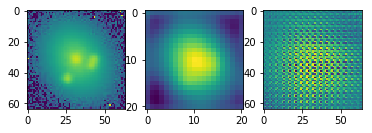

In [33]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        img = real_cpu+0.05*torch.rand_like(real_cpu)
        downsampled = F.upsample(img,scale_factor=1/3,mode='bilinear')
        kernel = kernel.to(device)
        img2 = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
        img2 = img2[:,:,:,:]
        
        plt.subplot(1,3,1)
        plt.imshow(real_cpu[1,0,:,:])      
        plt.subplot(1,3,2)
        plt.imshow(img2[1,0,:,:])
        img = netS(img2)
        im = img[1,0,:,:]
        plt.subplot(1,3,3)
        im = im.data.numpy()
        plt.imshow(im)
        stop
        


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
print(netG)

In [119]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [121]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with resampled, lower res, noise added images

        kernel = kernel.to(device)
        img = F.conv2d(real_cpu, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img+0.05*torch.rand_like(img)
        img = img[:,:,7:-7,7:-7]
        downsampled = F.upsample(img,scale_factor=1/3,mode='bilinear')
    
        
        downsampled_1d = downsampled.view([batch_size,nz,1,1])
        fake = netG(downsampled_1d)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/10][0/95] Loss_D: 1.4696 Loss_G: 20.0036 D(x): 0.5145 D(G(z)): 0.5358 / 0.0001
[0/10][1/95] Loss_D: 9.0122 Loss_G: 11.7399 D(x): 0.9994 D(G(z)): 0.9995 / 0.0000


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/shemmati/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/shemmati/

KeyboardInterrupt: 

torch.Size([64, 1, 60, 60])
torch.Size([1, 1, 41, 41])
torch.Size([64, 1, 60, 60])


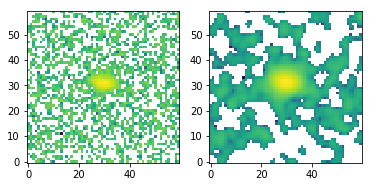

In [5]:
test_im = pyfits.getdata('gal_cutout.fits')
test_im = np.asarray(test_im,dtype=float)
data = np.repeat(test_im[:, :, np.newaxis], batchSize, axis=2)
data = np.repeat(data[:,:,:,np.newaxis],1,axis = 3)
data = torch.Tensor(data)
data = data.permute(2,3,0,1)

output = F.conv2d(data, kernel,padding=int(((kernel.shape[3])-1)/2))

print(data.shape)
print(kernel.shape)
print(output.shape)

convolved = output.data.numpy()
im = convolved[1,0,:,:]
plt.subplot(1,2,1)
plt.imshow(np.log10(test_im),origin='lower')
plt.subplot(1,2,2)
plt.imshow(np.log10(im),origin='lower')

In [23]:
noise = torch.randn(batchSize, nz, 1, 1, device=device)
print(noise.shape)
for i, data in enumerate(dataloader, 0):
    
    img =  data[0].to(device)    
    kernel = kernel.to(device)
    img = F.conv2d(img, kernel,padding=int(((kernel.shape[3])-1)/2))
    img = img+0.01*torch.rand_like(img)
    downsampled = F.upsample(img,scale_factor=0.25,mode='bilinear')
    d = downsampled.view([64,256,1,1])
    stop



torch.Size([64, 256, 1, 1])


NameError: name 'stop' is not defined